In [1]:
import os
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import hist
import mplhep as hep

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval # hyperparameter optimization

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

parser = argparse.ArgumentParser()
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true')
parseGroup1.add_argument('--PhiRing',        action='store_true')
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true')
parseGroup2.add_argument('--l1MatchGen',     action='store_true')

runLocally = True

args = None
if not runLocally:
    matplotlib.use('Agg') # use for condor jobs to disable display of plots
    args = parser.parse_args()
else:
    args = parser.parse_args("--ChunkyDonut --l1MatchGen".split()) # to run in jupyter-notebook     
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen

version         = "v0" 
sIpFileName     = "../data/L1T_Jet_MLInputs_2023_QCDPT-15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter23Digi-FlatPU0to80_126X_mcRun3_2023_forPU65_v1-v1_13_1_0_pre2_HBZS0p5_20230330.csv"
sOpFileName_SFs = "../data/L1T_Jet_SFs_2023_QCDPT-15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter23Digi-FlatPU0to80_126X_mcRun3_2023_forPU65_v1-v1_13_1_0_pre2_HBZS0p5_20230330_%s.csv" % (version)
sOutDir         = "./plots_%s" % (version)

printLevel = PrintLevel = 5
iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV
snVtx                    = 'nVertexReco'

NCompPtBins = 16 # 16 # No. of compressed pT bins
calibSF_L1JetPtRange = [15., 255., 1.] # [<lowest pT>,  <hightest pT>,  <pT bin width>] # pT range for SFs to read from Syed's SF.csv file
LUT_PtRange = [0., 255., 1.] # pT range for SFs for LUT
SF_forZeroPt = 1.0



sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 

sOpFileName_SFs = sOpFileName_SFs.replace('.csv', '_%s.csv' % (sL1JetEt))
sOutDir = '%s_%s' % (sOutDir, sL1JetEt)


PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

ETA_CAT = OD()
ETA_CAT['HBEF'] = [0.000, 5.210]  ## Whole detector, 1 - 41
ETA_CAT['HB']   = [0.000, 1.392]  ## Trigger towers  1 - 16
ETA_CAT['HE1']  = [1.392, 1.740]  ## Trigger towers 17 - 20
ETA_CAT['HE2a'] = [1.740, 2.322]  ## Trigger towers 21 - 25
ETA_CAT['HE2b'] = [2.322, 3.000]  ## Trigger towers 26 - 28
ETA_CAT['HF']   = [3.000, 5.210]  ## Trigger towers 30 - 41

IETA_CAT = OD()
IETA_CAT['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT['HE1']  = [17, 20]  ## Trigger towers 17 - 20
IETA_CAT['HE2a'] = [21, 25]  ## Trigger towers 21 - 25
IETA_CAT['HE2b'] = [26, 28]  ## Trigger towers 26 - 28
IETA_CAT['HF']   = [30, 41]  ## Trigger towers 30 - 41

CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018 = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 9+1)]),  # 1
    ( 2, [*range(10,13+1)]), # 2
    ( 3, [*range(14,15+1)]), # 3
    ( 4, [*range(16,17+1)]), # 4
    ( 5, [*range(18,19+1)]), # 5
    ( 6, [*range(20,21+1)]), # 6
    ( 7, [22]), # 7
    ( 8, [23]), # 8
    ( 9, [24]), # 9
    (10, [25]), # 10
    (11, [26]), # 11
    (12, [*range(27,28+1)]), # 12
    (13, [*range(29,31+1)]), # 13
    (14, [*range(32,35+1)]), # 14
    (15, [*range(36,40+1)]), # 15
])
CaloToolMPEtaBinsMerge_forEtaCompressedLUT = CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018

useAbsEtaBins = True
ETA_Bins = []
for iEta in range(-41,42):
    if iEta in [-29, 0, 29]:        continue;
    if useAbsEtaBins and iEta < 0:  continue;
    ETA_Bins.append(str(iEta))

map_CaloIEta_to_CaloTool_mpEta = OrderedDict([
    (1, 1),
    (2, 2),
    (3, 3),
    (4, 4),
    (5, 5),
    (6, 6),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    
    (11, 11),
    (12, 12),
    (13, 13),
    (14, 14),
    (15, 15),
    (16, 16),
    (17, 17),
    (18, 18),
    (19, 19),
    (20, 20),
    
    (21, 21),
    (22, 22),
    (23, 23),
    (24, 24),
    (25, 25),
    (26, 26),
    (27, 27),
    (28, 28),
    (29, 29),
    (30, 29),
    
    (31, 30),
    (32, 31),
    (33, 32),
    (34, 33),
    (35, 34),
    (36, 35),
    (37, 36),
    (38, 37),
    (39, 38),
    (40, 39),

    (41, 40),
])

sOutDirBeforeJEC    = "%s/beforeJEC" % (sOutDir)
sOutDirAfterJEC     = "%s/afterJEC" % (sOutDir)
sOutDirBeforeJEC_1D = '%s/1D' % (sOutDirBeforeJEC)
sOutDirAfterJEC_1D  = '%s/1D' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir):             os.mkdir( sOutDir )
if not os.path.exists(sOutDirBeforeJEC):    os.mkdir( sOutDirBeforeJEC )
if not os.path.exists(sOutDirAfterJEC):     os.mkdir( sOutDirAfterJEC )    
if not os.path.exists(sOutDirBeforeJEC_1D): os.mkdir( sOutDirBeforeJEC_1D )    
if not os.path.exists(sOutDirAfterJEC_1D):  os.mkdir( sOutDirAfterJEC_1D )    

In [2]:

data_all = pd.read_csv(sIpFileName)
print("Input file: %s" % (sIpFileName))
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))
print("l1Jet_ChunkyDonut {}, l1Jet_PhiRing {}, l1MatchOffline {}, l1MatchGen {}".format(
    l1Jet_ChunkyDonut, l1Jet_PhiRing, l1MatchOffline, l1MatchGen))

Input file: ../data/L1T_Jet_MLInputs_2023_QCDPT-15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter23Digi-FlatPU0to80_126X_mcRun3_2023_forPU65_v1-v1_13_1_0_pre2_HBZS0p5_20230330.csv
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sRefJetEt: GenJetEt, 	 sL1Jet: L1JetEt_PUS_ChunkyDonut, 	 L1JetPtThrsh: 10.0
l1Jet_ChunkyDonut True, l1Jet_PhiRing False, l1MatchOffline False, l1MatchGen True


In [ ]:
data_all = data_all.sample(frac=0.01)

In [3]:
print("data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Unpacked', 'nTT_Emulated', 'GenJetEt', 'nVertexGen', 'nMeanPUGen',
       'matchedPFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt',
       'L1JetDefault_PUEt_ChunkyDonut', 'L1Jet9x9_RawEt',
       'L1Jet9x9_EtSum7PUTowers', 'L1Jet9x9_PUEt_ChunkyDonut'],
      dtype='object'), 
data_all.shape: (23718951, 18)


In [4]:
data_all[sL1JetEt_PUS_ChunkyDonut] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']

data_all[sL1JetEt_PUS_PhiRing]     = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )

sL1JetEt_forML              = 'log_%s' % (sL1JetEt)
sRefJetEt_forML             = 'log_%s' % (sRefJetEt)
train_vars = [sL1JetTowerIEtaAbs, sL1JetEt_forML, snVtx]
target_var = sRefJetEt_forML
print("\nsL1JetEt_forML: {}, sRefJetEt_forML: {}".format(sL1JetEt_forML, sRefJetEt_forML))
print("train_vars: {}, \ntarget_var: {}\n".format(train_vars, target_var))

def transform_JetEt_forML(series):
    series_new = np.log(series)
    return series_new;

def transform_back_JetEt_fromML(series):
    series_new = np.exp(series)
    return series_new;

def prepareDataframeForSFs(iEtaBinRange, PtRangeMin=L1JetPtThrsh, PtRangeMax=L1JetPtMax, nVtx=48):
    dict_iEta_Et = OD([ (sL1JetTowerIEtaAbs, []), (sL1JetEt, []) ])
    if snVtx in train_vars:
        dict_iEta_Et[snVtx] = []
        
    for iEta in iEtaBinRange:
        list_pt      = np.arange(PtRangeMin, PtRangeMax+1.0)
        list_ietabin = [iEta] * len(list_pt)
        dict_iEta_Et[sL1JetTowerIEtaAbs].extend(list_ietabin) 
        dict_iEta_Et[sL1JetEt].extend(list_pt) 
        if snVtx in train_vars:
            list_nVtx = [nVtx] * len(list_pt)
            dict_iEta_Et[snVtx].extend(list_nVtx) 
            
          
    data_SFs = pd.DataFrame(dict_iEta_Et)
    data_SFs[sL1JetEt_forML]    = transform_JetEt_forML(data_SFs[sL1JetEt])
    return data_SFs

data_all[sL1JetEt_forML]    = transform_JetEt_forML(data_all[sL1JetEt])
data_all[sRefJetEt_forML]   = transform_JetEt_forML(data_all[sRefJetEt])

if printLevel >= 1:
    print("data_all.describe(): \n{}".format(data_all.describe()))
#print("\n\ndata_SFs.describe(): \n{}".format(data_SFs.describe()))
#print("\n\ndata_SFs.describe(): \n{}".format(data_SFs.to_string()))


sL1JetEt_forML: log_L1JetEt_PUS_ChunkyDonut, sRefJetEt_forML: log_GenJetEt
train_vars: ['L1JetTowerIEtaAbs', 'log_L1JetEt_PUS_ChunkyDonut', 'nVertexReco'], 
target_var: log_GenJetEt

data_all.describe(): 
        runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  23718951.0       2.371895e+07  2.371895e+07  2.371895e+07   
mean          1.0       5.028456e+03  4.960405e+06  4.102234e+01   
std           0.0       2.899231e+03  2.970682e+06  2.324785e+01   
min           1.0       1.000000e+00  1.000000e+00  0.000000e+00   
25%           1.0       2.526000e+03  2.319585e+06  2.100000e+01   
50%           1.0       4.993000e+03  4.992480e+06  4.200000e+01   
75%           1.0       7.567000e+03  7.651487e+06  6.100000e+01   
max           1.0       1.000000e+04  9.999999e+06  8.100000e+01   

       nTT_Unpacked  nTT_Emulated      GenJetEt    nVertexGen    nMeanPUGen  \
count    23718951.0  2.371895e+07  2.371895e+07  2.371895e+07  2.371895e+07   
mean            0.0  1.

iEta 1
iEta 2
iEta 3
iEta 4
iEta 5
iEta 6
iEta 7
iEta 8
iEta 9
iEta 10
iEta 11
iEta 12
iEta 13
iEta 14
iEta 15
iEta 16
iEta 17
iEta 18
iEta 19
iEta 20
iEta 21


/tmp/ipykernel_12078/3457252253.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


iEta 22
iEta 23
iEta 24
iEta 25
iEta 26
iEta 27
iEta 28
iEta 30
iEta 31
iEta 32
iEta 33
iEta 34
iEta 35
iEta 36
iEta 37
iEta 38
iEta 39
iEta 40
iEta 41


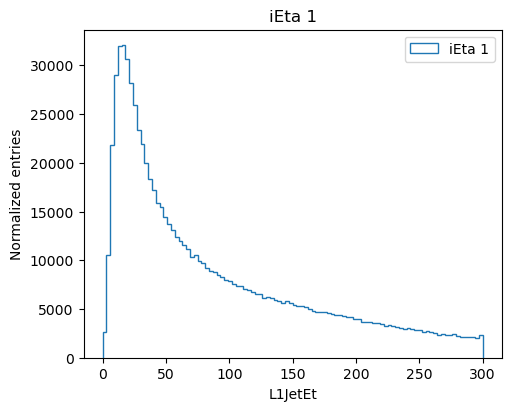

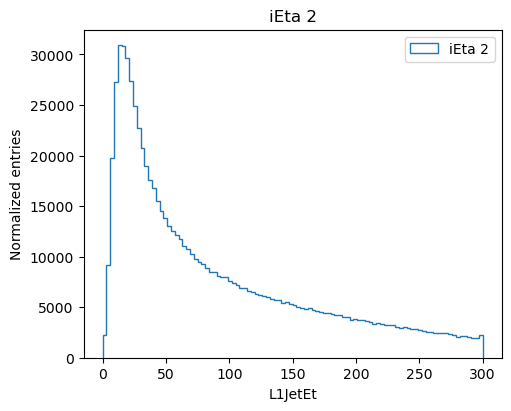

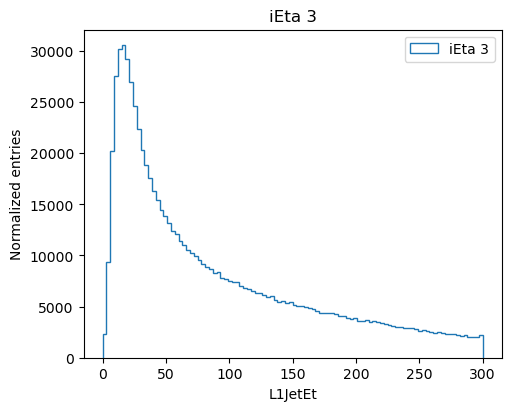

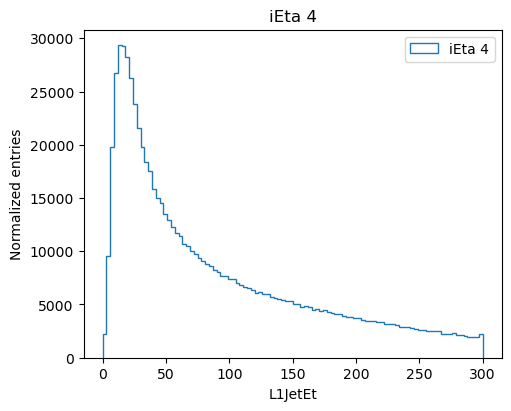

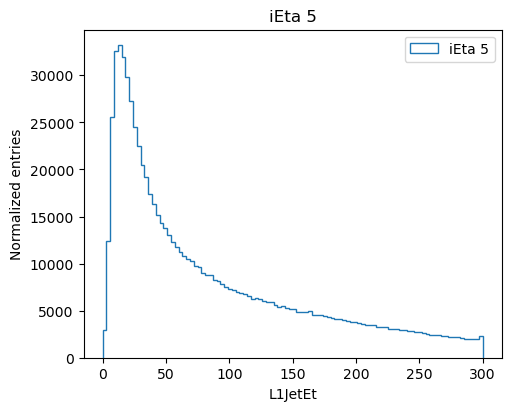

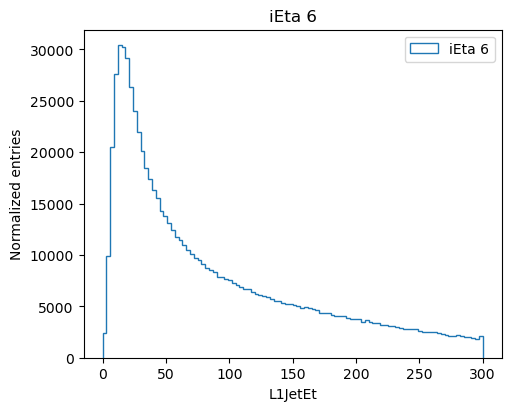

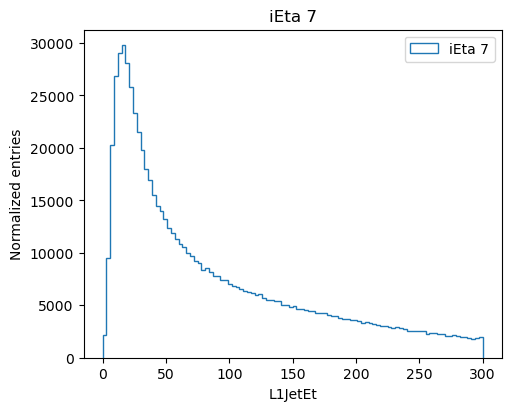

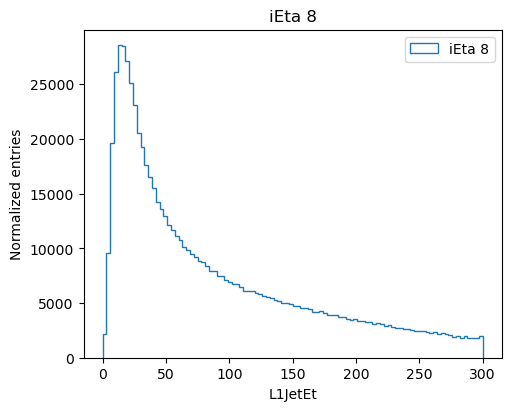

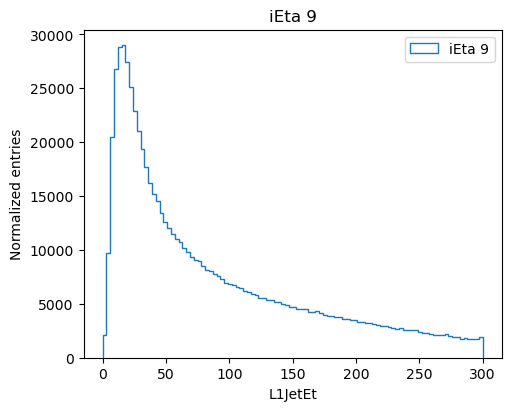

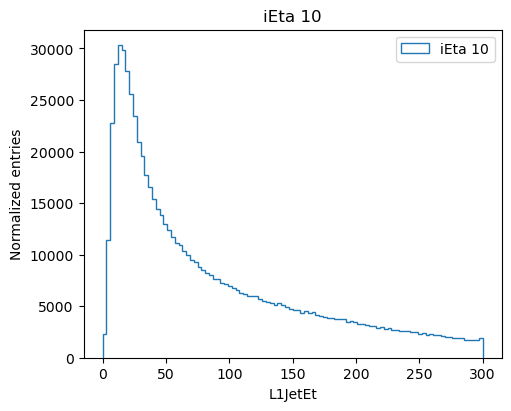

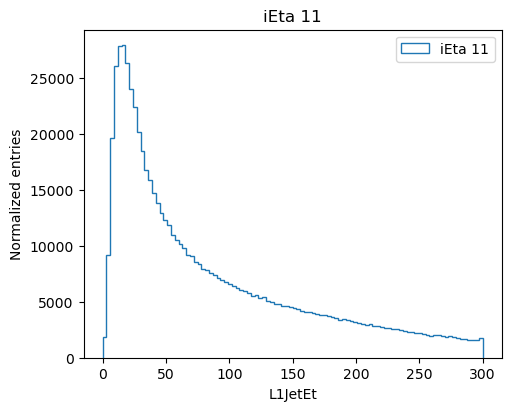

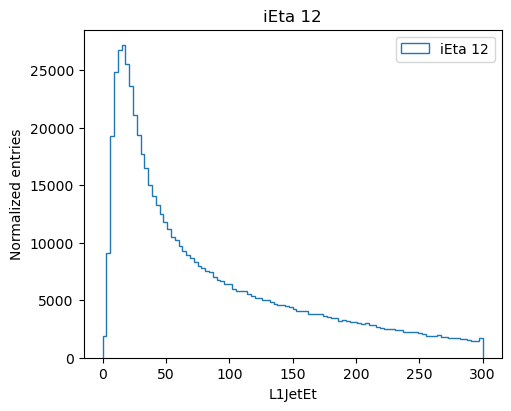

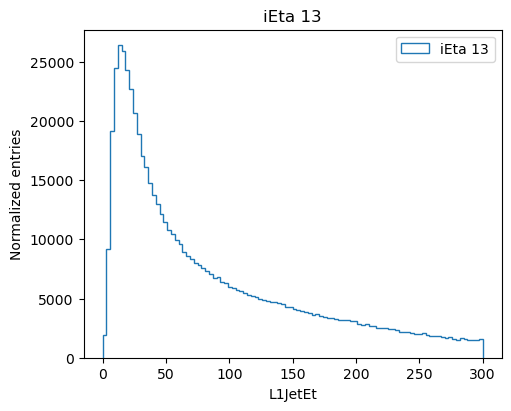

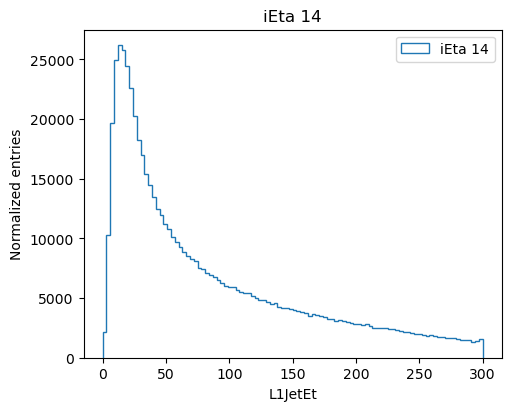

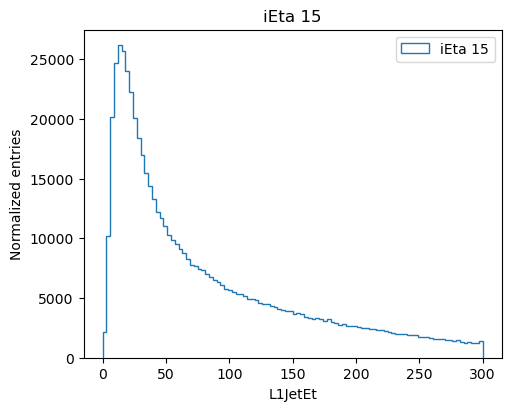

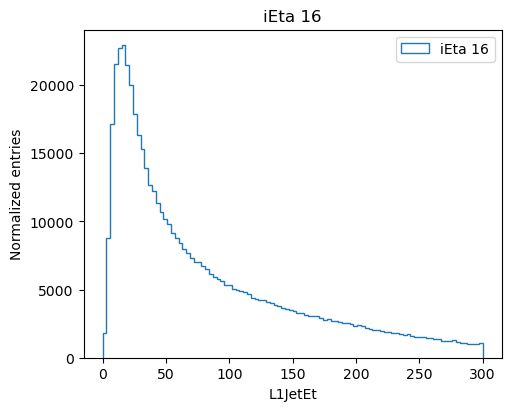

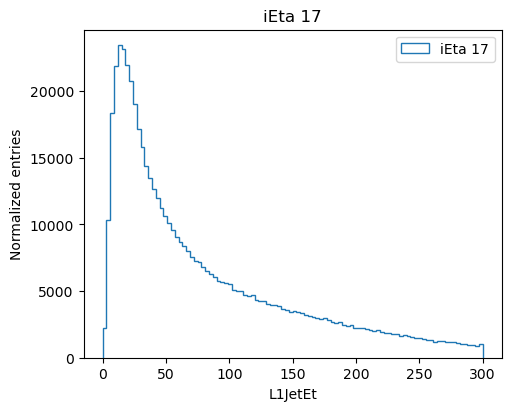

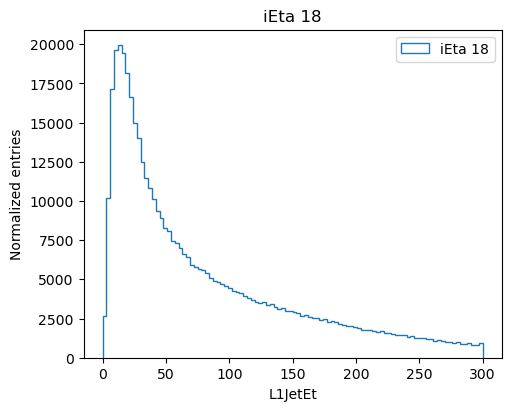

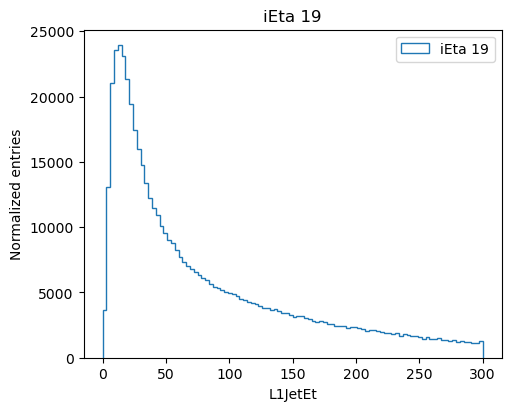

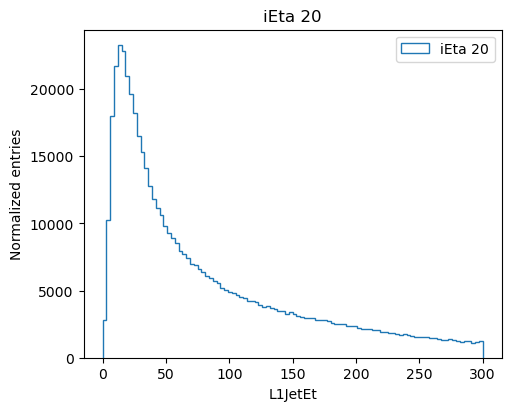

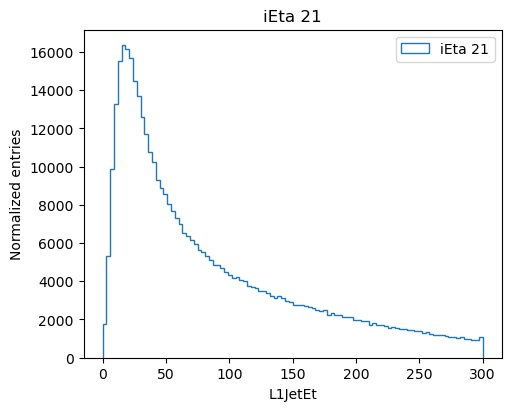

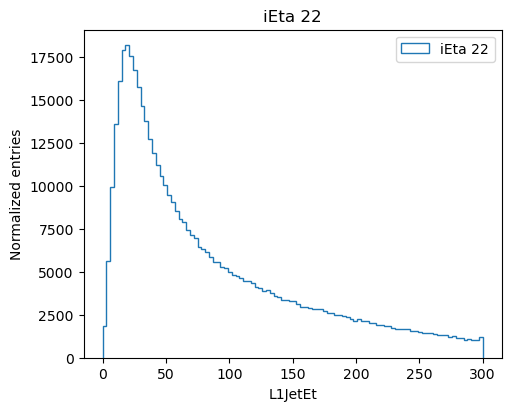

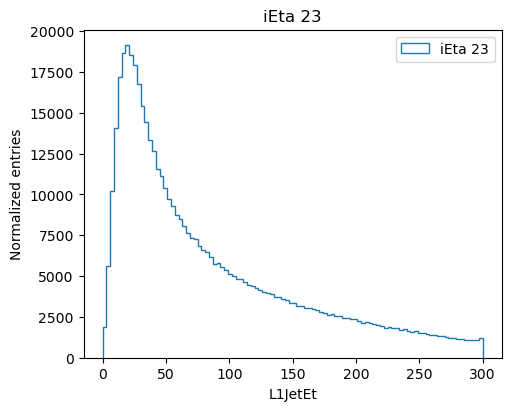

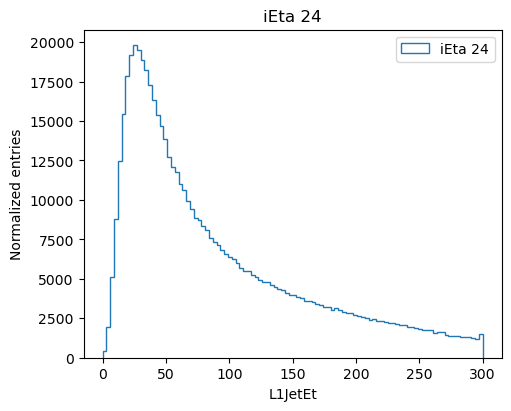

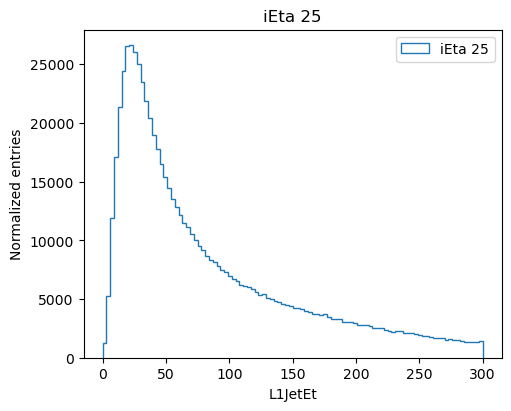

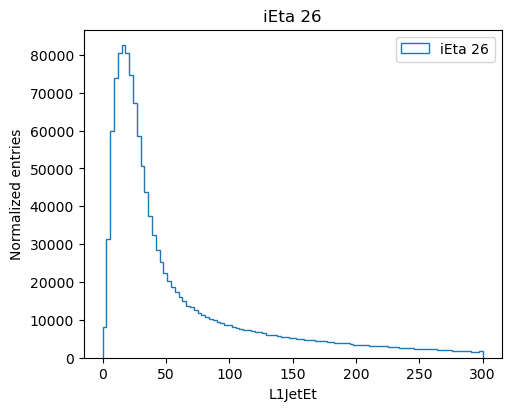

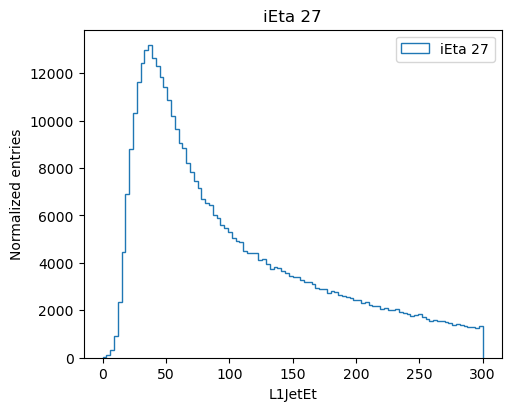

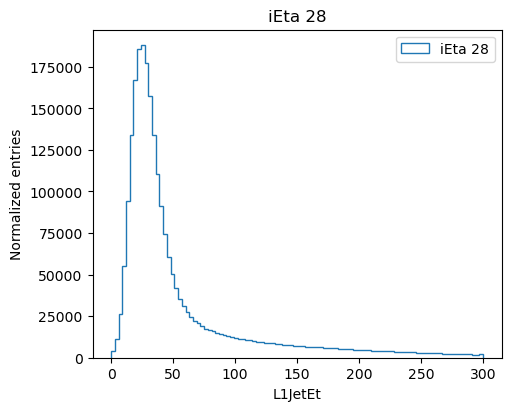

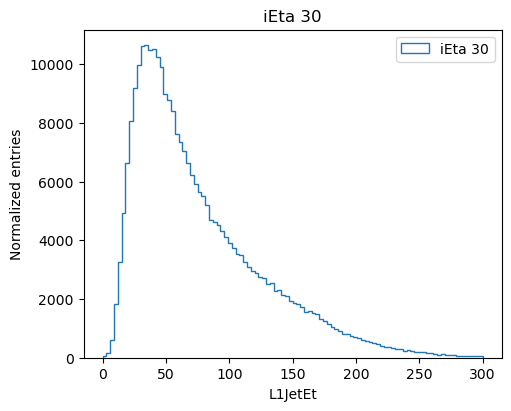

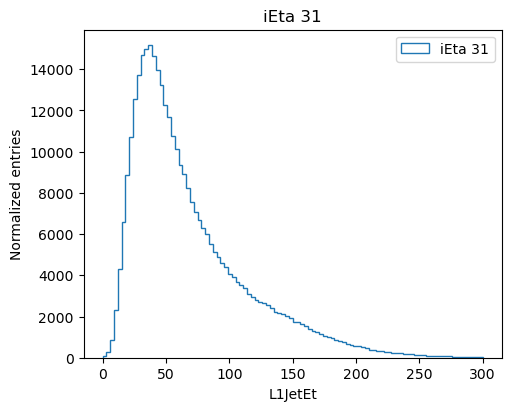

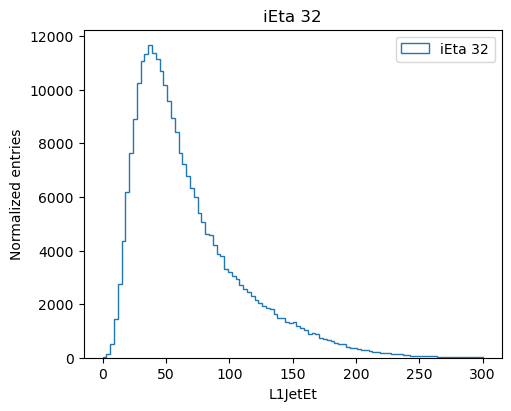

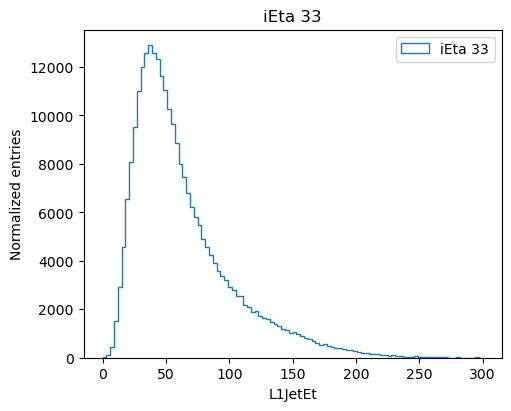

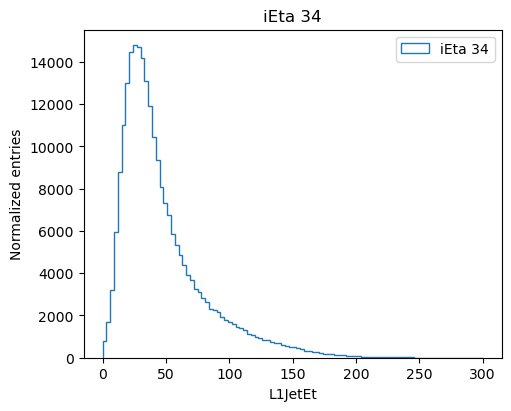

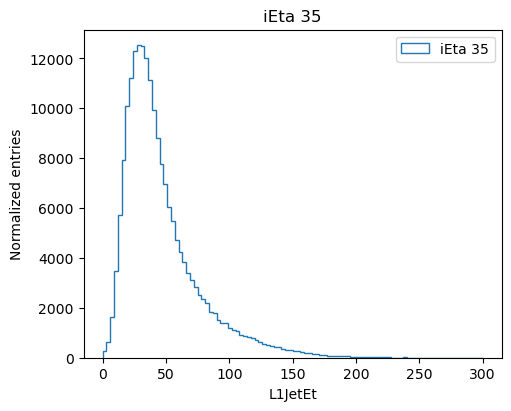

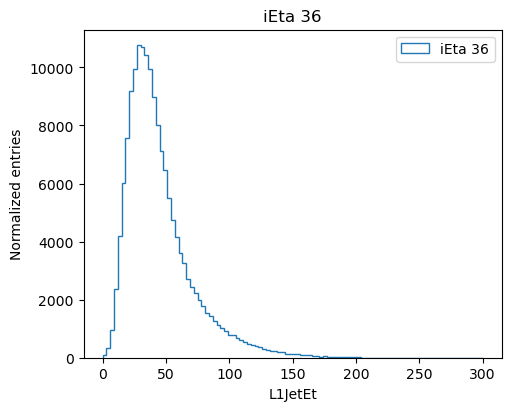

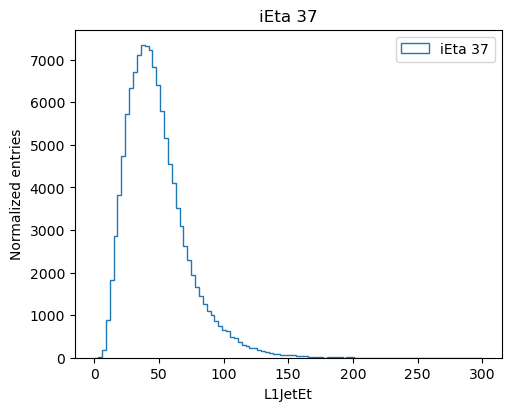

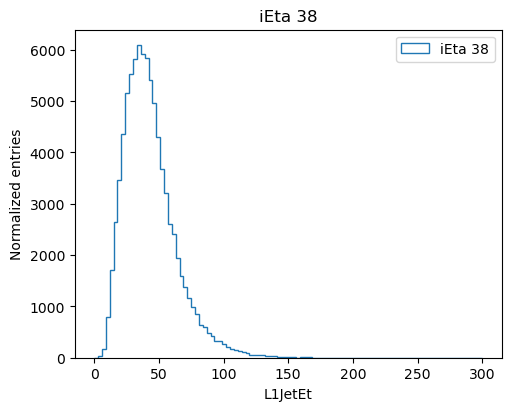

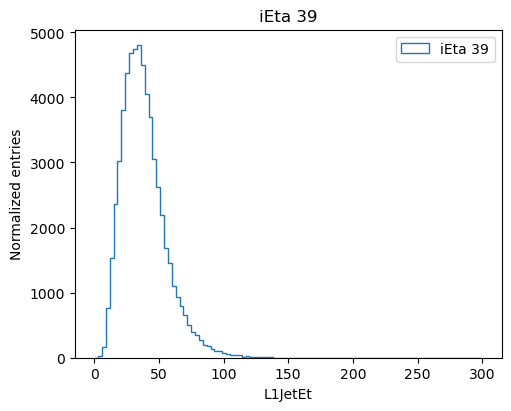

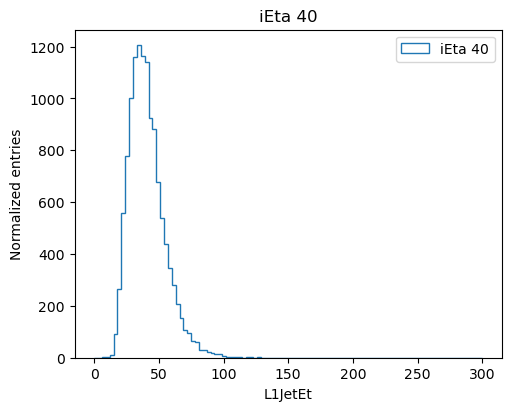

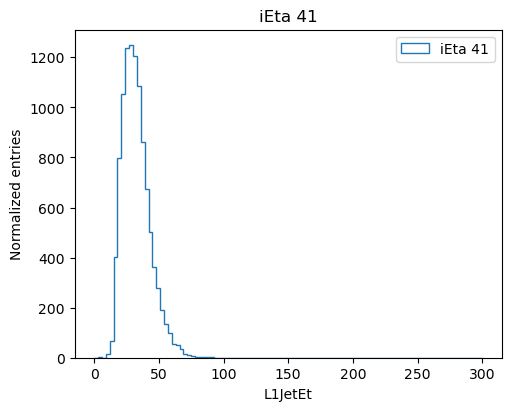

In [5]:
#%%script false --no-raise-error

for iEta in ETA_Bins:
    print("iEta %d"%(int(iEta)))
        
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')      
    
    iEtaBin = int(iEta)
    data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
    axs.hist(
        (data_all_iEtaBin[sL1JetEt]), 
        bins=100, range=(0, 300),
        label='iEta %d' % (iEtaBin),
        histtype='step',#, linewidth=2
    )
    axs.set_xlabel('L1JetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('iEta %d' % (iEtaBin))
    axs.legend()
      
    fig.savefig('%s/L1JetEt_ieta_%d.png' % (sOutDirBeforeJEC_1D, iEtaBin))
 

In [6]:
## data cleaning--------

# Drop entries with L1JetEt < L1JetPtThrsh
data_all_L1EtBelowThrsh = data_all[ data_all[sL1JetEt] < L1JetPtThrsh ]
if printLevel >= 6:
    print("data_all[ data_all['{}'] < {} ]: \n{}".format(sL1JetEt, L1JetPtThrsh, data_all_L1EtBelowThrsh))
data_all.drop(index=data_all_L1EtBelowThrsh.index, inplace=True)

print("\nDoes any of the columns have NaN entries: \ndata_all.isna().sum(): \n{}".format(data_all.isna().sum()))
if printLevel >= 5:
    print("\nAfter cleaning, data_all.describe(): \n{}".format(data_all.describe()))


Does any of the columns have NaN entries: 
data_all.isna().sum(): 
runNumber                        0
lumiSectionNumber                0
eventNumber                      0
nVertexReco                      0
nTT_Unpacked                     0
nTT_Emulated                     0
GenJetEt                         0
nVertexGen                       0
nMeanPUGen                       0
matchedPFJetEtCorr               0
L1JetType                        0
L1JetDefault_Et                  0
L1JetTowerIEtaAbs                0
L1JetDefault_RawEt               0
L1JetDefault_PUEt_ChunkyDonut    0
L1Jet9x9_RawEt                   0
L1Jet9x9_EtSum7PUTowers          0
L1Jet9x9_PUEt_ChunkyDonut        0
L1JetEt_PUS_ChunkyDonut          0
L1JetEt_PUS_PhiRing              0
log_L1JetEt_PUS_ChunkyDonut      0
log_GenJetEt                     0
dtype: int64

After cleaning, data_all.describe(): 
        runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  22608994.0       2.260899e+07  2.26

iEta 1
iEta 2
iEta 3
iEta 4
iEta 5
iEta 6
iEta 7
iEta 8
iEta 9
iEta 10
iEta 11
iEta 12
iEta 13
iEta 14
iEta 15
iEta 16
iEta 17
iEta 18
iEta 19
iEta 20
iEta 21


/tmp/ipykernel_12078/2170111251.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


iEta 22
iEta 23
iEta 24
iEta 25
iEta 26
iEta 27
iEta 28
iEta 30
iEta 31
iEta 32
iEta 33
iEta 34
iEta 35
iEta 36
iEta 37
iEta 38
iEta 39
iEta 40
iEta 41


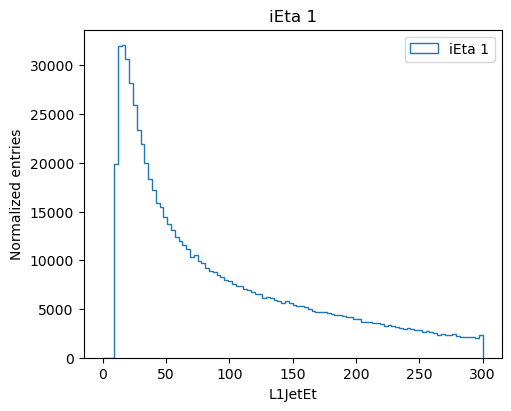

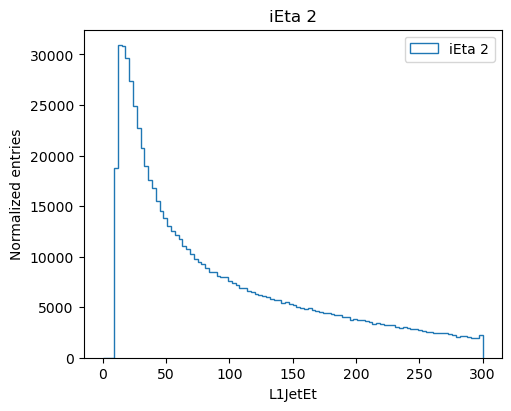

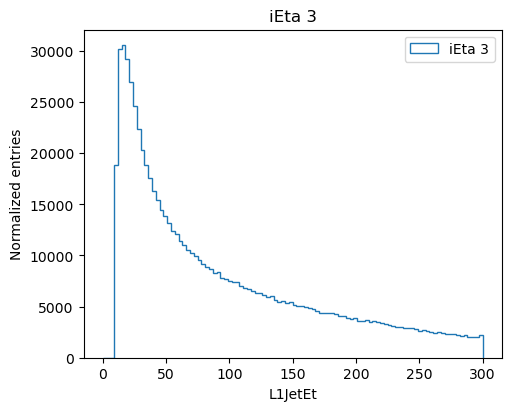

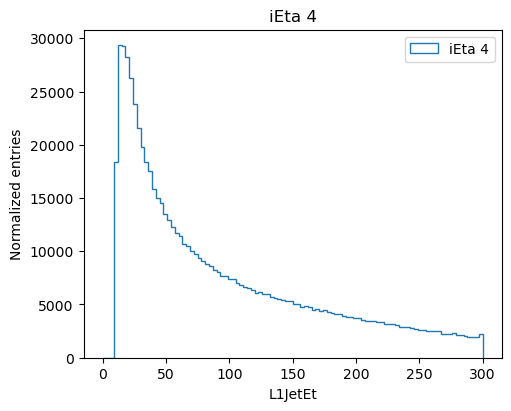

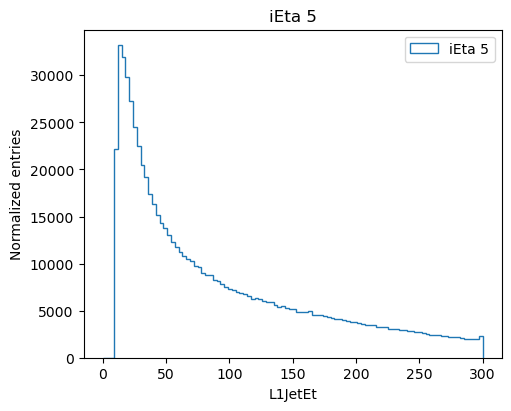

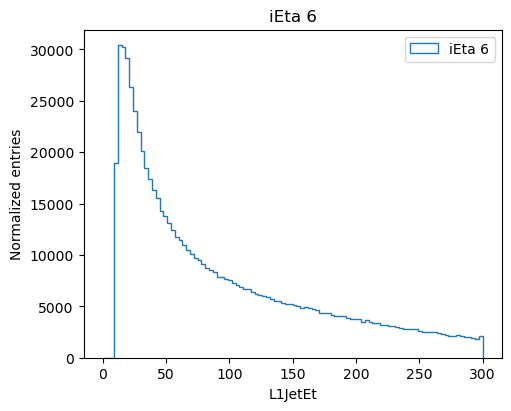

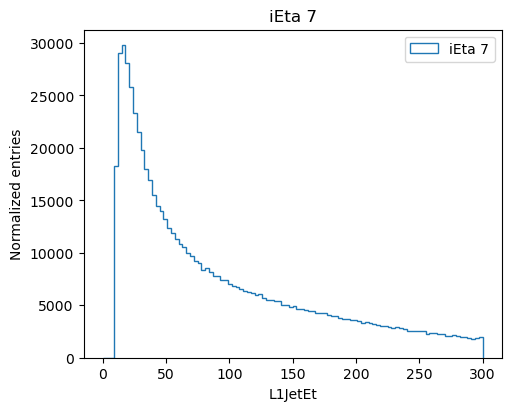

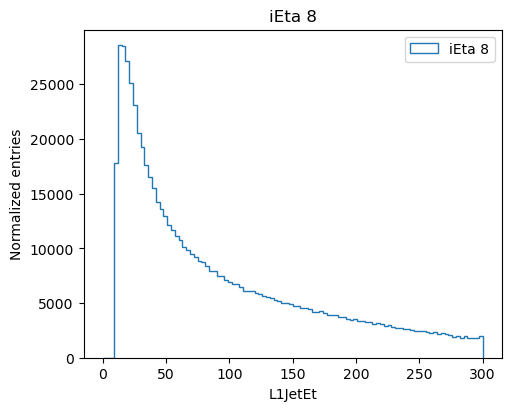

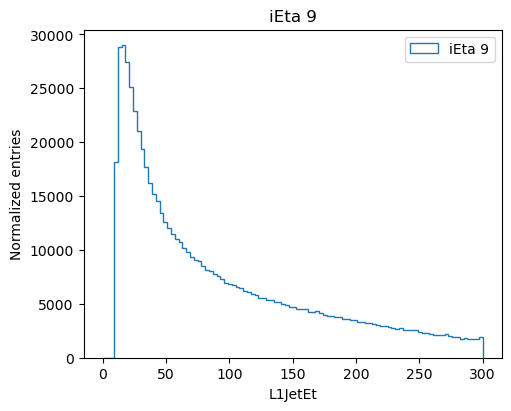

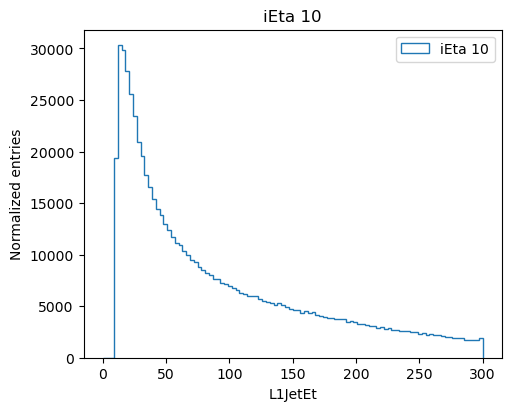

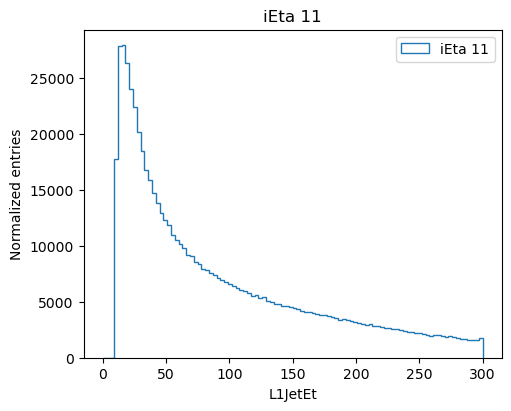

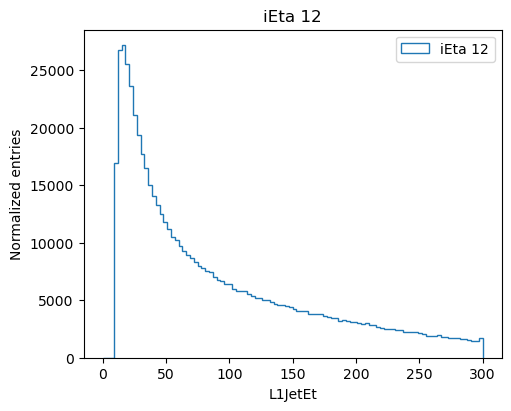

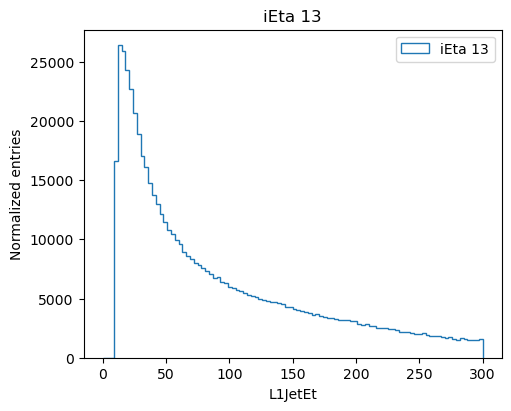

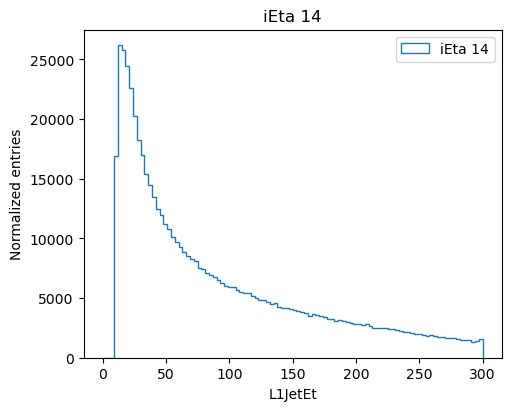

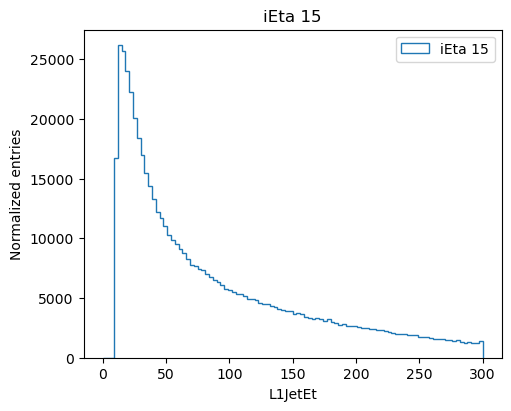

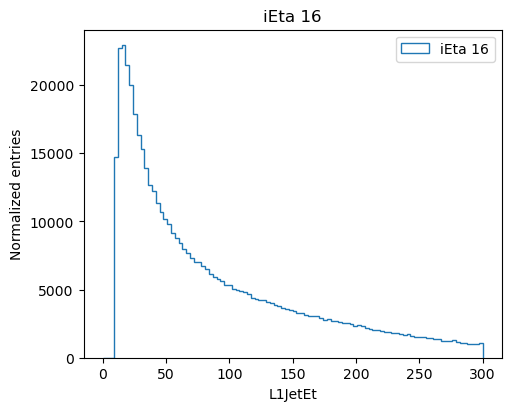

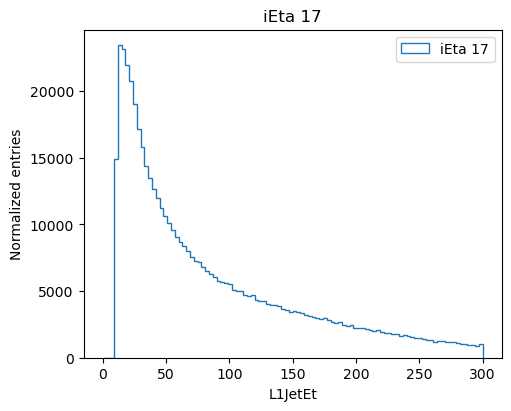

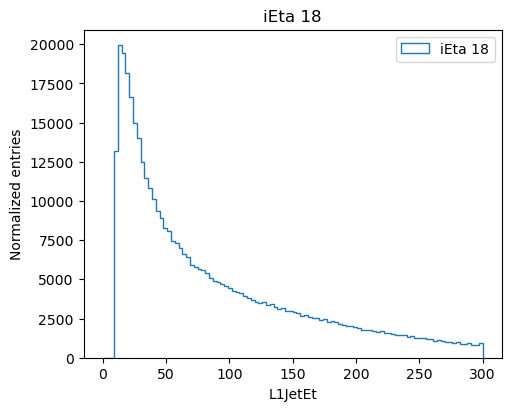

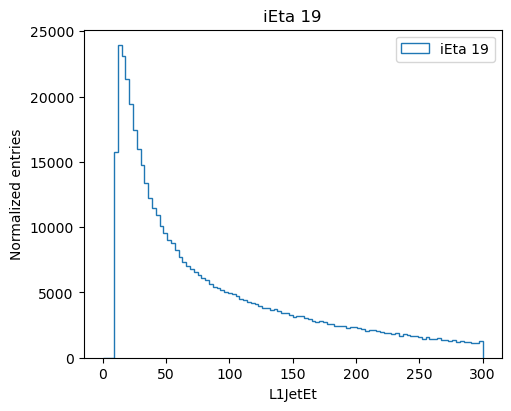

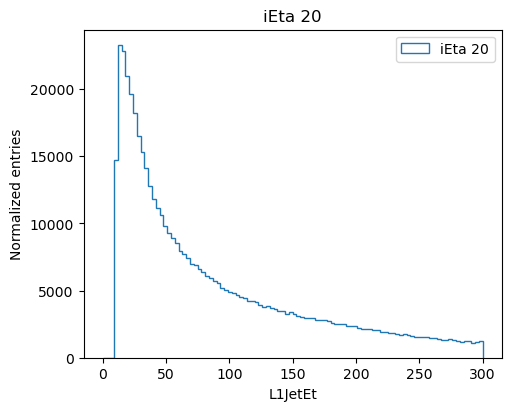

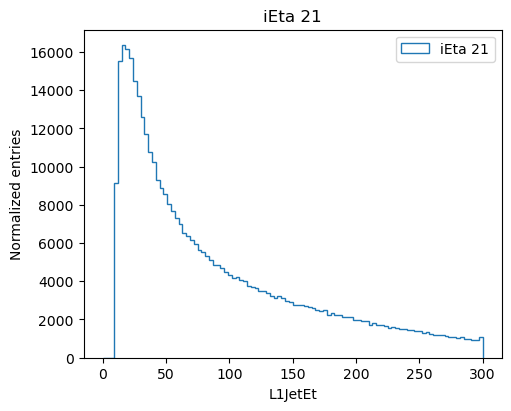

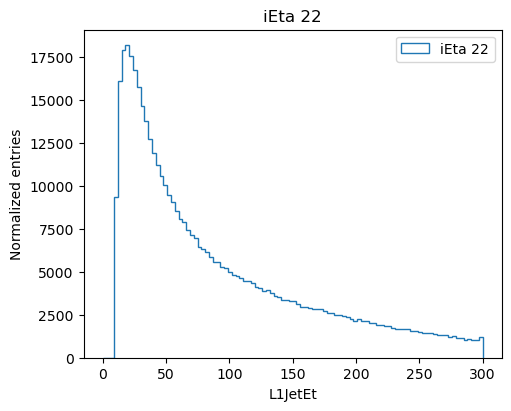

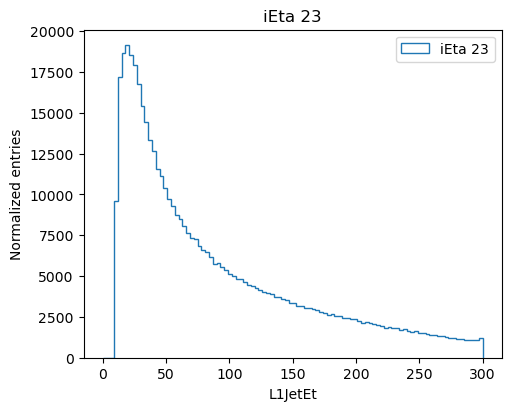

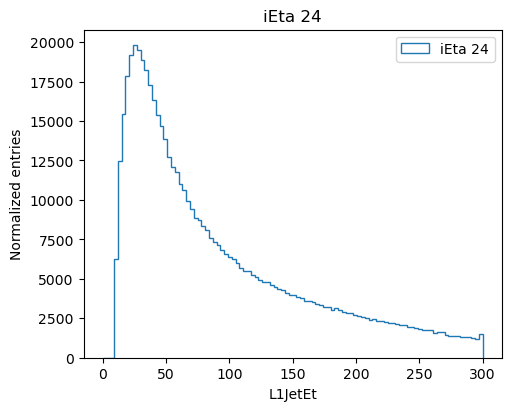

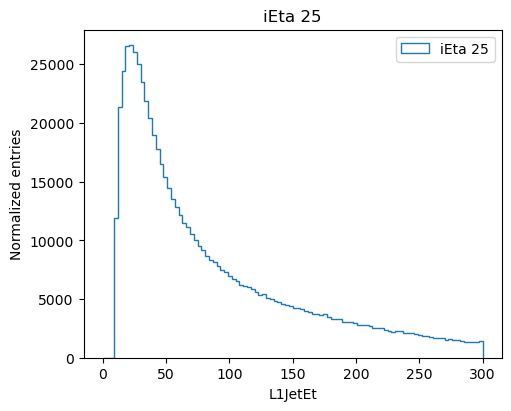

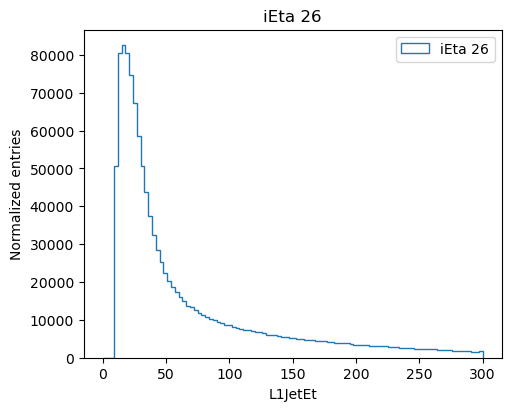

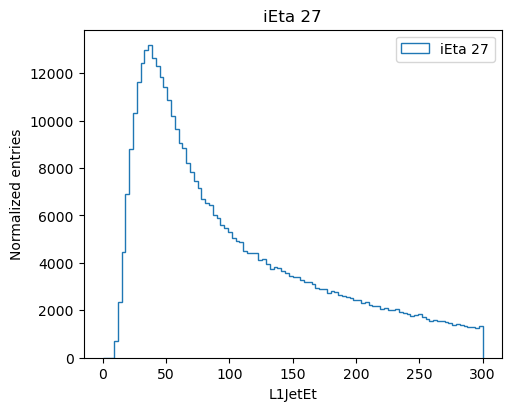

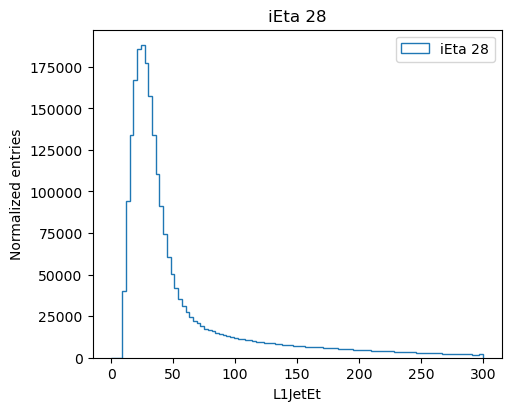

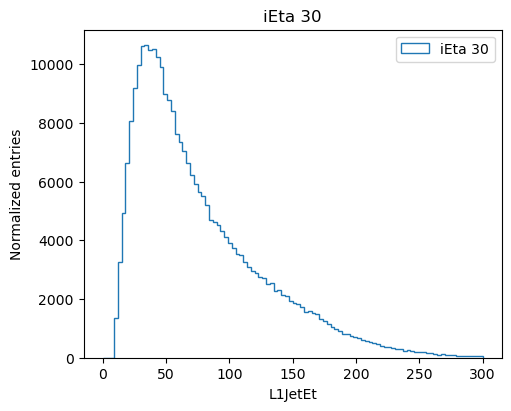

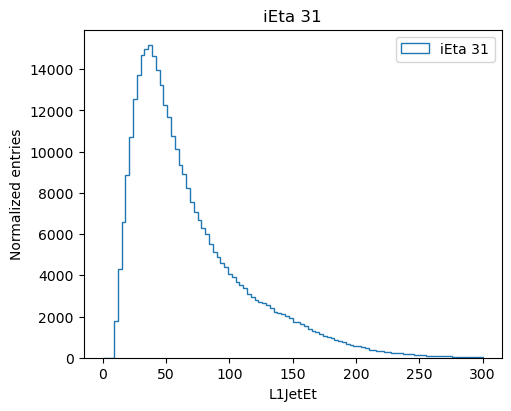

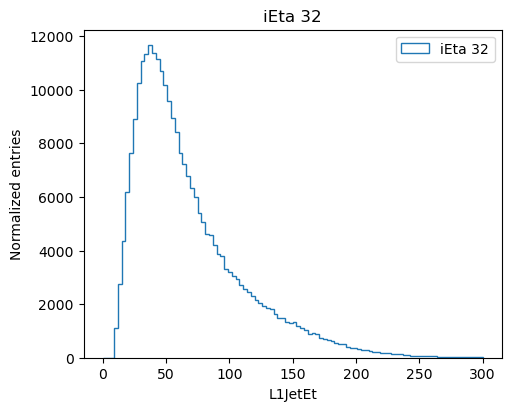

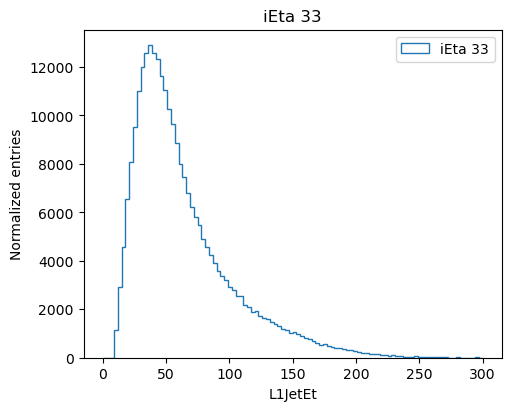

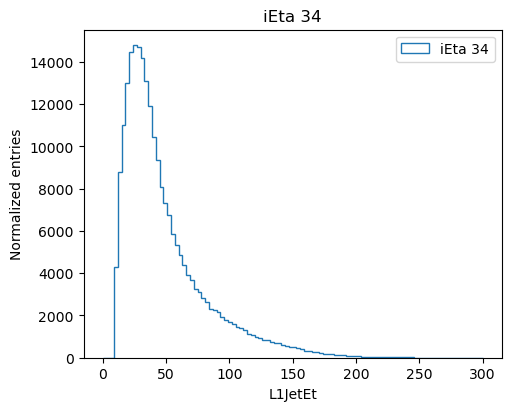

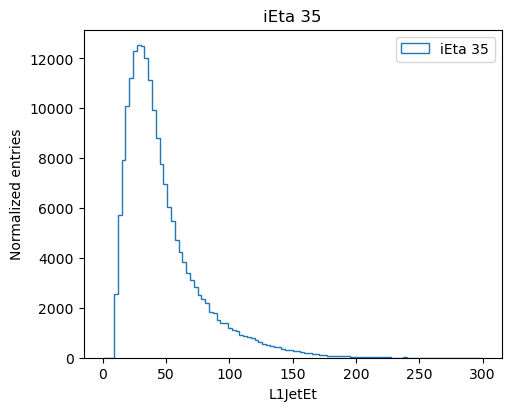

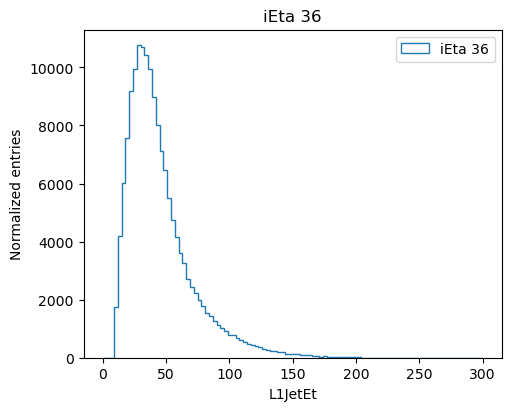

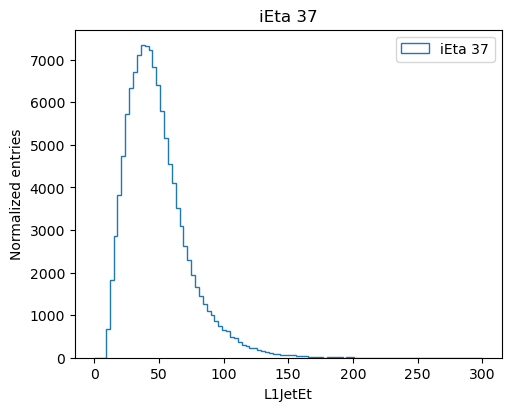

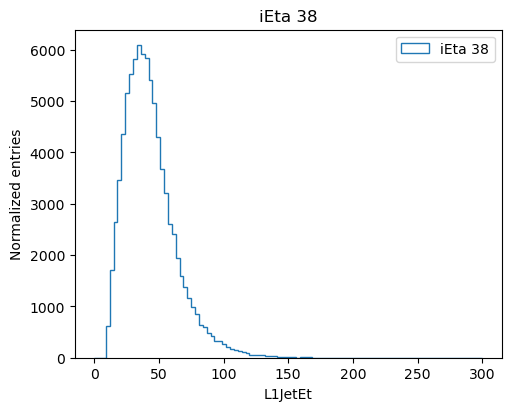

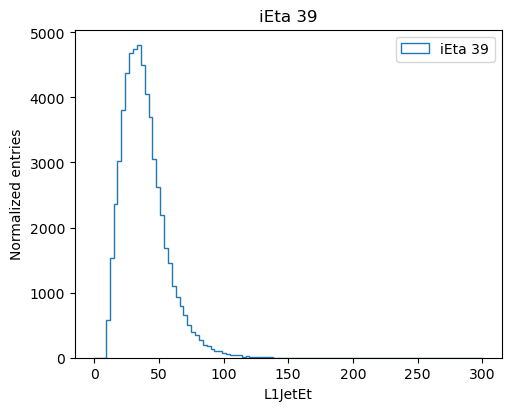

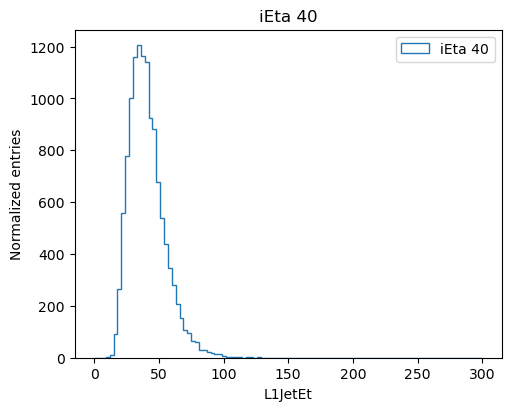

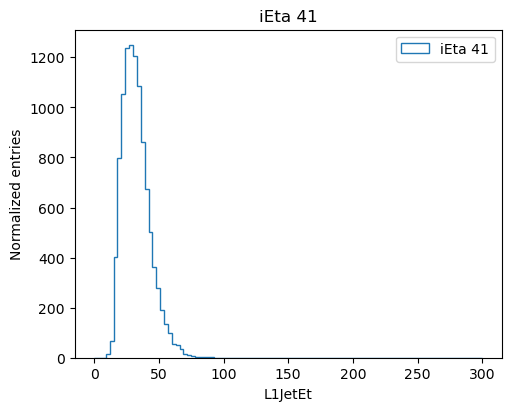

In [7]:
#%%script false --no-raise-error

for iEta in ETA_Bins:
    print("iEta %d"%(int(iEta)))
        
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')      
    
    iEtaBin = int(iEta)
    data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
    axs.hist(
        (data_all_iEtaBin[sL1JetEt]), 
        bins=100, range=(0, 300),
        label='iEta %d' % (iEtaBin),
        histtype='step',#, linewidth=2
    )
    axs.set_xlabel('L1JetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('iEta %d' % (iEtaBin))
    axs.legend()
      
    fig.savefig('%s/L1JetEt_ieta_%d_afterDataCleaning.png' % (sOutDirBeforeJEC_1D, iEtaBin))


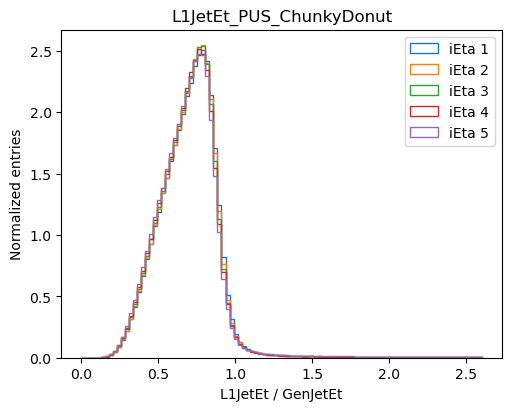

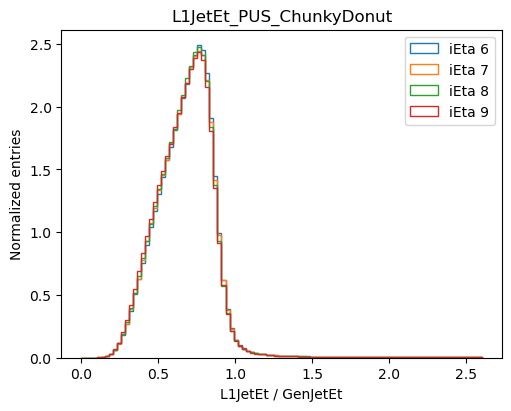

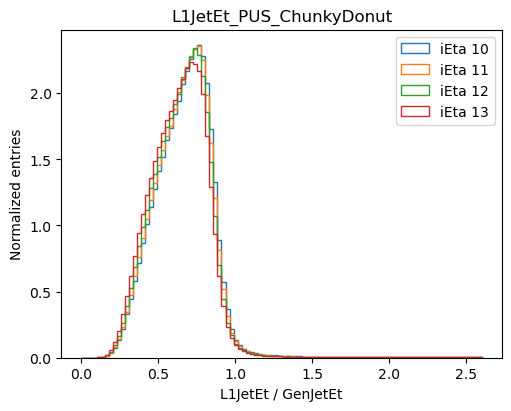

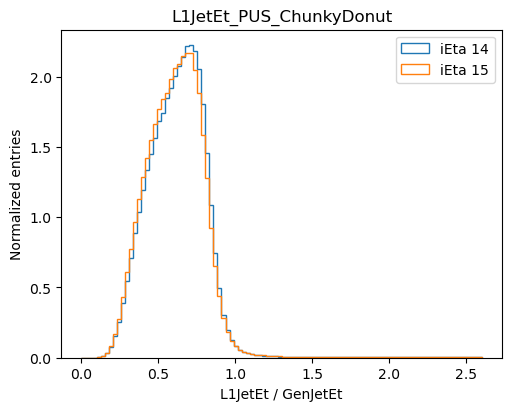

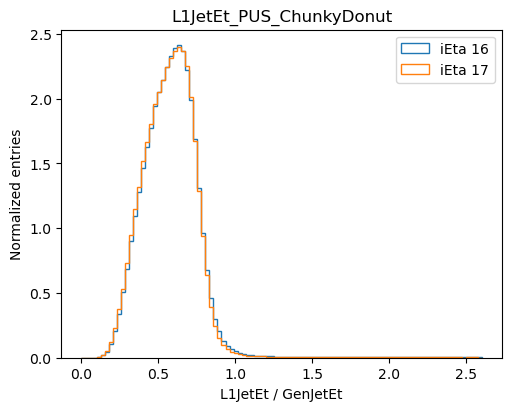

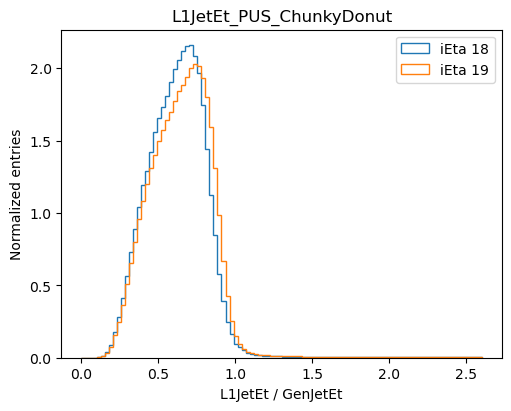

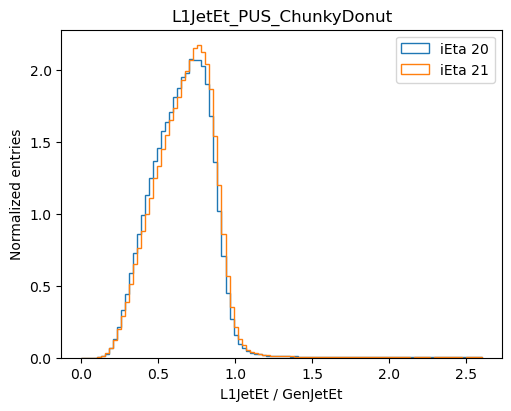

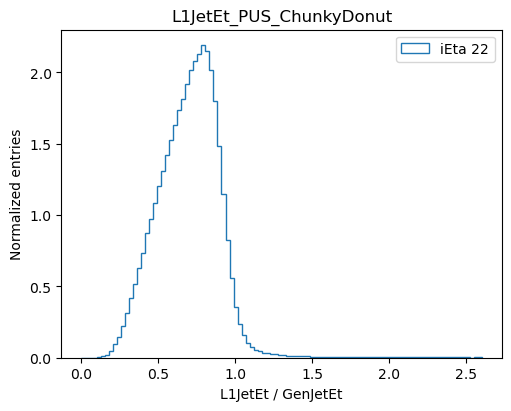

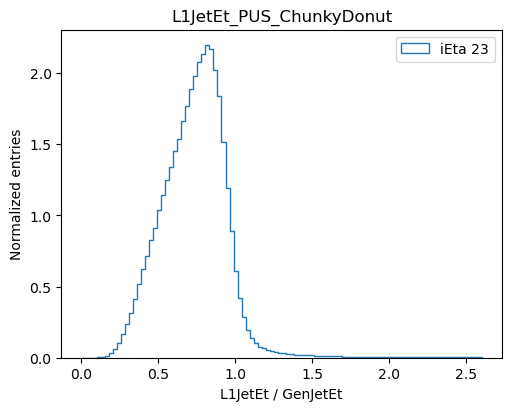

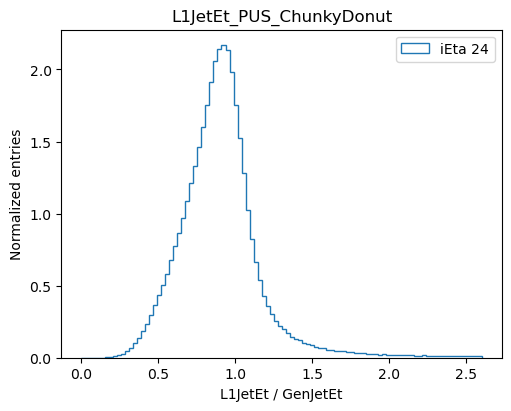

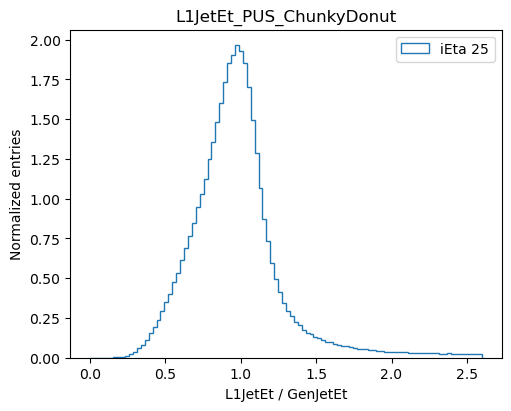

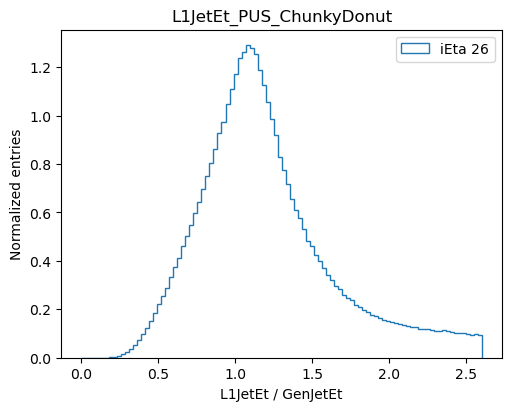

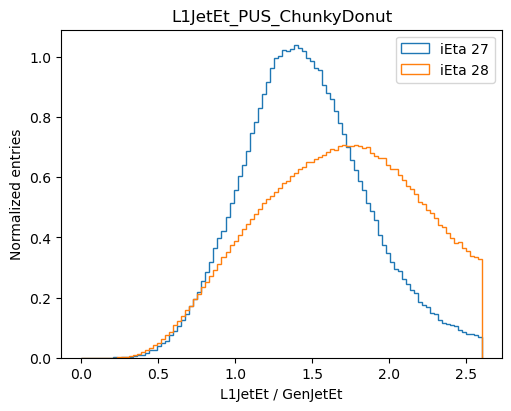

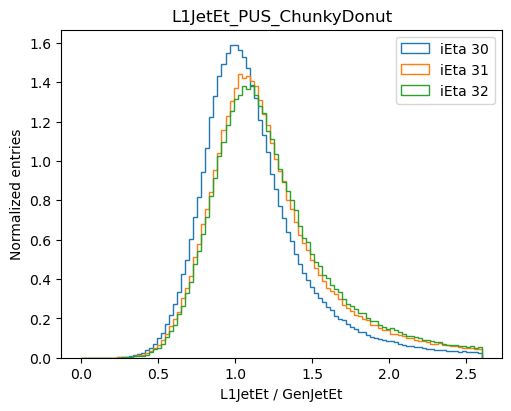

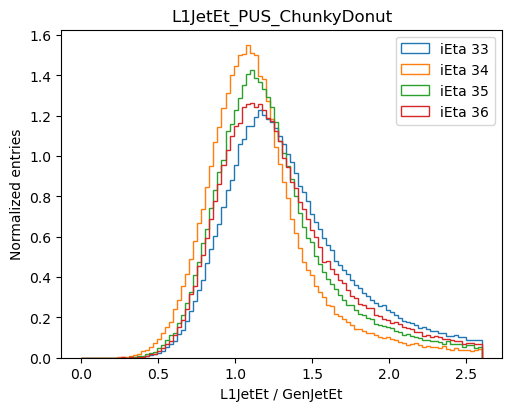

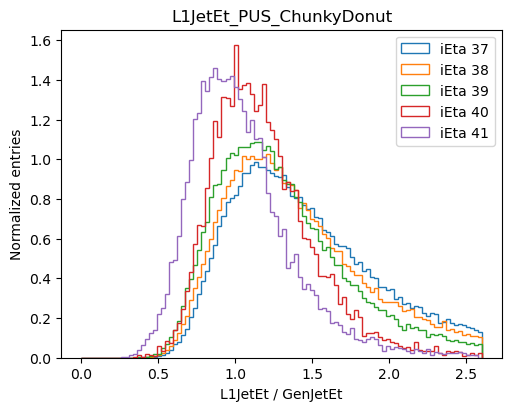

In [8]:
## make resolution plots before JEC


    
def convert_CaloToolMPEta_to_IEta(CaloToolMPEta):
    IEta = None
    for IEta_tmp in map_CaloIEta_to_CaloTool_mpEta.keys():
        if map_CaloIEta_to_CaloTool_mpEta[ IEta_tmp ] == CaloToolMPEta:
            IEta = IEta_tmp

    return IEta

#print("".format())
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/beforeJEC_%s_ieta_%d_to_%d.png' % (sOutDirBeforeJEC, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
        


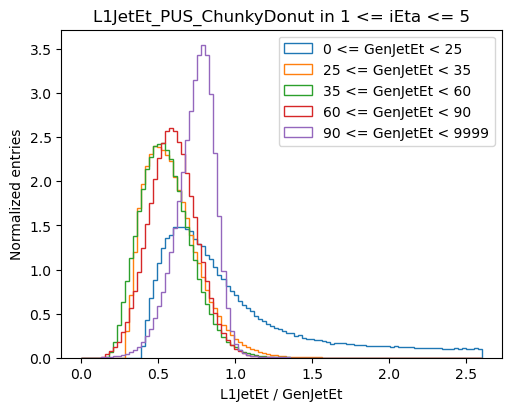

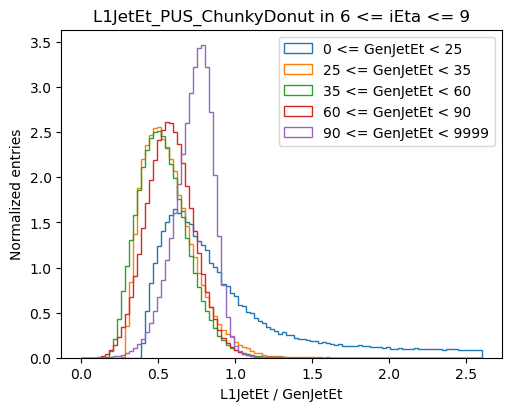

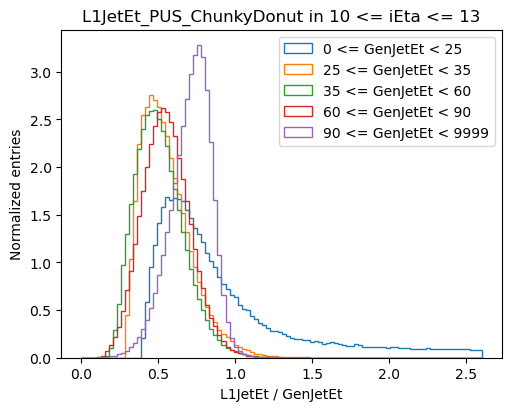

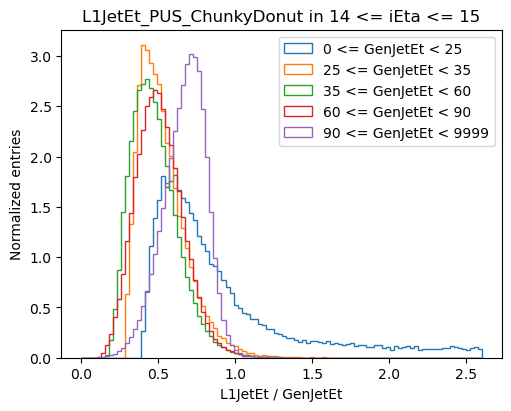

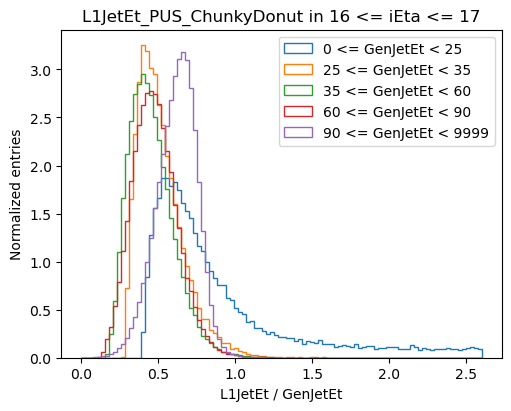

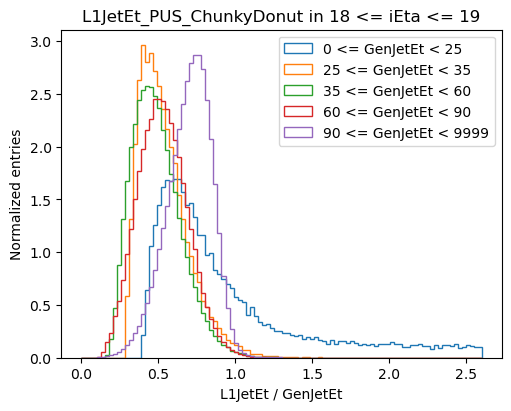

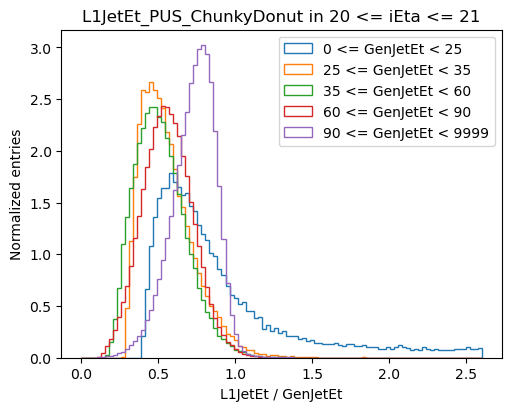

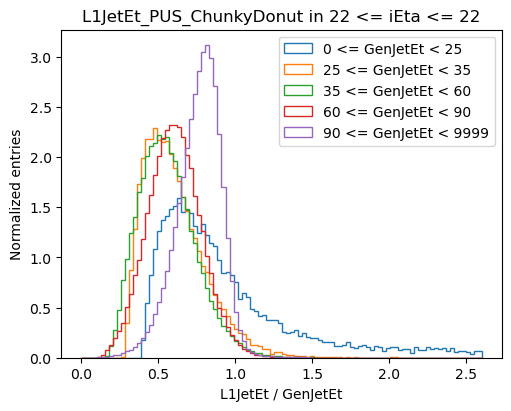

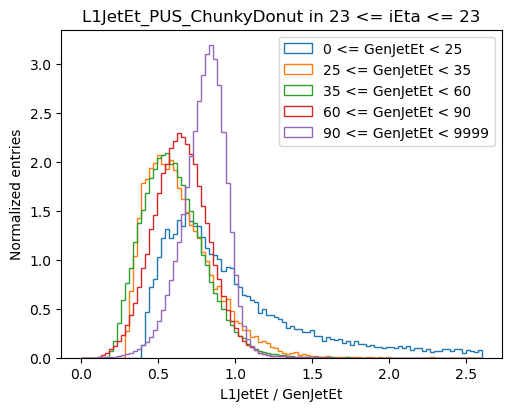

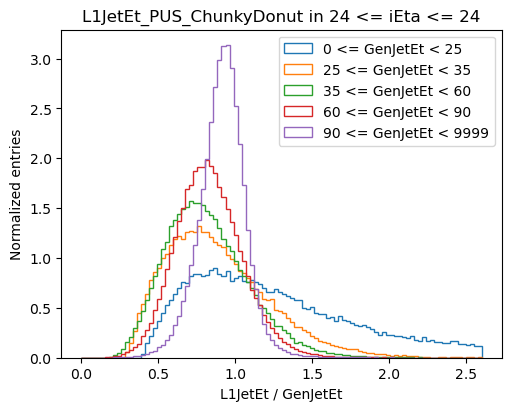

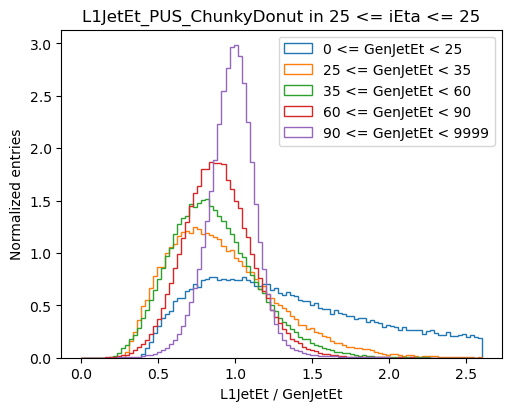

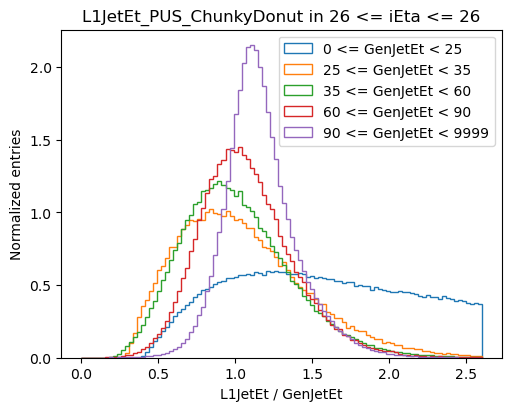

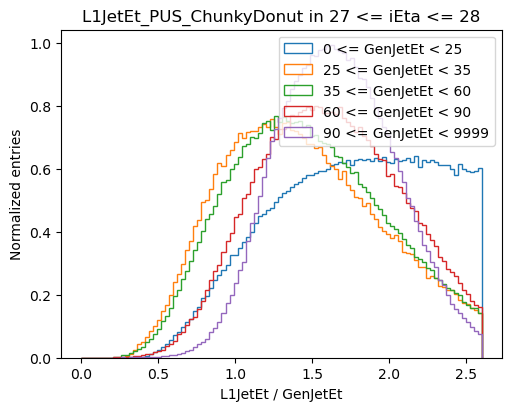

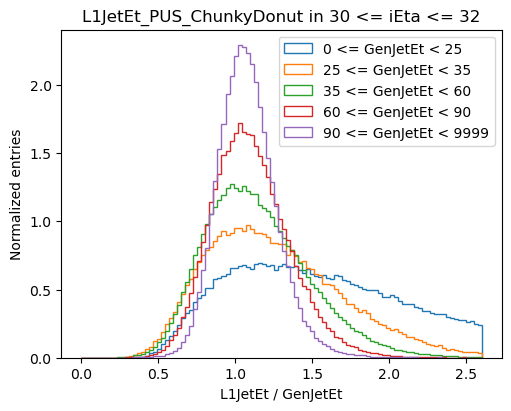

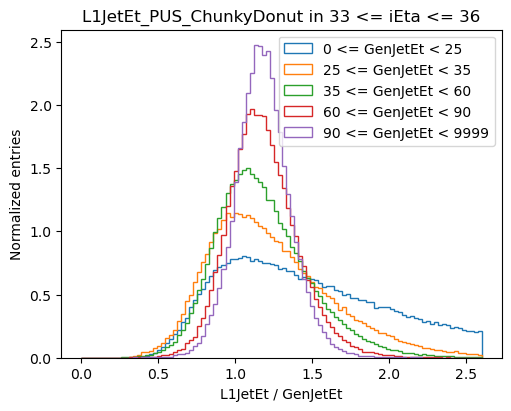

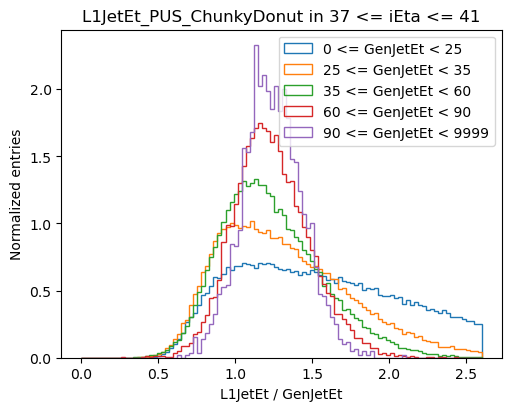

In [9]:
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_all_iEtaBin = data_all[
            (data_all[sL1JetTowerIEtaAbs] >= iEtaBin_first) &  
            (data_all[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_all[sRefJetEt] >= pt_range[0]) &
            (data_all[sRefJetEt] <  pt_range[2])
        ]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()
        
    fig.savefig('%s/beforeJEC_%s_ieta_%d_to_%d_inPtCat.png' % (sOutDirBeforeJEC, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
        


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 1
popt: [4.02492453e+04 6.61421500e-01 1.59765103e-01], 
pcov: 
[[ 7.85993629e+05 -6.84471199e-02 -9.00441102e-01]
 [-6.84471199e-02  8.84252223e-06  2.69649216e-07]
 [-9.00441102e-01  2.69649216e-07  3.57770697e-06]],  
poptErr = array([8.86562817e+02, 2.97363788e-03, 1.89148274e-03])
(1/D) = 1.5118952137690107, (1/D)**2 = 2.2858271374176424, eR = 0.0030589747327328656


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 2
popt: [3.86933392e+04 6.58559753e-01 1.59575411e-01], 
pcov: 
[[ 7.30926656e+05 -4.12691871e-02 -8.98056511e-01]
 [-4.12691871e-02  8.75795281e-06  1.66205331e-07]
 [-8.98056511e-01  1.66205331e-07  3.71027439e-06]],  
poptErr = array([8.54942487e+02, 2.95938386e-03, 1.92620725e-03])
(1/D) = 1.518465097143583, (1/D)**2 = 2.3057362512432706, eR = 0.003120986505825785


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 3
popt: [3.86753663e+04 6.55066865e-01 1.58479229e-01], 
pcov: 
[[ 7.31170535e+05 -6.50503635e-02 -8.63163151e-01]
 [-6.50503635e-02  8.77236663e-06  2.64454023e-07]
 [-8.63163151e-01  2.64454023e-07  3.54054369e-06]],  
poptErr = array([8.55085104e+02, 2.96181813e-03, 1.88163325e-03])
(1/D) = 1.526561720349262, (1/D)**2 = 2.3303906860356984, eR = 0.0030736569829372504


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 4
popt: [3.79360583e+04 6.52017048e-01 1.57844625e-01], 
pcov: 
[[ 6.99542805e+05 -7.75085440e-02 -8.28599055e-01]
 [-7.75085440e-02  8.70530063e-06  3.20431728e-07]
 [-8.28599055e-01  3.20431728e-07  3.45116541e-06]],  
poptErr = array([8.36386756e+02, 2.95047465e-03, 1.85773125e-03])
(1/D) = 1.5337022283436124, (1/D)**2 = 2.352242525226162, eR = 0.0030525482394880947


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 5
popt: [3.82715277e+04 6.47260245e-01 1.58705879e-01], 
pcov: 
[[ 8.46870228e+05 -9.18595009e-02 -1.02046652e+00]
 [-9.18595009e-02  1.03829578e-05  3.77921374e-07]
 [-1.02046652e+00  3.77921374e-07  4.23688868e-06]],  
poptErr = array([9.20255523e+02, 3.22225974e-03, 2.05837039e-03])
(1/D) = 1.5449736144055897, (1/D)**2 = 2.3869434692094718, eR = 0.00340635161343542


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 6
popt: [3.84110149e+04 6.44695199e-01 1.57004614e-01], 
pcov: 
[[ 7.39350930e+05 -9.65774528e-02 -8.52424914e-01]
 [-9.65774528e-02  8.93646602e-06  3.90647235e-07]
 [-8.52424914e-01  3.90647235e-07  3.49098988e-06]],  
poptErr = array([8.59855180e+02, 2.98939225e-03, 1.86841909e-03])
(1/D) = 1.551120593681142, (1/D)**2 = 2.4059750961417388, eR = 0.0031103727802124764


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 7
popt: [3.69903766e+04 6.42405330e-01 1.56682791e-01], 
pcov: 
[[ 6.62255507e+05 -1.09492128e-01 -7.73594536e-01]
 [-1.09492128e-01  8.68390396e-06  4.61585366e-07]
 [-7.73594536e-01  4.61585366e-07  3.28049749e-06]],  
poptErr = array([8.13790825e+02, 2.94684644e-03, 1.81121437e-03])
(1/D) = 1.556649599390494, (1/D)**2 = 2.4231579752825856, eR = 0.0030333024329627736


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 8
popt: [3.62786276e+04 6.40335114e-01 1.56383255e-01], 
pcov: 
[[ 6.33279791e+05 -9.42803486e-02 -7.59996312e-01]
 [-9.42803486e-02  8.55487966e-06  4.04147986e-07]
 [-7.59996312e-01  4.04147986e-07  3.27986865e-06]],  
poptErr = array([7.95788785e+02, 2.92487259e-03, 1.81104076e-03])
(1/D) = 1.5616822779134163, (1/D)**2 = 2.4388515371488366, eR = 0.003040316985892741


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 9
popt: [3.61180214e+04 6.37742732e-01 1.55937648e-01], 
pcov: 
[[ 6.73283986e+05 -1.36102474e-01 -7.81124849e-01]
 [-1.36102474e-01  9.29447790e-06  5.85349769e-07]
 [-7.81124849e-01  5.85349769e-07  3.37638998e-06]],  
poptErr = array([8.20538839e+02, 3.04868462e-03, 1.83749557e-03])
(1/D) = 1.568030414029625, (1/D)**2 = 2.4587193793219173, eR = 0.0031093233607356182


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 10
popt: [3.60923738e+04 6.32936795e-01 1.58481342e-01], 
pcov: 
[[ 6.51221140e+05 -1.17068359e-01 -8.11353836e-01]
 [-1.17068359e-01  9.10101580e-06  5.08202059e-07]
 [-8.11353836e-01  5.08202059e-07  3.57234883e-06]],  
poptErr = array([8.06982738e+02, 3.01678899e-03, 1.89006583e-03])
(1/D) = 1.5799365878995548, (1/D)**2 = 2.496199621783688, eR = 0.003215836846521821


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 11
popt: [3.46039496e+04 6.28279823e-01 1.54451964e-01], 
pcov: 
[[ 6.59982602e+05 -1.93333254e-01 -7.66626654e-01]
 [-1.93333254e-01  9.95982395e-06  8.60503370e-07]
 [-7.66626654e-01  8.60503370e-07  3.42605429e-06]],  
poptErr = array([8.12393133e+02, 3.15591888e-03, 1.85096037e-03])
(1/D) = 1.5916474839917485, (1/D)**2 = 2.533341713297263, eR = 0.0031944033215375394


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 12
popt: [3.32547024e+04 6.17027274e-01 1.54082299e-01], 
pcov: 
[[ 6.02859316e+05 -2.02287962e-01 -7.24330855e-01]
 [-2.02287962e-01  9.86712943e-06  9.34343364e-07]
 [-7.24330855e-01  9.34343364e-07  3.36130107e-06]],  
poptErr = array([7.76440156e+02, 3.14119872e-03, 1.83338514e-03])
(1/D) = 1.620673901482594, (1/D)**2 = 2.6265838949468128, eR = 0.0032318537860564892


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 13
popt: [3.17200705e+04 6.02356616e-01 1.56768299e-01], 
pcov: 
[[ 5.03753302e+05 -1.54438393e-01 -7.05444077e-01]
 [-1.54438393e-01  9.03688230e-06  7.54294781e-07]
 [-7.05444077e-01  7.54294781e-07  3.50170551e-06]],  
poptErr = array([7.09755805e+02, 3.00614077e-03, 1.87128445e-03])
(1/D) = 1.6601461223071854, (1/D)**2 = 2.756085147411584, eR = 0.0033671975148112762


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 14
popt: [3.14325177e+04 5.89485820e-01 1.53185146e-01], 
pcov: 
[[ 5.94682743e+05 -2.71692627e-01 -7.53866132e-01]
 [-2.71692627e-01  1.09697677e-05  1.31732516e-06]
 [-7.53866132e-01  1.31732516e-06  3.68556853e-06]],  
poptErr = array([7.71156756e+02, 3.31206396e-03, 1.91978346e-03])
(1/D) = 1.6963936462960805, (1/D)**2 = 2.8777514031937113, eR = 0.0035690201739334267


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 15
popt: [3.06694841e+04 5.81628169e-01 1.50694762e-01], 
pcov: 
[[ 6.89152746e+05 -4.03194032e-01 -8.73799360e-01]
 [-4.03194032e-01  1.32966089e-05  1.97629807e-06]
 [-8.73799360e-01  1.97629807e-06  4.30372453e-06]],  
poptErr = array([8.30152243e+02, 3.64645155e-03, 2.07454201e-03])
(1/D) = 1.7193115006700856, (1/D)**2 = 2.956032036336422, eR = 0.0039192394388848795


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 16
popt: [2.91502962e+04 5.50068727e-01 1.41348659e-01], 
pcov: 
[[ 5.22646116e+05 -2.89814749e-01 -6.77482013e-01]
 [-2.89814749e-01  9.63212139e-06  1.40174017e-06]
 [-6.77482013e-01  1.40174017e-06  3.29283250e-06]],  
poptErr = array([7.22942678e+02, 3.10356591e-03, 1.81461635e-03])
(1/D) = 1.817954650974886, (1/D)**2 = 3.3049591130012197, eR = 0.003603428928579621


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 17
popt: [3.02770981e+04 5.46486581e-01 1.40496443e-01], 
pcov: 
[[ 5.34850299e+05 -2.62872688e-01 -6.52018752e-01]
 [-2.62872688e-01  9.00940554e-06  1.21630370e-06]
 [-6.52018752e-01  1.21630370e-06  3.03285121e-06]],  
poptErr = array([7.31334602e+02, 3.00156718e-03, 1.74150832e-03])
(1/D) = 1.8298710977566568, (1/D)**2 = 3.3484282344051524, eR = 0.0034855716143050667


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 18
popt: [2.29065800e+04 5.99873758e-01 1.54908050e-01], 
pcov: 
[[ 3.85130044e+05 -2.66219272e-01 -6.46791435e-01]
 [-2.66219272e-01  1.40178582e-05  1.79467829e-06]
 [-6.46791435e-01  1.79467829e-06  4.38402940e-06]],  
poptErr = array([6.20588466e+02, 3.74404302e-03, 2.09380739e-03])
(1/D) = 1.6670174116420209, (1/D)**2 = 2.778947050717663, eR = 0.003844566642410109


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 19
popt: [2.53221270e+04 6.16255150e-01 1.62461764e-01], 
pcov: 
[[ 4.79665633e+05 -2.41255461e-01 -7.90482297e-01]
 [-2.41255461e-01  1.51998698e-05  1.53902735e-06]
 [-7.90482297e-01  1.53902735e-06  5.08627194e-06]],  
poptErr = array([6.92578972e+02, 3.89870104e-03, 2.25527647e-03])
(1/D) = 1.6227044928199856, (1/D)**2 = 2.633169871018167, eR = 0.00402177222281203


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 20
popt: [2.61499127e+04 6.25182021e-01 1.61388799e-01], 
pcov: 
[[ 4.34707908e+05 -1.73638585e-01 -6.89190177e-01]
 [-1.73638585e-01  1.26108690e-05  1.06563108e-06]
 [-6.89190177e-01  1.06563108e-06  4.26317976e-06]],  
poptErr = array([6.59323827e+02, 3.55117853e-03, 2.06474690e-03])
(1/D) = 1.5995341616751588, (1/D)**2 = 2.5585095343658533, eR = 0.003613519306564174


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/240607800.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


PU: [0, 99], Pt: [0, 255.0], iEta: 21
popt: [2.12101510e+04 6.40593505e-01 1.68430537e-01], 
pcov: 
[[ 2.22311249e+05 -3.54004900e-02 -4.89652380e-01]
 [-3.54004900e-02  1.01913040e-05  2.73333673e-07]
 [-4.89652380e-01  2.73333673e-07  3.89967523e-06]],  
poptErr = array([4.71498939e+02, 3.19238219e-03, 1.97475954e-03])
(1/D) = 1.5610523563379208, (1/D)**2 = 2.436884459228175, eR = 0.0033496183883305443


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 22
popt: [2.39870254e+04 6.71370783e-01 1.71122086e-01], 
pcov: 
[[ 3.03113604e+05 -7.82761129e-02 -5.84024412e-01]
 [-7.82761129e-02  1.13636454e-05  5.53426497e-07]
 [-5.84024412e-01  5.53426497e-07  4.17427347e-06]],  
poptErr = array([5.50557540e+02, 3.37100065e-03, 2.04310388e-03])
(1/D) = 1.4894898994229957, (1/D)**2 = 2.2185801604831257, eR = 0.0033013380090295805


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 23
popt: [2.39556591e+04 7.05361116e-01 1.80767840e-01], 
pcov: 
[[ 3.07461636e+05 -2.91156424e-02 -6.88232045e-01]
 [-2.91156424e-02  1.23774929e-05  2.09149384e-07]
 [-6.88232045e-01  2.09149384e-07  5.20963878e-06]],  
poptErr = array([5.54492232e+02, 3.51816612e-03, 2.28246331e-03])
(1/D) = 1.4177135336285973, (1/D)**2 = 2.0099116634336838, eR = 0.003479199170739956


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 24
popt: [2.44506544e+04 8.62718042e-01 2.07942758e-01], 
pcov: 
[[ 4.78305952e+05 -2.02506214e-01 -1.36828251e+00]
 [-2.02506214e-01  2.32786818e-05  1.71254507e-06]
 [-1.36828251e+00  1.71254507e-06  1.16591405e-05]],  
poptErr = array([6.91596669e+02, 4.82479863e-03, 3.41454837e-03])
(1/D) = 1.1591272595206439, (1/D)**2 = 1.343576003763838, eR = 0.0041811489389696


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 25
popt: [2.61949391e+04 9.20394812e-01 2.23374160e-01], 
pcov: 
[[ 7.24097257e+05 -3.84210999e-01 -2.00760194e+00]
 [-3.84210999e-01  3.62456886e-05  3.26508569e-06]
 [-2.00760194e+00  3.26508569e-06  1.71474649e-05]],  
poptErr = array([8.50939044e+02, 6.02043924e-03, 4.14094976e-03])
(1/D) = 1.086490261145183, (1/D)**2 = 1.180461087563328, eR = 0.004770960104832099


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 26
popt: [2.84660094e+04 1.11310890e+00 2.89833937e-01], 
pcov: 
[[ 1.79718088e+06 -3.51944884e+00 -4.99423720e+00]
 [-3.51944884e+00  1.61056794e-04  3.58153958e-05]
 [-4.99423720e+00  3.58153958e-05  5.09462268e-05]],  
poptErr = array([1.34058975e+03, 1.26908153e-02, 7.13766256e-03])
(1/D) = 0.8983846926819343, (1/D)**2 = 0.8070950560452136, eR = 0.0070662232662244435


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 27
popt: [1.06736409e+04 1.45337450e+00 3.76185126e-01], 
pcov: 
[[ 4.64078349e+04 -2.17220442e-01 -5.22658154e-01]
 [-2.17220442e-01  4.44025708e-05  8.19984559e-06]
 [-5.22658154e-01  8.19984559e-06  1.89862847e-05]],  
poptErr = array([2.15424778e+02, 6.66352541e-03, 4.35732541e-03])
(1/D) = 0.6880539047168043, (1/D)**2 = 0.4734181757960412, eR = 0.0032244025528584677


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 28
popt: [2.48886259e+04 1.72983750e+00 4.76973521e-01], 
pcov: 
[[ 5.42197051e+05 -2.01818998e+00 -3.16101039e+00]
 [-2.01818998e+00  2.80451279e-04  8.68438089e-05]
 [-3.16101039e+00  8.68438089e-05  8.68759190e-05]],  
poptErr = array([7.36340309e+02, 1.67466796e-02, 9.32072524e-03])
(1/D) = 0.5780889828782605, (1/D)**2 = 0.33418687212522175, eR = 0.006013189314523031


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 30
popt: [1.03184612e+04 1.05562865e+00 2.43680705e-01], 
pcov: 
[[ 1.65408700e+05 -5.90164080e-01 -1.30112532e+00]
 [-5.90164080e-01  6.79288309e-05  1.39321567e-05]
 [-1.30112532e+00  1.39321567e-05  3.07553404e-05]],  
poptErr = array([4.06704684e+02, 8.24189486e-03, 5.54574976e-03])
(1/D) = 0.9473028230827695, (1/D)**2 = 0.8973826386205849, eR = 0.005554059393437635


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 31
popt: [1.07735032e+04 1.13644898e+00 2.69498517e-01], 
pcov: 
[[ 2.10944006e+05 -8.78095330e-01 -1.75881736e+00]
 [-8.78095330e-01  9.92413186e-05  2.19497519e-05]
 [-1.75881736e+00  2.19497519e-05  4.40897158e-05]],  
poptErr = array([4.59286409e+02, 9.96199371e-03, 6.64000872e-03])
(1/D) = 0.8799339139529706, (1/D)**2 = 0.7742836929245939, eR = 0.006201544918302465


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 32
popt: [8.00734717e+03 1.15904323e+00 2.76086641e-01], 
pcov: 
[[ 1.28932479e+05 -7.86537740e-01 -1.49886700e+00]
 [-7.86537740e-01  1.16389094e-04  2.70858495e-05]
 [-1.49886700e+00  2.70858495e-05  5.18737188e-05]],  
poptErr = array([3.59071690e+02, 1.07883777e-02, 7.20234120e-03])
(1/D) = 0.8627805894429611, (1/D)**2 = 0.7443903455195434, eR = 0.006597742976727459


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 33
popt: [6.90020990e+03 1.28131174e+00 3.04883324e-01], 
pcov: 
[[ 9.55349239e+04 -8.48344529e-01 -1.33778677e+00]
 [-8.48344529e-01  1.51709401e-04  3.75090289e-05]
 [-1.33778677e+00  3.75090289e-05  5.92741421e-05]],  
poptErr = array([3.09087243e+02, 1.23170370e-02, 7.69897020e-03])
(1/D) = 0.7804501969725324, (1/D)**2 = 0.6091025099544646, eR = 0.006429303455327266


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 34
popt: [7.85466622e+03 1.09533511e+00 2.55210532e-01], 
pcov: 
[[ 7.78336333e+04 -2.84469647e-01 -8.71223778e-01]
 [-2.84469647e-01  5.70367493e-05  9.22839992e-06]
 [-8.71223778e-01  9.22839992e-06  2.83629501e-05]],  
poptErr = array([2.78986798e+02, 7.55226783e-03, 5.32568775e-03])
(1/D) = 0.9129626054027163, (1/D)**2 = 0.8335007188637159, eR = 0.005120683163239051


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 35
popt: [5.85008957e+03 1.17282896e+00 2.68132889e-01], 
pcov: 
[[ 5.91393055e+04 -4.32282783e-01 -8.82575800e-01]
 [-4.32282783e-01  9.37021068e-05  1.97996165e-05]
 [-8.82575800e-01  1.97996165e-05  4.05224106e-05]],  
poptErr = array([2.43185743e+02, 9.67998485e-03, 6.36572153e-03])
(1/D) = 0.8526392490617324, (1/D)**2 = 0.726993689040555, eR = 0.00574630623527488


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 36
popt: [4.32991284e+03 1.21603600e+00 2.82739821e-01], 
pcov: 
[[ 4.03200258e+04 -5.13567882e-01 -8.33744957e-01]
 [-5.13567882e-01  1.38629895e-04  3.35123134e-05]
 [-8.33744957e-01  3.35123134e-05  5.46023642e-05]],  
poptErr = array([2.00798471e+02, 1.17741197e-02, 7.38934126e-03])
(1/D) = 0.8223440761466722, (1/D)**2 = 0.6762497795735237, eR = 0.006480195691814513


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 37
popt: [2.31960260e+03 1.41557100e+00 3.53366063e-01], 
pcov: 
[[ 1.72136222e+04 -6.59966275e-01 -8.26912553e-01]
 [-6.59966275e-01  3.65145524e-04  1.02726923e-04]
 [-8.26912553e-01  1.02726923e-04  1.29011456e-04]],  
poptErr = array([1.31200694e+02, 1.91087813e-02, 1.13583210e-02])
(1/D) = 0.7064287118031426, (1/D)**2 = 0.4990415248598475, eR = 0.008702707802724797


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 38
popt: [1.87637201e+03 1.33772389e+00 3.28165997e-01], 
pcov: 
[[ 1.16483199e+04 -4.95928856e-01 -6.43207825e-01]
 [-4.95928856e-01  3.16206216e-04  8.68673245e-05]
 [-6.43207825e-01  8.68673245e-05  1.14202906e-04]],  
poptErr = array([1.07927383e+02, 1.77821882e-02, 1.06865760e-02])
(1/D) = 0.7475384170226513, (1/D)**2 = 0.5588136849247314, eR = 0.008628558609721428


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 39
popt: [1.46882438e+03 1.25742486e+00 3.12535418e-01], 
pcov: 
[[ 6.25014875e+03 -2.86983178e-01 -4.40588231e-01]
 [-2.86983178e-01  2.33617435e-04  6.06695600e-05]
 [-4.40588231e-01  6.06695600e-05  9.53603975e-05]],  
poptErr = array([7.90578823e+01, 1.52845489e-02, 9.76526484e-03])
(1/D) = 0.7952761516907384, (1/D)**2 = 0.6324641574480303, eR = 0.008333068593176719


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 40
popt: [4.10226395e+02 1.15010618e+00 2.65949919e-01], 
pcov: 
[[ 2.91874856e+02 -3.08924687e-02 -6.64570768e-02]
 [-3.08924687e-02  9.02071598e-05  1.98958734e-05]
 [-6.64570768e-02  1.98958734e-05  4.35643952e-05]],  
poptErr = array([1.70843454e+01, 9.49774498e-03, 6.60033296e-03])
(1/D) = 0.8694849360366561, (1/D)**2 = 0.756004053994668, eR = 0.006048261447591153


/tmp/ipykernel_12078/240607800.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU: [0, 99], Pt: [0, 255.0], iEta: 41
popt: [3.60419957e+02 9.99237778e-01 2.57597226e-01], 
pcov: 
[[ 2.19982037e+02 -2.32569135e-02 -5.65874770e-02]
 [-2.32569135e-02  8.08546992e-05  1.63294474e-05]
 [-5.65874770e-02  1.63294474e-05  4.12411220e-05]],  
poptErr = array([1.48317914e+01, 8.99192411e-03, 6.42192510e-03])
(1/D) = 1.0007628030821047, (1/D)**2 = 1.0015261880327515, eR = 0.0068326915705567174


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


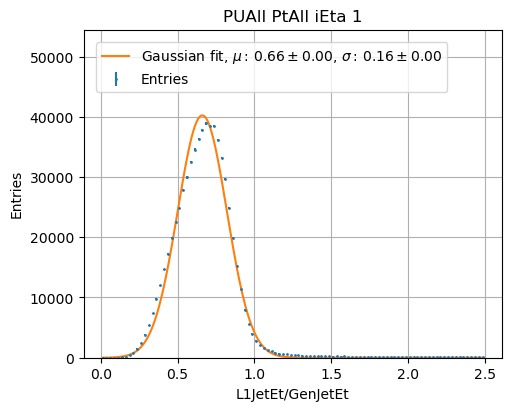

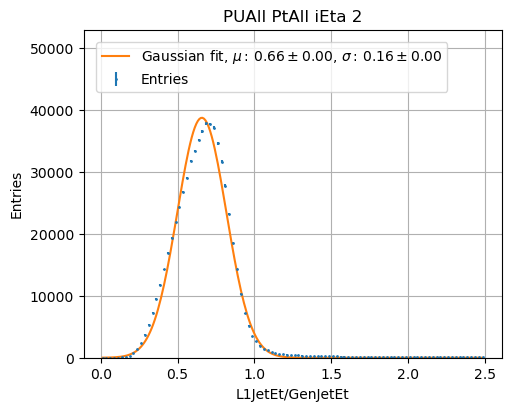

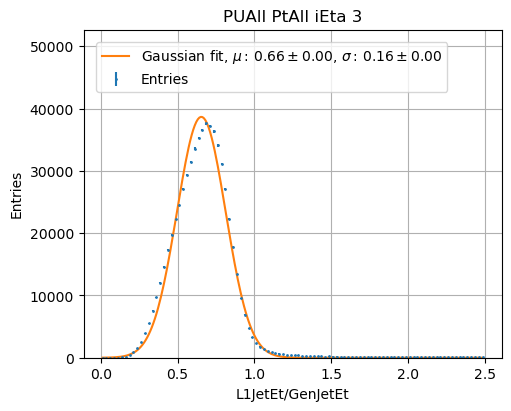

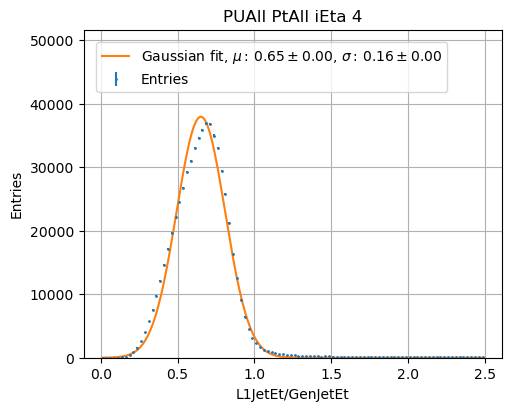

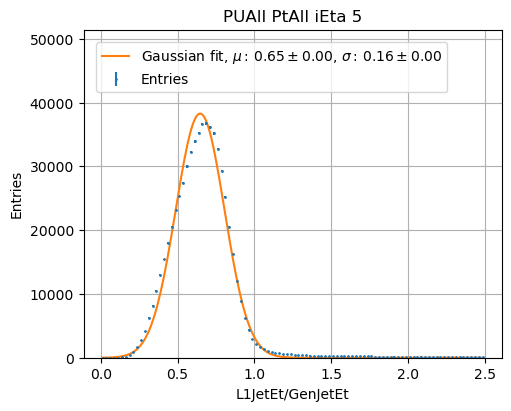

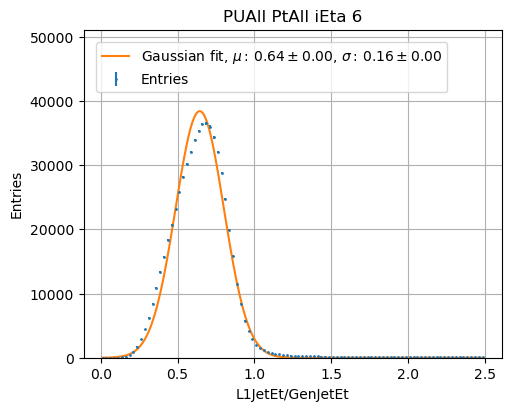

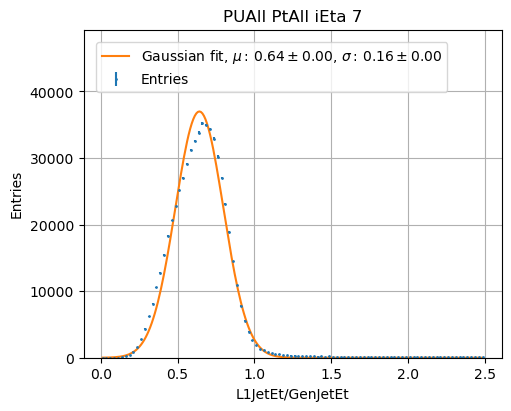

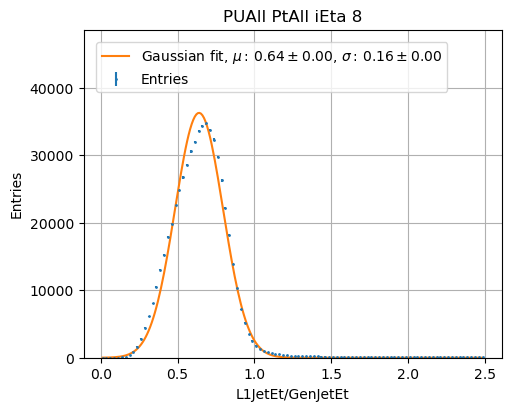

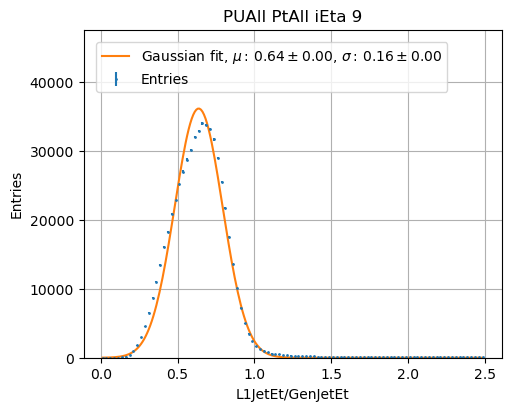

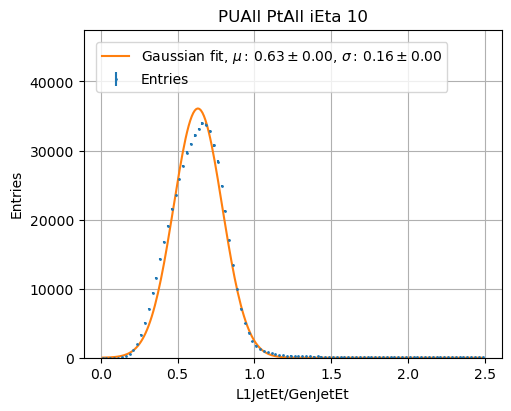

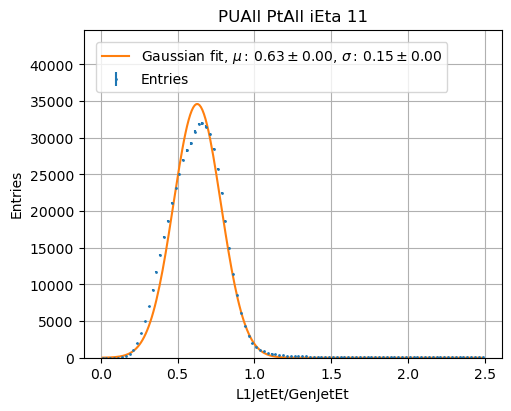

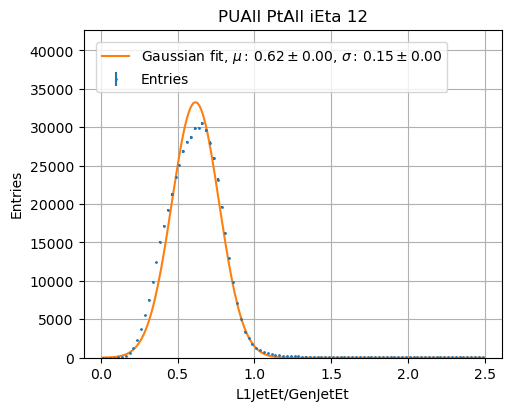

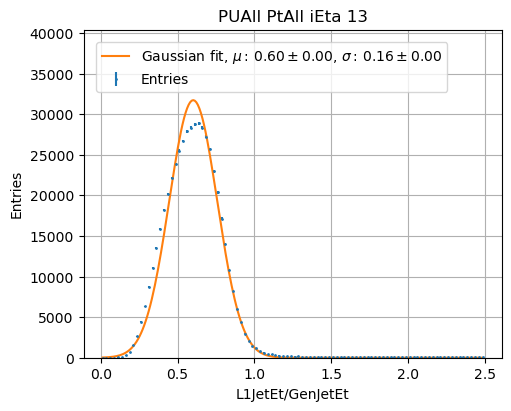

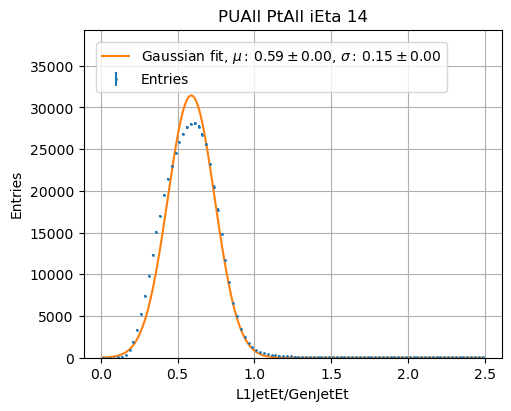

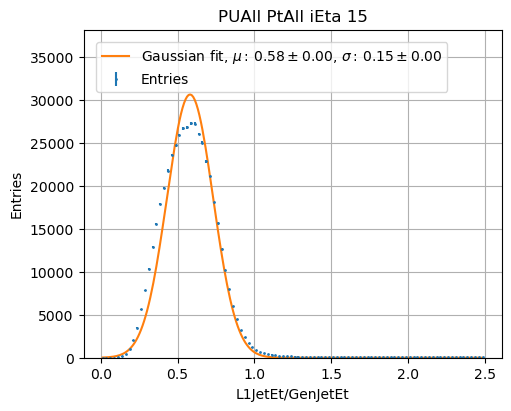

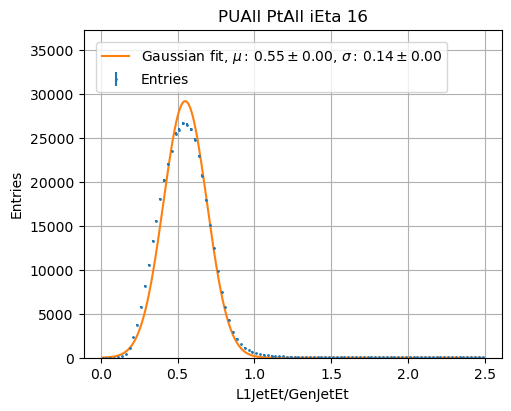

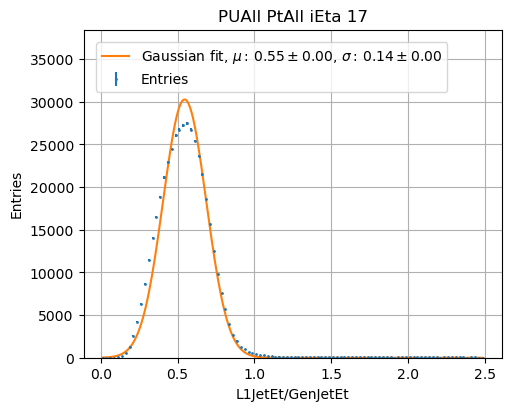

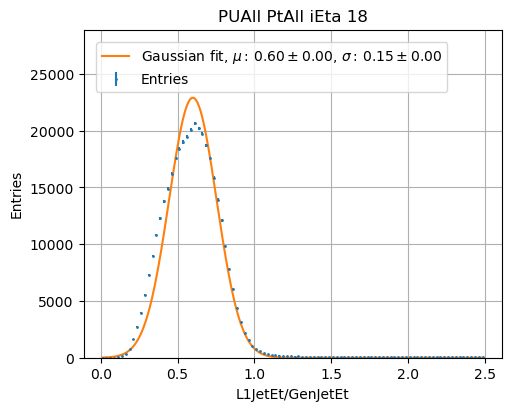

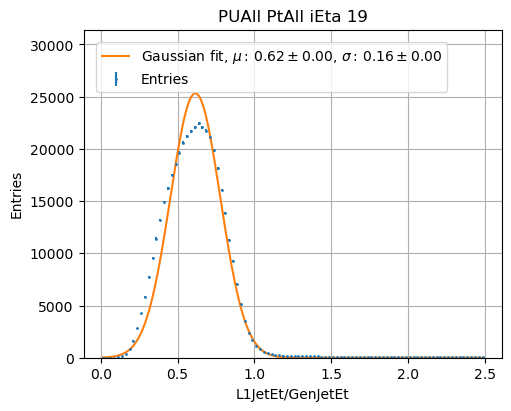

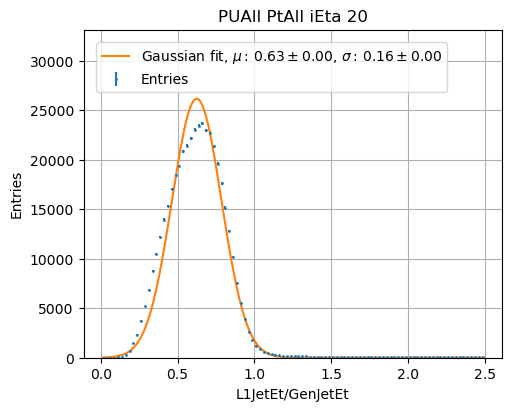

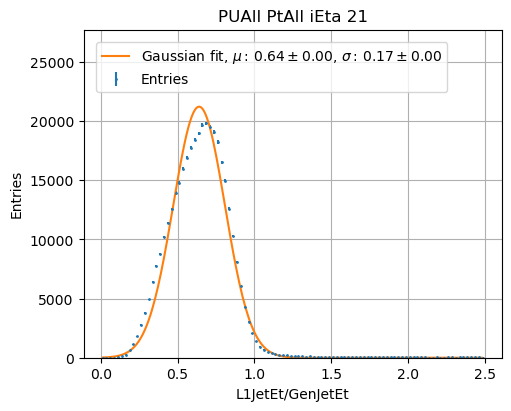

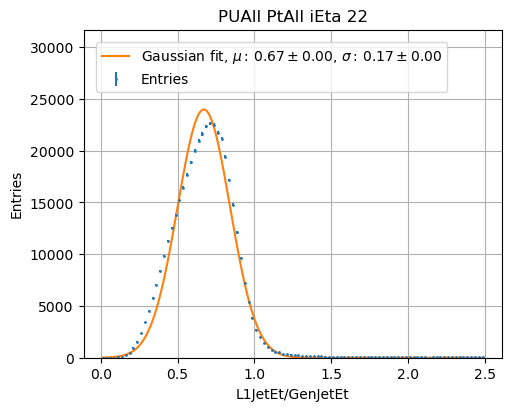

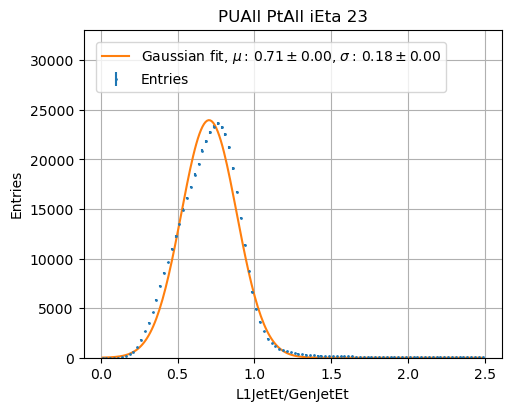

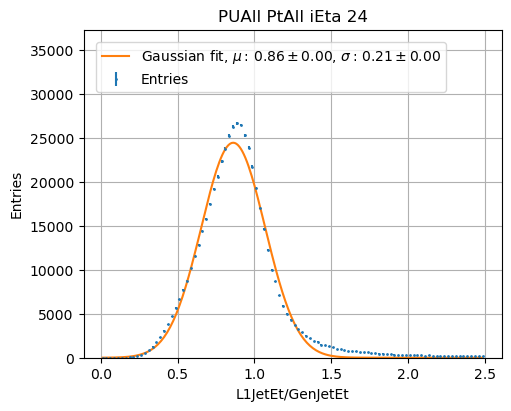

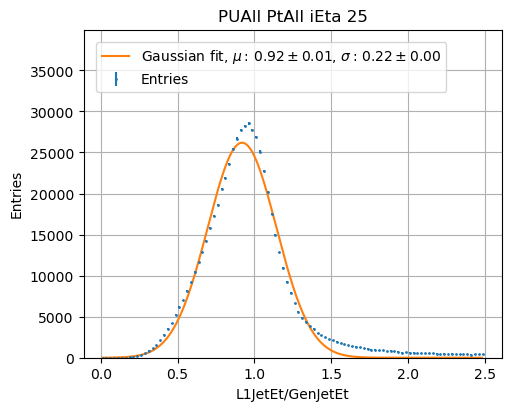

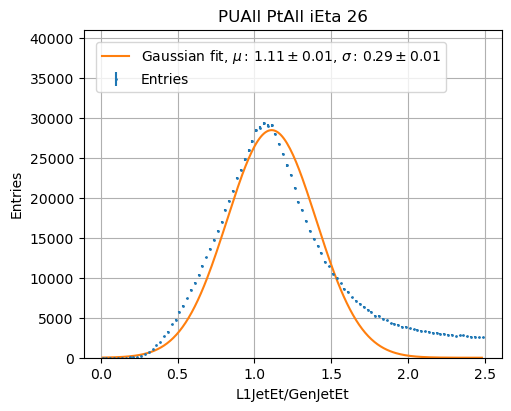

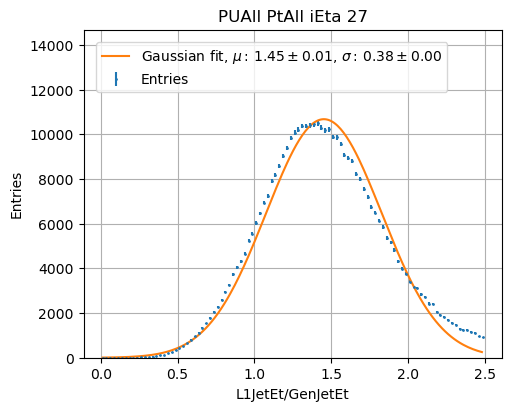

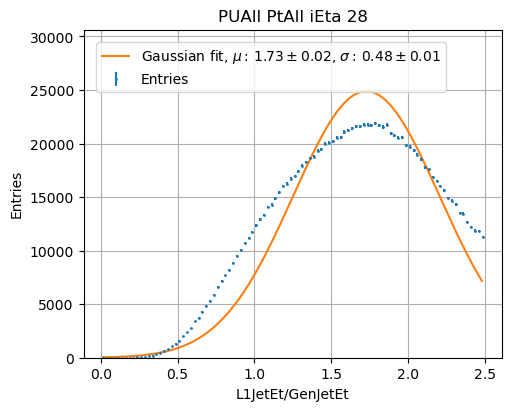

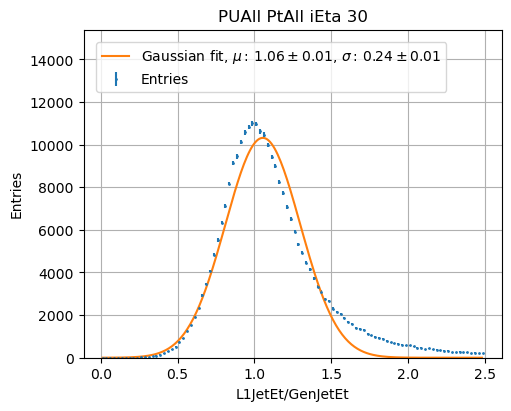

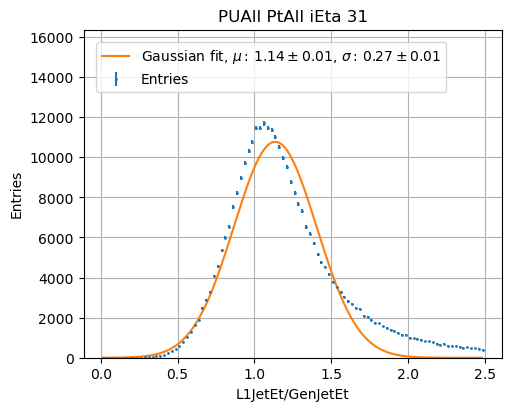

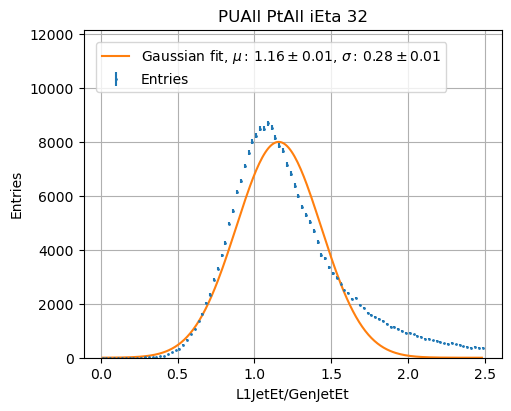

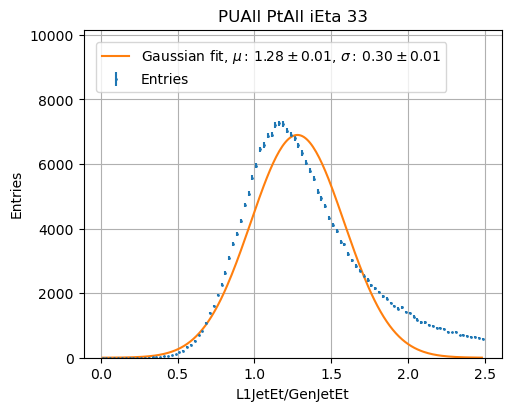

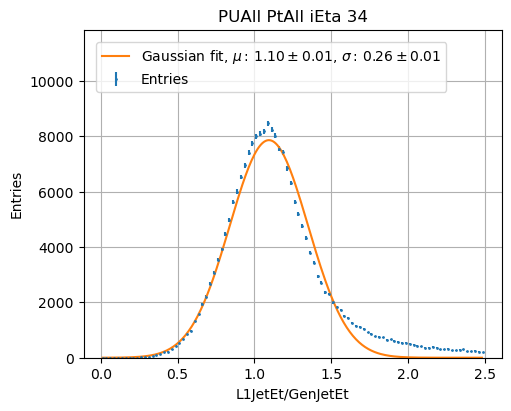

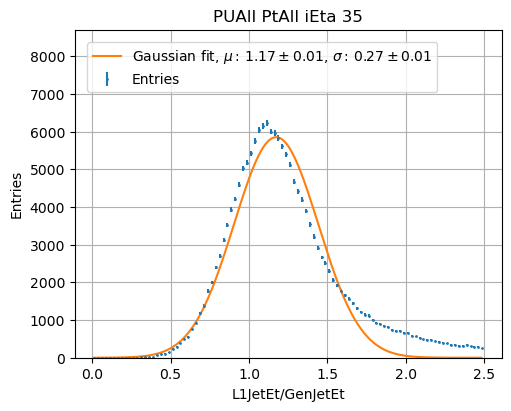

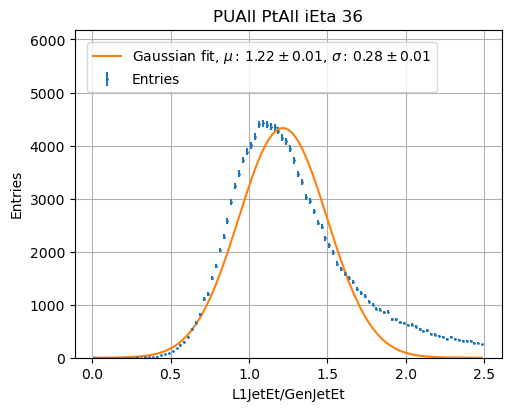

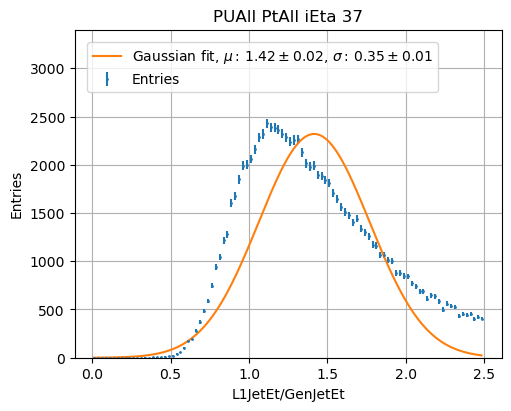

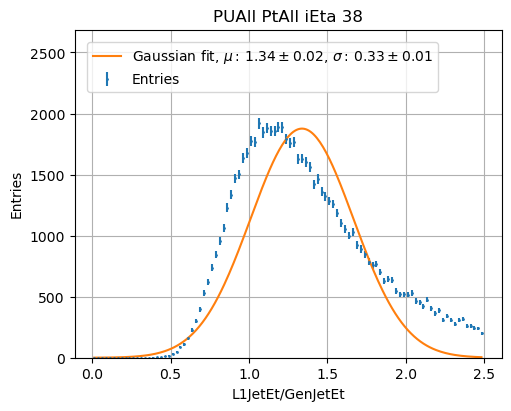

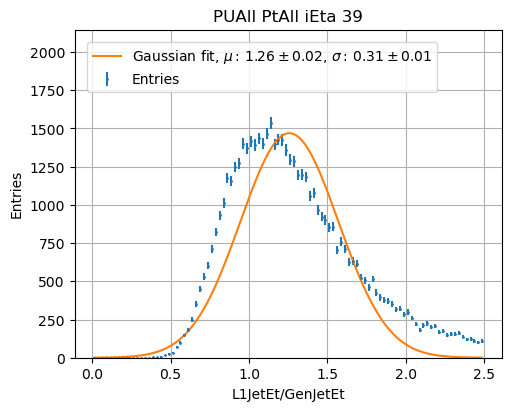

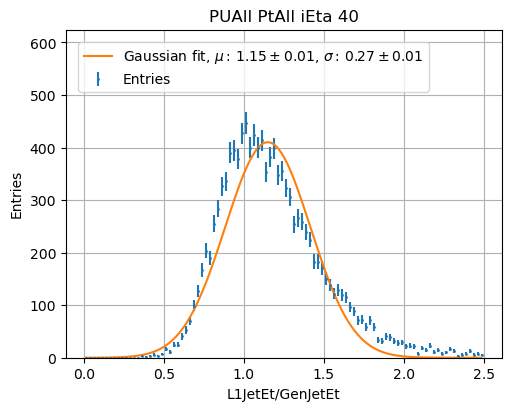

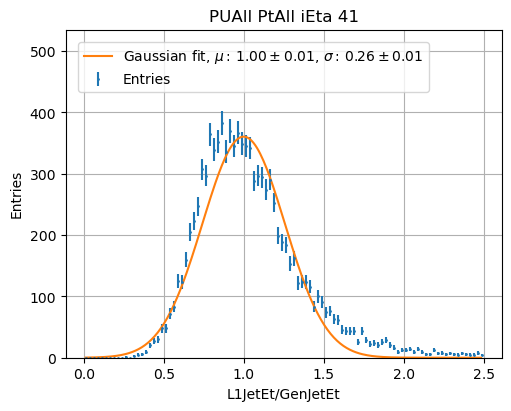

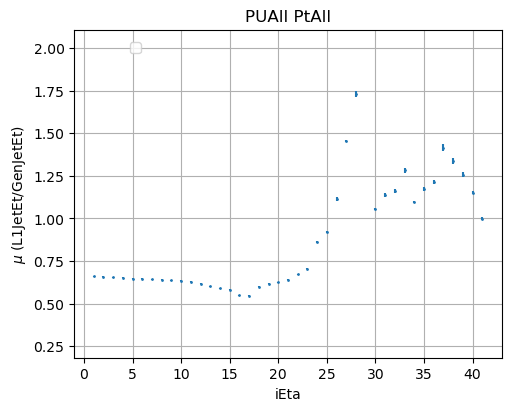

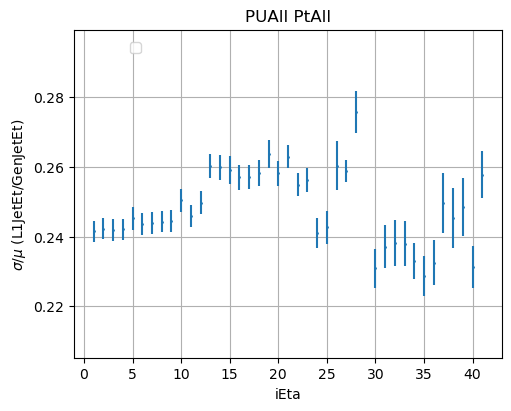

In [73]:

def GaussianFunction(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def calculate_errorOfRatio(N, D, eN, eD):
    #R = N / D
    return np.sqrt( ( ((1/D)**2) * (eN**2) ) +  ( ((N/(D**2))**2) * (eD**2) ) )


Pt_Cat_forResolutionPlots = OD()
#Pt_Cat_forResolutionPlots['Pt25to35'] = [25, 35]
Pt_Cat_forResolutionPlots['PtAll'] = [0, L1JetPtMax]

PU_Cat_forResolutionPlots = OD()
PU_Cat_forResolutionPlots['PUAll'] = [0, 99]

sL1JetEt_forResolutionPlots = sL1JetEt
sL1JetResponse = 'L1JetEt/%s' % (sRefJetEt)


sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetResponse_vs_iEta' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):             os.mkdir( sOutDir1D_toUse )    



for PU_category, PURange in PU_Cat_forResolutionPlots.items():
    PURangeMin = PURange[0]
    PURangeMax = PURange[1]

    for Pt_category, PtRange in Pt_Cat_forResolutionPlots.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        JES = OD()
        JER = OD()
        for iEtaBin in iEtaBins:
            data_toUse_ = data_all[
                (data_all[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                (data_all[sRefJetEt]               >= PtRangeMin) &
                (data_all[sRefJetEt]               <  PtRangeMax) & 
                (data_all[snVtx]                   >= PURangeMin) &
                (data_all[snVtx]                   <  PURangeMax)
            ]#.copy()
            data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
            print(f"PU: {PURange}, Pt: {PtRange}, iEta: {iEtaBin}")
            
            h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
            h.fill(data_toUse_[sL1JetResponse])
            
            x_    = h.axes[0].centers
            y_    = h.values()
            yErr_ = np.sqrt(h.variances())
                        
            # index of bins with y>0
            idx_NonZeroY = np.nonzero(y_)
            
            # Give initial parameters for Gaussian function fit
            #pInitial = [y_.max(), 1, 0.3]
            pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
            
            #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
            popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
            poptErr    = np.sqrt(np.diag(pcov))
            print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")
            
            Mean_  = popt[1];    errMean_  = poptErr[1]
            Sigma_ = popt[2];    errSigma_ = poptErr[2]
            
            x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            
            
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            axs.set_xlabel(sL1JetResponse)
            axs.set_ylabel('Entries')
            axs.set_title('%s %s iEta %s' % (PU_category, Pt_category, iEtaBin))
            axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
            axs.set_ylim(0, y_.max() * 1.4)
            axs.grid()
            
            errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
            JES[iEtaBin] = {'value': Mean_,          'error': errMean_}
            JER[iEtaBin] = {'value': Sigma_ / Mean_, 'error': errJER_}
                                   
            fig.savefig('%s/L1JetResponse_1D_%s_%s_ieta_%d.png' % (sOutDir1D_toUse, PU_category, Pt_category, iEtaBin))
            
                        
            
                    
            
        # plot JES vs iEta
        JES_iEtawise    = [ JES[iEtaBin]['value'] for iEtaBin in JES.keys()]
        errJES_iEtawise = [ JES[iEtaBin]['error'] for iEtaBin in JES.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JES_iEtawise)
        axs.errorbar(list(JES.keys()), JES_iEtawise, yerr=errJES_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Mean.png' % (sOutDir_toUse, PU_category, Pt_category))
        
        
        # plot JER vs iEta
        JER_iEtawise    = [ JER[iEtaBin]['value'] for iEtaBin in JER.keys()]
        errJER_iEtawise = [ JER[iEtaBin]['error'] for iEtaBin in JER.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JER_iEtawise)
        axs.errorbar(list(JER.keys()), JER_iEtawise, yerr=errJER_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Resolution.png' % (sOutDir_toUse, PU_category, Pt_category))       

RefJetPtBins_forResolutionPlots: [20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 65.5, 70.5, 75.5, 80.5, 85.5, 90.5, 95.5, 100.5, 105.5, 110.5, 115.5, 120.5, 130.5, 140.5, 150.5, 160.5, 170.5, 180.5, 190.5, 200.5, 210.5, 220.5, 230.5, 240.5, 250.5]


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.89410264e+02 6.24484731e-01 2.25533453e-01], 
pcov: 
[[ 2.48962082e+02  1.64981457e-02 -7.44576585e-02]
 [ 1.64981457e-02  1.94279963e-04 -1.05031242e-04]
 [-7.44576585e-02 -1.05031242e-04  1.10570736e-04]],  
poptErr = array([1.57785323e+01, 1.39384348e-02, 1.05152620e-02])
(1/D) = 1.601320177515517, (1/D)**2 = 2.5642263109183268, eR = 0.018668311080026673


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.66210962e+02 6.25000001e-01 1.94777936e-01], 
pcov: 
[[ 6.55377590e+02  2.77176485e-02 -1.49841178e-01]
 [ 2.77176485e-02  1.20610783e-04 -4.66755722e-05]
 [-1.49841178e-01 -4.66755722e-05  9.55359287e-05]],  
poptErr = array([2.56003436e+01, 1.09822941e-02, 9.77424824e-03])
(1/D) = 1.5999999969296623, (1/D)**2 = 2.5599999901749193, eR = 0.016569847439636687


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.35177218e+02 5.63544749e-01 2.14883951e-01], 
pcov: 
[[ 3.75252493e+02  2.50514945e-02 -8.28008105e-02]
 [ 2.50514945e-02  1.15991544e-04 -6.14195798e-05]
 [-8.28008105e-02 -6.14195798e-05  7.17998666e-05]],  
poptErr = array([1.93714350e+01, 1.07699371e-02, 8.47348019e-03])
(1/D) = 1.7744819775136949, (1/D)**2 = 3.1487862885209132, eR = 0.016708848911440904


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.99686142e+02 5.32222528e-01 2.18952835e-01], 
pcov: 
[[ 2.52438028e+02  1.44360509e-02 -4.83183481e-02]
 [ 1.44360509e-02  7.51237766e-05 -4.01007062e-05]
 [-4.83183481e-02 -4.01007062e-05  4.23501376e-05]],  
poptErr = array([1.58882985e+01, 8.66739734e-03, 6.50769834e-03])
(1/D) = 1.8789133247740575, (1/D)**2 = 3.5303152820135026, eR = 0.013942552997490592


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.66511863e+02 5.32282540e-01 2.06316846e-01], 
pcov: 
[[ 2.14975064e+02  1.27446918e-02 -3.56016402e-02]
 [ 1.27446918e-02  3.39197128e-05 -1.68075331e-05]
 [-3.56016402e-02 -1.68075331e-05  2.08239352e-05]],  
poptErr = array([1.46620280e+01, 5.82406326e-03, 4.56332501e-03])
(1/D) = 1.878701489139864, (1/D)**2 = 3.529519285296342, eR = 0.009564791130921837


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.94222240e+02 5.31878370e-01 1.96093635e-01], 
pcov: 
[[ 3.04944897e+02  1.41126314e-02 -4.62217337e-02]
 [ 1.41126314e-02  2.86553270e-05 -1.23712139e-05]
 [-4.62217337e-02 -1.23712139e-05  2.03556004e-05]],  
poptErr = array([1.74626715e+01, 5.35306706e-03, 4.51171812e-03])
(1/D) = 1.8801290976249927, (1/D)**2 = 3.5348854237361693, eR = 0.009258677104196904


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.41334810e+02 5.44501677e-01 1.75658500e-01], 
pcov: 
[[ 7.09009478e+02  8.16644731e-03 -8.12476665e-02]
 [ 8.16644731e-03  3.10350484e-05 -6.17911920e-06]
 [-8.12476665e-02 -6.17911920e-06  2.40190010e-05]],  
poptErr = array([2.66272319e+01, 5.57091091e-03, 4.90091838e-03])
(1/D) = 1.8365416350390413, (1/D)**2 = 3.372885177231875, eR = 0.009586839710626948


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.10348341e+02 5.52835360e-01 1.58201641e-01], 
pcov: 
[[ 1.84199425e+03 -2.66588722e-02 -1.47733730e-01]
 [-2.66588722e-02  4.91887778e-05  3.18887656e-06]
 [-1.47733730e-01  3.18887656e-06  3.18195627e-05]],  
poptErr = array([4.29184604e+01, 7.01347116e-03, 5.64088315e-03])
(1/D) = 1.8088568003565186, (1/D)**2 = 3.271962924196022, eR = 0.010830148012482808


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.80343530e+02 5.38840291e-01 1.77441444e-01], 
pcov: 
[[ 4.04459090e+02  5.89345793e-03 -4.31485524e-02]
 [ 5.89345793e-03  1.60401940e-05 -3.22554680e-06]
 [-4.31485524e-02 -3.22554680e-06  1.19217571e-05]],  
poptErr = array([2.01111683e+01, 4.00502109e-03, 3.45278976e-03])
(1/D) = 1.855837464472393, (1/D)**2 = 3.4441326945393205, eR = 0.006859361484388766


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.32542804e+02 5.54726323e-01 1.50068115e-01], 
pcov: 
[[ 1.83226602e+03 -3.83462804e-02 -1.22033734e-01]
 [-3.83462804e-02  4.27258404e-05  6.22644391e-06]
 [-1.22033734e-01  6.22644391e-06  2.31913744e-05]],  
poptErr = array([4.28049766e+01, 6.53650063e-03, 4.81574235e-03])
(1/D) = 1.8026907309001337, (1/D)**2 = 3.249693871273258, eR = 0.009248039779430266


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.92392061e+02 5.45068575e-01 1.66715948e-01], 
pcov: 
[[ 5.24452263e+02 -7.16920423e-04 -4.70546541e-02]
 [-7.16920423e-04  1.59350216e-05 -6.74122242e-07]
 [-4.70546541e-02 -6.74122242e-07  1.10214791e-05]],  
poptErr = array([2.29009227e+01, 3.99186944e-03, 3.31986131e-03])
(1/D) = 1.834631542433623, (1/D)**2 = 3.3658728964923745, eR = 0.006489574031433499


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.22924967e+02 5.54383948e-01 1.53575617e-01], 
pcov: 
[[ 1.00541559e+03 -1.59564623e-02 -6.84586942e-02]
 [-1.59564623e-02  2.44324312e-05  2.64005064e-06]
 [-6.84586942e-02  2.64005064e-06  1.33511047e-05]],  
poptErr = array([3.17082889e+01, 4.94291728e-03, 3.65391636e-03])
(1/D) = 1.8038040323247584, (1/D)**2 = 3.253708987031058, eR = 0.007038547755047043


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.68221623e+02 5.53978408e-01 1.64658767e-01], 
pcov: 
[[ 4.09489668e+02 -2.73338195e-03 -3.49256104e-02]
 [-2.73338195e-03  1.26463831e-05  2.42572812e-07]
 [-3.49256104e-02  2.42572812e-07  8.00357849e-06]],  
poptErr = array([2.02358511e+01, 3.55617535e-03, 2.82905965e-03])
(1/D) = 1.8051245061273173, (1/D)**2 = 3.2584744826213914, eR = 0.005451604076961475


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.70566871e+02 5.58659754e-01 1.63487914e-01], 
pcov: 
[[ 2.95345464e+02 -1.32515142e-03 -2.46175088e-02]
 [-1.32515142e-03  8.92266946e-06  5.69730072e-08]
 [-2.46175088e-02  5.69730072e-08  5.55605192e-06]],  
poptErr = array([1.71856180e+01, 2.98708377e-03, 2.35712790e-03])
(1/D) = 1.7899982808988504, (1/D)**2 = 3.20409384562084, eR = 0.004500053226465101


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.86995343e+02 5.66611329e-01 1.53513782e-01], 
pcov: 
[[ 6.72219236e+02 -1.13219712e-02 -4.49891304e-02]
 [-1.13219712e-02  1.79834719e-05  2.08621072e-06]
 [-4.49891304e-02  2.08621072e-06  9.00089237e-06]],  
poptErr = array([2.59271911e+01, 4.24069239e-03, 3.00014872e-03])
(1/D) = 1.7648782316617369, (1/D)**2 = 3.1147951725934595, eR = 0.005669893426766204


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.50978113e+02 5.67638858e-01 1.56764163e-01], 
pcov: 
[[ 3.76300109e+02 -4.29189191e-03 -2.82690103e-02]
 [-4.29189191e-03  1.11117592e-05  7.93788647e-07]
 [-2.82690103e-02  7.93788647e-07  6.07916254e-06]],  
poptErr = array([1.93984564e+01, 3.33343055e-03, 2.46559578e-03])
(1/D) = 1.7616834816070082, (1/D)**2 = 3.10352868936699, eR = 0.004636491156735996


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.43965217e+03 5.76026074e-01 1.57515423e-01], 
pcov: 
[[ 7.17460174e+02 -2.90332932e-03 -2.89653158e-02]
 [-2.90332932e-03  5.68450979e-06  2.66795640e-07]
 [-2.89653158e-02  2.66795640e-07  3.25704414e-06]],  
poptErr = array([2.67854471e+01, 2.38422100e-03, 1.80472827e-03])
(1/D) = 1.7360325254738, (1/D)**2 = 3.01380892950294, eR = 0.0033312418267795857


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39991367e+03 5.89110890e-01 1.53659816e-01], 
pcov: 
[[ 6.24325858e+02 -3.46233476e-03 -2.34859936e-02]
 [-3.46233476e-03  5.08869123e-06  3.63528649e-07]
 [-2.34859936e-02  3.63528649e-07  2.60910079e-06]],  
poptErr = array([2.49865135e+01, 2.25581276e-03, 1.61527112e-03])
(1/D) = 1.6974732895496847, (1/D)**2 = 2.8814155687346275, eR = 0.002918126533980539


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.30123783e+03 6.00344385e-01 1.54346525e-01], 
pcov: 
[[ 3.25329487e+02 -1.19471332e-03 -1.37182260e-02]
 [-1.19471332e-03  3.00970643e-06  1.32757401e-07]
 [-1.37182260e-02  1.32757401e-07  1.64428228e-06]],  
poptErr = array([1.80368924e+01, 1.73485055e-03, 1.28229571e-03])
(1/D) = 1.665710590975757, (1/D)**2 = 2.774591772888806, eR = 0.0022614559003445874


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.25843665e+03 6.10001796e-01 1.52359187e-01], 
pcov: 
[[ 1.97205476e+02 -5.21285103e-04 -8.39287735e-03]
 [-5.21285103e-04  1.90209764e-06  5.90541484e-08]
 [-8.39287735e-03  5.90541484e-08  1.02453542e-06]],  
poptErr = array([1.40429867e+01, 1.37916556e-03, 1.01219337e-03])
(1/D) = 1.6393394369300958, (1/D)**2 = 2.6874337894742832, eR = 0.001752787666314422


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23342742e+03 6.21966213e-01 1.47876675e-01], 
pcov: 
[[ 2.31446996e+02 -4.87036442e-04 -9.82856146e-03]
 [-4.87036442e-04  2.16762105e-06  5.58071894e-08]
 [-9.82856146e-03  5.58071894e-08  1.18417380e-06]],  
poptErr = array([1.52133821e+01, 1.47228430e-03, 1.08819750e-03])
(1/D) = 1.6078043770794805, (1/D)**2 = 2.5850349149559366, eR = 0.001837900932873861


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20425112e+03 6.31299723e-01 1.45715940e-01], 
pcov: 
[[ 1.38201592e+02 -6.55296498e-05 -5.82182547e-03]
 [-6.55296498e-05  1.32597223e-06  6.74330116e-09]
 [-5.82182547e-03  6.74330116e-09  7.06847174e-07]],  
poptErr = array([1.17559173e+01, 1.15150868e-03, 8.40742038e-04])
(1/D) = 1.5840336425047092, (1/D)**2 = 2.509162580586737, eR = 0.0013967292536602354


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.17902049e+03 6.38986192e-01 1.42499272e-01], 
pcov: 
[[ 2.10473619e+02 -1.76608736e-04 -8.93317331e-03]
 [-1.76608736e-04  1.99899217e-06  2.07801334e-08]
 [-8.93317331e-03  2.07801334e-08  1.08099245e-06]],  
poptErr = array([1.45077090e+01, 1.41385720e-03, 1.03970787e-03])
(1/D) = 1.5649790438606337, (1/D)**2 = 2.4491594077229433, eR = 0.001700296108100857


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09804262e+03 6.50312123e-01 1.42219478e-01], 
pcov: 
[[ 2.11673624e+02  8.89894062e-05 -9.84896430e-03]
 [ 8.89894062e-05  2.27921457e-06 -1.19259408e-08]
 [-9.84896430e-03 -1.19259408e-08  1.27700355e-06]],  
poptErr = array([1.45490077e+01, 1.50970678e-03, 1.13004582e-03])
(1/D) = 1.537723141018422, (1/D)**2 = 2.364592458423562, eR = 0.0018103461605185514


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.07736452e+03 6.56114099e-01 1.39047386e-01], 
pcov: 
[[ 1.53282728e+02  1.99216914e-04 -6.91330534e-03]
 [ 1.99216914e-04  1.66537752e-06 -2.57664592e-08]
 [-6.91330534e-03 -2.57664592e-08  8.93517220e-07]],  
poptErr = array([1.23807402e+01, 1.29049507e-03, 9.45260398e-04])
(1/D) = 1.5241251499546662, (1/D)**2 = 2.3229574727243336, eR = 0.0014997836271251148


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.08212090e+03 6.66189596e-01 1.35936792e-01], 
pcov: 
[[ 2.60557645e+02  2.77981302e-04 -1.18139940e-02]
 [ 2.77981302e-04  2.63097343e-06 -3.52954431e-08]
 [-1.18139940e-02 -3.52954431e-08  1.48496517e-06]],  
poptErr = array([1.61417981e+01, 1.62202757e-03, 1.21859147e-03])
(1/D) = 1.5010741771646605, (1/D)**2 = 2.2532236853505627, eR = 0.001895465472453322


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03349228e+03 6.74328502e-01 1.34740596e-01], 
pcov: 
[[ 2.27696244e+02  5.43887762e-04 -1.05615439e-02]
 [ 5.43887762e-04  2.49771886e-06 -7.10289164e-08]
 [-1.05615439e-02 -7.10289164e-08  1.37722356e-06]],  
poptErr = array([1.50896072e+01, 1.58041731e-03, 1.17355168e-03])
(1/D) = 1.4829567434401312, (1/D)**2 = 2.199160702914559, eR = 0.0018022330299727566


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.02603074e+03 6.80460412e-01 1.30396853e-01], 
pcov: 
[[ 2.15011934e+02  2.95158841e-04 -9.82880767e-03]
 [ 2.95158841e-04  2.22506685e-06 -3.75094532e-08]
 [-9.82880767e-03 -3.75094532e-08  1.24922881e-06]],  
poptErr = array([1.46632852e+01, 1.49166580e-03, 1.11768905e-03])
(1/D) = 1.4695932090517116, (1/D)**2 = 2.159704200090908, eR = 0.001695415189699794


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.93403176e+03 6.91107081e-01 1.28993483e-01], 
pcov: 
[[ 7.75624856e+02  1.35069082e-03 -1.83692880e-02]
 [ 1.35069082e-03  2.23223700e-06 -9.01168890e-08]
 [-1.83692880e-02 -9.01168890e-08  1.22533078e-06]],  
poptErr = array([2.78500423e+01, 1.49406727e-03, 1.10694660e-03])
(1/D) = 1.446953775243922, (1/D)**2 = 2.0936752276926387, eR = 0.0016517444476900243


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.85632248e+03 7.04412580e-01 1.26098485e-01], 
pcov: 
[[ 7.80179002e+02  1.51329326e-03 -1.88853874e-02]
 [ 1.51329326e-03  2.32549008e-06 -1.02805136e-07]
 [-1.88853874e-02 -1.02805136e-07  1.28289559e-06]],  
poptErr = array([2.79316845e+01, 1.52495576e-03, 1.13264981e-03])
(1/D) = 1.4196225743116073, (1/D)**2 = 2.015328253495115, eR = 0.0016539771706453497


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.79251833e+03 7.16968595e-01 1.20694911e-01], 
pcov: 
[[ 7.68246024e+02  1.30804546e-03 -1.83042006e-02]
 [ 1.30804546e-03  2.25683164e-06 -8.80743413e-08]
 [-1.83042006e-02 -8.80743413e-08  1.23247730e-06]],  
poptErr = array([2.77172514e+01, 1.50227549e-03, 1.11016994e-03])
(1/D) = 1.3947612298997645, (1/D)**2 = 1.9453588884315036, eR = 0.0015880890249017955


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.74348038e+03 7.26107691e-01 1.18076901e-01], 
pcov: 
[[ 9.37797026e+02  2.10892979e-03 -2.27811489e-02]
 [ 2.10892979e-03  2.77175998e-06 -1.42820924e-07]
 [-2.27811489e-02 -1.42820924e-07  1.54285571e-06]],  
poptErr = array([3.06234718e+01, 1.66486035e-03, 1.24211743e-03])
(1/D) = 1.377206181502672, (1/D)**2 = 1.8966968663691706, eR = 0.0017508143525697439


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.71050578e+03 7.35859059e-01 1.13642585e-01], 
pcov: 
[[ 1.12074423e+03  2.78651111e-03 -2.65802794e-02]
 [ 2.78651111e-03  3.20053001e-06 -1.85112101e-07]
 [-2.65802794e-02 -1.85112101e-07  1.76595745e-06]],  
poptErr = array([3.34775182e+01, 1.78900252e-03, 1.32889332e-03])
(1/D) = 1.3589558872952994, (1/D)**2 = 1.8467611036145544, eR = 0.001844524641128756


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59568256e+03 7.44153688e-01 1.11716438e-01], 
pcov: 
[[ 1.02530653e+03  2.82476565e-03 -2.57611698e-02]
 [ 2.82476565e-03  3.24384490e-06 -1.97749885e-07]
 [-2.57611698e-02 -1.97749885e-07  1.80358751e-06]],  
poptErr = array([3.20204081e+01, 1.80106771e-03, 1.34297711e-03])
(1/D) = 1.3438084310818514, (1/D)**2 = 1.805821099446667, eR = 0.001840917592068618


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59847614e+03 7.52060178e-01 1.06527146e-01], 
pcov: 
[[ 1.35645757e+03  4.29231854e-03 -3.26451321e-02]
 [ 4.29231854e-03  3.88649149e-06 -2.86042417e-07]
 [-3.26451321e-02 -2.86042417e-07  2.17557056e-06]],  
poptErr = array([3.68301177e+01, 1.97141865e-03, 1.47498155e-03])
(1/D) = 1.329680827625891, (1/D)**2 = 1.7680511033558741, eR = 0.0019960935220008466


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.53222099e+03 7.58887294e-01 1.05610514e-01], 
pcov: 
[[ 1.04953496e+03  2.82261270e-03 -2.62425071e-02]
 [ 2.82261270e-03  3.19836939e-06 -1.94544566e-07]
 [-2.62425071e-02 -1.94544566e-07  1.80881878e-06]],  
poptErr = array([3.23965270e+01, 1.78839855e-03, 1.34492334e-03])
(1/D) = 1.31771872896342, (1/D)**2 = 1.7363826486609713, eR = 0.0018023199862901187


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.47178728e+03 7.66326604e-01 1.02050648e-01], 
pcov: 
[[ 1.30438403e+03  4.88796905e-03 -3.24073493e-02]
 [ 4.88796905e-03  4.07526360e-06 -3.38907103e-07]
 [-3.24073493e-02 -3.38907103e-07  2.24706546e-06]],  
poptErr = array([3.61162572e+01, 2.01872821e-03, 1.49902150e-03])
(1/D) = 1.30492663962014, (1/D)**2 = 1.7028335347903107, eR = 0.0019873204566349194


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.44969165e+03 7.71481336e-01 9.87810665e-02], 
pcov: 
[[ 1.36290540e+03  3.90592084e-03 -3.39914829e-02]
 [ 3.90592084e-03  4.04261247e-06 -2.66113119e-07]
 [-3.39914829e-02 -2.66113119e-07  2.31623506e-06]],  
poptErr = array([3.69175487e+01, 2.01062489e-03, 1.52191822e-03])
(1/D) = 1.2962076380148528, (1/D)**2 = 1.6801542408480437, eR = 0.0020007465314214033


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.44484381e+03 7.75605583e-01 9.62936364e-02], 
pcov: 
[[ 1.53502409e+03  6.27158922e-03 -3.60574738e-02]
 [ 6.27158922e-03  4.48785298e-06 -4.17955060e-07]
 [-3.60574738e-02 -4.17955060e-07  2.40310977e-06]],  
poptErr = array([3.91793835e+01, 2.11845533e-03, 1.55019669e-03])
(1/D) = 1.2893151136338932, (1/D)**2 = 1.662333462244779, eR = 0.002027254902236495


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.36037597e+03 7.82263202e-01 9.43030089e-02], 
pcov: 
[[ 1.28839108e+03  5.16756314e-03 -3.23320835e-02]
 [ 5.16756314e-03  4.00729701e-06 -3.58212364e-07]
 [-3.23320835e-02 -3.58212364e-07  2.24131622e-06]],  
poptErr = array([3.58941649e+01, 2.00182342e-03, 1.49710261e-03])
(1/D) = 1.2783421202558292, (1/D)**2 = 1.6341585764201687, eR = 0.001938513385819723


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [1.29824493e+03 7.86341281e-01 9.28529717e-02], 
pcov: 
[[ 1.32753974e+03  4.51350168e-03 -3.54297031e-02]
 [ 4.51350168e-03  4.29807233e-06 -3.22800795e-07]
 [-3.54297031e-02 -3.22800795e-07  2.53400881e-06]],  
poptErr = array([3.64354187e+01, 2.07317928e-03, 1.59185703e-03])
(1/D) = 1.271712454591423, (1/D)**2 = 1.6172525671629419, eR = 0.002048183088179368


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.72209959e+02 6.15149948e-01 2.31239084e-01], 
pcov: 
[[ 2.42860267e+02  1.36083665e-02 -7.71072165e-02]
 [ 1.36083665e-02  2.43950194e-04 -1.35846421e-04]
 [-7.71072165e-02 -1.35846421e-04  1.36897504e-04]],  
poptErr = array([1.55839747e+01, 1.56189050e-02, 1.17003207e-02])
(1/D) = 1.6256199051066944, (1/D)**2 = 2.642640075879098, eR = 0.02128066985801868


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.53080374e+02 6.33608843e-01 1.82725644e-01], 
pcov: 
[[ 7.62459034e+02  1.96472550e-02 -1.62297238e-01]
 [ 1.96472550e-02  1.11468161e-04 -3.30845713e-05]
 [-1.62297238e-01 -3.30845713e-05  9.12638989e-05]],  
poptErr = array([2.76126608e+01, 1.05578483e-02, 9.55321406e-03])
(1/D) = 1.5782607997585414, (1/D)**2 = 2.4909071520544708, eR = 0.015824729937620786


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.02725263e+02 5.59072149e-01 2.17621343e-01], 
pcov: 
[[ 3.19900150e+02  2.10029571e-02 -7.43259951e-02]
 [ 2.10029571e-02  1.22361513e-04 -6.49916895e-05]
 [-7.43259951e-02 -6.49916895e-05  7.30853959e-05]],  
poptErr = array([1.78857527e+01, 1.10617138e-02, 8.54899970e-03])
(1/D) = 1.7886779045800605, (1/D)**2 = 3.199368646332916, eR = 0.01712144099788922


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.94928407e+02 5.36532057e-01 2.10653278e-01], 
pcov: 
[[ 2.65396866e+02  1.70851674e-02 -5.07681545e-02]
 [ 1.70851674e-02  6.68956587e-05 -3.53480553e-05]
 [-5.07681545e-02 -3.53480553e-05  3.94246747e-05]],  
poptErr = array([1.62910057e+01, 8.17897663e-03, 6.27890712e-03])
(1/D) = 1.8638215310748198, (1/D)**2 = 3.4738306996980857, eR = 0.013144458812163999


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.42205245e+02 5.34312115e-01 1.99836192e-01], 
pcov: 
[[ 3.36556403e+02  1.97023798e-02 -5.82216417e-02]
 [ 1.97023798e-02  4.70792505e-05 -2.30313305e-05]
 [-5.82216417e-02 -2.30313305e-05  3.19117785e-05]],  
poptErr = array([1.83454736e+01, 6.86143210e-03, 5.64905111e-03])
(1/D) = 1.8715652748563492, (1/D)**2 = 3.5027565780481216, eR = 0.011612344466428655


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.85533847e+02 5.37232425e-01 1.89617348e-01], 
pcov: 
[[ 3.29640113e+02  1.28032077e-02 -4.73010420e-02]
 [ 1.28032077e-02  2.69553516e-05 -1.04696382e-05]
 [-4.73010420e-02 -1.04696382e-05  1.93009789e-05]],  
poptErr = array([1.81559938e+01, 5.19185436e-03, 4.39328794e-03])
(1/D) = 1.8613917418126564, (1/D)**2 = 3.464779216488355, eR = 0.008860488270712433


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26661354e+02 5.41215744e-01 1.73131069e-01], 
pcov: 
[[ 7.72741206e+02  7.57441955e-03 -8.94566756e-02]
 [ 7.57441955e-03  3.37219907e-05 -6.30471773e-06]
 [-8.94566756e-02 -6.30471773e-06  2.64815152e-05]],  
poptErr = array([2.77982231e+01, 5.80706386e-03, 5.14601935e-03])
(1/D) = 1.8476919989381178, (1/D)**2 = 3.4139657229399374, eR = 0.010108806471945866


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.66352503e+02 5.56628184e-01 1.57372522e-01], 
pcov: 
[[ 1.71629129e+03 -2.84680272e-02 -1.41730753e-01]
 [-2.84680272e-02  5.09918067e-05  3.97440765e-06]
 [-1.41730753e-01  3.97440765e-06  3.18882523e-05]],  
poptErr = array([4.14281461e+01, 7.14085476e-03, 5.64696842e-03])
(1/D) = 1.7965313809907557, (1/D)**2 = 3.2275250028845517, eR = 0.01077382621154299


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.48553746e+02 5.36136398e-01 1.74373560e-01], 
pcov: 
[[ 3.71113197e+02  5.00277964e-03 -4.08601775e-02]
 [ 5.00277964e-03  1.51400254e-05 -2.87180921e-06]
 [-4.08601775e-02 -2.87180921e-06  1.14883902e-05]],  
poptErr = array([1.92642985e+01, 3.89101856e-03, 3.38945279e-03])
(1/D) = 1.8651969988798132, (1/D)**2 = 3.478959844630262, eR = 0.00674828387285115


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.95168915e+02 5.50980451e-01 1.54531223e-01], 
pcov: 
[[ 1.18327221e+03 -1.88872681e-02 -8.87893624e-02]
 [-1.88872681e-02  3.11383125e-05  2.92424214e-06]
 [-8.87893624e-02  2.92424214e-06  1.84451077e-05]],  
poptErr = array([3.43987240e+01, 5.58017137e-03, 4.29477679e-03])
(1/D) = 1.8149464254251064, (1/D)**2 = 3.2940305271633714, eR = 0.008296207682514841


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.45226364e+02 5.43039619e-01 1.71259774e-01], 
pcov: 
[[ 3.86660628e+02  1.25060952e-03 -3.91353372e-02]
 [ 1.25060952e-03  1.41534258e-05 -1.19337789e-06]
 [-3.91353372e-02 -1.19337789e-06  1.01777142e-05]],  
poptErr = array([1.96636881e+01, 3.76210391e-03, 3.19025300e-03])
(1/D) = 1.8414862664921996, (1/D)**2 = 3.3910716696793806, eR = 0.006267931136368558


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.94814025e+02 5.58455934e-01 1.47259659e-01], 
pcov: 
[[ 1.45980225e+03 -3.63900742e-02 -9.17723078e-02]
 [-3.63900742e-02  3.72275740e-05  6.46941455e-06]
 [-9.17723078e-02  6.46941455e-06  1.75304544e-05]],  
poptErr = array([3.82073586e+01, 6.10144032e-03, 4.18693855e-03])
(1/D) = 1.790651579848414, (1/D)**2 = 3.2064330804136207, eR = 0.008031824312021358


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.59426601e+02 5.53349373e-01 1.61818390e-01], 
pcov: 
[[ 4.90059656e+02 -4.52005834e-03 -4.10576871e-02]
 [-4.52005834e-03  1.49768536e-05  6.10581885e-07]
 [-4.10576871e-02  6.10581885e-07  9.30214767e-06]],  
poptErr = array([2.21372911e+01, 3.86999401e-03, 3.04994224e-03])
(1/D) = 1.807176531736636, (1/D)**2 = 3.2658870168596565, eR = 0.0058790028519928195


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26371549e+02 5.53899898e-01 1.64756409e-01], 
pcov: 
[[ 2.95530904e+02 -1.21738305e-03 -2.63561608e-02]
 [-1.21738305e-03  1.03001218e-05 -1.85203427e-08]
 [-2.63561608e-02 -1.85203427e-08  6.40066351e-06]],  
poptErr = array([1.71910123e+01, 3.20938028e-03, 2.52995326e-03])
(1/D) = 1.805380365878292, (1/D)**2 = 3.259398265498836, eR = 0.004881866655946905


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.54326682e+02 5.67373777e-01 1.51239503e-01], 
pcov: 
[[ 7.89061978e+02 -1.72285843e-02 -5.22111585e-02]
 [-1.72285843e-02  2.30578821e-05  3.33353496e-06]
 [-5.22111585e-02  3.33353496e-06  1.07014370e-05]],  
poptErr = array([2.80902470e+01, 4.80186236e-03, 3.27130509e-03])
(1/D) = 1.7625065520739, (1/D)**2 = 3.1064293461034276, eR = 0.006191343262969677


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26064060e+02 5.67458706e-01 1.58061247e-01], 
pcov: 
[[ 3.11897645e+02 -3.58547752e-03 -2.46016749e-02]
 [-3.58547752e-03  9.99489162e-06  6.81123805e-07]
 [-2.46016749e-02  6.81123805e-07  5.52596547e-06]],  
poptErr = array([1.76606241e+01, 3.16146985e-03, 2.35073722e-03])
(1/D) = 1.7622427681330022, (1/D)**2 = 3.105499573837066, eR = 0.004423695230873349


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39046507e+03 5.74493658e-01 1.57574772e-01], 
pcov: 
[[ 7.04043366e+02 -2.94113207e-03 -2.97378594e-02]
 [-2.94113207e-03  5.95738129e-06  2.78474009e-07]
 [-2.97378594e-02  2.78474009e-07  3.46625505e-06]],  
poptErr = array([2.65338155e+01, 2.44077473e-03, 1.86178813e-03])
(1/D) = 1.740663252564703, (1/D)**2 = 3.0299085588291312, eR = 0.003443892921549113


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33023608e+03 5.86705123e-01 1.54487156e-01], 
pcov: 
[[ 6.85545734e+02 -4.60188888e-03 -2.67508004e-02]
 [-4.60188888e-03  6.34929914e-06  5.12685964e-07]
 [-2.67508004e-02  5.12685964e-07  3.14756710e-06]],  
poptErr = array([2.61829283e+01, 2.51978157e-03, 1.77413841e-03])
(1/D) = 1.7044337290540896, (1/D)**2 = 2.9050943367372297, eR = 0.0032284459079633177


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28039954e+03 5.96982201e-01 1.53331165e-01], 
pcov: 
[[ 3.50865097e+02 -1.71732978e-03 -1.45537311e-02]
 [-1.71732978e-03  3.36469905e-06  1.96148031e-07]
 [-1.45537311e-02  1.96148031e-07  1.76111447e-06]],  
poptErr = array([1.87313934e+01, 1.83431160e-03, 1.32706988e-03])
(1/D) = 1.6750918178287335, (1/D)**2 = 2.805932598156771, eR = 0.002358895310363838


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.21700708e+03 6.08851861e-01 1.51292741e-01], 
pcov: 
[[ 1.76234907e+02 -3.35880935e-04 -7.74455727e-03]
 [-3.35880935e-04  1.78367723e-06  3.79007087e-08]
 [-7.74455727e-03  3.79007087e-08  9.70264920e-07]],  
poptErr = array([1.32753496e+01, 1.33554379e-03, 9.85020264e-04])
(1/D) = 1.642435647828568, (1/D)**2 = 2.6975948572580477, eR = 0.0017071859539759446


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.18438547e+03 6.15851949e-01 1.47449550e-01], 
pcov: 
[[ 2.08478247e+02 -4.84980727e-04 -9.11340934e-03]
 [-4.84980727e-04  2.11725351e-06  5.75930128e-08]
 [-9.11340934e-03  5.75930128e-08  1.14074043e-06]],  
poptErr = array([1.44387758e+01, 1.45507852e-03, 1.06805451e-03])
(1/D) = 1.6237668838442243, (1/D)**2 = 2.6366188930691825, eR = 0.0018241987545161357


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13896357e+03 6.29168499e-01 1.45258107e-01], 
pcov: 
[[ 1.95470918e+02 -1.07052801e-04 -8.74341600e-03]
 [-1.07052801e-04  2.07048308e-06  1.26089468e-08]
 [-8.74341600e-03  1.26089468e-08  1.11720367e-06]],  
poptErr = array([1.39810914e+01, 1.43891733e-03, 1.05697856e-03])
(1/D) = 1.589399345810178, (1/D)**2 = 2.526190280461822, eR = 0.0017609837529344234


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.11908708e+03 6.39088199e-01 1.43602189e-01], 
pcov: 
[[ 1.79343213e+02 -5.26974202e-05 -8.09104702e-03]
 [-5.26974202e-05  1.91999310e-06  6.33512818e-09]
 [-8.09104702e-03  6.33512818e-09  1.04004002e-06]],  
poptErr = array([1.33919085e+01, 1.38563816e-03, 1.01982352e-03])
(1/D) = 1.5647292528591799, (1/D)**2 = 2.448377634753247, eR = 0.0016684588406151962


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.08210082e+03 6.48486016e-01 1.39782057e-01], 
pcov: 
[[ 1.33208428e+02 -1.74955139e-04 -5.98738695e-03]
 [-1.74955139e-04  1.45172207e-06  2.23827813e-08]
 [-5.98738695e-03  2.23827813e-08  7.74022796e-07]],  
poptErr = array([1.15415955e+01, 1.20487430e-03, 8.79785653e-04])
(1/D) = 1.5420532973554117, (1/D)**2 = 2.377928371884698, eR = 0.0014145540634430559


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05493470e+03 6.53778346e-01 1.38470867e-01], 
pcov: 
[[ 1.48211614e+02  8.26606666e-05 -6.85016101e-03]
 [ 8.26606666e-05  1.65820867e-06 -1.15097365e-08]
 [-6.85016101e-03 -1.15097365e-08  9.00438027e-07]],  
poptErr = array([1.21742192e+01, 1.28771451e-03, 9.48914130e-04])
(1/D) = 1.5295703898533162, (1/D)**2 = 2.3395855775160257, eR = 0.0015101939378705169


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01408057e+03 6.65354940e-01 1.36006147e-01], 
pcov: 
[[ 2.27072817e+02  5.31216893e-04 -1.07676500e-02]
 [ 5.31216893e-04  2.64636796e-06 -7.16636427e-08]
 [-1.07676500e-02 -7.16636427e-08  1.44500447e-06]],  
poptErr = array([1.50689355e+01, 1.62676610e-03, 1.20208339e-03])
(1/D) = 1.502957203971669, (1/D)**2 = 2.258880356970337, eR = 0.0018745319303094235


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.91992976e+02 6.71466217e-01 1.32741217e-01], 
pcov: 
[[ 2.03909590e+02  3.25628780e-04 -9.65936581e-03]
 [ 3.25628780e-04  2.36264549e-06 -4.33661731e-08]
 [-9.65936581e-03 -4.33661731e-08  1.29344761e-06]],  
poptErr = array([1.42796915e+01, 1.53708994e-03, 1.13729838e-03])
(1/D) = 1.4892782008015044, (1/D)**2 = 2.217949559382566, eR = 0.001753166785984479


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.70337436e+02 6.77512321e-01 1.31540649e-01], 
pcov: 
[[ 1.67096154e+02  1.25729729e-04 -8.03663709e-03]
 [ 1.25729729e-04  1.98217506e-06 -1.71213191e-08]
 [-8.03663709e-03 -1.71213191e-08  1.08968521e-06]],  
poptErr = array([1.29265678e+01, 1.40789739e-03, 1.04387988e-03])
(1/D) = 1.4759879174136366, (1/D)**2 = 2.178540332351044, eR = 0.0015927021790109427


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.87866526e+03 6.89584607e-01 1.29208052e-01], 
pcov: 
[[ 6.72826916e+02  1.13776828e-03 -1.65664325e-02]
 [ 1.13776828e-03  2.04901601e-06 -7.83159668e-08]
 [-1.65664325e-02 -7.83159668e-08  1.13952549e-06]],  
poptErr = array([2.59389074e+01, 1.43143844e-03, 1.06748559e-03])
(1/D) = 1.4501483783606848, (1/D)**2 = 2.1029303192621236, eR = 0.001596126614926112


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.81358192e+03 7.00296772e-01 1.24062278e-01], 
pcov: 
[[ 7.68790626e+02  1.29371633e-03 -1.88341941e-02]
 [ 1.29371633e-03  2.31599010e-06 -8.86079700e-08]
 [-1.88341941e-02 -8.86079700e-08  1.28864387e-06]],  
poptErr = array([2.77270739e+01, 1.52183774e-03, 1.13518451e-03])
(1/D) = 1.4279660281595408, (1/D)**2 = 2.0390869775777345, eR = 0.0016660943590881888


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75635921e+03 7.13205312e-01 1.19771289e-01], 
pcov: 
[[ 8.28760418e+02  1.77935717e-03 -2.03872630e-02]
 [ 1.77935717e-03  2.47447586e-06 -1.21339842e-07]
 [-2.03872630e-02 -1.21339842e-07  1.39032836e-06]],  
poptErr = array([2.87881993e+01, 1.57304668e-03, 1.17912186e-03])
(1/D) = 1.4021207965793887, (1/D)**2 = 1.9659427282004196, eR = 0.0016942545376987693


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.66669930e+03 7.22464151e-01 1.17402857e-01], 
pcov: 
[[ 8.16718932e+02  2.00508122e-03 -2.04706227e-02]
 [ 2.00508122e-03  2.62454360e-06 -1.41219695e-07]
 [-2.04706227e-02 -1.41219695e-07  1.44203767e-06]],  
poptErr = array([2.85782948e+01, 1.62004432e-03, 1.20084873e-03])
(1/D) = 1.3841517242872032, (1/D)**2 = 1.9158759958472378, eR = 0.0017016313973391725


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64225485e+03 7.34294007e-01 1.13180583e-01], 
pcov: 
[[ 9.93605466e+02  2.14242742e-03 -2.46394774e-02]
 [ 2.14242742e-03  3.03408267e-06 -1.47642492e-07]
 [-2.46394774e-02 -1.47642492e-07  1.69810619e-06]],  
poptErr = array([3.15215080e+01, 1.74186184e-03, 1.30311404e-03])
(1/D) = 1.3618523246470908, (1/D)**2 = 1.8546417541466853, eR = 0.0018119233744263302


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.56140274e+03 7.39808837e-01 1.11124161e-01], 
pcov: 
[[ 1.04683234e+03  3.35534627e-03 -2.67041750e-02]
 [ 3.35534627e-03  3.43180716e-06 -2.38794171e-07]
 [-2.67041750e-02 -2.38794171e-07  1.90052517e-06]],  
poptErr = array([3.23547885e+01, 1.85251374e-03, 1.37859536e-03])
(1/D) = 1.3517005332919374, (1/D)**2 = 1.8270943317017079, eR = 0.0019010281248694647


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.53185882e+03 7.48968580e-01 1.06221751e-01], 
pcov: 
[[ 1.10471959e+03  3.66987195e-03 -2.73076223e-02]
 [ 3.66987195e-03  3.45249115e-06 -2.54466404e-07]
 [-2.73076223e-02 -2.54466404e-07  1.89357154e-06]],  
poptErr = array([3.32373223e+01, 1.85808804e-03, 1.37607105e-03])
(1/D) = 1.3351694942308332, (1/D)**2 = 1.782677578324619, eR = 0.0018706745036334263


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.49176079e+03 7.56123472e-01 1.02782664e-01], 
pcov: 
[[ 1.21950429e+03  4.38931940e-03 -2.97779408e-02]
 [ 4.38931940e-03  3.78218714e-06 -3.02419706e-07]
 [-2.97779408e-02 -3.02419706e-07  2.05171284e-06]],  
poptErr = array([3.49214016e+01, 1.94478460e-03, 1.43238013e-03])
(1/D) = 1.3225353225097107, (1/D)**2 = 1.7490996792858646, eR = 0.0019263670102888466


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.44048431e+03 7.60235788e-01 1.01143146e-01], 
pcov: 
[[ 1.16907476e+03  4.34848151e-03 -2.91940422e-02]
 [ 4.34848151e-03  3.75931678e-06 -3.05317340e-07]
 [-2.91940422e-02 -3.05317340e-07  2.04985354e-06]],  
poptErr = array([3.41917352e+01, 1.93889576e-03, 1.43173096e-03])
(1/D) = 1.3153813794503522, (1/D)**2 = 1.7302281734047114, eR = 0.0019135946187960383


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39203400e+03 7.66577447e-01 9.91481416e-02], 
pcov: 
[[ 1.16246773e+03  4.16523387e-03 -2.98112424e-02]
 [ 4.16523387e-03  3.81589039e-06 -2.96610176e-07]
 [-2.98112424e-02 -2.96610176e-07  2.12348573e-06]],  
poptErr = array([3.40949809e+01, 1.95343041e-03, 1.45721849e-03])
(1/D) = 1.3044996356923755, (1/D)**2 = 1.7017192995215404, eR = 0.0019293015376063


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35480715e+03 7.73243397e-01 9.58151049e-02], 
pcov: 
[[ 1.49109269e+03  5.46650522e-03 -3.86091524e-02]
 [ 5.46650522e-03  4.78229045e-06 -3.86584267e-07]
 [-3.86091524e-02 -3.86584267e-07  2.73058063e-06]],  
poptErr = array([3.86146694e+01, 2.18684486e-03, 1.65244686e-03])
(1/D) = 1.2932538499826336, (1/D)**2 = 1.6725055204949042, eR = 0.0021655767547028317


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.30900748e+03 7.78430073e-01 9.39735328e-02], 
pcov: 
[[ 1.21217418e+03  4.12944685e-03 -3.16955720e-02]
 [ 4.12944685e-03  4.01057911e-06 -2.96431247e-07]
 [-3.16955720e-02 -2.96431247e-07  2.27543007e-06]],  
poptErr = array([3.48162919e+01, 2.00264303e-03, 1.50845287e-03])
(1/D) = 1.2846369059866898, (1/D)**2 = 1.6502919802230553, eR = 0.0019625448596243796


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.24859744e+03 7.81501408e-01 9.20227052e-02], 
pcov: 
[[ 1.08220278e+03  4.05356055e-03 -2.89739258e-02]
 [ 4.05356055e-03  3.78481171e-06 -2.98725734e-07]
 [-2.89739258e-02 -2.98725734e-07  2.13541037e-06]],  
poptErr = array([3.28968506e+01, 1.94545926e-03, 1.46130434e-03])
(1/D) = 1.279588225564638, (1/D)**2 = 1.637346027003659, eR = 0.0018927043691401402


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.65361602e+02 6.07315544e-01 2.36251013e-01], 
pcov: 
[[ 2.16676842e+02  4.12514522e-03 -6.46370879e-02]
 [ 4.12514522e-03  2.69414916e-04 -1.48693696e-04]
 [-6.46370879e-02 -1.48693696e-04  1.39192701e-04]],  
poptErr = array([1.47199471e+01, 1.64138635e-02, 1.17979956e-02])
(1/D) = 1.6465904912812492, (1/D)**2 = 2.711260245977826, eR = 0.022089037735951205


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.24248919e+02 6.32544898e-01 1.88154059e-01], 
pcov: 
[[ 8.17264323e+02  2.20880681e-02 -1.89543990e-01]
 [ 2.20880681e-02  1.51108157e-04 -4.64989797e-05]
 [-1.89543990e-01 -4.64989797e-05  1.20144813e-04]],  
poptErr = array([2.85878352e+01, 1.22926058e-02, 1.09610590e-02])
(1/D) = 1.580915445522974, (1/D)**2 = 2.499293645893103, eR = 0.018267260315908217


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.07240422e+02 5.57228855e-01 2.11289458e-01], 
pcov: 
[[ 3.41380762e+02  2.32565824e-02 -7.79411718e-02]
 [ 2.32565824e-02  1.16114315e-04 -6.17989826e-05]
 [-7.79411718e-02 -6.17989826e-05  7.13290668e-05]],  
poptErr = array([1.84764921e+01, 1.07756353e-02, 8.44565372e-03])
(1/D) = 1.7945947902436306, (1/D)**2 = 3.2205704611695802, eR = 0.016837048429346742


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.84476069e+02 5.29304820e-01 2.10154103e-01], 
pcov: 
[[ 2.20827374e+02  1.39122499e-02 -4.25229767e-02]
 [ 1.39122499e-02  6.13760415e-05 -3.28085883e-05]
 [-4.25229767e-02 -3.28085883e-05  3.53091973e-05]],  
poptErr = array([1.48602616e+01, 7.83428628e-03, 5.94215426e-03])
(1/D) = 1.8892705356363357, (1/D)**2 = 3.569343156823607, eR = 0.012671424035816425


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.15121018e+02 5.20845771e-01 2.09424370e-01], 
pcov: 
[[ 2.32300983e+02  1.49546623e-02 -4.33533107e-02]
 [ 1.49546623e-02  4.87392772e-05 -2.52958546e-05]
 [-4.33533107e-02 -2.52958546e-05  3.00247880e-05]],  
poptErr = array([1.52414233e+01, 6.98135210e-03, 5.47948794e-03])
(1/D) = 1.9199541501168906, (1/D)**2 = 3.686223938551072, eR = 0.011820524629858878


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.69438502e+02 5.26875102e-01 1.90453419e-01], 
pcov: 
[[ 3.99387254e+02  1.78124563e-02 -6.12718609e-02]
 [ 1.78124563e-02  3.68007372e-05 -1.56020445e-05]
 [-6.12718609e-02 -1.56020445e-05  2.67985623e-05]],  
poptErr = array([1.99846755e+01, 6.06636111e-03, 5.17673278e-03])
(1/D) = 1.8979830263202575, (1/D)**2 = 3.6023395681998034, eR = 0.010670507662865078


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.15783583e+02 5.36374910e-01 1.76386444e-01], 
pcov: 
[[ 7.15659496e+02  1.15210969e-02 -8.76819430e-02]
 [ 1.15210969e-02  3.49758492e-05 -8.29114768e-06]
 [-8.76819430e-02 -8.29114768e-06  2.75902551e-05]],  
poptErr = array([2.67518129e+01, 5.91403832e-03, 5.25264268e-03])
(1/D) = 1.8643675915131013, (1/D)**2 = 3.4758665162843623, eR = 0.01044255664761404


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.73232201e+02 5.50144100e-01 1.50535013e-01], 
pcov: 
[[ 1.83558465e+03 -3.18336156e-02 -1.41509772e-01]
 [-3.18336156e-02  4.90125920e-05  4.67433378e-06]
 [-1.41509772e-01  4.67433378e-06  2.99009488e-05]],  
poptErr = array([4.28437235e+01, 7.00089937e-03, 5.46817600e-03])
(1/D) = 1.817705578148641, (1/D)**2 = 3.3040535688326855, eR = 0.010531818482020179


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.23637795e+02 5.25340032e-01 1.77925088e-01], 
pcov: 
[[ 4.05351938e+02  7.11991700e-03 -4.82944728e-02]
 [ 7.11991700e-03  1.94128182e-05 -4.45644486e-06]
 [-4.82944728e-02 -4.45644486e-06  1.48421942e-05]],  
poptErr = array([2.01333539e+01, 4.40599798e-03, 3.85255684e-03])
(1/D) = 1.9035290266459297, (1/D)**2 = 3.6234227552836007, eR = 0.007864362411736889


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.65163797e+02 5.42359400e-01 1.59892477e-01], 
pcov: 
[[ 1.10015653e+03 -1.33732536e-02 -9.35769000e-02]
 [-1.33732536e-02  3.31502938e-05  1.57979841e-06]
 [-9.35769000e-02  1.57979841e-06  2.13608909e-05]],  
poptErr = array([3.31686076e+01, 5.75762918e-03, 4.62178438e-03])
(1/D) = 1.8437958285848537, (1/D)**2 = 3.399583057506907, eR = 0.009078155335874019


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.53354517e+02 5.34813364e-01 1.68297049e-01], 
pcov: 
[[ 3.92505674e+02  1.60705973e-03 -3.84277615e-02]
 [ 1.60705973e-03  1.37206546e-05 -1.27434103e-06]
 [-3.84277615e-02 -1.27434103e-06  9.75183994e-06]],  
poptErr = array([1.98117559e+01, 3.70414019e-03, 3.12279361e-03])
(1/D) = 1.8698111650255724, (1/D)**2 = 3.4961937928542883, eR = 0.006232543467470238


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.83555865e+02 5.47189516e-01 1.51879770e-01], 
pcov: 
[[ 1.05940788e+03 -1.98699649e-02 -7.49116967e-02]
 [-1.98699649e-02  2.80432014e-05  3.46360345e-06]
 [-7.49116967e-02  3.46360345e-06  1.51919990e-05]],  
poptErr = array([3.25485465e+01, 5.29558320e-03, 3.89769149e-03])
(1/D) = 1.8275203929269264, (1/D)**2 = 3.3398307865637875, eR = 0.007612776836977663


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.76386295e+02 5.48555326e-01 1.53787188e-01], 
pcov: 
[[ 8.99808768e+02 -1.43860698e-02 -6.69569446e-02]
 [-1.43860698e-02  2.43223857e-05  2.46622475e-06]
 [-6.69569446e-02  2.46622475e-06  1.39204083e-05]],  
poptErr = array([2.99968126e+01, 4.93177308e-03, 3.73100633e-03])
(1/D) = 1.8229701764849722, (1/D)**2 = 3.3232202643536506, eR = 0.007253507862854339


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.39171186e+02 5.51137576e-01 1.63734897e-01], 
pcov: 
[[ 3.19517538e+02 -1.19888223e-03 -2.78091040e-02]
 [-1.19888223e-03  1.06313230e-05 -4.18864161e-08]
 [-2.78091040e-02 -4.18864161e-08  6.59822600e-06]],  
poptErr = array([1.78750535e+01, 3.26057096e-03, 2.56870123e-03])
(1/D) = 1.8144289971870022, (1/D)**2 = 3.2921525858330307, eR = 0.004981109400227819


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.62596261e+02 5.63338449e-01 1.43963685e-01], 
pcov: 
[[ 1.03257675e+03 -2.43959419e-02 -6.16558512e-02]
 [-2.43959419e-02  2.75462383e-05  4.51197745e-06]
 [-6.16558512e-02  4.51197745e-06  1.18296099e-05]],  
poptErr = array([3.21337322e+01, 5.24845104e-03, 3.43942000e-03])
(1/D) = 1.7751318078805736, (1/D)**2 = 3.1510929353493538, eR = 0.006553242990395862


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.13370150e+02 5.65187151e-01 1.58808992e-01], 
pcov: 
[[ 2.99394451e+02 -3.39363681e-03 -2.45846163e-02]
 [-3.39363681e-03  9.96081264e-06  6.48402521e-07]
 [-2.45846163e-02  6.48402521e-07  5.65983331e-06]],  
poptErr = array([1.73030186e+01, 3.15607551e-03, 2.37904042e-03])
(1/D) = 1.7693254303069483, (1/D)**2 = 3.1305124783308678, eR = 0.004492227681017864


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.36539804e+03 5.69544795e-01 1.57804474e-01], 
pcov: 
[[ 6.26843970e+02 -2.86357052e-03 -2.67720554e-02]
 [-2.86357052e-03  5.56744059e-06  2.74925698e-07]
 [-2.67720554e-02  2.74925698e-07  3.18993659e-06]],  
poptErr = array([2.50368522e+01, 2.35954245e-03, 1.78603936e-03])
(1/D) = 1.7557881467811378, (1/D)**2 = 3.0827920163771423, eR = 0.003339387405997186


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35855995e+03 5.83975673e-01 1.47998025e-01], 
pcov: 
[[ 1.20154899e+03 -1.16862571e-02 -4.08629910e-02]
 [-1.16862571e-02  1.03001150e-05  1.25311624e-06]
 [-4.08629910e-02  1.25311624e-06  4.49331208e-06]],  
poptErr = array([3.46633666e+01, 3.20937922e-03, 2.11974340e-03])
(1/D) = 1.7124000976668885, (1/D)**2 = 2.9323140944895694, eR = 0.0038878892044319786


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28444177e+03 5.91758913e-01 1.53271620e-01], 
pcov: 
[[ 2.90007200e+02 -1.10130870e-03 -1.20230976e-02]
 [-1.10130870e-03  2.75371699e-06  1.22312311e-07]
 [-1.20230976e-02  1.22312311e-07  1.45126677e-06]],  
poptErr = array([1.70295978e+01, 1.65943273e-03, 1.20468534e-03])
(1/D) = 1.6898773778464944, (1/D)**2 = 2.8556855521573437, eR = 0.0021614604933365557


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23189117e+03 6.04821649e-01 1.49289244e-01], 
pcov: 
[[ 2.54846866e+02 -9.38157699e-04 -1.06688187e-02]
 [-9.38157699e-04  2.48682028e-06  1.09004208e-07]
 [-1.06688187e-02  1.09004208e-07  1.30238632e-06]],  
poptErr = array([1.59639239e+01, 1.57696553e-03, 1.14122142e-03])
(1/D) = 1.6533799692023063, (1/D)**2 = 2.7336653225594194, eR = 0.0019936075802632195


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.18109988e+03 6.12982989e-01 1.47191908e-01], 
pcov: 
[[ 2.26695501e+02 -5.74425283e-04 -9.84176570e-03]
 [-5.74425283e-04  2.31707728e-06  6.82181450e-08]
 [-9.84176570e-03  6.82181450e-08  1.23306823e-06]],  
poptErr = array([1.50564106e+01, 1.52219489e-03, 1.11043605e-03])
(1/D) = 1.6313666408389034, (1/D)**2 = 2.6613571168420074, eR = 0.0019071435109997926


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.14302141e+03 6.22470490e-01 1.44042738e-01], 
pcov: 
[[ 2.00335501e+02 -2.64204058e-04 -8.82782771e-03]
 [-2.64204058e-04  2.08149157e-06  3.13573938e-08]
 [-8.82782771e-03  3.13573938e-08  1.11650056e-06]],  
poptErr = array([1.41539924e+01, 1.44273753e-03, 1.05664590e-03])
(1/D) = 1.6065018593702118, (1/D)**2 = 2.580848224159948, eR = 0.0017802191931474364


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.10056753e+03 6.33755006e-01 1.43174178e-01], 
pcov: 
[[ 1.95620171e+02 -1.93430589e-05 -8.95164917e-03]
 [-1.93430589e-05  2.15083304e-06  1.71846749e-09]
 [-8.95164917e-03  1.71846749e-09  1.16619650e-06]],  
poptErr = array([1.39864281e+01, 1.46657187e-03, 1.07990578e-03])
(1/D) = 1.5778968056809193, (1/D)**2 = 2.4897583293780485, eR = 0.0017823732131289417


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.07694323e+03 6.43329121e-01 1.41178036e-01], 
pcov: 
[[ 2.19537228e+02  2.42256338e-04 -1.02077965e-02]
 [ 2.42256338e-04  2.44018000e-06 -3.21547718e-08]
 [-1.02077965e-02 -3.21547718e-08  1.33986642e-06]],  
poptErr = array([1.48167887e+01, 1.56210755e-03, 1.15752599e-03])
(1/D) = 1.5544143229344722, (1/D)**2 = 2.416203887343834, eR = 0.0018765202622391575


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05818165e+03 6.51248911e-01 1.38765624e-01], 
pcov: 
[[ 1.08114733e+02  1.00306894e-04 -4.90004430e-03]
 [ 1.00306894e-04  1.21849360e-06 -1.32639658e-08]
 [-4.90004430e-03 -1.32639658e-08  6.43118401e-07]],  
poptErr = array([1.03978235e+01, 1.10385398e-03, 8.01946632e-04])
(1/D) = 1.535511205712745, (1/D)**2 = 2.3577946628694075, eR = 0.001283268324070316


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.02546162e+03 6.59206602e-01 1.35568337e-01], 
pcov: 
[[ 1.78303600e+02 -1.05121432e-06 -8.30378516e-03]
 [-1.05121432e-06  2.01993071e-06  2.20702438e-10]
 [-8.30378516e-03  2.20702438e-10  1.09827697e-06]],  
poptErr = array([1.33530371e+01, 1.42124266e-03, 1.04798711e-03])
(1/D) = 1.5169750978320469, (1/D)**2 = 2.301213447442548, eR = 0.0016504430267616516


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.95192399e+02 6.67988060e-01 1.33812447e-01], 
pcov: 
[[ 2.88756322e+02  6.53032616e-04 -1.39919645e-02]
 [ 6.53032616e-04  3.34520339e-06 -8.78566896e-08]
 [-1.39919645e-02 -8.78566896e-08  1.88204959e-06]],  
poptErr = array([1.69928315e+01, 1.82898972e-03, 1.37187813e-03])
(1/D) = 1.4970327469484739, (1/D)**2 = 2.2411070454360935, eR = 0.002125727684213649


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.72275120e+02 6.73471060e-01 1.31432501e-01], 
pcov: 
[[ 1.92950800e+02  6.26269803e-04 -9.22646548e-03]
 [ 6.26269803e-04  2.28508251e-06 -8.47100098e-08]
 [-9.22646548e-03 -8.47100098e-08  1.24745753e-06]],  
poptErr = array([1.38906731e+01, 1.51164894e-03, 1.11689638e-03])
(1/D) = 1.4848447989074043, (1/D)**2 = 2.2047640768423697, eR = 0.001715293102091293


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.89429600e+03 6.84798836e-01 1.27805025e-01], 
pcov: 
[[ 8.22569886e+02  1.09280968e-03 -1.97978834e-02]
 [ 1.09280968e-03  2.41287609e-06 -7.37572007e-08]
 [-1.97978834e-02 -7.37572007e-08  1.33580568e-06]],  
poptErr = array([2.86804792e+01, 1.55334352e-03, 1.15577060e-03])
(1/D) = 1.4602828561244579, (1/D)**2 = 2.132426019891004, eR = 0.0017400355272920616


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.81754444e+03 6.96763180e-01 1.24379404e-01], 
pcov: 
[[ 8.06108901e+02  1.46673724e-03 -1.96287132e-02]
 [ 1.46673724e-03  2.43942528e-06 -1.00388605e-07]
 [-1.96287132e-02 -1.00388605e-07  1.34329195e-06]],  
poptErr = array([2.83920570e+01, 1.56186596e-03, 1.15900473e-03])
(1/D) = 1.4352078716243055, (1/D)**2 = 2.0598216347723692, eR = 0.001710865609129322


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.73919041e+03 7.09028149e-01 1.20145678e-01], 
pcov: 
[[ 8.00172590e+02  1.61815837e-03 -1.96870165e-02]
 [ 1.61815837e-03  2.46787650e-06 -1.11784552e-07]
 [-1.96870165e-02 -1.11784552e-07  1.36003052e-06]],  
poptErr = array([2.82873221e+01, 1.57094764e-03, 1.16620347e-03])
(1/D) = 1.4103812396319526, (1/D)**2 = 1.9891752411057633, eR = 0.0016870968480830893


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.69943051e+03 7.19429901e-01 1.16694208e-01], 
pcov: 
[[ 8.84221930e+02  2.11375081e-03 -2.18267656e-02]
 [ 2.11375081e-03  2.68460392e-06 -1.45128322e-07]
 [-2.18267656e-02 -1.45128322e-07  1.49880415e-06]],  
poptErr = array([2.97358694e+01, 1.63847610e-03, 1.22425657e-03])
(1/D) = 1.3899894882239634, (1/D)**2 = 1.9320707773731156, eR = 0.0017413390907851927


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64980006e+03 7.29226370e-01 1.12805546e-01], 
pcov: 
[[ 9.18888194e+02  1.94275234e-03 -2.25252888e-02]
 [ 1.94275234e-03  2.76756118e-06 -1.32795507e-07]
 [-2.25252888e-02 -1.32795507e-07  1.54027654e-06]],  
poptErr = array([3.03131687e+01, 1.66359886e-03, 1.24107878e-03])
(1/D) = 1.3713162905202163, (1/D)**2 = 1.8805083686461264, eR = 0.001738114747162291


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.57277501e+03 7.36923152e-01 1.10971845e-01], 
pcov: 
[[ 1.13435362e+03  3.67134127e-03 -2.86726456e-02]
 [ 3.67134127e-03  3.65745776e-06 -2.59031806e-07]
 [-2.86726456e-02 -2.59031806e-07  2.02310518e-06]],  
poptErr = array([3.36801666e+01, 1.91244811e-03, 1.42235902e-03])
(1/D) = 1.3569935979306325, (1/D)**2 = 1.841431624824723, eR = 0.001969298595403066


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.55680417e+03 7.45870703e-01 1.07085459e-01], 
pcov: 
[[ 1.05423597e+03  2.81388332e-03 -2.62290822e-02]
 [ 2.81388332e-03  3.20465801e-06 -1.93549537e-07]
 [-2.62290822e-02 -1.93549537e-07  1.80418087e-06]],  
poptErr = array([3.24690001e+01, 1.79015586e-03, 1.34319800e-03])
(1/D) = 1.3407149467615147, (1/D)**2 = 1.7975165684697312, eR = 0.0018335164782896454


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.50457974e+03 7.52031284e-01 1.03700784e-01], 
pcov: 
[[ 1.02075355e+03  3.54118005e-03 -2.50695474e-02]
 [ 3.54118005e-03  3.15564217e-06 -2.44064276e-07]
 [-2.50695474e-02 -2.44064276e-07  1.72788058e-06]],  
poptErr = array([3.19492340e+01, 1.77641272e-03, 1.31448872e-03])
(1/D) = 1.3297319158178342, (1/D)**2 = 1.7681869679445679, eR = 0.0017780084851118474


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.41517963e+03 7.57120472e-01 1.02437216e-01], 
pcov: 
[[ 1.09116638e+03  3.40340849e-03 -2.87377530e-02]
 [ 3.40340849e-03  3.66626815e-06 -2.46341723e-07]
 [-2.87377530e-02 -2.46341723e-07  2.08018125e-06]],  
poptErr = array([3.30328077e+01, 1.91475015e-03, 1.44228335e-03])
(1/D) = 1.3207937663279437, (1/D)**2 = 1.7444961731707547, eR = 0.0019354450249851824


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39342760e+03 7.64072497e-01 9.90187443e-02], 
pcov: 
[[ 1.19422197e+03  4.80950542e-03 -3.05904683e-02]
 [ 4.80950542e-03  3.91050317e-06 -3.41748678e-07]
 [-3.05904683e-02 -3.41748678e-07  2.17381750e-06]],  
poptErr = array([3.45575168e+01, 1.97749922e-03, 1.47438716e-03])
(1/D) = 1.3087763322762198, (1/D)**2 = 1.7128954879263942, eR = 0.0019585750310018705


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35655129e+03 7.68695127e-01 9.60800274e-02], 
pcov: 
[[ 1.15866262e+03  3.53581598e-03 -2.96043759e-02]
 [ 3.53581598e-03  3.74553879e-06 -2.50416784e-07]
 [-2.96043759e-02 -2.50416784e-07  2.09679455e-06]],  
poptErr = array([3.40391336e+01, 1.93533945e-03, 1.44803127e-03])
(1/D) = 1.300905865730831, (1/D)**2 = 1.692356071492883, eR = 0.0019098566318381312


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.29910971e+03 7.74654760e-01 9.42407047e-02], 
pcov: 
[[ 1.22947253e+03  5.21348154e-03 -3.22708951e-02]
 [ 5.21348154e-03  4.19014270e-06 -3.78188322e-07]
 [-3.22708951e-02 -3.78188322e-07  2.34102420e-06]],  
poptErr = array([3.50638351e+01, 2.04698381e-03, 1.53004059e-03])
(1/D) = 1.2908976382467408, (1/D)**2 = 1.6664167124310132, eR = 0.0020011154273254744


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.26700054e+03 7.79181960e-01 9.17837324e-02], 
pcov: 
[[ 1.27649035e+03  4.51386035e-03 -3.36349729e-02]
 [ 4.51386035e-03  4.30610572e-06 -3.26985181e-07]
 [-3.36349729e-02 -3.26985181e-07  2.43657779e-06]],  
poptErr = array([3.57280052e+01, 2.07511583e-03, 1.56095413e-03])
(1/D) = 1.2833972694224536, (1/D)**2 = 1.64710855116101, eR = 0.0020277383839104966


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.40979911e+02 6.18014553e-01 2.23992049e-01], 
pcov: 
[[ 2.36716716e+02  1.40725411e-02 -7.72721382e-02]
 [ 1.40725411e-02  2.48506614e-04 -1.33482250e-04]
 [-7.72721382e-02 -1.33482250e-04  1.36631090e-04]],  
poptErr = array([1.53856009e+01, 1.57640925e-02, 1.16889302e-02])
(1/D) = 1.6180848736477558, (1/D)**2 = 2.6181986583276737, eR = 0.02105222748701263


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.12548301e+02 6.17871780e-01 1.86952694e-01], 
pcov: 
[[ 5.46865066e+02  2.59228311e-02 -1.35970136e-01]
 [ 2.59228311e-02  1.16830749e-04 -4.50597885e-05]
 [-1.35970136e-01 -4.50597885e-05  9.31926120e-05]],  
poptErr = array([2.33851463e+01, 1.08088274e-02, 9.65363206e-03])
(1/D) = 1.618458769324345, (1/D)**2 = 2.6194087880028736, eR = 0.016496269408292175


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.78879035e+02 5.59595162e-01 2.11221239e-01], 
pcov: 
[[ 3.20239827e+02  2.14503697e-02 -7.50625991e-02]
 [ 2.14503697e-02  1.20175915e-04 -6.23533596e-05]
 [-7.50625991e-02 -6.23533596e-05  7.19881666e-05]],  
poptErr = array([1.78952459e+01, 1.09624776e-02, 8.48458405e-03])
(1/D) = 1.787006158211553, (1/D)**2 = 3.1933910094860143, eR = 0.01686897664188812


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.66601793e+02 5.27371764e-01 2.08165445e-01], 
pcov: 
[[ 2.35941306e+02  1.47019121e-02 -4.58141833e-02]
 [ 1.47019121e-02  6.86503841e-05 -3.64250158e-05]
 [-4.58141833e-02 -3.64250158e-05  3.90007162e-05]],  
poptErr = array([1.53603810e+01, 8.28555273e-03, 6.24505534e-03])
(1/D) = 1.8961955653653257, (1/D)**2 = 3.5955576221111274, eR = 0.013367417819017569


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.01446799e+02 5.18508683e-01 2.05956206e-01], 
pcov: 
[[ 1.82965008e+02  1.19919772e-02 -3.37959832e-02]
 [ 1.19919772e-02  3.95133536e-05 -2.03437309e-05]
 [-3.37959832e-02 -2.03437309e-05  2.36627516e-05]],  
poptErr = array([1.35264558e+01, 6.28596481e-03, 4.86443744e-03])
(1/D) = 1.9286080111935622, (1/D)**2 = 3.7195288608399872, eR = 0.010545265292630274


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.47907191e+02 5.24974781e-01 1.91252766e-01], 
pcov: 
[[ 3.33212993e+02  1.63164321e-02 -5.37148040e-02]
 [ 1.63164321e-02  3.38836856e-05 -1.48127972e-05]
 [-5.37148040e-02 -1.48127972e-05  2.47055281e-05]],  
poptErr = array([1.82541226e+01, 5.82096947e-03, 4.97046558e-03])
(1/D) = 1.904853405774087, (1/D)**2 = 3.6284664974891383, eR = 0.010293718108442235


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.83798865e+02 5.29177759e-01 1.73920772e-01], 
pcov: 
[[ 6.45723842e+02  1.21055839e-02 -8.10338864e-02]
 [ 1.21055839e-02  3.45929924e-05 -8.72594393e-06]
 [-8.10338864e-02 -8.72594393e-06  2.65939251e-05]],  
poptErr = array([2.54110968e+01, 5.88158078e-03, 5.15692982e-03])
(1/D) = 1.8897241675226462, (1/D)**2 = 3.571057429319158, eR = 0.01040732401964258


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.41575588e+02 5.46158995e-01 1.53277845e-01], 
pcov: 
[[ 1.79338870e+03 -3.19262053e-02 -1.50561035e-01]
 [-3.19262053e-02  5.39183922e-05  4.60435458e-06]
 [-1.50561035e-01  4.60435458e-06  3.41435265e-05]],  
poptErr = array([4.23484203e+01, 7.34291442e-03, 5.84324623e-03])
(1/D) = 1.8309686532430336, (1/D)**2 = 3.3524462091586082, eR = 0.011344662355005414


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.99491655e+02 5.22075840e-01 1.78640585e-01], 
pcov: 
[[ 4.39203207e+02  8.08043517e-03 -5.47876240e-02]
 [ 8.08043517e-03  2.29378837e-05 -5.41972777e-06]
 [-5.47876240e-02 -5.41972777e-06  1.76478024e-05]],  
poptErr = array([2.09571755e+01, 4.78935107e-03, 4.20092875e-03])
(1/D) = 1.915430522928539, (1/D)**2 = 3.6688740881662967, eR = 0.008637175962533392


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.35947278e+02 5.38341421e-01 1.61435977e-01], 
pcov: 
[[ 9.21278703e+02 -9.60015907e-03 -8.33515288e-02]
 [-9.60015907e-03  3.06725198e-05  8.00217170e-07]
 [-8.33515288e-02  8.00217170e-07  2.01537344e-05]],  
poptErr = array([3.03525732e+01, 5.53827769e-03, 4.48929108e-03])
(1/D) = 1.8575572339490962, (1/D)**2 = 3.4505188773966173, eR = 0.008891470870685878


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.16401774e+02 5.33724353e-01 1.72264356e-01], 
pcov: 
[[ 3.17517583e+02  1.93044005e-03 -3.36338625e-02]
 [ 1.93044005e-03  1.31337959e-05 -1.46365410e-06]
 [-3.36338625e-02 -1.46365410e-06  9.31145430e-06]],  
poptErr = array([1.78190231e+01, 3.62405793e-03, 3.05146756e-03])
(1/D) = 1.8736263277408833, (1/D)**2 = 3.510475616003788, eR = 0.006122959924711485


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.77465793e+02 5.49589169e-01 1.44513102e-01], 
pcov: 
[[ 1.82483196e+03 -4.78983043e-02 -1.14929729e-01]
 [-4.78983043e-02  4.72511854e-05  8.55933775e-06]
 [-1.14929729e-01  8.55933775e-06  2.20394745e-05]],  
poptErr = array([4.27180519e+01, 6.87394977e-03, 4.69462187e-03])
(1/D) = 1.819540951500674, (1/D)**2 = 3.310729274187978, eR = 0.009153301482357464


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.38310236e+02 5.38639974e-01 1.60872551e-01], 
pcov: 
[[ 4.04901652e+02 -1.87689042e-03 -3.51406120e-02]
 [-1.87689042e-03  1.30328461e-05  2.10690572e-09]
 [-3.51406120e-02  2.10690572e-09  8.24073231e-06]],  
poptErr = array([2.01221682e+01, 3.61010334e-03, 2.87066757e-03])
(1/D) = 1.856527641837395, (1/D)**2 = 3.446694884906319, eR = 0.0056929950831417775


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.21199308e+02 5.43483645e-01 1.61625677e-01], 
pcov: 
[[ 2.81083815e+02 -6.82687816e-04 -2.52547706e-02]
 [-6.82687816e-04  9.49939581e-06 -1.40378474e-07]
 [-2.52547706e-02 -1.40378474e-07  6.07902203e-06]],  
poptErr = array([1.67655544e+01, 3.08210899e-03, 2.46556728e-03])
(1/D) = 1.839981770209117, (1/D)**2 = 3.385532914701876, eR = 0.004839937901457183


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.51199054e+02 5.56768922e-01 1.47501708e-01], 
pcov: 
[[ 7.84973066e+02 -1.67019039e-02 -5.11409847e-02]
 [-1.67019039e-02  2.19294075e-05  3.16260643e-06]
 [-5.11409847e-02  3.16260643e-06  1.02652997e-05]],  
poptErr = array([2.80173708e+01, 4.68288452e-03, 3.20395064e-03])
(1/D) = 1.796077258834416, (1/D)**2 = 3.22589351970215, eR = 0.006170881975813621


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.11562503e+02 5.56211622e-01 1.56439626e-01], 
pcov: 
[[ 3.27376104e+02 -4.06668263e-03 -2.62532680e-02]
 [-4.06668263e-03  1.07273949e-05  7.75017273e-07]
 [-2.62532680e-02  7.75017273e-07  5.97439740e-06]],  
poptErr = array([1.80935376e+01, 3.27527021e-03, 2.44425805e-03])
(1/D) = 1.7978768505917708, (1/D)**2 = 3.2323611698937844, eR = 0.004696213505285255


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.34430427e+03 5.66023129e-01 1.57090161e-01], 
pcov: 
[[ 7.39131320e+02 -3.52266384e-03 -3.18460330e-02]
 [-3.52266384e-03  6.72891336e-06  3.42237527e-07]
 [-3.18460330e-02  3.42237527e-07  3.83914635e-06]],  
poptErr = array([2.71869697e+01, 2.59401491e-03, 1.95937397e-03])
(1/D) = 1.7667122559304267, (1/D)**2 = 3.1212721952547775, eR = 0.0036879196465160924


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.32119040e+03 5.79095510e-01 1.52611766e-01], 
pcov: 
[[ 8.07085252e+02 -6.44208526e-03 -3.10250155e-02]
 [-6.44208526e-03  7.47826171e-06  7.18868296e-07]
 [-3.10250155e-02  7.18868296e-07  3.63165703e-06]],  
poptErr = array([2.84092459e+01, 2.73464106e-03, 1.90569070e-03])
(1/D) = 1.7268308648269497, (1/D)**2 = 2.981944835718991, eR = 0.0035182569030846773


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.24322920e+03 5.88909822e-01 1.52285644e-01], 
pcov: 
[[ 3.91475190e+02 -1.74874337e-03 -1.68192249e-02]
 [-1.74874337e-03  3.90308982e-06  2.01891799e-07]
 [-1.68192249e-02  2.01891799e-07  2.08424388e-06]],  
poptErr = array([1.97857320e+01, 1.97562391e-03, 1.44369106e-03])
(1/D) = 1.6980528467446823, (1/D)**2 = 2.8833834703377192, eR = 0.0026004263656796956


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19223996e+03 5.99556032e-01 1.50045252e-01], 
pcov: 
[[ 1.87208725e+02 -4.45085550e-04 -8.34250870e-03]
 [-4.45085550e-04  1.94289203e-06  5.13021499e-08]
 [-8.34250870e-03  5.13021499e-08  1.05874971e-06]],  
poptErr = array([1.36824239e+01, 1.39387662e-03, 1.02895564e-03])
(1/D) = 1.667900824729063, (1/D)**2 = 2.7818931611318884, eR = 0.001812137023384635


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.16903074e+03 6.07959049e-01 1.47488193e-01], 
pcov: 
[[ 1.89461437e+02 -3.99216683e-04 -8.38789675e-03]
 [-3.99216683e-04  1.97866845e-06  4.71309317e-08]
 [-8.38789675e-03  4.71309317e-08  1.06490661e-06]],  
poptErr = array([1.37644992e+01, 1.40665150e-03, 1.03194312e-03])
(1/D) = 1.6448476295822392, (1/D)**2 = 2.705523724542311, eR = 0.0017877885475559865


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.14988277e+03 6.19490388e-01 1.44193596e-01], 
pcov: 
[[ 1.64447737e+02 -3.45363872e-04 -7.18887740e-03]
 [-3.45363872e-04  1.69276658e-06  4.25211278e-08]
 [-7.18887740e-03  4.25211278e-08  9.03664266e-07]],  
poptErr = array([1.28237178e+01, 1.30106363e-03, 9.50612574e-04])
(1/D) = 1.6142300489772718, (1/D)**2 = 2.6057386510211655, eR = 0.001610492766146226


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.10639162e+03 6.28721723e-01 1.41922809e-01], 
pcov: 
[[ 2.03339601e+02 -1.49334839e-04 -9.22554212e-03]
 [-1.49334839e-04  2.17980686e-06  1.64437393e-08]
 [-9.22554212e-03  1.64437393e-08  1.18945154e-06]],  
poptErr = array([1.42597195e+01, 1.47641690e-03, 1.09061979e-03])
(1/D) = 1.5905287872727065, (1/D)**2 = 2.5297818231431863, eR = 0.0018138471206026307


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.07427419e+03 6.37651751e-01 1.39866718e-01], 
pcov: 
[[ 1.63734596e+02 -1.24728124e-04 -7.56721153e-03]
 [-1.24728124e-04  1.79330521e-06  1.58490703e-08]
 [-7.56721153e-03  1.58490703e-08  9.86210332e-07]],  
poptErr = array([1.27958820e+01, 1.33914346e-03, 9.93081231e-04])
(1/D) = 1.5682541434973065, (1/D)**2 = 2.4594210585964706, eR = 0.0016241022472723889


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03225161e+03 6.46863286e-01 1.38465870e-01], 
pcov: 
[[ 1.50080515e+02 -6.49713985e-06 -7.10085112e-03]
 [-6.49713985e-06  1.75072990e-06  7.62140670e-10]
 [-7.10085112e-03  7.62140670e-10  9.53481420e-07]],  
poptErr = array([1.22507353e+01, 1.32315150e-03, 9.76463732e-04])
(1/D) = 1.5459217149636948, (1/D)**2 = 2.389873948796291, eR = 0.0015717553098350365


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.89704912e+02 6.56218779e-01 1.36832695e-01], 
pcov: 
[[ 2.14514571e+02  4.75131350e-04 -1.06296856e-02]
 [ 4.75131350e-04  2.63938691e-06 -6.56389298e-08]
 [-1.06296856e-02 -6.56389298e-08  1.47164958e-06]],  
poptErr = array([1.46463159e+01, 1.62461900e-03, 1.21311565e-03])
(1/D) = 1.5238820217787916, (1/D)**2 = 2.3222164163006176, eR = 0.0019193705462182194


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.99850650e+02 6.62502809e-01 1.32205712e-01], 
pcov: 
[[ 2.00922690e+02  5.14881530e-04 -9.38519856e-03]
 [ 5.14881530e-04  2.27655890e-06 -6.81649585e-08]
 [-9.38519856e-03 -6.81649585e-08  1.24128807e-06]],  
poptErr = array([1.41747201e+01, 1.50882700e-03, 1.11413108e-03])
(1/D) = 1.5094275613412285, (1/D)**2 = 2.278371562936528, eR = 0.0017420295593293172


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.62908476e+02 6.69379948e-01 1.30387627e-01], 
pcov: 
[[ 1.79365150e+02  6.38130086e-05 -8.75150871e-03]
 [ 6.38130086e-05  2.10583765e-06 -8.60588254e-09]
 [-8.75150871e-03 -8.60588254e-09  1.18575536e-06]],  
poptErr = array([1.33927275e+01, 1.45115046e-03, 1.08892394e-03])
(1/D) = 1.4939198629254986, (1/D)**2 = 2.2317965568433404, eR = 0.0016806806704637936


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.86578926e+03 6.80682122e-01 1.27773289e-01], 
pcov: 
[[ 6.55924815e+02  9.91249412e-04 -1.59255193e-02]
 [ 9.91249412e-04  1.99045841e-06 -6.80006665e-08]
 [-1.59255193e-02 -6.80006665e-08  1.09085378e-06]],  
poptErr = array([2.56110292e+01, 1.41083607e-03, 1.04443946e-03])
(1/D) = 1.4691145365929992, (1/D)**2 = 2.158297521628863, eR = 0.0015829600804824382


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.78476730e+03 6.92985752e-01 1.24331002e-01], 
pcov: 
[[ 8.10667165e+02  1.35933750e-03 -2.00299949e-02]
 [ 1.35933750e-03  2.54734289e-06 -9.44763745e-08]
 [-2.00299949e-02 -9.44763745e-08  1.39612541e-06]],  
poptErr = array([2.84722174e+01, 1.59603975e-03, 1.18157751e-03])
(1/D) = 1.443031110932925, (1/D)**2 = 2.0823387871203116, eR = 0.0017544091603874305


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.69667289e+03 7.04146843e-01 1.21013277e-01], 
pcov: 
[[ 6.92053959e+02  1.25874950e-03 -1.76700502e-02]
 [ 1.25874950e-03  2.26671083e-06 -8.97841595e-08]
 [-1.76700502e-02 -8.97841595e-08  1.26031613e-06]],  
poptErr = array([2.63069185e+01, 1.50555997e-03, 1.12263802e-03])
(1/D) = 1.4201583239120399, (1/D)**2 = 2.0168496649766543, eR = 0.0016361209048525217


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.66756513e+03 7.17643251e-01 1.18373766e-01], 
pcov: 
[[ 8.32641943e+02  1.52756892e-03 -2.14566790e-02]
 [ 1.52756892e-03  2.68035257e-06 -1.08434085e-07]
 [-2.14566790e-02 -1.08434085e-07  1.52313643e-06]],  
poptErr = array([2.88555357e+01, 1.63717823e-03, 1.23415413e-03])
(1/D) = 1.3934500162347958, (1/D)**2 = 1.9417029477447527, eR = 0.0017604204554047122


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.57118772e+03 7.23372745e-01 1.15016565e-01], 
pcov: 
[[ 8.67045927e+02  2.23330669e-03 -2.29445744e-02]
 [ 2.23330669e-03  2.98279081e-06 -1.63459235e-07]
 [-2.29445744e-02 -1.63459235e-07  1.67968939e-06]],  
poptErr = array([2.94456436e+01, 1.72707580e-03, 1.29602831e-03])
(1/D) = 1.3824131561099056, (1/D)**2 = 1.9110661341857502, eR = 0.0018314223460227847


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.56737069e+03 7.32743288e-01 1.10745576e-01], 
pcov: 
[[ 8.33270609e+02  2.10365066e-03 -2.08400624e-02]
 [ 2.10365066e-03  2.70265384e-06 -1.48624978e-07]
 [-2.08400624e-02 -1.48624978e-07  1.47253283e-06]],  
poptErr = array([2.88664270e+01, 1.64397501e-03, 1.21347964e-03])
(1/D) = 1.3647344394130676, (1/D)**2 = 1.8625000901200999, eR = 0.0016904366573154397


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.49966679e+03 7.40753946e-01 1.08511182e-01], 
pcov: 
[[ 9.90794332e+02  3.28454397e-03 -2.56541428e-02]
 [ 3.28454397e-03  3.36151797e-06 -2.37656643e-07]
 [-2.56541428e-02 -2.37656643e-07  1.85625775e-06]],  
poptErr = array([3.14768857e+01, 1.83344429e-03, 1.36244550e-03])
(1/D) = 1.3499759338788637, (1/D)**2 = 1.8224350220521102, eR = 0.0018746646607693258


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.45143777e+03 7.48339109e-01 1.05498502e-01], 
pcov: 
[[ 1.16246443e+03  4.12386996e-03 -3.08673822e-02]
 [ 4.12386996e-03  3.93815413e-06 -2.99749701e-07]
 [-3.08673822e-02 -2.99749701e-07  2.24367113e-06]],  
poptErr = array([3.40949327e+01, 1.98447830e-03, 1.49788889e-03])
(1/D) = 1.3362925816760263, (1/D)**2 = 1.7856778638423794, eR = 0.0020362309921483296


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.40500465e+03 7.55920999e-01 1.02542292e-01], 
pcov: 
[[ 1.11453720e+03  3.32304547e-03 -2.94460605e-02]
 [ 3.32304547e-03  3.81504460e-06 -2.42517587e-07]
 [-2.94460605e-02 -2.42517587e-07  2.14908945e-06]],  
poptErr = array([3.33846851e+01, 1.95321391e-03, 1.46597730e-03])
(1/D) = 1.322889563024049, (1/D)**2 = 1.750036795957959, eR = 0.0019707467249423303


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.37239558e+03 7.60516599e-01 9.96587238e-02], 
pcov: 
[[ 9.80447938e+02  3.22747507e-03 -2.55635359e-02]
 [ 3.22747507e-03  3.34338487e-06 -2.34357667e-07]
 [-2.55635359e-02 -2.34357667e-07  1.85635241e-06]],  
poptErr = array([3.13121053e+01, 1.82849251e-03, 1.36248024e-03])
(1/D) = 1.3148956926043962, (1/D)**2 = 1.7289506824295948, eR = 0.0018190117051846094


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.32581232e+03 7.67260838e-01 9.81802036e-02], 
pcov: 
[[ 1.05759043e+03  3.92463671e-03 -2.85263563e-02]
 [ 3.92463671e-03  3.72724069e-06 -2.90610967e-07]
 [-2.85263563e-02 -2.90610967e-07  2.11246308e-06]],  
poptErr = array([3.25206155e+01, 1.93060630e-03, 1.45343148e-03])
(1/D) = 1.303337730613408, (1/D)**2 = 1.6986892400405085, eR = 0.001921481383206426


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.25821950e+03 7.71805240e-01 9.46082396e-02], 
pcov: 
[[ 1.01722148e+03  3.34467828e-03 -2.77323027e-02]
 [ 3.34467828e-03  3.69635812e-06 -2.51480536e-07]
 [-2.77323027e-02 -2.51480536e-07  2.08525517e-06]],  
poptErr = array([3.18939097e+01, 1.92259151e-03, 1.44404126e-03])
(1/D) = 1.2956636566481632, (1/D)**2 = 1.6787443111588893, eR = 0.001895745235496417


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19561188e+03 7.76883174e-01 9.46245898e-02], 
pcov: 
[[ 8.02880113e+02  2.10433089e-03 -2.31348080e-02]
 [ 2.10433089e-03  3.21318100e-06 -1.66536155e-07]
 [-2.31348080e-02 -1.66536155e-07  1.83096566e-06]],  
poptErr = array([2.83351392e+01, 1.79253480e-03, 1.35313180e-03])
(1/D) = 1.2871948231306982, (1/D)**2 = 1.6568705126944694, eR = 0.0017642714057008691


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.55758698e+02 6.18676514e-01 2.26166466e-01], 
pcov: 
[[ 2.34631225e+02  1.55184001e-02 -7.71636568e-02]
 [ 1.55184001e-02  2.29232561e-04 -1.25755968e-04]
 [-7.71636568e-02 -1.25755968e-04  1.30876289e-04]],  
poptErr = array([1.53176769e+01, 1.51404280e-02, 1.14401175e-02])
(1/D) = 1.6163535824130286, (1/D)**2 = 2.6125989033794315, eR = 0.020541711902294757


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.21120022e+02 6.14304890e-01 1.92160042e-01], 
pcov: 
[[ 5.55578153e+02  2.70682466e-02 -1.38798892e-01]
 [ 2.70682466e-02  1.28728776e-04 -5.21792482e-05]
 [-1.38798892e-01 -5.21792482e-05  9.95803907e-05]],  
poptErr = array([2.35707054e+01, 1.13458704e-02, 9.97899748e-03])
(1/D) = 1.627856161568175, (1/D)**2 = 2.649915682755472, eR = 0.017241173684964046


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.98934880e+02 5.46338392e-01 2.11813738e-01], 
pcov: 
[[ 3.55643859e+02  2.30842680e-02 -8.19801375e-02]
 [ 2.30842680e-02  1.39937463e-04 -7.62634653e-05]
 [-8.19801375e-02 -7.62634653e-05  8.32181607e-05]],  
poptErr = array([1.88585222e+01, 1.18295166e-02, 9.12239885e-03])
(1/D) = 1.8303674328274127, (1/D)**2 = 3.350244939155213, eR = 0.018688760695386976


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.78769282e+02 5.11702133e-01 2.15569588e-01], 
pcov: 
[[ 1.93288419e+02  7.90086639e-03 -3.51093669e-02]
 [ 7.90086639e-03  7.22743498e-05 -3.90031848e-05]
 [-3.51093669e-02 -3.90031848e-05  3.73432493e-05]],  
poptErr = array([1.39028205e+01, 8.50143222e-03, 6.11091231e-03])
(1/D) = 1.9542619351778556, (1/D)**2 = 3.8191397112850973, eR = 0.013842223420977321


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.09598188e+02 5.08445596e-01 2.09579485e-01], 
pcov: 
[[ 1.79314022e+02  1.22575444e-02 -3.38824173e-02]
 [ 1.22575444e-02  4.47238750e-05 -2.41214657e-05]
 [-3.38824173e-02 -2.41214657e-05  2.61870583e-05]],  
poptErr = array([1.33908186e+01, 6.68759112e-03, 5.11732922e-03])
(1/D) = 1.9667787609600327, (1/D)**2 = 3.8682186945634816, eR = 0.011432029111696955


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.67430961e+02 5.13671973e-01 1.90810047e-01], 
pcov: 
[[ 3.34377683e+02  1.69732523e-02 -5.21108720e-02]
 [ 1.69732523e-02  3.51778358e-05 -1.61481639e-05]
 [-5.21108720e-02 -1.61481639e-05  2.44301284e-05]],  
poptErr = array([1.82859969e+01, 5.93109061e-03, 4.94268433e-03])
(1/D) = 1.946767691299019, (1/D)**2 = 3.7899044438857126, eR = 0.010534896855979883


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.15366770e+02 5.24128038e-01 1.75019919e-01], 
pcov: 
[[ 6.74713500e+02  1.41075792e-02 -8.31077038e-02]
 [ 1.41075792e-02  3.43849050e-05 -9.58649613e-06]
 [-8.31077038e-02 -9.58649613e-06  2.67285786e-05]],  
poptErr = array([2.59752478e+01, 5.86386434e-03, 5.16996891e-03])
(1/D) = 1.907930750043997, (1/D)**2 = 3.6401997469634493, eR = 0.010547720204035441


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.54181896e+02 5.42235945e-01 1.54856589e-01], 
pcov: 
[[ 1.39610668e+03 -1.92855503e-02 -1.19734911e-01]
 [-1.92855503e-02  4.10369860e-05  2.13529751e-06]
 [-1.19734911e-01  2.13529751e-06  2.72651853e-05]],  
poptErr = array([3.73645110e+01, 6.40601171e-03, 5.22160754e-03])
(1/D) = 1.8442156218929482, (1/D)**2 = 3.401131260033994, eR = 0.010203730996756413


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.18065745e+02 5.19581009e-01 1.75660199e-01], 
pcov: 
[[ 3.95912409e+02  7.26354764e-03 -4.69724497e-02]
 [ 7.26354764e-03  1.89663306e-05 -4.49174639e-06]
 [-4.69724497e-02 -4.49174639e-06  1.44345786e-05]],  
poptErr = array([1.98975478e+01, 4.35503508e-03, 3.79928659e-03])
(1/D) = 1.92462769554527, (1/D)**2 = 3.7041917664598962, eR = 0.007842096266202539


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.87073865e+02 5.32353412e-01 1.58796610e-01], 
pcov: 
[[ 9.49070354e+02 -8.45065409e-03 -7.99226353e-02]
 [-8.45065409e-03  2.65565579e-05  5.54317251e-07]
 [-7.99226353e-02  5.54317251e-07  1.77902074e-05]],  
poptErr = array([3.08069855e+01, 5.15330553e-03, 4.21784392e-03])
(1/D) = 1.878451375902168, (1/D)**2 = 3.528579571628748, eR = 0.00843279384499919


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.54584923e+02 5.29374273e-01 1.67354534e-01], 
pcov: 
[[ 3.42877362e+02  2.36287941e-03 -3.32106377e-02]
 [ 2.36287941e-03  1.20234867e-05 -1.39250961e-06]
 [-3.32106377e-02 -1.39250961e-06  8.42435294e-06]],  
poptErr = array([1.85169480e+01, 3.46748997e-03, 2.90247359e-03])
(1/D) = 1.8890226637416232, (1/D)**2 = 3.568406624129498, eR = 0.005860845486192806


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.84325048e+02 5.40249390e-01 1.50960621e-01], 
pcov: 
[[ 1.04380414e+03 -1.81797113e-02 -7.41417542e-02]
 [-1.81797113e-02  2.70829407e-05  3.07874408e-06]
 [-7.41417542e-02  3.07874408e-06  1.49823474e-05]],  
poptErr = array([3.23079579e+01, 5.20412727e-03, 3.87070373e-03])
(1/D) = 1.8509969981133803, (1/D)**2 = 3.426189887024745, eR = 0.007653593568383921


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.42760599e+02 5.36943116e-01 1.58794520e-01], 
pcov: 
[[ 4.87980821e+02 -3.73719313e-03 -4.17922672e-02]
 [-3.73719313e-03  1.50120612e-05  3.76252955e-07]
 [-4.17922672e-02  3.76252955e-07  9.57946491e-06]],  
poptErr = array([2.20902879e+01, 3.87454013e-03, 3.09507107e-03])
(1/D) = 1.8623946760580847, (1/D)**2 = 3.4685139294094984, eR = 0.006146589468010958


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.13655904e+02 5.41667606e-01 1.65564337e-01], 
pcov: 
[[ 2.92080799e+02 -6.66851798e-04 -2.77825591e-02]
 [-6.66851798e-04  1.06154854e-05 -2.29115652e-07]
 [-2.77825591e-02 -2.29115652e-07  6.99728247e-06]],  
poptErr = array([1.70903715e+01, 3.25814141e-03, 2.64523770e-03])
(1/D) = 1.8461506455575352, (1/D)**2 = 3.4082722060925037, eR = 0.005218126119633373


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.39130604e+02 5.49758027e-01 1.50366014e-01], 
pcov: 
[[ 6.19144794e+02 -1.12157461e-02 -4.39138353e-02]
 [-1.12157461e-02  1.79852663e-05  2.13980236e-06]
 [-4.39138353e-02  2.13980236e-06  9.19442059e-06]],  
poptErr = array([2.48826203e+01, 4.24090395e-03, 3.03223030e-03])
(1/D) = 1.818982080967716, (1/D)**2 = 3.3086958108816424, eR = 0.00590536047199371


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.19569354e+02 5.50368061e-01 1.56055732e-01], 
pcov: 
[[ 3.69071193e+02 -5.27929866e-03 -2.94824017e-02]
 [-5.27929866e-03  1.17945758e-05  1.00894982e-06]
 [-2.94824017e-02  1.00894982e-06  6.63293018e-06]],  
poptErr = array([1.92112257e+01, 3.43432320e-03, 2.57544757e-03])
(1/D) = 1.8169659027198262, (1/D)**2 = 3.3013650916464727, eR = 0.005002832555504285


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39331507e+03 5.59095842e-01 1.55199685e-01], 
pcov: 
[[ 6.96087398e+02 -2.93702047e-03 -2.89625985e-02]
 [-2.93702047e-03  5.72068345e-06  2.65420674e-07]
 [-2.89625985e-02  2.65420674e-07  3.33187149e-06]],  
poptErr = array([2.63834683e+01, 2.39179503e-03, 1.82534147e-03])
(1/D) = 1.7886021064834967, (1/D)**2 = 3.1990974953172016, eR = 0.0034740745797429114


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.34307358e+03 5.71187974e-01 1.51920945e-01], 
pcov: 
[[ 8.06862936e+02 -6.22673022e-03 -3.13593027e-02]
 [-6.22673022e-03  7.06425340e-06  6.77367745e-07]
 [-3.13593027e-02  6.77367745e-07  3.59983248e-06]],  
poptErr = array([2.84053329e+01, 2.65786632e-03, 1.89732245e-03])
(1/D) = 1.7507371404131522, (1/D)**2 = 3.0650805348220214, eR = 0.0035447873733390704


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28768221e+03 5.81617955e-01 1.50007771e-01], 
pcov: 
[[ 4.33226019e+02 -2.45272083e-03 -1.74543170e-02]
 [-2.45272083e-03  3.95154709e-06  2.73797382e-07]
 [-1.74543170e-02  2.73797382e-07  2.05653970e-06]],  
poptErr = array([2.08140822e+01, 1.98784987e-03, 1.43406405e-03])
(1/D) = 1.719341693046104, (1/D)**2 = 2.9561358574466436, eR = 0.002618482553066145


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23734211e+03 5.94207365e-01 1.50202834e-01], 
pcov: 
[[ 2.76534473e+02 -1.22745376e-03 -1.16619130e-02]
 [-1.22745376e-03  2.71233850e-06  1.42286998e-07]
 [-1.16619130e-02  1.42286998e-07  1.42886637e-06]],  
poptErr = array([1.66293257e+01, 1.64691788e-03, 1.19535199e-03])
(1/D) = 1.6829141806201784, (1/D)**2 = 2.8322001393324863, eR = 0.002130184186578021


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.16037050e+03 6.02808724e-01 1.49193573e-01], 
pcov: 
[[ 1.82058171e+02 -2.30704705e-04 -8.33739565e-03]
 [-2.30704705e-04  1.96133215e-06  2.53131183e-08]
 [-8.33739565e-03  2.53131183e-08  1.08014479e-06]],  
poptErr = array([1.34928933e+01, 1.40047569e-03, 1.03930015e-03])
(1/D) = 1.6589010082406688, (1/D)**2 = 2.7519525551419073, eR = 0.0018174516143777573


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15913063e+03 6.13805464e-01 1.44843278e-01], 
pcov: 
[[ 1.22610592e+02 -1.23541303e-04 -5.27514610e-03]
 [-1.23541303e-04  1.26064399e-06  1.45541811e-08]
 [-5.27514610e-03  1.45541811e-08  6.60877803e-07]],  
poptErr = array([1.10729667e+01, 1.12278404e-03, 8.12943911e-04])
(1/D) = 1.6291806757154472, (1/D)**2 = 2.6542296741246414, eR = 0.0013929983268810317


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.08984359e+03 6.23908580e-01 1.44546097e-01], 
pcov: 
[[ 1.31858409e+02 -1.04697856e-04 -6.01925939e-03]
 [-1.04697856e-04  1.52685823e-06  1.32105015e-08]
 [-6.01925939e-03  1.32105015e-08  8.00216944e-07]],  
poptErr = array([1.14829617e+01, 1.23566105e-03, 8.94548458e-04])
(1/D) = 1.6027989229605195, (1/D)**2 = 2.568964387443401, eR = 0.0015054120496871548


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05247772e+03 6.32195293e-01 1.40699053e-01], 
pcov: 
[[ 1.47842507e+02 -7.04049906e-05 -6.87716178e-03]
 [-7.04049906e-05  1.72654795e-06  8.99717891e-09]
 [-6.87716178e-03  8.99717891e-09  9.20643812e-07]],  
poptErr = array([1.21590504e+01, 1.31398172e-03, 9.59501856e-04])
(1/D) = 1.581789695072396, (1/D)**2 = 2.5020586394372235, eR = 0.0015866557024220582


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03413905e+03 6.43164411e-01 1.39717394e-01], 
pcov: 
[[ 1.56214116e+02 -9.61560697e-05 -7.39802573e-03]
 [-9.61560697e-05  1.85389135e-06  1.29128499e-08]
 [-7.39802573e-03  1.29128499e-08  1.00013966e-06]],  
poptErr = array([1.24985646e+01, 1.36157679e-03, 1.00006983e-03])
(1/D) = 1.5548123970602734, (1/D)**2 = 2.4174415900523134, eR = 0.0016215032509111068


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01409924e+03 6.49370878e-01 1.35474582e-01], 
pcov: 
[[ 1.93868843e+02  3.11539006e-04 -9.05257268e-03]
 [ 3.11539006e-04  2.25397209e-06 -4.18014815e-08]
 [-9.05257268e-03 -4.18014815e-08  1.21003218e-06]],  
poptErr = array([1.39236792e+01, 1.50132345e-03, 1.10001463e-03])
(1/D) = 1.5399520284012809, (1/D)**2 = 2.3714522497772195, eR = 0.0017613001189240745


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00622709e+03 6.58292665e-01 1.33069711e-01], 
pcov: 
[[ 2.30430134e+02  3.95677769e-04 -1.07187900e-02]
 [ 3.95677769e-04  2.61661664e-06 -5.26711290e-08]
 [-1.07187900e-02 -5.26711290e-08  1.41828328e-06]],  
poptErr = array([1.51799254e+01, 1.61759594e-03, 1.19091699e-03])
(1/D) = 1.519081182778127, (1/D)**2 = 2.3076076398705934, eR = 0.0018760521366787796


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.54520409e+02 6.65505749e-01 1.30536506e-01], 
pcov: 
[[ 2.20117032e+02  4.50038956e-04 -1.07560951e-02]
 [ 4.50038956e-04  2.64879286e-06 -6.15544980e-08]
 [-1.07560951e-02 -6.15544980e-08  1.47112688e-06]],  
poptErr = array([1.48363416e+01, 1.62751125e-03, 1.21290019e-03])
(1/D) = 1.5026166215555286, (1/D)**2 = 2.2578567113749504, eR = 0.0018845921038913313


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.85337376e+03 6.76442737e-01 1.29880714e-01], 
pcov: 
[[ 6.68059574e+02  6.24681225e-04 -1.66344581e-02]
 [ 6.24681225e-04  2.11686125e-06 -4.37955344e-08]
 [-1.66344581e-02 -4.37955344e-08  1.16575620e-06]],  
poptErr = array([2.58468484e+01, 1.45494373e-03, 1.07970190e-03])
(1/D) = 1.4783217343243338, (1/D)**2 = 2.185435150175706, eR = 0.0016487076370742672


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.77312629e+03 6.89061767e-01 1.25453483e-01], 
pcov: 
[[ 8.24093884e+02  1.22537918e-03 -2.10326842e-02]
 [ 1.22537918e-03  2.64261704e-06 -8.67438881e-08]
 [-2.10326842e-02 -8.67438881e-08  1.48822739e-06]],  
poptErr = array([2.87070354e+01, 1.62561282e-03, 1.21992926e-03])
(1/D) = 1.4512487094325799, (1/D)**2 = 2.1061228166297288, eR = 0.0018217785858243149


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.70744302e+03 7.00190320e-01 1.21653261e-01], 
pcov: 
[[ 7.29516983e+02  1.20998944e-03 -1.85079090e-02]
 [ 1.20998944e-03  2.39068332e-06 -8.61773828e-08]
 [-1.85079090e-02 -8.61773828e-08  1.31880730e-06]],  
poptErr = array([2.70095721e+01, 1.54618347e-03, 1.14839336e-03])
(1/D) = 1.4281831265431746, (1/D)**2 = 2.0397070429426374, eR = 0.0016843929606050587


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64471719e+03 7.10161816e-01 1.17817109e-01], 
pcov: 
[[ 7.90027875e+02  1.62580075e-03 -2.03343285e-02]
 [ 1.62580075e-03  2.60666285e-06 -1.16458482e-07]
 [-2.03343285e-02 -1.16458482e-07  1.45663014e-06]],  
poptErr = array([2.81074345e+01, 1.61451629e-03, 1.20690934e-03])
(1/D) = 1.4081297767357768, (1/D)**2 = 1.9828294681299485, eR = 0.0017408347815513058


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.61235165e+03 7.19903332e-01 1.14073912e-01], 
pcov: 
[[ 9.05085607e+02  2.49472829e-03 -2.26721909e-02]
 [ 2.49472829e-03  2.94586876e-06 -1.76494368e-07]
 [-2.26721909e-02 -1.76494368e-07  1.60406354e-06]],  
poptErr = array([3.00846407e+01, 1.71635333e-03, 1.26651630e-03])
(1/D) = 1.3890753881232814, (1/D)**2 = 1.9295304338898447, eR = 0.0017993918112134309


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.57350484e+03 7.29456889e-01 1.09832668e-01], 
pcov: 
[[ 1.02989337e+03  3.04354041e-03 -2.59401099e-02]
 [ 3.04354041e-03  3.23215692e-06 -2.12438638e-07]
 [-2.59401099e-02 -2.12438638e-07  1.81065439e-06]],  
poptErr = array([3.20919518e+01, 1.79782005e-03, 1.34560559e-03])
(1/D) = 1.3708829344164453, (1/D)**2 = 1.8793200198742437, eR = 0.0018816233300439657


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.49985183e+03 7.37737433e-01 1.07288984e-01], 
pcov: 
[[ 1.07521094e+03  3.76932830e-03 -2.73536375e-02]
 [ 3.76932830e-03  3.58232104e-06 -2.69626202e-07]
 [-2.73536375e-02 -2.69626202e-07  1.95669405e-06]],  
poptErr = array([3.27904093e+01, 1.89270205e-03, 1.39881881e-03])
(1/D) = 1.3554958113479687, (1/D)**2 = 1.837368894581888, eR = 0.0019324538404127106


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.47724493e+03 7.44982653e-01 1.04122133e-01], 
pcov: 
[[ 1.30689590e+03  4.72694267e-03 -3.33944034e-02]
 [ 4.72694267e-03  4.18615868e-06 -3.33153697e-07]
 [-3.33944034e-02 -3.33153697e-07  2.35379858e-06]],  
poptErr = array([3.61510152e+01, 2.04601043e-03, 1.53420943e-03])
(1/D) = 1.3423131346593478, (1/D)**2 = 1.8018045514790042, eR = 0.002094856510110418


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.42651154e+03 7.51309986e-01 1.02975065e-01], 
pcov: 
[[ 1.11125931e+03  3.95054944e-03 -2.90192739e-02]
 [ 3.95054944e-03  3.73473102e-06 -2.85165331e-07]
 [-2.90192739e-02 -2.85165331e-07  2.09480617e-06]],  
poptErr = array([3.33355563e+01, 1.93254522e-03, 1.44734453e-03])
(1/D) = 1.3310085298591319, (1/D)**2 = 1.7715837065577675, eR = 0.0019584222050352544


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.36842261e+03 7.57889891e-01 1.00365031e-01], 
pcov: 
[[ 1.19366035e+03  4.08756122e-03 -3.19604818e-02]
 [ 4.08756122e-03  4.11645515e-06 -2.99649687e-07]
 [-3.19604818e-02 -2.99649687e-07  2.34451141e-06]],  
poptErr = array([3.45493900e+01, 2.02890491e-03, 1.53117975e-03])
(1/D) = 1.3194528815586524, (1/D)**2 = 1.740955906653431, eR = 0.0020511875337339397


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.34153029e+03 7.62940159e-01 9.71923430e-02], 
pcov: 
[[ 9.39549848e+02  3.15675748e-03 -2.43196114e-02]
 [ 3.15675748e-03  3.19932171e-06 -2.28697638e-07]
 [-2.43196114e-02 -2.28697638e-07  1.76192944e-06]],  
poptErr = array([3.06520774e+01, 1.78866478e-03, 1.32737690e-03])
(1/D) = 1.3107187870696964, (1/D)**2 = 1.717983738777456, eR = 0.0017652663113606457


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.30270922e+03 7.68977807e-01 9.52263303e-02], 
pcov: 
[[ 1.27178848e+03  4.66579624e-03 -3.38476091e-02]
 [ 4.66579624e-03  4.36859504e-06 -3.41037602e-07]
 [-3.38476091e-02 -3.41037602e-07  2.47422420e-06]],  
poptErr = array([3.56621435e+01, 2.09011843e-03, 1.57296669e-03])
(1/D) = 1.3004276467796867, (1/D)**2 = 1.6911120645089537, eR = 0.002073037085126784


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20214766e+03 7.72692429e-01 9.32094063e-02], 
pcov: 
[[ 1.20847334e+03  4.35114020e-03 -3.42610736e-02]
 [ 4.35114020e-03  4.65150988e-06 -3.37361626e-07]
 [-3.42610736e-02 -3.37361626e-07  2.65646156e-06]],  
poptErr = array([3.47631032e+01, 2.15673593e-03, 1.62986550e-03])
(1/D) = 1.2941760033084955, (1/D)**2 = 1.6748915275395508, eR = 0.002136036514381066


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.50292913e+02 5.97384984e-01 2.31109304e-01], 
pcov: 
[[ 1.93250832e+02 -1.02721357e-03 -5.53628301e-02]
 [-1.02721357e-03  2.65291439e-04 -1.45734140e-04]
 [-5.53628301e-02 -1.45734140e-04  1.32225541e-04]],  
poptErr = array([1.39014687e+01, 1.62877696e-02, 1.14989365e-02])
(1/D) = 1.6739623970986586, (1/D)**2 = 2.802150106900287, eR = 0.021949402807093482


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.14314167e+02 6.00637517e-01 1.92959455e-01], 
pcov: 
[[ 6.00163823e+02  3.36980287e-02 -1.56513213e-01]
 [ 3.36980287e-02  1.60498800e-04 -7.16769276e-05]
 [-1.56513213e-01 -7.16769276e-05  1.22040856e-04]],  
poptErr = array([2.44982412e+01, 1.26688121e-02, 1.10472103e-02])
(1/D) = 1.6648976643495657, (1/D)**2 = 2.771884232756639, eR = 0.019600971232706647


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.06959922e+02 5.45276820e-01 2.03472135e-01], 
pcov: 
[[ 3.12902509e+02  1.91183637e-02 -6.70012792e-02]
 [ 1.91183637e-02  1.04252635e-04 -5.53272356e-05]
 [-6.70012792e-02 -5.53272356e-05  6.15429304e-05]],  
poptErr = array([1.76890506e+01, 1.02104180e-02, 7.84493024e-03])
(1/D) = 1.833930883399032, (1/D)**2 = 3.3633024850847537, eR = 0.01599409193098738


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.71164404e+02 5.10898856e-01 2.13006779e-01], 
pcov: 
[[ 2.59005147e+02  1.19003190e-02 -4.86872989e-02]
 [ 1.19003190e-02  9.40075923e-05 -5.12219228e-05]
 [-4.86872989e-02 -5.12219228e-05  5.02253332e-05]],  
poptErr = array([1.60936368e+01, 9.69575125e-03, 7.08698336e-03])
(1/D) = 1.9573345839012761, (1/D)**2 = 3.831158673335982, eR = 0.015969545096419135


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.18771556e+02 5.05914066e-01 2.03960516e-01], 
pcov: 
[[ 2.11963823e+02  1.33782617e-02 -3.82441562e-02]
 [ 1.33782617e-02  4.62058046e-05 -2.45947513e-05]
 [-3.82441562e-02 -2.45947513e-05  2.74832128e-05]],  
poptErr = array([1.45589774e+01, 6.79748517e-03, 5.24244340e-03])
(1/D) = 1.976620272949961, (1/D)**2 = 3.907027703436778, eR = 0.011692695748267284


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.64282287e+02 5.11524637e-01 1.89383762e-01], 
pcov: 
[[ 3.70863560e+02  1.84624614e-02 -5.80724142e-02]
 [ 1.84624614e-02  3.83498482e-05 -1.76060314e-05]
 [-5.80724142e-02 -1.76060314e-05  2.70820157e-05]],  
poptErr = array([1.92578182e+01, 6.19272543e-03, 5.20403840e-03])
(1/D) = 1.9549400521154774, (1/D)**2 = 3.8217906073652657, eR = 0.011117190762163364


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.03172226e+02 5.22914464e-01 1.75377336e-01], 
pcov: 
[[ 7.20642344e+02  1.40164485e-02 -9.01430024e-02]
 [ 1.40164485e-02  3.81895199e-05 -1.03560813e-05]
 [-9.01430024e-02 -1.03560813e-05  2.96212238e-05]],  
poptErr = array([2.68447824e+01, 6.17976698e-03, 5.44253836e-03])
(1/D) = 1.9123586546065063, (1/D)**2 = 3.657115623848407, eR = 0.011137233187644828


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.69651025e+02 5.35495477e-01 1.48047064e-01], 
pcov: 
[[ 2.23693629e+03 -4.47213025e-02 -1.75267996e-01]
 [-4.47213025e-02  5.85567023e-05  6.59727127e-06]
 [-1.75267996e-01  6.59727127e-06  3.68980341e-05]],  
poptErr = array([4.72962608e+01, 7.65223512e-03, 6.07437521e-03])
(1/D) = 1.8674294053328602, (1/D)**2 = 3.48729258390184, eR = 0.012011762838840466


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.16373153e+02 5.15473139e-01 1.78238375e-01], 
pcov: 
[[ 2.67376984e+02  6.68452123e-03 -3.27459003e-02]
 [ 6.68452123e-03  1.39701480e-05 -3.93284965e-06]
 [-3.27459003e-02 -3.93284965e-06  1.04917571e-05]],  
poptErr = array([1.63516661e+01, 3.73766612e-03, 3.23909819e-03])
(1/D) = 1.9399652948012776, (1/D)**2 = 3.7634653450334077, eR = 0.006765458978199527


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.82937612e+02 5.30470100e-01 1.51590472e-01], 
pcov: 
[[ 1.43800834e+03 -2.07157470e-02 -1.11515063e-01]
 [-2.07157470e-02  3.73665494e-05  2.84537971e-06]
 [-1.11515063e-01  2.84537971e-06  2.34020380e-05]],  
poptErr = array([3.79210804e+01, 6.11281845e-03, 4.83756530e-03])
(1/D) = 1.885120387059088, (1/D)**2 = 3.553678873705806, eR = 0.009695729458361422


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.42201796e+02 5.22843087e-01 1.66268297e-01], 
pcov: 
[[ 4.68837149e+02  1.75161767e-03 -4.62734650e-02]
 [ 1.75161767e-03  1.67128998e-05 -1.62497740e-06]
 [-4.62734650e-02 -1.62497740e-06  1.19032899e-05]],  
poptErr = array([2.16526476e+01, 4.08814136e-03, 3.45011448e-03])
(1/D) = 1.9126197208380382, (1/D)**2 = 3.658114196538575, eR = 0.007051694422288062


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.83564901e+02 5.37539660e-01 1.47919607e-01], 
pcov: 
[[ 1.37288493e+03 -2.78656709e-02 -9.21305894e-02]
 [-2.78656709e-02  3.52091455e-05  4.79619085e-06]
 [-9.21305894e-02  4.79619085e-06  1.81831912e-05]],  
poptErr = array([3.70524619e+01, 5.93372948e-03, 4.26417532e-03])
(1/D) = 1.8603278494940394, (1/D)**2 = 3.4608197076031173, eR = 0.008494459360723787


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.44287919e+02 5.34730735e-01 1.59764974e-01], 
pcov: 
[[ 5.44563299e+02 -4.74886649e-03 -4.61285098e-02]
 [-4.74886649e-03  1.71552914e-05  5.11371538e-07]
 [-4.61285098e-02  5.11371538e-07  1.06564574e-05]],  
poptErr = array([2.33358801e+01, 4.14189466e-03, 3.26442298e-03])
(1/D) = 1.8701000989390544, (1/D)**2 = 3.497274380051861, eR = 0.0065287295683868285


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.18831014e+02 5.37305647e-01 1.66211020e-01], 
pcov: 
[[ 2.89399689e+02 -2.54035052e-04 -2.74856557e-02]
 [-2.54035052e-04  1.05326998e-05 -3.65887164e-07]
 [-2.74856557e-02 -3.65887164e-07  6.93808849e-06]],  
poptErr = array([1.70117515e+01, 3.24541211e-03, 2.63402515e-03])
(1/D) = 1.8611380808447024, (1/D)**2 = 3.4638349559703023, eR = 0.005246292529877107


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.46465558e+02 5.45253200e-01 1.51880404e-01], 
pcov: 
[[ 6.10113934e+02 -1.05135321e-02 -4.40400468e-02]
 [-1.05135321e-02  1.76126410e-05  1.97158184e-06]
 [-4.40400468e-02  1.97158184e-06  9.26028450e-06]],  
poptErr = array([2.47004845e+01, 4.19674172e-03, 3.04307156e-03])
(1/D) = 1.8340103279809508, (1/D)**2 = 3.3635938831407945, eR = 0.005978663648790953


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.12881818e+02 5.49153325e-01 1.57687997e-01], 
pcov: 
[[ 3.09128444e+02 -2.98924868e-03 -2.58062194e-02]
 [-2.98924868e-03  1.01036801e-05  5.19052794e-07]
 [-2.58062194e-02  5.19052794e-07  5.94473828e-06]],  
poptErr = array([1.75820489e+01, 3.17862866e-03, 2.43818340e-03])
(1/D) = 1.8209850575249047, (1/D)**2 = 3.3159865797289805, eR = 0.004740798775149741


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.38543822e+03 5.57440422e-01 1.55146792e-01], 
pcov: 
[[ 1.03665467e+03 -5.95206370e-03 -4.25431180e-02]
 [-5.95206370e-03  8.74833912e-06  5.75800452e-07]
 [-4.25431180e-02  5.75800452e-07  4.92239554e-06]],  
poptErr = array([3.21971220e+01, 2.95775914e-03, 2.21864723e-03])
(1/D) = 1.793913682977305, (1/D)**2 = 3.2181263019731987, eR = 0.0042451970862726895


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33666309e+03 5.72102241e-01 1.49469477e-01], 
pcov: 
[[ 1.14925472e+03 -1.07825749e-02 -4.20701794e-02]
 [-1.07825749e-02  1.01492199e-05  1.17603398e-06]
 [-4.20701794e-02  1.17603398e-06  4.76381017e-06]],  
poptErr = array([3.39006596e+01, 3.18578403e-03, 2.18261544e-03])
(1/D) = 1.7479393164414319, (1/D)**2 = 3.05529185396174, eR = 0.00408306886724876


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28407660e+03 5.80390618e-01 1.50504685e-01], 
pcov: 
[[ 3.84306197e+02 -1.65531682e-03 -1.59698545e-02]
 [-1.65531682e-03  3.49111090e-06  1.82161636e-07]
 [-1.59698545e-02  1.82161636e-07  1.89465813e-06]],  
poptErr = array([1.96037292e+01, 1.86845147e-03, 1.37646581e-03])
(1/D) = 1.7229775406806802, (1/D)**2 = 2.968651605690045, eR = 0.0025142590627438115


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.21829217e+03 5.89063459e-01 1.49727433e-01], 
pcov: 
[[ 2.62445730e+02 -8.35130304e-04 -1.13617306e-02]
 [-8.35130304e-04  2.61423446e-06  9.51223767e-08]
 [-1.13617306e-02  9.51223767e-08  1.41027589e-06]],  
poptErr = array([1.62001769e+01, 1.61685944e-03, 1.18755037e-03])
(1/D) = 1.6976099674765404, (1/D)**2 = 2.8818796016757005, eR = 0.0021333043521922805


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19035638e+03 6.00548507e-01 1.46406873e-01], 
pcov: 
[[ 2.20022437e+02 -7.67258269e-04 -9.27224261e-03]
 [-7.67258269e-04  2.20901775e-06  9.23299531e-08]
 [-9.27224261e-03  9.23299531e-08  1.14502414e-06]],  
poptErr = array([1.48331533e+01, 1.48627647e-03, 1.07005801e-03])
(1/D) = 1.6651444286717396, (1/D)**2 = 2.7727059683365343, eR = 0.0018811802338449734


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.14116709e+03 6.10681519e-01 1.45631045e-01], 
pcov: 
[[ 1.68013589e+02 -3.69149207e-04 -7.45129137e-03]
 [-3.69149207e-04  1.79587957e-06  4.57788050e-08]
 [-7.45129137e-03  4.57788050e-08  9.53779036e-07]],  
poptErr = array([1.29620056e+01, 1.34010431e-03, 9.76616115e-04])
(1/D) = 1.6375147577066134, (1/D)**2 = 2.681454581706949, eR = 0.0016826685785001053


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.10314174e+03 6.22201254e-01 1.43207666e-01], 
pcov: 
[[ 1.48990594e+02 -1.96832492e-04 -6.81300389e-03]
 [-1.96832492e-04  1.63181993e-06  2.47683244e-08]
 [-6.81300389e-03  2.47683244e-08  8.86090659e-07]],  
poptErr = array([1.22061703e+01, 1.27742708e-03, 9.41323886e-04])
(1/D) = 1.6071970171829661, (1/D)**2 = 2.5830822520418235, eR = 0.001584973566233903


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05833596e+03 6.28955800e-01 1.41582112e-01], 
pcov: 
[[ 1.10581871e+02 -5.07349958e-05 -5.14186422e-03]
 [-5.07349958e-05  1.29412816e-06  6.35093691e-09]
 [-5.14186422e-03  6.35093691e-09  6.88873940e-07]],  
poptErr = array([1.05157915e+01, 1.13759754e-03, 8.29984301e-04])
(1/D) = 1.5899368444003352, (1/D)**2 = 2.527899169181696, eR = 0.0013810057092517622


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.06228681e+03 6.37713916e-01 1.37053089e-01], 
pcov: 
[[ 1.77510509e+02 -1.71319357e-04 -7.97985810e-03]
 [-1.71319357e-04  1.92721382e-06  2.20273552e-08]
 [-7.97985810e-03  2.20273552e-08  1.03007577e-06]],  
poptErr = array([1.33233070e+01, 1.38824127e-03, 1.01492649e-03])
(1/D) = 1.5681012683603694, (1/D)**2 = 2.4589415878333996, eR = 0.0016588475226961858


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00589930e+03 6.46138814e-01 1.36239886e-01], 
pcov: 
[[ 1.53080368e+02 -4.44806996e-05 -7.29296498e-03]
 [-4.44806996e-05  1.82446806e-06  5.34563316e-09]
 [-7.29296498e-03  5.34563316e-09  9.89186153e-07]],  
poptErr = array([1.23725652e+01, 1.35072872e-03, 9.94578379e-04])
(1/D) = 1.5476550522232684, (1/D)**2 = 2.3952361606722077, eR = 0.0016011309863207743


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.99683676e+02 6.53820381e-01 1.34379748e-01], 
pcov: 
[[ 1.95155095e+02  5.13536622e-04 -9.27783939e-03]
 [ 5.13536622e-04  2.28657169e-06 -6.96766358e-08]
 [-9.27783939e-03 -6.96766358e-08  1.24839520e-06]],  
poptErr = array([1.39697922e+01, 1.51214143e-03, 1.11731607e-03])
(1/D) = 1.5294720530485069, (1/D)**2 = 2.3392847610564145, eR = 0.001773782720824687


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.66725312e+02 6.63286034e-01 1.32015541e-01], 
pcov: 
[[ 1.16875714e+02  1.73940624e-04 -5.55445865e-03]
 [ 1.73940624e-04  1.42231007e-06 -2.38030454e-08]
 [-5.55445865e-03 -2.38030454e-08  7.58695265e-07]],  
poptErr = array([1.08109072e+01, 1.19260642e-03, 8.71031150e-04])
(1/D) = 1.50764519225334, (1/D)**2 = 2.2729940257246106, eR = 0.0013610943803786105


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.87486938e+03 6.72065004e-01 1.28828730e-01], 
pcov: 
[[ 5.75569237e+02  8.17173820e-04 -1.40340583e-02]
 [ 8.17173820e-04  1.75678471e-06 -5.61872958e-08]
 [-1.40340583e-02 -5.61872958e-08  9.64418789e-07]],  
poptErr = array([2.39910241e+01, 1.32543755e-03, 9.82048262e-04])
(1/D) = 1.4879513050358517, (1/D)**2 = 2.2139990861578944, eR = 0.0015093522604148807


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.78713353e+03 6.85561475e-01 1.25007611e-01], 
pcov: 
[[ 6.29681215e+02  1.05638575e-03 -1.56107824e-02]
 [ 1.05638575e-03  1.99458273e-06 -7.39742422e-08]
 [-1.56107824e-02 -7.39742422e-08  1.09216619e-06]],  
poptErr = array([2.50934496e+01, 1.41229697e-03, 1.04506755e-03])
(1/D) = 1.458658393114882, (1/D)**2 = 2.12768430780449, eR = 0.0015699964542273386


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.71371834e+03 6.98045226e-01 1.21300960e-01], 
pcov: 
[[ 7.35662086e+02  1.50751871e-03 -1.86794349e-02]
 [ 1.50751871e-03  2.37253766e-06 -1.06672703e-07]
 [-1.86794349e-02 -1.06672703e-07  1.32228976e-06]],  
poptErr = array([2.71230914e+01, 1.54030441e-03, 1.14990859e-03])
(1/D) = 1.432571935484683, (1/D)**2 = 2.052262350338331, eR = 0.0016913651142779554


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64816040e+03 7.07789323e-01 1.17990792e-01], 
pcov: 
[[ 8.85456573e+02  2.24649863e-03 -2.26908755e-02]
 [ 2.24649863e-03  2.92978442e-06 -1.60822933e-07]
 [-2.26908755e-02 -1.60822933e-07  1.62452122e-06]],  
poptErr = array([2.97566223e+01, 1.71166130e-03, 1.27456707e-03])
(1/D) = 1.412849794508565, (1/D)**2 = 1.9961445418428942, eR = 0.0018453461898215668


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59154150e+03 7.18635143e-01 1.14230004e-01], 
pcov: 
[[ 9.75578522e+02  2.71491840e-03 -2.46890670e-02]
 [ 2.71491840e-03  3.27505875e-06 -1.94850564e-07]
 [-2.46890670e-02 -1.94850564e-07  1.77202658e-06]],  
poptErr = array([3.12342524e+01, 1.80971234e-03, 1.33117489e-03])
(1/D) = 1.39152671540505, (1/D)**2 = 1.9363465996859668, eR = 0.001895122242648657


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.55137986e+03 7.26495163e-01 1.11449391e-01], 
pcov: 
[[ 9.36455061e+02  2.65426973e-03 -2.39630631e-02]
 [ 2.65426973e-03  3.13261481e-06 -1.90662952e-07]
 [-2.39630631e-02 -1.90662952e-07  1.72150013e-06]],  
poptErr = array([3.06015533e+01, 1.76991944e-03, 1.31205950e-03])
(1/D) = 1.3764716568140953, (1/D)**2 = 1.8946742220125405, eR = 0.0018442779192279666


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.49795321e+03 7.35793308e-01 1.09597013e-01], 
pcov: 
[[ 9.47995554e+02  2.55406159e-03 -2.52061533e-02]
 [ 2.55406159e-03  3.24942390e-06 -1.86862386e-07]
 [-2.52061533e-02 -1.86862386e-07  1.84419860e-06]],  
poptErr = array([3.07895364e+01, 1.80261585e-03, 1.35801274e-03])
(1/D) = 1.359077323953511, (1/D)**2 = 1.8470911724846366, eR = 0.0018813731720940517


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.43538394e+03 7.41638588e-01 1.05461676e-01], 
pcov: 
[[ 1.09996185e+03  4.41645858e-03 -2.83879815e-02]
 [ 4.41645858e-03  3.90269543e-06 -3.24477530e-07]
 [-2.83879815e-02 -3.24477530e-07  2.08577048e-06]],  
poptErr = array([3.31656727e+01, 1.97552409e-03, 1.44421968e-03])
(1/D) = 1.348365654221075, (1/D)**2 = 1.8180899374830273, eR = 0.00198383369599309


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.45060494e+03 7.47576136e-01 1.01953837e-01], 
pcov: 
[[ 1.04000937e+03  3.37900138e-03 -2.60716959e-02]
 [ 3.37900138e-03  3.33581436e-06 -2.37483301e-07]
 [-2.60716959e-02 -2.37483301e-07  1.83241568e-06]],  
poptErr = array([3.22491763e+01, 1.82642119e-03, 1.35366749e-03])
(1/D) = 1.337656396638542, (1/D)**2 = 1.7893246354680084, eR = 0.0018411417529434972


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39192451e+03 7.56588967e-01 9.95703094e-02], 
pcov: 
[[ 1.03416551e+03  2.99701371e-03 -2.68491372e-02]
 [ 2.99701371e-03  3.39534376e-06 -2.14378068e-07]
 [-2.68491372e-02 -2.14378068e-07  1.92064708e-06]],  
poptErr = array([3.21584438e+01, 1.84264586e-03, 1.38587412e-03])
(1/D) = 1.321721625956133, (1/D)**2 = 1.746948056520124, eR = 0.001859570418286326


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.32069462e+03 7.59411139e-01 9.84785546e-02], 
pcov: 
[[ 1.08383516e+03  4.46605113e-03 -2.92532197e-02]
 [ 4.46605113e-03  3.89581312e-06 -3.32988627e-07]
 [-2.92532197e-02 -3.32988627e-07  2.18129344e-06]],  
poptErr = array([3.29216519e+01, 1.97378143e-03, 1.47692025e-03])
(1/D) = 1.3168097605320297, (1/D)**2 = 1.7339879454324214, eR = 0.0019738123734238428


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28336157e+03 7.67422315e-01 9.52763889e-02], 
pcov: 
[[ 1.22311522e+03  4.40149558e-03 -3.30100245e-02]
 [ 4.40149558e-03  4.33424520e-06 -3.26743247e-07]
 [-3.30100245e-02 -3.26743247e-07  2.45066254e-06]],  
poptErr = array([3.49730641e+01, 2.08188501e-03, 1.56545921e-03])
(1/D) = 1.3030634906692815, (1/D)**2 = 1.6979744607152127, eR = 0.00206750990664685


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20968061e+03 7.70596306e-01 9.35148498e-02], 
pcov: 
[[ 1.10248855e+03  4.27120670e-03 -3.10900435e-02]
 [ 4.27120670e-03  4.23057225e-06 -3.30180519e-07]
 [-3.10900435e-02 -3.30180519e-07  2.40343178e-06]],  
poptErr = array([3.32037430e+01, 2.05683549e-03, 1.55030054e-03])
(1/D) = 1.2976963325639743, (1/D)**2 = 1.684015771549989, eR = 0.0020377280595877487


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.40488011e+02 6.06818975e-01 2.22397425e-01], 
pcov: 
[[ 2.67635090e+02  1.37243175e-02 -8.76812161e-02]
 [ 1.37243175e-02  2.98778755e-04 -1.65271865e-04]
 [-8.76812161e-02 -1.65271865e-04  1.65606889e-04]],  
poptErr = array([1.63595565e+01, 1.72852178e-02, 1.28688340e-02])
(1/D) = 1.6479379205674587, (1/D)**2 = 2.7156993900442, eR = 0.02363736458760563


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.12642930e+02 6.01707448e-01 1.82248619e-01], 
pcov: 
[[ 6.39465248e+02  3.05945403e-02 -1.55522106e-01]
 [ 3.05945403e-02  1.38695294e-04 -5.65886648e-05]
 [-1.55522106e-01 -5.65886648e-05  1.08065935e-04]],  
poptErr = array([2.52876501e+01, 1.17768966e-02, 1.03954767e-02])
(1/D) = 1.6619372151162672, (1/D)**2 = 2.762035306988414, eR = 0.018265424262762398


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.63775644e+02 5.39558222e-01 2.10396445e-01], 
pcov: 
[[ 3.25519310e+02  1.88690950e-02 -7.70964399e-02]
 [ 1.88690950e-02  1.53592404e-04 -8.29873490e-05]
 [-7.70964399e-02 -8.29873490e-05  8.78401791e-05]],  
poptErr = array([1.80421537e+01, 1.23932402e-02, 9.37230917e-03])
(1/D) = 1.8533681057888476, (1/D)**2 = 3.434973335555341, eR = 0.019543557347866808


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.55521041e+02 5.05598363e-01 2.09846613e-01], 
pcov: 
[[ 2.63212036e+02  1.11661281e-02 -4.98054646e-02]
 [ 1.11661281e-02  9.86612440e-05 -5.38410223e-05]
 [-4.98054646e-02 -5.38410223e-05  5.27984998e-05]],  
poptErr = array([1.62238108e+01, 9.93283666e-03, 7.26625762e-03])
(1/D) = 1.9778545042534612, (1/D)**2 = 3.9119084399957047, eR = 0.016523575301457153


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.04545181e+02 5.09961246e-01 1.98798702e-01], 
pcov: 
[[ 2.04907896e+02  1.28402227e-02 -3.65727633e-02]
 [ 1.28402227e-02  4.07002889e-05 -2.10472575e-05]
 [-3.65727633e-02 -2.10472575e-05  2.46076696e-05]],  
poptErr = array([1.43146043e+01, 6.37967781e-03, 4.96061182e-03])
(1/D) = 1.96093332148643, (1/D)**2 = 3.8452594913158027, eR = 0.010881469653240166


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.43363398e+02 5.11181298e-01 1.87545068e-01], 
pcov: 
[[ 3.39071010e+02  1.74682500e-02 -5.44063660e-02]
 [ 1.74682500e-02  3.62357634e-05 -1.66050136e-05]
 [-5.44063660e-02 -1.66050136e-05  2.57406903e-05]],  
poptErr = array([1.84138809e+01, 6.01961489e-03, 5.07352839e-03])
(1/D) = 1.9562531027641383, (1/D)**2 = 3.8269262020743184, eR = 0.010824676447621242


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.99574900e+02 5.20146997e-01 1.70400629e-01], 
pcov: 
[[ 6.86063183e+02  1.28406072e-02 -8.44123263e-02]
 [ 1.28406072e-02  3.37029883e-05 -8.86985586e-06]
 [-8.44123263e-02 -8.86985586e-06  2.67284223e-05]],  
poptErr = array([2.61928079e+01, 5.80542749e-03, 5.16995381e-03])
(1/D) = 1.9225334472956135, (1/D)**2 = 3.6961348559703553, eR = 0.010590613020281157


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.51753602e+02 5.34223998e-01 1.47681055e-01], 
pcov: 
[[ 1.86173148e+03 -3.20590035e-02 -1.49813319e-01]
 [-3.20590035e-02  5.03571873e-05  4.44318834e-06]
 [-1.49813319e-01  4.44318834e-06  3.22928610e-05]],  
poptErr = array([4.31477866e+01, 7.09627982e-03, 5.68268079e-03])
(1/D) = 1.8718739788831886, (1/D)**2 = 3.50391219281998, eR = 0.011253235519480766


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.30423769e+02 5.14985721e-01 1.71083917e-01], 
pcov: 
[[ 5.01410398e+02  7.50586802e-03 -5.67267018e-02]
 [ 7.50586802e-03  2.15678623e-05 -4.68538288e-06]
 [-5.67267018e-02 -4.68538288e-06  1.65356685e-05]],  
poptErr = array([2.23921950e+01, 4.64412126e-03, 4.06640732e-03])
(1/D) = 1.941801412708337, (1/D)**2 = 3.770592726396093, eR = 0.008445382369123294


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.63763376e+02 5.26486243e-01 1.56771876e-01], 
pcov: 
[[ 8.89596269e+02 -7.21343132e-03 -7.51597506e-02]
 [-7.21343132e-03  2.60561770e-05  3.03067413e-07]
 [-7.51597506e-02  3.03067413e-07  1.70628963e-05]],  
poptErr = array([2.98261005e+01, 5.10452515e-03, 4.13072588e-03])
(1/D) = 1.8993848616571773, (1/D)**2 = 3.607662852692455, eR = 0.008360146427500166


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.23571884e+02 5.21326075e-01 1.65009391e-01], 
pcov: 
[[ 5.29331314e+02  1.20116322e-03 -5.36823077e-02]
 [ 1.20116322e-03  1.93299083e-05 -1.65713296e-06]
 [-5.36823077e-02 -1.65713296e-06  1.40237889e-05]],  
poptErr = array([2.30072013e+01, 4.39657916e-03, 3.74483496e-03])
(1/D) = 1.9181852756914677, (1/D)**2 = 3.679434751879552, eR = 0.007663224999969319


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.87852408e+02 5.35254651e-01 1.44210411e-01], 
pcov: 
[[ 1.43946102e+03 -3.17107024e-02 -9.29928554e-02]
 [-3.17107024e-02  3.49995185e-05  5.42742910e-06]
 [-9.29928554e-02  5.42742910e-06  1.77068010e-05]],  
poptErr = array([3.79402295e+01, 5.91603909e-03, 4.20794498e-03])
(1/D) = 1.868269612330178, (1/D)**2 = 3.4904313443563537, eR = 0.008406671413513287


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.17227452e+02 5.30616536e-01 1.58482727e-01], 
pcov: 
[[ 5.74928666e+02 -5.24650403e-03 -5.11038877e-02]
 [-5.24650403e-03  1.89993428e-05  5.85659349e-07]
 [-5.11038877e-02  5.85659349e-07  1.21610025e-05]],  
poptErr = array([2.39776702e+01, 4.35882355e-03, 3.48726290e-03])
(1/D) = 1.884600142268258, (1/D)**2 = 3.551717696237538, eR = 0.007015141481496352


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.16431963e+02 5.33165869e-01 1.60261414e-01], 
pcov: 
[[ 2.99380234e+02 -5.85333767e-04 -2.75784816e-02]
 [-5.85333767e-04  1.00263224e-05 -2.17306677e-07]
 [-2.75784816e-02 -2.17306677e-07  6.67122141e-06]],  
poptErr = array([1.73026077e+01, 3.16643687e-03, 2.58287077e-03])
(1/D) = 1.8755889258126743, (1/D)**2 = 3.5178338186311415, eR = 0.005162849485631711


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.28933176e+02 5.46811279e-01 1.45198239e-01], 
pcov: 
[[ 9.42538413e+02 -2.22226709e-02 -6.21300620e-02]
 [-2.22226709e-02  2.74246400e-05  4.27757805e-06]
 [-6.21300620e-02  4.27757805e-06  1.26646537e-05]],  
poptErr = array([3.07007885e+01, 5.23685402e-03, 3.55874328e-03])
(1/D) = 1.828784514181849, (1/D)**2 = 3.3444527993113415, eR = 0.006987381415891691


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.90037217e+02 5.48113033e-01 1.55705767e-01], 
pcov: 
[[ 3.39812831e+02 -3.99097588e-03 -2.80704115e-02]
 [-3.99097588e-03  1.17484119e-05  7.52598494e-07]
 [-2.80704115e-02  7.52598494e-07  6.58043927e-06]],  
poptErr = array([1.84340129e+01, 3.42759565e-03, 2.56523669e-03])
(1/D) = 1.824441200381333, (1/D)**2 = 3.3285856936488796, eR = 0.005005931048839917


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33855391e+03 5.53097335e-01 1.56901511e-01], 
pcov: 
[[ 8.15099400e+02 -3.51862183e-03 -3.58430264e-02]
 [-3.51862183e-03  7.45739843e-06  3.14858696e-07]
 [-3.58430264e-02  3.14858696e-07  4.36217503e-06]],  
poptErr = array([2.85499457e+01, 2.73082376e-03, 2.08858206e-03])
(1/D) = 1.8080000336479551, (1/D)**2 = 3.268864121671007, eR = 0.004027538931118464


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.31370173e+03 5.68891203e-01 1.48806993e-01], 
pcov: 
[[ 1.22823097e+03 -1.24854947e-02 -4.53522351e-02]
 [-1.24854947e-02  1.12047521e-05  1.38184427e-06]
 [-4.53522351e-02  1.38184427e-06  5.20310465e-06]],  
poptErr = array([3.50461263e+01, 3.34735001e-03, 2.28103149e-03])
(1/D) = 1.7578053500324398, (1/D)**2 = 3.0898796486026683, eR = 0.004294855896541188


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23053740e+03 5.77127342e-01 1.52028430e-01], 
pcov: 
[[ 3.51775644e+02 -1.54175076e-03 -1.52355978e-02]
 [-1.54175076e-03  3.58028661e-06  1.76050998e-07]
 [-1.52355978e-02  1.76050998e-07  1.90872231e-06]],  
poptErr = array([1.87556830e+01, 1.89216453e-03, 1.38156517e-03])
(1/D) = 1.7327198472080463, (1/D)**2 = 3.0023180689086755, eR = 0.0025448952533631184


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19555929e+03 5.86245449e-01 1.48696889e-01], 
pcov: 
[[ 2.74139838e+02 -1.04453868e-03 -1.20293198e-02]
 [-1.04453868e-03  2.79699589e-06  1.22151645e-07]
 [-1.20293198e-02  1.22151645e-07  1.51090560e-06]],  
poptErr = array([1.65571688e+01, 1.67242216e-03, 1.22918900e-03])
(1/D) = 1.7057701726968815, (1/D)**2 = 2.9096518820623487, eR = 0.002218058344542191


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.14959944e+03 5.98855063e-01 1.47933418e-01], 
pcov: 
[[ 1.79069298e+02 -3.22406704e-04 -8.13665147e-03]
 [-3.22406704e-04  1.94203730e-06  3.72626988e-08]
 [-8.13665147e-03  3.72626988e-08  1.05494033e-06]],  
poptErr = array([1.33816777e+01, 1.39356998e-03, 1.02710288e-03])
(1/D) = 1.6698531275677369, (1/D)**2 = 2.7884094676477527, eR = 0.0018088818887392396


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09393818e+03 6.05261332e-01 1.45343108e-01], 
pcov: 
[[ 1.42535783e+02 -4.29792637e-04 -6.52630260e-03]
 [-4.29792637e-04  1.66116761e-06  5.57967885e-08]
 [-6.52630260e-03  5.57967885e-08  8.70023433e-07]],  
poptErr = array([1.19388351e+01, 1.28886291e-03, 9.32750466e-04])
(1/D) = 1.6521788960264743, (1/D)**2 = 2.729695104475259, eR = 0.0016236914655602735


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.06821017e+03 6.18781464e-01 1.42744859e-01], 
pcov: 
[[ 1.80266823e+02  9.96706700e-05 -8.59030207e-03]
 [ 9.96706700e-05  2.07920079e-06 -1.41824900e-08]
 [-8.59030207e-03 -1.41824900e-08  1.15075171e-06]],  
poptErr = array([1.34263481e+01, 1.44194341e-03, 1.07273096e-03])
(1/D) = 1.6160794366126938, (1/D)**2 = 2.611712745442402, eR = 0.0018150518389096273


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00787284e+03 6.27105804e-01 1.39186504e-01], 
pcov: 
[[ 1.19100111e+02 -1.13470382e-04 -5.70556898e-03]
 [-1.13470382e-04  1.48644395e-06  1.52513654e-08]
 [-5.70556898e-03  1.52513654e-08  7.88860322e-07]],  
poptErr = array([1.09132997e+01, 1.21919808e-03, 8.88178092e-04])
(1/D) = 1.5946272433597144, (1/D)**2 = 2.542836045265002, eR = 0.0014805885286220584


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.90199761e+02 6.37297152e-01 1.39099289e-01], 
pcov: 
[[ 1.93099916e+02 -8.15846434e-05 -9.78936849e-03]
 [-8.15846434e-05  2.44233205e-06  1.04836069e-08]
 [-9.78936849e-03  1.04836069e-08  1.37764774e-06]],  
poptErr = array([1.38960396e+01, 1.56279623e-03, 1.17373240e-03])
(1/D) = 1.569126736041291, (1/D)**2 = 2.4621587137595955, eR = 0.0019179317776335573


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.68204266e+02 6.45836009e-01 1.36791486e-01], 
pcov: 
[[ 1.59418620e+02  3.73238848e-05 -7.88650274e-03]
 [ 3.73238848e-05  2.07323778e-06 -5.53966027e-09]
 [-7.88650274e-03 -5.53966027e-09  1.11608154e-06]],  
poptErr = array([1.26261087e+01, 1.43987422e-03, 1.05644760e-03])
(1/D) = 1.5483806826310955, (1/D)**2 = 2.397482738345137, eR = 0.0017025782031477017


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.34353326e+02 6.51211429e-01 1.34496565e-01], 
pcov: 
[[ 1.85710316e+02  2.79956297e-04 -9.49749479e-03]
 [ 2.79956297e-04  2.48414372e-06 -4.01957789e-08]
 [-9.49749479e-03 -4.01957789e-08  1.36786228e-06]],  
poptErr = array([1.36275572e+01, 1.57611666e-03, 1.16955645e-03])
(1/D) = 1.5355995838431002, (1/D)**2 = 2.3580660818991026, eR = 0.001864236543322261


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.18463837e+02 6.59990936e-01 1.31086315e-01], 
pcov: 
[[ 2.30084840e+02  2.24743784e-04 -1.18655251e-02]
 [ 2.24743784e-04  2.99780116e-06 -3.23796899e-08]
 [-1.18655251e-02 -3.23796899e-08  1.69487837e-06]],  
poptErr = array([1.51685477e+01, 1.73141594e-03, 1.30187494e-03])
(1/D) = 1.515172322544244, (1/D)**2 = 2.2957471670041185, eR = 0.0020402229282390004


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.79617739e+03 6.71057539e-01 1.29087912e-01], 
pcov: 
[[ 5.18489478e+02  6.33165042e-04 -1.31858411e-02]
 [ 6.33165042e-04  1.73314280e-06 -4.55567080e-08]
 [-1.31858411e-02 -4.55567080e-08  9.47844594e-07]],  
poptErr = array([2.27703640e+01, 1.31648882e-03, 9.73573106e-04])
(1/D) = 1.4901851796914036, (1/D)**2 = 2.220651869771901, eR = 0.0014990835155877713


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.71241437e+03 6.84240710e-01 1.25134714e-01], 
pcov: 
[[ 4.81854815e+02  6.23689845e-04 -1.24175594e-02]
 [ 6.23689845e-04  1.66844390e-06 -4.55558634e-08]
 [-1.24175594e-02 -4.55558634e-08  9.07580974e-07]],  
poptErr = array([2.19511917e+01, 1.29168258e-03, 9.52670444e-04])
(1/D) = 1.4614739901851743, (1/D)**2 = 2.135906223987775, eR = 0.0014344670054447064


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64714894e+03 6.95508882e-01 1.20654286e-01], 
pcov: 
[[ 7.71323521e+02  1.42999568e-03 -2.03162046e-02]
 [ 1.42999568e-03  2.65795672e-06 -1.04761047e-07]
 [-2.03162046e-02 -1.04761047e-07  1.48820943e-06]],  
poptErr = array([2.77727118e+01, 1.63032411e-03, 1.21992190e-03])
(1/D) = 1.4377961608974574, (1/D)**2 = 2.0672578002914674, eR = 0.0018005192566497277


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59989296e+03 7.06270674e-01 1.17441578e-01], 
pcov: 
[[ 6.95076848e+02  1.86310859e-03 -1.81520737e-02]
 [ 1.86310859e-03  2.42696724e-06 -1.36760108e-07]
 [-1.81520737e-02 -1.36760108e-07  1.33247458e-06]],  
poptErr = array([2.63643101e+01, 1.55787267e-03, 1.15432863e-03])
(1/D) = 1.4158877561313423, (1/D)**2 = 2.0047381379626477, eR = 0.0016750503864805513


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.56338090e+03 7.16719078e-01 1.13393730e-01], 
pcov: 
[[ 7.78872647e+02  1.60454917e-03 -2.03594648e-02]
 [ 1.60454917e-03  2.63015922e-06 -1.16351357e-07]
 [-2.03594648e-02 -1.16351357e-07  1.47676586e-06]],  
poptErr = array([2.79082899e+01, 1.62177656e-03, 1.21522256e-03])
(1/D) = 1.3952467997348277, (1/D)**2 = 1.9467136321702783, eR = 0.0017329176850703417


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.48530134e+03 7.27549318e-01 1.11592674e-01], 
pcov: 
[[ 9.16379899e+02  2.92236133e-03 -2.46722821e-02]
 [ 2.92236133e-03  3.34507210e-06 -2.19557964e-07]
 [-2.46722821e-02 -2.19557964e-07  1.85366590e-06]],  
poptErr = array([3.02717674e+01, 1.82895383e-03, 1.36149400e-03])
(1/D) = 1.3744772696188743, (1/D)**2 = 1.8891877646989557, eR = 0.0019106528278445055


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.43674826e+03 7.33767227e-01 1.08271044e-01], 
pcov: 
[[ 9.20339870e+02  3.29157530e-03 -2.46886554e-02]
 [ 3.29157530e-03  3.40176127e-06 -2.47683928e-07]
 [-2.46886554e-02 -2.47683928e-07  1.86146513e-06]],  
poptErr = array([3.03371038e+01, 1.84438642e-03, 1.36435521e-03])
(1/D) = 1.3628300138927922, (1/D)**2 = 1.8573056467670284, eR = 0.0018960144178813523


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.37593355e+03 7.41673401e-01 1.06346071e-01], 
pcov: 
[[ 8.49592859e+02  1.94936124e-03 -2.35573449e-02]
 [ 1.94936124e-03  3.26821233e-06 -1.50492916e-07]
 [-2.35573449e-02 -1.50492916e-07  1.82117816e-06]],  
poptErr = array([2.91477762e+01, 1.80781977e-03, 1.34951034e-03])
(1/D) = 1.3483023641934344, (1/D)**2 = 1.8179192652896046, eR = 0.0018528106624598527


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33874718e+03 7.50065705e-01 1.03107085e-01], 
pcov: 
[[ 8.89754025e+02  3.14868004e-03 -2.44279961e-02]
 [ 3.14868004e-03  3.42765143e-06 -2.42499563e-07]
 [-2.44279961e-02 -2.42499563e-07  1.88138733e-06]],  
poptErr = array([2.98287449e+01, 1.85139176e-03, 1.37163673e-03])
(1/D) = 1.3332165353869332, (1/D)**2 = 1.7774663302291376, eR = 0.0018599003832691823


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.30348316e+03 7.54629358e-01 1.00051334e-01], 
pcov: 
[[ 9.75510133e+02  3.62377527e-03 -2.68602014e-02]
 [ 3.62377527e-03  3.72330313e-06 -2.78127123e-07]
 [-2.68602014e-02 -2.78127123e-07  2.06174694e-06]],  
poptErr = array([3.12331576e+01, 1.92958626e-03, 1.43587846e-03])
(1/D) = 1.32515385195015, (1/D)**2 = 1.7560327313383202, eR = 0.0019327251984507644


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.24139999e+03 7.60524051e-01 9.81848263e-02], 
pcov: 
[[ 8.57324960e+02  3.57698855e-03 -2.42234375e-02]
 [ 3.57698855e-03  3.48896188e-06 -2.82901767e-07]
 [-2.42234375e-02 -2.82901767e-07  1.91588289e-06]],  
poptErr = array([2.92801120e+01, 1.86787630e-03, 1.38415422e-03])
(1/D) = 1.31488280826836, (1/D)**2 = 1.7289167994796886, eR = 0.0018474146256390199


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.22575521e+03 7.65002677e-01 9.57578906e-02], 
pcov: 
[[ 1.11241826e+03  4.26343864e-03 -3.13935853e-02]
 [ 4.26343864e-03  4.38217933e-06 -3.33018508e-07]
 [-3.13935853e-02 -3.33018508e-07  2.45264619e-06]],  
poptErr = array([3.33529348e+01, 2.09336555e-03, 1.56609265e-03])
(1/D) = 1.3071849686718655, (1/D)**2 = 1.708732542321666, eR = 0.002075630151593706


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15865971e+03 7.69075983e-01 9.33646401e-02], 
pcov: 
[[ 8.69280183e+02  2.86472043e-03 -2.57002097e-02]
 [ 2.86472043e-03  3.59925976e-06 -2.30819724e-07]
 [-2.57002097e-02 -2.30819724e-07  2.07094164e-06]],  
poptErr = array([2.94835578e+01, 1.89717152e-03, 1.43907666e-03])
(1/D) = 1.3002616411341223, (1/D)**2 = 1.6906803354048012, eR = 0.0018949885048700928


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.16914159e+02 5.85405574e-01 2.30181722e-01], 
pcov: 
[[ 1.91944637e+02 -1.00467725e-02 -5.56981478e-02]
 [-1.00467725e-02  3.41806313e-04 -1.88339169e-04]
 [-5.56981478e-02 -1.88339169e-04  1.66288259e-04]],  
poptErr = array([1.38544086e+01, 1.84880046e-02, 1.28952805e-02])
(1/D) = 1.708217420405166, (1/D)**2 = 2.91800675537568, eR = 0.025287028314068524


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.85387969e+02 6.04208659e-01 1.82230928e-01], 
pcov: 
[[ 6.15844098e+02  2.78771226e-02 -1.62825853e-01]
 [ 2.78771226e-02  1.44978060e-04 -5.69098241e-05]
 [-1.62825853e-01 -5.69098241e-05  1.18663828e-04]],  
poptErr = array([2.48162064e+01, 1.20406835e-02, 1.08932928e-02])
(1/D) = 1.6550573807953326, (1/D)**2 = 2.7392149337251066, eR = 0.01900447226380543


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.64482281e+02 5.41103097e-01 2.03617354e-01], 
pcov: 
[[ 3.35368468e+02  2.21344961e-02 -7.93587813e-02]
 [ 2.21344961e-02  1.36964672e-04 -7.38637415e-05]
 [-7.93587813e-02 -7.38637415e-05  8.15896139e-05]],  
poptErr = array([1.83130682e+01, 1.17031907e-02, 9.03269693e-03])
(1/D) = 1.848076653287144, (1/D)**2 = 3.4153873164250106, eR = 0.018571477801250177


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.45878378e+02 5.10093620e-01 2.08291207e-01], 
pcov: 
[[ 2.15790415e+02  9.87030231e-03 -4.08303637e-02]
 [ 9.87030231e-03  7.94228378e-05 -4.25467693e-05]
 [-4.08303637e-02 -4.25467693e-05  4.20089860e-05]],  
poptErr = array([1.46898065e+01, 8.91194916e-03, 6.48143395e-03])
(1/D) = 1.9604244407256837, (1/D)**2 = 3.8432639877946095, eR = 0.014572168633321813


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.86934677e+02 5.05359329e-01 1.99794539e-01], 
pcov: 
[[ 2.64843583e+02  1.64450462e-02 -4.92673239e-02]
 [ 1.64450462e-02  5.77776409e-05 -3.02615004e-05]
 [-4.92673239e-02 -3.02615004e-05  3.52188741e-05]],  
poptErr = array([1.62740156e+01, 7.60116050e-03, 5.93454919e-03])
(1/D) = 1.9787900262524258, (1/D)**2 = 3.915609967996076, eR = 0.013162996781463905


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.22675524e+02 5.08030895e-01 1.89623408e-01], 
pcov: 
[[ 2.97523713e+02  1.60928809e-02 -4.94569817e-02]
 [ 1.60928809e-02  3.65488691e-05 -1.69937438e-05]
 [-4.94569817e-02 -1.69937438e-05  2.51529633e-05]],  
poptErr = array([1.72488757e+01, 6.04556607e-03, 5.01527300e-03])
(1/D) = 1.9683842263087512, (1/D)**2 = 3.874536462381101, eR = 0.010825189256590763


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.94038064e+02 5.14538686e-01 1.65793623e-01], 
pcov: 
[[ 8.22066499e+02  1.37438961e-02 -9.79225308e-02]
 [ 1.37438961e-02  3.86168616e-05 -9.66644662e-06]
 [-9.79225308e-02 -9.66644662e-06  3.02434401e-05]],  
poptErr = array([2.86717021e+01, 6.21424666e-03, 5.49940361e-03])
(1/D) = 1.943488462651841, (1/D)**2 = 3.777147404460816, eR = 0.011374441838261709


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.35771287e+02 5.27233511e-01 1.46152441e-01], 
pcov: 
[[ 1.94117228e+03 -3.07112757e-02 -1.60016702e-01]
 [-3.07112757e-02  5.34776883e-05  3.93579808e-06]
 [-1.60016702e-01  3.93579808e-06  3.50693700e-05]],  
poptErr = array([4.40587367e+01, 7.31284406e-03, 5.92193972e-03])
(1/D) = 1.896692792654892, (1/D)**2 = 3.597443549709013, eR = 0.011871959619297082


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.97986653e+02 5.09497531e-01 1.74110815e-01], 
pcov: 
[[ 4.19365696e+02  8.80204630e-03 -5.18116199e-02]
 [ 8.80204630e-03  2.13954098e-05 -5.56565870e-06]
 [-5.18116199e-02 -5.56565870e-06  1.65296323e-05]],  
poptErr = array([2.04784203e+01, 4.62551725e-03, 4.06566505e-03])
(1/D) = 1.9627180488830063, (1/D)**2 = 3.852262139411115, eR = 0.008561632075460023


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.49093796e+02 5.23324291e-01 1.51310359e-01], 
pcov: 
[[ 1.24320339e+03 -1.52263629e-02 -1.01441447e-01]
 [-1.52263629e-02  3.52099716e-05  1.78238292e-06]
 [-1.01441447e-01  1.78238292e-06  2.23924053e-05]],  
poptErr = array([3.52590894e+01, 5.93379909e-03, 4.73206142e-03])
(1/D) = 1.9108610404065858, (1/D)**2 = 3.6513899157437395, eR = 0.009618274227247921


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.27031963e+02 5.15592952e-01 1.63557068e-01], 
pcov: 
[[ 3.90760984e+02  3.02221737e-03 -3.92152263e-02]
 [ 3.02221737e-03  1.41559479e-05 -1.80059581e-06]
 [-3.92152263e-02 -1.80059581e-06  1.01883686e-05]],  
poptErr = array([1.97676752e+01, 3.76243909e-03, 3.19192239e-03])
(1/D) = 1.9395144886278395, (1/D)**2 = 3.7617164515973096, eR = 0.006609412484912033


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.36137603e+02 5.34543148e-01 1.48277512e-01], 
pcov: 
[[ 1.14155278e+03 -2.34540544e-02 -8.44488708e-02]
 [-2.34540544e-02  3.27369562e-05  4.25024453e-06]
 [-8.44488708e-02  4.25024453e-06  1.78367528e-05]],  
poptErr = array([3.37868729e+01, 5.72162181e-03, 4.22335800e-03])
(1/D) = 1.87075637137742, (1/D)**2 = 3.4997294010492115, eR = 0.008440351203002908


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.12057878e+02 5.34514871e-01 1.56998883e-01], 
pcov: 
[[ 6.00006850e+02 -6.96368695e-03 -5.10385274e-02]
 [-6.96368695e-03  2.00684694e-05  1.01842064e-06]
 [-5.10385274e-02  1.01842064e-06  1.20302204e-05]],  
poptErr = array([2.44950373e+01, 4.47978452e-03, 3.46846081e-03])
(1/D) = 1.8708553390412785, (1/D)**2 = 3.5000996996192573, eR = 0.0069402383990695305


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.04406249e+02 5.28629480e-01 1.59619889e-01], 
pcov: 
[[ 2.55107752e+02 -9.64549354e-05 -2.39730080e-02]
 [-9.64549354e-05  8.78485281e-06 -3.05578608e-07]
 [-2.39730080e-02 -3.05578608e-07  5.89634058e-06]],  
poptErr = array([1.59720929e+01, 2.96392524e-03, 2.42823816e-03])
(1/D) = 1.8916841327800924, (1/D)**2 = 3.5784688582119704, eR = 0.0048955130466734565


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.90164201e+02 5.36251152e-01 1.57857929e-01], 
pcov: 
[[ 3.05294074e+02 -1.42098471e-03 -2.81799780e-02]
 [-1.42098471e-03  1.06808237e-05  1.39124494e-08]
 [-2.81799780e-02  1.39124494e-08  6.91114106e-06]],  
poptErr = array([1.74726665e+01, 3.26815294e-03, 2.62890492e-03])
(1/D) = 1.864797857383715, (1/D)**2 = 3.477471048902894, eR = 0.005220332849023312


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.93731004e+02 5.46093788e-01 1.52800464e-01], 
pcov: 
[[ 4.35555056e+02 -6.29947334e-03 -3.44166997e-02]
 [-6.29947334e-03  1.45147918e-05  1.23084561e-06]
 [-3.44166997e-02  1.23084561e-06  7.84585549e-06]],  
poptErr = array([2.08699558e+01, 3.80982832e-03, 2.80104543e-03])
(1/D) = 1.8311872832474616, (1/D)**2 = 3.3532468663272192, eR = 0.005488139162891062


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33407822e+03 5.52248933e-01 1.55047728e-01], 
pcov: 
[[ 7.50125217e+02 -3.27841980e-03 -3.26200076e-02]
 [-3.27841980e-03  6.73582086e-06  2.99014632e-07]
 [-3.26200076e-02  2.99014632e-07  3.92758577e-06]],  
poptErr = array([2.73884139e+01, 2.59534600e-03, 1.98181376e-03])
(1/D) = 1.8107776032229903, (1/D)**2 = 3.2789155283339975, eR = 0.003823500219517545


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.26215337e+03 5.64660588e-01 1.50843860e-01], 
pcov: 
[[ 6.84914022e+02 -4.73720820e-03 -2.81262370e-02]
 [-4.73720820e-03  6.66829259e-06  5.37402702e-07]
 [-2.81262370e-02  5.37402702e-07  3.41517503e-06]],  
poptErr = array([2.61708621e+01, 2.58230374e-03, 1.84801922e-03])
(1/D) = 1.7709753824847687, (1/D)**2 = 3.1363538053670728, eR = 0.0034933818464753684


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23477928e+03 5.75272029e-01 1.48019708e-01], 
pcov: 
[[ 5.26108288e+02 -3.57352596e-03 -2.12424240e-02]
 [-3.57352596e-03  5.16986680e-06  4.13453401e-07]
 [-2.12424240e-02  4.13453401e-07  2.57558772e-06]],  
poptErr = array([2.29370505e+01, 2.27373411e-03, 1.60486377e-03])
(1/D) = 1.738308050981384, (1/D)**2 = 3.021714880106698, eR = 0.0029693335004534914


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.17853751e+03 5.85493764e-01 1.47281983e-01], 
pcov: 
[[ 3.64882276e+02 -1.75341172e-03 -1.56777886e-02]
 [-1.75341172e-03  3.81503428e-06  2.09786960e-07]
 [-1.56777886e-02  2.09786960e-07  1.97722136e-06]],  
poptErr = array([1.91018919e+01, 1.95321127e-03, 1.40613703e-03])
(1/D) = 1.7079601196966108, (1/D)**2 = 2.917127770474061, eR = 0.0025440180258112623


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13564431e+03 5.95903563e-01 1.45281794e-01], 
pcov: 
[[ 1.55394833e+02 -3.17293117e-04 -6.79033222e-03]
 [-3.17293117e-04  1.68691958e-06  3.88850653e-08]
 [-6.79033222e-03  3.88850653e-08  8.72305680e-07]],  
poptErr = array([1.24657464e+01, 1.29881468e-03, 9.33973061e-04])
(1/D) = 1.6781238811042523, (1/D)**2 = 2.8160997603323987, eR = 0.0016549519931161683


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.07671831e+03 6.07134414e-01 1.45027274e-01], 
pcov: 
[[ 1.68473669e+02 -3.46338963e-04 -7.87895775e-03]
 [-3.46338963e-04  2.00652138e-06  4.50432186e-08]
 [-7.87895775e-03  4.50432186e-08  1.06446399e-06]],  
poptErr = array([1.29797407e+01, 1.41651734e-03, 1.03172864e-03])
(1/D) = 1.647081727820629, (1/D)**2 = 2.712878218120588, eR = 0.0017883967152325564


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.04564705e+03 6.16751870e-01 1.43322258e-01], 
pcov: 
[[ 1.29330910e+02 -2.28974433e-04 -6.08464286e-03]
 [-2.28974433e-04  1.60515434e-06  3.11256741e-08]
 [-6.08464286e-03  3.11256741e-08  8.36822073e-07]],  
poptErr = array([1.13723749e+01, 1.26694686e-03, 9.14779795e-04])
(1/D) = 1.6213975978470672, (1/D)**2 = 2.6289301703042396, eR = 0.0015581478362208152


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01380932e+03 6.26041238e-01 1.40324495e-01], 
pcov: 
[[ 1.70473072e+02 -1.06310294e-04 -8.22650618e-03]
 [-1.06310294e-04  2.13218045e-06  1.40534125e-08]
 [-8.22650618e-03  1.40534125e-08  1.14028859e-06]],  
poptErr = array([1.30565337e+01, 1.46019877e-03, 1.06784296e-03])
(1/D) = 1.5973388635930614, (1/D)**2 = 2.551491445144773, eR = 0.0017840295606247891


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.93077903e+02 6.36838716e-01 1.37367521e-01], 
pcov: 
[[ 2.04241572e+02  3.23724140e-04 -1.00154859e-02]
 [ 3.23724140e-04  2.52984029e-06 -4.57695674e-08]
 [-1.00154859e-02 -4.57695674e-08  1.38745807e-06]],  
poptErr = array([1.42913111e+01, 1.59054717e-03, 1.17790410e-03])
(1/D) = 1.5702562906280717, (1/D)**2 = 2.465704818257031, eR = 0.0019264715861586979


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.50495866e+02 6.43152857e-01 1.35724677e-01], 
pcov: 
[[ 1.65992194e+02  1.07695836e-04 -8.42710110e-03]
 [ 1.07695836e-04  2.18930453e-06 -1.51728937e-08]
 [-8.42710110e-03 -1.51728937e-08  1.20613085e-06]],  
poptErr = array([1.28837958e+01, 1.47962986e-03, 1.09823989e-03])
(1/D) = 1.5548403290277508, (1/D)**2 = 2.4175284487711246, eR = 0.001775263263735889


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.45140668e+02 6.52249700e-01 1.32855282e-01], 
pcov: 
[[ 2.08516780e+02  4.23707017e-04 -1.03917085e-02]
 [ 4.23707017e-04  2.66449015e-06 -5.99589791e-08]
 [-1.03917085e-02 -5.99589791e-08  1.46167647e-06]],  
poptErr = array([1.44401101e+01, 1.63232661e-03, 1.20899813e-03])
(1/D) = 1.533155171142139, (1/D)**2 = 2.3505647787998813, eR = 0.0019223972882007768


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.07702449e+02 6.59122814e-01 1.32607183e-01], 
pcov: 
[[ 2.31815696e+02  8.81048457e-04 -1.20711467e-02]
 [ 8.81048457e-04  3.19889145e-06 -1.28236369e-07]
 [-1.20711467e-02 -1.28236369e-07  1.76542123e-06]],  
poptErr = array([1.52254949e+01, 1.78854451e-03, 1.32869155e-03])
(1/D) = 1.5171679372941105, (1/D)**2 = 2.301798549953266, eR = 0.0020884634769979854


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.77411113e+03 6.69305656e-01 1.28500603e-01], 
pcov: 
[[ 6.78378270e+02  9.64275352e-04 -1.76889083e-02]
 [ 9.64275352e-04  2.28225197e-06 -6.99178723e-08]
 [-1.76889083e-02 -6.99178723e-08  1.28148416e-06]],  
poptErr = array([2.60456958e+01, 1.51071241e-03, 1.13202657e-03])
(1/D) = 1.4940856866715306, (1/D)**2 = 2.2322920391167393, eR = 0.0017459777777940483


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.71369654e+03 6.81287007e-01 1.24137539e-01], 
pcov: 
[[ 6.10671809e+02  1.16936357e-03 -1.57258868e-02]
 [ 1.16936357e-03  2.07162703e-06 -8.47069586e-08]
 [-1.57258868e-02 -8.47069586e-08  1.13918967e-06]],  
poptErr = array([2.47117747e+01, 1.43931478e-03, 1.06732829e-03])
(1/D) = 1.4678101733911546, (1/D)**2 = 2.1544667051105715, eR = 0.0016132355319601057


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.58560917e+03 6.95180599e-01 1.21785745e-01], 
pcov: 
[[ 6.04893521e+02  1.59041668e-03 -1.64714480e-02]
 [ 1.59041668e-03  2.31516040e-06 -1.22150723e-07]
 [-1.64714480e-02 -1.22150723e-07  1.26513125e-06]],  
poptErr = array([2.45945832e+01, 1.52156511e-03, 1.12478053e-03])
(1/D) = 1.4384751262187385, (1/D)**2 = 2.0692106887500157, eR = 0.0016627824516649208


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.53425568e+03 7.05864977e-01 1.18885961e-01], 
pcov: 
[[ 8.39466538e+02  2.23962444e-03 -2.35920329e-02]
 [ 2.23962444e-03  3.22905932e-06 -1.73518028e-07]
 [-2.35920329e-02 -1.73518028e-07  1.82816161e-06]],  
poptErr = array([2.89735489e+01, 1.79695835e-03, 1.35209527e-03])
(1/D) = 1.416701540974861, (1/D)**2 = 2.0070432562005456, eR = 0.0019629171989600878


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.52172904e+03 7.14925531e-01 1.14424286e-01], 
pcov: 
[[ 6.82945066e+02  1.66755808e-03 -1.84610438e-02]
 [ 1.66755808e-03  2.48481756e-06 -1.25360681e-07]
 [-1.84610438e-02 -1.25360681e-07  1.38822422e-06]],  
poptErr = array([2.61332177e+01, 1.57633041e-03, 1.17822927e-03])
(1/D) = 1.3987470810596392, (1/D)**2 = 1.9564933967728608, eR = 0.0016854036466492802


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.46591117e+03 7.23468253e-01 1.10542788e-01], 
pcov: 
[[ 8.58224702e+02  2.34349973e-03 -2.33674198e-02]
 [ 2.34349973e-03  3.13593283e-06 -1.76719499e-07]
 [-2.33674198e-02 -1.76719499e-07  1.76211631e-06]],  
poptErr = array([2.92954724e+01, 1.77085652e-03, 1.32744729e-03])
(1/D) = 1.3822306588750466, (1/D)**2 = 1.9105615943341454, eR = 0.001872567710911607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.43009708e+03 7.33281251e-01 1.08173600e-01], 
pcov: 
[[ 9.26280508e+02  2.77561320e-03 -2.54786454e-02]
 [ 2.77561320e-03  3.39541622e-06 -2.09943312e-07]
 [-2.54786454e-02 -2.09943312e-07  1.92722935e-06]],  
poptErr = array([3.04348568e+01, 1.84266552e-03, 1.38824686e-03])
(1/D) = 1.3637332173998955, (1/D)**2 = 1.8597682882398707, eR = 0.0019291503528646742


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35047721e+03 7.40473947e-01 1.05285920e-01], 
pcov: 
[[ 9.12186299e+02  3.52630364e-03 -2.54374234e-02]
 [ 3.52630364e-03  3.59932862e-06 -2.74910586e-07]
 [-2.54374234e-02 -2.74910586e-07  1.98315782e-06]],  
poptErr = array([3.02024221e+01, 1.89718966e-03, 1.40824636e-03])
(1/D) = 1.3504864074654774, (1/D)**2 = 1.8238135367490116, eR = 0.001936395097874277


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.32395040e+03 7.45584500e-01 1.01662821e-01], 
pcov: 
[[ 9.14266325e+02  3.31646684e-03 -2.52872169e-02]
 [ 3.31646684e-03  3.48251950e-06 -2.54653177e-07]
 [-2.52872169e-02 -2.54653177e-07  1.94175492e-06]],  
poptErr = array([3.02368372e+01, 1.86615098e-03, 1.39346867e-03])
(1/D) = 1.3412295996594854, (1/D)**2 = 1.7988968390027436, eR = 0.001899866091776897


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.26317211e+03 7.53117775e-01 1.00354361e-01], 
pcov: 
[[ 8.77391888e+02  2.94707845e-03 -2.49552561e-02]
 [ 2.94707845e-03  3.58295567e-06 -2.34125717e-07]
 [-2.49552561e-02 -2.34125717e-07  1.98261988e-06]],  
poptErr = array([2.96208016e+01, 1.89286969e-03, 1.40805536e-03])
(1/D) = 1.3278135679965521, (1/D)**2 = 1.7630888713557344, eR = 0.001899394993494693


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.24859287e+03 7.56596795e-01 9.75470003e-02], 
pcov: 
[[ 8.41783767e+02  2.58341464e-03 -2.39474279e-02]
 [ 2.58341464e-03  3.28888225e-06 -2.01815725e-07]
 [-2.39474279e-02 -2.01815725e-07  1.87093315e-06]],  
poptErr = array([2.90135101e+01, 1.81352757e-03, 1.36782059e-03])
(1/D) = 1.3217079512022687, (1/D)**2 = 1.7469119082712987, eR = 0.001834082511688118


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20171137e+03 7.61763249e-01 9.48289039e-02], 
pcov: 
[[ 9.33332758e+02  3.61688391e-03 -2.67989005e-02]
 [ 3.61688391e-03  3.73579701e-06 -2.85391469e-07]
 [-2.67989005e-02 -2.85391469e-07  2.11477003e-06]],  
poptErr = array([3.05504952e+01, 1.93282100e-03, 1.45422489e-03])
(1/D) = 1.31274382368526, (1/D)**2 = 1.723296346623797, eR = 0.0019349785407771535


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.17108851e+03 7.66811050e-01 9.32362790e-02], 
pcov: 
[[ 9.87633450e+02  4.12402451e-03 -2.84779092e-02]
 [ 4.12402451e-03  4.04056444e-06 -3.28310008e-07]
 [-2.84779092e-02 -3.28310008e-07  2.26729187e-06]],  
poptErr = array([3.14266360e+01, 2.01011553e-03, 1.50575293e-03])
(1/D) = 1.3041022290141815, (1/D)**2 = 1.7006826237197568, eR = 0.0019893555848698214


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.21870198e+02 5.83843330e-01 2.27350859e-01], 
pcov: 
[[ 2.07436529e+02 -1.11028023e-02 -5.76380190e-02]
 [-1.11028023e-02  3.53169077e-04 -1.93799072e-04]
 [-5.76380190e-02 -1.93799072e-04  1.69625062e-04]],  
poptErr = array([1.44026570e+01, 1.87927932e-02, 1.30240187e-02])
(1/D) = 1.7127882564603647, (1/D)**2 = 2.9336436114685362, eR = 0.025587588519303154


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.93710051e+02 5.97214421e-01 1.80943552e-01], 
pcov: 
[[ 6.03976674e+02  2.88213345e-02 -1.55670875e-01]
 [ 2.88213345e-02  1.40752235e-04 -5.79079181e-05]
 [-1.55670875e-01 -5.79079181e-05  1.13043987e-04]],  
poptErr = array([2.45759369e+01, 1.18639047e-02, 1.06322146e-02])
(1/D) = 1.6744404777029822, (1/D)**2 = 2.8037509133701914, eR = 0.018792902432945232


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.83269729e+02 5.22951494e-01 2.02954983e-01], 
pcov: 
[[ 3.10058781e+02  1.41996855e-02 -6.60793869e-02]
 [ 1.41996855e-02  1.41954990e-04 -7.80347698e-05]
 [-6.60793869e-02 -7.80347698e-05  7.76098913e-05]],  
poptErr = array([1.76084861e+01, 1.19144866e-02, 8.80964763e-03])
(1/D) = 1.9122232406729969, (1/D)**2 = 3.656597722169938, eR = 0.019025502277102806


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.44172458e+02 4.90735386e-01 2.09705559e-01], 
pcov: 
[[ 1.70791939e+02  3.13982857e-03 -2.97396703e-02]
 [ 3.13982857e-03  8.07250866e-05 -4.42370016e-05]
 [-2.97396703e-02 -4.42370016e-05  3.95430979e-05]],  
poptErr = array([1.30687390e+01, 8.98471405e-03, 6.28833029e-03])
(1/D) = 2.037758083589025, (1/D)**2 = 4.152458007232417, eR = 0.015013773082782577


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.04132019e+02 4.92251573e-01 2.03175706e-01], 
pcov: 
[[ 2.47337743e+02  1.35162603e-02 -4.38402876e-02]
 [ 1.35162603e-02  6.32145397e-05 -3.39112723e-05]
 [-4.38402876e-02 -3.39112723e-05  3.55771865e-05]],  
poptErr = array([1.57269750e+01, 7.95075718e-03, 5.96466148e-03])
(1/D) = 2.031481571437298, (1/D)**2 = 4.126917375089353, eR = 0.013829967509979998


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.36554185e+02 5.03220721e-01 1.86239772e-01], 
pcov: 
[[ 3.57742054e+02  1.75765190e-02 -5.64160333e-02]
 [ 1.75765190e-02  4.04116487e-05 -1.84885914e-05]
 [-5.64160333e-02 -1.84885914e-05  2.75740547e-05]],  
poptErr = array([1.89140703e+01, 6.35701570e-03, 5.25110034e-03])
(1/D) = 1.9871995692330735, (1/D)**2 = 3.948962127960113, eR = 0.01143447626536996


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.80735862e+02 5.09309042e-01 1.68035889e-01], 
pcov: 
[[ 5.58334766e+02  1.28652965e-02 -6.92605606e-02]
 [ 1.28652965e-02  2.98547297e-05 -8.77959690e-06]
 [-6.92605606e-02 -8.77959690e-06  2.27749016e-05]],  
poptErr = array([2.36291084e+01, 5.46394818e-03, 4.77230569e-03])
(1/D) = 1.9634444271249256, (1/D)**2 = 3.8551140184079276, eR = 0.010016393041835218


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.34037270e+02 5.22197298e-01 1.50074179e-01], 
pcov: 
[[ 1.60413535e+03 -1.88218156e-02 -1.39697695e-01]
 [-1.88218156e-02  4.70795138e-05  1.29659956e-06]
 [-1.39697695e-01  1.29659956e-06  3.21441978e-05]],  
poptErr = array([4.00516586e+01, 6.86145129e-03, 5.66958533e-03])
(1/D) = 1.9149850149004133, (1/D)**2 = 3.6671676072931363, eR = 0.011495116287386717


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.01915182e+02 5.03290035e-01 1.73993969e-01], 
pcov: 
[[ 3.85116979e+02  8.80552863e-03 -4.73140852e-02]
 [ 8.80552863e-03  2.00840741e-05 -5.58901059e-06]
 [-4.73140852e-02 -5.58901059e-06  1.52511462e-05]],  
poptErr = array([1.96243975e+01, 4.48152587e-03, 3.90527159e-03])
(1/D) = 1.9869258895583848, (1/D)**2 = 3.947874490597379, eR = 0.008347819308440401


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.44381263e+02 5.17045296e-01 1.54017711e-01], 
pcov: 
[[ 8.53246457e+02 -6.02968879e-03 -7.37845506e-02]
 [-6.02968879e-03  2.53443624e-05  1.36691761e-08]
 [-7.37845506e-02  1.36691761e-08  1.69724025e-05]],  
poptErr = array([2.92103827e+01, 5.03431846e-03, 4.11975758e-03])
(1/D) = 1.9340665276178168, (1/D)**2 = 3.7406133332516394, eR = 0.008479349664727132


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.22490397e+02 5.11616181e-01 1.63292890e-01], 
pcov: 
[[ 4.50724067e+02  2.68747950e-03 -4.56901250e-02]
 [ 2.68747950e-03  1.65033825e-05 -1.94644113e-06]
 [-4.56901250e-02 -1.94644113e-06  1.19821338e-05]],  
poptErr = array([2.12302630e+01, 4.06243554e-03, 3.46152190e-03])
(1/D) = 1.9545902527024868, (1/D)**2 = 3.820423055959571, eR = 0.00722493665341667


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.54857703e+02 5.27157144e-01 1.45468108e-01], 
pcov: 
[[ 1.25231477e+03 -2.55359896e-02 -8.77236218e-02]
 [-2.55359896e-02  3.31606149e-05  4.44305005e-06]
 [-8.77236218e-02  4.44305005e-06  1.77284327e-05]],  
poptErr = array([3.53880598e+01, 5.75852541e-03, 4.21051454e-03])
(1/D) = 1.8969675583305168, (1/D)**2 = 3.5984859173584427, eR = 0.008537097814081275


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.17451102e+02 5.25144006e-01 1.57606753e-01], 
pcov: 
[[ 5.87424547e+02 -5.87884262e-03 -5.27891213e-02]
 [-5.87884262e-03  1.90972462e-05  6.92362571e-07]
 [-5.27891213e-02  6.92362571e-07  1.25246371e-05]],  
poptErr = array([2.42368428e+01, 4.37003961e-03, 3.53901640e-03])
(1/D) = 1.9042395760476811, (1/D)**2 = 3.626128362986252, eR = 0.0071870290712713935


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.05194047e+02 5.27726996e-01 1.58379578e-01], 
pcov: 
[[ 4.27750752e+02 -2.48487997e-03 -3.90019164e-02]
 [-2.48487997e-03  1.45731716e-05  7.27636072e-08]
 [-3.90019164e-02  7.27636072e-08  9.47066129e-06]],  
poptErr = array([2.06821361e+01, 3.81748236e-03, 3.07744395e-03])
(1/D) = 1.8949191676184123, (1/D)**2 = 3.5907186518076566, eR = 0.006222513386614499


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.22282752e+02 5.33580987e-01 1.47347282e-01], 
pcov: 
[[ 8.94600039e+02 -1.98399155e-02 -6.45104793e-02]
 [-1.98399155e-02  2.64499337e-05  3.82593663e-06]
 [-6.45104793e-02  3.82593663e-06  1.35854425e-05]],  
poptErr = array([2.99098652e+01, 5.14294990e-03, 3.68584353e-03])
(1/D) = 1.8741297472948297, (1/D)**2 = 3.512362309695382, eR = 0.007402801347075147


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.01858832e+02 5.38548408e-01 1.51875457e-01], 
pcov: 
[[ 4.29382761e+02 -6.13195724e-03 -3.39882431e-02]
 [-6.13195724e-03  1.37224909e-05  1.16485870e-06]
 [-3.39882431e-02  1.16485870e-06  7.63318907e-06]],  
poptErr = array([2.07215531e+01, 3.70438807e-03, 2.76282266e-03])
(1/D) = 1.8568432954388971, (1/D)**2 = 3.4478670238163835, eR = 0.0054846151880043595


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35186494e+03 5.46874066e-01 1.53179383e-01], 
pcov: 
[[ 8.88711617e+02 -4.65480721e-03 -3.72667640e-02]
 [-4.65480721e-03  7.65344340e-06  4.37146091e-07]
 [-3.72667640e-02  4.37146091e-07  4.37486809e-06]],  
poptErr = array([2.98112666e+01, 2.76648575e-03, 2.09161853e-03])
(1/D) = 1.8285745518916416, (1/D)**2 = 3.343684891825718, eR = 0.004078715932170773


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.29627303e+03 5.61445762e-01 1.43498280e-01], 
pcov: 
[[ 1.87648286e+03 -2.32629687e-02 -6.45113642e-02]
 [-2.32629687e-02  1.70132968e-05  2.53944604e-06]
 [-6.45113642e-02  2.53944604e-06  7.21690860e-06]],  
poptErr = array([4.33183894e+01, 4.12471778e-03, 2.68643046e-03])
(1/D) = 1.7811159457583319, (1/D)**2 = 3.172374012234597, eR = 0.005140085228670415


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23247583e+03 5.69930775e-01 1.48766937e-01], 
pcov: 
[[ 5.72243524e+02 -3.62550313e-03 -2.38081354e-02]
 [-3.62550313e-03  5.63773783e-06  4.18065757e-07]
 [-2.38081354e-02  4.18065757e-07  2.91180655e-06]],  
poptErr = array([2.39216121e+01, 2.37439210e-03, 1.70640164e-03])
(1/D) = 1.7545990556640794, (1/D)**2 = 3.0786178461372793, eR = 0.0031854224547258913


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19122250e+03 5.80438804e-01 1.46909306e-01], 
pcov: 
[[ 4.64913721e+02 -3.53295734e-03 -1.88320446e-02]
 [-3.53295734e-03  4.87166640e-06  4.29447154e-07]
 [-1.88320446e-02  4.29447154e-07  2.33645764e-06]],  
poptErr = array([2.15618580e+01, 2.20718518e-03, 1.52854756e-03])
(1/D) = 1.7228345052057004, (1/D)**2 = 2.9681587323273706, eR = 0.0028037964372479244


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.12728782e+03 5.93007445e-01 1.45892346e-01], 
pcov: 
[[ 2.31163979e+02 -1.25115036e-03 -9.99677857e-03]
 [-1.25115036e-03  2.61460778e-06  1.59222095e-07]
 [-9.99677857e-03  1.59222095e-07  1.29932614e-06]],  
poptErr = array([1.52040777e+01, 1.61697488e-03, 1.13987988e-03])
(1/D) = 1.6863194694935373, (1/D)**2 = 2.843673353192965, eR = 0.002035897411711399


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09279370e+03 6.04196542e-01 1.44810141e-01], 
pcov: 
[[ 2.00270347e+02 -6.65204175e-04 -9.06549574e-03]
 [-6.65204175e-04  2.33301024e-06  8.63146538e-08]
 [-9.06549574e-03  8.63146538e-08  1.20514624e-06]],  
poptErr = array([1.41516906e+01, 1.52741947e-03, 1.09779153e-03])
(1/D) = 1.6550905703354188, (1/D)**2 = 2.739324796013222, eR = 0.0019153071772191343


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03548175e+03 6.12895314e-01 1.43288664e-01], 
pcov: 
[[ 1.78043820e+02 -3.13176535e-04 -8.31952007e-03]
 [-3.13176535e-04  2.26785546e-06  4.20185747e-08]
 [-8.31952007e-03  4.20185747e-08  1.15401857e-06]],  
poptErr = array([1.33433062e+01, 1.50594006e-03, 1.07425256e-03])
(1/D) = 1.6316000084810154, (1/D)**2 = 2.6621185876752493, eR = 0.0018444834006032024


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.97305105e+02 6.22907197e-01 1.42642293e-01], 
pcov: 
[[ 1.21056296e+02 -1.53866727e-04 -6.04701783e-03]
 [-1.53866727e-04  1.61656891e-06  2.13059667e-08]
 [-6.04701783e-03  2.13059667e-08  8.66454330e-07]],  
poptErr = array([1.10025586e+01, 1.27144363e-03, 9.30835286e-04])
(1/D) = 1.6053755752034784, (1/D)**2 = 2.577230737459899, eR = 0.0015657348339995752


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.88706595e+02 6.33472775e-01 1.38226260e-01], 
pcov: 
[[ 1.36638886e+02  9.23389361e-05 -6.67300482e-03]
 [ 9.23389361e-05  1.74279903e-06 -1.28895980e-08]
 [-6.67300482e-03 -1.28895980e-08  9.34615687e-07]],  
poptErr = array([1.16892637e+01, 1.32015114e-03, 9.66755236e-04])
(1/D) = 1.5785998074756586, (1/D)**2 = 2.4919773521621864, eR = 0.0015924273829290682


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.70042424e+02 6.40189675e-01 1.36063801e-01], 
pcov: 
[[ 1.25289110e+02  6.70675963e-05 -6.18931165e-03]
 [ 6.70675963e-05  1.60026983e-06 -9.32694255e-09]
 [-6.18931165e-03 -9.32694255e-09  8.69316318e-07]],  
poptErr = array([1.11932618e+01, 1.26501772e-03, 9.32371341e-04])
(1/D) = 1.5620370633859675, (1/D)**2 = 2.439959787391457, eR = 0.0015157422576762562


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.25823619e+02 6.48209332e-01 1.32504715e-01], 
pcov: 
[[ 1.66466277e+02  2.77635430e-06 -8.38114717e-03]
 [ 2.77635430e-06  2.21349836e-06 -1.89325832e-10]
 [-8.38114717e-03 -1.89325832e-10  1.20063783e-06]],  
poptErr = array([1.29021811e+01, 1.48778304e-03, 1.09573621e-03])
(1/D) = 1.5427115148579962, (1/D)**2 = 2.3799588180754534, eR = 0.001754308800061914


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.11447886e+02 6.56472854e-01 1.30531550e-01], 
pcov: 
[[ 2.27076575e+02  7.86915821e-04 -1.17930829e-02]
 [ 7.86915821e-04  2.97792606e-06 -1.13026182e-07]
 [-1.17930829e-02 -1.13026182e-07  1.68963159e-06]],  
poptErr = array([1.50690602e+01, 1.72566685e-03, 1.29985830e-03])
(1/D) = 1.5232922337020838, (1/D)**2 = 2.3204192292570838, eR = 0.0020478896033902273


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.72694265e+03 6.67387133e-01 1.29434459e-01], 
pcov: 
[[ 7.24238068e+02  9.18285417e-04 -1.95971855e-02]
 [ 9.18285417e-04  2.60363055e-06 -6.89517479e-08]
 [-1.95971855e-02 -6.89517479e-08  1.46909367e-06]],  
poptErr = array([2.69116716e+01, 1.61357694e-03, 1.21206174e-03])
(1/D) = 1.4983807008930556, (1/D)**2 = 2.245144724808765, eR = 0.0018756862390054536


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.68673331e+03 6.81391353e-01 1.24863222e-01], 
pcov: 
[[ 7.16228541e+02  1.17317288e-03 -1.92066629e-02]
 [ 1.17317288e-03  2.50867958e-06 -8.68493970e-08]
 [-1.92066629e-02 -8.68493970e-08  1.42190371e-06]],  
poptErr = array([2.67624465e+01, 1.58388118e-03, 1.19243604e-03])
(1/D) = 1.4675853972262884, (1/D)**2 = 2.153806898151843, eR = 0.0018010951773382248


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.61591298e+03 6.92157174e-01 1.21073156e-01], 
pcov: 
[[ 7.50307329e+02  1.96308345e-03 -2.01573787e-02]
 [ 1.96308345e-03  2.71625143e-06 -1.47095859e-07]
 [-2.01573787e-02 -1.47095859e-07  1.51034022e-06]],  
poptErr = array([2.73917383e+01, 1.64810541e-03, 1.22895900e-03])
(1/D) = 1.4447585567445165, (1/D)**2 = 2.0873272872864983, eR = 0.0018237470491779153


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.54743442e+03 7.04797269e-01 1.18379164e-01], 
pcov: 
[[ 7.20371588e+02  1.62109967e-03 -1.97584243e-02]
 [ 1.62109967e-03  2.71456308e-06 -1.24015888e-07]
 [-1.97584243e-02 -1.24015888e-07  1.51155021e-06]],  
poptErr = array([2.68397390e+01, 1.64759312e-03, 1.22945118e-03])
(1/D) = 1.4188477223448115, (1/D)**2 = 2.0131288592030594, eR = 0.0017880472977835047


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.46718275e+03 7.14665222e-01 1.14856983e-01], 
pcov: 
[[ 6.01351858e+02  1.48876900e-03 -1.67939277e-02]
 [ 1.48876900e-03  2.38098375e-06 -1.16544373e-07]
 [-1.67939277e-02 -1.16544373e-07  1.31470280e-06]],  
poptErr = array([2.45224766e+01, 1.54304366e-03, 1.14660490e-03])
(1/D) = 1.399256559442563, (1/D)**2 = 1.9579189191430388, eR = 0.001641490466316266


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.44632397e+03 7.23393360e-01 1.11408425e-01], 
pcov: 
[[ 8.60260665e+02  2.19427053e-03 -2.39648490e-02]
 [ 2.19427053e-03  3.27439943e-06 -1.68939140e-07]
 [-2.39648490e-02 -1.68939140e-07  1.84618872e-06]],  
poptErr = array([2.93302006e+01, 1.80953017e-03, 1.35874527e-03])
(1/D) = 1.3823737612506055, (1/D)**2 = 1.9109572157941461, eR = 0.0019173940300540114


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.37498314e+03 7.30138435e-01 1.08975600e-01], 
pcov: 
[[ 8.48346818e+02  2.28584476e-03 -2.42373486e-02]
 [ 2.28584476e-03  3.42514532e-06 -1.81172224e-07]
 [-2.42373486e-02 -1.81172224e-07  1.92099271e-06]],  
poptErr = array([2.91263938e+01, 1.85071481e-03, 1.38599881e-03])
(1/D) = 1.369603286716273, (1/D)**2 = 1.8758131629840178, eR = 0.0019356003741425342


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33810908e+03 7.38595501e-01 1.06289104e-01], 
pcov: 
[[ 9.95174141e+02  3.77080376e-03 -2.86181373e-02]
 [ 3.77080376e-03  4.04541910e-06 -2.99505336e-07]
 [-2.86181373e-02 -2.99505336e-07  2.27323415e-06]],  
poptErr = array([3.15463808e+01, 2.01132272e-03, 1.50772483e-03])
(1/D) = 1.353921055554909, (1/D)**2 = 1.8331022246749191, eR = 0.002078615743792859


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.31903760e+03 7.45640690e-01 1.01830728e-01], 
pcov: 
[[ 1.07785489e+03  4.60051004e-03 -2.97594875e-02]
 [ 4.60051004e-03  4.18145931e-06 -3.55149722e-07]
 [-2.97594875e-02 -3.55149722e-07  2.29745780e-06]],  
poptErr = array([3.28307004e+01, 2.04486169e-03, 1.51573672e-03])
(1/D) = 1.341128526628093, (1/D)**2 = 1.7986257249356397, eR = 0.002067011724461607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23523195e+03 7.52893212e-01 1.01996625e-01], 
pcov: 
[[ 1.07997031e+03  4.53843827e-03 -3.26627457e-02]
 [ 4.53843827e-03  4.71868156e-06 -3.74741452e-07]
 [-3.26627457e-02 -3.74741452e-07  2.69709637e-06]],  
poptErr = array([3.28629018e+01, 2.17225265e-03, 1.64228389e-03])
(1/D) = 1.3282096107797292, (1/D)**2 = 1.7641407701676397, eR = 0.0022160403726971707


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20729642e+03 7.55658582e-01 9.81482253e-02], 
pcov: 
[[ 8.51936490e+02  3.47282725e-03 -2.50471171e-02]
 [ 3.47282725e-03  3.63342073e-06 -2.82315955e-07]
 [-2.50471171e-02 -2.82315955e-07  2.03623045e-06]],  
poptErr = array([2.91879511e+01, 1.90615339e-03, 1.42696547e-03])
(1/D) = 1.323348962036635, (1/D)**2 = 1.7512524753234393, eR = 0.0019165849037273287


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15885949e+03 7.61105521e-01 9.70366512e-02], 
pcov: 
[[ 7.36226693e+02  2.75666482e-03 -2.21777961e-02]
 [ 2.75666482e-03  3.33371834e-06 -2.30821780e-07]
 [-2.21777961e-02 -2.30821780e-07  1.85705322e-06]],  
poptErr = array([2.71334976e+01, 1.82584729e-03, 1.36273740e-03])
(1/D) = 1.3138782633218105, (1/D)**2 = 1.7262760908295367, eR = 0.001816406251366743


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13955628e+03 7.68045099e-01 9.35734716e-02], 
pcov: 
[[ 9.45240560e+02  3.06332655e-03 -2.86000191e-02]
 [ 3.06332655e-03  4.05209159e-06 -2.51520665e-07]
 [-2.86000191e-02 -2.51520665e-07  2.34848729e-06]],  
poptErr = array([3.07447648e+01, 2.01298077e-03, 1.53247750e-03])
(1/D) = 1.302006876609306, (1/D)**2 = 1.6952219067379206, eR = 0.002020685276559353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.36916752e+02 5.85742217e-01 2.16383461e-01], 
pcov: 
[[ 2.28748894e+02 -2.49054613e-03 -6.30875901e-02]
 [-2.49054613e-03  2.94139798e-04 -1.60852058e-04]
 [-6.30875901e-02 -1.60852058e-04  1.46431765e-04]],  
poptErr = array([1.51244469e+01, 1.71505043e-02, 1.21008993e-02])
(1/D) = 1.7072356585842303, (1/D)**2 = 2.9146535939415306, eR = 0.02331941596608128


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.85965745e+02 5.91767889e-01 1.84850783e-01], 
pcov: 
[[ 6.15723081e+02  3.30024015e-02 -1.65911348e-01]
 [ 3.30024015e-02  1.69302301e-04 -7.42903938e-05]
 [-1.65911348e-01 -7.42903938e-05  1.31640141e-04]],  
poptErr = array([2.48137680e+01, 1.30116218e-02, 1.14734538e-02])
(1/D) = 1.6898517464124363, (1/D)**2 = 2.855598924853161, eR = 0.02056903345896512


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.71812942e+02 5.29833831e-01 2.02107034e-01], 
pcov: 
[[ 4.07993401e+02  2.37602218e-02 -9.39014852e-02]
 [ 2.37602218e-02  1.73022396e-04 -9.53659440e-05]
 [-9.39014852e-02 -9.53659440e-05  1.01607074e-04]],  
poptErr = array([2.01988465e+01, 1.31537978e-02, 1.00800334e-02])
(1/D) = 1.8873841967361726, (1/D)**2 = 3.5622191060894477, eR = 0.021251562235534184


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.59411483e+02 4.82785925e-01 2.09753407e-01], 
pcov: 
[[ 2.19762542e+02 -1.14884757e-03 -3.39607944e-02]
 [-1.14884757e-03  1.05106812e-04 -5.71074248e-05]
 [-3.39607944e-02 -5.71074248e-05  4.93629030e-05]],  
poptErr = array([1.48243901e+01, 1.02521613e-02, 7.02587382e-03])
(1/D) = 2.0713114216935025, (1/D)**2 = 4.290331005637959, eR = 0.017230872789129575


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.01835500e+02 4.86690432e-01 2.01561953e-01], 
pcov: 
[[ 2.36801375e+02  1.13737081e-02 -4.05670167e-02]
 [ 1.13737081e-02  6.22717741e-05 -3.31934659e-05]
 [-4.05670167e-02 -3.31934659e-05  3.40421433e-05]],  
poptErr = array([1.53883519e+01, 7.89124668e-03, 5.83456454e-03])
(1/D) = 2.0546941834043952, (1/D)**2 = 4.221768187315854, eR = 0.013740807503893709


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.48920309e+02 4.85878446e-01 1.90221605e-01], 
pcov: 
[[ 3.28793274e+02  1.81149531e-02 -5.29460057e-02]
 [ 1.81149531e-02  4.59787067e-05 -2.31675630e-05]
 [-5.29460057e-02 -2.31675630e-05  2.94294025e-05]],  
poptErr = array([1.81326577e+01, 6.78076004e-03, 5.42488733e-03])
(1/D) = 2.0581279276073676, (1/D)**2 = 4.235890566397398, eR = 0.012430253832101062


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.79167828e+02 5.02970295e-01 1.73737232e-01], 
pcov: 
[[ 6.69806719e+02  1.78795447e-02 -8.87409205e-02]
 [ 1.78795447e-02  4.10615305e-05 -1.36518129e-05]
 [-8.87409205e-02 -1.36518129e-05  3.15986504e-05]],  
poptErr = array([2.58806244e+01, 6.40792716e-03, 5.62126769e-03])
(1/D) = 1.9881889837822295, (1/D)**2 = 3.9528954352330143, eR = 0.01201135631380267


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.38778156e+02 5.18814027e-01 1.48358327e-01], 
pcov: 
[[ 1.88493173e+03 -2.41030913e-02 -1.60454583e-01]
 [-2.41030913e-02  5.35647558e-05  2.00077002e-06]
 [-1.60454583e-01  2.00077002e-06  3.62362764e-05]],  
poptErr = array([4.34158005e+01, 7.31879469e-03, 6.01965750e-03])
(1/D) = 1.9274729435516065, (1/D)**2 = 3.7151519481234945, eR = 0.012283966908187354


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.29189009e+02 4.95954665e-01 1.72894778e-01], 
pcov: 
[[ 5.23637437e+02  1.13965713e-02 -6.22510228e-02]
 [ 1.13965713e-02  2.53450789e-05 -7.25476340e-06]
 [-6.22510228e-02 -7.25476340e-06  1.94421452e-05]],  
poptErr = array([2.28831256e+01, 5.03438962e-03, 4.40932481e-03])
(1/D) = 2.0163133254406267, (1/D)**2 = 4.0655194263494385, eR = 0.009568953664254311


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.69880012e+02 5.15829530e-01 1.50140652e-01], 
pcov: 
[[ 1.51059037e+03 -1.98248545e-02 -1.19854464e-01]
 [-1.98248545e-02  4.01005631e-05  2.30639292e-06]
 [-1.19854464e-01  2.30639292e-06  2.56687150e-05]],  
poptErr = array([3.88663140e+01, 6.33250054e-03, 5.06643020e-03])
(1/D) = 1.938624958046093, (1/D)**2 = 3.758266727959216, eR = 0.010451691703614896


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.40844069e+02 5.04054696e-01 1.63121604e-01], 
pcov: 
[[ 5.35861629e+02  3.46879596e-03 -5.38755132e-02]
 [ 3.46879596e-03  1.87845611e-05 -2.45262736e-06]
 [-5.38755132e-02 -2.45262736e-06  1.39218132e-05]],  
poptErr = array([2.31486853e+01, 4.33411596e-03, 3.73119461e-03])
(1/D) = 1.9839116807185582, (1/D)**2 = 3.935905556891534, eR = 0.007908098068155402


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.96626252e+02 5.22413469e-01 1.38596306e-01], 
pcov: 
[[ 1.68185949e+03 -3.51624687e-02 -1.02870544e-01]
 [-3.51624687e-02  3.69792610e-05  5.72855841e-06]
 [-1.02870544e-01  5.72855841e-06  1.86040429e-05]],  
poptErr = array([4.10104803e+01, 6.08105755e-03, 4.31324041e-03])
(1/D) = 1.914192608455658, (1/D)**2 = 3.664133342266276, eR = 0.008815016994140694


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.43243646e+02 5.15181531e-01 1.56096615e-01], 
pcov: 
[[ 6.55776781e+02 -4.10216470e-03 -5.60307229e-02]
 [-4.10216470e-03  1.97366632e-05  1.31813736e-07]
 [-5.60307229e-02  1.31813736e-07  1.28127159e-05]],  
poptErr = array([2.56081390e+01, 4.44259644e-03, 3.57948542e-03])
(1/D) = 1.9410633738461864, (1/D)**2 = 3.7677270212871403, eR = 0.007423048783824972


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.18923079e+02 5.18637341e-01 1.57986781e-01], 
pcov: 
[[ 4.27018895e+02 -1.56858950e-03 -3.85581459e-02]
 [-1.56858950e-03  1.40168162e-05 -2.02942753e-07]
 [-3.85581459e-02 -2.02942753e-07  9.24436772e-06]],  
poptErr = array([2.06644355e+01, 3.74390387e-03, 3.04045518e-03])
(1/D) = 1.928129582910001, (1/D)**2 = 3.717683688492694, eR = 0.006261235686527129


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.25749870e+02 5.37576202e-01 1.43032340e-01], 
pcov: 
[[ 1.05257796e+03 -2.75720494e-02 -6.81614670e-02]
 [-2.75720494e-02  3.05698440e-05  5.26992394e-06]
 [-6.81614670e-02  5.26992394e-06  1.37578454e-05]],  
poptErr = array([3.24434579e+01, 5.52900027e-03, 3.70915697e-03])
(1/D) = 1.8602013922760203, (1/D)**2 = 3.4603492198256443, eR = 0.007422638741711953


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.06013829e+02 5.33174763e-01 1.53691858e-01], 
pcov: 
[[ 4.19760048e+02 -5.10830335e-03 -3.37690230e-02]
 [-5.10830335e-03  1.35712630e-05  9.12540532e-07]
 [-3.37690230e-02  9.12540532e-07  7.68093727e-06]],  
poptErr = array([2.04880465e+01, 3.68391951e-03, 2.77145039e-03])
(1/D) = 1.8755576384095065, (1/D)**2 = 3.517716454996245, eR = 0.005566524044771064


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.34940388e+03 5.42173195e-01 1.56017980e-01], 
pcov: 
[[ 9.49468196e+02 -4.38325500e-03 -4.11504981e-02]
 [-4.38325500e-03  8.52470823e-06  3.78785088e-07]
 [-4.11504981e-02  3.78785088e-07  4.96386857e-06]],  
poptErr = array([3.08134418e+01, 2.91971030e-03, 2.22797409e-03])
(1/D) = 1.8444290673258368, (1/D)**2 = 3.4019185843964563, eR = 0.004391826946169162


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.30214053e+03 5.55223856e-01 1.51634003e-01], 
pcov: 
[[ 7.83504811e+02 -5.00435751e-03 -3.22267183e-02]
 [-5.00435751e-03  7.16577018e-06  5.43312337e-07]
 [-3.22267183e-02  5.43312337e-07  3.82676291e-06]],  
poptErr = array([2.79911559e+01, 2.67689562e-03, 1.95621137e-03])
(1/D) = 1.8010753497475986, (1/D)**2 = 3.243872415468435, eR = 0.003761285577309747


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23627504e+03 5.63746778e-01 1.49489799e-01], 
pcov: 
[[ 5.05375004e+02 -2.93633851e-03 -2.15648881e-02]
 [-2.93633851e-03  4.94049929e-06  3.34032304e-07]
 [-2.15648881e-02  3.34032304e-07  2.64758600e-06]],  
poptErr = array([2.24805472e+01, 2.22272340e-03, 1.62714044e-03])
(1/D) = 1.7738460596734393, (1/D)**2 = 3.146529843418987, eR = 0.003069821291910133


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.16837655e+03 5.75466679e-01 1.49084089e-01], 
pcov: 
[[ 2.65165405e+02 -1.00456378e-03 -1.19305476e-02]
 [-1.00456378e-03  2.85926354e-06  1.18094537e-07]
 [-1.19305476e-02  1.18094537e-07  1.54148628e-06]],  
poptErr = array([1.62839002e+01, 1.69093570e-03, 1.24156606e-03])
(1/D) = 1.737720073401099, (1/D)**2 = 3.0196710535011206, eR = 0.002287850143574101


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.11170237e+03 5.87671233e-01 1.49458795e-01], 
pcov: 
[[ 2.16104275e+02 -6.02847676e-04 -1.03631922e-02]
 [-6.02847676e-04  2.56434346e-06  7.15248036e-08]
 [-1.03631922e-02  7.15248036e-08  1.41016456e-06]],  
poptErr = array([1.47004856e+01, 1.60135675e-03, 1.18750350e-03])
(1/D) = 1.7016317001869385, (1/D)**2 = 2.895550443081091, eR = 0.00213622755080475


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.10956829e+03 5.98100339e-01 1.44205423e-01], 
pcov: 
[[ 1.95314108e+02 -5.56847120e-04 -8.82336176e-03]
 [-5.56847120e-04  2.17638117e-06  6.88797879e-08]
 [-8.82336176e-03  6.88797879e-08  1.15358379e-06]],  
poptErr = array([1.39754824e+01, 1.47525630e-03, 1.07405018e-03])
(1/D) = 1.6719602619694574, (1/D)**2 = 2.7954511176049763, eR = 0.0018916818271359035


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.06705462e+03 6.07026914e-01 1.44030824e-01], 
pcov: 
[[ 1.76586115e+02 -4.38298830e-04 -8.19848048e-03]
 [-4.38298830e-04  2.12434118e-06  5.78969003e-08]
 [-8.19848048e-03  5.78969003e-08  1.11025437e-06]],  
poptErr = array([1.32885708e+01, 1.45751198e-03, 1.05368609e-03])
(1/D) = 1.6473734154291897, (1/D)**2 = 2.7138391698628337, eR = 0.0018269149010972734


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03277803e+03 6.17249202e-01 1.39585846e-01], 
pcov: 
[[ 1.39079683e+02 -2.99769187e-04 -6.55565345e-03]
 [-2.99769187e-04  1.66058015e-06  3.99633439e-08]
 [-6.55565345e-03  3.99633439e-08  8.87501306e-07]],  
poptErr = array([1.17932050e+01, 1.28863500e-03, 9.42072877e-04])
(1/D) = 1.6200911992523972, (1/D)**2 = 2.6246954938950706, eR = 0.0015975968661158116


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00965329e+03 6.26353655e-01 1.39023431e-01], 
pcov: 
[[ 1.83133009e+02 -1.16431117e-04 -8.96096582e-03]
 [-1.16431117e-04  2.24604258e-06  1.47679620e-08]
 [-8.96096582e-03  1.47679620e-08  1.23656367e-06]],  
poptErr = array([1.35326645e+01, 1.49868028e-03, 1.11200885e-03])
(1/D) = 1.5965421334794843, (1/D)**2 = 2.5489467839752233, eR = 0.0018530996001996777


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.58673374e+02 6.34487262e-01 1.38209986e-01], 
pcov: 
[[ 1.34283831e+02 -1.29934798e-05 -6.87910310e-03]
 [-1.29934798e-05  1.80272809e-06  1.65627928e-09]
 [-6.87910310e-03  1.65627928e-09  9.92974962e-07]],  
poptErr = array([1.15880901e+01, 1.34265710e-03, 9.96481291e-04])
(1/D) = 1.576075770661438, (1/D)**2 = 2.4840148348660454, eR = 0.0016367786150943214


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.26432850e+02 6.43328694e-01 1.36227107e-01], 
pcov: 
[[ 1.85317118e+02 -2.27291227e-05 -9.73828729e-03]
 [-2.27291227e-05  2.57908898e-06  3.67018534e-09]
 [-9.73828729e-03  3.67018534e-09  1.43342049e-06]],  
poptErr = array([1.36131230e+01, 1.60595423e-03, 1.19725540e-03])
(1/D) = 1.554415354683319, (1/D)**2 = 2.4162070948752685, eR = 0.0019346481539782069


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.00389367e+02 6.53476976e-01 1.33192777e-01], 
pcov: 
[[ 1.86437307e+02 -5.44391580e-06 -9.82607222e-03]
 [-5.44391580e-06  2.63105187e-06  1.96064882e-10]
 [-9.82607222e-03  1.96064882e-10  1.45527676e-06]],  
poptErr = array([1.36542047e+01, 1.62205175e-03, 1.20634852e-03])
(1/D) = 1.5302757965515326, (1/D)**2 = 2.3417440135114274, eR = 0.0019141170695643331


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.73014583e+03 6.62363712e-01 1.31452970e-01], 
pcov: 
[[ 3.37258600e+02  2.46202794e-04 -9.02511277e-03]
 [ 2.46202794e-04  1.26243084e-06 -1.88270208e-08]
 [-9.02511277e-03 -1.88270208e-08  6.85973275e-07]],  
poptErr = array([1.83646018e+01, 1.12357947e-03, 8.28235036e-04])
(1/D) = 1.5097445426510485, (1/D)**2 = 2.279328584064624, eR = 0.0012949490456762814


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64699616e+03 6.76578934e-01 1.28839181e-01], 
pcov: 
[[ 5.88986655e+02  1.08964300e-03 -1.65413957e-02]
 [ 1.08964300e-03  2.31622963e-06 -8.52801586e-08]
 [-1.65413957e-02 -8.52801586e-08  1.29409627e-06]],  
poptErr = array([2.42690473e+01, 1.52191643e-03, 1.13758352e-03])
(1/D) = 1.4780241441198958, (1/D)**2 = 2.1845553706013505, eR = 0.0017350824939163843


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59774262e+03 6.89863304e-01 1.24180673e-01], 
pcov: 
[[ 6.40399839e+02  7.90338795e-04 -1.79768177e-02]
 [ 7.90338795e-04  2.47562699e-06 -6.12029931e-08]
 [-1.79768177e-02 -6.12029931e-08  1.39778407e-06]],  
poptErr = array([2.53061226e+01, 1.57341253e-03, 1.18227919e-03])
(1/D) = 1.4495625343463592, (1/D)**2 = 2.1012315409806397, eR = 0.0017622777172052783


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.50635198e+03 6.99114520e-01 1.21065626e-01], 
pcov: 
[[ 6.21105941e+02  1.86099904e-03 -1.77734349e-02]
 [ 1.86099904e-03  2.59930136e-06 -1.49570455e-07]
 [-1.77734349e-02 -1.49570455e-07  1.42850202e-06]],  
poptErr = array([2.49219971e+01, 1.61223489e-03, 1.19519958e-03])
(1/D) = 1.4303808195848304, (1/D)**2 = 2.045989289036171, eR = 0.001755613684232712


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.45864270e+03 7.10354650e-01 1.18770577e-01], 
pcov: 
[[ 6.47568031e+02  1.42155036e-03 -1.89634172e-02]
 [ 1.42155036e-03  2.75832055e-06 -1.15744232e-07]
 [-1.89634172e-02 -1.15744232e-07  1.54420893e-06]],  
poptErr = array([2.54473580e+01, 1.66081924e-03, 1.24266203e-03])
(1/D) = 1.407747524851811, (1/D)**2 = 1.9817530937264, eR = 0.001792499446030207


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.42646292e+03 7.20036112e-01 1.15089943e-01], 
pcov: 
[[ 7.63553102e+02  2.15938041e-03 -2.22506700e-02]
 [ 2.15938041e-03  3.19293272e-06 -1.74112380e-07]
 [-2.22506700e-02 -1.74112380e-07  1.79551981e-06]],  
poptErr = array([2.76324646e+01, 1.78687793e-03, 1.33997008e-03])
(1/D) = 1.3888192317395163, (1/D)**2 = 1.9288188584495403, eR = 0.0019027809826928804


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.37181061e+03 7.29894537e-01 1.10385424e-01], 
pcov: 
[[ 6.97974988e+02  2.14599710e-03 -2.00191402e-02]
 [ 2.14599710e-03  2.92716885e-06 -1.72698635e-07]
 [-2.00191402e-02 -1.72698635e-07  1.61093941e-06]],  
poptErr = array([2.64192163e+01, 1.71089709e-03, 1.26922788e-03])
(1/D) = 1.3700609458356157, (1/D)**2 = 1.8770669953039818, eR = 0.001774686159729196


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.31857406e+03 7.37041997e-01 1.08591618e-01], 
pcov: 
[[ 7.88619185e+02  2.26765369e-03 -2.34242475e-02]
 [ 2.26765369e-03  3.43835181e-06 -1.86672371e-07]
 [-2.34242475e-02 -1.86672371e-07  1.92934588e-06]],  
poptErr = array([2.80823643e+01, 1.85427932e-03, 1.38900896e-03])
(1/D) = 1.3567747884241508, (1/D)**2 = 1.840837826503399, eR = 0.001920679267887647


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.29635990e+03 7.43311071e-01 1.06281492e-01], 
pcov: 
[[ 6.41543304e+02  1.69489549e-03 -1.90051497e-02]
 [ 1.69489549e-03  2.76642703e-06 -1.38945851e-07]
 [-1.90051497e-02 -1.38945851e-07  1.55813399e-06]],  
poptErr = array([2.53287051e+01, 1.66325796e-03, 1.24825237e-03])
(1/D) = 1.3453317713916462, (1/D)**2 = 1.8099175751157845, eR = 0.0017095201761003773


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23177896e+03 7.50151656e-01 1.02295075e-01], 
pcov: 
[[ 7.92302407e+02  2.76927098e-03 -2.37598474e-02]
 [ 2.76927098e-03  3.51801862e-06 -2.29969920e-07]
 [-2.37598474e-02 -2.29969920e-07  1.97319820e-06]],  
poptErr = array([2.81478668e+01, 1.87563819e-03, 1.40470573e-03])
(1/D) = 1.3330637763601616, (1/D)**2 = 1.777059031843615, eR = 0.0019033508838843837


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19045401e+03 7.54858246e-01 1.01153488e-01], 
pcov: 
[[ 8.62639879e+02  3.22509631e-03 -2.66283776e-02]
 [ 3.22509631e-03  3.99888486e-06 -2.74027560e-07]
 [-2.66283776e-02 -2.74027560e-07  2.26264096e-06]],  
poptErr = array([2.93707317e+01, 1.99972120e-03, 1.50420775e-03])
(1/D) = 1.3247520382483475, (1/D)**2 = 1.7549679628431512, eR = 0.0020240756561459043


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.16017868e+03 7.60653680e-01 9.82929938e-02], 
pcov: 
[[ 9.76479448e+02  4.65332724e-03 -3.04153265e-02]
 [ 4.65332724e-03  4.49254558e-06 -3.94229108e-07]
 [-3.04153265e-02 -3.94229108e-07  2.57686057e-06]],  
poptErr = array([3.12486711e+01, 2.11956259e-03, 1.60526028e-03])
(1/D) = 1.3146587280220925, (1/D)**2 = 1.7283275711646662, eR = 0.0021408676537230564


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09418255e+03 7.66639175e-01 9.66048943e-02], 
pcov: 
[[ 7.20229371e+02  2.72347407e-03 -2.28886236e-02]
 [ 2.72347407e-03  3.62206577e-06 -2.40443052e-07]
 [-2.28886236e-02 -2.40443052e-07  2.02083901e-06]],  
poptErr = array([2.68370895e+01, 1.90317255e-03, 1.42156217e-03])
(1/D) = 1.3043946007110159, (1/D)**2 = 1.7014452743640505, eR = 0.0018804796404430558


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warnin

popt: [2.99941398e+02 5.82366459e-01 2.15628609e-01], 
pcov: 
[[ 1.98103678e+02 -9.19288242e-04 -6.35061842e-02]
 [-9.19288242e-04  3.26275840e-04 -1.82496508e-04]
 [-6.35061842e-02 -1.82496508e-04  1.67023861e-04]],  
poptErr = array([1.40749308e+01, 1.80631071e-02, 1.29237711e-02])
(1/D) = 1.7171318580084691, (1/D)**2 = 2.9485418177876173, eR = 0.0249873359482841


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [3.74516574e+02 5.89977015e-01 1.76746006e-01], 
pcov: 
[[ 5.80872214e+02  3.08931631e-02 -1.52798303e-01]
 [ 3.08931631e-02  1.48289124e-04 -6.27300720e-05]
 [-1.52798303e-01 -6.27300720e-05  1.15776279e-04]],  
poptErr = array([2.41012907e+01, 1.21774022e-02, 1.07599386e-02])
(1/D) = 1.6949812859094457, (1/D)**2 = 2.872961559583238, eR = 0.019257632770655845


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [4.58164146e+02 5.22355139e-01 1.90342981e-01], 
pcov: 
[[ 3.17196819e+02  2.03355508e-02 -7.16239404e-02]
 [ 2.03355508e-02  1.26845476e-04 -7.01314982e-05]
 [-7.16239404e-02 -7.01314982e-05  7.42921362e-05]],  
poptErr = array([1.78100202e+01, 1.12625697e-02, 8.61928861e-03])
(1/D) = 1.9144063595328606, (1/D)**2 = 3.6649517094198605, eR = 0.018275817939712304


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [5.17781798e+02 4.71559188e-01 2.15481786e-01], 
pcov: 
[[ 2.13792586e+02 -1.28351182e-02 -2.95359994e-02]
 [-1.28351182e-02  1.43698913e-04 -7.73813806e-05]
 [-2.95359994e-02 -7.73813806e-05  6.29477575e-05]],  
poptErr = array([1.46216478e+01, 1.19874481e-02, 7.93396229e-03])
(1/D) = 2.120624570534145, (1/D)**2 = 4.497048569153128, eR = 0.020445432871876775


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [5.75113522e+02 4.74549782e-01 1.96894755e-01], 
pcov: 
[[ 1.85501374e+02  7.93617106e-03 -3.13836481e-02]
 [ 7.93617106e-03  5.68483552e-05 -3.05578085e-05]
 [-3.13836481e-02 -3.05578085e-05  2.95832548e-05]],  
poptErr = array([1.36198889e+01, 7.53978483e-03, 5.43904907e-03])
(1/D) = 2.107260477774929, (1/D)**2 = 4.440546721192223, eR = 0.013222055796267417


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.07252448e+02 4.93699258e-01 1.85204109e-01], 
pcov: 
[[ 3.32622946e+02  1.81833690e-02 -5.49741254e-02]
 [ 1.81833690e-02  4.44679224e-05 -2.12224043e-05]
 [-5.49741254e-02 -2.12224043e-05  2.93791617e-05]],  
poptErr = array([1.82379535e+01, 6.66842728e-03, 5.42025477e-03])
(1/D) = 2.0255246180394004, (1/D)**2 = 4.102749978283659, eR = 0.012091717389233049


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.42714759e+02 5.02789749e-01 1.69479556e-01], 
pcov: 
[[ 5.83579400e+02  1.41374696e-02 -7.92219883e-02]
 [ 1.41374696e-02  3.63365108e-05 -1.11832675e-05]
 [-7.92219883e-02 -1.11832675e-05  2.84331263e-05]],  
poptErr = array([2.41573881e+01, 6.02797734e-03, 5.33227215e-03])
(1/D) = 1.988902921069843, (1/D)**2 = 3.955734829440154, eR = 0.011349257173635524


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [7.20327625e+02 5.19171308e-01 1.37620178e-01], 
pcov: 
[[ 2.69003341e+03 -5.78323127e-02 -2.03817501e-01]
 [-5.78323127e-02  7.02557039e-05  8.95025538e-06]
 [-2.03817501e-01  8.95025538e-06  4.22970995e-05]],  
poptErr = array([5.18655320e+01, 8.38186756e-03, 6.50362203e-03])
(1/D) = 1.926146503718488, (1/D)**2 = 3.710040353786955, eR = 0.013237778669170818


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.86833309e+02 4.92130855e-01 1.67826536e-01], 
pcov: 
[[ 4.27447782e+02  1.01852451e-02 -5.27093677e-02]
 [ 1.01852451e-02  2.16696538e-05 -6.24872388e-06]
 [-5.27093677e-02 -6.24872388e-06  1.68258249e-05]],  
poptErr = array([2.06748103e+01, 4.65506753e-03, 4.10192941e-03])
(1/D) = 2.0319798890407044, (1/D)**2 = 4.128942269465873, eR = 0.008937453203031657


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [7.21264630e+02 5.13985462e-01 1.45303553e-01], 
pcov: 
[[ 1.59561235e+03 -2.68491693e-02 -1.26567315e-01]
 [-2.68491693e-02  4.56581932e-05  3.96100973e-06]
 [-1.26567315e-01  3.96100973e-06  2.76860528e-05]],  
poptErr = array([3.99451167e+01, 6.75708467e-03, 5.26175377e-03])
(1/D) = 1.945580318893798, (1/D)**2 = 3.785282777266892, eR = 0.010890908926531804


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.81180575e+02 4.99045631e-01 1.66693017e-01], 
pcov: 
[[ 4.14418016e+02  4.25458036e-03 -4.65614169e-02]
 [ 4.25458036e-03  1.86750227e-05 -3.03512859e-06]
 [-4.65614169e-02 -3.03512859e-06  1.36781622e-05]],  
poptErr = array([2.03572595e+01, 4.32146072e-03, 3.69839995e-03])
(1/D) = 2.0038247750825957, (1/D)**2 = 4.0153137292348156, eR = 0.007955403269556655


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [7.36252563e+02 5.17661374e-01 1.38605203e-01], 
pcov: 
[[ 1.63258575e+03 -3.86860373e-02 -1.08438712e-01]
 [-3.86860373e-02  4.23196504e-05  6.80472935e-06]
 [-1.08438712e-01  6.80472935e-06  2.12770914e-05]],  
poptErr = array([4.04052689e+01, 6.50535552e-03, 4.61270977e-03])
(1/D) = 1.9317647588855182, (1/D)**2 = 3.7317150836720243, eR = 0.009524805044205963


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.98823830e+02 5.07650638e-01 1.56538332e-01], 
pcov: 
[[ 4.08138958e+02 -1.03858594e-03 -3.81355771e-02]
 [-1.03858594e-03  1.39959180e-05 -3.94461212e-07]
 [-3.81355771e-02 -3.94461212e-07  9.40583125e-06]],  
poptErr = array([2.02024493e+01, 3.74111187e-03, 3.06689277e-03])
(1/D) = 1.9698586510326832, (1/D)**2 = 3.8803431050483024, eR = 0.0064545963904443174


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.81080250e+02 5.10599644e-01 1.57736675e-01], 
pcov: 
[[ 3.08970273e+02  3.16381496e-04 -2.99413817e-02]
 [ 3.16381496e-04  1.13440146e-05 -6.04210999e-07]
 [-2.99413817e-02 -6.04210999e-07  7.64545936e-06]],  
poptErr = array([1.75775503e+01, 3.36808768e-03, 2.76504238e-03])
(1/D) = 1.9584815851036455, (1/D)**2 = 3.835650119190088, eR = 0.005786001349639084


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.92007756e+02 5.27509236e-01 1.46680712e-01], 
pcov: 
[[ 8.57272407e+02 -1.87447426e-02 -6.29025115e-02]
 [-1.87447426e-02  2.76284450e-05  3.71160071e-06]
 [-6.29025115e-02  3.71160071e-06  1.37967116e-05]],  
poptErr = array([2.92792146e+01, 5.25627673e-03, 3.71439249e-03])
(1/D) = 1.8957014069683293, (1/D)**2 = 3.5936838243817033, eR = 0.007566891956233006


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [6.80241091e+02 5.26992715e-01 1.48522233e-01], 
pcov: 
[[ 4.25758774e+02 -6.06139125e-03 -3.45608770e-02]
 [-6.06139125e-03  1.37575961e-05  1.15126612e-06]
 [-3.45608770e-02  1.15126612e-06  7.84523727e-06]],  
poptErr = array([2.06339229e+01, 3.70912336e-03, 2.80093507e-03])
(1/D) = 1.897559436942962, (1/D)**2 = 3.600731816731291, eR = 0.005673028642327794


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.28495001e+03 5.34437819e-01 1.53168130e-01], 
pcov: 
[[ 1.08970072e+03 -6.47066617e-03 -4.88802634e-02]
 [-6.47066617e-03  1.04066383e-05  6.20114274e-07]
 [-4.88802634e-02  6.20114274e-07  6.07777149e-06]],  
poptErr = array([3.30106152e+01, 3.22593216e-03, 2.46531367e-03])
(1/D) = 1.871125067782333, (1/D)**2 = 3.50110901928344, eR = 0.004926622437240064


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.27294307e+03 5.47600178e-01 1.45930852e-01], 
pcov: 
[[ 1.34729338e+03 -1.42505977e-02 -5.19272382e-02]
 [-1.42505977e-02  1.24739713e-05  1.58672834e-06]
 [-5.19272382e-02  1.58672834e-06  6.04865719e-06]],  
poptErr = array([3.67054952e+01, 3.53185097e-03, 2.45940180e-03])
(1/D) = 1.8261498823687936, (1/D)**2 = 3.334823392875559, eR = 0.004808891337864053


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.17717782e+03 5.58339638e-01 1.49528040e-01], 
pcov: 
[[ 7.19938298e+02 -5.56096298e-03 -3.13312602e-02]
 [-5.56096298e-03  7.94809159e-06  6.70761437e-07]
 [-3.13312602e-02  6.70761437e-07  4.04583477e-06]],  
poptErr = array([2.68316660e+01, 2.81923599e-03, 2.01142605e-03])
(1/D) = 1.7910245512868777, (1/D)**2 = 3.2077689433123613, eR = 0.0038479454981731665


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.14469378e+03 5.66645407e-01 1.46750428e-01], 
pcov: 
[[ 3.85721952e+02 -1.73895045e-03 -1.74189506e-02]
 [-1.73895045e-03  4.20777646e-06  2.07696133e-07]
 [-1.74189506e-02  2.07696133e-07  2.26152431e-06]],  
poptErr = array([1.96398053e+01, 2.05128654e-03, 1.50383653e-03])
(1/D) = 1.7647720916490997, (1/D)**2 = 3.1144205354635384, eR = 0.0028146565127827035


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.09806473e+03 5.79476110e-01 1.46113476e-01], 
pcov: 
[[ 3.03687505e+02 -1.39090019e-03 -1.41402786e-02]
 [-1.39090019e-03  3.56615942e-06  1.75964368e-07]
 [-1.41402786e-02  1.75964368e-07  1.90020755e-06]],  
poptErr = array([1.74266320e+01, 1.88842776e-03, 1.37848016e-03])
(1/D) = 1.7256966801319245, (1/D)**2 = 2.9780290318183456, eR = 0.0025167605572535574


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.05172252e+03 5.90430763e-01 1.45521818e-01], 
pcov: 
[[ 2.04431887e+02 -7.10486107e-04 -9.62551382e-03]
 [-7.10486107e-04  2.60710978e-06  9.53204912e-08]
 [-9.62551382e-03  9.53204912e-08  1.33798492e-06]],  
poptErr = array([1.42979679e+01, 1.61465469e-03, 1.15671298e-03])
(1/D) = 1.6936786868746891, (1/D)**2 = 2.8685474943735714, eR = 0.0020718035723067624


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.00195216e+03 6.00531535e-01 1.43946210e-01], 
pcov: 
[[ 1.39416135e+02 -4.15871625e-04 -6.93435091e-03]
 [-4.15871625e-04  1.90085666e-06  5.69088155e-08]
 [-6.93435091e-03  5.69088155e-08  1.00181455e-06]],  
poptErr = array([1.18074610e+01, 1.37871558e-03, 1.00090687e-03])
(1/D) = 1.6651914875577747, (1/D)**2 = 2.7728626902348745, eR = 0.001755200713082732


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [9.44346356e+02 6.08258132e-01 1.42754799e-01], 
pcov: 
[[ 1.49295873e+02 -1.24814552e-04 -8.02833669e-03]
 [-1.24814552e-04  2.20701179e-06  1.74133822e-08]
 [-8.02833669e-03  1.74133822e-08  1.21671995e-06]],  
poptErr = array([1.22186690e+01, 1.48560149e-03, 1.10305029e-03])
(1/D) = 1.6440388491493991, (1/D)**2 = 2.7028637375124807, eR = 0.0019018946158315137


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [9.19680984e+02 6.20269826e-01 1.42113588e-01], 
pcov: 
[[ 1.13957684e+02 -2.37104196e-05 -6.11255027e-03]
 [-2.37104196e-05  1.78147975e-06  2.82260629e-09]
 [-6.11255027e-03  2.82260629e-09  9.46251473e-07]],  
poptErr = array([1.06750965e+01, 1.33472085e-03, 9.72754580e-04])
(1/D) = 1.6122015892155108, (1/D)**2 = 2.5991939642690185, eR = 0.0016439464911816954


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [9.19404954e+02 6.26924159e-01 1.36584721e-01], 
pcov: 
[[ 1.25136619e+02 -2.74933750e-04 -6.50900899e-03]
 [-2.74933750e-04  1.79768472e-06  4.06615116e-08]
 [-6.50900899e-03  4.06615116e-08  9.67396471e-07]],  
poptErr = array([1.11864480e+01, 1.34077766e-03, 9.83563150e-04])
(1/D) = 1.595089271149367, (1/D)**2 = 2.5443097829358186, eR = 0.0016365986873668283


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [8.81948263e+02 6.37369244e-01 1.36513535e-01], 
pcov: 
[[ 1.27409919e+02  3.85442123e-05 -6.90461361e-03]
 [ 3.85442123e-05  1.98694627e-06 -6.14957537e-09]
 [-6.90461361e-03 -6.14957537e-09  1.06980381e-06]],  
poptErr = array([1.12876002e+01, 1.40959082e-03, 1.03431321e-03])
(1/D) = 1.5689492531602947, (1/D)**2 = 2.4616017589922463, eR = 0.0016905044406463044


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [8.44070694e+02 6.45255940e-01 1.36361512e-01], 
pcov: 
[[ 1.41237964e+02  1.84398819e-04 -8.15377170e-03]
 [ 1.84398819e-04  2.37244139e-06 -2.99847292e-08]
 [-8.15377170e-03 -2.99847292e-08  1.31826740e-06]],  
poptErr = array([1.18843579e+01, 1.54027315e-03, 1.14815826e-03])
(1/D) = 1.549772636886817, (1/D)**2 = 2.401795226043118, eR = 0.0018495098883916092


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.64298132e+03 6.55025921e-01 1.30638310e-01], 
pcov: 
[[ 4.07060745e+02  4.57526122e-04 -1.14464442e-02]
 [ 4.57526122e-04  1.66542483e-06 -3.64610151e-08]
 [-1.14464442e-02 -3.64610151e-08  9.10330483e-07]],  
poptErr = array([2.01757464e+01, 1.29051340e-03, 9.54112406e-04])
(1/D) = 1.526657141981884, (1/D)**2 = 2.330682029164294, eR = 0.0015086701200384722


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.57372047e+03 6.70068215e-01 1.27680965e-01], 
pcov: 
[[ 4.31769695e+02  7.94660468e-04 -1.23025565e-02]
 [ 7.94660468e-04  1.84843630e-06 -6.45085739e-08]
 [-1.23025565e-02 -6.45085739e-08  9.98229846e-07]],  
poptErr = array([2.07790687e+01, 1.35957210e-03, 9.99114531e-04])
(1/D) = 1.4923853689747364, (1/D)**2 = 2.22721408952986, eR = 0.0015403735802038067


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.51096788e+03 6.81904399e-01 1.23228286e-01], 
pcov: 
[[ 4.80917226e+02  7.17008914e-04 -1.40250498e-02]
 [ 7.17008914e-04  2.05804638e-06 -5.84838039e-08]
 [-1.40250498e-02 -5.84838039e-08  1.14386970e-06]],  
poptErr = array([2.19298250e+01, 1.43458927e-03, 1.06951845e-03])
(1/D) = 1.4664812277077357, (1/D)**2 = 2.1505671912191877, eR = 0.0016138483960591466


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.43726354e+03 6.91550630e-01 1.20989048e-01], 
pcov: 
[[ 6.21892673e+02  1.91192938e-03 -1.86636448e-02]
 [ 1.91192938e-03  2.85316843e-06 -1.60909754e-07]
 [-1.86636448e-02 -1.60909754e-07  1.57141537e-06]],  
poptErr = array([2.49377760e+01, 1.68913245e-03, 1.25356107e-03])
(1/D) = 1.4460257229659754, (1/D)**2 = 2.090990391479272, eR = 0.0018623705409090928


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.38146471e+03 7.02920913e-01 1.17774199e-01], 
pcov: 
[[ 6.26864225e+02  1.75077093e-03 -1.91482399e-02]
 [ 1.75077093e-03  2.93786492e-06 -1.49229988e-07]
 [-1.91482399e-02 -1.49229988e-07  1.63264051e-06]],  
poptErr = array([2.50372567e+01, 1.71402010e-03, 1.27774822e-03])
(1/D) = 1.4226351511867277, (1/D)**2 = 2.0238907733920835, eR = 0.0018631170815944394


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.33090163e+03 7.13558982e-01 1.14223604e-01], 
pcov: 
[[ 6.70947799e+02  1.60710543e-03 -2.09393175e-02]
 [ 1.60710543e-03  3.16163011e-06 -1.36964951e-07]
 [-2.09393175e-02 -1.36964951e-07  1.79932365e-06]],  
poptErr = array([2.59026601e+01, 1.77809733e-03, 1.34138870e-03])
(1/D) = 1.401425846822324, (1/D)**2 = 1.963994404141668, eR = 0.001921711140358601


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.29265655e+03 7.20668335e-01 1.11404200e-01], 
pcov: 
[[ 6.14185794e+02  2.20525304e-03 -1.88324211e-02]
 [ 2.20525304e-03  2.96131595e-06 -1.90025301e-07]
 [-1.88324211e-02 -1.90025301e-07  1.62311030e-06]],  
poptErr = array([2.47827721e+01, 1.72084745e-03, 1.27401346e-03])
(1/D) = 1.3876008583164356, (1/D)**2 = 1.9254361420005088, eR = 0.0018059480175023727


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.23525506e+03 7.28531148e-01 1.09251795e-01], 
pcov: 
[[ 5.13468915e+02  1.83002798e-03 -1.59667960e-02]
 [ 1.83002798e-03  2.62343516e-06 -1.61802884e-07]
 [-1.59667960e-02 -1.61802884e-07  1.41234093e-06]],  
poptErr = array([2.26598525e+01, 1.61970218e-03, 1.18841951e-03])
(1/D) = 1.372624908675503, (1/D)**2 = 1.8840991399164326, eR = 0.0016649765380378464


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.20679766e+03 7.35680905e-01 1.05654198e-01], 
pcov: 
[[ 5.51539479e+02  1.45086968e-03 -1.72867780e-02]
 [ 1.45086968e-03  2.72472499e-06 -1.27015561e-07]
 [-1.72867780e-02 -1.27015561e-07  1.51344728e-06]],  
poptErr = array([2.34848777e+01, 1.65067410e-03, 1.23022245e-03])
(1/D) = 1.3592849742567872, (1/D)**2 = 1.8476556412402745, eR = 0.0017029865209112806


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.16883106e+03 7.42969949e-01 1.03145491e-01], 
pcov: 
[[ 6.78064447e+02  2.62696294e-03 -2.14715540e-02]
 [ 2.62696294e-03  3.41431340e-06 -2.31783191e-07]
 [-2.14715540e-02 -2.31783191e-07  1.89490879e-06]],  
poptErr = array([2.60396706e+01, 1.84778608e-03, 1.37655686e-03])
(1/D) = 1.3459494571204647, (1/D)**2 = 1.8115799411228735, eR = 0.001884672506962044


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.11963482e+03 7.47263117e-01 1.00591690e-01], 
pcov: 
[[ 6.34286570e+02  2.31873715e-03 -2.05953099e-02]
 [ 2.31873715e-03  3.29300563e-06 -2.08318355e-07]
 [-2.05953099e-02 -2.08318355e-07  1.85036577e-06]],  
poptErr = array([2.51850466e+01, 1.81466405e-03, 1.36028150e-03])
(1/D) = 1.3382167228103086, (1/D)**2 = 1.7908239972091622, eR = 0.0018494705273908551


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.06217001e+03 7.53987664e-01 9.97605437e-02], 
pcov: 
[[ 8.19710588e+02  3.29653802e-03 -2.82822867e-02]
 [ 3.29653802e-03  4.61086128e-06 -3.09580810e-07]
 [-2.82822867e-02 -3.09580810e-07  2.65636660e-06]],  
poptErr = array([2.86305883e+01, 2.14729161e-03, 1.62983637e-03])
(1/D) = 1.3262816465019656, (1/D)**2 = 1.7590230058479648, eR = 0.0021942185482205115


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_12078/3391232800.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


popt: [1.02716963e+03 7.57912709e-01 9.73833361e-02], 
pcov: 
[[ 7.16955480e+02  3.60792263e-03 -2.47757961e-02]
 [ 3.60792263e-03  4.14552691e-06 -3.42011853e-07]
 [-2.47757961e-02 -3.42011853e-07  2.34902549e-06]],  
poptErr = array([2.67760243e+01, 2.03605670e-03, 1.53265309e-03])
(1/D) = 1.3194131566693517, (1/D)**2 = 1.740851077992183, eR = 0.0020514501174397925


/tmp/ipykernel_12078/3391232800.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

popt: [2.79535762e+02 5.67745597e-01 2.18134107e-01], 
pcov: 
[[ 2.16232554e+02 -2.58556692e-02 -5.87375827e-02]
 [-2.58556692e-02  4.72859921e-04 -2.57906156e-04]
 [-5.87375827e-02 -2.57906156e-04  2.20069894e-04]],  
poptErr = array([14.70484799,  0.02174534,  0.01483475])
(1/D) = 1.7613522758799043, (1/D)**2 = 3.1023618397473185, eR = 0.029988157943629756


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.44513633e+02 5.82619790e-01 1.70724867e-01], 
pcov: 
[[ 5.59721821e+02  2.97470743e-02 -1.55495597e-01]
 [ 2.97470743e-02  1.54975546e-04 -6.49036725e-05]
 [-1.55495597e-01 -6.49036725e-05  1.23113478e-04]],  
poptErr = array([2.36584408e+01, 1.24489175e-02, 1.10956513e-02])
(1/D) = 1.7163852261693122, (1/D)**2 = 2.945978244612281, eR = 0.02004725198313706


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.23102752e+02 5.08554932e-01 1.95955365e-01], 
pcov: 
[[ 2.74866265e+02  9.01034272e-03 -6.15785293e-02]
 [ 9.01034272e-03  1.66317594e-04 -9.17008349e-05]
 [-6.15785293e-02 -9.17008349e-05  8.77538729e-05]],  
poptErr = array([1.65790912e+01, 1.28964179e-02, 9.36770372e-03])
(1/D) = 1.9663559164423619, (1/D)**2 = 3.8665555901278807, eR = 0.020851444205055452


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.90423505e+02 4.79815108e-01 1.98445974e-01], 
pcov: 
[[ 2.10919128e+02  2.34621246e-03 -3.75928917e-02]
 [ 2.34621246e-03  1.09809767e-04 -5.98428894e-05]
 [-3.75928917e-02 -5.98428894e-05  5.34224792e-05]],  
poptErr = array([1.45230551e+01, 1.04790156e-02, 7.30906829e-03])
(1/D) = 2.0841361232697557, (1/D)**2 = 4.3436233803178865, eR = 0.017709765813373017


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.51569869e+02 4.68328969e-01 1.93741130e-01], 
pcov: 
[[ 2.86794949e+02  1.40738602e-02 -5.23079363e-02]
 [ 1.40738602e-02  9.43174229e-05 -5.23234492e-05]
 [-5.23079363e-02 -5.23234492e-05  5.12049684e-05]],  
poptErr = array([1.69350214e+01, 9.71171575e-03, 7.15576470e-03])
(1/D) = 2.135251213671328, (1/D)**2 = 4.559297745484879, eR = 0.017522866414997607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.64110436e+02 4.74496170e-01 1.84203272e-01], 
pcov: 
[[ 2.74192327e+02  1.72058497e-02 -4.97287639e-02]
 [ 1.72058497e-02  4.96836828e-05 -2.55801771e-05]
 [-4.97287639e-02 -2.55801771e-05  3.16977659e-05]],  
poptErr = array([1.65587538e+01, 7.04866532e-03, 5.63007690e-03])
(1/D) = 2.107498572377637, (1/D)**2 = 4.4415502325737775, eR = 0.013192566160910245


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.46260092e+02 4.90350933e-01 1.56287047e-01], 
pcov: 
[[ 9.49182181e+02  1.38529590e-02 -1.17349434e-01]
 [ 1.38529590e-02  4.61736168e-05 -1.17080711e-05]
 [-1.17349434e-01 -1.17080711e-05  3.74065025e-05]],  
poptErr = array([3.08088004e+01, 6.79511713e-03, 6.11608556e-03])
(1/D) = 2.039355759344442, (1/D)**2 = 4.158971913171346, eR = 0.013231800808080748


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.73330857e+02 5.05525975e-01 1.37879306e-01], 
pcov: 
[[ 2.21740449e+03 -4.44654746e-02 -1.89305001e-01]
 [-4.44654746e-02  6.56909735e-05  6.41042165e-06]
 [-1.89305001e-01  6.41042165e-06  4.29201237e-05]],  
poptErr = array([4.70893246e+01, 8.10499682e-03, 6.55134519e-03])
(1/D) = 1.9781377205965134, (1/D)**2 = 3.91302884164677, eR = 0.013677336548296365


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.38103917e+02 4.78130188e-01 1.71136149e-01], 
pcov: 
[[ 3.91181697e+02  1.23653887e-02 -5.43309459e-02]
 [ 1.23653887e-02  2.63938285e-05 -9.01919942e-06]
 [-5.43309459e-02 -9.01919942e-06  2.01512564e-05]],  
poptErr = array([1.97783138e+01, 5.13749244e-03, 4.48901508e-03])
(1/D) = 2.091480572298053, (1/D)**2 = 4.374290984300192, eR = 0.01014586541949688


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.12741248e+02 4.95360436e-01 1.43620167e-01], 
pcov: 
[[ 1.34066249e+03 -1.64736789e-02 -1.12964728e-01]
 [-1.64736789e-02  3.78054658e-05  1.63485219e-06]
 [-1.12964728e-01  1.63485219e-06  2.52269810e-05]],  
poptErr = array([3.66150582e+01, 6.14861495e-03, 5.02264681e-03])
(1/D) = 2.01873207401633, (1/D)**2 = 4.075279186662273, eR = 0.010759084424274264


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.61665579e+02 4.85316790e-01 1.64089895e-01], 
pcov: 
[[ 3.03542991e+02  5.18059291e-03 -3.55747522e-02]
 [ 5.18059291e-03  1.45675679e-05 -3.11534432e-06]
 [-3.55747522e-02 -3.11534432e-06  1.08391910e-05]],  
poptErr = array([1.74224852e+01, 3.81674834e-03, 3.29229266e-03])
(1/D) = 2.060509797454472, (1/D)**2 = 4.245700625405869, eR = 0.007286319304921041


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26270277e+02 5.05766308e-01 1.34534906e-01], 
pcov: 
[[ 1.91158252e+03 -4.98946932e-02 -1.26317278e-01]
 [-4.98946932e-02  4.84402116e-05  8.71863062e-06]
 [-1.26317278e-01  8.71863062e-06  2.43979574e-05]],  
poptErr = array([4.37216482e+01, 6.95990026e-03, 4.93942885e-03])
(1/D) = 1.977197735901938, (1/D)**2 = 3.9093108868557493, eR = 0.010429684777627964


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.94690147e+02 4.97907913e-01 1.51034544e-01], 
pcov: 
[[ 5.90207063e+02 -4.05077433e-03 -5.34132811e-02]
 [-4.05077433e-03  1.89751660e-05  1.10852512e-07]
 [-5.34132811e-02  1.10852512e-07  1.27287962e-05]],  
poptErr = array([2.42941776e+01, 4.35604936e-03, 3.56774385e-03])
(1/D) = 2.008403509429066, (1/D)**2 = 4.033684656686988, eR = 0.0076411187820650695


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.67253186e+02 4.98646456e-01 1.55207348e-01], 
pcov: 
[[ 5.45300263e+02 -2.26940276e-03 -5.47294369e-02]
 [-2.26940276e-03  1.99525327e-05 -4.32012804e-07]
 [-5.47294369e-02 -4.32012804e-07  1.41097794e-05]],  
poptErr = array([2.33516651e+01, 4.46682580e-03, 3.75629863e-03])
(1/D) = 2.005428870942543, (1/D)**2 = 4.021744956409884, eR = 0.008032438064554281


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.74084671e+02 5.09467544e-01 1.44195951e-01], 
pcov: 
[[ 7.74995387e+02 -1.49648805e-02 -6.03355196e-02]
 [-1.49648805e-02  2.47799068e-05  2.88785734e-06]
 [-6.03355196e-02  2.88785734e-06  1.34550708e-05]],  
poptErr = array([2.78387390e+01, 4.97794202e-03, 3.66811543e-03])
(1/D) = 1.96283357510764, (1/D)**2 = 3.8527156435698395, eR = 0.007712743867904042


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.61518230e+02 5.10882857e-01 1.48118049e-01], 
pcov: 
[[ 5.38952316e+02 -8.60445295e-03 -4.50015144e-02]
 [-8.60445295e-03  1.85886143e-05  1.62651260e-06]
 [-4.50015144e-02  1.62651260e-06  1.05734435e-05]],  
poptErr = array([2.32153466e+01, 4.31145153e-03, 3.25168318e-03])
(1/D) = 1.9573958825543865, (1/D)**2 = 3.8313986410408654, eR = 0.006818917912214325


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.25200682e+03 5.18615373e-01 1.52258511e-01], 
pcov: 
[[ 9.31243583e+02 -4.30366818e-03 -4.35889974e-02]
 [-4.30366818e-03  9.23827891e-06  3.44125616e-07]
 [-4.35889974e-02  3.44125616e-07  5.58290049e-06]],  
poptErr = array([3.05162839e+01, 3.03945372e-03, 2.36281622e-03])
(1/D) = 1.928211255501321, (1/D)**2 = 3.717998645841981, eR = 0.004870089152804848


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20575287e+03 5.34281039e-01 1.46073121e-01], 
pcov: 
[[ 1.46733964e+03 -1.73596747e-02 -6.01530087e-02]
 [-1.73596747e-02  1.52710505e-05  2.02842713e-06]
 [-6.01530087e-02  2.02842713e-06  7.43529837e-06]],  
poptErr = array([3.83058695e+01, 3.90781915e-03, 2.72677435e-03])
(1/D) = 1.8716741311652594, (1/D)**2 = 3.5031640532732284, eR = 0.005481411983197338


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.16426486e+03 5.42071772e-01 1.48717944e-01], 
pcov: 
[[ 6.37152793e+02 -3.58180057e-03 -2.90460177e-02]
 [-3.58180057e-03  6.96008713e-06  4.12476198e-07]
 [-2.90460177e-02  4.12476198e-07  3.78993611e-06]],  
poptErr = array([2.52418857e+01, 2.63819770e-03, 1.94677582e-03])
(1/D) = 1.8447741653899596, (1/D)**2 = 3.4031917212902223, eR = 0.0038315436735074904


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09576709e+03 5.54348439e-01 1.49567674e-01], 
pcov: 
[[ 3.43079269e+02 -1.73820306e-03 -1.67291784e-02]
 [-1.73820306e-03  4.24810896e-06  2.13963265e-07]
 [-1.67291784e-02  2.13963265e-07  2.32538741e-06]],  
poptErr = array([1.85223991e+01, 2.06109412e-03, 1.52492210e-03])
(1/D) = 1.8039195747158645, (1/D)**2 = 3.2541258320430653, eR = 0.0029280423194670453


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05659270e+03 5.64165515e-01 1.46206152e-01], 
pcov: 
[[ 3.44293911e+02 -2.47399682e-03 -1.63058604e-02]
 [-2.47399682e-03  4.43914067e-06  3.33829147e-07]
 [-1.63058604e-02  3.33829147e-07  2.27423933e-06]],  
poptErr = array([1.85551586e+01, 2.10692683e-03, 1.50805813e-03])
(1/D) = 1.7725294661592084, (1/D)**2 = 3.1418607084026484, eR = 0.0028428947955064293


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.93863205e+02 5.77347155e-01 1.44499147e-01], 
pcov: 
[[ 2.27267221e+02 -1.35202706e-03 -1.11353898e-02]
 [-1.35202706e-03  3.23689674e-06  1.92685192e-07]
 [-1.11353898e-02  1.92685192e-07  1.62854681e-06]],  
poptErr = array([1.50753846e+01, 1.79913778e-03, 1.27614529e-03])
(1/D) = 1.7320601516554919, (1/D)**2 = 3.0000323689528456, eR = 0.002343924916532208


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.71223996e+02 5.84990767e-01 1.43263980e-01], 
pcov: 
[[ 1.78362190e+02 -5.24900561e-04 -9.20245084e-03]
 [-5.24900561e-04  2.54472337e-06  7.45470011e-08]
 [-9.20245084e-03  7.45470011e-08  1.36337322e-06]],  
poptErr = array([1.33552308e+01, 1.59521891e-03, 1.16763574e-03])
(1/D) = 1.7094286884734302, (1/D)**2 = 2.922146440975992, eR = 0.0021047468864086594


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.33405161e+02 5.97922728e-01 1.42915625e-01], 
pcov: 
[[ 9.22726387e+01 -2.36455421e-04 -4.90123124e-03]
 [-2.36455421e-04  1.41926200e-06  3.57457912e-08]
 [-4.90123124e-03  3.57457912e-08  7.52099364e-07]],  
poptErr = array([9.60586481e+00, 1.19132783e-03, 8.67236625e-04])
(1/D) = 1.672456913314954, (1/D)**2 = 2.7971121268949837, eR = 0.0015265993495357688


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.07356551e+02 6.06274028e-01 1.40468094e-01], 
pcov: 
[[ 8.17449166e+01 -1.22434247e-04 -4.38425805e-03]
 [-1.22434247e-04  1.28633037e-06  1.84498966e-08]
 [-4.38425805e-03  1.84498966e-08  6.80607506e-07]],  
poptErr = array([9.04128954e+00, 1.13416505e-03, 8.24989397e-04])
(1/D) = 1.649419164432103, (1/D)**2 = 2.720583579995897, eR = 0.0014281136588854932


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.72683973e+02 6.15084113e-01 1.39692190e-01], 
pcov: 
[[ 1.23502854e+02 -2.50979356e-04 -6.84438642e-03]
 [-2.50979356e-04  2.07370689e-06  3.98457787e-08]
 [-6.84438642e-03  3.98457787e-08  1.09674055e-06]],  
poptErr = array([1.11131838e+01, 1.44003711e-03, 1.04725381e-03])
(1/D) = 1.6257939018540024, (1/D)**2 = 2.643205811305662, eR = 0.0017837121631810986


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.42795978e+02 6.23152666e-01 1.35793512e-01], 
pcov: 
[[ 1.32997027e+02  1.71552307e-04 -7.62536224e-03]
 [ 1.71552307e-04  2.22786652e-06 -2.81841901e-08]
 [-7.62536224e-03 -2.81841901e-08  1.22974669e-06]],  
poptErr = array([1.15324337e+01, 1.49260394e-03, 1.10893944e-03])
(1/D) = 1.6047431939754553, (1/D)**2 = 2.575200718610546, eR = 0.0018545305637935122


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.22264601e+02 6.32749773e-01 1.35474565e-01], 
pcov: 
[[ 1.20500151e+02 -1.77120728e-04 -6.94955745e-03]
 [-1.77120728e-04  2.13061516e-06  2.91205874e-08]
 [-6.94955745e-03  2.91205874e-08  1.14634855e-06]],  
poptErr = array([1.09772561e+01, 1.45966269e-03, 1.07067668e-03])
(1/D) = 1.580403570862668, (1/D)**2 = 2.4976754467954723, eR = 0.0017627115393224816


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.56607346e+03 6.42107499e-01 1.33276815e-01], 
pcov: 
[[ 4.10204338e+02  3.93859059e-04 -1.24309907e-02]
 [ 3.93859059e-04  1.91514839e-06 -3.35351243e-08]
 [-1.24309907e-02 -3.35351243e-08  1.05830125e-06]],  
poptErr = array([2.02535019e+01, 1.38388886e-03, 1.02873770e-03])
(1/D) = 1.5573716270812357, (1/D)**2 = 2.4254063848376552, eR = 0.0016634079740847326


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.51242902e+03 6.57916445e-01 1.28035447e-01], 
pcov: 
[[ 4.24286724e+02  3.63025201e-04 -1.28019615e-02]
 [ 3.63025201e-04  1.95798362e-06 -3.07551525e-08]
 [-1.28019615e-02 -3.07551525e-08  1.08381929e-06]],  
poptErr = array([2.05982214e+01, 1.39927968e-03, 1.04106642e-03])
(1/D) = 1.5199498473051671, (1/D)**2 = 2.310247538323001, eR = 0.0016356045835399418


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.44731405e+03 6.69333000e-01 1.24983091e-01], 
pcov: 
[[ 5.35517310e+02  7.19094183e-04 -1.65147373e-02]
 [ 7.19094183e-04  2.57025883e-06 -6.21172840e-08]
 [-1.65147373e-02 -6.21172840e-08  1.42620909e-06]],  
poptErr = array([2.31412469e+01, 1.60320268e-03, 1.19423996e-03])
(1/D) = 1.494024648730581, (1/D)**2 = 2.232109651014536, eR = 0.0018394271145039164


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.37977990e+03 6.81040693e-01 1.22089129e-01], 
pcov: 
[[ 4.70601701e+02  1.20778545e-03 -1.47600895e-02]
 [ 1.20778545e-03  2.38825693e-06 -1.06758059e-07]
 [-1.47600895e-02 -1.06758059e-07  1.30638528e-06]],  
poptErr = array([2.16933561e+01, 1.54539863e-03, 1.14297213e-03])
(1/D) = 1.4683410408523005, (1/D)**2 = 2.1560254122512172, eR = 0.001726869663712047


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.31668989e+03 6.92441094e-01 1.19626827e-01], 
pcov: 
[[ 5.20298002e+02  1.56082604e-03 -1.66876919e-02]
 [ 1.56082604e-03  2.79212214e-06 -1.41810813e-07]
 [-1.66876919e-02 -1.41810813e-07  1.51621837e-06]],  
poptErr = array([2.28100417e+01, 1.67096444e-03, 1.23134819e-03])
(1/D) = 1.4441661664199186, (1/D)**2 = 2.085615916232004, eR = 0.0018264866160103137


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28494975e+03 7.02961702e-01 1.15409810e-01], 
pcov: 
[[ 6.04969434e+02  2.12532578e-03 -1.95141499e-02]
 [ 2.12532578e-03  3.15296851e-06 -1.90200875e-07]
 [-1.95141499e-02 -1.90200875e-07  1.75435164e-06]],  
poptErr = array([2.45961264e+01, 1.77566002e-03, 1.32451940e-03])
(1/D) = 1.4225526053755175, (1/D)**2 = 2.0236559150606728, eR = 0.0019292963123143697


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.23582492e+03 7.08294078e-01 1.13323534e-01], 
pcov: 
[[ 6.30514979e+02  2.74807739e-03 -2.08420096e-02]
 [ 2.74807739e-03  3.42430252e-06 -2.51945521e-07]
 [-2.08420096e-02 -2.51945521e-07  1.91135677e-06]],  
poptErr = array([2.51100573e+01, 1.85048710e-03, 1.38251827e-03])
(1/D) = 1.4118429486853126, (1/D)**2 = 1.993300511752438, eR = 0.0019961549493831823


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.18340616e+03 7.18007291e-01 1.10682976e-01], 
pcov: 
[[ 5.65498948e+02  2.13859899e-03 -1.87486415e-02]
 [ 2.13859899e-03  3.21665952e-06 -1.99949926e-07]
 [-1.87486415e-02 -1.99949926e-07  1.75373919e-06]],  
poptErr = array([2.37802218e+01, 1.79350482e-03, 1.32428818e-03])
(1/D) = 1.3927435174020348, (1/D)**2 = 1.939734505265392, eR = 0.001884159696745063


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13905073e+03 7.25878815e-01 1.08925256e-01], 
pcov: 
[[ 5.59801309e+02  1.56735989e-03 -1.94635692e-02]
 [ 1.56735989e-03  3.27006188e-06 -1.49881900e-07]
 [-1.94635692e-02 -1.49881900e-07  1.86126840e-06]],  
poptErr = array([2.36601207e+01, 1.80833124e-03, 1.36428311e-03])
(1/D) = 1.3776404256530947, (1/D)**2 = 1.89789314239364, eR = 0.0019163089746904768


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13298167e+03 7.30913868e-01 1.03262105e-01], 
pcov: 
[[ 5.93220693e+02  2.70255557e-03 -1.91439753e-02]
 [ 2.70255557e-03  3.21780140e-06 -2.46296175e-07]
 [-1.91439753e-02 -2.46296175e-07  1.74482107e-06]],  
poptErr = array([2.43561223e+01, 1.79382312e-03, 1.32091675e-03])
(1/D) = 1.3681502621541286, (1/D)**2 = 1.871835139832411, eR = 0.0018401731699784329


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.08652635e+03 7.38069090e-01 1.01561472e-01], 
pcov: 
[[ 7.25846070e+02  3.61860887e-03 -2.31183723e-02]
 [ 3.61860887e-03  4.23463821e-06 -3.38158693e-07]
 [-2.31183723e-02 -3.38158693e-07  2.16119012e-06]],  
poptErr = array([2.69415306e+01, 2.05782366e-03, 1.47009868e-03])
(1/D) = 1.3548867091083288, (1/D)**2 = 1.835717994518397, eR = 0.002028430002008825


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03001799e+03 7.44376765e-01 9.89261646e-02], 
pcov: 
[[ 7.13769223e+02  3.65074576e-03 -2.47131379e-02]
 [ 3.65074576e-03  4.26263199e-06 -3.50596894e-07]
 [-2.47131379e-02 -3.50596894e-07  2.37364219e-06]],  
poptErr = array([2.67164598e+01, 2.06461425e-03, 1.54066291e-03])
(1/D) = 1.343405713915865, (1/D)**2 = 1.8047389121817952, eR = 0.0021023025724477735


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01522532e+03 7.49645358e-01 9.75846335e-02], 
pcov: 
[[ 4.55929140e+02  1.47158471e-03 -1.58785374e-02]
 [ 1.47158471e-03  2.69931737e-06 -1.41447252e-07]
 [-1.58785374e-02 -1.41447252e-07  1.52626532e-06]],  
poptErr = array([2.13524973e+01, 1.64295994e-03, 1.23542111e-03])
(1/D) = 1.3339641065860735, (1/D)**2 = 1.779460237659981, eR = 0.0016725198470208629


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.44924045e+02 5.76869831e-01 1.96047599e-01], 
pcov: 
[[ 2.01186739e+02  8.22556769e-03 -8.00814029e-02]
 [ 8.22556769e-03  3.52377940e-04 -1.98185581e-04]
 [-8.00814029e-02 -1.98185581e-04  1.96975297e-04]],  
poptErr = array([1.41840311e+01, 1.87717325e-02, 1.40347888e-02])
(1/D) = 1.7334933217865953, (1/D)**2 = 3.0049990966787243, eR = 0.02672468707801101


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.99797368e+02 5.68893798e-01 1.75279422e-01], 
pcov: 
[[ 4.66898267e+02  3.43438159e-02 -1.57113703e-01]
 [ 3.43438159e-02  2.11538110e-04 -1.00870303e-04]
 [-1.57113703e-01 -1.00870303e-04  1.61926804e-04]],  
poptErr = array([2.16078288e+01, 1.45443497e-02, 1.27250463e-02])
(1/D) = 1.757797330229158, (1/D)**2 = 3.089851454160756, eR = 0.02371449918810765


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.88871897e+02 4.75183331e-01 2.07295438e-01], 
pcov: 
[[ 2.59847324e+02 -3.59646933e-02 -3.81923004e-02]
 [-3.59646933e-02  3.15646386e-04 -1.73071101e-04]
 [-3.81923004e-02 -1.73071101e-04  1.37576754e-04]],  
poptErr = array([1.61197805e+01, 1.77664399e-02, 1.17293117e-02])
(1/D) = 2.1044509235302082, (1/D)**2 = 4.428713689547147, eR = 0.02958582526704243


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.61761856e+02 4.43967953e-01 2.12259613e-01], 
pcov: 
[[ 1.81639105e+02 -3.80352702e-02 -1.17176007e-02]
 [-3.80352702e-02  1.89542228e-04 -1.00213090e-04]
 [-1.17176007e-02 -1.00213090e-04  7.30086599e-05]],  
poptErr = array([1.34773553e+01, 1.37674336e-02, 8.54451051e-03])
(1/D) = 2.252414827923106, (1/D)**2 = 5.073372557047875, eR = 0.02429410301677566


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.24728210e+02 4.30245131e-01 2.01568506e-01], 
pcov: 
[[ 1.73030276e+02 -1.57148842e-02 -1.79270146e-02]
 [-1.57148842e-02  1.08657644e-04 -5.78028697e-05]
 [-1.79270146e-02 -5.78028697e-05  4.48293041e-05]],  
poptErr = array([1.31540973e+01, 1.04238977e-02, 6.69546892e-03])
(1/D) = 2.324256398962844, (1/D)**2 = 5.402167808119728, eR = 0.019261691824214333


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.41318771e+02 4.55479500e-01 1.84533685e-01], 
pcov: 
[[ 2.96344922e+02  1.66324437e-02 -5.43751152e-02]
 [ 1.66324437e-02  7.00786505e-05 -3.71655680e-05]
 [-5.43751152e-02 -3.71655680e-05  4.15771577e-05]],  
poptErr = array([1.72146717e+01, 8.37129921e-03, 6.44803518e-03])
(1/D) = 2.195488491727715, (1/D)**2 = 4.820169717308837, eR = 0.015995432736644184


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.72417804e+02 4.75210892e-01 1.65589323e-01], 
pcov: 
[[ 6.29297787e+02  2.20679970e-02 -9.77418363e-02]
 [ 2.20679970e-02  5.39789871e-05 -2.05828517e-05]
 [-9.77418363e-02 -2.05828517e-05  4.16674164e-05]],  
poptErr = array([2.50858085e+01, 7.34703935e-03, 6.45503032e-03])
(1/D) = 2.1043288705679486, (1/D)**2 = 4.4281999955057785, eR = 0.014612828492742926


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.49753602e+02 4.87717005e-01 1.38180151e-01], 
pcov: 
[[ 1.62034947e+03 -2.07187854e-02 -1.52344045e-01]
 [-2.07187854e-02  5.16020779e-05  1.07942327e-06]
 [-1.52344045e-01  1.07942327e-06  3.70709744e-05]],  
poptErr = array([4.02535647e+01, 7.18345863e-03, 6.08859379e-03])
(1/D) = 2.050369354859352, (1/D)**2 = 4.2040144913463555, eR = 0.01316284345917853


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.35932999e+02 4.59976448e-01 1.65693929e-01], 
pcov: 
[[ 4.49758139e+02  1.55830964e-02 -6.18321163e-02]
 [ 1.55830964e-02  3.06002008e-05 -1.14776883e-05]
 [-6.18321163e-02 -1.14776883e-05  2.31201553e-05]],  
poptErr = array([2.12075020e+01, 5.53174482e-03, 4.80834226e-03])
(1/D) = 2.174024352704938, (1/D)**2 = 4.726381886154124, eR = 0.011315550935387638


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.82192866e+02 4.82114191e-01 1.43197648e-01], 
pcov: 
[[ 1.56360856e+03 -1.80780974e-02 -1.39334253e-01]
 [-1.80780974e-02  4.86224471e-05  1.07375721e-06]
 [-1.39334253e-01  1.07375721e-06  3.29978041e-05]],  
poptErr = array([3.95424906e+01, 6.97297978e-03, 5.74437152e-03])
(1/D) = 2.074197397247638, (1/D)**2 = 4.302294842748877, eR = 0.012665743742137976


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.66511987e+02 4.68665694e-01 1.58570215e-01], 
pcov: 
[[ 4.36038646e+02  7.51857264e-03 -5.08414759e-02]
 [ 7.51857264e-03  1.93317137e-05 -4.45846573e-06]
 [-5.08414759e-02 -4.45846573e-06  1.50791955e-05]],  
poptErr = array([2.08815384e+01, 4.39678447e-03, 3.88319398e-03])
(1/D) = 2.1337170880513283, (1/D)**2 = 4.55274861184224, eR = 0.008872832387868526


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.87514316e+02 4.87181882e-01 1.35436442e-01], 
pcov: 
[[ 1.68039840e+03 -4.11179370e-02 -1.26477802e-01]
 [-4.11179370e-02  4.66198704e-05  7.26043670e-06]
 [-1.26477802e-01  7.26043670e-06  2.64296675e-05]],  
poptErr = array([4.09926627e+01, 6.82787452e-03, 5.14097924e-03])
(1/D) = 2.052621490098677, (1/D)**2 = 4.213254981614913, eR = 0.011248783615035283


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.58452892e+02 4.76368954e-01 1.51950539e-01], 
pcov: 
[[ 5.79502604e+02 -1.40675055e-03 -5.90037620e-02]
 [-1.40675055e-03  2.13088766e-05 -1.00304766e-06]
 [-5.90037620e-02 -1.00304766e-06  1.54197441e-05]],  
poptErr = array([2.40728603e+01, 4.61615387e-03, 3.92679820e-03])
(1/D) = 2.099213205776998, (1/D)**2 = 4.406696083308541, eR = 0.00880365027220078


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.35037993e+02 4.85221293e-01 1.56669246e-01], 
pcov: 
[[ 3.25151400e+02  1.46083383e-03 -3.54401687e-02]
 [ 1.46083383e-03  1.38339175e-05 -1.30212142e-06]
 [-3.54401687e-02 -1.30212142e-06  9.95089040e-06]],  
poptErr = array([1.80319550e+01, 3.71939747e-03, 3.15450319e-03])
(1/D) = 2.0609153255248436, (1/D)**2 = 4.247371978983172, eR = 0.006956349517548552


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.86174848e+02 4.98664481e-01 1.34139048e-01], 
pcov: 
[[ 1.35379051e+03 -3.81053992e-02 -9.11673248e-02]
 [-3.81053992e-02  3.85183103e-05  7.18037895e-06]
 [-9.11673248e-02  7.18037895e-06  1.83742968e-05]],  
poptErr = array([3.67938922e+01, 6.20631213e-03, 4.28652503e-03])
(1/D) = 2.005356384834416, (1/D)**2 = 4.0214542301961576, eR = 0.009224955368741048


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.41986334e+02 4.96414025e-01 1.49886759e-01], 
pcov: 
[[ 4.70051711e+02 -5.51103886e-03 -4.29132500e-02]
 [-5.51103886e-03  1.74110877e-05  8.58850847e-07]
 [-4.29132500e-02  8.58850847e-07  1.06827901e-05]],  
poptErr = array([2.16806760e+01, 4.17265955e-03, 3.26845377e-03])
(1/D) = 2.0144475183486077, (1/D)**2 = 4.057998804180865, eR = 0.0070563510429373175


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.22573954e+03 5.03353956e-01 1.51790282e-01], 
pcov: 
[[ 1.03220803e+03 -4.25389704e-03 -5.08614762e-02]
 [-4.25389704e-03  1.05855663e-05  2.60560306e-07]
 [-5.08614762e-02  2.60560306e-07  6.70949179e-06]],  
poptErr = array([3.21279945e+01, 3.25354672e-03, 2.59026867e-03])
(1/D) = 1.9866735680374443, (1/D)**2 = 3.94687186593863, eR = 0.005502803260831526


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20048685e+03 5.15657216e-01 1.44479828e-01], 
pcov: 
[[ 1.45529107e+03 -1.58958082e-02 -6.17555242e-02]
 [-1.58958082e-02  1.46626693e-05  1.81293700e-06]
 [-6.17555242e-02  1.81293700e-06  7.62596434e-06]],  
poptErr = array([3.81482774e+01, 3.82918651e-03, 2.76151486e-03])
(1/D) = 1.9392727742107716, (1/D)**2 = 3.7607788927951424, eR = 0.005745304234146192


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.12163611e+03 5.25986147e-01 1.48442894e-01], 
pcov: 
[[ 6.21813420e+02 -4.31445669e-03 -2.99892862e-02]
 [-4.31445669e-03  7.29463952e-06  5.09801843e-07]
 [-2.99892862e-02  5.09801843e-07  4.07788878e-06]],  
poptErr = array([2.49361870e+01, 2.70085903e-03, 2.01937831e-03])
(1/D) = 1.9011907541750872, (1/D)**2 = 3.6145262837608367, eR = 0.004103616193583175


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.06972298e+03 5.34817432e-01 1.48696485e-01], 
pcov: 
[[ 5.66236841e+02 -3.93183792e-03 -2.85041055e-02]
 [-3.93183792e-03  7.31163605e-06  4.93841589e-07]
 [-2.85041055e-02  4.93841589e-07  4.05805609e-06]],  
poptErr = array([2.37957316e+01, 2.70400371e-03, 2.01446174e-03])
(1/D) = 1.8697969443057845, (1/D)**2 = 3.496140612935249, eR = 0.00402039372659192


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.04133839e+03 5.47414134e-01 1.44220210e-01], 
pcov: 
[[ 5.02777466e+02 -4.39847982e-03 -2.37130835e-02]
 [-4.39847982e-03  6.56477600e-06  5.94710662e-07]
 [-2.37130835e-02  5.94710662e-07  3.31645685e-06]],  
poptErr = array([2.24226998e+01, 2.56218188e-03, 1.82111418e-03])
(1/D) = 1.8267705162012269, (1/D)**2 = 3.3370905188620967, eR = 0.003547942039096602


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.94565129e+02 5.59422678e-01 1.45173078e-01], 
pcov: 
[[ 4.08467665e+02 -3.18492383e-03 -2.07118935e-02]
 [-3.18492383e-03  5.81987592e-06  4.53393363e-07]
 [-2.07118935e-02  4.53393363e-07  3.04772657e-06]],  
poptErr = array([2.02105830e+01, 2.41244190e-03, 1.74577392e-03])
(1/D) = 1.7875571346002996, (1/D)**2 = 3.195360509460434, eR = 0.003315257884392252


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.38923770e+02 5.69861368e-01 1.44201916e-01], 
pcov: 
[[ 2.41400653e+02 -1.42603642e-03 -1.26390809e-02]
 [-1.42603642e-03  3.81259684e-06  2.12983927e-07]
 [-1.26390809e-02  2.12983927e-07  1.95329332e-06]],  
poptErr = array([1.55370735e+01, 1.95258722e-03, 1.39760271e-03])
(1/D) = 1.7548127591783944, (1/D)**2 = 3.07936781977529, eR = 0.002601284392768452


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.09703905e+02 5.78291627e-01 1.43668634e-01], 
pcov: 
[[ 2.00362694e+02 -1.10192175e-03 -1.09982187e-02]
 [-1.10192175e-03  3.30301406e-06  1.69866924e-07]
 [-1.09982187e-02  1.69866924e-07  1.74582076e-06]],  
poptErr = array([1.41549530e+01, 1.81741962e-03, 1.32129511e-03])
(1/D) = 1.7292313315124481, (1/D)**2 = 2.9902409978843143, eR = 0.00241454494377726


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.96015912e+02 5.86699602e-01 1.38447511e-01], 
pcov: 
[[ 2.07703647e+02 -6.39895117e-04 -1.10442154e-02]
 [-6.39895117e-04  3.27265308e-06  9.65918705e-08]
 [-1.10442154e-02  9.65918705e-08  1.71154116e-06]],  
poptErr = array([1.44119272e+01, 1.80904756e-03, 1.30825883e-03])
(1/D) = 1.704449767936152, (1/D)**2 = 2.9051490114176026, eR = 0.002345572496741816


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.54043828e+02 5.99561185e-01 1.39652903e-01], 
pcov: 
[[ 1.39201124e+02 -6.95144758e-04 -7.69980267e-03]
 [-6.95144758e-04  2.48211078e-06  1.12389937e-07]
 [-7.69980267e-03  1.12389937e-07  1.26210590e-06]],  
poptErr = array([1.17983526e+01, 1.57547160e-03, 1.12343487e-03])
(1/D) = 1.6678864880107107, (1/D)**2 = 2.781845336888703, eR = 0.0019711925442548804


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.26427365e+02 6.07938115e-01 1.37269855e-01], 
pcov: 
[[ 9.32575301e+01  1.21680686e-05 -5.40851850e-03]
 [ 1.21680686e-05  1.68060455e-06 -2.93995434e-09]
 [-5.40851850e-03 -2.93995434e-09  9.00462762e-07]],  
poptErr = array([9.65699384e+00, 1.29638133e-03, 9.48927164e-04])
(1/D) = 1.6449042672864995, (1/D)**2 = 2.7057100485373358, eR = 0.0016334704829043295


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.26402028e+02 6.13652750e-01 1.34134960e-01], 
pcov: 
[[ 1.64455540e+02 -2.75713633e-04 -9.51031728e-03]
 [-2.75713633e-04  2.79473628e-06  4.41136015e-08]
 [-9.51031728e-03  4.41136015e-08  1.54523166e-06]],  
poptErr = array([1.28240220e+01, 1.67174648e-03, 1.24307347e-03])
(1/D) = 1.6295861132231513, (1/D)**2 = 2.6555509004097373, eR = 0.0021114065225379276


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.50915140e+03 6.25532090e-01 1.34823814e-01], 
pcov: 
[[ 2.25443641e+02 -4.78480804e-05 -7.04874061e-03]
 [-4.78480804e-05  1.17058854e-06  4.21061645e-09]
 [-7.04874061e-03  4.21061645e-09  6.30055422e-07]],  
poptErr = array([1.50147807e+01, 1.08193740e-03, 7.93760305e-04])
(1/D) = 1.5986390082331767, (1/D)**2 = 2.555646678644755, eR = 0.0013225637306365536


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.44161363e+03 6.42152309e-01 1.31741362e-01], 
pcov: 
[[ 3.59636986e+02  2.64874292e-04 -1.17404796e-02]
 [ 2.64874292e-04  1.93156215e-06 -2.42744343e-08]
 [-1.17404796e-02 -2.42744343e-08  1.07308389e-06]],  
poptErr = array([1.89640973e+01, 1.38980652e-03, 1.03589762e-03])
(1/D) = 1.5572629509016638, (1/D)**2 = 2.4250678982509575, eR = 0.0016731566304922295


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39861715e+03 6.55527605e-01 1.27087953e-01], 
pcov: 
[[ 4.38560082e+02  6.16290186e-04 -1.43651310e-02]
 [ 6.16290186e-04  2.31854311e-06 -5.60075556e-08]
 [-1.43651310e-02 -5.60075556e-08  1.30544083e-06]],  
poptErr = array([2.09418261e+01, 1.52267630e-03, 1.14255890e-03])
(1/D) = 1.5254887701160036, (1/D)**2 = 2.3271159877500374, eR = 0.0018001967982226056


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.32016547e+03 6.69425903e-01 1.25744454e-01], 
pcov: 
[[ 3.35620905e+02  7.08173189e-04 -1.12571307e-02]
 [ 7.08173189e-04  1.97706422e-06 -6.74514793e-08]
 [-1.12571307e-02 -6.74514793e-08  1.07228635e-06]],  
poptErr = array([1.83199592e+01, 1.40608116e-03, 1.03551260e-03])
(1/D) = 1.4938173077651378, (1/D)**2 = 2.2314901489786845, eR = 0.00159638983835933


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28287661e+03 6.78024883e-01 1.21783151e-01], 
pcov: 
[[ 4.04686622e+02  6.65442660e-04 -1.35221169e-02]
 [ 6.65442660e-04  2.36650324e-06 -6.31590701e-08]
 [-1.35221169e-02 -6.31590701e-08  1.28369745e-06]],  
poptErr = array([2.01168244e+01, 1.53834432e-03, 1.13300373e-03])
(1/D) = 1.4748721245264549, (1/D)**2 = 2.1752477837051787, eR = 0.0017200095973510753


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.22248721e+03 6.89383285e-01 1.20011259e-01], 
pcov: 
[[ 4.07142985e+02  1.00003919e-03 -1.42762953e-02]
 [ 1.00003919e-03  2.52942069e-06 -9.81497182e-08]
 [-1.42762953e-02 -9.81497182e-08  1.40160025e-06]],  
poptErr = array([2.01777844e+01, 1.59041526e-03, 1.18389199e-03])
(1/D) = 1.4505718678538682, (1/D)**2 = 2.10415874380906, eR = 0.0017636566683253093


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.17511864e+03 6.96384484e-01 1.15810043e-01], 
pcov: 
[[ 5.34146476e+02  2.09900811e-03 -1.88469804e-02]
 [ 2.09900811e-03  3.35357214e-06 -2.06853145e-07]
 [-1.88469804e-02 -2.06853145e-07  1.85741634e-06]],  
poptErr = array([2.31116091e+01, 1.83127609e-03, 1.36287062e-03])
(1/D) = 1.435988342177105, (1/D)**2 = 2.06206251886855, eR = 0.002005332799009142


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13714053e+03 7.06980408e-01 1.12321086e-01], 
pcov: 
[[ 4.14072822e+02  9.68562123e-04 -1.47378676e-02]
 [ 9.68562123e-04  2.59060090e-06 -9.56541188e-08]
 [-1.47378676e-02 -9.56541188e-08  1.45577824e-06]],  
poptErr = array([2.03487794e+01, 1.60953437e-03, 1.20655636e-03])
(1/D) = 1.4144663543988663, (1/D)**2 = 2.000715067726419, eR = 0.0017445410049382794


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.11368789e+03 7.13819480e-01 1.10634113e-01], 
pcov: 
[[ 4.34332129e+02  1.23093260e-03 -1.55203803e-02]
 [ 1.23093260e-03  2.75446038e-06 -1.22235932e-07]
 [-1.55203803e-02 -1.22235932e-07  1.54191982e-06]],  
poptErr = array([2.08406365e+01, 1.65965670e-03, 1.24174064e-03])
(1/D) = 1.4009144156401714, (1/D)**2 = 1.962561199948443, eR = 0.0017765043545359515


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.06261980e+03 7.18443402e-01 1.08597220e-01], 
pcov: 
[[ 3.89305999e+02  1.21815859e-03 -1.41839874e-02]
 [ 1.21815859e-03  2.62720298e-06 -1.24486873e-07]
 [-1.41839874e-02 -1.24486873e-07  1.44957516e-06]],  
poptErr = array([1.97308388e+01, 1.62086489e-03, 1.20398304e-03])
(1/D) = 1.391898091884768, (1/D)**2 = 1.9373802981924584, eR = 0.001710167621363616


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.02855002e+03 7.27777103e-01 1.04103404e-01], 
pcov: 
[[ 5.04319905e+02  1.95829696e-03 -1.83150708e-02]
 [ 1.95829696e-03  3.33442335e-06 -1.98126790e-07]
 [-1.83150708e-02 -1.98126790e-07  1.85393882e-06]],  
poptErr = array([2.24570680e+01, 1.82604035e-03, 1.36159422e-03])
(1/D) = 1.3740470757921743, (1/D)**2 = 1.8880053664930252, eR = 0.0019050088343812075


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.88413764e+02 7.33151287e-01 1.02167966e-01], 
pcov: 
[[ 5.26716735e+02  2.50216256e-03 -1.91285502e-02]
 [ 2.50216256e-03  3.68432780e-06 -2.58618456e-07]
 [-1.91285502e-02 -2.58618456e-07  1.97723726e-06]],  
poptErr = array([2.29503101e+01, 1.91946029e-03, 1.40614269e-03])
(1/D) = 1.3639749636501215, (1/D)**2 = 1.8604277014643502, eR = 0.0019523364939276746


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.47500255e+02 7.39465706e-01 9.98670402e-02], 
pcov: 
[[ 6.01273764e+02  2.51263453e-03 -2.30888999e-02]
 [ 2.51263453e-03  4.27638182e-06 -2.64650915e-07]
 [-2.30888999e-02 -2.64650915e-07  2.43409822e-06]],  
poptErr = array([2.45208842e+01, 2.06794145e-03, 1.56015968e-03])
(1/D) = 1.3523277578054662, (1/D)**2 = 1.8287903645311596, eR = 0.002143384657632967


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.30949518e+02 5.64273244e-01 2.04196972e-01], 
pcov: 
[[ 1.41172708e+02 -1.26012893e-02 -4.75220612e-02]
 [-1.26012893e-02  3.80742662e-04 -2.08813211e-04]
 [-4.75220612e-02 -2.08813211e-04  1.82031210e-04]],  
poptErr = array([11.88161218,  0.01951263,  0.01349189])
(1/D) = 1.772191064263805, (1/D)**2 = 3.140661168256478, eR = 0.026986873436852125


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.83933995e+02 5.50583124e-01 1.74091901e-01], 
pcov: 
[[ 3.70556598e+02  3.24796897e-02 -1.31132281e-01]
 [ 3.24796897e-02  2.26026913e-04 -1.18136315e-04]
 [-1.31132281e-01 -1.18136315e-04  1.59965003e-04]],  
poptErr = array([1.92498467e+01, 1.50341915e-02, 1.26477272e-02])
(1/D) = 1.8162561774587858, (1/D)**2 = 3.2987865021572005, eR = 0.024540509884971584


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.65949677e+02 4.76016942e-01 2.01503095e-01], 
pcov: 
[[ 2.95530529e+02 -3.81524950e-02 -4.67094626e-02]
 [-3.81524950e-02  3.63175242e-04 -1.96330887e-04]
 [-4.67094626e-02 -1.96330887e-04  1.57653571e-04]],  
poptErr = array([1.71910014e+01, 1.90571572e-02, 1.25560173e-02])
(1/D) = 2.1007655628169317, (1/D)**2 = 4.41321594991754, eR = 0.03135224007771125


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.41282824e+02 4.22920343e-01 2.11869352e-01], 
pcov: 
[[ 1.90884127e+02 -7.25483663e-02  5.67998083e-03]
 [-7.25483663e-02  2.42055008e-04 -1.23459508e-04]
 [ 5.67998083e-03 -1.23459508e-04  8.28967540e-05]],  
poptErr = array([1.38160822e+01, 1.55581171e-02, 9.10476546e-03])
(1/D) = 2.3645114660788353, (1/D)**2 = 5.590914473218283, eR = 0.02833913342428253


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.06715454e+02 4.16125716e-01 2.02059506e-01], 
pcov: 
[[ 2.06780192e+02 -3.38804924e-02 -1.37984578e-02]
 [-3.38804924e-02  1.57734145e-04 -8.35696888e-05]
 [-1.37984578e-02 -8.35696888e-05  6.16534576e-05]],  
poptErr = array([1.43798537e+01, 1.25592255e-02, 7.85197158e-03])
(1/D) = 2.403119923555074, (1/D)**2 = 5.7749853669873445, eR = 0.02389192273466421


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.45226984e+02 4.37113757e-01 1.79653767e-01], 
pcov: 
[[ 3.50965081e+02  1.71096860e-02 -6.13220555e-02]
 [ 1.71096860e-02  9.10070689e-05 -4.98906981e-05]
 [-6.13220555e-02 -4.98906981e-05  5.15903836e-05]],  
poptErr = array([1.87340621e+01, 9.53976252e-03, 7.18264461e-03])
(1/D) = 2.2877339924268107, (1/D)**2 = 5.233726820105115, eR = 0.018720793103604635


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.54797741e+02 4.58989961e-01 1.60560581e-01], 
pcov: 
[[ 6.32497364e+02  2.61017817e-02 -1.01131023e-01]
 [ 2.61017817e-02  5.86965419e-05 -2.47613890e-05]
 [-1.01131023e-01 -2.47613890e-05  4.50671444e-05]],  
poptErr = array([2.51495003e+01, 7.66136684e-03, 6.71320672e-03])
(1/D) = 2.178696891031307, (1/D)**2 = 4.746720142989482, eR = 0.01574849505890751


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.27562275e+02 4.76610254e-01 1.33936610e-01], 
pcov: 
[[ 2.16008643e+03 -3.29893844e-02 -2.06659626e-01]
 [-3.29893844e-02  6.92287090e-05  2.51379357e-06]
 [-2.06659626e-01  2.51379357e-06  5.06237661e-05]],  
poptErr = array([4.64767299e+01, 8.32037914e-03, 7.11503802e-03])
(1/D) = 2.098150408520762, (1/D)**2 = 4.4022351367758406, eR = 0.015713855038767953


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.00333396e+02 4.43313598e-01 1.69882359e-01], 
pcov: 
[[ 3.82912888e+02  1.76145622e-02 -5.95249850e-02]
 [ 1.76145622e-02  3.62893797e-05 -1.60157639e-05]
 [-5.95249850e-02 -1.60157639e-05  2.65848558e-05]],  
poptErr = array([1.95681601e+01, 6.02406671e-03, 5.15605041e-03])
(1/D) = 2.255739513068703, (1/D)**2 = 5.088360750819429, eR = 0.012743222853849425


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.41579083e+02 4.64815439e-01 1.44231621e-01], 
pcov: 
[[ 1.25098910e+03 -6.27048536e-03 -1.28296861e-01]
 [-6.27048536e-03  4.50452723e-05 -2.35539384e-06]
 [-1.28296861e-01 -2.35539384e-06  3.37593287e-05]],  
poptErr = array([3.53693242e+01, 6.71157748e-03, 5.81027785e-03])
(1/D) = 2.15139153284014, (1/D)**2 = 4.628485527576246, eR = 0.013278901144218681


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.37196795e+02 4.49595131e-01 1.60356713e-01], 
pcov: 
[[ 5.53554948e+02  1.24826368e-02 -7.15074211e-02]
 [ 1.24826368e-02  2.97824754e-05 -8.58884855e-06]
 [-7.15074211e-02 -8.58884855e-06  2.37547464e-05]],  
poptErr = array([2.35277485e+01, 5.45733226e-03, 4.87388412e-03])
(1/D) = 2.2242233753696232, (1/D)**2 = 4.94716962354064, eR = 0.011673138962632649


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.98666038e+02 4.72551921e-01 1.28006060e-01], 
pcov: 
[[ 2.26188209e+03 -5.83116868e-02 -1.55733210e-01]
 [-5.83116868e-02  5.53926175e-05  9.80958441e-06]
 [-1.55733210e-01  9.80958441e-06  3.01575392e-05]],  
poptErr = array([4.75592482e+01, 7.44262168e-03, 5.49158804e-03])
(1/D) = 2.116169580035683, (1/D)**2 = 4.478173691468398, eR = 0.012379520128790443


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.47966739e+02 4.64731952e-01 1.50049428e-01], 
pcov: 
[[ 7.01111542e+02 -2.45500151e-03 -7.20887200e-02]
 [-2.45500151e-03  2.63167910e-05 -1.25177771e-06]
 [-7.20887200e-02 -1.25177771e-06  1.91160872e-05]],  
poptErr = array([2.64785109e+01, 5.12998937e-03, 4.37219478e-03])
(1/D) = 2.1517780193907177, (1/D)**2 = 4.6301486447330396, eR = 0.010060461807886476


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.38769138e+02 4.65268540e-01 1.55901300e-01], 
pcov: 
[[ 4.18713624e+02  3.30091021e-03 -4.69377445e-02]
 [ 3.30091021e-03  1.80127030e-05 -2.44383103e-06]
 [-4.69377445e-02 -2.44383103e-06  1.34558804e-05]],  
poptErr = array([2.04624931e+01, 4.24413749e-03, 3.66822578e-03])
(1/D) = 2.149296404364989, (1/D)**2 = 4.619475033816271, eR = 0.008455862725113077


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.54455833e+02 4.81271227e-01 1.40337944e-01], 
pcov: 
[[ 1.07635587e+03 -2.42210741e-02 -8.59027288e-02]
 [-2.42210741e-02  3.51154519e-05  4.59555593e-06]
 [-8.59027288e-02  4.59555593e-06  1.94427209e-05]],  
poptErr = array([3.28078629e+01, 5.92582922e-03, 4.40939008e-03])
(1/D) = 2.0778304301600454, (1/D)**2 = 4.317379296499079, eR = 0.009840359161027065


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.24220542e+02 4.78362042e-01 1.47050240e-01], 
pcov: 
[[ 6.03956935e+02 -8.60771250e-03 -5.61809851e-02]
 [-8.60771250e-03  2.30612727e-05  1.36261301e-06]
 [-5.61809851e-02  1.36261301e-06  1.42497691e-05]],  
poptErr = array([2.45755353e+01, 4.80221540e-03, 3.77488663e-03])
(1/D) = 2.0904668678943774, (1/D)**2 = 4.370051725764128, eR = 0.008473224736312974


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20920818e+03 4.85217972e-01 1.50401084e-01], 
pcov: 
[[ 1.30794308e+03 -5.54684513e-03 -6.61935468e-02]
 [-5.54684513e-03  1.36402528e-05  2.50884153e-07]
 [-6.61935468e-02  2.50884153e-07  8.89142067e-06]],  
poptErr = array([3.61654957e+01, 3.69327129e-03, 2.98184853e-03])
(1/D) = 2.060929431520346, (1/D)**2 = 4.247430121706776, eR = 0.006582713659144336


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.18208853e+03 4.96364658e-01 1.45123084e-01], 
pcov: 
[[ 1.46138701e+03 -1.38311292e-02 -6.51090485e-02]
 [-1.38311292e-02  1.51777503e-05  1.52829360e-06]
 [-6.51090485e-02  1.52829360e-06  8.29095131e-06]],  
poptErr = array([3.82280919e+01, 3.89586323e-03, 2.87940121e-03])
(1/D) = 2.014647867707594, (1/D)**2 = 4.058806030858754, eR = 0.0062383745003859676


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.11774726e+03 5.08147661e-01 1.47670780e-01], 
pcov: 
[[ 8.52132580e+02 -6.18815469e-03 -4.14924918e-02]
 [-6.18815469e-03  1.00214842e-05  7.04994524e-07]
 [-4.14924918e-02  7.04994524e-07  5.67511868e-06]],  
poptErr = array([2.91913100e+01, 3.16567278e-03, 2.38225076e-03])
(1/D) = 1.9679319146408327, (1/D)**2 = 3.872756020661934, eR = 0.005025533961906821


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05844893e+03 5.18462289e-01 1.49352119e-01], 
pcov: 
[[ 5.64414388e+02 -3.52571716e-03 -2.92508574e-02]
 [-3.52571716e-03  7.52658385e-06  4.18093340e-07]
 [-2.92508574e-02  4.18093340e-07  4.26178396e-06]],  
poptErr = array([2.37574070e+01, 2.74346202e-03, 2.06440886e-03])
(1/D) = 1.9287805895797576, (1/D)**2 = 3.7201945627396373, eR = 0.004263591835268254


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01292829e+03 5.31656080e-01 1.45296724e-01], 
pcov: 
[[ 6.22815958e+02 -6.93460507e-03 -3.04315815e-02]
 [-6.93460507e-03  8.84462001e-06  9.66641756e-07]
 [-3.04315815e-02  9.66641756e-07  4.42465293e-06]],  
poptErr = array([2.49562809e+01, 2.97399059e-03, 2.10348590e-03])
(1/D) = 1.8809151967804432, (1/D)**2 = 3.537841977479613, eR = 0.004241552920892863


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.64249171e+02 5.42234216e-01 1.46079633e-01], 
pcov: 
[[ 2.66415660e+02 -1.69223562e-03 -1.41970457e-02]
 [-1.69223562e-03  4.06779373e-06  2.43252413e-07]
 [-1.41970457e-02  2.43252413e-07  2.17719404e-06]],  
poptErr = array([1.63222443e+01, 2.01687722e-03, 1.47553178e-03])
(1/D) = 1.8442215025415465, (1/D)**2 = 3.4011529504365994, eR = 0.0028998450667941135


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.56647861e+02 5.51269668e-01 1.41127052e-01], 
pcov: 
[[ 3.06936222e+02 -2.29649348e-03 -1.53285651e-02]
 [-2.29649348e-03  4.51705711e-06  3.30560126e-07]
 [-1.53285651e-02  3.30560126e-07  2.27788269e-06]],  
poptErr = array([1.75195954e+01, 2.12533694e-03, 1.50926561e-03])
(1/D) = 1.8139942370637874, (1/D)**2 = 3.290575092100632, eR = 0.0029102715224725443


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.08527748e+02 5.61678338e-01 1.43642641e-01], 
pcov: 
[[ 2.29500500e+02 -1.33139028e-03 -1.24694300e-02]
 [-1.33139028e-03  3.82855293e-06  2.03492271e-07]
 [-1.24694300e-02  2.03492271e-07  1.98571588e-06]],  
poptErr = array([1.51492739e+01, 1.95666883e-03, 1.40915431e-03])
(1/D) = 1.7803784342346154, (1/D)**2 = 3.169747369087701, eR = 0.002662312402693684


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.63982765e+02 5.72490689e-01 1.42073851e-01], 
pcov: 
[[ 1.41637077e+02 -8.32178362e-04 -8.16700658e-03]
 [-8.32178362e-04  2.52015316e-06  1.33609369e-07]
 [-8.16700658e-03  1.33609369e-07  1.34984071e-06]],  
poptErr = array([1.19011376e+01, 1.58749903e-03, 1.16182645e-03])
(1/D) = 1.746753298148888, (1/D)**2 = 3.0511470845940183, eR = 0.002142925488832415


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.07226629e+02 5.82031726e-01 1.41614851e-01], 
pcov: 
[[ 1.12425373e+02 -5.57026150e-04 -6.88730193e-03]
 [-5.57026150e-04  2.27481293e-06  9.56276262e-08]
 [-6.88730193e-03  9.56276262e-08  1.21358123e-06]],  
poptErr = array([1.06030832e+01, 1.50824830e-03, 1.10162663e-03])
(1/D) = 1.7181194001380504, (1/D)**2 = 2.951934273130734, eR = 0.001994980750906031


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.16984198e+02 5.90807377e-01 1.37337256e-01], 
pcov: 
[[ 1.34201266e+02 -4.39049903e-04 -7.79294914e-03]
 [-4.39049903e-04  2.49686400e-06  7.26256076e-08]
 [-7.79294914e-03  7.26256076e-08  1.31362802e-06]],  
poptErr = array([1.15845270e+01, 1.58014683e-03, 1.14613613e-03])
(1/D) = 1.6925990424369273, (1/D)**2 = 2.864891518458403, eR = 0.002037139176422705


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.63431073e+02 5.98646159e-01 1.39884416e-01], 
pcov: 
[[ 8.90559306e+01 -1.05309243e-04 -5.59382275e-03]
 [-1.05309243e-04  1.97269960e-06  1.92810199e-08]
 [-5.59382275e-03  1.92810199e-08  1.02748550e-06]],  
poptErr = array([9.43694498e+00, 1.40452825e-03, 1.01364960e-03])
(1/D) = 1.6704358402047483, (1/D)**2 = 2.7903558962405435, eR = 0.0017797757385316338


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.50123102e+03 6.10367923e-01 1.36490615e-01], 
pcov: 
[[ 2.74321073e+02 -3.14765448e-04 -8.72727784e-03]
 [-3.14765448e-04  1.47679645e-06  2.83823293e-08]
 [-8.72727784e-03  2.83823293e-08  7.94047201e-07]],  
poptErr = array([1.65626409e+01, 1.21523514e-03, 8.91093261e-04])
(1/D) = 1.638356083165506, (1/D)**2 = 2.684210655245418, eR = 0.0015263077690997873


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.40671096e+03 6.24864800e-01 1.33951939e-01], 
pcov: 
[[ 2.09027880e+02 -4.87052905e-05 -7.01308972e-03]
 [-4.87052905e-05  1.22864116e-06  4.59782933e-09]
 [-7.01308972e-03  4.59782933e-09  6.68182700e-07]],  
poptErr = array([1.44577965e+01, 1.10844087e-03, 8.17424431e-04])
(1/D) = 1.600346186216649, (1/D)**2 = 2.5611079157381735, eR = 0.0013623110913061074


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.36891776e+03 6.37658622e-01 1.29834316e-01], 
pcov: 
[[ 3.73492118e+02  1.91866293e-04 -1.26047232e-02]
 [ 1.91866293e-04  2.16717798e-06 -1.86655651e-08]
 [-1.26047232e-02 -1.86655651e-08  1.19642465e-06]],  
poptErr = array([1.93259442e+01, 1.47213382e-03, 1.09381198e-03])
(1/D) = 1.568237243694503, (1/D)**2 = 2.4593680525105315, eR = 0.001778598355372747


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.30154982e+03 6.51183449e-01 1.26880997e-01], 
pcov: 
[[ 2.68866914e+02  2.23292725e-04 -9.27813365e-03]
 [ 2.23292725e-04  1.65141741e-06 -2.17750612e-08]
 [-9.27813365e-03 -2.17750612e-08  9.04565069e-07]],  
poptErr = array([1.63971618e+01, 1.28507486e-03, 9.51086257e-04])
(1/D) = 1.5356655674655644, (1/D)**2 = 2.3582687350993337, eR = 0.0015103187488726647


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.22996822e+03 6.60324551e-01 1.24878881e-01], 
pcov: 
[[ 2.75646143e+02  4.51056001e-04 -9.89356006e-03]
 [ 4.51056001e-04  1.83933987e-06 -4.58199000e-08]
 [-9.89356006e-03 -4.58199000e-08  1.00459012e-06]],  
poptErr = array([1.66025945e+01, 1.35622265e-03, 1.00229243e-03])
(1/D) = 1.514406815365225, (1/D)**2 = 2.2934280024246427, eR = 0.001566788958843942


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19511683e+03 6.70133578e-01 1.21645774e-01], 
pcov: 
[[ 2.84174477e+02  5.00270828e-04 -1.02846273e-02]
 [ 5.00270828e-04  1.90084498e-06 -5.08382486e-08]
 [-1.02846273e-02 -5.08382486e-08  1.04719881e-06]],  
poptErr = array([1.68574754e+01, 1.37871135e-03, 1.02332732e-03])
(1/D) = 1.4922398044852456, (1/D)**2 = 2.226779634090164, eR = 0.0015720545858620638


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13701762e+03 6.81062822e-01 1.18850889e-01], 
pcov: 
[[ 3.69534753e+02  9.73117131e-04 -1.38838528e-02]
 [ 9.73117131e-04  2.59368720e-06 -1.01731206e-07]
 [-1.38838528e-02 -1.01731206e-07  1.45132622e-06]],  
poptErr = array([1.92232867e+01, 1.61049284e-03, 1.20471001e-03])
(1/D) = 1.468293331511606, (1/D)**2 = 2.155885307361451, eR = 0.0018163636299804355


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09418071e+03 6.90637591e-01 1.15125995e-01], 
pcov: 
[[ 4.72979939e+02  1.30506333e-03 -1.80877399e-02]
 [ 1.30506333e-03  3.34313092e-06 -1.37291918e-07]
 [-1.80877399e-02 -1.37291918e-07  1.90319367e-06]],  
poptErr = array([2.17481020e+01, 1.82842307e-03, 1.37956285e-03])
(1/D) = 1.447937402926502, (1/D)**2 = 2.0965227227935435, eR = 0.002045690245157465


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05353187e+03 6.97813257e-01 1.11414548e-01], 
pcov: 
[[ 4.47073302e+02  1.02013229e-03 -1.71301319e-02]
 [ 1.02013229e-03  3.19496326e-06 -1.07868874e-07]
 [-1.71301319e-02 -1.07868874e-07  1.81160843e-06]],  
poptErr = array([2.11441080e+01, 1.78744602e-03, 1.34596004e-03])
(1/D) = 1.4330481551787781, (1/D)**2 = 2.0536270150612994, eR = 0.0019717069493262822


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01067688e+03 7.05032837e-01 1.10175713e-01], 
pcov: 
[[ 3.55371260e+02  9.33429270e-04 -1.38432388e-02]
 [ 9.33429270e-04  2.72138033e-06 -1.01691969e-07]
 [-1.38432388e-02 -1.01691969e-07  1.50925782e-06]],  
poptErr = array([1.88512933e+01, 1.64966067e-03, 1.22851855e-03])
(1/D) = 1.418373651499524, (1/D)**2 = 2.0117838152680934, eR = 0.001780448832996408


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.73077235e+02 7.12007728e-01 1.08495430e-01], 
pcov: 
[[ 4.67509903e+02  2.26285010e-03 -1.86565246e-02]
 [ 2.26285010e-03  3.76276157e-06 -2.52257318e-07]
 [-1.86565246e-02 -2.52257318e-07  2.08027564e-06]],  
poptErr = array([2.16219773e+01, 1.93978390e-03, 1.44231607e-03])
(1/D) = 1.4044791380959272, (1/D)**2 = 1.9725616493466784, eR = 0.0020678041013607353


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.58542789e+02 7.15016722e-01 1.07038091e-01], 
pcov: 
[[ 3.81677905e+02  1.34835489e-03 -1.53363635e-02]
 [ 1.34835489e-03  3.06274450e-06 -1.50167459e-07]
 [-1.53363635e-02 -1.50167459e-07  1.71354378e-06]],  
poptErr = array([1.95365786e+01, 1.75006986e-03, 1.30902398e-03])
(1/D) = 1.3985686903476913, (1/D)**2 = 1.9559943816208563, eR = 0.0018670657728201224


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.95620843e+02 7.22079641e-01 1.04929796e-01], 
pcov: 
[[ 4.65061150e+02  2.16506852e-03 -2.00664533e-02]
 [ 2.16506852e-03  4.06063028e-06 -2.53572429e-07]
 [-2.00664533e-02 -2.53572429e-07  2.35121405e-06]],  
poptErr = array([2.15652765e+01, 2.01510056e-03, 1.53336690e-03])
(1/D) = 1.3848887902702036, (1/D)**2 = 1.917916961416068, eR = 0.0021619180546955095


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.28004711e+02 5.69685574e-01 1.91477377e-01], 
pcov: 
[[ 1.92474616e+02  8.93664727e-03 -8.16109023e-02]
 [ 8.93664727e-03  3.92079756e-04 -2.25142842e-04]
 [-8.16109023e-02 -2.25142842e-04  2.20108063e-04]],  
poptErr = array([13.87352211,  0.019801  ,  0.01483604])
(1/D) = 1.75535426279393, (1/D)**2 = 3.0812685879088217, eR = 0.02854280801345599


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.66206992e+02 5.61928557e-01 1.69488338e-01], 
pcov: 
[[ 4.01309949e+02  3.25040655e-02 -1.50211204e-01]
 [ 3.25040655e-02  2.11978730e-04 -1.02243191e-04]
 [-1.50211204e-01 -1.02243191e-04  1.67834207e-04]],  
poptErr = array([2.00327220e+01, 1.45594894e-02, 1.29550842e-02])
(1/D) = 1.7795856569268913, (1/D)**2 = 3.1669251103399154, eR = 0.02434319455545429


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.71082447e+02 4.75966692e-01 1.90994777e-01], 
pcov: 
[[ 3.33173061e+02 -2.15802577e-02 -6.23915306e-02]
 [-2.15802577e-02  3.35374639e-04 -1.86431572e-04]
 [-6.23915306e-02 -1.86431572e-04  1.57160329e-04]],  
poptErr = array([1.82530288e+01, 1.83132367e-02, 1.25363603e-02])
(1/D) = 2.100987351148337, (1/D)**2 = 4.414147849685306, eR = 0.030530433303306417


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.45590005e+02 4.07824270e-01 2.15026680e-01], 
pcov: 
[[ 2.54829030e+02 -1.31134168e-01  2.76895551e-02]
 [-1.31134168e-01  3.53931147e-04 -1.77584593e-04]
 [ 2.76895551e-02 -1.77584593e-04  1.12684802e-04]],  
poptErr = array([1.59633652e+01, 1.88130579e-02, 1.06153098e-02])
(1/D) = 2.4520365101049717, (1/D)**2 = 6.012483046887769, eR = 0.035624322751659665


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.71848592e+02 4.25348342e-01 1.97629698e-01], 
pcov: 
[[ 1.74233337e+02 -1.71144545e-02 -2.01989611e-02]
 [-1.71144545e-02  1.34528002e-04 -7.28935435e-05]
 [-2.01989611e-02 -7.28935435e-05  5.66717062e-05]],  
poptErr = array([1.31997476e+01, 1.15986207e-02, 7.52806125e-03])
(1/D) = 2.3510142207038696, (1/D)**2 = 5.527267865951823, eR = 0.021766097917414174


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.11573704e+02 4.32564247e-01 1.85209981e-01], 
pcov: 
[[ 2.54653896e+02  9.69641232e-03 -4.58521315e-02]
 [ 9.69641232e-03  8.94956812e-05 -4.89494456e-05]
 [-4.58521315e-02 -4.89494456e-05  4.76171081e-05]],  
poptErr = array([1.59578788e+01, 9.46021571e-03, 6.90051506e-03])
(1/D) = 2.311795318144128, (1/D)**2 = 5.34439759299311, eR = 0.01849784790828557


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.33968901e+02 4.52520664e-01 1.66665949e-01], 
pcov: 
[[ 6.92705924e+02  3.07359777e-02 -1.22076681e-01]
 [ 3.07359777e-02  8.13099359e-05 -3.66094122e-05]
 [-1.22076681e-01 -3.66094122e-05  6.22172016e-05]],  
poptErr = array([2.63193071e+01, 9.01720222e-03, 7.88778813e-03])
(1/D) = 2.2098438377331466, (1/D)**2 = 4.883409787167162, eR = 0.018912806377311724


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.99240470e+02 4.73045337e-01 1.31867325e-01], 
pcov: 
[[ 2.36730693e+03 -4.18619742e-02 -2.29588998e-01]
 [-4.18619742e-02  8.15148601e-05  4.05225559e-06]
 [-2.29588998e-01  4.05225559e-06  5.78643766e-05]],  
poptErr = array([4.86549785e+01, 9.02855803e-03, 7.60686378e-03])
(1/D) = 2.1139622823447297, (1/D)**2 = 4.468836531176139, eR = 0.016937941109577193


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.89103020e+02 4.36175188e-01 1.70453220e-01], 
pcov: 
[[ 3.60860891e+02  1.78882182e-02 -5.67169208e-02]
 [ 1.78882182e-02  3.91378478e-05 -1.79032089e-05]
 [-5.67169208e-02 -1.79032089e-05  2.71063869e-05]],  
poptErr = array([1.89963389e+01, 6.25602492e-03, 5.20637945e-03])
(1/D) = 2.29265677413647, (1/D)**2 = 5.256275083993845, eR = 0.013186945845592206


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.40375355e+02 4.61660439e-01 1.44844479e-01], 
pcov: 
[[ 1.24190055e+03 -5.04842289e-03 -1.29251719e-01]
 [-5.04842289e-03  4.56649733e-05 -2.97621891e-06]
 [-1.29251719e-01 -2.97621891e-06  3.45170019e-05]],  
poptErr = array([3.52406094e+01, 6.75758635e-03, 5.87511718e-03])
(1/D) = 2.166094200468108, (1/D)**2 = 4.6919640853015725, eR = 0.013529356920496118


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.10845114e+02 4.45794070e-01 1.59463148e-01], 
pcov: 
[[ 4.92203119e+02  1.26843356e-02 -6.60693476e-02]
 [ 1.26843356e-02  2.91623128e-05 -8.85466249e-06]
 [-6.60693476e-02 -8.85466249e-06  2.29893609e-05]],  
poptErr = array([2.21856512e+01, 5.40021415e-03, 4.79472219e-03])
(1/D) = 2.2431882036751203, (1/D)**2 = 5.031893317107213, eR = 0.011595521357052429


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.64827990e+02 4.71796313e-01 1.26745430e-01], 
pcov: 
[[ 2.31335028e+03 -6.50562347e-02 -1.63291245e-01]
 [-6.50562347e-02  6.20977727e-05  1.14976346e-05]
 [-1.63291245e-01  1.14976346e-05  3.28215884e-05]],  
poptErr = array([4.80973002e+01, 7.88021400e-03, 5.72901286e-03])
(1/D) = 2.1195587421077433, (1/D)**2 = 4.492529261245359, eR = 0.012945485471753851


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.25950765e+02 4.57310959e-01 1.52099321e-01], 
pcov: 
[[ 6.10543592e+02  1.55010876e-03 -6.78773799e-02]
 [ 1.55010876e-03  2.58034285e-05 -2.62910914e-06]
 [-6.78773799e-02 -2.62910914e-06  1.93244292e-05]],  
poptErr = array([2.47091803e+01, 5.07970752e-03, 4.39595601e-03])
(1/D) = 2.1866959008048217, (1/D)**2 = 4.7816389625966105, eR = 0.01029810481673499


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.90245330e+02 4.55497331e-01 1.62862277e-01], 
pcov: 
[[ 3.56717599e+02  5.69216824e-03 -4.71165663e-02]
 [ 5.69216824e-03  2.09509511e-05 -4.23733120e-06]
 [-4.71165663e-02 -4.23733120e-06  1.60073093e-05]],  
poptErr = array([1.88869690e+01, 4.57722090e-03, 4.00091355e-03])
(1/D) = 2.195402545154551, (1/D)**2 = 4.81979233527108, eR = 0.009490056276631128


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.62065672e+02 4.74965544e-01 1.34414811e-01], 
pcov: 
[[ 1.33324325e+03 -3.48452893e-02 -9.86498288e-02]
 [-3.48452893e-02  3.98550783e-05  6.55949379e-06]
 [-9.86498288e-02  6.55949379e-06  2.09799950e-05]],  
poptErr = array([3.65136037e+01, 6.31308786e-03, 4.58039245e-03])
(1/D) = 2.105415883957322, (1/D)**2 = 4.432776044419791, eR = 0.010351267637581292


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.29605189e+02 4.68522404e-01 1.44006740e-01], 
pcov: 
[[ 6.52437376e+02 -9.61938469e-03 -6.12430981e-02]
 [-9.61938469e-03  2.30845430e-05  1.51262881e-06]
 [-6.12430981e-02  1.51262881e-06  1.51249561e-05]],  
poptErr = array([2.55428537e+01, 4.80463766e-03, 3.88908165e-03])
(1/D) = 2.134369652422113, (1/D)**2 = 4.555533813180492, eR = 0.008879031139281714


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20437586e+03 4.72854137e-01 1.48605104e-01], 
pcov: 
[[ 1.38425080e+03 -4.85209213e-03 -7.21299934e-02]
 [-4.85209213e-03  1.40777907e-05  6.84171870e-08]
 [-7.21299934e-02  6.84171870e-08  9.70166864e-06]],  
poptErr = array([3.72055211e+01, 3.75203820e-03, 3.11475017e-03])
(1/D) = 2.1148170679721803, (1/D)**2 = 4.472451230986449, eR = 0.0070433548743433876


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.17138311e+03 4.89691063e-01 1.43190622e-01], 
pcov: 
[[ 2.13539972e+03 -2.57258177e-02 -9.41439644e-02]
 [-2.57258177e-02  2.23851464e-05  2.91210624e-06]
 [-9.41439644e-02  2.91210624e-06  1.19368788e-05]],  
poptErr = array([4.62103854e+01, 4.73129436e-03, 3.45497884e-03])
(1/D) = 2.0421038400259524, (1/D)**2 = 4.170188093448741, eR = 0.007600054027048356


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09209912e+03 4.98558341e-01 1.49281171e-01], 
pcov: 
[[ 8.01853073e+02 -4.99645197e-03 -4.16061949e-02]
 [-4.99645197e-03  1.00190319e-05  5.31659945e-07]
 [-4.16061949e-02  5.31659945e-07  5.93771489e-06]],  
poptErr = array([2.83170103e+01, 3.16528544e-03, 2.43674268e-03])
(1/D) = 2.005783312249348, (1/D)**2 = 4.023166695697965, eR = 0.005244261761724315


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.04171237e+03 5.08170456e-01 1.47407843e-01], 
pcov: 
[[ 8.80821027e+02 -8.05619639e-03 -4.64901051e-02]
 [-8.05619639e-03  1.18433717e-05  1.01510621e-06]
 [-4.64901051e-02  1.01510621e-06  6.80559659e-06]],  
poptErr = array([2.96786291e+01, 3.44142001e-03, 2.60875384e-03])
(1/D) = 1.9678436416530432, (1/D)**2 = 3.8724085979943106, eR = 0.005496643274606745


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.02942040e+03 5.21439291e-01 1.41637585e-01], 
pcov: 
[[ 9.41339023e+02 -1.26844306e-02 -4.28915051e-02]
 [-1.26844306e-02  1.26559155e-05  1.70975666e-06]
 [-4.28915051e-02  1.70975666e-06  5.97796370e-06]],  
poptErr = array([3.06812487e+01, 3.55751535e-03, 2.44498746e-03])
(1/D) = 1.9177687918633073, (1/D)**2 = 3.677837139044849, eR = 0.005041850447291512


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.84300015e+02 5.31199557e-01 1.40170239e-01], 
pcov: 
[[ 8.13612883e+02 -1.08875815e-02 -3.71377752e-02]
 [-1.08875815e-02  1.18213808e-05  1.52589642e-06]
 [-3.71377752e-02  1.52589642e-06  5.34085200e-06]],  
poptErr = array([2.85239002e+01, 3.43822349e-03, 2.31102834e-03])
(1/D) = 1.882531691215863, (1/D)**2 = 3.543925568432057, eR = 0.00467382782207238


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.98217740e+02 5.42369653e-01 1.45222854e-01], 
pcov: 
[[ 3.09618098e+02 -2.81927248e-03 -1.73026013e-02]
 [-2.81927248e-03  5.45943076e-06  4.40308191e-07]
 [-1.73026013e-02  4.40308191e-07  2.82916387e-06]],  
poptErr = array([1.75959682e+01, 2.33654248e-03, 1.68201185e-03])
(1/D) = 1.8437609753420505, (1/D)**2 = 3.3994545341942692, eR = 0.0033088030991186004


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.55068220e+02 5.52001328e-01 1.44761736e-01], 
pcov: 
[[ 3.46300522e+02 -3.38240315e-03 -2.06865166e-02]
 [-3.38240315e-03  6.60463280e-06  5.57964058e-07]
 [-2.06865166e-02  5.57964058e-07  3.53391236e-06]],  
poptErr = array([1.86091516e+01, 2.56994802e-03, 1.87987030e-03])
(1/D) = 1.8115898430045125, (1/D)**2 = 3.2818577592771145, eR = 0.0036178054908173806


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.19972959e+02 5.62514329e-01 1.44799931e-01], 
pcov: 
[[ 1.87143823e+02 -1.30137882e-03 -1.15761231e-02]
 [-1.30137882e-03  3.86206548e-06  2.22539647e-07]
 [-1.15761231e-02  2.22539647e-07  2.06010717e-06]],  
poptErr = array([1.36800520e+01, 1.96521385e-03, 1.43530734e-03])
(1/D) = 1.7777324914115757, (1/D)**2 = 3.160332811020408, eR = 0.0027054368616440303


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.20342955e+02 5.71565340e-01 1.42693045e-01], 
pcov: 
[[ 2.03133026e+02 -1.45721097e-03 -1.18796558e-02]
 [-1.45721097e-03  4.13088184e-06  2.50706059e-07]
 [-1.18796558e-02  2.50706059e-07  2.07326431e-06]],  
poptErr = array([1.42524744e+01, 2.03245709e-03, 1.43988344e-03])
(1/D) = 1.74958124630783, (1/D)**2 = 3.0610345374320596, eR = 0.0026710372581352235


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.91201310e+02 5.79684581e-01 1.38895912e-01], 
pcov: 
[[ 1.95021712e+02 -1.44676673e-03 -1.16049307e-02]
 [-1.44676673e-03  4.01791808e-06  2.52745042e-07]
 [-1.16049307e-02  2.52745042e-07  2.04181484e-06]],  
poptErr = array([1.39650174e+01, 2.00447451e-03, 1.42892087e-03])
(1/D) = 1.7250760725104857, (1/D)**2 = 2.9758874559482025, eR = 0.0026005129619114157


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.48835765e+02 5.89477341e-01 1.41423527e-01], 
pcov: 
[[ 1.43816732e+02 -8.55676948e-04 -9.46812922e-03]
 [-8.55676948e-04  3.37834209e-06  1.57898173e-07]
 [-9.46812922e-03  1.57898173e-07  1.79602249e-06]],  
poptErr = array([1.19923614e+01, 1.83802668e-03, 1.34015764e-03])
(1/D) = 1.6964180479109403, (1/D)**2 = 2.877834193277965, eR = 0.002393377518588774


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.45172960e+03 5.99149128e-01 1.37210435e-01], 
pcov: 
[[ 4.09235726e+02 -1.14592651e-03 -1.33468066e-02]
 [-1.14592651e-03  2.40758228e-06  1.07846258e-07]
 [-1.33468066e-02  1.07846258e-07  1.26287037e-06]],  
poptErr = array([2.02295755e+01, 1.55163858e-03, 1.12377505e-03])
(1/D) = 1.6690335574225261, (1/D)**2 = 2.7856730158024927, eR = 0.001967149969685431


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35987951e+03 6.13762683e-01 1.35002986e-01], 
pcov: 
[[ 2.96999787e+02 -7.79747629e-04 -1.03943687e-02]
 [-7.79747629e-04  1.90266956e-06  7.72027941e-08]
 [-1.03943687e-02  7.72027941e-08  1.03248830e-06]],  
poptErr = array([1.72336818e+01, 1.37937288e-03, 1.01611431e-03])
(1/D) = 1.6292942323413757, (1/D)**2 = 2.6545996955408726, eR = 0.00172777698169233


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.27237220e+03 6.27783882e-01 1.33469278e-01], 
pcov: 
[[ 2.19420594e+02 -3.19552737e-04 -8.04811804e-03]
 [-3.19552737e-04  1.57238378e-06  3.34372165e-08]
 [-8.04811804e-03  3.34372165e-08  8.44536287e-07]],  
poptErr = array([1.48128523e+01, 1.25394728e-03, 9.18986554e-04])
(1/D) = 1.5929048652541509, (1/D)**2 = 2.5373459097503446, eR = 0.001524209928124456


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19237810e+03 6.40508041e-01 1.29960915e-01], 
pcov: 
[[ 1.47788539e+02 -7.55015528e-05 -5.58440270e-03]
 [-7.55015528e-05  1.14722269e-06  8.21491058e-09]
 [-5.58440270e-03  8.21491058e-09  6.08699335e-07]],  
poptErr = array([1.21568310e+01, 1.07108482e-03, 7.80191858e-04])
(1/D) = 1.5612606497792636, (1/D)**2 = 2.4375348165491686, eR = 0.001264457280550891


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.16410981e+03 6.51304347e-01 1.26508891e-01], 
pcov: 
[[ 3.16509896e+02 -4.03237616e-04 -1.20804488e-02]
 [-4.03237616e-04  2.43078710e-06  4.31926766e-08]
 [-1.20804488e-02  4.31926766e-08  1.31429459e-06]],  
poptErr = array([1.77907250e+01, 1.55909817e-03, 1.14642688e-03])
(1/D) = 1.5353805098090307, (1/D)**2 = 2.3573933099014392, eR = 0.0018205790276061913


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09453948e+03 6.60434571e-01 1.23947472e-01], 
pcov: 
[[ 2.63884111e+02  1.93387552e-04 -1.06800178e-02]
 [ 1.93387552e-04  2.17537590e-06 -2.19525287e-08]
 [-1.06800178e-02 -2.19525287e-08  1.20956981e-06]],  
poptErr = array([1.62445102e+01, 1.47491556e-03, 1.09980444e-03])
(1/D) = 1.5141545333838937, (1/D)**2 = 2.292663950966997, eR = 0.0017172082590488729


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.04161311e+03 6.68191630e-01 1.22698525e-01], 
pcov: 
[[ 2.09462371e+02  1.47536407e-04 -8.84485670e-03]
 [ 1.47536407e-04  1.86742623e-06 -1.69832564e-08]
 [-8.84485670e-03 -1.69832564e-08  1.04279363e-06]],  
poptErr = array([1.44728149e+01, 1.36653804e-03, 1.02117267e-03])
(1/D) = 1.4965766635458881, (1/D)**2 = 2.2397417098701426, eR = 0.0015737282166830605


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03155089e+03 6.80858536e-01 1.19258540e-01], 
pcov: 
[[ 2.18432450e+02  1.57862518e-04 -8.87106788e-03]
 [ 1.57862518e-04  1.89437404e-06 -1.82460533e-08]
 [-8.87106788e-03 -1.82460533e-08  1.02562422e-06]],  
poptErr = array([1.47794604e+01, 1.37636261e-03, 1.01273107e-03])
(1/D) = 1.468733881614057, (1/D)**2 = 2.1571792150010944, eR = 0.0015289970724079152


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.71658212e+02 6.87438885e-01 1.17600518e-01], 
pcov: 
[[ 1.81315666e+02  1.56215580e-04 -7.72316669e-03]
 [ 1.56215580e-04  1.72268020e-06 -1.88282051e-08]
 [-7.72316669e-03 -1.88282051e-08  9.35108001e-07]],  
poptErr = array([1.34653506e+01, 1.31250912e-03, 9.67009825e-04])
(1/D) = 1.4546747672933074, (1/D)**2 = 2.116078678599838, eR = 0.0014441063061078753


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.30380753e+02 6.93650822e-01 1.13664751e-01], 
pcov: 
[[ 2.57992355e+02  6.87323614e-04 -1.08596201e-02]
 [ 6.87323614e-04  2.53011236e-06 -8.39593606e-08]
 [-1.08596201e-02 -8.39593606e-08  1.32700947e-06]],  
poptErr = array([1.60621404e+01, 1.59063269e-03, 1.15195897e-03])
(1/D) = 1.4416475386079841, (1/D)**2 = 2.078347625574459, eR = 0.0017026992474222778


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.94033177e+02 6.98536152e-01 1.12104008e-01], 
pcov: 
[[ 2.72666013e+02  9.04669470e-04 -1.21624566e-02]
 [ 9.04669470e-04  2.77064768e-06 -1.13431590e-07]
 [-1.21624566e-02 -1.13431590e-07  1.52511748e-06]],  
poptErr = array([1.65126016e+01, 1.66452626e-03, 1.23495647e-03])
(1/D) = 1.4315651340852429, (1/D)**2 = 2.0493787331284996, eR = 0.0018088073316492855


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.57203293e+02 7.04608671e-01 1.08474153e-01], 
pcov: 
[[ 2.65297732e+02  1.21300119e-03 -1.17457664e-02]
 [ 1.21300119e-03  2.77790863e-06 -1.53488666e-07]
 [-1.17457664e-02 -1.53488666e-07  1.48638628e-06]],  
poptErr = array([1.62879628e+01, 1.66670592e-03, 1.21917443e-03])
(1/D) = 1.419227496001478, (1/D)**2 = 2.014206685406625, eR = 0.0017681911320584275


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.25108630e+02 7.09523290e-01 1.06422397e-01], 
pcov: 
[[ 2.26876567e+02  1.08398617e-03 -1.01599632e-02]
 [ 1.08398617e-03  2.48262886e-06 -1.39219604e-07]
 [-1.01599632e-02 -1.39219604e-07  1.31179387e-06]],  
poptErr = array([1.50624224e+01, 1.57563602e-03, 1.14533570e-03])
(1/D) = 1.4093970051421387, (1/D)**2 = 1.9863999181036298, eR = 0.0016482394024220865


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [185.22310474   0.52039415   0.21877656], 
pcov: 
[[ 1.11798595e+02 -9.71980670e-02  2.23282735e-03]
 [-9.71980670e-02  8.30526609e-04 -4.40710319e-04]
 [ 2.23282735e-03 -4.40710319e-04  3.10375333e-04]],  
poptErr = array([10.57348547,  0.02881886,  0.01761747])
(1/D) = 1.9216203638978737, (1/D)**2 = 3.6926248229469967, eR = 0.041086888043917816


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.29745560e+02 5.55977186e-01 1.52101551e-01], 
pcov: 
[[ 3.72388187e+02  2.65648776e-02 -1.42875211e-01]
 [ 2.65648776e-02  1.83995644e-04 -7.96476473e-05]
 [-1.42875211e-01 -7.96476473e-05  1.52860850e-04]],  
poptErr = array([1.92973622e+01, 1.35644994e-02, 1.23636908e-02])
(1/D) = 1.79863495350822, (1/D)**2 = 3.235087695981517, eR = 0.023217841804309254


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.95861661e+02 4.61946791e-01 1.93636669e-01], 
pcov: 
[[ 2.15449842e+02 -4.94978858e-02 -3.03325619e-02]
 [-4.94978858e-02  4.00006175e-04 -2.13810485e-04]
 [-3.03325619e-02 -2.13810485e-04  1.65365557e-04]],  
poptErr = array([1.46782098e+01, 2.00001544e-02, 1.28594540e-02])
(1/D) = 2.1647514827341663, (1/D)**2 = 4.6861489819997715, eR = 0.03323086047556776


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.79871955e+02 3.93143463e-01 2.14290530e-01], 
pcov: 
[[ 1.81577848e+02 -1.34149800e-01  3.77032516e-02]
 [-1.34149800e-01  3.53490717e-04 -1.72517594e-04]
 [ 3.77032516e-02 -1.72517594e-04  1.03653324e-04]],  
poptErr = array([1.34750825e+01, 1.88013488e-02, 1.01810276e-02])
(1/D) = 2.5436007281937885, (1/D)**2 = 6.469904664467971, eR = 0.03674386893607797


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.15525082e+02 4.01595059e-01 1.96276113e-01], 
pcov: 
[[ 1.51432656e+02 -4.32237813e-02 -3.53843009e-03]
 [-4.32237813e-02  1.78638993e-04 -9.31378525e-05]
 [-3.53843009e-03 -9.31378525e-05  6.51992206e-05]],  
poptErr = array([1.23057977e+01, 1.33655899e-02, 8.07460343e-03])
(1/D) = 2.4900704791860004, (1/D)**2 = 6.2004509913135974, eR = 0.02586203787886801


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.42816638e+02 4.21675209e-01 1.82106725e-01], 
pcov: 
[[ 2.26969489e+02  7.61782130e-03 -4.53304219e-02]
 [ 7.61782130e-03  1.14392087e-04 -6.36807921e-05]
 [-4.53304219e-02 -6.36807921e-05  5.94089856e-05]],  
poptErr = array([1.50655066e+01, 1.06954236e-02, 7.70772247e-03])
(1/D) = 2.3714934573014546, (1/D)**2 = 5.623981218023606, eR = 0.021309679226601


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.69508526e+02 4.44599868e-01 1.56657934e-01], 
pcov: 
[[ 5.89226650e+02  2.87068590e-02 -1.11316670e-01]
 [ 2.87068590e-02  7.67381424e-05 -3.42031719e-05]
 [-1.11316670e-01 -3.42031719e-05  5.94840759e-05]],  
poptErr = array([2.42739912e+01, 8.76003096e-03, 7.71259204e-03])
(1/D) = 2.2492134453125145, (1/D)**2 = 5.058961122574592, eR = 0.01868493264907329


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.24597644e+02 4.62595423e-01 1.28265160e-01], 
pcov: 
[[ 1.75331971e+03 -3.01439281e-02 -1.91799015e-01]
 [-3.01439281e-02  7.45140548e-05  2.16601585e-06]
 [-1.91799015e-01  2.16601585e-06  5.41659990e-05]],  
poptErr = array([4.18726607e+01, 8.63215238e-03, 7.35975536e-03])
(1/D) = 2.1617161560294584, (1/D)**2 = 4.673016739238778, eR = 0.01672987560725918


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.03403370e+02 4.22444697e-01 1.69142484e-01], 
pcov: 
[[ 3.28945554e+02  1.92385352e-02 -6.14289630e-02]
 [ 1.92385352e-02  5.23339260e-05 -2.52710032e-05]
 [-6.14289630e-02 -2.52710032e-05  3.61592085e-05]],  
poptErr = array([1.81368562e+01, 7.23421910e-03, 6.01325274e-03])
(1/D) = 2.3671737545151417, (1/D)**2 = 5.603511584065312, eR = 0.015799702614211937


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.59850368e+02 4.51125622e-01 1.35209106e-01], 
pcov: 
[[ 1.20070191e+03 -1.22555619e-02 -1.29142268e-01]
 [-1.22555619e-02  4.99702540e-05 -8.05567232e-07]
 [-1.29142268e-01 -8.05567232e-07  3.61775368e-05]],  
poptErr = array([3.46511458e+01, 7.06896414e-03, 6.01477654e-03])
(1/D) = 2.2166774663621287, (1/D)**2 = 4.913658989877626, eR = 0.014135785077707708


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.55628685e+02 4.28855951e-01 1.52694721e-01], 
pcov: 
[[ 4.18306085e+02  1.22247883e-02 -5.95710519e-02]
 [ 1.22247883e-02  2.85825849e-05 -9.25936666e-06]
 [-5.95710519e-02 -9.25936666e-06  2.23102826e-05]],  
poptErr = array([2.04525325e+01, 5.34626831e-03, 4.72337619e-03])
(1/D) = 2.331785294519263, (1/D)**2 = 5.437222659736287, eR = 0.01187466537693687


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.17337879e+02 4.51673412e-01 1.23683551e-01], 
pcov: 
[[ 1.97106923e+03 -4.78563618e-02 -1.52009723e-01]
 [-4.78563618e-02  5.68234776e-05  8.33460130e-06]
 [-1.52009723e-01  8.33460130e-06  3.25855802e-05]],  
poptErr = array([4.43967255e+01, 7.53813489e-03, 5.70837807e-03])
(1/D) = 2.2139890734012475, (1/D)**2 = 4.901747617140114, eR = 0.013439204183118551


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.64943118e+02 4.34525809e-01 1.44540997e-01], 
pcov: 
[[ 6.14895453e+02  2.73722686e-03 -7.46009632e-02]
 [ 2.73722686e-03  2.90432294e-05 -3.62999681e-06]
 [-7.46009632e-02 -3.62999681e-06  2.27595042e-05]],  
poptErr = array([2.47970856e+01, 5.38917706e-03, 4.77069222e-03])
(1/D) = 2.301359275056839, (1/D)**2 = 5.296254512890139, eR = 0.011728611523069846


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.64765217e+02 4.36954671e-01 1.50729747e-01], 
pcov: 
[[ 3.10071547e+02  5.31518807e-03 -3.97870567e-02]
 [ 5.31518807e-03  1.69401470e-05 -3.53600253e-06]
 [-3.97870567e-02 -3.53600253e-06  1.30226659e-05]],  
poptErr = array([1.76088485e+01, 4.11584099e-03, 3.60869310e-03])
(1/D) = 2.2885669086688027, (1/D)**2 = 5.23753849545388, eR = 0.008874932113013607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.84045034e+02 4.53626120e-01 1.30244192e-01], 
pcov: 
[[ 1.24082817e+03 -3.35849349e-02 -1.05820125e-01]
 [-3.35849349e-02  4.38253718e-05  6.74868446e-06]
 [-1.05820125e-01  6.74868446e-06  2.49647703e-05]],  
poptErr = array([3.52253910e+01, 6.62007340e-03, 4.99647579e-03])
(1/D) = 2.204458596210631, (1/D)**2 = 4.859637702406945, eR = 0.01178459722117801


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.73513579e+02 4.50857487e-01 1.38747387e-01], 
pcov: 
[[ 5.30625415e+02 -6.67597250e-03 -5.27294005e-02]
 [-6.67597250e-03  2.11503956e-05  8.76066247e-07]
 [-5.27294005e-02  8.76066247e-07  1.38818366e-05]],  
poptErr = array([2.30353080e+01, 4.59895593e-03, 3.72583368e-03])
(1/D) = 2.2179957726331194, (1/D)**2 = 4.919505247418388, eR = 0.008840007473727794


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09020651e+03 4.53080879e-01 1.44855132e-01], 
pcov: 
[[ 1.06259175e+03 -7.82960805e-04 -6.04749365e-02]
 [-7.82960805e-04  1.27505349e-05 -5.23832522e-07]
 [-6.04749365e-02 -5.23832522e-07  8.90609421e-06]],  
poptErr = array([3.25974193e+01, 3.57078912e-03, 2.98430799e-03])
(1/D) = 2.20711145941156, (1/D)**2 = 4.871340994265827, eR = 0.00705219434801462


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05824238e+03 4.67864052e-01 1.38842340e-01], 
pcov: 
[[ 1.48272471e+03 -1.60136030e-02 -7.30775311e-02]
 [-1.60136030e-02  1.74980890e-05  1.85697263e-06]
 [-7.30775311e-02  1.85697263e-06  1.00219606e-05]],  
poptErr = array([3.85061646e+01, 4.18307172e-03, 3.16574803e-03])
(1/D) = 2.1373730150413426, (1/D)**2 = 4.568363405426919, eR = 0.00726799037130595


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01120304e+03 4.75312874e-01 1.39608921e-01], 
pcov: 
[[ 1.06431037e+03 -9.38683063e-03 -5.65523958e-02]
 [-9.38683063e-03  1.35259480e-05  1.11258767e-06]
 [-5.65523958e-02  1.11258767e-06  8.13946923e-06]],  
poptErr = array([3.26237700e+01, 3.67776399e-03, 2.85297550e-03])
(1/D) = 2.103877372506135, (1/D)**2 = 4.4262999985433185, eR = 0.0064181615028820185


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01881508e+03 4.89724428e-01 1.30068091e-01], 
pcov: 
[[ 1.57762386e+03 -2.67826475e-02 -6.24751697e-02]
 [-2.67826475e-02  1.94841927e-05  3.37785580e-06]
 [-6.24751697e-02  3.37785580e-06  8.06864790e-06]],  
poptErr = array([3.97193135e+01, 4.41409024e-03, 2.84053655e-03])
(1/D) = 2.0419647097886573, (1/D)**2 = 4.169619876022275, eR = 0.006274871799959844


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.55192597e+02 4.95790875e-01 1.35351267e-01], 
pcov: 
[[ 7.25652216e+02 -8.87386692e-03 -3.55972598e-02]
 [-8.87386692e-03  1.00507806e-05  1.22198856e-06]
 [-3.55972598e-02  1.22198856e-06  5.12024183e-06]],  
poptErr = array([2.69379327e+01, 3.17029661e-03, 2.26279514e-03])
(1/D) = 2.016979439133217, (1/D)**2 = 4.0682060578861465, eR = 0.004886471616332974


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.09041243e+02 5.03801036e-01 1.37367473e-01], 
pcov: 
[[ 5.30834266e+02 -5.47586932e-03 -2.80712735e-02]
 [-5.47586932e-03  8.21398345e-06  7.96682940e-07]
 [-2.80712735e-02  7.96682940e-07  4.30451697e-06]],  
poptErr = array([2.30398408e+01, 2.86600479e-03, 2.07473299e-03])
(1/D) = 1.9849105662983726, (1/D)**2 = 3.939869956202926, eR = 0.004400588658099


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.66112902e+02 5.13831960e-01 1.36963282e-01], 
pcov: 
[[ 3.42426543e+02 -2.86341924e-03 -1.94788771e-02]
 [-2.86341924e-03  5.65072428e-06  4.35161011e-07]
 [-1.94788771e-02  4.35161011e-07  3.11771519e-06]],  
poptErr = array([1.85047708e+01, 2.37712521e-03, 1.76570530e-03])
(1/D) = 1.9461615415689646, (1/D)**2 = 3.7875447458820886, eR = 0.0036509082782840304


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.30043349e+02 5.22743585e-01 1.35003157e-01], 
pcov: 
[[ 2.98605532e+02 -3.01599850e-03 -1.68384740e-02]
 [-3.01599850e-03  5.31583838e-06  4.79393250e-07]
 [-1.68384740e-02  4.79393250e-07  2.76277866e-06]],  
poptErr = array([1.72802064e+01, 2.30561020e-03, 1.66216084e-03])
(1/D) = 1.9129837816594388, (1/D)**2 = 3.6595069488920475, eR = 0.003377558283144412


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.89567153e+02 5.28400082e-01 1.35555853e-01], 
pcov: 
[[ 2.83121916e+02 -2.87891097e-03 -1.66810026e-02]
 [-2.87891097e-03  5.60478977e-06  4.88458691e-07]
 [-1.66810026e-02  4.88458691e-07  2.87731199e-06]],  
poptErr = array([1.68262270e+01, 2.36744372e-03, 1.69626413e-03])
(1/D) = 1.8925053825556886, (1/D)**2 = 3.581576623002253, eR = 0.003409756555276425


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.65285485e+02 5.39400409e-01 1.34663863e-01], 
pcov: 
[[ 2.41623277e+02 -1.97590276e-03 -1.52043763e-02]
 [-1.97590276e-03  4.87732640e-06  3.44028279e-07]
 [-1.52043763e-02  3.44028279e-07  2.68490017e-06]],  
poptErr = array([1.55442361e+01, 2.20846698e-03, 1.63856650e-03])
(1/D) = 1.8539103494193567, (1/D)**2 = 3.4369835836842015, eR = 0.00320511646364266


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.49837395e+02 5.44303966e-01 1.32099993e-01], 
pcov: 
[[ 2.15560295e+02 -1.47517474e-03 -1.34904117e-02]
 [-1.47517474e-03  4.38089671e-06  2.53156149e-07]
 [-1.34904117e-02  2.53156149e-07  2.39069352e-06]],  
poptErr = array([1.46819718e+01, 2.09305918e-03, 1.54618677e-03])
(1/D) = 1.8372087338824987, (1/D)**2 = 3.375335931854134, eR = 0.0029900439090089067


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26204012e+02 5.53610916e-01 1.31412716e-01], 
pcov: 
[[ 1.30408528e+02 -6.75692495e-04 -8.15127095e-03]
 [-6.75692495e-04  2.81356267e-06  1.21103115e-07]
 [-8.15127095e-03  1.21103115e-07  1.47787557e-06]],  
poptErr = array([1.14196554e+01, 1.67736778e-03, 1.21567906e-03])
(1/D) = 1.80632276309123, (1/D)**2 = 3.262801924461536, eR = 0.002310688186735003


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.37053856e+03 5.65260603e-01 1.31492397e-01], 
pcov: 
[[ 3.86811271e+02 -1.20863050e-03 -1.30672595e-02]
 [-1.20863050e-03  2.32241972e-06  1.15241148e-07]
 [-1.30672595e-02  1.15241148e-07  1.25541989e-06]],  
poptErr = array([1.96675182e+01, 1.52394873e-03, 1.12045521e-03])
(1/D) = 1.7690955205365602, (1/D)**2 = 3.1296989607825227, eR = 0.0020790399955509216


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.31653596e+03 5.74896397e-01 1.25379716e-01], 
pcov: 
[[ 4.54285194e+02 -1.70103415e-03 -1.50541827e-02]
 [-1.70103415e-03  2.70589068e-06  1.61881308e-07]
 [-1.50541827e-02  1.61881308e-07  1.43405340e-06]],  
poptErr = array([2.13139671e+01, 1.64495917e-03, 1.19751969e-03])
(1/D) = 1.7394438466406292, (1/D)**2 = 3.025664895615949, eR = 0.002174482572082013


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.22042894e+03 5.87335133e-01 1.25085753e-01], 
pcov: 
[[ 4.01169396e+02 -1.11429786e-03 -1.47354074e-02]
 [-1.11429786e-03  2.71578348e-06  1.13763594e-07]
 [-1.47354074e-02  1.13763594e-07  1.51143431e-06]],  
poptErr = array([2.00292136e+01, 1.64796343e-03, 1.22940405e-03])
(1/D) = 1.7026054531300598, (1/D)**2 = 2.8988653290282165, eR = 0.002176815487495888


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15654008e+03 5.99813387e-01 1.22825431e-01], 
pcov: 
[[ 3.62231739e+02 -1.22949433e-03 -1.37062090e-02]
 [-1.22949433e-03  2.64233930e-06  1.30489989e-07]
 [-1.37062090e-02  1.30489989e-07  1.45588307e-06]],  
poptErr = array([1.90323866e+01, 1.62552739e-03, 1.20659980e-03])
(1/D) = 1.66718519652722, (1/D)**2 = 2.779506479519505, eR = 0.002086768043701956


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09972565e+03 6.10707085e-01 1.22589657e-01], 
pcov: 
[[ 3.01139763e+02 -2.88096252e-04 -1.21047712e-02]
 [-2.88096252e-04  2.39584080e-06  3.17857678e-08]
 [-1.21047712e-02  3.17857678e-08  1.35021193e-06]],  
poptErr = array([1.73533790e+01, 1.54785038e-03, 1.16198620e-03])
(1/D) = 1.6374462059213668, (1/D)**2 = 2.6812300772862794, eR = 0.0019695355416194087


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03628439e+03 6.19306620e-01 1.20312803e-01], 
pcov: 
[[ 2.51737212e+02 -3.57403847e-04 -1.03536368e-02]
 [-3.57403847e-04  2.19287054e-06  4.14689803e-08]
 [-1.03536368e-02  4.14689803e-08  1.20214762e-06]],  
poptErr = array([1.58662287e+01, 1.48083441e-03, 1.09642493e-03])
(1/D) = 1.614709043349028, (1/D)**2 = 2.6072852946731335, eR = 0.0018303341514322995


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.95252816e+02 6.25621416e-01 1.16079246e-01], 
pcov: 
[[ 2.73159203e+02 -6.24935578e-04 -1.12738589e-02]
 [-6.24935578e-04  2.40552327e-06  7.28409952e-08]
 [-1.12738589e-02  7.28409952e-08  1.31508589e-06]],  
poptErr = array([1.65275287e+01, 1.55097494e-03, 1.14677194e-03])
(1/D) = 1.5984107555012572, (1/D)**2 = 2.5549169433021, eR = 0.0018898449905389379


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.68040553e+02 6.34507533e-01 1.14747437e-01], 
pcov: 
[[ 2.26094890e+02 -4.02716062e-04 -9.55352462e-03]
 [-4.02716062e-04  2.04698968e-06  4.78238466e-08]
 [-9.55352462e-03  4.78238466e-08  1.13264375e-06]],  
poptErr = array([1.50364520e+01, 1.43073047e-03, 1.06425737e-03])
(1/D) = 1.5760254181682174, (1/D)**2 = 2.4838561187123047, eR = 0.0017261545859691223


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.35031598e+02 6.39194828e-01 1.11181922e-01], 
pcov: 
[[ 3.41135193e+02 -3.92714743e-05 -1.44644359e-02]
 [-3.92714743e-05  3.10433639e-06  4.54871888e-09]
 [-1.44644359e-02  4.54871888e-09  1.72025198e-06]],  
poptErr = array([1.84698455e+01, 1.76191271e-03, 1.31158377e-03])
(1/D) = 1.5644682271815553, (1/D)**2 = 2.4475608338605985, eR = 0.00210720262768602


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.83999142e+02 6.45495959e-01 1.10418080e-01], 
pcov: 
[[ 2.16966460e+02  4.79398975e-05 -9.48183131e-03]
 [ 4.79398975e-05  2.20096673e-06 -5.97955133e-09]
 [-9.48183131e-03 -5.97955133e-09  1.18442079e-06]],  
poptErr = array([1.47297814e+01, 1.48356555e-03, 1.08831098e-03])
(1/D) = 1.549196375823839, (1/D)**2 = 2.4000094108657173, eR = 0.001731239177269273


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.54664719e+02 6.53712033e-01 1.07072790e-01], 
pcov: 
[[ 2.65314841e+02 -3.25867278e-04 -1.18898204e-02]
 [-3.25867278e-04  2.67594373e-06  4.08307172e-08]
 [-1.18898204e-02  4.08307172e-08  1.48963826e-06]],  
poptErr = array([1.62884880e+01, 1.63583120e-03, 1.22050738e-03])
(1/D) = 1.5297255519850306, (1/D)**2 = 2.3400602643959063, eR = 0.0019115008683190837


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.03501770e+02 6.57441823e-01 1.06650920e-01], 
pcov: 
[[ 2.18632033e+02  1.81478009e-04 -1.03293451e-02]
 [ 1.81478009e-04  2.48294022e-06 -2.38135311e-08]
 [-1.03293451e-02 -2.38135311e-08  1.37163966e-06]],  
poptErr = array([1.47862109e+01, 1.57573482e-03, 1.17117021e-03])
(1/D) = 1.521047133764921, (1/D)**2 = 2.3135843831344816, eR = 0.0018233415148255177


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.72363845e+02 6.61329132e-01 1.04298445e-01], 
pcov: 
[[ 2.44479398e+02  6.30030693e-04 -1.18607502e-02]
 [ 6.30030693e-04  2.86184821e-06 -8.50049131e-08]
 [-1.18607502e-02 -8.50049131e-08  1.60194863e-06]],  
poptErr = array([1.56358370e+01, 1.69169980e-03, 1.26568109e-03])
(1/D) = 1.5121063792317848, (1/D)**2 = 2.2864657021134582, eR = 0.0019559025007059943


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [171.94863192   0.52141631   0.21376812], 
pcov: 
[[ 1.26040022e+02 -9.93470384e-02 -8.06298687e-03]
 [-9.93470384e-02  9.79852851e-04 -5.28237896e-04]
 [-8.06298687e-03 -5.28237896e-04  3.85826575e-04]],  
poptErr = array([11.22675475,  0.0313026 ,  0.01964247])
(1/D) = 1.9178533067063626, (1/D)**2 = 3.678161306044529, eR = 0.0449989233622538


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.35618265e+02 5.49813897e-01 1.50266654e-01], 
pcov: 
[[ 3.48428753e+02  2.60154509e-02 -1.28714463e-01]
 [ 2.60154509e-02  1.68659563e-04 -7.59931000e-05]
 [-1.28714463e-01 -7.59931000e-05  1.36342238e-04]],  
poptErr = array([1.86662463e+01, 1.29868997e-02, 1.16765679e-02])
(1/D) = 1.8187972438354185, (1/D)**2 = 3.3080234141833147, eR = 0.022196803811563103


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.06420112e+02 4.65793410e-01 1.81669317e-01], 
pcov: 
[[ 2.52399091e+02 -2.24765234e-02 -5.29246742e-02]
 [-2.24765234e-02  3.50150799e-04 -1.96572128e-04]
 [-5.29246742e-02 -1.96572128e-04  1.64457849e-04]],  
poptErr = array([1.58870731e+01, 1.87123168e-02, 1.28241120e-02])
(1/D) = 2.146874513225098, (1/D)**2 = 4.609070175535501, eR = 0.03167797424376905


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.68297132e+02 4.03696634e-01 2.06592244e-01], 
pcov: 
[[ 1.76363895e+02 -1.06613278e-01  2.28362602e-02]
 [-1.06613278e-01  3.26012875e-04 -1.62523448e-04]
 [ 2.28362602e-02 -1.62523448e-04  1.02847815e-04]],  
poptErr = array([1.32802069e+01, 1.80558266e-02, 1.01413912e-02])
(1/D) = 2.477107597449197, (1/D)**2 = 6.1360620493405325, eR = 0.03398489628486617


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.37502944e+02 3.46249674e-01 2.27827356e-01], 
pcov: 
[[ 2.76889638e+02 -2.32069640e-01  7.81000323e-02]
 [-2.32069640e-01  4.45005538e-04 -2.07498655e-04]
 [ 7.81000323e-02 -2.07498655e-04  1.14958584e-04]],  
poptErr = array([1.66400012e+01, 2.10951544e-02, 1.07218741e-02])
(1/D) = 2.8880893623372237, (1/D)**2 = 8.341060164845432, eR = 0.05065461958244006


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.58027980e+02 4.00393293e-01 1.86817687e-01], 
pcov: 
[[ 2.12312015e+02 -1.35956850e-02 -2.81366333e-02]
 [-1.35956850e-02  1.41130067e-04 -7.63272042e-05]
 [-2.81366333e-02 -7.63272042e-05  6.15672018e-05]],  
poptErr = array([1.45709305e+01, 1.18798177e-02, 7.84647703e-03])
(1/D) = 2.4975443321612536, (1/D)**2 = 6.237727691110802, eR = 0.023993524802218186


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.91065266e+02 4.38662868e-01 1.56259163e-01], 
pcov: 
[[ 6.21743528e+02  2.91139497e-02 -1.09595004e-01]
 [ 2.91139497e-02  7.90475529e-05 -3.58228877e-05]
 [-1.09595004e-01 -3.58228877e-05  5.78346598e-05]],  
poptErr = array([2.49347855e+01, 8.89086908e-03, 7.60491024e-03])
(1/D) = 2.2796549989234745, (1/D)**2 = 5.196826914116786, eR = 0.018779853548567715


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.41828364e+02 4.57509165e-01 1.27005825e-01], 
pcov: 
[[ 1.85342345e+03 -2.76187542e-02 -1.95710568e-01]
 [-2.76187542e-02  7.26660572e-05  1.02631430e-06]
 [-1.95710568e-01  1.02631430e-06  5.33345376e-05]],  
poptErr = array([4.30514047e+01, 8.52443882e-03, 7.30304989e-03])
(1/D) = 2.185748565018099, (1/D)**2 = 4.77749678947868, eR = 0.016779720661884667


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.44211383e+02 4.20193221e-01 1.63056844e-01], 
pcov: 
[[ 2.62788705e+02  1.42418492e-02 -4.24536970e-02]
 [ 1.42418492e-02  3.34321838e-05 -1.58069058e-05]
 [-4.24536970e-02 -1.58069058e-05  2.20251686e-05]],  
poptErr = array([1.62107589e+01, 5.78205705e-03, 4.69309797e-03])
(1/D) = 2.3798575255642347, (1/D)**2 = 5.663721841984722, eR = 0.012379728301444086


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.69789868e+02 4.40829562e-01 1.37212749e-01], 
pcov: 
[[ 1.10827598e+03 -1.75034010e-03 -1.23988642e-01]
 [-1.75034010e-03  4.72628856e-05 -4.47240345e-06]
 [-1.23988642e-01 -4.47240345e-06  3.58569267e-05]],  
poptErr = array([3.32907792e+01, 6.87480077e-03, 5.98806535e-03])
(1/D) = 2.2684504095987355, (1/D)**2 = 5.145867260808671, eR = 0.014424900481925716


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.63598703e+02 4.25359687e-01 1.58865975e-01], 
pcov: 
[[ 3.21955452e+02  1.19006503e-02 -4.71383856e-02]
 [ 1.19006503e-02  2.58967550e-05 -9.60342490e-06]
 [-4.71383856e-02 -9.60342490e-06  1.90934920e-05]],  
poptErr = array([1.79431171e+01, 5.08888543e-03, 4.36961005e-03])
(1/D) = 2.3509515119757465, (1/D)**2 = 5.526973011661048, eR = 0.011202445701413426


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.34060449e+02 4.47202852e-01 1.24338438e-01], 
pcov: 
[[ 1.91104321e+03 -3.96451601e-02 -1.46886023e-01]
 [-3.96451601e-02  5.21863741e-05  6.37583656e-06]
 [-1.46886023e-01  6.37583656e-06  3.10695629e-05]],  
poptErr = array([4.37154802e+01, 7.22401371e-03, 5.57400780e-03])
(1/D) = 2.236121696750776, (1/D)**2 = 5.00024024267957, eR = 0.01324867209165153


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.93269329e+02 4.34498238e-01 1.48700894e-01], 
pcov: 
[[ 5.08062442e+02  4.87940592e-03 -6.07874158e-02]
 [ 4.87940592e-03  2.39108719e-05 -4.02242897e-06]
 [-6.07874158e-02 -4.02242897e-06  1.85324734e-05]],  
poptErr = array([2.25402405e+01, 4.88987443e-03, 4.30493594e-03])
(1/D) = 2.301505307615063, (1/D)**2 = 5.296926680980305, eR = 0.01063012559899278


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.98396694e+02 4.34113675e-01 1.47275461e-01], 
pcov: 
[[ 3.59859356e+02  5.08269928e-03 -4.22707633e-02]
 [ 5.08269928e-03  1.64932961e-05 -3.20144835e-06]
 [-4.22707633e-02 -3.20144835e-06  1.26532162e-05]],  
poptErr = array([1.89699593e+01, 4.06119393e-03, 3.55713596e-03])
(1/D) = 2.3035441134870975, (1/D)**2 = 5.306315482781058, eR = 0.008787198285820867


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.23630408e+02 4.45175923e-01 1.28667865e-01], 
pcov: 
[[ 1.05652248e+03 -2.21350535e-02 -8.51888168e-02]
 [-2.21350535e-02  3.13047356e-05  3.92444426e-06]
 [-8.51888168e-02  3.92444426e-06  1.87042343e-05]],  
poptErr = array([3.25041918e+01, 5.59506350e-03, 4.32483922e-03])
(1/D) = 2.2463029769345852, (1/D)**2 = 5.04587706418518, eR = 0.01037182226780408


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.73761878e+02 4.46846060e-01 1.45061554e-01], 
pcov: 
[[ 4.11109218e+02 -8.51462624e-04 -4.42271250e-02]
 [-8.51462624e-04  1.81872893e-05 -7.72733114e-07]
 [-4.42271250e-02 -7.72733114e-07  1.25031079e-05]],  
poptErr = array([2.02758284e+01, 4.26465582e-03, 3.53597341e-03])
(1/D) = 2.237907166148352, (1/D)**2 = 5.008228484298147, eR = 0.008498102772208142


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15041819e+03 4.47693846e-01 1.43729535e-01], 
pcov: 
[[ 1.31099661e+03 -1.20281539e-03 -7.08540047e-02]
 [-1.20281539e-03  1.39057828e-05 -5.64787740e-07]
 [-7.08540047e-02 -5.64787740e-07  9.84883586e-06]],  
poptErr = array([3.62076871e+01, 3.72904582e-03, 3.13828550e-03])
(1/D) = 2.233669300933821, (1/D)**2 = 4.989278545934184, eR = 0.007502634400392288


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.16119675e+03 4.62627857e-01 1.35348931e-01], 
pcov: 
[[ 1.89770336e+03 -1.85615818e-02 -8.11962123e-02]
 [-1.85615818e-02  1.78610608e-05  1.93219349e-06]
 [-8.11962123e-02  1.93219349e-06  9.86819220e-06]],  
poptErr = array([4.35626372e+01, 4.22623483e-03, 3.14136789e-03])
(1/D) = 2.1615646024580735, (1/D)**2 = 4.672361530599729, eR = 0.007297322242869176


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.08742133e+03 4.70969566e-01 1.39245896e-01], 
pcov: 
[[ 1.15684964e+03 -8.84983941e-03 -5.53914834e-02]
 [-8.84983941e-03  1.28810477e-05  9.41629061e-07]
 [-5.53914834e-02  9.41629061e-07  7.41244954e-06]],  
poptErr = array([3.40124924e+01, 3.58901765e-03, 2.72258141e-03])
(1/D) = 2.123279446708916, (1/D)**2 = 4.508315608816521, eR = 0.006204347736626277


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03392306e+03 4.81774465e-01 1.40350830e-01], 
pcov: 
[[ 6.21556372e+02 -3.46846748e-03 -3.17553669e-02]
 [-3.46846748e-03  7.64555904e-06  3.65127531e-07]
 [-3.17553669e-02  3.65127531e-07  4.48487216e-06]],  
poptErr = array([2.49310323e+01, 2.76506041e-03, 2.11775168e-03])
(1/D) = 2.0756600293592196, (1/D)**2 = 4.308364557479516, eR = 0.004702977135749383


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00565883e+03 4.90130729e-01 1.37417066e-01], 
pcov: 
[[ 6.00153071e+02 -5.29389032e-03 -2.84865359e-02]
 [-5.29389032e-03  7.65606363e-06  6.83311808e-07]
 [-2.84865359e-02  6.83311808e-07  3.96746911e-06]],  
poptErr = array([2.44980218e+01, 2.76695928e-03, 1.99185067e-03])
(1/D) = 2.0402719959379194, (1/D)**2 = 4.162709817408501, eR = 0.004361261727121299


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.49510258e+02 4.98438409e-01 1.37374323e-01], 
pcov: 
[[ 3.36434195e+02 -2.10248585e-03 -1.73599562e-02]
 [-2.10248585e-03  4.68314334e-06  2.81441503e-07]
 [-1.73599562e-02  2.81441503e-07  2.55385487e-06]],  
poptErr = array([1.83421426e+01, 2.16405715e-03, 1.59807849e-03])
(1/D) = 2.0062659336262336, (1/D)**2 = 4.025102996429143, eR = 0.00342219162940181


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.26109054e+02 5.07991168e-01 1.34333656e-01], 
pcov: 
[[ 4.12538029e+02 -3.27481473e-03 -2.09092566e-02]
 [-3.27481473e-03  5.81898870e-06  4.57799184e-07]
 [-2.09092566e-02  4.57799184e-07  3.06800281e-06]],  
poptErr = array([2.03110322e+01, 2.41225801e-03, 1.75157153e-03])
(1/D) = 1.9685381633004069, (1/D)**2 = 3.8751425003701394, eR = 0.003669578437398526


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.60290489e+02 5.16882386e-01 1.37250315e-01], 
pcov: 
[[ 2.29516099e+02 -1.27507325e-03 -1.29813149e-02]
 [-1.27507325e-03  3.85963800e-06  1.90865674e-07]
 [-1.29813149e-02  1.90865674e-07  2.09586703e-06]],  
poptErr = array([1.51497887e+01, 1.96459614e-03, 1.44771096e-03])
(1/D) = 1.9346761034659736, (1/D)**2 = 3.7429716253222827, eR = 0.0029771424341677667


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.50920093e+02 5.26780375e-01 1.34036409e-01], 
pcov: 
[[ 2.72191360e+02 -2.37665400e-03 -1.43561203e-02]
 [-2.37665400e-03  4.58629681e-06  3.70608034e-07]
 [-1.43561203e-02  3.70608034e-07  2.27226616e-06]],  
poptErr = array([1.64982229e+01, 2.14156410e-03, 1.50740378e-03])
(1/D) = 1.8983243267134682, (1/D)**2 = 3.603635249392142, eR = 0.003042767198900273


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.07344733e+02 5.34521942e-01 1.33327150e-01], 
pcov: 
[[ 2.53301951e+02 -1.76356611e-03 -1.49408968e-02]
 [-1.76356611e-03  4.51882585e-06  2.84634702e-07]
 [-1.49408968e-02  2.84634702e-07  2.48328004e-06]],  
poptErr = array([1.59154626e+01, 2.12575301e-03, 1.57584265e-03])
(1/D) = 1.8708305907143779, (1/D)**2 = 3.500007099152708, eR = 0.003110548239144611


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.08245780e+02 5.39873079e-01 1.30074969e-01], 
pcov: 
[[ 1.79908318e+02 -1.28568577e-03 -9.87566943e-03]
 [-1.28568577e-03  3.11710182e-06  2.03875170e-07]
 [-9.87566943e-03  2.03875170e-07  1.59624680e-06]],  
poptErr = array([1.34129906e+01, 1.76553160e-03, 1.26342661e-03])
(1/D) = 1.8522872122857006, (1/D)**2 = 3.430967916797132, eR = 0.0024693116874478496


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.69161907e+02 5.49847263e-01 1.30788089e-01], 
pcov: 
[[ 1.48955025e+02 -8.99194936e-04 -8.83769555e-03]
 [-8.99194936e-04  2.82893124e-06  1.51900284e-07]
 [-8.83769555e-03  1.51900284e-07  1.50604013e-06]],  
poptErr = array([1.22047132e+01, 1.68194270e-03, 1.22720827e-03])
(1/D) = 1.818686874277135, (1/D)**2 = 3.3076219466679353, eR = 0.002347513451350299


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.44540522e+03 5.62977109e-01 1.28958496e-01], 
pcov: 
[[ 4.92362475e+02 -1.36124395e-03 -1.56069879e-02]
 [-1.36124395e-03  2.54213383e-06  1.20863785e-07]
 [-1.56069879e-02  1.20863785e-07  1.39413391e-06]],  
poptErr = array([2.21892423e+01, 1.59440705e-03, 1.18073448e-03])
(1/D) = 1.776271156179036, (1/D)**2 = 3.1551392202736097, eR = 0.0021953460738572336


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.34651493e+03 5.75329440e-01 1.26254056e-01], 
pcov: 
[[ 3.01817577e+02 -4.46415482e-04 -9.99349451e-03]
 [-4.46415482e-04  1.71999504e-06  4.16386255e-08]
 [-9.99349451e-03  4.16386255e-08  9.37624084e-07]],  
poptErr = array([1.73728978e+01, 1.31148581e-03, 9.68309911e-04])
(1/D) = 1.738134588335351, (1/D)**2 = 3.0211118471677, eR = 0.001755820095092199


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.28510840e+03 5.85915943e-01 1.23738383e-01], 
pcov: 
[[ 3.34512238e+02 -7.60033822e-04 -1.12661640e-02]
 [-7.60033822e-04  2.02462557e-06  7.30832884e-08]
 [-1.12661640e-02  7.30832884e-08  1.08589177e-06]],  
poptErr = array([1.82896757e+01, 1.42289338e-03, 1.04206131e-03])
(1/D) = 1.7067294587878885, (1/D)**2 = 2.9129254454943987, eR = 0.0018509878523510607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.22444203e+03 5.96253999e-01 1.20265514e-01], 
pcov: 
[[ 3.24698704e+02 -3.29891166e-04 -1.12421207e-02]
 [-3.29891166e-04  2.02966531e-06  3.23417233e-08]
 [-1.12421207e-02  3.23417233e-08  1.10436731e-06]],  
poptErr = array([1.80193980e+01, 1.42466323e-03, 1.05088882e-03])
(1/D) = 1.677137599807623, (1/D)**2 = 2.8127905286884745, eR = 0.001827188454178416


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15990702e+03 6.07383568e-01 1.18938608e-01], 
pcov: 
[[ 1.59824556e+02 -8.21871059e-05 -5.65609489e-03]
 [-8.21871059e-05  1.10328233e-06  8.90699225e-09]
 [-5.65609489e-03  8.90699225e-09  5.80887223e-07]],  
poptErr = array([1.26421737e+01, 1.05037247e-03, 7.62159578e-04])
(1/D) = 1.6464060800450497, (1/D)**2 = 2.7106529804093067, eR = 0.0012997160104190608


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.10303481e+03 6.16205792e-01 1.15711605e-01], 
pcov: 
[[ 2.62575039e+02  3.54299353e-04 -9.62890255e-03]
 [ 3.54299353e-04  1.88115540e-06 -3.71288406e-08]
 [-9.62890255e-03 -3.71288406e-08  1.01021981e-06]],  
poptErr = array([1.62041673e+01, 1.37155219e-03, 1.00509691e-03])
(1/D) = 1.6228344689003766, (1/D)**2 = 2.6335917134511675, eR = 0.001683805058556971


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.05524623e+03 6.26730519e-01 1.13308462e-01], 
pcov: 
[[ 2.16053499e+02  3.01990234e-04 -8.18012364e-03]
 [ 3.01990234e-04  1.61628356e-06 -3.20566565e-08]
 [-8.18012364e-03 -3.20566565e-08  8.79204626e-07]],  
poptErr = array([1.46987584e+01, 1.27133141e-03, 9.37659120e-04])
(1/D) = 1.5955821042870448, (1/D)**2 = 2.545882251521074, eR = 0.0015404059191448626


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01693828e+03 6.32359979e-01 1.10899565e-01], 
pcov: 
[[ 2.61713040e+02  4.80209513e-04 -1.01752894e-02]
 [ 4.80209513e-04  2.00548776e-06 -5.23470937e-08]
 [-1.01752894e-02 -5.23470937e-08  1.10972912e-06]],  
poptErr = array([1.61775474e+01, 1.41615245e-03, 1.05343681e-03])
(1/D) = 1.5813777495534227, (1/D)**2 = 2.5007555867826476, eR = 0.001711551995918617


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.70591420e+02 6.40554475e-01 1.08812315e-01], 
pcov: 
[[ 2.60446669e+02  4.46148386e-04 -1.02478010e-02]
 [ 4.46148386e-04  2.12698644e-06 -4.99987597e-08]
 [-1.02478010e-02 -4.99987597e-08  1.14896077e-06]],  
poptErr = array([1.61383602e+01, 1.45841916e-03, 1.07189588e-03])
(1/D) = 1.5611474720402325, (1/D)**2 = 2.4371814294576084, eR = 0.0017175021899141752


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.34629460e+02 6.47912210e-01 1.04755648e-01], 
pcov: 
[[ 2.49471559e+02  5.61826542e-04 -9.61182909e-03]
 [ 5.61826542e-04  2.06037530e-06 -6.29731564e-08]
 [-9.61182909e-03 -6.29731564e-08  1.07732649e-06]],  
poptErr = array([1.57946687e+01, 1.43540075e-03, 1.03794339e-03])
(1/D) = 1.5434189766789896, (1/D)**2 = 2.38214213757282, eR = 0.0016415382278188574


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.79592643e+02 6.52014281e-01 1.02837673e-01], 
pcov: 
[[ 1.98357234e+02  4.43674332e-04 -8.15480223e-03]
 [ 4.43674332e-04  1.76222169e-06 -5.16476704e-08]
 [-8.15480223e-03 -5.16476704e-08  9.53927730e-07]],  
poptErr = array([1.40839353e+01, 1.32748698e-03, 9.76692239e-04])
(1/D) = 1.5337087383538495, (1/D)**2 = 2.352262494102957, eR = 0.0015319944261876586


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.44363513e+02 6.57756844e-01 1.00873205e-01], 
pcov: 
[[ 3.37811597e+02  1.57129949e-03 -1.43137658e-02]
 [ 1.57129949e-03  3.13210375e-06 -1.87690419e-07]
 [-1.43137658e-02 -1.87690419e-07  1.71006835e-06]],  
poptErr = array([1.83796517e+01, 1.76977506e-03, 1.30769582e-03])
(1/D) = 1.5203186547691359, (1/D)**2 = 2.311368812039035, eR = 0.0020304836843360106


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.43927907e+02 6.64049145e-01 9.83265654e-02], 
pcov: 
[[ 2.56014214e+02  6.19216249e-04 -1.04179210e-02]
 [ 6.19216249e-04  2.26595420e-06 -7.21249698e-08]
 [-1.04179210e-02 -7.21249698e-08  1.21383813e-06]],  
poptErr = array([1.60004442e+01, 1.50530867e-03, 1.10174322e-03])
(1/D) = 1.505912638937986, (1/D)**2 = 2.267772876113169, eR = 0.0016927418444686643


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [172.57988199   0.57568259   0.19755197], 
pcov: 
[[ 1.19452205e+02  5.93462577e-04 -6.09351454e-02]
 [ 5.93462577e-04  4.60309056e-04 -2.51009955e-04]
 [-6.09351454e-02 -2.51009955e-04  2.35118100e-04]],  
poptErr = array([10.92941924,  0.02145481,  0.01533356])
(1/D) = 1.7370683387792845, (1/D)**2 = 3.017406413589423, eR = 0.029546707058889725


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.06973148e+02 5.51245269e-01 1.86485359e-01], 
pcov: 
[[ 1.90035997e+02  2.26757917e-02 -9.63308036e-02]
 [ 2.26757917e-02  2.86101311e-04 -1.53467366e-04]
 [-9.63308036e-02 -1.53467366e-04  1.89458831e-04]],  
poptErr = array([1.37853544e+01, 1.69145296e-02, 1.37644045e-02])
(1/D) = 1.8140745245401528, (1/D)**2 = 3.2908663805855816, eR = 0.02704139068285478


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.77761720e+02 4.74789859e-01 2.04377345e-01], 
pcov: 
[[ 1.59012843e+02 -3.05656702e-02 -3.17418729e-02]
 [-3.05656702e-02  3.62905955e-04 -1.97061604e-04]
 [-3.17418729e-02 -1.97061604e-04  1.56266974e-04]],  
poptErr = array([1.26100295e+01, 1.90500907e-02, 1.25006789e-02])
(1/D) = 2.106194944835531, (1/D)**2 = 4.436057145650746, eR = 0.03148824614409562


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.48167025e+02 4.04306269e-01 2.21397055e-01], 
pcov: 
[[ 1.35650460e+02 -1.00504526e-01  2.43990714e-02]
 [-1.00504526e-01  3.27230914e-04 -1.61408087e-04]
 [ 2.43990714e-02 -1.61408087e-04  9.98914305e-05]],  
poptErr = array([1.16469078e+01, 1.80895250e-02, 9.99457005e-03])
(1/D) = 2.4733724792506435, (1/D)**2 = 6.117571421114475, eR = 0.03480482785175923


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.81619553e+02 4.23341325e-01 2.04998985e-01], 
pcov: 
[[ 1.01140836e+02 -2.09266360e-02 -9.49444880e-03]
 [-2.09266360e-02  1.32225882e-04 -6.82335880e-05]
 [-9.49444880e-03 -6.82335880e-05  5.02783186e-05]],  
poptErr = array([1.00568800e+01, 1.14989513e-02, 7.09072060e-03])
(1/D) = 2.3621601312864557, (1/D)**2 = 5.579800485839246, eR = 0.021296652826651483


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.87550006e+02 4.34206895e-01 1.97896315e-01], 
pcov: 
[[ 1.30261091e+02  3.17130758e-03 -2.99235833e-02]
 [ 3.17130758e-03  1.02844921e-04 -5.56079818e-05]
 [-2.99235833e-02 -5.56079818e-05  5.04887593e-05]],  
poptErr = array([1.14131981e+01, 1.01412485e-02, 7.10554427e-03])
(1/D) = 2.303049565250898, (1/D)**2 = 5.304037300002351, eR = 0.019521913013413897


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.11410294e+02 4.69341671e-01 1.62588302e-01], 
pcov: 
[[ 5.53753513e+02  2.24248692e-02 -1.19923446e-01]
 [ 2.24248692e-02  8.51496768e-05 -3.12993750e-05]
 [-1.19923446e-01 -3.12993750e-05  6.94237555e-05]],  
poptErr = array([2.35319679e+01, 9.22765825e-03, 8.33209190e-03])
(1/D) = 2.130643966136491, (1/D)**2 = 4.539643710433836, eR = 0.019014390861462692


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.61298946e+02 4.80108710e-01 1.39251561e-01], 
pcov: 
[[ 1.08550990e+03 -1.83276368e-02 -1.49331831e-01]
 [-1.83276368e-02  7.00795525e-05  1.73317774e-07]
 [-1.49331831e-01  1.73317774e-07  5.24697119e-05]],  
poptErr = array([3.29470773e+01, 8.37135309e-03, 7.24359799e-03])
(1/D) = 2.082861610012675, (1/D)**2 = 4.338312486464592, eR = 0.015912449075557403


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.43933866e+02 4.47268562e-01 1.79253929e-01], 
pcov: 
[[ 1.81181471e+02  1.28200747e-02 -4.01484095e-02]
 [ 1.28200747e-02  3.81267704e-05 -1.76003435e-05]
 [-4.01484095e-02 -1.76003435e-05  2.67353956e-05]],  
poptErr = array([1.34603667e+01, 6.17468788e-03, 5.17062817e-03])
(1/D) = 2.235793179809661, (1/D)**2 = 4.998771142883395, eR = 0.012816250559132969


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.57973902e+02 4.70077221e-01 1.55631942e-01], 
pcov: 
[[ 6.28907824e+02 -5.94402796e-04 -9.87704484e-02]
 [-5.94402796e-04  5.42378556e-05 -5.70853330e-06]
 [-9.87704484e-02 -5.70853330e-06  4.05933975e-05]],  
poptErr = array([2.50780347e+01, 7.36463547e-03, 6.37129480e-03])
(1/D) = 2.127310055379513, (1/D)**2 = 4.525448071718786, eR = 0.014512329330024437


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.62943317e+02 4.54615511e-01 1.71489911e-01], 
pcov: 
[[ 2.11414439e+02  8.95468010e-03 -3.96929511e-02]
 [ 8.95468010e-03  2.74131858e-05 -9.14743772e-06]
 [-3.96929511e-02 -9.14743772e-06  2.03003146e-05]],  
poptErr = array([1.45400976e+01, 5.23576029e-03, 4.50558704e-03])
(1/D) = 2.1996609801757283, (1/D)**2 = 4.838508427707646, eR = 0.010821139354397356


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.97371387e+02 4.81693631e-01 1.38635250e-01], 
pcov: 
[[ 1.13684507e+03 -3.59986359e-02 -1.22997034e-01]
 [-3.59986359e-02  6.30970777e-05  8.49265905e-06]
 [-1.22997034e-01  8.49265905e-06  3.68330296e-05]],  
poptErr = array([3.37171332e+01, 7.94336690e-03, 6.06902213e-03])
(1/D) = 2.0760083495026525, (1/D)**2 = 4.309810667204728, eR = 0.013463610501873795


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.65763718e+02 4.70641511e-01 1.60027239e-01], 
pcov: 
[[ 3.53024540e+02  7.53121208e-04 -5.48151826e-02]
 [ 7.53121208e-04  3.01276600e-05 -2.90886684e-06]
 [-5.48151826e-02 -2.90886684e-06  2.21084019e-05]],  
poptErr = array([1.87889473e+01, 5.48886691e-03, 4.70195725e-03])
(1/D) = 2.1247594554189946, (1/D)**2 = 4.514602743392422, eR = 0.010748753970201336


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.48665441e+02 4.68170750e-01 1.68428707e-01], 
pcov: 
[[ 2.06312817e+02  4.41447035e-03 -3.60260907e-02]
 [ 4.41447035e-03  2.26343687e-05 -4.42721541e-06]
 [-3.60260907e-02 -4.42721541e-06  1.65668169e-05]],  
poptErr = array([1.43635934e+01, 4.75755911e-03, 4.07023549e-03])
(1/D) = 2.1359728254628294, (1/D)**2 = 4.562379911115663, eR = 0.009431307457131145


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.66347264e+02 4.88312350e-01 1.53097448e-01], 
pcov: 
[[ 4.84253368e+02 -1.28633940e-02 -6.25461586e-02]
 [-1.28633940e-02  3.64256859e-05  3.19993169e-06]
 [-6.25461586e-02  3.19993169e-06  2.21503106e-05]],  
poptErr = array([2.20057576e+01, 6.03536958e-03, 4.70641165e-03])
(1/D) = 2.0478695673555456, (1/D)**2 = 4.193769764900989, eR = 0.010387937842904921


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.53001187e+02 4.82349350e-01 1.55728987e-01], 
pcov: 
[[ 2.53870868e+02 -2.33520997e-03 -3.65462561e-02]
 [-2.33520997e-03  2.03610172e-05 -4.47492356e-08]
 [-3.65462561e-02 -4.47492356e-08  1.37883598e-05]],  
poptErr = array([1.59333257e+01, 4.51231838e-03, 3.71326808e-03])
(1/D) = 2.073186167568917, (1/D)**2 = 4.298100885399094, eR = 0.008269570342604823


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.51508573e+02 4.89682611e-01 1.63185976e-01], 
pcov: 
[[ 4.61893578e+02  6.76553355e-04 -3.75165161e-02]
 [ 6.76553355e-04  1.16995810e-05 -7.44680409e-07]
 [-3.75165161e-02 -7.44680409e-07  8.00006463e-06]],  
poptErr = array([2.14917095e+01, 3.42046503e-03, 2.82843855e-03])
(1/D) = 2.042139087844908, (1/D)**2 = 4.1703320541040325, eR = 0.006227471650768865


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.51992396e+02 5.06845646e-01 1.50987851e-01], 
pcov: 
[[ 8.64404113e+02 -1.13966936e-02 -5.41960716e-02]
 [-1.13966936e-02  1.90029268e-05  1.78407959e-06]
 [-5.41960716e-02  1.78407959e-06  9.98819729e-06]],  
poptErr = array([2.94007502e+01, 4.35923466e-03, 3.16041094e-03])
(1/D) = 1.972987256667762, (1/D)**2 = 3.8926787149733815, eR = 0.006741316087254815


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.01486078e+02 5.17287274e-01 1.56769109e-01], 
pcov: 
[[ 4.15453869e+02 -3.60722184e-03 -3.03077284e-02]
 [-3.60722184e-03  1.07358660e-05  5.42863085e-07]
 [-3.03077284e-02  5.42863085e-07  6.19094596e-06]],  
poptErr = array([2.03826855e+01, 3.27656314e-03, 2.48816116e-03])
(1/D) = 1.9331618030755857, (1/D)**2 = 3.73711455687045, eR = 0.005178920562251825


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.84828691e+02 5.33692454e-01 1.47740942e-01], 
pcov: 
[[ 7.00412210e+02 -1.28546671e-02 -4.11722925e-02]
 [-1.28546671e-02  1.81677012e-05  2.36157330e-06]
 [-4.11722925e-02  2.36157330e-06  7.86320377e-06]],  
poptErr = array([2.64653020e+01, 4.26235864e-03, 2.80414047e-03])
(1/D) = 1.8737383166523591, (1/D)**2 = 3.5108952792912165, eR = 0.005700434670778116


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.52223083e+02 5.44306213e-01 1.47989770e-01], 
pcov: 
[[ 4.37563382e+02 -7.19752629e-03 -2.74228005e-02]
 [-7.19752629e-03  1.21153130e-05  1.38256375e-06]
 [-2.74228005e-02  1.38256375e-06  5.46239156e-06]],  
poptErr = array([2.09180157e+01, 3.48070581e-03, 2.33717598e-03])
(1/D) = 1.837201150420122, (1/D)**2 = 3.3753080671050197, eR = 0.004632511395368866


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.11706975e+02 5.52064996e-01 1.50349011e-01], 
pcov: 
[[ 1.75771334e+02 -1.65031393e-03 -1.23853764e-02]
 [-1.65031393e-03  5.37112132e-06  3.29891832e-07]
 [-1.23853764e-02  3.29891832e-07  2.64956637e-06]],  
poptErr = array([1.32578782e+01, 2.31756798e-03, 1.62774887e-03])
(1/D) = 1.8113809202646864, (1/D)**2 = 3.281100838298942, eR = 0.0031623699616531594


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.62809378e+02 5.62707414e-01 1.51922938e-01], 
pcov: 
[[ 1.41195305e+02 -1.45959842e-03 -1.08143066e-02]
 [-1.45959842e-03  5.06690591e-06  3.18983734e-07]
 [-1.08143066e-02  3.18983734e-07  2.50699826e-06]],  
poptErr = array([1.18825631e+01, 2.25097888e-03, 1.58335033e-03])
(1/D) = 1.777122488077174, (1/D)**2 = 3.158164337629606, eR = 0.003013958081619462


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.57954837e+02 5.70617921e-01 1.46986141e-01], 
pcov: 
[[ 1.33973550e+02 -1.18251954e-03 -1.00539159e-02]
 [-1.18251954e-03  4.52040647e-06  2.55722595e-07]
 [-1.00539159e-02  2.55722595e-07  2.26287391e-06]],  
poptErr = array([1.15746944e+01, 2.12612475e-03, 1.50428518e-03])
(1/D) = 1.7524861437379435, (1/D)**2 = 3.0712076839934883, eR = 0.002805520365054385


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.00682191e+02 5.84346376e-01 1.51324894e-01], 
pcov: 
[[ 5.64853979e+01 -7.69004406e-05 -4.91614705e-03]
 [-7.69004406e-05  2.37453178e-06  1.40073804e-08]
 [-4.91614705e-03  1.40073804e-08  1.24814914e-06]],  
poptErr = array([7.51567681e+00, 1.54095158e-03, 1.11720595e-03])
(1/D) = 1.7113137699595498, (1/D)**2 = 2.928594819253167, eR = 0.0020301918228318814


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.97709160e+02 5.90199187e-01 1.48276639e-01], 
pcov: 
[[ 5.19050018e+01 -1.25548682e-04 -4.46290454e-03]
 [-1.25548682e-04  2.10586582e-06  2.78223659e-08]
 [-4.46290454e-03  2.78223659e-08  1.11334460e-06]],  
poptErr = array([7.20451260e+00, 1.45116016e-03, 1.05515146e-03])
(1/D) = 1.6943432344620801, (1/D)**2 = 2.8707989961674234, eR = 0.001891498123577222


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.84863618e+02 6.02531013e-01 1.43737225e-01], 
pcov: 
[[ 5.87750903e+01 -2.20104708e-04 -4.93005429e-03]
 [-2.20104708e-04  2.35897088e-06  5.55572363e-08]
 [-4.93005429e-03  5.55572363e-08  1.21781696e-06]],  
poptErr = array([7.66649140e+00, 1.53589416e-03, 1.10354745e-03])
(1/D) = 1.6596656068073161, (1/D)**2 = 2.754489926419097, eR = 0.001929830200463042


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.85118727e+02 6.13568781e-01 1.39998927e-01], 
pcov: 
[[ 1.06360144e+02  2.47392829e-04 -8.69138484e-03]
 [ 2.47392829e-04  4.03209643e-06 -6.32374767e-08]
 [-8.69138484e-03 -6.32374767e-08  2.08669727e-06]],  
poptErr = array([1.03131055e+01, 2.00800808e-03, 1.44454050e-03])
(1/D) = 1.6298091280911458, (1/D)**2 = 2.656277794009221, eR = 0.00246990960290755


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.07671419e+03 6.21365383e-01 1.41396276e-01], 
pcov: 
[[ 1.37794708e+02  3.27351628e-05 -6.15130013e-03]
 [ 3.27351628e-05  1.57406510e-06 -4.69889490e-09]
 [-6.15130013e-03 -4.69889490e-09  8.09672870e-07]],  
poptErr = array([1.17385991e+01, 1.25461751e-03, 8.99818243e-04])
(1/D) = 1.6093590459135794, (1/D)**2 = 2.5900365386638664, eR = 0.001519273872242759


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.02230493e+03 6.37507149e-01 1.35814140e-01], 
pcov: 
[[ 1.82101201e+02  4.40339515e-04 -8.34116347e-03]
 [ 4.40339515e-04  2.11173508e-06 -5.87454182e-08]
 [-8.34116347e-03 -5.87454182e-08  1.10908858e-06]],  
poptErr = array([1.34944878e+01, 1.45318102e-03, 1.05313275e-03])
(1/D) = 1.5686098596685203, (1/D)**2 = 2.460536891849295, eR = 0.0017218530738413616


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.72193164e+02 6.51048037e-01 1.32653469e-01], 
pcov: 
[[ 1.68825098e+02  1.85773974e-04 -7.93918643e-03]
 [ 1.85773974e-04  2.06181421e-06 -2.54393188e-08]
 [-7.93918643e-03 -2.54393188e-08  1.08373137e-06]],  
poptErr = array([1.29932713e+01, 1.43590188e-03, 1.04102420e-03])
(1/D) = 1.535984969750346, (1/D)**2 = 2.3592498272989713, eR = 0.0016609451409940609


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.22647963e+02 6.63936520e-01 1.29847196e-01], 
pcov: 
[[ 1.61923063e+02  2.63591517e-04 -7.87579036e-03]
 [ 2.63591517e-04  2.10162863e-06 -3.69552373e-08]
 [-7.87579036e-03 -3.69552373e-08  1.10898500e-06]],  
poptErr = array([1.27248993e+01, 1.44969950e-03, 1.05308357e-03])
(1/D) = 1.5061680894306586, (1/D)**2 = 2.2685423136192004, eR = 0.0016425995351039672


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.97986797e+02 6.73564961e-01 1.24544775e-01], 
pcov: 
[[ 2.00862487e+02  1.11418588e-03 -9.28152019e-03]
 [ 1.11418588e-03  2.59515594e-06 -1.54531897e-07]
 [-9.28152019e-03 -1.54531897e-07  1.28732649e-06]],  
poptErr = array([1.41725963e+01, 1.61094877e-03, 1.13460411e-03])
(1/D) = 1.4846377971310964, (1/D)**2 = 2.2041493886702748, eR = 0.0017415588822160214


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.42184814e+02 6.82087881e-01 1.24753743e-01], 
pcov: 
[[ 1.58416947e+02  7.40876776e-04 -8.13257685e-03]
 [ 7.40876776e-04  2.28474713e-06 -1.10418113e-07]
 [-8.13257685e-03 -1.10418113e-07  1.20581399e-06]],  
poptErr = array([1.25863794e+01, 1.51153800e-03, 1.09809562e-03])
(1/D) = 1.4660867425420296, (1/D)**2 = 2.1494103366574997, eR = 0.0016601411927502662


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.01959788e+02 6.92469469e-01 1.20915761e-01], 
pcov: 
[[ 1.81816197e+02  1.12546741e-03 -9.51670769e-03]
 [ 1.12546741e-03  2.71851753e-06 -1.69693944e-07]
 [-9.51670769e-03 -1.69693944e-07  1.43490677e-06]],  
poptErr = array([1.34839236e+01, 1.64879275e-03, 1.19787594e-03])
(1/D) = 1.4441069897986152, (1/D)**2 = 2.085444997985218, eR = 0.0017791232428524485


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.76840871e+02 6.98870991e-01 1.17828626e-01], 
pcov: 
[[ 1.57200911e+02  5.25571936e-04 -8.37007414e-03]
 [ 5.25571936e-04  2.36097134e-06 -7.82973011e-08]
 [-8.37007414e-03 -7.82973011e-08  1.27272347e-06]],  
poptErr = array([1.25379788e+01, 1.53654526e-03, 1.12815046e-03])
(1/D) = 1.430879250735953, (1/D)**2 = 2.047415430186682, eR = 0.0016562606151828922


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.36124533e+02 7.09625734e-01 1.14541576e-01], 
pcov: 
[[ 2.31791142e+02  1.27663613e-03 -1.26714247e-02]
 [ 1.27663613e-03  3.66311825e-06 -1.98523393e-07]
 [-1.26714247e-02 -1.98523393e-07  1.97265055e-06]],  
poptErr = array([1.52246886e+01, 1.91392744e-03, 1.40451079e-03])
(1/D) = 1.4091935388873835, (1/D)**2 = 1.9858264300419477, eR = 0.002026539830500615


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.95209151e+02 7.14689109e-01 1.11619091e-01], 
pcov: 
[[ 1.88643730e+02  1.16885697e-03 -1.06301600e-02]
 [ 1.16885697e-03  3.17927507e-06 -1.87337933e-07]
 [-1.06301600e-02 -1.87337933e-07  1.70762213e-06]],  
poptErr = array([1.37347636e+01, 1.78305218e-03, 1.30676017e-03])
(1/D) = 1.399209791660257, (1/D)**2 = 1.95778804107794, eR = 0.0018694878391520594


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.65191328e+02 7.20913751e-01 1.11276158e-01], 
pcov: 
[[ 1.84537315e+02  1.19657306e-03 -1.08308982e-02]
 [ 1.19657306e-03  3.37488747e-06 -2.00103086e-07]
 [-1.08308982e-02 -2.00103086e-07  1.81201562e-06]],  
poptErr = array([1.35844512e+01, 1.83708668e-03, 1.34611130e-03])
(1/D) = 1.3871284870075713, (1/D)**2 = 1.924125439467914, eR = 0.0019082084795011471


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.64058235e+02 7.25121603e-01 1.06067550e-01], 
pcov: 
[[ 2.27187660e+02  1.60671360e-03 -1.25605778e-02]
 [ 1.60671360e-03  3.82692869e-06 -2.56032348e-07]
 [-1.25605778e-02 -2.56032348e-07  2.00773925e-06]],  
poptErr = array([1.50727456e+01, 1.95625374e-03, 1.41694716e-03])
(1/D) = 1.3790790350498552, (1/D)**2 = 1.9018589849140397, eR = 0.0019935312521482383


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.17063982e+02 7.27898345e-01 1.05988074e-01], 
pcov: 
[[ 1.75601888e+02  1.17178623e-03 -1.07867039e-02]
 [ 1.17178623e-03  3.35159641e-06 -2.01042714e-07]
 [-1.07867039e-02 -2.01042714e-07  1.85339677e-06]],  
poptErr = array([1.32514863e+01, 1.83073658e-03, 1.36139516e-03])
(1/D) = 1.3738182084741897, (1/D)**2 = 1.887376469935232, eR = 0.0019058263651222467


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [210.17006303   0.54944561   0.22588921], 
pcov: 
[[ 9.31724842e+01 -4.35057358e-02 -1.63152439e-02]
 [-4.35057358e-02  4.98550282e-04 -2.65420321e-04]
 [-1.63152439e-02 -2.65420321e-04  1.99383751e-04]],  
poptErr = array([9.65258951, 0.02232824, 0.01412033])
(1/D) = 1.8200163676252843, (1/D)**2 = 3.312459578423934, eR = 0.03065252278999469


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.54560489e+02 5.51855307e-01 1.85530655e-01], 
pcov: 
[[ 2.50806131e+02  2.64748546e-02 -1.04691334e-01]
 [ 2.64748546e-02  2.45357459e-04 -1.32926236e-04]
 [-1.04691334e-01 -1.32926236e-04  1.64965600e-04]],  
poptErr = array([1.58368599e+01, 1.56638903e-02, 1.28438935e-02])
(1/D) = 1.8120691905809854, (1/D)**2 = 3.2835947514528274, eR = 0.025154335901370176


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.27577990e+02 4.90921870e-01 2.02901437e-01], 
pcov: 
[[ 2.79878071e+02 -1.15667874e-02 -7.01724001e-02]
 [-1.15667874e-02  3.68940945e-04 -2.04955269e-04]
 [-7.01724001e-02 -2.04955269e-04  1.80608153e-04]],  
poptErr = array([1.67295568e+01, 1.92078355e-02, 1.34390533e-02])
(1/D) = 2.036984012988798, (1/D)**2 = 4.1493038691719475, eR = 0.03179467964321454


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.99422228e+02 4.36175823e-01 2.16378857e-01], 
pcov: 
[[ 1.78604430e+02 -5.84250385e-02 -4.95760980e-03]
 [-5.84250385e-02  2.65379907e-04 -1.37101842e-04]
 [-4.95760980e-03 -1.37101842e-04  9.65208455e-05]],  
poptErr = array([1.33642968e+01, 1.62904852e-02, 9.82450230e-03])
(1/D) = 2.2926534365364866, (1/D)**2 = 5.256259780062561, eR = 0.029165405325025852


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.31893100e+02 4.29944349e-01 2.05555009e-01], 
pcov: 
[[ 1.38978789e+02 -1.77450949e-02 -1.65872912e-02]
 [-1.77450949e-02  1.37877179e-04 -7.33336947e-05]
 [-1.65872912e-02 -7.33336947e-05  5.62300095e-05]],  
poptErr = array([1.17889265e+01, 1.17421114e-02, 7.49866718e-03])
(1/D) = 2.325882412649612, (1/D)**2 = 5.409728997472779, eR = 0.021787137459800977


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.67861461e+02 4.37800701e-01 1.99403072e-01], 
pcov: 
[[ 2.00280227e+02  6.43293243e-03 -4.06360651e-02]
 [ 6.43293243e-03  1.05626433e-04 -5.78966039e-05]
 [-4.06360651e-02 -5.78966039e-05  5.41665238e-05]],  
poptErr = array([1.41520397e+01, 1.02774721e-02, 7.35979102e-03])
(1/D) = 2.2841443564199495, (1/D)**2 = 5.2173154409651055, eR = 0.01992300226707451


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.00399306e+02 4.60690607e-01 1.73503385e-01], 
pcov: 
[[ 4.71667198e+02  2.57426778e-02 -9.28269568e-02]
 [ 2.57426778e-02  7.02852444e-05 -3.25318477e-05]
 [-9.28269568e-02 -3.25318477e-05  5.30413997e-05]],  
poptErr = array([2.17179004e+01, 8.38362955e-03, 7.28295268e-03])
(1/D) = 2.170654196748162, (1/D)**2 = 4.711739641860409, eR = 0.017230486149054654


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.37847926e+02 4.91262954e-01 1.46536864e-01], 
pcov: 
[[ 1.49414453e+03 -2.09318686e-02 -1.84409374e-01]
 [-2.09318686e-02  7.93941490e-05 -6.72628080e-07]
 [-1.84409374e-01 -6.72628080e-07  5.87587838e-05]],  
poptErr = array([3.86541658e+01, 8.91033944e-03, 7.66542783e-03])
(1/D) = 2.0355697323891606, (1/D)**2 = 4.143544135418879, eR = 0.01651483727350747


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.15680042e+02 4.50034334e-01 1.83671183e-01], 
pcov: 
[[ 1.89057178e+02  1.24629818e-02 -3.68070160e-02]
 [ 1.24629818e-02  3.24326606e-05 -1.52630113e-05]
 [-3.68070160e-02 -1.52630113e-05  2.20691196e-05]],  
poptErr = array([1.37498065e+01, 5.69496801e-03, 4.69777816e-03])
(1/D) = 2.222052683018947, (1/D)**2 = 4.9375181261117005, eR = 0.011646471674410224


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.63838226e+02 4.78548538e-01 1.59477871e-01], 
pcov: 
[[ 6.80024322e+02  1.94138264e-03 -8.97731881e-02]
 [ 1.94138264e-03  4.04711571e-05 -4.98900659e-06]
 [-8.97731881e-02 -4.98900659e-06  3.06901354e-05]],  
poptErr = array([2.60772760e+01, 6.36169451e-03, 5.53986781e-03])
(1/D) = 2.0896521886220087, (1/D)**2 = 4.366646269412751, eR = 0.01239513812163546


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.43708823e+02 4.64743994e-01 1.74468169e-01], 
pcov: 
[[ 2.30370866e+02  8.64303819e-03 -3.75990275e-02]
 [ 8.64303819e-03  2.18089932e-05 -7.18155979e-06]
 [-3.75990275e-02 -7.18155979e-06  1.63893899e-05]],  
poptErr = array([1.51779730e+01, 4.67000997e-03, 4.04838114e-03])
(1/D) = 2.151722265297466, (1/D)**2 = 4.62990870697686, eR = 0.009492715112262684


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.78605777e+02 4.88138119e-01 1.46395618e-01], 
pcov: 
[[ 1.14187567e+03 -2.49094982e-02 -1.15343282e-01]
 [-2.49094982e-02  5.14423993e-05  4.59950069e-06]
 [-1.15343282e-01  4.59950069e-06  3.17916062e-05]],  
poptErr = array([3.37916509e+01, 7.17233569e-03, 5.63840458e-03])
(1/D) = 2.0486005095071236, (1/D)**2 = 4.196764047552846, eR = 0.012362845886121436


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.52637657e+02 4.85625037e-01 1.62091678e-01], 
pcov: 
[[ 3.88655408e+02  8.80257811e-04 -5.04536079e-02]
 [ 8.80257811e-04  2.38197540e-05 -2.07044852e-06]
 [-5.04536079e-02 -2.07044852e-06  1.70761021e-05]],  
poptErr = array([1.97143452e+01, 4.88054853e-03, 4.13232405e-03])
(1/D) = 2.0592019025002055, (1/D)**2 = 4.240312475260466, eR = 0.009146619529399599


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.25072472e+02 4.80419622e-01 1.69287614e-01], 
pcov: 
[[ 2.27452055e+02  3.88067514e-03 -3.31524755e-02]
 [ 3.88067514e-03  1.80595218e-05 -3.18153898e-06]
 [-3.31524755e-02 -3.18153898e-06  1.28281855e-05]],  
poptErr = array([1.50815137e+01, 4.24964961e-03, 3.58164564e-03])
(1/D) = 2.0815136475926104, (1/D)**2 = 4.332699065114293, eR = 0.008080616173564665


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.54632578e+02 4.96539140e-01 1.50685227e-01], 
pcov: 
[[ 6.65351361e+02 -1.53599252e-02 -6.78336596e-02]
 [-1.53599252e-02  3.46335323e-05  3.41002082e-06]
 [-6.78336596e-02  3.41002082e-06  1.96224464e-05]],  
poptErr = array([2.57944056e+01, 5.88502611e-03, 4.42972306e-03])
(1/D) = 2.0139399285971415, (1/D)**2 = 4.05595403599786, eR = 0.009618963614957161


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.44495535e+02 4.93668501e-01 1.57397642e-01], 
pcov: 
[[ 3.37452201e+02 -2.66964739e-03 -3.95849726e-02]
 [-2.66964739e-03  1.92815693e-05  6.47127586e-08]
 [-3.95849726e-02  6.47127586e-08  1.24661197e-05]],  
poptErr = array([1.83698721e+01, 4.39107838e-03, 3.53073926e-03])
(1/D) = 2.025650811996317, (1/D)**2 = 4.103261212141338, eR = 0.007693786986189609


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00327643e+03 5.04789626e-01 1.63333551e-01], 
pcov: 
[[ 4.98612311e+02  2.65971863e-04 -3.24173949e-02]
 [ 2.65971863e-04  9.18391669e-06 -4.28852652e-07]
 [-3.24173949e-02 -4.28852652e-07  5.77388032e-06]],  
poptErr = array([2.23296285e+01, 3.03049776e-03, 2.40288999e-03])
(1/D) = 1.9810232792376807, (1/D)**2 = 3.924453232881614, eR = 0.00514127998630696


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.79423854e+02 5.20019807e-01 1.55495978e-01], 
pcov: 
[[ 6.29773096e+02 -4.79069620e-03 -3.63288178e-02]
 [-4.79069620e-03  1.08266971e-05  6.14119738e-07]
 [-3.63288178e-02  6.14119738e-07  6.00003522e-06]],  
poptErr = array([2.50952804e+01, 3.29039467e-03, 2.44949693e-03])
(1/D) = 1.9230036737703906, (1/D)**2 = 3.6979431293344187, eR = 0.00507617533455525


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.13725466e+02 5.32797399e-01 1.59724386e-01], 
pcov: 
[[ 2.34582362e+02 -5.63874961e-04 -1.50176629e-02]
 [-5.63874961e-04  4.83715185e-06  2.57511937e-08]
 [-1.50176629e-02  2.57511937e-08  2.73255771e-06]],  
poptErr = array([1.53160818e+01, 2.19935260e-03, 1.65304498e-03])
(1/D) = 1.8768860390380382, (1/D)**2 = 3.522701203535896, eR = 0.003340264542097886


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.00268501e+02 5.48733014e-01 1.50359020e-01], 
pcov: 
[[ 6.74124685e+02 -8.90024611e-03 -3.52493602e-02]
 [-8.90024611e-03  1.35258015e-05  1.44475386e-06]
 [-3.52493602e-02  1.44475386e-06  5.96352071e-06]],  
poptErr = array([2.59639112e+01, 3.67774408e-03, 2.44203209e-03])
(1/D) = 1.822379872481037, (1/D)**2 = 3.3210683996240005, eR = 0.004814349334557912


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.25721254e+02 5.58733078e-01 1.56853155e-01], 
pcov: 
[[ 1.45696471e+02 -4.15800466e-04 -9.83820163e-03]
 [-4.15800466e-04  3.52010247e-06  4.97908996e-08]
 [-9.83820163e-03  4.97908996e-08  1.91487299e-06]],  
poptErr = array([1.20704793e+01, 1.87619361e-03, 1.38378936e-03])
(1/D) = 1.7897633771332142, (1/D)**2 = 3.203252946127288, eR = 0.002649992328001978


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.01753033e+02 5.70413308e-01 1.53827994e-01], 
pcov: 
[[ 1.18546587e+02 -4.12767790e-04 -7.86624673e-03]
 [-4.12767790e-04  2.91395607e-06  7.05000292e-08]
 [-7.86624673e-03  7.05000292e-08  1.52847311e-06]],  
poptErr = array([1.08879101e+01, 1.70703136e-03, 1.23631432e-03])
(1/D) = 1.7531147790271526, (1/D)**2 = 3.073411428443422, eR = 0.0023127792436635347


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.79419572e+02 5.82097121e-01 1.51504586e-01], 
pcov: 
[[ 1.12251737e+02 -5.36280618e-04 -7.27164355e-03]
 [-5.36280618e-04  2.86954590e-06  9.80430100e-08]
 [-7.27164355e-03  9.80430100e-08  1.42496244e-06]],  
poptErr = array([1.0594892e+01, 1.6939734e-03, 1.1937179e-03])
(1/D) = 1.7179263800465, (1/D)**2 = 2.951271047259671, eR = 0.0021861262183962347


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.19714735e+02 5.92171431e-01 1.51661257e-01], 
pcov: 
[[ 6.69050147e+01 -2.19324320e-05 -4.94342461e-03]
 [-2.19324320e-05  1.95146357e-06  1.05887145e-09]
 [-4.94342461e-03  1.05887145e-09  1.04950480e-06]],  
poptErr = array([8.17954856e+00, 1.39694795e-03, 1.02445341e-03])
(1/D) = 1.6887001751414354, (1/D)**2 = 2.851708281522715, eR = 0.0018324585335600233


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.00746281e+02 6.03591808e-01 1.50036837e-01], 
pcov: 
[[ 7.88297698e+01  1.82574540e-04 -5.77943869e-03]
 [ 1.82574540e-04  2.39782092e-06 -4.22341091e-08]
 [-5.77943869e-03 -4.22341091e-08  1.24432527e-06]],  
poptErr = array([8.87861306e+00, 1.54848988e-03, 1.11549329e-03])
(1/D) = 1.6567487940674752, (1/D)**2 = 2.7448165666440336, eR = 0.0019550222167150906


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.76170849e+02 6.12635012e-01 1.49352645e-01], 
pcov: 
[[ 8.43388646e+01  4.51568788e-04 -6.40440372e-03]
 [ 4.51568788e-04  2.72571764e-06 -1.02725403e-07]
 [-6.40440372e-03 -1.02725403e-07  1.42091482e-06]],  
poptErr = array([9.18361936e+00, 1.65097475e-03, 1.19202132e-03])
(1/D) = 1.6322932572635294, (1/D)**2 = 2.6643812777079825, eR = 0.0020536496182881466


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.57945185e+02 6.21772088e-01 1.46056856e-01], 
pcov: 
[[ 6.71529029e+01  1.78822294e-04 -5.12669248e-03]
 [ 1.78822294e-04  2.18814942e-06 -4.22691519e-08]
 [-5.12669248e-03 -4.22691519e-08  1.14340118e-06]],  
poptErr = array([8.19468748e+00, 1.47923947e-03, 1.06929939e-03])
(1/D) = 1.6083063536833995, (1/D)**2 = 2.586649327298392, eR = 0.001808285142011944


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.32789055e+02 6.32262489e-01 1.42930671e-01], 
pcov: 
[[ 7.65972946e+01  4.68342302e-04 -5.98901682e-03]
 [ 4.68342302e-04  2.56738442e-06 -1.06255968e-07]
 [-5.98901682e-03 -1.06255968e-07  1.35411740e-06]],  
poptErr = array([8.75198804e+00, 1.60230597e-03, 1.16366550e-03])
(1/D) = 1.5816215860050082, (1/D)**2 = 2.5015268413169975, eR = 0.001927581710932597


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19328485e+03 6.45291761e-01 1.40262700e-01], 
pcov: 
[[ 2.62959233e+02  1.26556385e-03 -1.05564713e-02]
 [ 1.26556385e-03  2.41253767e-06 -1.48957668e-07]
 [-1.05564713e-02 -1.48957668e-07  1.24164769e-06]],  
poptErr = array([1.62160178e+01, 1.55323458e-03, 1.11429246e-03])
(1/D) = 1.5496866086703183, (1/D)**2 = 2.401528585092112, eR = 0.0018043252853492309


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.14582748e+03 6.61236811e-01 1.37175884e-01], 
pcov: 
[[ 2.90979234e+02  1.55407447e-03 -1.18456004e-02]
 [ 1.55407447e-03  2.78268319e-06 -1.85380758e-07]
 [-1.18456004e-02 -1.85380758e-07  1.42019230e-06]],  
poptErr = array([1.70581134e+01, 1.66813764e-03, 1.19171821e-03])
(1/D) = 1.5123174991673645, (1/D)**2 = 2.2871042182878316, eR = 0.0018767064988734583


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09991583e+03 6.75724049e-01 1.31871997e-01], 
pcov: 
[[ 4.92471445e+02  3.88279784e-03 -2.05100288e-02]
 [ 3.88279784e-03  4.71237662e-06 -4.65091114e-07]
 [-2.05100288e-02 -4.65091114e-07  2.46052033e-06]],  
poptErr = array([2.21916977e+01, 2.17080092e-03, 1.56860458e-03])
(1/D) = 1.4798940501583486, (1/D)**2 = 2.190086399694081, eR = 0.00240454155233301


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.04554956e+03 6.90701209e-01 1.27937254e-01], 
pcov: 
[[ 4.87027951e+02  3.43460515e-03 -2.07526851e-02]
 [ 3.43460515e-03  4.82631655e-06 -4.19897037e-07]
 [-2.07526851e-02 -4.19897037e-07  2.54075187e-06]],  
poptErr = array([2.20687098e+01, 2.19688792e-03, 1.59397361e-03])
(1/D) = 1.4478040394176481, (1/D)**2 = 2.096136536554059, eR = 0.002381776299267404


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00041605e+03 7.01857494e-01 1.26292240e-01], 
pcov: 
[[ 3.73242448e+02  2.39084247e-03 -1.62141634e-02]
 [ 2.39084247e-03  3.94997710e-06 -3.01270886e-07]
 [-1.62141634e-02 -3.01270886e-07  2.04833220e-06]],  
poptErr = array([1.93194836e+01, 1.98745493e-03, 1.43119957e-03])
(1/D) = 1.424790657089636, (1/D)**2 = 2.030028416529917, eR = 0.00210185654575346


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.39367293e+02 7.12475902e-01 1.22402325e-01], 
pcov: 
[[ 3.76076735e+02  2.83588934e-03 -1.70584434e-02]
 [ 2.83588934e-03  4.22519461e-06 -3.69448346e-07]
 [-1.70584434e-02 -3.69448346e-07  2.22316255e-06]],  
poptErr = array([1.93926980e+01, 2.05552782e-03, 1.49102735e-03])
(1/D) = 1.40355624250004, (1/D)**2 = 1.9699701258608313, eR = 0.0021506347827329416


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.11610877e+02 7.21840501e-01 1.21110353e-01], 
pcov: 
[[ 3.59141741e+02  2.62517056e-03 -1.66658978e-02]
 [ 2.62517056e-03  4.17999753e-06 -3.48730868e-07]
 [-1.66658978e-02 -3.48730868e-07  2.21422315e-06]],  
poptErr = array([1.89510354e+01, 2.04450423e-03, 1.48802660e-03])
(1/D) = 1.3853475913124706, (1/D)**2 = 1.919187948755264, eR = 0.0021154990420017817


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.78237921e+02 7.30617132e-01 1.14628270e-01], 
pcov: 
[[ 4.97931157e+02  4.45693942e-03 -2.28847104e-02]
 [ 4.45693942e-03  5.61084059e-06 -5.81741623e-07]
 [-2.28847104e-02 -5.81741623e-07  2.98758000e-06]],  
poptErr = array([2.23143711e+01, 2.36872130e-03, 1.72846174e-03])
(1/D) = 1.3687059293467085, (1/D)**2 = 1.873355921028837, eR = 0.002419821024226421


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.28693323e+02 7.40455741e-01 1.15465111e-01], 
pcov: 
[[ 4.06483834e+02  3.74489869e-03 -2.00255775e-02]
 [ 3.74489869e-03  5.20008050e-06 -5.21680299e-07]
 [-2.00255775e-02 -5.21680299e-07  2.79069485e-06]],  
poptErr = array([2.01614443e+01, 2.28036850e-03, 1.67053729e-03])
(1/D) = 1.3505196123773013, (1/D)**2 = 1.8239032234157362, eR = 0.002306639767508318


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.99153698e+02 7.45601731e-01 1.09576704e-01], 
pcov: 
[[ 4.59600040e+02  4.54835983e-03 -2.19614231e-02]
 [ 4.54835983e-03  5.77322552e-06 -6.21584258e-07]
 [-2.19614231e-02 -6.21584258e-07  3.01644494e-06]],  
poptErr = array([2.14382844e+01, 2.40275374e-03, 1.73679157e-03])
(1/D) = 1.3411986022598692, (1/D)**2 = 1.7988136907038268, eR = 0.002377040486183759


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.63148907e+02 7.55094028e-01 1.08274751e-01], 
pcov: 
[[ 3.87482056e+02  3.54356201e-03 -1.91562015e-02]
 [ 3.54356201e-03  5.17665173e-06 -5.02572956e-07]
 [-1.91562015e-02 -5.02572956e-07  2.71843615e-06]],  
poptErr = array([1.96845639e+01, 2.27522564e-03, 1.64876807e-03])
(1/D) = 1.3243383778550444, (1/D)**2 = 1.7538721390597303, eR = 0.0022258638844593354


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.12016564e+02 7.61125513e-01 1.08579396e-01], 
pcov: 
[[ 3.66336620e+02  3.94987532e-03 -1.95907948e-02]
 [ 3.94987532e-03  5.65797720e-06 -6.01754843e-07]
 [-1.95907948e-02 -6.01754843e-07  2.98926378e-06]],  
poptErr = array([1.91399222e+01, 2.37865029e-03, 1.72894875e-03])
(1/D) = 1.3138437523912774, (1/D)**2 = 1.7261854056975923, eR = 0.0023149048346482832


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.94182318e+02 7.66298832e-01 1.06262278e-01], 
pcov: 
[[ 3.35541133e+02  3.61141524e-03 -1.76418553e-02]
 [ 3.61141524e-03  5.27715494e-06 -5.52627861e-07]
 [-1.76418553e-02 -5.52627861e-07  2.70126054e-06]],  
poptErr = array([1.83177819e+01, 2.29720590e-03, 1.64355120e-03])
(1/D) = 1.304973931304552, (1/D)**2 = 1.7029569613844577, eR = 0.00218470571896859


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [208.51020707   0.55860001   0.23136008], 
pcov: 
[[ 1.04378881e+02 -4.05706922e-02 -2.50105655e-02]
 [-4.05706922e-02  5.56544455e-04 -2.97698359e-04]
 [-2.50105655e-02 -2.97698359e-04  2.30454034e-04]],  
poptErr = array([10.21659829,  0.02359119,  0.01518071])
(1/D) = 1.7901897331994054, (1/D)**2 = 3.2047792808525584, eR = 0.032319037084695294


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.58063573e+02 5.78459979e-01 1.79923436e-01], 
pcov: 
[[ 4.01830913e+02  2.84964078e-02 -1.59633674e-01]
 [ 2.84964078e-02  2.39089323e-04 -1.06873563e-04]
 [-1.59633674e-01 -1.06873563e-04  1.88772564e-04]],  
poptErr = array([2.00457206e+01, 1.54625135e-02, 1.37394528e-02])
(1/D) = 1.7287280640204088, (1/D)**2 = 2.9885007193317508, eR = 0.025164917943121402


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.39671988e+02 4.88678819e-01 2.09132310e-01], 
pcov: 
[[ 2.27286070e+02 -2.06724027e-02 -4.79947588e-02]
 [-2.06724027e-02  3.23477795e-04 -1.76306943e-04]
 [-4.79947588e-02 -1.76306943e-04  1.47121292e-04]],  
poptErr = array([1.50760098e+01, 1.79854884e-02, 1.21293566e-02])
(1/D) = 2.0463338323577704, (1/D)**2 = 4.18748215345204, eR = 0.029396399741664508


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.16546216e+02 4.40812268e-01 2.22984591e-01], 
pcov: 
[[ 1.26410830e+02 -4.09553930e-02 -3.27100582e-03]
 [-4.09553930e-02  1.85782000e-04 -9.57731171e-05]
 [-3.27100582e-03 -9.57731171e-05  6.70272585e-05]],  
poptErr = array([1.12432571e+01, 1.36301871e-02, 8.18701768e-03])
(1/D) = 2.268539404256881, (1/D)**2 = 5.146271028666164, eR = 0.024281407224063963


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.50243163e+02 4.47022934e-01 2.09692872e-01], 
pcov: 
[[ 1.89759733e+02 -7.50726056e-03 -3.30474760e-02]
 [-7.50726056e-03  1.52591929e-04 -8.33814311e-05]
 [-3.30474760e-02 -8.33814311e-05  6.98973351e-05]],  
poptErr = array([1.37753306e+01, 1.23528106e-02, 8.36046262e-03])
(1/D) = 2.2370216913001966, (1/D)**2 = 5.004266047347592, eR = 0.02275548494902775


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.75373858e+02 4.53371032e-01 2.04390887e-01], 
pcov: 
[[ 1.85465462e+02  8.80626067e-03 -3.94427073e-02]
 [ 8.80626067e-03  8.82597425e-05 -4.75626902e-05]
 [-3.94427073e-02 -4.75626902e-05  4.67913400e-05]],  
poptErr = array([1.36185705e+01, 9.39466564e-03, 6.84041957e-03])
(1/D) = 2.205698930176633, (1/D)**2 = 4.865107770582343, eR = 0.017745874183267233


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.19496191e+02 4.84009949e-01 1.75398143e-01], 
pcov: 
[[ 4.74073784e+02  2.09011966e-02 -8.48951511e-02]
 [ 2.09011966e-02  5.85980514e-05 -2.31929990e-05]
 [-8.48951511e-02 -2.31929990e-05  4.32531448e-05]],  
poptErr = array([2.17732355e+01, 7.65493640e-03, 6.57671231e-03])
(1/D) = 2.0660732342862187, (1/D)**2 = 4.268658609433916, eR = 0.014747252068507162


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.40755524e+02 5.06467628e-01 1.55075254e-01], 
pcov: 
[[ 1.20665407e+03 -1.29001044e-02 -1.53259219e-01]
 [-1.29001044e-02  7.23360290e-05 -2.38913509e-06]
 [-1.53259219e-01 -2.38913509e-06  5.15912539e-05]],  
poptErr = array([3.47369266e+01, 8.50505902e-03, 7.18270520e-03])
(1/D) = 1.9744598564343336, (1/D)**2 = 3.8984917246706896, eR = 0.015085302062245443


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.37515149e+02 4.77651725e-01 1.81752366e-01], 
pcov: 
[[ 2.46956971e+02  1.17858979e-02 -4.32137843e-02]
 [ 1.17858979e-02  3.00636368e-05 -1.16304506e-05]
 [-4.32137843e-02 -1.16304506e-05  2.14780997e-05]],  
poptErr = array([1.57148646e+01, 5.48303171e-03, 4.63444708e-03])
(1/D) = 2.093575607879288, (1/D)**2 = 4.383058825907131, eR = 0.010640432476065668


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.81847610e+02 4.93919102e-01 1.55376487e-01], 
pcov: 
[[ 8.45255557e+02 -5.14308618e-03 -9.97408899e-02]
 [-5.14308618e-03  4.28633185e-05 -1.79469942e-06]
 [-9.97408899e-02 -1.79469942e-06  3.07505155e-05]],  
poptErr = array([2.90732791e+01, 6.54700837e-03, 5.54531473e-03])
(1/D) = 2.024623052484778, (1/D)**2 = 4.09909850465278, eR = 0.01197650742288034


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.77177212e+02 4.80705751e-01 1.70845189e-01], 
pcov: 
[[ 2.58776559e+02  7.49150027e-03 -3.71308072e-02]
 [ 7.49150027e-03  1.91177261e-05 -5.23282326e-06]
 [-3.71308072e-02 -5.23282326e-06  1.40831814e-05]],  
poptErr = array([1.60865335e+01, 4.37238220e-03, 3.75275651e-03])
(1/D) = 2.0802746740956604, (1/D)**2 = 4.327542719683806, eR = 0.008449601536626565


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.98564300e+02 5.09297571e-01 1.43492299e-01], 
pcov: 
[[ 1.38967176e+03 -4.15486950e-02 -1.21693442e-01]
 [-4.15486950e-02  5.83457708e-05  8.96784101e-06]
 [-1.21693442e-01  8.96784101e-06  3.08505387e-05]],  
poptErr = array([3.72783015e+01, 7.63844034e-03, 5.55432612e-03])
(1/D) = 1.9634886481908576, (1/D)**2 = 3.855287671574361, eR = 0.01169587687421188


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.50816893e+02 4.91436477e-01 1.68452430e-01], 
pcov: 
[[ 2.60849405e+02  2.80507079e-03 -3.58535973e-02]
 [ 2.80507079e-03  1.77875635e-05 -2.42902204e-06]
 [-3.58535973e-02 -2.42902204e-06  1.28370117e-05]],  
poptErr = array([1.61508329e+01, 4.21753050e-03, 3.58287757e-03])
(1/D) = 2.0348509870614166, (1/D)**2 = 4.140618539544822, eR = 0.007861733983196091


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.64051269e+02 4.97810570e-01 1.67338569e-01], 
pcov: 
[[ 1.21173293e+02  2.10834895e-03 -1.57681900e-02]
 [ 2.10834895e-03  7.86615579e-06 -1.28363949e-06]
 [-1.57681900e-02 -1.28363949e-06  5.42692592e-06]],  
poptErr = array([1.10078742e+01, 2.80466679e-03, 2.32957634e-03])
(1/D) = 2.00879623764633, (1/D)**2 = 4.0352623243820505, eR = 0.005048345829434677


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.78665213e+02 5.19237617e-01 1.49443359e-01], 
pcov: 
[[ 7.29735349e+02 -1.98393762e-02 -6.60482090e-02]
 [-1.98393762e-02  3.51431688e-05  4.67971130e-06]
 [-6.60482090e-02  4.67971130e-06  1.78019156e-05]],  
poptErr = array([2.70136141e+01, 5.92816741e-03, 4.21923164e-03])
(1/D) = 1.9259005274486467, (1/D)**2 = 3.7090928416269757, eR = 0.008765079335084145


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.43474937e+02 5.15868471e-01 1.57857716e-01], 
pcov: 
[[ 2.43229260e+02 -2.49104384e-03 -2.75602707e-02]
 [-2.49104384e-03  1.39186222e-05  3.66992165e-07]
 [-2.75602707e-02  3.66992165e-07  8.53954313e-06]],  
poptErr = array([1.55958090e+01, 3.73076697e-03, 2.92224967e-03])
(1/D) = 1.9384786151583342, (1/D)**2 = 3.7576993414261732, eR = 0.0060816533363314135


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.04777972e+03 5.22936261e-01 1.63199052e-01], 
pcov: 
[[ 3.84122810e+02  2.20117558e-04 -2.38234848e-02]
 [ 2.20117558e-04  6.30549312e-06 -2.36271649e-07]
 [-2.38234848e-02 -2.36271649e-07  3.98742924e-06]],  
poptErr = array([1.95990512e+01, 2.51107410e-03, 1.99685484e-03])
(1/D) = 1.9122789410158694, (1/D)**2 = 3.656810748252775, eR = 0.004102074249625236


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00723599e+03 5.38116165e-01 1.57775941e-01], 
pcov: 
[[ 4.46901973e+02 -2.45398042e-03 -2.50079071e-02]
 [-2.45398042e-03  7.45166993e-06  2.98225757e-07]
 [-2.50079071e-02  2.98225757e-07  4.05092932e-06]],  
poptErr = array([2.11400561e+01, 2.72977470e-03, 2.01269206e-03])
(1/D) = 1.8583348091083878, (1/D)**2 = 3.453408262743908, eR = 0.004025139319492084


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.27217080e+02 5.47690107e-01 1.59351795e-01], 
pcov: 
[[ 2.19167783e+02 -6.38081389e-04 -1.36652560e-02]
 [-6.38081389e-04  4.33785022e-06  6.07615889e-08]
 [-1.36652560e-02  6.07615889e-08  2.42477411e-06]],  
poptErr = array([1.48043164e+01, 2.08275064e-03, 1.55716862e-03])
(1/D) = 1.8258500332704155, (1/D)**2 = 3.3337283439935774, eR = 0.003050856983266427


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.11633171e+02 5.62422005e-01 1.56669072e-01], 
pcov: 
[[ 2.35101574e+02 -1.23981588e-03 -1.44108635e-02]
 [-1.23981588e-03  4.64140946e-06  1.80257645e-07]
 [-1.44108635e-02  1.80257645e-07  2.53326844e-06]],  
poptErr = array([1.53330223e+01, 2.15439306e-03, 1.59162447e-03])
(1/D) = 1.7780243149346473, (1/D)**2 = 3.161370464498822, eR = 0.003024432114229224


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.56277266e+02 5.73946706e-01 1.53720772e-01], 
pcov: 
[[ 1.36727190e+02 -5.66649127e-04 -8.38884249e-03]
 [-5.66649127e-04  2.95573588e-06  9.31568945e-08]
 [-8.38884249e-03  9.31568945e-08  1.52271180e-06]],  
poptErr = array([1.16930402e+01, 1.71922537e-03, 1.23398209e-03])
(1/D) = 1.742322047689506, (1/D)**2 = 3.0356861178649535, eR = 0.0022948022148269664


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.32204690e+02 5.85684419e-01 1.51235617e-01], 
pcov: 
[[ 8.73427897e+01  7.22407480e-05 -5.48157095e-03]
 [ 7.22407480e-05  1.91016712e-06 -1.75831087e-08]
 [-5.48157095e-03 -1.75831087e-08  1.00360538e-06]],  
poptErr = array([9.34573645e+00, 1.38208796e-03, 1.00180107e-03])
(1/D) = 1.7074041383144611, (1/D)**2 = 2.9152288915333475, eR = 0.0018157751313639492


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.90511449e+02 5.98509033e-01 1.50925592e-01], 
pcov: 
[[ 7.18462817e+01  9.24853063e-05 -4.67802342e-03]
 [ 9.24853063e-05  1.74340046e-06 -2.03041097e-08]
 [-4.67802342e-03 -2.03041097e-08  8.99022408e-07]],  
poptErr = array([8.47621860e+00, 1.32037891e-03, 9.48167922e-04])
(1/D) = 1.6708185595389375, (1/D)**2 = 2.79163465889977, eR = 0.0016790555265319101


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.59944428e+02 6.07810008e-01 1.46899078e-01], 
pcov: 
[[ 8.02844345e+01  3.68365505e-04 -5.26946019e-03]
 [ 3.68365505e-04  1.99868681e-06 -7.32111957e-08]
 [-5.26946019e-03 -7.32111957e-08  1.02276650e-06]],  
poptErr = array([8.96015817e+00, 1.41374920e-03, 1.01131919e-03])
(1/D) = 1.6452509610840667, (1/D)**2 = 2.706850724948045, eR = 0.0017562727580983483


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26398150e+02 6.16262025e-01 1.46256158e-01], 
pcov: 
[[ 1.13954473e+02  4.14915069e-04 -7.84400904e-03]
 [ 4.14915069e-04  3.05645864e-06 -8.41961905e-08]
 [-7.84400904e-03 -8.41961905e-08  1.58334001e-06]],  
poptErr = array([1.06749460e+01, 1.74827304e-03, 1.25830839e-03])
(1/D) = 1.6226863899064976, (1/D)**2 = 2.633111119987782, eR = 0.0021499789917949993


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.07044168e+02 6.26729174e-01 1.44980829e-01], 
pcov: 
[[ 7.48384860e+01  2.83801151e-04 -5.38242245e-03]
 [ 2.83801151e-04  2.05810315e-06 -5.83689019e-08]
 [-5.38242245e-03 -5.83689019e-08  1.10788541e-06]],  
poptErr = array([8.65092400e+00, 1.43460906e-03, 1.05256136e-03])
(1/D) = 1.5955855287564744, (1/D)**2 = 2.545893179577078, eR = 0.0017609519742627017


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.91807926e+02 6.40096995e-01 1.39019344e-01], 
pcov: 
[[ 1.29212621e+02  5.78614551e-04 -9.32962651e-03]
 [ 5.78614551e-04  3.35382914e-06 -1.16451565e-07]
 [-9.32962651e-03 -1.16451565e-07  1.87610085e-06]],  
poptErr = array([1.13671730e+01, 1.83134626e-03, 1.36970831e-03])
(1/D) = 1.5622632308712412, (1/D)**2 = 2.440666402532249, eR = 0.002228237830020895


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.61098786e+02 6.47794446e-01 1.39570710e-01], 
pcov: 
[[ 1.14784157e+02  9.12931724e-04 -8.47502804e-03]
 [ 9.12931724e-04  3.36214186e-06 -1.91662751e-07]
 [-8.47502804e-03 -1.91662751e-07  1.79435637e-06]],  
poptErr = array([1.07137368e+01, 1.83361442e-03, 1.33953588e-03])
(1/D) = 1.5436995569101564, (1/D)**2 = 2.383008322004613, eR = 0.0021558969049989053


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.26145196e+03 6.58518222e-01 1.35925377e-01], 
pcov: 
[[ 3.11054368e+02  1.06386856e-03 -1.17990186e-02]
 [ 1.06386856e-03  2.35186818e-06 -1.14862701e-07]
 [-1.17990186e-02 -1.14862701e-07  1.27183846e-06]],  
poptErr = array([1.76367335e+01, 1.53358018e-03, 1.12775815e-03])
(1/D) = 1.5185608628262055, (1/D)**2 = 2.3060270941074696, eR = 0.0017787533759286002


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.18911545e+03 6.73304482e-01 1.33059641e-01], 
pcov: 
[[ 3.63010460e+02  1.65074761e-03 -1.43266795e-02]
 [ 1.65074761e-03  2.96461207e-06 -1.84802979e-07]
 [-1.43266795e-02 -1.84802979e-07  1.60352307e-06]],  
poptErr = array([1.90528334e+01, 1.72180489e-03, 1.26630291e-03])
(1/D) = 1.48521215305966, (1/D)**2 = 2.2058551395961112, eR = 0.0019474434187995166


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.12969486e+03 6.85953585e-01 1.27508004e-01], 
pcov: 
[[ 3.66011892e+02  1.73139851e-03 -1.42358255e-02]
 [ 1.73139851e-03  3.08167059e-06 -1.95736596e-07]
 [-1.42358255e-02 -1.95736596e-07  1.60741408e-06]],  
poptErr = array([1.91314373e+01, 1.75546877e-03, 1.26783835e-03])
(1/D) = 1.4578245846521907, (1/D)**2 = 2.1252525196163323, eR = 0.0019085228819278235


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.07468925e+03 7.00233751e-01 1.23822057e-01], 
pcov: 
[[ 4.74559544e+02  2.86145876e-03 -1.92154733e-02]
 [ 2.86145876e-03  4.13751360e-06 -3.29387472e-07]
 [-1.92154733e-02 -3.29387472e-07  2.21487483e-06]],  
poptErr = array([2.17843876e+01, 2.03408790e-03, 1.48824555e-03])
(1/D) = 1.4280945451975295, (1/D)**2 = 2.039454030022939, eR = 0.002186547315249923


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.02783172e+03 7.11904144e-01 1.20707504e-01], 
pcov: 
[[ 4.36248533e+02  2.72278453e-03 -1.78847950e-02]
 [ 2.72278453e-03  3.96572356e-06 -3.19740984e-07]
 [-1.78847950e-02 -3.19740984e-07  2.10060994e-06]],  
poptErr = array([2.08865635e+01, 1.99141245e-03, 1.44934811e-03])
(1/D) = 1.4046834927690324, (1/D)**2 = 1.9731357148578081, eR = 0.0020903942880122852


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.72750899e+02 7.24652425e-01 1.17180742e-01], 
pcov: 
[[ 4.15839846e+02  2.91777278e-03 -1.74629298e-02]
 [ 2.91777278e-03  3.98999738e-06 -3.51511492e-07]
 [-1.74629298e-02 -3.51511492e-07  2.10379311e-06]],  
poptErr = array([2.03921516e+01, 1.99749778e-03, 1.45044583e-03])
(1/D) = 1.379971923111872, (1/D)**2 = 1.904322508577078, eR = 0.0020506062585941946


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.32569197e+02 7.34991045e-01 1.15088104e-01], 
pcov: 
[[ 4.01594288e+02  2.39990142e-03 -1.75735837e-02]
 [ 2.39990142e-03  3.98964793e-06 -2.96009366e-07]
 [-1.75735837e-02 -2.96009366e-07  2.16935337e-06]],  
poptErr = array([2.00398176e+01, 1.99741031e-03, 1.47287249e-03])
(1/D) = 1.3605607935762727, (1/D)**2 = 1.8511256730168968, eR = 0.00204861523330242


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.97485596e+02 7.41215363e-01 1.11701494e-01], 
pcov: 
[[ 4.97671284e+02  4.54677447e-03 -2.15073332e-02]
 [ 4.54677447e-03  5.16240646e-06 -5.64628505e-07]
 [-2.15073332e-02 -5.64628505e-07  2.68052711e-06]],  
poptErr = array([2.23085473e+01, 2.27209297e-03, 1.63723154e-03])
(1/D) = 1.3491355543105377, (1/D)**2 = 1.8201667439048017, eR = 0.002256635851806742


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.62365032e+02 7.50392841e-01 1.09617695e-01], 
pcov: 
[[ 4.12753717e+02  2.95147339e-03 -1.84064874e-02]
 [ 2.95147339e-03  4.39019439e-06 -3.75184350e-07]
 [-1.84064874e-02 -3.75184350e-07  2.33990206e-06]],  
poptErr = array([2.03163411e+01, 2.09527907e-03, 1.52967384e-03])
(1/D) = 1.332635314959155, (1/D)**2 = 1.7759168826762863, eR = 0.0020789053482833456


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.26866588e+02 7.56576191e-01 1.07396819e-01], 
pcov: 
[[ 4.78953911e+02  3.81289510e-03 -2.22711220e-02]
 [ 3.81289510e-03  5.27268960e-06 -4.95152132e-07]
 [-2.22711220e-02 -4.95152132e-07  2.89288875e-06]],  
poptErr = array([2.18850157e+01, 2.29623379e-03, 1.70084942e-03])
(1/D) = 1.3217439459352909, (1/D)**2 = 1.7470070586165931, eR = 0.002288997234356783


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.77376010e+02 7.65818121e-01 1.04528594e-01], 
pcov: 
[[ 4.27394150e+02  3.44021500e-03 -2.04686835e-02]
 [ 3.44021500e-03  5.05299438e-06 -4.62558759e-07]
 [-2.04686835e-02 -4.62558759e-07  2.75229634e-06]],  
poptErr = array([2.06735133e+01, 2.24788665e-03, 1.65900462e-03])
(1/D) = 1.3057930763884567, (1/D)**2 = 1.7050955583440297, eR = 0.0022030532397269986


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.46099646e+02 7.68008574e-01 1.01745497e-01], 
pcov: 
[[ 3.94366817e+02  3.32496868e-03 -1.88394774e-02]
 [ 3.32496868e-03  4.84497622e-06 -4.53423247e-07]
 [-1.88394774e-02 -4.53423247e-07  2.56917948e-06]],  
poptErr = array([1.98586711e+01, 2.20113067e-03, 1.60286602e-03])
(1/D) = 1.3020687977552687, (1/D)**2 = 1.695383154087851, eR = 0.002121298642363939


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.05902971e+02 7.75702125e-01 1.00827419e-01], 
pcov: 
[[ 3.04951353e+02  2.15086307e-03 -1.54335131e-02]
 [ 2.15086307e-03  4.06312135e-06 -3.06819781e-07]
 [-1.54335131e-02 -3.06819781e-07  2.20559101e-06]],  
poptErr = array([1.74628564e+01, 2.01571857e-03, 1.48512323e-03])
(1/D) = 1.2891546479050922, (1/D)**2 = 1.6619197062153022, eR = 0.0019441199608862438


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [135.66468869   0.56819214   0.24770747], 
pcov: 
[[ 4.78577719e+01 -2.83138231e-02 -2.07631996e-02]
 [-2.83138231e-02  6.99036182e-04 -3.80829589e-04]
 [-2.07631996e-02 -3.80829589e-04  2.98496056e-04]],  
poptErr = array([6.91793119, 0.02643929, 0.01727704])
(1/D) = 1.7599680426700854, (1/D)**2 = 3.097487511219972, eR = 0.0365528866782663


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [174.57554248   0.59655813   0.1967494 ], 
pcov: 
[[ 1.52540401e+02  2.07545369e-02 -9.92725031e-02]
 [ 2.07545369e-02  2.45440523e-04 -1.14465320e-04]
 [-9.92725031e-02 -1.14465320e-04  1.92511526e-04]],  
poptErr = array([12.35072474,  0.01566654,  0.01387485])
(1/D) = 1.6762825701762698, (1/D)**2 = 2.809923255076761, eR = 0.024818541756419833


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [222.52399753   0.49822912   0.23515006], 
pcov: 
[[ 6.56309385e+01 -1.82784497e-02 -1.79450471e-02]
 [-1.82784497e-02  3.03740053e-04 -1.60946021e-04]
 [-1.79450471e-02 -1.60946021e-04  1.25912826e-04]],  
poptErr = array([8.10129239, 0.01742814, 0.01122109])
(1/D) = 2.007108694505704, (1/D)**2 = 4.0284853115603925, eR = 0.027925016931917537


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.78327048e+02 4.60630192e-01 2.42718582e-01], 
pcov: 
[[ 5.98836159e+01 -2.69608435e-02 -5.06275689e-03]
 [-2.69608435e-02  2.17414909e-04 -1.10464387e-04]
 [-5.06275689e-03 -1.10464387e-04  7.85328430e-05]],  
poptErr = array([7.73845048, 0.014745  , 0.00886188])
(1/D) = 2.1709388954268243, (1/D)**2 = 4.71297568767704, eR = 0.025585653681478835


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.13456087e+02 4.62303236e-01 2.26974853e-01], 
pcov: 
[[ 5.71956219e+01 -4.59515108e-03 -1.41319288e-02]
 [-4.59515108e-03  1.11109459e-04 -5.87138962e-05]
 [-1.41319288e-02 -5.87138962e-05  4.79188197e-05]],  
poptErr = array([7.56277871e+00, 1.05408471e-02, 6.92234207e-03])
(1/D) = 2.163082416213315, (1/D)**2 = 4.6789255393312335, eR = 0.018695517013637045


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.38197071e+02 4.78686433e-01 2.15155092e-01], 
pcov: 
[[ 7.37911553e+01  6.35650612e-03 -2.32295409e-02]
 [ 6.35650612e-03  6.81011584e-05 -3.53120580e-05]
 [-2.32295409e-02 -3.53120580e-05  3.62295938e-05]],  
poptErr = array([8.59017784e+00, 8.25234260e-03, 6.01910241e-03])
(1/D) = 2.0890502226406866, (1/D)**2 = 4.3641308327151025, eR = 0.014769984045828945


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.74804752e+02 4.98611894e-01 1.86553286e-01], 
pcov: 
[[ 2.76671814e+02  1.76030890e-02 -7.46009993e-02]
 [ 1.76030890e-02  7.26806593e-05 -2.88342779e-05]
 [-7.46009993e-02 -2.88342779e-05  5.58012536e-05]],  
poptErr = array([1.66334547e+01, 8.52529526e-03, 7.47002367e-03])
(1/D) = 2.005567879985263, (1/D)**2 = 4.022302521228582, eR = 0.016290277806476298


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.01554342e+02 5.13274463e-01 1.68296565e-01], 
pcov: 
[[ 5.39308760e+02 -1.77265989e-03 -1.06249171e-01]
 [-1.77265989e-03  7.05342082e-05 -7.21629007e-06]
 [-1.06249171e-01 -7.21629007e-06  5.41437333e-05]],  
poptErr = array([2.32230222e+01, 8.39846464e-03, 7.35824254e-03])
(1/D) = 1.9482753808325919, (1/D)**2 = 3.795776959558381, eR = 0.015306912496160768


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.21265003e+02 4.92491519e-01 1.89583387e-01], 
pcov: 
[[ 1.51411722e+02  9.48939884e-03 -3.53886264e-02]
 [ 9.48939884e-03  3.17864502e-05 -1.20917814e-05]
 [-3.53886264e-02 -1.20917814e-05  2.30953923e-05]],  
poptErr = array([1.23049471e+01, 5.63794734e-03, 4.80576657e-03])
(1/D) = 2.0304918175111832, (1/D)**2 = 4.1228970209798685, eR = 0.01070700003488507


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.45874578e+02 5.15069107e-01 1.66358945e-01], 
pcov: 
[[ 4.83910246e+02 -4.16532775e-03 -7.96171593e-02]
 [-4.16532775e-03  4.79290519e-05 -1.96874224e-06]
 [-7.96171593e-02 -1.96874224e-06  3.42793781e-05]],  
poptErr = array([2.19979601e+01, 6.92308110e-03, 5.85485936e-03])
(1/D) = 1.9414870464133709, (1/D)**2 = 3.7693719513909145, eR = 0.01216791512884434


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.34669028e+02 5.01539070e-01 1.81690719e-01], 
pcov: 
[[ 1.28415309e+02  4.86388441e-03 -2.57839186e-02]
 [ 4.86388441e-03  1.87048751e-05 -4.86125010e-06]
 [-2.57839186e-02 -4.86125010e-06  1.37213294e-05]],  
poptErr = array([1.13320479e+01, 4.32491330e-03, 3.70423128e-03])
(1/D) = 1.9938626107001531, (1/D)**2 = 3.9754881103480306, eR = 0.00801922001281071


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.69069176e+02 5.27747406e-01 1.52930837e-01], 
pcov: 
[[ 7.49782261e+02 -2.61239993e-02 -9.02436362e-02]
 [-2.61239993e-02  5.73449666e-05  7.38724660e-06]
 [-9.02436362e-02  7.38724660e-06  3.12417654e-05]],  
poptErr = array([2.73821522e+01, 7.57264595e-03, 5.58943337e-03])
(1/D) = 1.8948458826361874, (1/D)**2 = 3.5904409189433117, eR = 0.01137809984307518


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.44460093e+02 5.10794514e-01 1.72406722e-01], 
pcov: 
[[ 1.50706592e+02  1.52918287e-03 -2.60026334e-02]
 [ 1.52918287e-03  1.60566919e-05 -1.79145717e-06]
 [-2.60026334e-02 -1.79145717e-06  1.15815402e-05]],  
poptErr = array([1.22762613e+01, 4.00708023e-03, 3.40316620e-03])
(1/D) = 1.9577344180944183, (1/D)**2 = 3.8327240517914904, eR = 0.007169368259072711


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.28835947e+02 5.14582656e-01 1.76646942e-01], 
pcov: 
[[ 1.06883855e+02  2.13659403e-03 -1.98039139e-02]
 [ 2.13659403e-03  1.30857153e-05 -1.96820277e-06]
 [-1.98039139e-02 -1.96820277e-06  9.45982258e-06]],  
poptErr = array([1.03384648e+01, 3.61741832e-03, 3.07568246e-03])
(1/D) = 1.9433223962296395, (1/D)**2 = 3.7765019356877083, eR = 0.0064458208239805085


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.47424460e+02 5.29140834e-01 1.61433712e-01], 
pcov: 
[[ 3.22474721e+02 -8.45545920e-03 -4.41719324e-02]
 [-8.45545920e-03  2.90335347e-05  2.46421267e-06]
 [-4.41719324e-02  2.46421267e-06  1.68936667e-05]],  
poptErr = array([1.79575811e+01, 5.38827753e-03, 4.11019060e-03])
(1/D) = 1.8898560367488764, (1/D)**2 = 3.5715558396361704, eR = 0.00836590472876389


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.42584965e+02 5.32004850e-01 1.68183392e-01], 
pcov: 
[[ 9.48293540e+01  1.93625826e-04 -1.40010371e-02]
 [ 1.93625826e-04  9.44033160e-06 -3.87004744e-07]
 [-1.40010371e-02 -3.87004744e-07  5.73300210e-06]],  
poptErr = array([9.73803646e+00, 3.07251226e-03, 2.39436883e-03])
(1/D) = 1.8796821110468114, (1/D)**2 = 3.5332048385893975, eR = 0.004856881599658938


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.38216321e+02 5.38190633e-01 1.69685742e-01], 
pcov: 
[[ 2.09003444e+02  3.08446394e-04 -1.68404090e-02]
 [ 3.08446394e-04  5.80612996e-06 -2.48467547e-07]
 [-1.68404090e-02 -2.48467547e-07  3.66608145e-06]],  
poptErr = array([1.44569514e+01, 2.40959124e-03, 1.91470140e-03])
(1/D) = 1.8580776745183931, (1/D)**2 = 3.45245264454368, eR = 0.003827483677825484


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.10352820e+02 5.55721535e-01 1.66458498e-01], 
pcov: 
[[ 2.43052388e+02 -1.51409811e-03 -1.81415152e-02]
 [-1.51409811e-03  6.92908956e-06  2.22544880e-07]
 [-1.81415152e-02  2.22544880e-07  3.86511396e-06]],  
poptErr = array([1.55901375e+01, 2.63231639e-03, 1.96598931e-03])
(1/D) = 1.7994623861512211, (1/D)**2 = 3.2380648791730464, eR = 0.0038116349923480496


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.79654470e+02 5.66212441e-01 1.63965259e-01], 
pcov: 
[[ 1.41871850e+02 -2.37323424e-04 -1.07898856e-02]
 [-2.37323424e-04  4.19207230e-06  5.54761532e-09]
 [-1.07898856e-02  5.54761532e-09  2.33655551e-06]],  
poptErr = array([1.19109970e+01, 2.04745508e-03, 1.52857957e-03])
(1/D) = 1.766121562272654, (1/D)**2 = 3.1191853727244, eR = 0.0028956286674119763


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.37026944e+02 5.79778176e-01 1.63038819e-01], 
pcov: 
[[ 7.73180400e+01  7.87529557e-05 -6.06325797e-03]
 [ 7.87529557e-05  2.53236568e-06 -3.87442837e-08]
 [-6.06325797e-03 -3.87442837e-08  1.37302628e-06]],  
poptErr = array([8.79306773e+00, 1.59134084e-03, 1.17176204e-03])
(1/D) = 1.7247975875633634, (1/D)**2 = 2.9749267180643986, eR = 0.0021634228432577205


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.11105571e+02 5.92196338e-01 1.58708083e-01], 
pcov: 
[[ 1.45685560e+02 -8.47629291e-04 -1.08421119e-02]
 [-8.47629291e-04  4.92422759e-06  1.75344120e-07]
 [-1.08421119e-02  1.75344120e-07  2.44430045e-06]],  
poptErr = array([1.20700273e+01, 2.21906007e-03, 1.56342587e-03])
(1/D) = 1.688629152522459, (1/D)**2 = 2.851468414748718, eR = 0.0028245954709349643


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.93172765e+02 6.02140100e-01 1.57855009e-01], 
pcov: 
[[ 6.51540989e+01  1.17774712e-04 -5.20342597e-03]
 [ 1.17774712e-04  2.22582311e-06 -3.20664171e-08]
 [-5.20342597e-03 -3.20664171e-08  1.19589039e-06]],  
poptErr = array([8.07180890e+00, 1.49191927e-03, 1.09356773e-03])
(1/D) = 1.6607430733383381, (1/D)**2 = 2.7580675556412686, eR = 0.0019287959758503021


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.55640246e+02 6.17352522e-01 1.55287399e-01], 
pcov: 
[[ 8.08458636e+01  2.57997124e-04 -6.83434573e-03]
 [ 2.57997124e-04  2.94540575e-06 -6.55427552e-08]
 [-6.83434573e-03 -6.55427552e-08  1.62811747e-06]],  
poptErr = array([8.99143279e+00, 1.71621844e-03, 1.27597707e-03])
(1/D) = 1.6198200610987727, (1/D)**2 = 2.623817030338032, eR = 0.0021819383824594296


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.25933920e+02 6.25279741e-01 1.50334013e-01], 
pcov: 
[[ 9.12623252e+01  2.89365364e-04 -7.74025404e-03]
 [ 2.89365364e-04  3.43150391e-06 -7.15538480e-08]
 [-7.74025404e-03 -7.15538480e-08  1.86728671e-06]],  
poptErr = array([9.55313169e+00, 1.85243189e-03, 1.36648700e-03])
(1/D) = 1.599284184271491, (1/D)**2 = 2.5577099020609286, eR = 0.0022985474968719942


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.20584501e+02 6.40245237e-01 1.49712274e-01], 
pcov: 
[[ 8.75141922e+01  5.16630217e-04 -7.41720520e-03]
 [ 5.16630217e-04  3.32233201e-06 -1.25311980e-07]
 [-7.41720520e-03 -1.25311980e-07  1.79277721e-06]],  
poptErr = array([9.35490204e+00, 1.82272653e-03, 1.33894631e-03])
(1/D) = 1.5619015065369595, (1/D)**2 = 2.4395363161224237, eR = 0.002194702079036523


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.95950779e+02 6.47732675e-01 1.47739678e-01], 
pcov: 
[[ 1.07883929e+02  1.11516860e-03 -9.46642037e-03]
 [ 1.11516860e-03  4.33018828e-06 -2.78168104e-07]
 [-9.46642037e-03 -2.78168104e-07  2.35169998e-06]],  
poptErr = array([1.03867189e+01, 2.08091044e-03, 1.53352534e-03])
(1/D) = 1.5438467726002214, (1/D)**2 = 2.38346285726812, eR = 0.002478330038600722


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.67716113e+02 6.56639503e-01 1.43317238e-01], 
pcov: 
[[ 1.35641818e+02  1.40457352e-03 -1.23493705e-02]
 [ 1.40457352e-03  5.58291251e-06 -3.55859223e-07]
 [-1.23493705e-02 -3.55859223e-07  3.12318739e-06]],  
poptErr = array([1.16465368e+01, 2.36281876e-03, 1.76725419e-03])
(1/D) = 1.5229056355251156, (1/D)**2 = 2.319241574714156, eR = 0.0028036108059207917


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.52767529e+02 6.63199749e-01 1.43371120e-01], 
pcov: 
[[ 9.60736842e+01  1.03485943e-03 -8.66798910e-03]
 [ 1.03485943e-03  4.25453720e-06 -2.68110577e-07]
 [-8.66798910e-03 -2.68110577e-07  2.25084208e-06]],  
poptErr = array([9.80171843e+00, 2.06265295e-03, 1.50028067e-03])
(1/D) = 1.50784134308799, (1/D)**2 = 2.2735855159253937, eR = 0.0023599881851472117


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09077423e+03 6.78292671e-01 1.37823710e-01], 
pcov: 
[[ 3.45827838e+02  1.54872852e-03 -1.55949616e-02]
 [ 1.54872852e-03  3.57746052e-06 -1.95029156e-07]
 [-1.55949616e-02 -1.95029156e-07  1.97309332e-06]],  
poptErr = array([1.85964469e+01, 1.89141760e-03, 1.40466840e-03])
(1/D) = 1.4742898487550535, (1/D)**2 = 2.1735305581421986, eR = 0.0021470013956273607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01665506e+03 6.93691480e-01 1.33395126e-01], 
pcov: 
[[ 3.93467897e+02  2.48971874e-03 -1.83587706e-02]
 [ 2.48971874e-03  4.41044757e-06 -3.26625793e-07]
 [-1.83587706e-02 -3.26625793e-07  2.40920480e-06]],  
poptErr = array([1.98360252e+01, 2.10010656e-03, 1.55216133e-03])
(1/D) = 1.4415630427907056, (1/D)**2 = 2.0781040063399976, eR = 0.0023120333267339804


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.75930329e+02 7.06935683e-01 1.28013752e-01], 
pcov: 
[[ 4.65918811e+02  3.23885082e-03 -2.17123193e-02]
 [ 3.23885082e-03  5.23331836e-06 -4.24705650e-07]
 [-2.17123193e-02 -4.24705650e-07  2.84854312e-06]],  
poptErr = array([2.15851526e+01, 2.28764472e-03, 1.68776275e-03])
(1/D) = 1.41455584183782, (1/D)**2 = 2.0009682296775035, eR = 0.0024582963526682097


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.28694985e+02 7.18398206e-01 1.26757037e-01], 
pcov: 
[[ 3.85858792e+02  2.80692861e-03 -1.87454695e-02]
 [ 2.80692861e-03  4.69458622e-06 -3.82081808e-07]
 [-1.87454695e-02 -3.82081808e-07  2.56124678e-06]],  
poptErr = array([1.96432887e+01, 2.16669938e-03, 1.60038957e-03])
(1/D) = 1.3919856580716896, (1/D)**2 = 1.9376240722772748, eR = 0.002290398461554688


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.93476035e+02 7.31704028e-01 1.20882507e-01], 
pcov: 
[[ 3.57035696e+02  2.15856419e-03 -1.72255174e-02]
 [ 2.15856419e-03  4.24164053e-06 -2.92045540e-07]
 [-1.72255174e-02 -2.92045540e-07  2.33057073e-06]],  
poptErr = array([1.88953882e+01, 2.05952435e-03, 1.52662069e-03])
(1/D) = 1.3666728107758492, (1/D)**2 = 1.8677945717139601, eR = 0.002137582485793781


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.36813259e+02 7.40413132e-01 1.20709399e-01], 
pcov: 
[[ 3.14698872e+02  1.99082710e-03 -1.62261757e-02]
 [ 1.99082710e-03  4.24736988e-06 -2.86584812e-07]
 [-1.62261757e-02 -2.86584812e-07  2.34224263e-06]],  
poptErr = array([1.77397540e+01, 2.06091482e-03, 1.53043871e-03])
(1/D) = 1.3505973316135274, (1/D)**2 = 1.8241131521615803, eR = 0.002116232274870695


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.29162311e+02 7.50568969e-01 1.13285432e-01], 
pcov: 
[[ 4.28461767e+02  3.08418282e-03 -2.08918884e-02]
 [ 3.08418282e-03  5.20701570e-06 -4.21236941e-07]
 [-2.08918884e-02 -4.21236941e-07  2.85480188e-06]],  
poptErr = array([2.06993180e+01, 2.28188862e-03, 1.68961590e-03])
(1/D) = 1.332322599853116, (1/D)**2 = 1.7750835100793665, eR = 0.002297405302937728


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.89454313e+02 7.58483258e-01 1.12020294e-01], 
pcov: 
[[ 3.49165183e+02  3.26946166e-03 -1.73104726e-02]
 [ 3.26946166e-03  4.66275419e-06 -4.63802393e-07]
 [-1.73104726e-02 -4.63802393e-07  2.45669042e-06]],  
poptErr = array([1.86859622e+01, 2.15934115e-03, 1.56738330e-03])
(1/D) = 1.3184206633283155, (1/D)**2 = 1.7382330454910755, eR = 0.0021088120177868907


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.35763709e+02 7.64779198e-01 1.10936270e-01], 
pcov: 
[[ 3.84435873e+02  3.88600777e-03 -2.06961582e-02]
 [ 3.88600777e-03  5.73105981e-06 -5.85737904e-07]
 [-2.06961582e-02 -5.85737904e-07  3.12116365e-06]],  
poptErr = array([1.96070363e+01, 2.39396320e-03, 1.76668154e-03])
(1/D) = 1.3075669448856777, (1/D)**2 = 1.709731315357665, eR = 0.0023542572250027103


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.3548938e+02 7.7286647e-01 1.0538497e-01], 
pcov: 
[[ 3.84983170e+02  3.87035119e-03 -1.93584829e-02]
 [ 3.87035119e-03  5.24117127e-06 -5.54527994e-07]
 [-1.93584829e-02 -5.54527994e-07  2.77379988e-06]],  
poptErr = array([1.96209880e+01, 2.28936045e-03, 1.66547287e-03])
(1/D) = 1.2938845698212948, (1/D)**2 = 1.6741372800216372, eR = 0.002192456284163817


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.93880792e+02 7.78689989e-01 1.02613234e-01], 
pcov: 
[[ 3.85513325e+02  2.81918551e-03 -2.07275334e-02]
 [ 2.81918551e-03  5.42251293e-06 -4.16879181e-07]
 [-2.07275334e-02 -4.16879181e-07  3.06525953e-06]],  
poptErr = array([1.96344932e+01, 2.32862898e-03, 1.75078826e-03])
(1/D) = 1.2842081108738859, (1/D)**2 = 1.6491904720342747, eR = 0.0022826495082251706


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.60357420e+02 7.84822589e-01 1.02451891e-01], 
pcov: 
[[ 2.99077407e+02  2.46835393e-03 -1.66539264e-02]
 [ 2.46835393e-03  4.70831828e-06 -3.76130781e-07]
 [-1.66539264e-02 -3.76130781e-07  2.59722969e-06]],  
poptErr = array([1.72938546e+01, 2.16986596e-03, 1.61159228e-03])
(1/D) = 1.2741733143750102, (1/D)**2 = 1.6235176350653986, eR = 0.0020849246550876514


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [6.16691482e+02 7.93314069e-01 1.00613242e-01], 
pcov: 
[[ 4.32327575e+02  4.79620978e-03 -2.57942958e-02]
 [ 4.79620978e-03  7.44794191e-06 -7.82150820e-07]
 [-2.57942958e-02 -7.82150820e-07  4.20945905e-06]],  
poptErr = array([2.07924884e+01, 2.72909177e-03, 2.05169663e-03])
(1/D) = 1.2605348108689518, (1/D)**2 = 1.5889480094124242, eR = 0.002622778545092347


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [148.30992542   0.62035373   0.27530138], 
pcov: 
[[ 5.26133930e+01 -4.38102767e-03 -4.07334828e-02]
 [-4.38102767e-03  6.13573188e-04 -3.41084794e-04]
 [-4.07334828e-02 -3.41084794e-04  3.02735931e-04]],  
poptErr = array([7.25350901, 0.02477041, 0.01739931])
(1/D) = 1.6119835387569172, (1/D)**2 = 2.598490929223274, eR = 0.03317610001083256


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [187.73006568   0.61056028   0.23898104], 
pcov: 
[[ 1.07967484e+02  1.89759659e-02 -7.71421446e-02]
 [ 1.89759659e-02  3.04316607e-04 -1.59402884e-04]
 [-7.71421446e-02 -1.59402884e-04  2.03904775e-04]],  
poptErr = array([10.39074029,  0.01744467,  0.01427952])
(1/D) = 1.6378399115133688, (1/D)**2 = 2.6825195757461198, eR = 0.025923816995823676


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.50378706e+02 5.52879775e-01 2.46066216e-01], 
pcov: 
[[ 1.12747278e+02  8.80157334e-03 -5.50608119e-02]
 [ 8.80157334e-03  2.85598514e-04 -1.56977003e-04]
 [-5.50608119e-02 -1.56977003e-04  1.56333303e-04]],  
poptErr = array([10.61825213,  0.01689966,  0.01250333])
(1/D) = 1.8087114860176985, (1/D)**2 = 3.271437239652351, eR = 0.02639138219162753


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.07022311e+02 4.93257823e-01 2.61608121e-01], 
pcov: 
[[ 6.58922032e+01 -1.27260904e-02 -1.57625077e-02]
 [-1.27260904e-02  1.99414103e-04 -1.06742259e-04]
 [-1.57625077e-02 -1.06742259e-04  8.39501503e-05]],  
poptErr = array([8.11740126, 0.01412141, 0.00916243])
(1/D) = 2.0273373345045953, (1/D)**2 = 4.110096667876197, eR = 0.023991493872659607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.51919030e+02 4.94917473e-01 2.44318489e-01], 
pcov: 
[[ 7.04032193e+01  2.29349645e-03 -2.20121033e-02]
 [ 2.29349645e-03  1.05157252e-04 -5.71970572e-05]
 [-2.20121033e-02 -5.71970572e-05  5.15559148e-05]],  
poptErr = array([8.39066262e+00, 1.02546210e-02, 7.18024476e-03])
(1/D) = 2.0205388863013787, (1/D)**2 = 4.082577391056016, eR = 0.017751125746150613


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.73141642e+02 5.18944865e-01 2.27953729e-01], 
pcov: 
[[ 1.06726660e+02  1.16436006e-02 -3.52409729e-02]
 [ 1.16436006e-02  6.92131693e-05 -3.51455348e-05]
 [-3.52409729e-02 -3.51455348e-05  4.27698375e-05]],  
poptErr = array([1.03308596e+01, 8.31944525e-03, 6.53986525e-03])
(1/D) = 1.9269869825440262, (1/D)**2 = 3.713278830894131, eR = 0.014436297736017588


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.07590908e+02 5.38255446e-01 1.99730136e-01], 
pcov: 
[[ 2.97277779e+02  1.47793162e-02 -7.67080658e-02]
 [ 1.47793162e-02  6.64320587e-05 -2.22245453e-05]
 [-7.67080658e-02 -2.22245453e-05  5.25194228e-05]],  
poptErr = array([1.72417452e+01, 8.15058640e-03, 7.24702855e-03])
(1/D) = 1.8578539363532964, (1/D)**2 = 3.4516212488234386, eR = 0.014589373397716725


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.60607340e+02 5.57263761e-01 1.74344624e-01], 
pcov: 
[[ 6.42481508e+02 -1.17659713e-02 -1.05133142e-01]
 [-1.17659713e-02  6.56675846e-05  8.83149469e-08]
 [-1.05133142e-01  8.83149469e-08  4.55875217e-05]],  
poptErr = array([2.53472189e+01, 8.10355382e-03, 6.75185320e-03])
(1/D) = 1.7944823784841917, (1/D)**2 = 3.2201670066902817, eR = 0.01294207362794581


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.48566154e+02 5.24289924e-01 2.06108611e-01], 
pcov: 
[[ 1.33259859e+02  8.28278160e-03 -3.18860133e-02]
 [ 8.28278160e-03  2.77147460e-05 -1.01775586e-05]
 [-3.18860133e-02 -1.01775586e-05  2.06851336e-05]],  
poptErr = array([1.15438234e+01, 5.26447965e-03, 4.54809120e-03])
(1/D) = 1.9073416338474214, (1/D)**2 = 3.637952108207751, eR = 0.009530650943788114


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.87614399e+02 5.41745205e-01 1.82084395e-01], 
pcov: 
[[ 4.08162164e+02 -7.11202266e-04 -6.75027274e-02]
 [-7.11202266e-04  4.09550130e-05 -3.02262927e-06]
 [-6.75027274e-02 -3.02262927e-06  2.93158895e-05]],  
poptErr = array([2.02030236e+01, 6.39961038e-03, 5.41441497e-03])
(1/D) = 1.8458862026532166, (1/D)**2 = 3.407295873145512, eR = 0.010754167541088698


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.79452465e+02 5.33751192e-01 1.91083842e-01], 
pcov: 
[[ 1.47518531e+02  3.99698631e-03 -2.79013078e-02]
 [ 3.99698631e-03  1.81267627e-05 -3.83564668e-06]
 [-2.79013078e-02 -3.83564668e-06  1.36186660e-05]],  
poptErr = array([1.21457207e+01, 4.25755360e-03, 3.69034768e-03])
(1/D) = 1.8735321163342884, (1/D)**2 = 3.5101225909360374, eR = 0.007480506440780842


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.09080391e+02 5.52387731e-01 1.68199693e-01], 
pcov: 
[[ 5.37576712e+02 -1.43199341e-02 -6.96855882e-02]
 [-1.43199341e-02  4.07110532e-05  3.67788477e-06]
 [-6.96855882e-02  3.67788477e-06  2.47092001e-05]],  
poptErr = array([2.31857006e+01, 6.38052139e-03, 4.97083495e-03])
(1/D) = 1.810322613202777, (1/D)**2 = 3.277267963873331, eR = 0.009661736508318447


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.96995911e+02 5.48222213e-01 1.84181034e-01], 
pcov: 
[[ 1.44888638e+02  9.91634578e-04 -2.31396731e-02]
 [ 9.91634578e-04  1.39053108e-05 -1.22200550e-06]
 [-2.31396731e-02 -1.22200550e-06  9.66548149e-06]],  
poptErr = array([1.20369696e+01, 3.72898255e-03, 3.10893575e-03])
(1/D) = 1.8240778587063156, (1/D)**2 = 3.327260034622617, eR = 0.006114053979016054


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.89627467e+02 5.50026223e-01 1.83543305e-01], 
pcov: 
[[ 1.17811756e+02  1.30011769e-03 -1.92206416e-02]
 [ 1.30011769e-03  1.14904383e-05 -1.18855970e-06]
 [-1.92206416e-02 -1.18855970e-06  8.10159006e-06]],  
poptErr = array([1.08541124e+01, 3.38975490e-03, 2.84632923e-03])
(1/D) = 1.8180951359833386, (1/D)**2 = 3.3054699234862746, eR = 0.005568570319209382


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.97854261e+02 5.64505725e-01 1.69815814e-01], 
pcov: 
[[ 3.09515858e+02 -7.54387565e-03 -3.91442095e-02]
 [-7.54387565e-03  2.48407754e-05  2.17643068e-06]
 [-3.91442095e-02  2.17643068e-06  1.40051221e-05]],  
poptErr = array([1.75930628e+01, 4.98405211e-03, 3.74234179e-03])
(1/D) = 1.7714612206170328, (1/D)**2 = 3.138074856149988, eR = 0.007141661248868084


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.94409474e+02 5.66468172e-01 1.72660894e-01], 
pcov: 
[[ 1.82688639e+02 -2.76176772e-03 -2.40829640e-02]
 [-2.76176772e-03  1.51523324e-05  6.69740145e-07]
 [-2.40829640e-02  6.69740145e-07  8.86535075e-06]],  
poptErr = array([1.35162361e+01, 3.89259970e-03, 2.97747389e-03])
(1/D) = 1.765324247894077, (1/D)**2 = 3.1163697002027884, eR = 0.005658152344764114


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.21652337e+02 5.72708871e-01 1.79294717e-01], 
pcov: 
[[ 1.88058869e+02  3.51917978e-04 -1.44211255e-02]
 [ 3.51917978e-04  4.77484740e-06 -1.99065557e-07]
 [-1.44211255e-02 -1.99065557e-07  2.98614622e-06]],  
poptErr = array([1.37134558e+01, 2.18514242e-03, 1.72804694e-03])
(1/D) = 1.7460878473962496, (1/D)**2 = 3.0488227708248683, eR = 0.003245152786647168


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.20079748e+02 5.88606263e-01 1.71782609e-01], 
pcov: 
[[ 2.26771609e+02 -1.18311617e-03 -1.52316086e-02]
 [-1.18311617e-03  5.29919324e-06  1.70482553e-07]
 [-1.52316086e-02  1.70482553e-07  2.92468878e-06]],  
poptErr = array([1.50589378e+01, 2.30199766e-03, 1.71017215e-03])
(1/D) = 1.6989285766819875, (1/D)**2 = 2.8863583086666837, eR = 0.0031216137495118945


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.76898100e+02 6.00363548e-01 1.68863208e-01], 
pcov: 
[[ 1.50206097e+02 -4.76135534e-04 -1.04467396e-02]
 [-4.76135534e-04  3.68255109e-06  6.54651354e-08]
 [-1.04467396e-02  6.54651354e-08  2.05549726e-06]],  
poptErr = array([1.22558597e+01, 1.91899742e-03, 1.43370055e-03])
(1/D) = 1.6656574216646034, (1/D)**2 = 2.7744146463463744, eR = 0.0025516820446950016


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.14255648e+02 6.12284772e-01 1.68731414e-01], 
pcov: 
[[ 9.37534567e+01  1.02804564e-06 -7.04561502e-03]
 [ 1.02804564e-06  2.63932930e-06 -1.66415518e-08]
 [-7.04561502e-03 -1.66415518e-08  1.48664885e-06]],  
poptErr = array([9.68263687e+00, 1.62460127e-03, 1.21928210e-03])
(1/D) = 1.6332269653341314, (1/D)**2 = 2.6674303202945358, eR = 0.0021213638920203866


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.05920262e+02 6.24104059e-01 1.63880662e-01], 
pcov: 
[[ 1.20583596e+02 -3.76499820e-04 -8.68069784e-03]
 [-3.76499820e-04  3.26703227e-06  7.03139481e-08]
 [-8.68069784e-03  7.03139481e-08  1.78043696e-06]],  
poptErr = array([1.09810562e+01, 1.80749337e-03, 1.33433015e-03])
(1/D) = 1.6022969014857962, (1/D)**2 = 2.5673553605109833, eR = 0.002269218180044191


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.73136723e+02 6.37532284e-01 1.60534893e-01], 
pcov: 
[[ 8.69106628e+01  1.53345957e-05 -6.29164183e-03]
 [ 1.53345957e-05  2.45946328e-06 -6.74184603e-09]
 [-6.29164183e-03 -6.74184603e-09  1.31292106e-06]],  
poptErr = array([9.32258885e+00, 1.56826760e-03, 1.14582767e-03])
(1/D) = 1.5685480174284956, (1/D)**2 = 2.460342882978864, eR = 0.0019010305550213424


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.34651696e+02 6.46173955e-01 1.58049268e-01], 
pcov: 
[[ 1.17307574e+02  4.97318340e-04 -9.04694112e-03]
 [ 4.97318340e-04  3.50895085e-06 -1.10840141e-07]
 [-9.04694112e-03 -1.10840141e-07  1.95341047e-06]],  
poptErr = array([1.08308621e+01, 1.87321938e-03, 1.39764461e-03])
(1/D) = 1.5475708850129108, (1/D)**2 = 2.394975644139644, eR = 0.0022762106297788405


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.18034175e+02 6.57884011e-01 1.53927060e-01], 
pcov: 
[[ 1.26665984e+02  5.81737200e-04 -9.82040291e-03]
 [ 5.81737200e-04  3.73708229e-06 -1.26762464e-07]
 [-9.82040291e-03 -1.26762464e-07  2.11019025e-06]],  
poptErr = array([1.12545984e+01, 1.93315346e-03, 1.45264939e-03])
(1/D) = 1.520024780375276, (1/D)**2 = 2.310475332954906, eR = 0.0023126219766795137


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.85924117e+02 6.67740330e-01 1.53630366e-01], 
pcov: 
[[ 8.86981259e+01  4.94972589e-04 -6.95179566e-03]
 [ 4.94972589e-04  2.90818051e-06 -1.12209089e-07]
 [-6.95179566e-03 -1.12209089e-07  1.55971442e-06]],  
poptErr = array([9.41796825e+00, 1.70533882e-03, 1.24888527e-03])
(1/D) = 1.4975881408487706, (1/D)**2 = 2.242770239610877, eR = 0.001960443856092623


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.72829809e+02 6.79035306e-01 1.47664631e-01], 
pcov: 
[[ 1.35655243e+02  6.78366322e-04 -1.06615897e-02]
 [ 6.78366322e-04  4.20746615e-06 -1.49132998e-07]
 [-1.06615897e-02 -1.49132998e-07  2.34125426e-06]],  
poptErr = array([1.16471131e+01, 2.05121090e-03, 1.53011577e-03])
(1/D) = 1.4726774756931236, (1/D)**2 = 2.1687789474138706, eR = 0.0023471655604082086


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.27605964e+02 6.89543909e-01 1.47636148e-01], 
pcov: 
[[ 1.14261946e+02  3.55602680e-04 -9.80219917e-03]
 [ 3.55602680e-04  4.02734293e-06 -8.41222035e-08]
 [-9.80219917e-03 -8.41222035e-08  2.30848830e-06]],  
poptErr = array([1.06893379e+01, 2.00682409e-03, 1.51937102e-03])
(1/D) = 1.450233968369808, (1/D)**2 = 2.1031785630136413, eR = 0.0022898587734857794


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.21218971e+02 6.97223875e-01 1.42769373e-01], 
pcov: 
[[ 1.26692318e+02  8.36047249e-04 -1.04452511e-02]
 [ 8.36047249e-04  4.33044105e-06 -1.88100724e-07]
 [-1.04452511e-02 -1.88100724e-07  2.40925607e-06]],  
poptErr = array([1.12557682e+01, 2.08097118e-03, 1.55217785e-03])
(1/D) = 1.4342595481583618, (1/D)**2 = 2.057100451483428, eR = 0.002308592906637324


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20523492e+03 7.07918124e-01 1.40800523e-01], 
pcov: 
[[ 4.01027467e+02  1.88603927e-03 -1.66819604e-02]
 [ 1.88603927e-03  3.54999132e-06 -2.20361036e-07]
 [-1.66819604e-02 -2.20361036e-07  1.94911757e-06]],  
poptErr = array([2.00256702e+01, 1.88414206e-03, 1.39610801e-03])
(1/D) = 1.4125927371896523, (1/D)**2 = 1.995418241160954, eR = 0.0020419421421508485


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13608717e+03 7.22025267e-01 1.36336549e-01], 
pcov: 
[[ 4.71486332e+02  2.17397236e-03 -2.03890400e-02]
 [ 2.17397236e-03  4.37159998e-06 -2.60894874e-07]
 [-2.03890400e-02 -2.60894874e-07  2.44697451e-06]],  
poptErr = array([2.17137360e+01, 2.09083715e-03, 1.56428083e-03])
(1/D) = 1.3849930830886639, (1/D)**2 = 1.9182058402034425, eR = 0.0022344551802111843


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.09129080e+03 7.37154702e-01 1.30269148e-01], 
pcov: 
[[ 5.18635951e+02  2.79019784e-03 -2.25468698e-02]
 [ 2.79019784e-03  4.74048619e-06 -3.33121288e-07]
 [-2.25468698e-02 -3.33121288e-07  2.69158030e-06]],  
poptErr = array([2.27735801e+01, 2.17726576e-03, 1.64060364e-03])
(1/D) = 1.356567349493901, (1/D)**2 = 1.8402749737129078, eR = 0.002285976432050096


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.02949959e+03 7.49969064e-01 1.27450081e-01], 
pcov: 
[[ 4.36383424e+02  2.17941245e-03 -1.97041068e-02]
 [ 2.17941245e-03  4.27886647e-06 -2.69786191e-07]
 [-1.97041068e-02 -2.69786191e-07  2.43945327e-06]],  
poptErr = array([2.08897923e+01, 2.06854211e-03, 1.56187492e-03])
(1/D) = 1.3333883329431342, (1/D)**2 = 1.7779244464288704, eR = 0.0021346817991431217


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.85004353e+02 7.58990025e-01 1.23894089e-01], 
pcov: 
[[ 4.44330271e+02  1.96558518e-03 -2.02877481e-02]
 [ 1.96558518e-03  4.50207948e-06 -2.47278155e-07]
 [-2.02877481e-02 -2.47278155e-07  2.55190705e-06]],  
poptErr = array([2.10791430e+01, 2.12181042e-03, 1.59746895e-03])
(1/D) = 1.3175403729260373, (1/D)**2 = 1.7359126342900815, eR = 0.002153631935791254


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.45006739e+02 7.66974099e-01 1.18167286e-01], 
pcov: 
[[ 4.47847431e+02  2.60053722e-03 -2.00731309e-02]
 [ 2.60053722e-03  4.53480044e-06 -3.25193330e-07]
 [-2.00731309e-02 -3.25193330e-07  2.51007291e-06]],  
poptErr = array([2.11624061e+01, 2.12950709e-03, 1.58432096e-03])
(1/D) = 1.303824993773303, (1/D)**2 = 1.6999596143879538, eR = 0.0021095055479665027


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.93014868e+02 7.76581931e-01 1.16160699e-01], 
pcov: 
[[ 4.71054305e+02  3.05474690e-03 -2.17429960e-02]
 [ 3.05474690e-03  5.19790838e-06 -3.97337101e-07]
 [-2.17429960e-02 -3.97337101e-07  2.82828946e-06]],  
poptErr = array([2.17037855e+01, 2.27989219e-03, 1.68175190e-03])
(1/D) = 1.2876941379429037, (1/D)**2 = 1.6581561928925177, eR = 0.002209657449464967


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.58620903e+02 7.85428052e-01 1.13638839e-01], 
pcov: 
[[ 3.74842436e+02  2.48955424e-03 -1.76051905e-02]
 [ 2.48955424e-03  4.28270125e-06 -3.29509607e-07]
 [-1.76051905e-02 -3.29509607e-07  2.33011150e-06]],  
poptErr = array([1.93608480e+01, 2.06946883e-03, 1.52647027e-03])
(1/D) = 1.2731910929640233, (1/D)**2 = 1.6210155592029243, eR = 0.0019805236167375322


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.10595508e+02 7.91869070e-01 1.10081048e-01], 
pcov: 
[[ 3.89202153e+02  2.31678485e-03 -1.93125332e-02]
 [ 2.31678485e-03  4.59342522e-06 -3.14553518e-07]
 [-1.93125332e-02 -3.14553518e-07  2.62287809e-06]],  
poptErr = array([1.97282070e+01, 2.14322776e-03, 1.61953021e-03])
(1/D) = 1.2628350292919823, (1/D)**2 = 1.5947523112068818, eR = 0.0020795199919093356


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.00193118e+02 8.00635629e-01 1.05252184e-01], 
pcov: 
[[ 3.83035656e+02  2.28657441e-03 -1.78286471e-02]
 [ 2.28657441e-03  4.32046472e-06 -3.00752191e-07]
 [-1.78286471e-02 -3.00752191e-07  2.34506925e-06]],  
poptErr = array([1.95712967e+01, 2.07857276e-03, 1.53136189e-03])
(1/D) = 1.2490076180859797, (1/D)**2 = 1.5600200300368126, eR = 0.0019428935768124834


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.47817896e+02 8.04411176e-01 1.04689999e-01], 
pcov: 
[[ 3.23327161e+02  1.87543334e-03 -1.63892922e-02]
 [ 1.87543334e-03  4.07235449e-06 -2.62537280e-07]
 [-1.63892922e-02 -2.62537280e-07  2.29440499e-06]],  
poptErr = array([1.79813003e+01, 2.01800756e-03, 1.51472935e-03])
(1/D) = 1.2431453339915408, (1/D)**2 = 1.5454103214249395, eR = 0.0019111237031623513


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.21293293e+02 8.09929157e-01 1.00869897e-01], 
pcov: 
[[ 3.97381303e+02  3.41881468e-03 -2.01496153e-02]
 [ 3.41881468e-03  5.03485613e-06 -4.78094244e-07]
 [-2.01496153e-02 -4.78094244e-07  2.81784349e-06]],  
poptErr = array([1.99344251e+01, 2.24384851e-03, 1.67864335e-03])
(1/D) = 1.2346758866600216, (1/D)**2 = 1.5244245450997105, eR = 0.002101103942364695


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.6469961e+02 8.1871339e-01 1.0137726e-01], 
pcov: 
[[ 3.49489272e+02  1.85245358e-03 -1.97275033e-02]
 [ 1.85245358e-03  5.14742310e-06 -2.82504018e-07]
 [-1.97275033e-02 -2.82504018e-07  3.00877301e-06]],  
poptErr = array([1.86946322e+01, 2.26879331e-03, 1.73458151e-03])
(1/D) = 1.221428661951722, (1/D)**2 = 1.4918879762371742, eR = 0.002146275269852469


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [177.05660495   0.60292901   0.33302027], 
pcov: 
[[ 5.55820525e+01 -4.56782518e-02 -1.74823245e-02]
 [-4.56782518e-02  9.25799719e-04 -5.01378713e-04]
 [-1.74823245e-02 -5.01378713e-04  3.79373299e-04]],  
poptErr = array([7.45533718, 0.03042696, 0.01947751])
(1/D) = 1.6585700412468327, (1/D)**2 = 2.75085458172152, eR = 0.04266792494483311


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [214.98238321   0.65727843   0.25580582], 
pcov: 
[[ 1.43027756e+02  2.19353667e-02 -9.47528249e-02]
 [ 2.19353667e-02  2.81778335e-04 -1.33859412e-04]
 [-9.47528249e-02 -1.33859412e-04  2.02395950e-04]],  
poptErr = array([11.95942124,  0.01678625,  0.01422659])
(1/D) = 1.5214252522423042, (1/D)**2 = 2.314734798160559, eR = 0.023817788142438266


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [275.01453398   0.57710654   0.28288499], 
pcov: 
[[ 1.17898278e+02  6.65400253e-03 -5.80011404e-02]
 [ 6.65400253e-03  3.43126623e-04 -1.87980099e-04]
 [-5.80011404e-02 -1.87980099e-04  1.82321714e-04]],  
poptErr = array([10.85809737,  0.01852368,  0.01350266])
(1/D) = 1.7327822943991307, (1/D)**2 = 3.0025344797831157, eR = 0.028195212158094587


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.33037555e+02 5.24049657e-01 2.86685371e-01], 
pcov: 
[[ 8.88222684e+01 -9.66322048e-03 -2.62267281e-02]
 [-9.66322048e-03  2.40645017e-04 -1.28453361e-04]
 [-2.62267281e-02 -1.28453361e-04  1.06519360e-04]],  
poptErr = array([9.42455667, 0.01551274, 0.01032082])
(1/D) = 1.908216115745975, (1/D)**2 = 3.641288744392656, eR = 0.02549720155950335


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.80514451e+02 5.46582450e-01 2.48940321e-01], 
pcov: 
[[ 1.03762587e+02  1.21757146e-02 -3.68875861e-02]
 [ 1.21757146e-02  9.05495192e-05 -4.82470842e-05]
 [-3.68875861e-02 -4.82470842e-05  5.36635418e-05]],  
poptErr = array([1.01863923e+01, 9.51575111e-03, 7.32554037e-03])
(1/D) = 1.8295501438563373, (1/D)**2 = 3.3472537288847444, eR = 0.015572315266443369


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.97086803e+02 5.46027609e-01 2.47967935e-01], 
pcov: 
[[ 1.17947460e+02  1.35741657e-02 -4.05697756e-02]
 [ 1.35741657e-02  7.59747628e-05 -3.85328265e-05]
 [-4.05697756e-02 -3.85328265e-05  4.87003516e-05]],  
poptErr = array([1.08603619e+01, 8.71635032e-03, 6.97856372e-03])
(1/D) = 1.8314092262051347, (1/D)**2 = 3.35405975382929, eR = 0.014693448587300097


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.42573640e+02 5.71920711e-01 2.16482401e-01], 
pcov: 
[[ 2.80282172e+02  1.17156061e-02 -6.97702210e-02]
 [ 1.17156061e-02  6.02719735e-05 -1.80812653e-05]
 [-6.97702210e-02 -1.80812653e-05  4.64948247e-05]],  
poptErr = array([1.67416299e+01, 7.76350266e-03, 6.81871136e-03])
(1/D) = 1.7484941196152155, (1/D)**2 = 3.0572316863289877, eR = 0.012982536913695709


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.91139520e+02 5.92272376e-01 1.84014713e-01], 
pcov: 
[[ 6.70797456e+02 -1.76794982e-02 -1.05752041e-01]
 [-1.76794982e-02  6.63767105e-05  3.30063255e-06]
 [-1.05752041e-01  3.30063255e-06  4.43688129e-05]],  
poptErr = array([2.58997578e+01, 8.14719034e-03, 6.66099189e-03])
(1/D) = 1.6884123599838259, (1/D)**2 = 2.8507362973461525, eR = 0.012031185570338906


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.85410744e+02 5.60753159e-01 2.14081175e-01], 
pcov: 
[[ 2.00577969e+02  8.34028841e-03 -4.47476920e-02]
 [ 8.34028841e-03  3.34721175e-05 -9.70696536e-06]
 [-4.47476920e-02 -9.70696536e-06  2.59993468e-05]],  
poptErr = array([1.41625552e+01, 5.78550927e-03, 5.09895546e-03])
(1/D) = 1.7833158572564127, (1/D)**2 = 3.1802154467421744, eR = 0.009909519474401763


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.13705424e+02 5.85779939e-01 1.88188436e-01], 
pcov: 
[[ 4.47658404e+02 -6.36774988e-03 -6.86995503e-02]
 [-6.36774988e-03  4.17381873e-05  2.90733019e-07]
 [-6.86995503e-02  2.90733019e-07  2.80162146e-05]],  
poptErr = array([2.11579395e+01, 6.46050983e-03, 5.29303454e-03])
(1/D) = 1.7071257186391806, (1/D)**2 = 2.914278219239339, eR = 0.009705721256245633


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.88660400e+02 5.81732475e-01 2.02083098e-01], 
pcov: 
[[ 1.56374037e+02  2.35252296e-03 -2.89025761e-02]
 [ 2.35252296e-03  1.94916822e-05 -2.66323126e-06]
 [-2.89025761e-02 -2.66323126e-06  1.39565970e-05]],  
poptErr = array([1.25049605e+01, 4.41493853e-03, 3.73585292e-03])
(1/D) = 1.7190032247534768, (1/D)**2 = 2.954972086712852, eR = 0.006942035361337103


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.25693969e+02 5.93640711e-01 1.80388041e-01], 
pcov: 
[[ 4.87916399e+02 -1.48088143e-02 -6.31497988e-02]
 [-1.48088143e-02  4.03275880e-05  4.25388409e-06]
 [-6.31497988e-02  4.25388409e-06  2.30077377e-05]],  
poptErr = array([2.20888297e+01, 6.35040062e-03, 4.79663817e-03])
(1/D) = 1.6845205873360742, (1/D)**2 = 2.8376096091590726, eR = 0.008709378844276909


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.03302406e+02 5.90423866e-01 1.91793599e-01], 
pcov: 
[[ 1.66065342e+02 -5.97584930e-04 -2.57359422e-02]
 [-5.97584930e-04  1.65561906e-05 -4.50548392e-07]
 [-2.57359422e-02 -4.50548392e-07  1.07256828e-05]],  
poptErr = array([1.28866342e+01, 4.06892990e-03, 3.27500883e-03])
(1/D) = 1.6936984733930562, (1/D)**2 = 2.868614518773969, eR = 0.005981589294482639


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.96148449e+02 5.96462190e-01 1.89086895e-01], 
pcov: 
[[ 1.63929745e+02 -8.19986581e-04 -2.55977072e-02]
 [-8.19986581e-04  1.60004711e-05 -2.43432665e-07]
 [-2.55977072e-02 -2.43432665e-07  1.05560584e-05]],  
poptErr = array([1.28035052e+01, 4.00005888e-03, 3.24900883e-03])
(1/D) = 1.6765522045512622, (1/D)**2 = 2.8108272945856974, eR = 0.0058473161669135056


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.15522264e+02 6.13704301e-01 1.70473975e-01], 
pcov: 
[[ 4.72818487e+02 -1.95346650e-02 -5.00926680e-02]
 [-1.95346650e-02  3.88014548e-05  6.24464377e-06]
 [-5.00926680e-02  6.24464377e-06  1.69583779e-05]],  
poptErr = array([2.17443898e+01, 6.22908137e-03, 4.11805511e-03])
(1/D) = 1.629449227821344, (1/D)**2 = 2.655104786047574, eR = 0.007278430128677696


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.84728912e+02 6.05999743e-01 1.85626305e-01], 
pcov: 
[[ 1.24831984e+02 -1.55749380e-03 -1.80657460e-02]
 [-1.55749380e-03  1.23281984e-05  3.73135619e-07]
 [-1.80657460e-02  3.73135619e-07  7.26125614e-06]],  
poptErr = array([1.11728235e+01, 3.51115343e-03, 2.69467181e-03])
(1/D) = 1.650165716725963, (1/D)**2 = 2.723046892657711, eR = 0.004787753530943425


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.27244057e+02 6.15835937e-01 1.84689552e-01], 
pcov: 
[[ 2.37865751e+02 -9.13238594e-04 -1.80363344e-02]
 [-9.13238594e-04  6.25807469e-06  8.14168204e-08]
 [-1.80363344e-02  8.14168204e-08  3.74841025e-06]],  
poptErr = array([1.54228970e+01, 2.50161442e-03, 1.93608116e-03])
(1/D) = 1.623809101987316, (1/D)**2 = 2.6367559996968537, eR = 0.0033716094746616327


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.96270456e+02 6.29085110e-01 1.78517189e-01], 
pcov: 
[[ 2.46322333e+02 -1.57547820e-03 -1.78987437e-02]
 [-1.57547820e-03  6.43577029e-06  2.72364769e-07]
 [-1.78987437e-02  2.72364769e-07  3.63973307e-06]],  
poptErr = array([1.56946594e+01, 2.53688200e-03, 1.90780845e-03])
(1/D) = 1.5896100296626756, (1/D)**2 = 2.5268600464041726, eR = 0.003241396120803536


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.55332684e+02 6.44888943e-01 1.75634308e-01], 
pcov: 
[[ 1.37974408e+02 -5.14497539e-04 -1.02424374e-02]
 [-5.14497539e-04  3.80486325e-06  8.80683563e-08]
 [-1.02424374e-02  8.80683563e-08  2.13426044e-06]],  
poptErr = array([1.17462508e+01, 1.95060587e-03, 1.46091082e-03])
(1/D) = 1.5506545907073226, (1/D)**2 = 2.4045296596816943, eR = 0.002410497678694032


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.38512554e+02 6.56131347e-01 1.72714055e-01], 
pcov: 
[[ 1.01188937e+02  1.43532969e-05 -7.52453506e-03]
 [ 1.43532969e-05  2.79193330e-06 -1.25899663e-08]
 [-7.52453506e-03 -1.25899663e-08  1.56746066e-06]],  
poptErr = array([1.00592712e+01, 1.67090793e-03, 1.25198269e-03])
(1/D) = 1.5240850851101906, (1/D)**2 = 2.322835346655337, eR = 0.0020224529551544075


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.84322059e+02 6.68639388e-01 1.69643389e-01], 
pcov: 
[[ 1.04594217e+02 -1.76534041e-05 -7.93764248e-03]
 [-1.76534041e-05  3.20094140e-06 -6.44095112e-10]
 [-7.93764248e-03 -6.44095112e-10  1.72548804e-06]],  
poptErr = array([1.02271314e+01, 1.78911749e-03, 1.31357833e-03])
(1/D) = 1.4955744734639198, (1/D)**2 = 2.236743005676881, eR = 0.0020785449177141715


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.55847599e+02 6.78778886e-01 1.65245914e-01], 
pcov: 
[[ 9.98358610e+01  2.41861693e-05 -7.83555572e-03]
 [ 2.41861693e-05  3.07326418e-06 -7.93067095e-09]
 [-7.83555572e-03 -7.93067095e-09  1.71823535e-06]],  
poptErr = array([9.99178968e+00, 1.75307278e-03, 1.31081477e-03])
(1/D) = 1.4732338040402109, (1/D)**2 = 2.1704178413667905, eR = 0.0020309130958333626


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.25815817e+02 6.89490618e-01 1.62193317e-01], 
pcov: 
[[ 9.78257321e+01  5.06921803e-04 -7.70191538e-03]
 [ 5.06921803e-04  3.18778374e-06 -1.16590979e-07]
 [-7.70191538e-03 -1.16590979e-07  1.72679662e-06]],  
poptErr = array([9.89068916e+00, 1.78543657e-03, 1.31407634e-03])
(1/D) = 1.4503460591232173, (1/D)**2 = 2.103503691214247, eR = 0.002000844985257692


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.06332487e+02 7.02684982e-01 1.59029594e-01], 
pcov: 
[[ 1.19902803e+02  4.03333690e-04 -9.84813647e-03]
 [ 4.03333690e-04  3.87712051e-06 -9.11070003e-08]
 [-9.84813647e-03 -9.11070003e-08  2.22188019e-06]],  
poptErr = array([1.09500138e+01, 1.96904050e-03, 1.49059726e-03])
(1/D) = 1.4231128112612637, (1/D)**2 = 2.025250073575937, eR = 0.00221405621097616


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.84670691e+02 7.10471259e-01 1.55607184e-01], 
pcov: 
[[ 1.02895035e+02  7.27657916e-05 -8.42104595e-03]
 [ 7.27657916e-05  3.41306677e-06 -1.56119060e-08]
 [-8.42104595e-03 -1.56119060e-08  1.91817498e-06]],  
poptErr = array([1.01437190e+01, 1.84744872e-03, 1.38498194e-03])
(1/D) = 1.4075164720838171, (1/D)**2 = 1.9811026191872747, eR = 0.0020308753168683086


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.56564979e+02 7.23211995e-01 1.49407330e-01], 
pcov: 
[[ 1.05265145e+02  4.70160071e-04 -8.51294611e-03]
 [ 4.70160071e-04  3.52502253e-06 -1.07930211e-07]
 [-8.51294611e-03 -1.07930211e-07  1.93906620e-06]],  
poptErr = array([1.02598804e+01, 1.87750433e-03, 1.39250357e-03])
(1/D) = 1.382720429630833, (1/D)**2 = 1.9119157865184757, eR = 0.00199874142165


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.63284636e+02 7.28887561e-01 1.44456628e-01], 
pcov: 
[[ 1.24126175e+02  6.69756886e-04 -9.66656142e-03]
 [ 6.69756886e-04  3.79517377e-06 -1.45710935e-07]
 [-9.66656142e-03 -1.45710935e-07  2.10625470e-06]],  
poptErr = array([1.11411927e+01, 1.94812057e-03, 1.45129415e-03])
(1/D) = 1.371953718287392, (1/D)**2 = 1.8822570051226006, eR = 0.002060363479116967


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.34762746e+02 7.38496486e-01 1.44976559e-01], 
pcov: 
[[ 1.26675236e+02  8.78774703e-04 -1.04105719e-02]
 [ 8.78774703e-04  4.25475563e-06 -1.99911879e-07]
 [-1.04105719e-02 -1.99911879e-07  2.38047761e-06]],  
poptErr = array([1.12550094e+01, 2.06270590e-03, 1.54287965e-03])
(1/D) = 1.3541025842551506, (1/D)**2 = 1.8335938086864774, eR = 0.0021599744375426014


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.20597507e+03 7.50073223e-01 1.40758201e-01], 
pcov: 
[[ 4.83662168e+02  1.32162227e-03 -2.07245146e-02]
 [ 1.32162227e-03  4.18013035e-06 -1.54297672e-07]
 [-2.07245146e-02 -1.54297672e-07  2.41901488e-06]],  
poptErr = array([2.19923207e+01, 2.04453671e-03, 1.55531826e-03])
(1/D) = 1.333203171293278, (1/D)**2 = 1.7774306959464534, eR = 0.0021357159024706215


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.14424304e+03 7.63839227e-01 1.36051315e-01], 
pcov: 
[[ 3.60522676e+02  1.03708450e-03 -1.52959933e-02]
 [ 1.03708450e-03  3.28659572e-06 -1.23314302e-07]
 [-1.52959933e-02 -1.23314302e-07  1.81872955e-06]],  
poptErr = array([1.89874347e+01, 1.81289705e-03, 1.34860281e-03])
(1/D) = 1.309176021880113, (1/D)**2 = 1.713941856265838, eR = 0.0018154626621029973


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.08738774e+03 7.74220005e-01 1.31785473e-01], 
pcov: 
[[ 3.58980397e+02  1.19584857e-03 -1.56442030e-02]
 [ 1.19584857e-03  3.38798550e-06 -1.44935211e-07]
 [-1.56442030e-02 -1.44935211e-07  1.89603128e-06]],  
poptErr = array([1.89467780e+01, 1.84064812e-03, 1.37696451e-03])
(1/D) = 1.2916225284939822, (1/D)**2 = 1.6682887561131878, eR = 0.0018239769445522924


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.04746975e+03 7.87253659e-01 1.25726130e-01], 
pcov: 
[[ 4.12876145e+02  1.70771654e-03 -1.80315702e-02]
 [ 1.70771654e-03  3.80340879e-06 -2.04972924e-07]
 [-1.80315702e-02 -2.04972924e-07  2.16431620e-06]],  
poptErr = array([2.03193540e+01, 1.95023301e-03, 1.47116151e-03])
(1/D) = 1.2702386182993797, (1/D)**2 = 1.6135061474191172, eR = 0.0019101455111972903


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.95402587e+02 7.97634195e-01 1.22135571e-01], 
pcov: 
[[ 4.97150947e+02  2.05880877e-03 -2.25880692e-02]
 [ 2.05880877e-03  4.73669401e-06 -2.52667155e-07]
 [-2.25880692e-02 -2.52667155e-07  2.77170582e-06]],  
poptErr = array([2.22968820e+01, 2.17639473e-03, 1.66484408e-03])
(1/D) = 1.2537075348614763, (1/D)**2 = 1.57178258296844, eR = 0.002128633101453958


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.44494786e+02 8.04565997e-01 1.18610151e-01], 
pcov: 
[[ 3.49212442e+02  1.15472996e-03 -1.59228948e-02]
 [ 1.15472996e-03  3.51817803e-06 -1.45009443e-07]
 [-1.59228948e-02 -1.45009443e-07  1.99960894e-06]],  
poptErr = array([1.86872267e+01, 1.87568068e-03, 1.41407529e-03])
(1/D) = 1.2429061182406185, (1/D)**2 = 1.5448156187599622, eR = 0.0017908502939438307


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.10932201e+02 8.16135879e-01 1.14364535e-01], 
pcov: 
[[ 3.68096109e+02  1.54738686e-03 -1.67143556e-02]
 [ 1.54738686e-03  3.72154329e-06 -1.94259573e-07]
 [-1.67143556e-02 -1.94259573e-07  2.09845040e-06]],  
poptErr = array([1.91858309e+01, 1.92913019e-03, 1.44860291e-03])
(1/D) = 1.225286162962297, (1/D)**2 = 1.5013261811468688, eR = 0.0018055943552337192


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.87172584e+02 8.22748365e-01 1.10144626e-01], 
pcov: 
[[ 4.25375178e+02  1.90890833e-03 -1.92799421e-02]
 [ 1.90890833e-03  4.18654070e-06 -2.36980571e-07]
 [-1.92799421e-02 -2.36980571e-07  2.39365605e-06]],  
poptErr = array([2.06246255e+01, 2.04610379e-03, 1.54714448e-03])
(1/D) = 1.2154384536622793, (1/D)**2 = 1.4772906346409527, eR = 0.0019097041894091098


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.25401177e+02 8.25998369e-01 1.08191805e-01], 
pcov: 
[[ 3.93960519e+02  2.08414574e-03 -1.88618062e-02]
 [ 2.08414574e-03  4.32718120e-06 -2.73259217e-07]
 [-1.88618062e-02 -2.73259217e-07  2.47254933e-06]],  
poptErr = array([1.98484387e+01, 2.08018778e-03, 1.57243420e-03])
(1/D) = 1.2106561429496983, (1/D)**2 = 1.4656882964618403, eR = 0.0019320452057882739


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.82602738e+02 8.34155735e-01 1.07625221e-01], 
pcov: 
[[ 3.37301021e+02  1.78520046e-03 -1.68557637e-02]
 [ 1.78520046e-03  4.08717367e-06 -2.45493143e-07]
 [-1.68557637e-02 -2.45493143e-07  2.31804867e-06]],  
poptErr = array([1.83657568e+01, 2.02167596e-03, 1.52251393e-03])
(1/D) = 1.1988169088690186, (1/D)**2 = 1.437161980990269, eR = 0.0018518083761943796


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.39743439e+02 8.40674700e-01 1.05091496e-01], 
pcov: 
[[ 2.79566646e+02  1.62466594e-03 -1.43554174e-02]
 [ 1.62466594e-03  3.62911266e-06 -2.30794478e-07]
 [-1.43554174e-02 -2.30794478e-07  2.03940913e-06]],  
poptErr = array([1.67202466e+01, 1.90502301e-03, 1.42807883e-03])
(1/D) = 1.1895207498372065, (1/D)**2 = 1.4149596142932699, eR = 0.0017221868692902167


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.06666524e+02 8.45069756e-01 1.00051000e-01], 
pcov: 
[[ 3.41014783e+02  2.18391572e-03 -1.73664380e-02]
 [ 2.18391572e-03  4.41596878e-06 -3.09187342e-07]
 [-1.73664380e-02 -3.09187342e-07  2.45878585e-06]],  
poptErr = array([1.84665856e+01, 2.10142066e-03, 1.56805161e-03])
(1/D) = 1.183334266105638, (1/D)**2 = 1.4002799853397692, eR = 0.0018787401545304078


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.96661742e+02 8.50355862e-01 9.94153459e-02], 
pcov: 
[[ 3.43690571e+02  2.04893089e-03 -1.78545980e-02]
 [ 2.04893089e-03  4.48477049e-06 -2.92352138e-07]
 [-1.78545980e-02 -2.92352138e-07  2.54793692e-06]],  
poptErr = array([1.85388935e+01, 2.11772767e-03, 1.59622584e-03])
(1/D) = 1.1759782522456068, (1/D)**2 = 1.382924849754632, eR = 0.0018995725016024703


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [197.35384191   0.92960946   0.45680058], 
pcov: 
[[ 6.14666562e+01  2.00135206e-02 -7.88937402e-02]
 [ 2.00135206e-02  4.81002349e-04 -2.31515289e-04]
 [-7.88937402e-02 -2.31515289e-04  3.35416118e-04]],  
poptErr = array([7.84006736, 0.02193177, 0.01831437])
(1/D) = 1.0757205540210082, (1/D)**2 = 1.1571747103432648, eR = 0.02285901944247682


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [239.80718531   0.91907833   0.39271915], 
pcov: 
[[ 1.17697005e+02  1.33256846e-02 -1.01527930e-01]
 [ 1.33256846e-02  2.94436072e-04 -9.21694594e-05]
 [-1.01527930e-01 -9.21694594e-05  2.36295075e-04]],  
poptErr = array([10.84882507,  0.01715914,  0.01537189])
(1/D) = 1.0880465455445396, (1/D)**2 = 1.1838452852714059, eR = 0.01853048821446263


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [286.88257137   0.84820174   0.38900612], 
pcov: 
[[ 7.90461369e+01  1.51523197e-02 -5.86379441e-02]
 [ 1.51523197e-02  1.67084114e-04 -7.09848235e-05]
 [-5.86379441e-02 -7.09848235e-05  1.24868518e-04]],  
poptErr = array([8.89078944, 0.0129261 , 0.01117446])
(1/D) = 1.178964800662538, (1/D)**2 = 1.3899580012012578, eR = 0.014913433979063157


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [319.62598213   0.82946194   0.37254597], 
pcov: 
[[ 9.79011118e+01  1.34786056e-02 -6.03021480e-02]
 [ 1.34786056e-02  1.38572286e-04 -5.23495434e-05]
 [-6.03021480e-02 -5.23495434e-05  1.04186426e-04]],  
poptErr = array([9.89449907, 0.01177167, 0.01020718])
(1/D) = 1.20560082529281, (1/D)**2 = 1.4534733499467047, eR = 0.013858662130277076


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.62067772e+02 8.14722580e-01 3.38699364e-01], 
pcov: 
[[ 9.54688834e+01  8.20681502e-03 -4.60582653e-02]
 [ 8.20681502e-03  7.30754769e-05 -2.19837971e-05]
 [-4.60582653e-02 -2.19837971e-05  5.78867052e-05]],  
poptErr = array([9.77081795e+00, 8.54841956e-03, 7.60833130e-03])
(1/D) = 1.227411666700709, (1/D)**2 = 1.506539399553012, eR = 0.010307046704591273


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.83193074e+02 8.07440015e-01 3.20001467e-01], 
pcov: 
[[ 1.39542532e+02  4.86166929e-03 -5.69030679e-02]
 [ 4.86166929e-03  7.54285326e-05 -1.45106695e-05]
 [-5.69030679e-02 -1.45106695e-05  5.94301032e-05]],  
poptErr = array([1.18128122e+01, 8.68496014e-03, 7.70909224e-03])
(1/D) = 1.2384820939552699, (1/D)**2 = 1.53383789704783, eR = 0.010456001559506833


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.14785353e+02 8.20444176e-01 2.86417341e-01], 
pcov: 
[[ 2.49822499e+02 -9.82588331e-03 -7.30852644e-02]
 [-9.82588331e-03  8.36382115e-05  2.35272455e-06]
 [-7.30852644e-02  2.35272455e-06  5.66808374e-05]],  
poptErr = array([1.58057742e+01, 9.14539291e-03, 7.52866771e-03])
(1/D) = 1.2188519702490268, (1/D)**2 = 1.4856001253799345, eR = 0.009967341412539712


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.55655219e+02 8.16843559e-01 2.58636878e-01], 
pcov: 
[[ 3.37877282e+02 -2.25799509e-02 -7.34925404e-02]
 [-2.25799509e-02  7.75405296e-05  1.12979992e-05]
 [-7.34925404e-02  1.12979992e-05  4.43683905e-05]],  
poptErr = array([1.83814385e+01, 8.80571005e-03, 6.66096018e-03])
(1/D) = 1.224224625810366, (1/D)**2 = 1.4987259344405306, eR = 0.008840068637948721


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.49743205e+02 8.03073150e-01 2.68361555e-01], 
pcov: 
[[ 2.18651054e+02 -8.69240489e-03 -5.45053504e-02]
 [-8.69240489e-03  5.28177563e-05  3.37488105e-06]
 [-5.45053504e-02  3.37488105e-06  3.54270194e-05]],  
poptErr = array([1.47868541e+01, 7.26758256e-03, 5.95206010e-03])
(1/D) = 1.2452165778333946, (1/D)**2 = 1.5505643257111104, eR = 0.008004824677825248


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.47501861e+02 8.00250932e-01 2.71466721e-01], 
pcov: 
[[ 1.62264251e+02 -3.65121508e-03 -4.17762214e-02]
 [-3.65121508e-03  4.03430729e-05  5.31673935e-07]
 [-4.17762214e-02  5.31673935e-07  2.78575520e-05]],  
poptErr = array([1.27382986e+01, 6.35161971e-03, 5.27802539e-03])
(1/D) = 1.2496080423615759, (1/D)**2 = 1.56152025953473, eR = 0.007123865116218312


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.65864816e+02 7.93667397e-01 2.53570007e-01], 
pcov: 
[[ 2.11508563e+02 -8.48959219e-03 -4.62332732e-02]
 [-8.48959219e-03  4.19877950e-05  3.76025916e-06]
 [-4.62332732e-02  3.76025916e-06  2.66906229e-05]],  
poptErr = array([1.45433340e+01, 6.47979899e-03, 5.16629682e-03])
(1/D) = 1.2599736410977376, (1/D)**2 = 1.5875335762610905, eR = 0.007012579106299065


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.87676929e+02 8.07119706e-01 2.31662775e-01], 
pcov: 
[[ 3.07965391e+02 -1.97810814e-02 -4.95757807e-02]
 [-1.97810814e-02  5.12073992e-05  9.14359578e-06]
 [-4.95757807e-02  9.14359578e-06  2.40969681e-05]],  
poptErr = array([1.75489427e+01, 7.15593454e-03, 4.90886628e-03])
(1/D) = 1.2389735897869523, (1/D)**2 = 1.5350555561895671, eR = 0.006592873782525846


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.66937681e+02 7.97773950e-01 2.37660854e-01], 
pcov: 
[[ 1.62895782e+02 -6.56088072e-03 -3.05802904e-02]
 [-6.56088072e-03  2.86633706e-05  3.07396852e-06]
 [-3.05802904e-02  3.07396852e-06  1.60695659e-05]],  
poptErr = array([1.27630632e+01, 5.35381832e-03, 4.00868631e-03])
(1/D) = 1.2534879081777437, (1/D)**2 = 1.5712319359478155, eR = 0.005407949156125948


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.73734313e+02 8.01007401e-01 2.27951882e-01], 
pcov: 
[[ 2.14460840e+02 -1.19522424e-02 -3.63729352e-02]
 [-1.19522424e-02  3.51213907e-05  5.56912191e-06]
 [-3.63729352e-02  5.56912191e-06  1.79030060e-05]],  
poptErr = array([1.46444816e+01, 5.92633029e-03, 4.23119439e-03])
(1/D) = 1.2484279156003821, (1/D)**2 = 1.558572260450315, eR = 0.005686499242147046


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.51685328e+02 8.03570966e-01 2.30420813e-01], 
pcov: 
[[ 1.70539749e+02 -8.68094446e-03 -3.14615572e-02]
 [-8.68094446e-03  3.05924131e-05  4.24541233e-06]
 [-3.14615572e-02  4.24541233e-06  1.64435783e-05]],  
poptErr = array([1.30590868e+01, 5.53104087e-03, 4.05506823e-03])
(1/D) = 1.2444451602598643, (1/D)**2 = 1.5486437568941993, eR = 0.005418553116570673


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.56703590e+02 8.09401553e-01 2.19098304e-01], 
pcov: 
[[ 1.63435574e+02 -8.74551997e-03 -2.69980606e-02]
 [-8.74551997e-03  2.65881757e-05  4.10701022e-06]
 [-2.69980606e-02  4.10701022e-06  1.31568709e-05]],  
poptErr = array([1.27841924e+01, 5.15637234e-03, 3.62724012e-03])
(1/D) = 1.2354807037857563, (1/D)**2 = 1.5264125694269475, eR = 0.004801729281059991


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.83066828e+02 8.11474813e-01 2.18065329e-01], 
pcov: 
[[ 4.02829336e+02 -9.22007569e-03 -3.48849452e-02]
 [-9.22007569e-03  1.68170934e-05  2.23672680e-06]
 [-3.48849452e-02  2.23672680e-06  8.71127093e-06]],  
poptErr = array([2.00706088e+01, 4.10086496e-03, 2.95148622e-03])
(1/D) = 1.2323241390923727, (1/D)**2 = 1.5186227837897575, eR = 0.0038824479892752423


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.48158052e+02 8.14872928e-01 2.09778146e-01], 
pcov: 
[[ 3.18375620e+02 -5.94020596e-03 -2.76987985e-02]
 [-5.94020596e-03  1.31480045e-05  1.43635544e-06]
 [-2.76987985e-02  1.43635544e-06  6.92627287e-06]],  
poptErr = array([1.78430832e+01, 3.62601771e-03, 2.63178131e-03])
(1/D) = 1.227185204176753, (1/D)**2 = 1.505983525350339, eR = 0.0034268229425982984


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.24963466e+02 8.25456960e-01 2.04038955e-01], 
pcov: 
[[ 2.57606565e+02 -5.12088878e-03 -2.16353890e-02]
 [-5.12088878e-03  1.07610142e-05  1.25950113e-06]
 [-2.16353890e-02  1.25950113e-06  5.36994196e-06]],  
poptErr = array([1.60501266e+01, 3.28039848e-03, 2.31731352e-03])
(1/D) = 1.211450200302225, (1/D)**2 = 1.4676115878123008, eR = 0.002974211161191817


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.95501523e+02 8.31328108e-01 1.98334796e-01], 
pcov: 
[[ 2.40525215e+02 -4.43159733e-03 -2.07299424e-02]
 [-4.43159733e-03  1.00532728e-05  1.10059112e-06]
 [-2.07299424e-02  1.10059112e-06  5.18053890e-06]],  
poptErr = array([1.55088754e+01, 3.17068965e-03, 2.27607972e-03])
(1/D) = 1.2028944892870932, (1/D)**2 = 1.4469551523572568, eR = 0.002885130681523936


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.70462854e+02 8.37772720e-01 1.91924760e-01], 
pcov: 
[[ 1.67917759e+02 -2.45416161e-03 -1.45461610e-02]
 [-2.45416161e-03  6.92210613e-06  6.08288838e-07]
 [-1.45461610e-02  6.08288838e-07  3.63156402e-06]],  
poptErr = array([1.29583085e+01, 2.63098957e-03, 1.90566629e-03])
(1/D) = 1.1936411584297373, (1/D)**2 = 1.4247792150974852, eR = 0.0023857448088447507


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.44865525e+02 8.43621403e-01 1.87865431e-01], 
pcov: 
[[ 1.59814304e+02 -2.10606961e-03 -1.41838333e-02]
 [-2.10606961e-03  6.70141500e-06  5.25863574e-07]
 [-1.41838333e-02  5.25863574e-07  3.58950881e-06]],  
poptErr = array([1.26417682e+01, 2.58870914e-03, 1.89459991e-03])
(1/D) = 1.1853658488871757, (1/D)**2 = 1.4050921957080145, eR = 0.002347454004738429


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.15721694e+02 8.54206903e-01 1.82500082e-01], 
pcov: 
[[ 1.73782364e+02 -2.19556088e-03 -1.58814526e-02]
 [-2.19556088e-03  7.33342682e-06  5.59278084e-07]
 [-1.58814526e-02  5.59278084e-07  4.05192418e-06]],  
poptErr = array([1.31826539e+01, 2.70803006e-03, 2.01293919e-03])
(1/D) = 1.170676561224474, (1/D)**2 = 1.3704836110003598, eR = 0.002451907553155729


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.89142287e+02 8.55295874e-01 1.77823356e-01], 
pcov: 
[[ 1.35348895e+02 -1.67577901e-03 -1.23704303e-02]
 [-1.67577901e-03  5.88360602e-06  4.31776496e-07]
 [-1.23704303e-02  4.31776496e-07  3.19387313e-06]],  
poptErr = array([1.16339544e+01, 2.42561457e-03, 1.78714105e-03])
(1/D) = 1.1691860448852396, (1/D)**2 = 1.3669960075543894, eR = 0.0021710993943392224


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.75815328e+02 8.63549299e-01 1.71940057e-01], 
pcov: 
[[ 1.38662355e+02 -1.09767706e-03 -1.23757400e-02]
 [-1.09767706e-03  5.86007791e-06  2.78295650e-07]
 [-1.23757400e-02  2.78295650e-07  3.15161330e-06]],  
poptErr = array([1.17754981e+01, 2.42075978e-03, 1.77527837e-03])
(1/D) = 1.158011477505593, (1/D)**2 = 1.3409905820346864, eR = 0.0021302160186762666


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.40627029e+02 8.66588701e-01 1.68914086e-01], 
pcov: 
[[ 1.28558866e+02 -1.07306779e-03 -1.21980496e-02]
 [-1.07306779e-03  5.75368055e-06  2.81854592e-07]
 [-1.21980496e-02  2.81854592e-07  3.21893016e-06]],  
poptErr = array([1.13383802e+01, 2.39868309e-03, 1.79413772e-03])
(1/D) = 1.1539499638926451, (1/D)**2 = 1.331600519167837, eR = 0.0021394900807986737


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.47005066e+02 8.70466853e-01 1.61962990e-01], 
pcov: 
[[ 1.13814151e+02 -7.40787658e-04 -1.02261440e-02]
 [-7.40787658e-04  4.59527136e-06  1.84254617e-07]
 [-1.02261440e-02  1.84254617e-07  2.56338005e-06]],  
poptErr = array([1.06683715e+01, 2.14365841e-03, 1.60105592e-03])
(1/D) = 1.1488088216338719, (1/D)**2 = 1.3197617086638052, eR = 0.0018955235406062983


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.11651280e+02 8.79854331e-01 1.61323268e-01], 
pcov: 
[[ 1.28215043e+02 -9.12774892e-04 -1.21283380e-02]
 [-9.12774892e-04  5.74020271e-06  2.40516721e-07]
 [-1.21283380e-02  2.40516721e-07  3.19948241e-06]],  
poptErr = array([1.13232082e+01, 2.39587201e-03, 1.78870971e-03])
(1/D) = 1.1365517731417691, (1/D)**2 = 1.2917499330316995, eR = 0.0020933718877103233


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.18983657e+03 8.87849579e-01 1.53648639e-01], 
pcov: 
[[ 4.25082500e+02 -1.44623061e-03 -2.00727008e-02]
 [-1.44623061e-03  4.51020357e-06  1.86723294e-07]
 [-2.00727008e-02  1.86723294e-07  2.59217282e-06]],  
poptErr = array([2.06175289e+01, 2.12372399e-03, 1.61002261e-03])
(1/D) = 1.1263169169067022, (1/D)**2 = 1.2685897973102191, eR = 0.0018600426559920319


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.11293195e+03 8.93595583e-01 1.50361169e-01], 
pcov: 
[[ 2.72762560e+02 -6.17365159e-04 -1.32995965e-02]
 [-6.17365159e-04  3.18592875e-06  8.33897094e-08]
 [-1.32995965e-02  8.33897094e-08  1.79686143e-06]],  
poptErr = array([1.65155248e+01, 1.78491701e-03, 1.34047060e-03])
(1/D) = 1.1190744667321635, (1/D)**2 = 1.2523276620918762, eR = 0.00153727816101729


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.08071682e+03 9.02029401e-01 1.42299838e-01], 
pcov: 
[[ 4.26145163e+02 -7.02410803e-04 -2.08467739e-02]
 [-7.02410803e-04  4.64735589e-06  9.23648490e-08]
 [-2.08467739e-02  9.23648490e-08  2.74524200e-06]],  
poptErr = array([2.06432837e+01, 2.15577269e-03, 1.65687718e-03])
(1/D) = 1.1086113147141523, (1/D)**2 = 1.2290190471122413, eR = 0.0018751266191371523


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.03878622e+03 9.08861195e-01 1.36932766e-01], 
pcov: 
[[ 3.73671135e+02 -4.50441690e-04 -1.81940007e-02]
 [-4.50441690e-04  4.09637838e-06  5.93633106e-08]
 [-1.81940007e-02  5.93633106e-08  2.39837264e-06]],  
poptErr = array([1.93305751e+01, 2.02395118e-03, 1.54866802e-03])
(1/D) = 1.1002780249052881, (1/D)**2 = 1.2106117320894818, eR = 0.0017366832049954355


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.74402155e+02 9.14496057e-01 1.33829664e-01], 
pcov: 
[[ 3.85502789e+02 -5.50743294e-04 -1.96976208e-02]
 [-5.50743294e-04  4.56887682e-06  7.56354326e-08]
 [-1.96976208e-02  7.56354326e-08  2.70538864e-06]],  
poptErr = array([1.96342250e+01, 2.13749311e-03, 1.64480656e-03])
(1/D) = 1.0934984269312664, (1/D)**2 = 1.1957388097011543, eR = 0.0018308299918829072


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.43202892e+02 9.19407646e-01 1.28246516e-01], 
pcov: 
[[ 3.53795966e+02 -1.35410858e-05 -1.76368068e-02]
 [-1.35410858e-05  4.14285101e-06  1.84181904e-09]
 [-1.76368068e-02  1.84181904e-09  2.39807531e-06]],  
poptErr = array([1.88094648e+01, 2.03539947e-03, 1.54857202e-03])
(1/D) = 1.0876568236025899, (1/D)**2 = 1.1829973659292752, eR = 0.0017123886748736665


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.07201677e+02 9.26595413e-01 1.22922782e-01], 
pcov: 
[[ 3.92338857e+02  4.97010778e-04 -1.96664294e-02]
 [ 4.97010778e-04  4.54012280e-06 -6.73408007e-08]
 [-1.96664294e-02 -6.73408007e-08  2.66474305e-06]],  
poptErr = array([1.98075454e+01, 2.13075639e-03, 1.63240407e-03])
(1/D) = 1.079219673986437, (1/D)**2 = 1.1647151047193913, eR = 0.0017879396932901127


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.41312975e+02 9.29273101e-01 1.20214281e-01], 
pcov: 
[[ 3.05459559e+02 -2.37830898e-04 -1.60374264e-02]
 [-2.37830898e-04  3.94561825e-06  3.39817541e-08]
 [-1.60374264e-02  3.39817541e-08  2.29157322e-06]],  
poptErr = array([1.74774014e+01, 1.98635804e-03, 1.51379431e-03])
(1/D) = 1.0761099178389015, (1/D)**2 = 1.1580125552712475, eR = 0.001652311708188028


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.11462426e+02 9.33808454e-01 1.16481053e-01], 
pcov: 
[[ 2.71535987e+02 -4.63631675e-04 -1.42140893e-02]
 [-4.63631675e-04  3.55688403e-06  6.65461625e-08]
 [-1.42140893e-02  6.65461625e-08  2.04036758e-06]],  
poptErr = array([1.64783490e+01, 1.88597032e-03, 1.42841436e-03])
(1/D) = 1.0708834298649135, (1/D)**2 = 1.146791320359241, eR = 0.0015502719083155532


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.69839499e+02 9.39481162e-01 1.15497273e-01], 
pcov: 
[[ 3.37220720e+02  1.74745720e-05 -1.88456673e-02]
 [ 1.74745720e-05  4.76302969e-06 -2.62234575e-09]
 [-1.88456673e-02 -2.62234575e-09  2.82738452e-06]],  
poptErr = array([1.83635705e+01, 2.18243664e-03, 1.68148283e-03])
(1/D) = 1.0644172978670352, (1/D)**2 = 1.1329841839985608, eR = 0.0018124407370025913


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26741691e+02 9.39296380e-01 1.08935814e-01], 
pcov: 
[[ 2.94828369e+02  4.65802121e-05 -1.63040710e-02]
 [ 4.65802121e-05  4.18065461e-06 -6.98389468e-09]
 [-1.63040710e-02 -6.98389468e-09  2.44393083e-06]],  
poptErr = array([1.71705669e+01, 2.04466491e-03, 1.56330766e-03])
(1/D) = 1.0646266947303402, (1/D)**2 = 1.133429999132449, eR = 0.0016833772861141695


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.91677287e+02 9.45263499e-01 1.09662491e-01], 
pcov: 
[[ 2.34830898e+02 -1.06994855e-04 -1.37959811e-02]
 [-1.06994855e-04  3.71575759e-06  1.69617948e-08]
 [-1.37959811e-02  1.69617948e-08  2.18730005e-06]],  
poptErr = array([1.53241932e+01, 1.92763004e-03, 1.47895235e-03])
(1/D) = 1.0579060765953727, (1/D)**2 = 1.1191652668974146, eR = 0.0015823779026382227


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.48102589e+02 9.44627387e-01 1.03988423e-01], 
pcov: 
[[ 2.62684279e+02  7.40565836e-04 -1.57326202e-02]
 [ 7.40565836e-04  4.24401024e-06 -1.18825859e-07]
 [-1.57326202e-02 -1.18825859e-07  2.52432520e-06]],  
poptErr = array([1.62075377e+01, 2.06009957e-03, 1.58881251e-03])
(1/D) = 1.058618470954383, (1/D)**2 = 1.120673067045796, eR = 0.0016989940114860006


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [275.45564567   0.94251129   0.49123638], 
pcov: 
[[ 8.62360449e+01  2.37384582e-02 -8.55688960e-02]
 [ 2.37384582e-02  4.54121794e-04 -2.30191548e-04]
 [-8.55688960e-02 -2.30191548e-04  3.02057115e-04]],  
poptErr = array([9.28633646, 0.02131013, 0.01737979])
(1/D) = 1.0609952450265576, (1/D)**2 = 1.125710909968965, eR = 0.021883751383445244


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [327.87313483   0.96393934   0.3974904 ], 
pcov: 
[[ 2.39874723e+02  9.12436192e-03 -1.47894909e-01]
 [ 9.12436192e-03  2.97033589e-04 -6.79242031e-05]
 [-1.47894909e-01 -6.79242031e-05  2.40108564e-04]],  
poptErr = array([15.48788955,  0.01723466,  0.01549544])
(1/D) = 1.0374096775415178, (1/D)**2 = 1.076218839056796, eR = 0.01768521784677127


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [369.09476064   0.86636001   0.41872963], 
pcov: 
[[ 1.21605014e+02  1.94042173e-02 -7.56641983e-02]
 [ 1.94042173e-02  1.89481811e-04 -8.31616649e-05]
 [-7.56641983e-02 -8.31616649e-05  1.39302124e-04]],  
poptErr = array([11.02746636,  0.01376524,  0.01180263])
(1/D) = 1.154254573070971, (1/D)**2 = 1.3323036194552496, eR = 0.015638545600029512


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.12148412e+02 8.46814977e-01 3.88817179e-01], 
pcov: 
[[ 1.14649968e+02  1.45786582e-02 -5.85132826e-02]
 [ 1.45786582e-02  1.08610629e-04 -4.34991098e-05]
 [-5.85132826e-02 -4.34991098e-05  8.27564700e-05]],  
poptErr = array([1.07074725e+01, 1.04216423e-02, 9.09705831e-03])
(1/D) = 1.180895505205553, (1/D)**2 = 1.3945141942146781, eR = 0.012138196749323035


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.52638740e+02 8.42059921e-01 3.57589038e-01], 
pcov: 
[[ 1.61626395e+02  1.13934488e-02 -6.49151316e-02]
 [ 1.13934488e-02  8.91214660e-05 -2.64761310e-05]
 [-6.49151316e-02 -2.64761310e-05  6.90182023e-05]],  
poptErr = array([1.27132370e+01, 9.44041662e-03, 8.30771944e-03])
(1/D) = 1.187563943497833, (1/D)**2 = 1.410308119896124, eR = 0.010954594092290337


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.67158180e+02 8.39492688e-01 3.40498199e-01], 
pcov: 
[[ 1.61734658e+02  6.28284461e-03 -5.74804148e-02]
 [ 6.28284461e-03  6.77268198e-05 -1.42738364e-05]
 [-5.74804148e-02 -1.42738364e-05  5.26910852e-05]],  
poptErr = array([1.27174942e+01, 8.22963060e-03, 7.25886253e-03])
(1/D) = 1.1911956043123992, (1/D)**2 = 1.418946967733182, eR = 0.00951711721184241


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.03523188e+02 8.41388212e-01 3.09182772e-01], 
pcov: 
[[ 2.13121470e+02 -1.50463260e-03 -5.83944848e-02]
 [-1.50463260e-03  5.65449310e-05 -3.20207365e-06]
 [-5.83944848e-02 -3.20207365e-06  4.12675539e-05]],  
poptErr = array([1.45986804e+01, 7.51963636e-03, 6.42398271e-03])
(1/D) = 1.1885120164399903, (1/D)**2 = 1.4125608132222518, eR = 0.008311340848284674


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.39318821e+02 8.59309804e-01 2.60982314e-01], 
pcov: 
[[ 5.78966618e+02 -4.43208382e-02 -1.01676836e-01]
 [-4.43208382e-02  1.01287901e-04  2.03634992e-05]
 [-1.01676836e-01  2.03634992e-05  5.13927551e-05]],  
poptErr = array([2.40617252e+01, 1.00641890e-02, 7.16887405e-03])
(1/D) = 1.163724648428102, (1/D)**2 = 1.35425505735911, eR = 0.009069262603186572


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.12515109e+02 8.38714241e-01 2.87313352e-01], 
pcov: 
[[ 2.09836485e+02 -4.98062589e-03 -5.01640508e-02]
 [-4.98062589e-03  4.42274933e-05  1.05720780e-06]
 [-5.01640508e-02  1.05720780e-06  3.08079430e-05]],  
poptErr = array([1.44857338e+01, 6.65037543e-03, 5.55049034e-03])
(1/D) = 1.1923012042642138, (1/D)**2 = 1.4215821616898945, eR = 0.0071536129950231205


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.34294490e+02 8.49540069e-01 2.60546186e-01], 
pcov: 
[[ 3.26962182e+02 -1.89554859e-02 -5.80984199e-02]
 [-1.89554859e-02  5.54327630e-05  8.63600228e-06]
 [-5.80984199e-02  8.63600228e-06  2.94953836e-05]],  
poptErr = array([1.80820956e+01, 7.44531819e-03, 5.43096525e-03])
(1/D) = 1.1771075149920336, (1/D)**2 = 1.3855821018507206, eR = 0.006934886744654238


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.23517328e+02 8.42886589e-01 2.66564514e-01], 
pcov: 
[[ 2.25339567e+02 -8.12037353e-03 -4.54024045e-02]
 [-8.12037353e-03  3.89928416e-05  3.46497897e-06]
 [-4.54024045e-02  3.46497897e-06  2.43318765e-05]],  
poptErr = array([1.50113146e+01, 6.24442484e-03, 4.93273519e-03])
(1/D) = 1.1863992295289025, (1/D)**2 = 1.4075431318267735, eR = 0.006303761988626435


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.24757100e+02 8.46239153e-01 2.55323337e-01], 
pcov: 
[[ 2.34349170e+02 -1.00658527e-02 -4.27059650e-02]
 [-1.00658527e-02  3.79402990e-05  4.46508970e-06]
 [-4.27059650e-02  4.46508970e-06  2.15980115e-05]],  
poptErr = array([1.53084673e+01, 6.15956971e-03, 4.64736609e-03])
(1/D) = 1.1816990465456927, (1/D)**2 = 1.396412636606999, eR = 0.005914613088428421


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.17232404e+02 8.50870268e-01 2.48529950e-01], 
pcov: 
[[ 2.18854229e+02 -1.03839288e-02 -3.79066169e-02]
 [-1.03839288e-02  3.48907283e-05  4.77341665e-06]
 [-3.79066169e-02  4.77341665e-06  1.86710193e-05]],  
poptErr = array([1.47937226e+01, 5.90683742e-03, 4.32099749e-03])
(1/D) = 1.1752672968380866, (1/D)**2 = 1.3812532190171032, eR = 0.005468183997960069


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.08400217e+02 8.55100058e-01 2.40984930e-01], 
pcov: 
[[ 1.64553540e+02 -7.25697814e-03 -2.72098919e-02]
 [-7.25697814e-03  2.56831515e-05  3.31894482e-06]
 [-2.72098919e-02  3.31894482e-06  1.31498380e-05]],  
poptErr = array([1.28278424e+01, 5.06785473e-03, 3.62627053e-03])
(1/D) = 1.1694537860894139, (1/D)**2 = 1.3676221577988645, eR = 0.004557820532922354


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.89746441e+02 8.56466863e-01 2.42152429e-01], 
pcov: 
[[ 1.56764914e+02 -6.75365831e-03 -2.81833540e-02]
 [-6.75365831e-03  2.59326433e-05  3.21147105e-06]
 [-2.81833540e-02  3.21147105e-06  1.42160983e-05]],  
poptErr = array([1.25205796e+01, 5.09241036e-03, 3.77042415e-03])
(1/D) = 1.1675874955785979, (1/D)**2 = 1.3632605598315022, eR = 0.004712357304556991


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.87505912e+02 8.57523245e-01 2.32913341e-01], 
pcov: 
[[ 1.31155026e+02 -5.20397275e-03 -2.25669684e-02]
 [-5.20397275e-03  2.01628974e-05  2.41552107e-06]
 [-2.25669684e-02  2.41552107e-06  1.09438051e-05]],  
poptErr = array([1.14522935e+01, 4.49031150e-03, 3.30814224e-03])
(1/D) = 1.1661491467603764, (1/D)**2 = 1.359903832489954, eR = 0.004111611155931268


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.46201098e+02 8.68725675e-01 2.27619765e-01], 
pcov: 
[[ 3.77613340e+02 -8.16861856e-03 -3.13681771e-02]
 [-8.16861856e-03  1.49861032e-05  1.94087635e-06]
 [-3.13681771e-02  1.94087635e-06  7.60606260e-06]],  
poptErr = array([1.94322757e+01, 3.87118886e-03, 2.75790910e-03])
(1/D) = 1.151111368193238, (1/D)**2 = 1.3250573819837081, eR = 0.003382562243214544


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.07488664e+02 8.77568907e-01 2.18960720e-01], 
pcov: 
[[ 3.67778093e+02 -7.79070656e-03 -3.02506826e-02]
 [-7.79070656e-03  1.46990068e-05  1.86644065e-06]
 [-3.02506826e-02  1.86644065e-06  7.33514407e-06]],  
poptErr = array([1.91775414e+01, 3.83392838e-03, 2.70834711e-03])
(1/D) = 1.1395116578752122, (1/D)**2 = 1.2984868184335148, eR = 0.0032730420394340475


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.67835343e+02 8.82920517e-01 2.12486597e-01], 
pcov: 
[[ 2.13836872e+02 -3.47901363e-03 -1.76679271e-02]
 [-3.47901363e-03  8.69029954e-06  8.47906235e-07]
 [-1.76679271e-02  8.47906235e-07  4.33595765e-06]],  
poptErr = array([1.46231622e+01, 2.94793140e-03, 2.08229624e-03])
(1/D) = 1.132604781741802, (1/D)**2 = 1.2827935916243947, eR = 0.002491547682746859


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.53992451e+02 8.89269767e-01 2.06260895e-01], 
pcov: 
[[ 2.34763946e+02 -3.34658203e-03 -2.01631468e-02]
 [-3.34658203e-03  8.97891679e-06  8.05804851e-07]
 [-2.01631468e-02  8.05804851e-07  4.87709249e-06]],  
poptErr = array([1.53220086e+01, 2.99648407e-03, 2.20841402e-03])
(1/D) = 1.124518157462877, (1/D)**2 = 1.2645410864637041, eR = 0.002603481983498379


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.00794271e+02 8.96452096e-01 2.01540795e-01], 
pcov: 
[[ 2.00245923e+02 -2.47462076e-03 -1.81733507e-02]
 [-2.47462076e-03  8.25206955e-06  6.14250660e-07]
 [-1.81733507e-02  6.14250660e-07  4.59487539e-06]],  
poptErr = array([1.41508277e+01, 2.87264156e-03, 2.14356604e-03])
(1/D) = 1.1155085746476137, (1/D)**2 = 1.2443593801123507, eR = 0.0024973369722033865


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.84441688e+02 9.06991386e-01 1.94491424e-01], 
pcov: 
[[ 1.55899598e+02 -1.73814618e-03 -1.35917326e-02]
 [-1.73814618e-03  6.28943937e-06  4.27656663e-07]
 [-1.35917326e-02  4.27656663e-07  3.37729008e-06]],  
poptErr = array([1.24859760e+01, 2.50787547e-03, 1.83774048e-03])
(1/D) = 1.1025463033861904, (1/D)**2 = 1.2156083511105535, eR = 0.0021111661755667094


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.44245816e+02 9.13880635e-01 1.88238637e-01], 
pcov: 
[[ 1.67804533e+02 -2.20121030e-03 -1.50072564e-02]
 [-2.20121030e-03  7.02779513e-06  5.55876408e-07]
 [-1.50072564e-02  5.55876408e-07  3.79829259e-06]],  
poptErr = array([1.29539389e+01, 2.65099889e-03, 1.94892088e-03])
(1/D) = 1.094234807207278, (1/D)**2 = 1.197349813303949, eR = 0.0022146994306493466


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.27952383e+02 9.20769973e-01 1.82731203e-01], 
pcov: 
[[ 1.78734382e+02 -1.91085602e-03 -1.60883347e-02]
 [-1.91085602e-03  7.29459734e-06  4.77573714e-07]
 [-1.60883347e-02  4.77573714e-07  4.04354292e-06]],  
poptErr = array([1.33691579e+01, 2.70085122e-03, 2.01085626e-03])
(1/D) = 1.0860475787590442, (1/D)**2 = 1.1794993433283825, eR = 0.0022601366458320604


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.14006193e+02 9.27327771e-01 1.78368772e-01], 
pcov: 
[[ 1.35913460e+02 -1.05580951e-03 -1.21746772e-02]
 [-1.05580951e-03  5.47040948e-06  2.62766518e-07]
 [-1.21746772e-02  2.62766518e-07  3.04391473e-06]],  
poptErr = array([1.16581928e+01, 2.33889065e-03, 1.74468184e-03])
(1/D) = 1.0783673602302057, (1/D)**2 = 1.1628761636098623, eR = 0.0019429491545969986


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.93786639e+02 9.30314271e-01 1.72554213e-01], 
pcov: 
[[ 1.58261956e+02 -1.70179569e-03 -1.41591567e-02]
 [-1.70179569e-03  6.32345172e-06  4.22958070e-07]
 [-1.41591567e-02  4.22958070e-07  3.52312743e-06]],  
poptErr = array([1.25802208e+01, 2.51464743e-03, 1.87699958e-03])
(1/D) = 1.0749055792751192, (1/D)**2 = 1.1554220043567796, eR = 0.002078954887720138


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.59767488e+02 9.39069870e-01 1.69686692e-01], 
pcov: 
[[ 1.42572720e+02 -1.26300454e-03 -1.31432925e-02]
 [-1.26300454e-03  6.08367523e-06  3.24785374e-07]
 [-1.31432925e-02  3.24785374e-07  3.38101740e-06]],  
poptErr = array([1.19403819e+01, 2.46651074e-03, 1.83875431e-03])
(1/D) = 1.064883489143318, (1/D)**2 = 1.1339768454500472, eR = 0.0020147575851510156


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.37134742e+02 9.44877580e-01 1.64679350e-01], 
pcov: 
[[ 1.31639893e+02 -1.33769000e-03 -1.21117877e-02]
 [-1.33769000e-03  5.70402833e-06  3.45489951e-07]
 [-1.21117877e-02  3.45489951e-07  3.13121165e-06]],  
poptErr = array([1.14734429e+01, 2.38831077e-03, 1.76952300e-03])
(1/D) = 1.058338160410055, (1/D)**2 = 1.1200796617801394, eR = 0.0019238701107487635


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.25115880e+03 9.49973746e-01 1.59708914e-01], 
pcov: 
[[ 4.12727094e+02 -6.59277915e-04 -1.93573493e-02]
 [-6.59277915e-04  4.25743627e-06  8.40965398e-08]
 [-1.93573493e-02  8.40965398e-08  2.47109932e-06]],  
poptErr = array([2.03156859e+01, 2.06335559e-03, 1.57197307e-03])
(1/D) = 1.052660670082774, (1/D)**2 = 1.108094486339115, eR = 0.0016945652588579942


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19550010e+03 9.59208713e-01 1.51759326e-01], 
pcov: 
[[ 3.92665191e+02 -9.41432583e-04 -1.80785258e-02]
 [-9.41432583e-04  4.03887153e-06  1.19501660e-07]
 [-1.80785258e-02  1.19501660e-07  2.29493967e-06]],  
poptErr = array([1.98157814e+01, 2.00969439e-03, 1.51490583e-03])
(1/D) = 1.0425259761316827, (1/D)**2 = 1.0868604109093178, eR = 0.001613740685413396


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.12206366e+03 9.68165385e-01 1.46865242e-01], 
pcov: 
[[ 4.17688843e+02 -5.49569014e-04 -1.99491699e-02]
 [-5.49569014e-04  4.54676991e-06  7.19155193e-08]
 [-1.99491699e-02  7.19155193e-08  2.61116115e-06]],  
poptErr = array([2.04374373e+01, 2.13231562e-03, 1.61590877e-03])
(1/D) = 1.032881380846141, (1/D)**2 = 1.066843946898631, eR = 0.0017021520714868665


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.06343757e+03 9.75512027e-01 1.40719960e-01], 
pcov: 
[[ 4.34397163e+02 -6.62031976e-04 -2.13935389e-02]
 [-6.62031976e-04  4.77867314e-06  8.75353295e-08]
 [-2.13935389e-02  8.75353295e-08  2.83109739e-06]],  
poptErr = array([2.08421967e+01, 2.18601764e-03, 1.68258652e-03])
(1/D) = 1.025102686883662, (1/D)**2 = 1.050835518656103, eR = 0.0017548535372008095


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.01925942e+03 9.82087079e-01 1.35460613e-01], 
pcov: 
[[ 4.22977681e+02 -8.49961016e-04 -2.09160325e-02]
 [-8.49961016e-04  4.69586287e-06  1.12951093e-07]
 [-2.09160325e-02  1.12951093e-07  2.77977241e-06]],  
poptErr = array([2.05664212e+01, 2.16699397e-03, 1.66726495e-03])
(1/D) = 1.0182396462587244, (1/D)**2 = 1.0368119772130922, eR = 0.0017247403171836604


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.68703788e+02 9.84647672e-01 1.30502740e-01], 
pcov: 
[[ 4.04656631e+02  1.61174170e-04 -2.01796420e-02]
 [ 1.61174170e-04  4.62624864e-06 -2.17677191e-08]
 [-2.01796420e-02 -2.17677191e-08  2.71873216e-06]],  
poptErr = array([2.01160789e+01, 2.15087160e-03, 1.64885783e-03])
(1/D) = 1.015591696373787, (1/D)**2 = 1.0314264937433864, eR = 0.0016994092578798772


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.24422478e+02 9.91022307e-01 1.25488083e-01], 
pcov: 
[[ 3.76566566e+02 -2.02252808e-04 -1.88019973e-02]
 [-2.02252808e-04  4.38732869e-06  2.74316593e-08]
 [-1.88019973e-02  2.74316593e-08  2.55239092e-06]],  
poptErr = array([1.94053231e+01, 2.09459511e-03, 1.59762039e-03])
(1/D) = 1.0090590219436923, (1/D)**2 = 1.018200109765961, eR = 0.0016341575299168858


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.66557994e+02 9.95097377e-01 1.21579983e-01], 
pcov: 
[[ 3.46611236e+02  3.04349783e-04 -1.80564517e-02]
 [ 3.04349783e-04  4.29044537e-06 -4.26994197e-08]
 [-1.80564517e-02 -4.26994197e-08  2.53338282e-06]],  
poptErr = array([1.86174981e+01, 2.07133903e-03, 1.59166040e-03])
(1/D) = 1.0049267775435577, (1/D)**2 = 1.0098778282240792, eR = 0.0016195944782840344


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.15429281e+02 1.00058282e+00 1.19575570e-01], 
pcov: 
[[ 3.01519999e+02  1.60027288e-04 -1.62308478e-02]
 [ 1.60027288e-04  4.10396368e-06 -2.34667198e-08]
 [-1.62308478e-02 -2.34667198e-08  2.38011918e-06]],  
poptErr = array([1.73643312e+01, 2.02582420e-03, 1.54276349e-03])
(1/D) = 0.9994175241199359, (1/D)**2 = 0.9988353875180227, eR = 0.0015607339425182587


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.72877581e+02 1.00310614e+00 1.18028292e-01], 
pcov: 
[[ 2.98496943e+02 -4.57423654e-04 -1.68427865e-02]
 [-4.57423654e-04  4.39116692e-06  6.98498766e-08]
 [-1.68427865e-02  6.98498766e-08  2.57211477e-06]],  
poptErr = array([1.72770641e+01, 2.09551114e-03, 1.60378140e-03])
(1/D) = 0.9969034751180125, (1/D)**2 = 0.9938165387023697, eR = 0.0016175994447634422


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.17297242e+02 1.00565194e+00 1.12931207e-01], 
pcov: 
[[ 2.66464051e+02  3.34607422e-04 -1.54127760e-02]
 [ 3.34607422e-04  4.17953956e-06 -5.26779296e-08]
 [-1.54127760e-02 -5.26779296e-08  2.42658964e-06]],  
poptErr = array([1.63237266e+01, 2.04439222e-03, 1.55775147e-03])
(1/D) = 0.9943798249504694, (1/D)**2 = 0.9887912362685262, eR = 0.0015657285553106661


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.81771271e+02 1.00686653e+00 1.10008683e-01], 
pcov: 
[[ 2.47928337e+02  2.60120347e-04 -1.49837951e-02]
 [ 2.60120347e-04  4.03842621e-06 -4.19295043e-08]
 [-1.49837951e-02 -4.19295043e-08  2.41786195e-06]],  
poptErr = array([1.57457403e+01, 2.00958359e-03, 1.55494757e-03])
(1/D) = 0.9931802971377272, (1/D)**2 = 0.986407102622584, eR = 0.001559663188288539


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.25649026e+02 1.00902580e+00 1.08358001e-01], 
pcov: 
[[ 2.06851371e+02  3.19428471e-04 -1.31746010e-02]
 [ 3.19428471e-04  3.92447342e-06 -5.53348727e-08]
 [-1.31746010e-02 -5.53348727e-08  2.28179767e-06]],  
poptErr = array([1.43823284e+01, 1.98102837e-03, 1.51056204e-03])
(1/D) = 0.9910549404621706, (1/D)**2 = 0.9821898950144765, eR = 0.0015118237053551213


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.61511515e+02 1.05220232e+00 5.49341288e-01], 
pcov: 
[[ 3.05218371e+02  4.73905192e-02 -1.82183885e-01]
 [ 4.73905192e-02  4.03806181e-04 -1.99052377e-04]
 [-1.82183885e-01 -1.99052377e-04  3.23530945e-04]],  
poptErr = array([17.47050001,  0.02009493,  0.01798697])
(1/D) = 0.9503875662024236, (1/D)**2 = 0.9032365259921661, eR = 0.01978994480487799


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.03007899e+02 1.06680157e+00 4.61065301e-01], 
pcov: 
[[ 6.35505220e+02  1.64922933e-02 -2.51020262e-01]
 [ 1.64922933e-02  3.11915984e-04 -7.02166339e-05]
 [-2.51020262e-01 -7.02166339e-05  2.57900012e-04]],  
poptErr = array([2.52092289e+01, 1.76611433e-02, 1.60592656e-02])
(1/D) = 0.9373814455742409, (1/D)**2 = 0.8786839745068534, eR = 0.016667562850961673


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.18985469e+02 9.91988235e-01 4.74484142e-01], 
pcov: 
[[ 2.69036276e+02  2.67218777e-02 -1.13253900e-01]
 [ 2.67218777e-02  1.65281453e-04 -6.49821144e-05]
 [-1.13253900e-01 -6.49821144e-05  1.30021051e-04]],  
poptErr = array([1.64023253e+01, 1.28561835e-02, 1.14026774e-02])
(1/D) = 1.0080764715186836, (1/D)**2 = 1.0162181724295594, eR = 0.013059754744411955


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.27241879e+02 9.68857348e-01 4.63185119e-01], 
pcov: 
[[ 2.18466325e+02  2.03283157e-02 -8.67472872e-02]
 [ 2.03283157e-02  1.20711146e-04 -4.55153799e-05]
 [-8.67472872e-02 -4.55153799e-05  9.36174607e-05]],  
poptErr = array([1.47806064e+01, 1.09868624e-02, 9.67561165e-03])
(1/D) = 1.0321436915046416, (1/D)**2 = 1.0653205999128288, eR = 0.01136326549117031


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.33441798e+02 9.66395386e-01 4.35953662e-01], 
pcov: 
[[ 2.39882195e+02  1.47401191e-02 -8.54569707e-02]
 [ 1.47401191e-02  9.85173774e-05 -2.90784059e-05]
 [-8.54569707e-02 -2.90784059e-05  7.88419914e-05]],  
poptErr = array([1.54881308e+01, 9.92559204e-03, 8.87930129e-03])
(1/D) = 1.0347731519600802, (1/D)**2 = 1.0707554760173994, eR = 0.010290171534042642


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.40546662e+02 9.69369441e-01 3.99404878e-01], 
pcov: 
[[ 2.95450837e+02  6.00404938e-03 -8.86321314e-02]
 [ 6.00404938e-03  8.56504050e-05 -1.37973714e-05]
 [-8.86321314e-02 -1.37973714e-05  6.73453818e-05]],  
poptErr = array([1.71886834e+01, 9.25475040e-03, 8.20642320e-03])
(1/D) = 1.0315984367658926, (1/D)**2 = 1.0641953347378332, eR = 0.009335015149733956


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.54246610e+02 9.79534071e-01 3.65084128e-01], 
pcov: 
[[ 4.29998224e+02 -1.08633360e-02 -1.04666727e-01]
 [-1.08633360e-02  9.21810389e-05  1.07927256e-06]
 [-1.04666727e-01  1.07927256e-06  6.56370445e-05]],  
poptErr = array([2.07363985e+01, 9.60109571e-03, 8.10166924e-03])
(1/D) = 1.0208935345108576, (1/D)**2 = 1.0422236088060717, eR = 0.009041815192401017


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.91313452e+02 9.97083470e-01 3.00403069e-01], 
pcov: 
[[ 1.10745892e+03 -8.84603177e-02 -1.62192151e-01]
 [-8.84603177e-02  1.65579136e-04  3.74170680e-05]
 [-1.62192151e-01  3.74170680e-05  7.26805166e-05]],  
poptErr = array([3.32785054e+01, 1.28677557e-02, 8.52528689e-03])
(1/D) = 1.0029250606646716, (1/D)**2 = 1.005858677309235, eR = 0.009392769408644613


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.21567082e+02 9.78323816e-01 3.47458536e-01], 
pcov: 
[[ 3.31960398e+02 -1.15041426e-02 -7.72988709e-02]
 [-1.15041426e-02  7.02135366e-05  4.06458360e-06]
 [-7.72988709e-02  4.06458360e-06  4.69947474e-05]],  
poptErr = array([1.82197804e+01, 8.37935180e-03, 6.85527150e-03])
(1/D) = 1.0221564511651862, (1/D)**2 = 1.0448038106586075, eR = 0.007638951772903834


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.23158584e+02 9.89840340e-01 3.20949839e-01], 
pcov: 
[[ 4.35171757e+02 -2.66637587e-02 -8.26279604e-02]
 [-2.66637587e-02  8.20893940e-05  1.27485210e-05]
 [-8.26279604e-02  1.27485210e-05  4.44351457e-05]],  
poptErr = array([2.08607708e+01, 9.06031975e-03, 6.66596922e-03])
(1/D) = 1.010263937971482, (1/D)**2 = 1.0206332243656464, eR = 0.007359379188956065


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.93758512e+02 9.88368821e-01 3.25312812e-01], 
pcov: 
[[ 2.81788743e+02 -1.34596001e-02 -5.94067406e-02]
 [-1.34596001e-02  5.77406836e-05  6.47937242e-06]
 [-5.94067406e-02  6.47937242e-06  3.41769003e-05]],  
poptErr = array([1.67865644e+01, 7.59872908e-03, 5.84610129e-03])
(1/D) = 1.0117680554160884, (1/D)**2 = 1.023674597960453, eR = 0.006433458438711776


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.72394488e+02 9.93959288e-01 3.18903987e-01], 
pcov: 
[[ 2.44639913e+02 -1.21271360e-02 -5.22062166e-02]
 [-1.21271360e-02  5.15506368e-05  6.09943630e-06]
 [-5.22062166e-02  6.09943630e-06  3.03432472e-05]],  
poptErr = array([1.56409691e+01, 7.17987721e-03, 5.50847050e-03])
(1/D) = 1.006077424230835, (1/D)**2 = 1.0121917835469516, eR = 0.006007036477655292


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.50356268e+02 9.98216093e-01 3.10916889e-01], 
pcov: 
[[ 2.69878586e+02 -1.78090283e-02 -5.60667074e-02]
 [-1.78090283e-02  6.00322701e-05  9.64636923e-06]
 [-5.60667074e-02  9.64636923e-06  3.25964439e-05]],  
poptErr = array([1.64279818e+01, 7.74804944e-03, 5.70932955e-03])
(1/D) = 1.0017870948584338, (1/D)**2 = 1.0035773834249007, eR = 0.006209502995949309


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.40211095e+02 1.01245902e+00 2.97759616e-01], 
pcov: 
[[ 2.81071367e+02 -2.13496439e-02 -5.27421202e-02]
 [-2.13496439e-02  6.26068531e-05  1.15366741e-05]
 [-5.27421202e-02  1.15366741e-05  2.96203443e-05]],  
poptErr = array([1.67651832e+01, 7.91244925e-03, 5.44245756e-03])
(1/D) = 0.9876942981683114, (1/D)**2 = 0.9755400266341934, eR = 0.0058462280106081265


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.12694973e+02 1.01310293e+00 2.99591945e-01], 
pcov: 
[[ 2.01650022e+02 -1.26327894e-02 -4.26781154e-02]
 [-1.26327894e-02  4.74528889e-05  7.16397493e-06]
 [-4.26781154e-02  7.16397493e-06  2.54512862e-05]],  
poptErr = array([1.42003529e+01, 6.88860573e-03, 5.04492678e-03])
(1/D) = 0.9870665371612686, (1/D)**2 = 0.974300348783538, eR = 0.005370311218796978


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.84329611e+02 1.02262916e+00 2.94402750e-01], 
pcov: 
[[ 1.85254504e+02 -1.30399229e-02 -4.01023125e-02]
 [-1.30399229e-02  4.77287556e-05  7.76588876e-06]
 [-4.01023125e-02  7.76588876e-06  2.47787881e-05]],  
poptErr = array([1.36108230e+01, 6.90860012e-03, 4.97782966e-03])
(1/D) = 0.977871589456633, (1/D)**2 = 0.9562328454664418, eR = 0.005241841033168758


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.57705866e+02 1.02934307e+00 2.81522159e-01], 
pcov: 
[[ 7.46556967e+02 -2.91339966e-02 -7.36511093e-02]
 [-2.91339966e-02  4.67635184e-05  8.50264847e-06]
 [-7.36511093e-02  8.50264847e-06  2.18313206e-05]],  
poptErr = array([2.73231947e+01, 6.83838565e-03, 4.67239988e-03])
(1/D) = 0.9714933998699902, (1/D)**2 = 0.9437994259909526, eR = 0.004889349582525847


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.77171993e+02 1.04799277e+00 2.83891309e-01], 
pcov: 
[[ 4.68669414e+02 -1.68337210e-02 -5.31442100e-02]
 [-1.68337210e-02  3.40815087e-05  5.38617292e-06]
 [-5.31442100e-02  5.38617292e-06  1.73692359e-05]],  
poptErr = array([2.16487740e+01, 5.83793702e-03, 4.16764153e-03])
(1/D) = 0.954205051814628, (1/D)**2 = 0.9105072809085569, eR = 0.004253464047881191


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.11664575e+02 1.05571532e+00 2.76234885e-01], 
pcov: 
[[ 4.40606376e+02 -1.66423728e-02 -5.26424166e-02]
 [-1.66423728e-02  3.53471537e-05  5.60195081e-06]
 [-5.26424166e-02  5.60195081e-06  1.80767537e-05]],  
poptErr = array([2.09906259e+01, 5.94534723e-03, 4.25167657e-03])
(1/D) = 0.9472250554209504, (1/D)**2 = 0.8972353056172225, eR = 0.004288405701382376


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.77446437e+02 1.07214051e+00 2.61942509e-01], 
pcov: 
[[ 5.64475076e+02 -2.67552311e-02 -6.49976530e-02]
 [-2.67552311e-02  4.61629329e-05  8.98728120e-06]
 [-6.49976530e-02  8.98728120e-06  2.19962601e-05]],  
poptErr = array([2.37586842e+01, 6.79433094e-03, 4.69001707e-03])
(1/D) = 0.9327135716593673, (1/D)**2 = 0.8699546067575737, eR = 0.004640357340349416


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.30839599e+02 1.07738081e+00 2.60962185e-01], 
pcov: 
[[ 3.71454793e+02 -1.48903165e-02 -4.68154108e-02]
 [-1.48903165e-02  3.24432224e-05  5.30692266e-06]
 [-4.68154108e-02  5.30692266e-06  1.67555300e-05]],  
poptErr = array([1.92731625e+01, 5.69589522e-03, 4.09335193e-03])
(1/D) = 0.9281769144077621, (1/D)**2 = 0.8615123844395141, eR = 0.004009356471634749


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.02703374e+02 1.09214612e+00 2.55411656e-01], 
pcov: 
[[ 4.01096131e+02 -1.70028033e-02 -5.24400896e-02]
 [-1.70028033e-02  3.60491600e-05  6.16982661e-06]
 [-5.24400896e-02  6.16982661e-06  1.91034557e-05]],  
poptErr = array([2.00273845e+01, 6.00409527e-03, 4.37075002e-03])
(1/D) = 0.9156283961394461, (1/D)**2 = 0.8383753598168945, eR = 0.004203426370185665


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.66647427e+02 1.10023664e+00 2.48184753e-01], 
pcov: 
[[ 3.75517821e+02 -1.61107683e-02 -5.00295246e-02]
 [-1.61107683e-02  3.55172010e-05  5.97966449e-06]
 [-5.00295246e-02  5.97966449e-06  1.86864126e-05]],  
poptErr = array([1.93782822e+01, 5.95963095e-03, 4.32277834e-03])
(1/D) = 0.908895378753603, (1/D)**2 = 0.8260908095196555, eR = 0.004114562078386877


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.27374697e+02 1.11232086e+00 2.48408348e-01], 
pcov: 
[[ 3.51073456e+02 -1.64327967e-02 -5.05743281e-02]
 [-1.64327967e-02  3.73134350e-05  6.48662834e-06]
 [-5.05743281e-02  6.48662834e-06  2.00940933e-05]],  
poptErr = array([1.87369543e+01, 6.10847240e-03, 4.48264356e-03])
(1/D) = 0.899021165269283, (1/D)**2 = 0.8082390556021395, eR = 0.004212473491808589


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.93544001e+02 1.11482295e+00 2.40488749e-01], 
pcov: 
[[ 3.13037735e+02 -1.44946439e-02 -4.60026091e-02]
 [-1.44946439e-02  3.47125877e-05  5.86296629e-06]
 [-4.60026091e-02  5.86296629e-06  1.86802969e-05]],  
poptErr = array([1.76928724e+01, 5.89173894e-03, 4.32207091e-03])
(1/D) = 0.8970034226939705, (1/D)**2 = 0.8046151403246979, eR = 0.00404106162456461


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.84525464e+02 1.12159233e+00 2.31600915e-01], 
pcov: 
[[ 3.59071349e+02 -1.85583211e-02 -5.11072566e-02]
 [-1.85583211e-02  3.88501259e-05  7.34951345e-06]
 [-5.11072566e-02  7.34951345e-06  2.02712131e-05]],  
poptErr = array([1.89491781e+01, 6.23298692e-03, 4.50235640e-03])
(1/D) = 0.891589545400849, (1/D)**2 = 0.7949319174680926, eR = 0.0041750537506296615


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.40056744e+02 1.12990761e+00 2.32298705e-01], 
pcov: 
[[ 3.09262908e+02 -1.73967017e-02 -4.80634303e-02]
 [-1.73967017e-02  3.92917068e-05  7.48080520e-06]
 [-4.80634303e-02  7.48080520e-06  2.06876252e-05]],  
poptErr = array([1.75858724e+01, 6.26830973e-03, 4.54836511e-03])
(1/D) = 0.8850281147619506, (1/D)**2 = 0.7832747639190925, eR = 0.004183889495213363


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.24860704e+02 1.13586121e+00 2.28202888e-01], 
pcov: 
[[ 2.99500120e+02 -1.79626669e-02 -4.62713649e-02]
 [-1.79626669e-02  3.95775629e-05  7.80671677e-06]
 [-4.62713649e-02  7.80671677e-06  2.01349329e-05]],  
poptErr = array([1.73060718e+01, 6.29107009e-03, 4.48719656e-03])
(1/D) = 0.8803892490031185, (1/D)**2 = 0.775085229760275, eR = 0.0041042036418464855


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.98532226e+02 1.14060714e+00 2.22190523e-01], 
pcov: 
[[ 9.72764313e+02 -2.70993957e-02 -7.89944626e-02]
 [-2.70993957e-02  3.26839082e-05  6.02826227e-06]
 [-7.89944626e-02  6.02826227e-06  1.75877639e-05]],  
poptErr = array([3.11891698e+01, 5.71698419e-03, 4.19377681e-03])
(1/D) = 0.8767260591892625, (1/D)**2 = 0.7686485828615343, eR = 0.003804225835673009


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.21460803e+02 1.14669898e+00 2.10617423e-01], 
pcov: 
[[ 1.02438044e+03 -3.19034736e-02 -8.54338422e-02]
 [-3.19034736e-02  3.67309057e-05  7.29113242e-06]
 [-8.54338422e-02  7.29113242e-06  1.95339857e-05]],  
poptErr = array([3.20059438e+01, 6.06060275e-03, 4.41972688e-03])
(1/D) = 0.8720684516523669, (1/D)**2 = 0.7605033843673565, eR = 0.003974674149940027


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.45295601e+02 1.15631042e+00 2.07775138e-01], 
pcov: 
[[ 8.85620576e+02 -2.90549145e-02 -7.95942805e-02]
 [-2.90549145e-02  3.65906244e-05  7.13927536e-06]
 [-7.95942805e-02  7.13927536e-06  1.95791198e-05]],  
poptErr = array([2.97593779e+01, 6.04901847e-03, 4.42482992e-03])
(1/D) = 0.8648196751870517, (1/D)**2 = 0.7479130705906376, eR = 0.0039404424624926455


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.77262767e+02 1.15808187e+00 2.01594077e-01], 
pcov: 
[[ 7.57257590e+02 -2.57907373e-02 -7.25927097e-02]
 [-2.57907373e-02  3.45266853e-05  6.68677768e-06]
 [-7.25927097e-02  6.68677768e-06  1.88419695e-05]],  
poptErr = array([2.75183137e+01, 5.87594123e-03, 4.34073375e-03])
(1/D) = 0.8634968071605397, (1/D)**2 = 0.7456267359764462, eR = 0.0038508676615073324


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.32139638e+02 1.15824776e+00 1.92557505e-01], 
pcov: 
[[ 8.59395706e+02 -3.27791779e-02 -8.38564425e-02]
 [-3.27791779e-02  4.07890022e-05  8.62002534e-06]
 [-8.38564425e-02  8.62002534e-06  2.20648392e-05]],  
poptErr = array([2.93154517e+01, 6.38662682e-03, 4.69732256e-03])
(1/D) = 0.8633731379812778, (1/D)**2 = 0.7454131753876385, eR = 0.00415785615398462


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.75612455e+02 1.16337898e+00 1.88367212e-01], 
pcov: 
[[ 7.61152200e+02 -3.01512769e-02 -7.98591867e-02]
 [-3.01512769e-02  4.01082260e-05  8.40472443e-06]
 [-7.98591867e-02  8.40472443e-06  2.22773610e-05]],  
poptErr = array([2.75889869e+01, 6.33310556e-03, 4.71988993e-03])
(1/D) = 0.8595651279189813, (1/D)**2 = 0.7388522091343748, eR = 0.004151694451129317


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.32629903e+02 1.16395212e+00 1.81595879e-01], 
pcov: 
[[ 6.35167669e+02 -2.44459510e-02 -6.87607865e-02]
 [-2.44459510e-02  3.51783849e-05  7.01068760e-06]
 [-6.87607865e-02  7.01068760e-06  1.97703256e-05]],  
poptErr = array([2.52025330e+01, 5.93113690e-03, 4.44638343e-03])
(1/D) = 0.8591418666844599, (1/D)**2 = 0.7381247470900583, eR = 0.0039019239739135196


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.88398291e+02 1.16661822e+00 1.76501893e-01], 
pcov: 
[[ 6.22271828e+02 -2.52078380e-02 -7.08420386e-02]
 [-2.52078380e-02  3.74419817e-05  7.56110713e-06]
 [-7.08420386e-02  7.56110713e-06  2.12534615e-05]],  
poptErr = array([2.49453769e+01, 6.11898535e-03, 4.61014766e-03])
(1/D) = 0.857178448924581, (1/D)**2 = 0.7347548933007504, eR = 0.004030607603138598


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.39007107e+02 1.16745120e+00 1.71410715e-01], 
pcov: 
[[ 5.74676058e+02 -2.61158180e-02 -6.96972504e-02]
 [-2.61158180e-02  3.91001375e-05  8.30334972e-06]
 [-6.96972504e-02  8.30334972e-06  2.21777848e-05]],  
poptErr = array([2.39724020e+01, 6.25301027e-03, 4.70932955e-03])
(1/D) = 0.8565668498945945, (1/D)**2 = 0.7337067683383488, eR = 0.004109797225667955


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.02452773e+02 1.16231260e+00 1.63909107e-01], 
pcov: 
[[ 5.45506554e+02 -2.52177055e-02 -6.83185212e-02]
 [-2.52177055e-02  3.88099701e-05  8.22607486e-06]
 [-6.83185212e-02  8.22607486e-06  2.22895911e-05]],  
poptErr = array([2.33560817e+01, 6.22976485e-03, 4.72118535e-03])
(1/D) = 0.8603537450385323, (1/D)**2 = 0.7402085666018279, eR = 0.004131614416361885


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.58426711e+02 1.16587537e+00 1.62441401e-01], 
pcov: 
[[ 4.50678975e+02 -2.20432803e-02 -6.09109461e-02]
 [-2.20432803e-02  3.78461247e-05  7.81026642e-06]
 [-6.09109461e-02  7.81026642e-06  2.15891967e-05]],  
poptErr = array([2.12292010e+01, 6.15192041e-03, 4.64641762e-03])
(1/D) = 0.8577246105030191, (1/D)**2 = 0.7356915074625557, eR = 0.004052592001800811


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.13729964e+02 1.16179714e+00 1.59047702e-01], 
pcov: 
[[ 4.07350118e+02 -2.32741063e-02 -6.00005395e-02]
 [-2.32741063e-02  4.07149209e-05  8.93928080e-06]
 [-6.00005395e-02  8.93928080e-06  2.31088254e-05]],  
poptErr = array([2.01829165e+01, 6.38082447e-03, 4.80716397e-03])
(1/D) = 0.8607354622104376, (1/D)**2 = 0.7408655359066156, eR = 0.004205453960466424


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.82606619e+02 1.16247118e+00 1.51629406e-01], 
pcov: 
[[ 3.15261666e+02 -1.54460250e-02 -4.91024170e-02]
 [-1.54460250e-02  3.20711780e-05  6.11343004e-06]
 [-4.91024170e-02  6.11343004e-06  1.94958747e-05]],  
poptErr = array([1.77556094e+01, 5.66314206e-03, 4.41541331e-03])
(1/D) = 0.860236382645004, (1/D)**2 = 0.7400066340261617, eR = 0.0038510861133831025


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [156.4585779    1.57007989   0.49681426], 
pcov: 
[[ 2.43283199e+01 -1.35380341e-02 -3.65642410e-02]
 [-1.35380341e-02  2.23351510e-04  6.59246477e-05]
 [-3.65642410e-02  6.59246477e-05  1.49118640e-04]],  
poptErr = array([4.93237467, 0.01494495, 0.01221141])
(1/D) = 0.63691026450455, (1/D)**2 = 0.40565468503125585, eR = 0.008340407805481455


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [179.08242115   1.49073996   0.48455551], 
pcov: 
[[ 3.10810531e+01 -1.22565720e-02 -3.98459548e-02]
 [-1.22565720e-02  1.81691797e-04  4.31767766e-05]
 [-3.98459548e-02  4.31767766e-05  1.30877226e-04]],  
poptErr = array([5.5750384 , 0.01347931, 0.01144016])
(1/D) = 0.6708078059483655, (1/D)**2 = 0.44998311252126005, eR = 0.008217698816086015


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [194.00303033   1.44855007   0.48174375], 
pcov: 
[[ 3.87138111e+01 -1.24002306e-02 -4.41151125e-02]
 [-1.24002306e-02  1.85165555e-04  3.74158704e-05]
 [-4.41151125e-02  3.74158704e-05  1.30416312e-04]],  
poptErr = array([6.22204236, 0.01360756, 0.01142   ])
(1/D) = 0.6903454868268685, (1/D)**2 = 0.476576891182226, eR = 0.008480188208311767


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [219.09811106   1.41744528   0.43886246], 
pcov: 
[[ 5.49295424e+01 -1.62555054e-02 -4.27351616e-02]
 [-1.62555054e-02  1.71216076e-04  3.60975762e-05]
 [-4.27351616e-02  3.60975762e-05  9.44160308e-05]],  
poptErr = array([7.41144671, 0.01308496, 0.00971679])
(1/D) = 0.7054946057858288, (1/D)**2 = 0.49772263879290196, eR = 0.0074271214614275004


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [235.51373367   1.38257556   0.42464326], 
pcov: 
[[ 6.52812079e+01 -1.79439296e-02 -4.45862391e-02]
 [-1.79439296e-02  1.62100158e-04  3.43783489e-05]
 [-4.45862391e-02  3.43783489e-05  8.66141160e-05]],  
poptErr = array([8.0796787 , 0.01273186, 0.00930667])
(1/D) = 0.7232877766188601, (1/D)**2 = 0.5231452078062541, eR = 0.00730147311600724


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [243.87647416   1.36434026   0.41860893], 
pcov: 
[[ 5.12956910e+01 -1.11534939e-02 -3.26071297e-02]
 [-1.11534939e-02  1.11957394e-04  2.00168619e-05]
 [-3.26071297e-02  2.00168619e-05  5.96525077e-05]],  
poptErr = array([7.16210102, 0.01058099, 0.0077235 ])
(1/D) = 0.7329549868124903, (1/D)**2 = 0.5372230126932978, eR = 0.006140750669546792


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [244.19742702   1.35050964   0.41064202], 
pcov: 
[[ 7.45427353e+01 -1.86787193e-02 -4.61547794e-02]
 [-1.86787193e-02  1.58436056e-04  3.24420710e-05]
 [-4.61547794e-02  3.24420710e-05  8.20805961e-05]],  
poptErr = array([8.63381349, 0.01258714, 0.00905983])
(1/D) = 0.7404612080899924, (1/D)**2 = 0.548282800686091, eR = 0.007282496592060557


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [249.38021477   1.34891657   0.4078073 ], 
pcov: 
[[ 6.35172550e+01 -1.50261690e-02 -3.73847104e-02]
 [-1.50261690e-02  1.27599857e-04  2.54337927e-05]
 [-3.73847104e-02  2.54337927e-05  6.42486319e-05]],  
poptErr = array([7.96977133, 0.01129601, 0.00801552])
(1/D) = 0.7413356933900822, (1/D)**2 = 0.549578610294154, eR = 0.006459033200283353


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [257.79647324   1.32817968   0.3882454 ], 
pcov: 
[[ 7.65079886e+01 -1.74698743e-02 -3.95980844e-02]
 [-1.74698743e-02  1.31976771e-04  2.66736839e-05]
 [-3.95980844e-02  2.66736839e-05  6.18058949e-05]],  
poptErr = array([8.74688451e+00, 1.14881143e-02, 7.86167252e-03])
(1/D) = 0.7529101786022684, (1/D)**2 = 0.5668737370428997, eR = 0.0064365220627409965


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [255.481942     1.33024892   0.39114601], 
pcov: 
[[ 6.66537135e+01 -1.44666210e-02 -3.57874182e-02]
 [-1.44666210e-02  1.15984433e-04  2.26016053e-05]
 [-3.57874182e-02  2.26016053e-05  5.66853720e-05]],  
poptErr = array([8.16417256e+00, 1.07696069e-02, 7.52896885e-03])
(1/D) = 0.751739003216053, (1/D)**2 = 0.5651115289562649, eR = 0.006140070117715623


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [250.46723102   1.34112659   0.38663326], 
pcov: 
[[ 7.18453025e+01 -1.71571417e-02 -3.87172870e-02]
 [-1.71571417e-02  1.29846548e-04  2.69088904e-05]
 [-3.87172870e-02  2.69088904e-05  6.20315259e-05]],  
poptErr = array([8.47616083e+00, 1.13950229e-02, 7.87600952e-03])
(1/D) = 0.745641764416198, (1/D)**2 = 0.5559816408417009, eR = 0.006363047110344261


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [247.8846877    1.34075436   0.3925994 ], 
pcov: 
[[ 5.52327210e+01 -1.09804718e-02 -3.16720178e-02]
 [-1.09804718e-02  1.00392720e-04  1.76438026e-05]
 [-3.16720178e-02  1.76438026e-05  5.22940117e-05]],  
poptErr = array([7.43187197e+00, 1.00196167e-02, 7.23145986e-03])
(1/D) = 0.7458487773588299, (1/D)**2 = 0.5562903986876615, eR = 0.00582058528628314


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [238.36943161   1.33609975   0.38033564], 
pcov: 
[[ 5.65216409e+01 -1.32081817e-02 -3.16023446e-02]
 [-1.32081817e-02  1.06617820e-04  2.14050253e-05]
 [-3.16023446e-02  2.14050253e-05  5.18950203e-05]],  
poptErr = array([7.51808758e+00, 1.03255905e-02, 7.20381984e-03])
(1/D) = 0.7484471101071023, (1/D)**2 = 0.5601730766276729, eR = 0.00582321047026782


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [229.57116704   1.34638262   0.38114786], 
pcov: 
[[ 5.75875157e+01 -1.48338126e-02 -3.30584201e-02]
 [-1.48338126e-02  1.19967171e-04  2.50909689e-05]
 [-3.30584201e-02  2.50909689e-05  5.65641464e-05]],  
poptErr = array([7.58864387e+00, 1.09529526e-02, 7.52091393e-03])
(1/D) = 0.7427309171507384, (1/D)**2 = 0.551649215291577, eR = 0.006042120783126167


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [227.47823067   1.3609431    0.37753309], 
pcov: 
[[ 4.62800201e+01 -1.09338174e-02 -2.67560756e-02]
 [-1.09338174e-02  9.41311444e-05  1.85936753e-05]
 [-2.67560756e-02  1.85936753e-05  4.56119958e-05]],  
poptErr = array([6.80294202e+00, 9.70212061e-03, 6.75366536e-03])
(1/D) = 0.734784575864002, (1/D)**2 = 0.5399083729276414, eR = 0.005342027666025381


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [214.23235907   1.36582888   0.3823547 ], 
pcov: 
[[ 3.63591120e+01 -8.86408155e-03 -2.24068852e-02]
 [-8.86408155e-03  8.57844887e-05  1.62817538e-05]
 [-2.24068852e-02  1.62817538e-05  4.12045352e-05]],  
poptErr = array([6.02985174, 0.00926199, 0.00641908])
(1/D) = 0.7321561386017722, (1/D)**2 = 0.5360526112922575, eR = 0.005068684617760926


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.16498293e+02 1.37787501e+00 3.72423046e-01], 
pcov: 
[[ 1.48689416e+02 -1.96271722e-02 -4.50417312e-02]
 [-1.96271722e-02  8.94355180e-05  1.80289476e-05]
 [-4.50417312e-02  1.80289476e-05  4.12813037e-05]],  
poptErr = array([1.21938270e+01, 9.45703537e-03, 6.42505282e-03])
(1/D) = 0.7257552315890943, (1/D)**2 = 0.5267206561789398, eR = 0.005018484239797628


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.94111696e+02 1.39128206e+00 3.67759936e-01], 
pcov: 
[[ 1.19246559e+02 -1.48639593e-02 -3.80493099e-02]
 [-1.48639593e-02  7.67991875e-05  1.41998349e-05]
 [-3.80493099e-02  1.41998349e-05  3.65051192e-05]],  
poptErr = array([1.09200073e+01, 8.76351457e-03, 6.04194664e-03])
(1/D) = 0.7187615130637603, (1/D)**2 = 0.5166181126617061, eR = 0.004650957620034382


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.72254351e+02 1.41539146e+00 3.69441910e-01], 
pcov: 
[[ 8.93844849e+01 -1.11945023e-02 -3.09105563e-02]
 [-1.11945023e-02  6.38841572e-05  1.15519640e-05]
 [-3.09105563e-02  1.15519640e-05  3.14916871e-05]],  
poptErr = array([9.45433683e+00, 7.99275655e-03, 5.61174546e-03])
(1/D) = 0.7065183237254505, (1/D)**2 = 0.49916814175982055, eR = 0.0042299224712629


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [339.4950762    1.43749131   0.37572526], 
pcov: 
[[ 6.32237609e+01 -6.79310595e-03 -2.61957113e-02]
 [-6.79310595e-03  5.41041319e-05  7.78865691e-06]
 [-2.61957113e-02  7.78865691e-06  3.03526299e-05]],  
poptErr = array([7.95133705e+00, 7.35555109e-03, 5.50932209e-03])
(1/D) = 0.6956563784774528, (1/D)**2 = 0.483937796916365, eR = 0.004059253323924858


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [330.76562768   1.45201188   0.3619453 ], 
pcov: 
[[ 7.16152005e+01 -1.00190168e-02 -2.67737068e-02]
 [-1.00190168e-02  6.30461982e-05  1.14866090e-05]
 [-2.67737068e-02  1.14866090e-05  3.00803815e-05]],  
poptErr = array([8.46257647e+00, 7.94016361e-03, 5.48455846e-03])
(1/D) = 0.6886996013966787, (1/D)**2 = 0.47430714096394416, eR = 0.004015646706882547


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [310.7097301    1.46342088   0.35023443], 
pcov: 
[[ 7.51308894e+01 -1.07039005e-02 -2.88872474e-02]
 [-1.07039005e-02  7.04007174e-05  1.24328541e-05]
 [-2.88872474e-02  1.24328541e-05  3.35488154e-05]],  
poptErr = array([8.66780764e+00, 8.39051354e-03, 5.79213392e-03])
(1/D) = 0.6833304183759191, (1/D)**2 = 0.46694046067780864, eR = 0.0041890521880091755


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [291.78234221   1.48215333   0.35770656], 
pcov: 
[[ 4.12881460e+01 -4.84519116e-03 -1.81947613e-02]
 [-4.84519116e-03  4.36309998e-05  6.23393605e-06]
 [-1.81947613e-02  6.23393605e-06  2.31046862e-05]],  
poptErr = array([6.42558526e+00, 6.60537658e-03, 4.80673343e-03])
(1/D) = 0.6746940291528365, (1/D)**2 = 0.4552120329744886, eR = 0.003416779126185966


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [280.50915805   1.48788785   0.33816757], 
pcov: 
[[ 6.21689912e+01 -9.22184410e-03 -2.56427608e-02]
 [-9.22184410e-03  6.58645553e-05  1.14562652e-05]
 [-2.56427608e-02  1.14562652e-05  3.17019208e-05]],  
poptErr = array([7.88473152e+00, 8.11569808e-03, 5.63044588e-03])
(1/D) = 0.6720936649699244, (1/D)**2 = 0.451709894492705, eR = 0.003982076507603979


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [264.31077781   1.49634746   0.33652331], 
pcov: 
[[ 4.01976600e+01 -5.71322453e-03 -1.78294538e-02]
 [-5.71322453e-03  4.64043281e-05  7.53329571e-06]
 [-1.78294538e-02  7.53329571e-06  2.32329404e-05]],  
poptErr = array([6.34016245e+00, 6.81207223e-03, 4.82005606e-03])
(1/D) = 0.6682939811948033, (1/D)**2 = 0.44661684530120016, eR = 0.0033800086294356714


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [259.05016425   1.50826556   0.33319917], 
pcov: 
[[ 3.49848667e+01 -4.45316716e-03 -1.56504584e-02]
 [-4.45316716e-03  4.08788665e-05  5.92994597e-06]
 [-1.56504584e-02  5.92994597e-06  2.06320921e-05]],  
poptErr = array([5.91480065e+00, 6.39365831e-03, 4.54225628e-03])
(1/D) = 0.6630132153568239, (1/D)**2 = 0.4395865237377941, eR = 0.003153820099833472


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [242.28385913   1.51386216   0.32684376], 
pcov: 
[[ 4.20177796e+01 -6.62450363e-03 -1.97230952e-02]
 [-6.62450363e-03  5.47089691e-05  9.19411628e-06]
 [-1.97230952e-02  9.19411628e-06  2.72197040e-05]],  
poptErr = array([6.48211228e+00, 7.39655116e-03, 5.21725062e-03])
(1/D) = 0.6605621226038696, (1/D)**2 = 0.4363423178189296, eR = 0.0036041432412084722


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [225.90368031   1.52128275   0.32748649], 
pcov: 
[[ 3.21244427e+01 -4.57251407e-03 -1.62637810e-02]
 [-4.57251407e-03  4.75257382e-05  6.84691648e-06]
 [-1.62637810e-02  6.84691648e-06  2.41591896e-05]],  
poptErr = array([5.66784286e+00, 6.89389137e-03, 4.91519985e-03])
(1/D) = 0.6573399962914328, (1/D)**2 = 0.4320958707244209, eR = 0.003375016007924147


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.40420790e+02 1.52418626e+00 3.12100679e-01], 
pcov: 
[[ 9.70541334e+01 -7.34406680e-03 -2.29363415e-02]
 [-7.34406680e-03  3.48398149e-05  5.34358859e-06]
 [-2.29363415e-02  5.34358859e-06  1.64687022e-05]],  
poptErr = array([9.85160563e+00, 5.90252614e-03, 4.05816488e-03])
(1/D) = 0.6560877951477984, (1/D)**2 = 0.43045119494189943, eR = 0.0027780880769276693


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.93702122e+02 1.53730693e+00 3.00995807e-01], 
pcov: 
[[ 6.81688839e+01 -4.89918909e-03 -1.72298327e-02]
 [-4.89918909e-03  2.82026161e-05  3.82777115e-06]
 [-1.72298327e-02  3.82777115e-06  1.33188519e-05]],  
poptErr = array([8.25644499e+00, 5.31061353e-03, 3.64950022e-03])
(1/D) = 0.6504881900975905, (1/D)**2 = 0.42313488545643907, eR = 0.002468429963508409


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.58797106e+02 1.52842474e+00 2.91564184e-01], 
pcov: 
[[ 7.91078476e+01 -6.74488603e-03 -2.23316626e-02]
 [-6.74488603e-03  3.63735981e-05  5.52342258e-06]
 [-2.23316626e-02  5.52342258e-06  1.83602413e-05]],  
poptErr = array([8.89425925e+00, 6.03105281e-03, 4.28488522e-03])
(1/D) = 0.6542683926070713, (1/D)**2 = 0.4280671295646407, eR = 0.0029027604385281776


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.36482115e+02 1.52844347e+00 2.83782475e-01], 
pcov: 
[[ 5.54136611e+01 -4.08717187e-03 -1.60745255e-02]
 [-4.08717187e-03  2.71087101e-05  3.45817391e-06]
 [-1.60745255e-02  3.45817391e-06  1.36845485e-05]],  
poptErr = array([7.44403527e+00, 5.20660255e-03, 3.69926323e-03])
(1/D) = 0.6542603776958845, (1/D)**2 = 0.4280566418227615, eR = 0.0025015560296370583


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.94413028e+02 1.52917043e+00 2.77282325e-01], 
pcov: 
[[ 4.20515626e+01 -3.45520251e-03 -1.31748049e-02]
 [-3.45520251e-03  2.59716077e-05  3.27400279e-06]
 [-1.31748049e-02  3.27400279e-06  1.24816898e-05]],  
poptErr = array([6.48471762e+00, 5.09623466e-03, 3.53294350e-03])
(1/D) = 0.6539493442505055, (1/D)**2 = 0.4276497448456662, eR = 0.0023880917268830465


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69086327e+02 1.53290896e+00 2.64162405e-01], 
pcov: 
[[ 4.94022913e+01 -4.52694025e-03 -1.59589669e-02]
 [-4.52694025e-03  3.34271237e-05  4.46631051e-06]
 [-1.59589669e-02  4.46631051e-06  1.57380509e-05]],  
poptErr = array([7.02867635e+00, 5.78161947e-03, 3.96712124e-03])
(1/D) = 0.6523544600457049, (1/D)**2 = 0.4255663415415231, eR = 0.0026683393728455743


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [241.32126331   1.51840792   0.26157296], 
pcov: 
[[ 3.36369668e+01 -3.06279315e-03 -1.24006240e-02]
 [-3.06279315e-03  2.71681170e-05  3.32569796e-06]
 [-1.24006240e-02  3.32569796e-06  1.35325532e-05]],  
poptErr = array([5.79973851e+00, 5.21230439e-03, 3.67866188e-03])
(1/D) = 0.6585845519733478, (1/D)**2 = 0.4337336120979352, eR = 0.002493836356069694


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [215.87613037   1.51655509   0.2533962 ], 
pcov: 
[[ 2.54819915e+01 -1.76515295e-03 -1.07751751e-02]
 [-1.76515295e-03  2.32740519e-05  2.01281253e-06]
 [-1.07751751e-02  2.01281253e-06  1.28217704e-05]],  
poptErr = array([5.04796905e+00, 4.82431880e-03, 3.58074997e-03])
(1/D) = 0.6593891693777936, (1/D)**2 = 0.43479407669273656, eR = 0.00242019492155415


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [192.95922432   1.50739828   0.250114  ], 
pcov: 
[[ 2.29883210e+01 -1.79185647e-03 -9.95290806e-03]
 [-1.79185647e-03  2.66021916e-05  2.30733129e-06]
 [-9.95290806e-03  2.30733129e-06  1.30558998e-05]],  
poptErr = array([4.79461375e+00, 5.15773125e-03, 3.61329486e-03])
(1/D) = 0.6633946795987712, (1/D)**2 = 0.4400925009199563, eR = 0.002463355274737572


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [169.4609423    1.49156214   0.24363784], 
pcov: 
[[ 1.35185352e+01 -9.91241768e-04 -6.52349432e-03]
 [-9.91241768e-04  1.90241682e-05  1.45404216e-06]
 [-6.52349432e-03  1.45404216e-06  9.45907711e-06]],  
poptErr = array([3.67675608e+00, 4.36167035e-03, 3.07556127e-03])
(1/D) = 0.6704380435529395, (1/D)**2 = 0.44948717024309315, eR = 0.002116574751458456


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [155.35420023   1.48755679   0.23913841], 
pcov: 
[[ 1.24252593e+01 -8.72710249e-04 -6.76820747e-03]
 [-8.72710249e-04  1.97015971e-05  1.34784831e-06]
 [-6.76820747e-03  1.34784831e-06  1.05969525e-05]],  
poptErr = array([3.52494813e+00, 4.43864811e-03, 3.25529607e-03])
(1/D) = 0.6722432406653874, (1/D)**2 = 0.451910974620302, eR = 0.002240306549074178


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [133.58780825   1.47493338   0.23628323], 
pcov: 
[[ 1.02593397e+01 -9.51815409e-04 -6.28406172e-03]
 [-9.51815409e-04  2.14952297e-05  1.73392655e-06]
 [-6.28406172e-03  1.73392655e-06  1.12019051e-05]],  
poptErr = array([3.20302041, 0.00463629, 0.00334692])
(1/D) = 0.6779967245762543, (1/D)**2 = 0.4596795585361292, eR = 0.0023244071718144747


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [116.29414861   1.47658367   0.2334131 ], 
pcov: 
[[ 1.12709228e+01 -1.87625598e-03 -7.83799298e-03]
 [-1.87625598e-03  3.13456532e-05  3.76519309e-06]
 [-7.83799298e-03  3.76519309e-06  1.59989204e-05]],  
poptErr = array([3.3572195 , 0.00559872, 0.00399987])
(1/D) = 0.6772389690458398, (1/D)**2 = 0.45865262119427197, eR = 0.002774382046976592


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.22237694e+02 1.50945310e+00 5.44086795e-01], 
pcov: 
[[ 6.01375417e+02 -5.00731037e-02 -1.96962033e-01]
 [-5.00731037e-02  1.81788826e-04  4.56416536e-05]
 [-1.96962033e-01  4.56416536e-05  1.58989166e-04]],  
poptErr = array([2.45229569e+01, 1.34829086e-02, 1.26090906e-02])
(1/D) = 0.6624915994871716, (1/D)**2 = 0.438895119391071, eR = 0.0089524242389514


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.86264025e+02 1.47776826e+00 5.24007255e-01], 
pcov: 
[[ 7.58866997e+02 -6.88242288e-02 -2.24325074e-01]
 [-6.88242288e-02  2.26050879e-04  5.67832573e-05]
 [-2.24325074e-01  5.67832573e-05  1.70621726e-04]],  
poptErr = array([2.75475407e+01, 1.50349885e-02, 1.30622251e-02])
(1/D) = 0.676696086628824, (1/D)**2 = 0.45791759365876483, eR = 0.00954704291046479


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.19971119e+02 1.43762795e+00 5.36633814e-01], 
pcov: 
[[ 6.08415705e+02 -5.43817396e-02 -2.08272586e-01]
 [-5.43817396e-02  2.12977847e-04  4.73848425e-05]
 [-2.08272586e-01  4.73848425e-05  1.76227423e-04]],  
poptErr = array([2.46660841e+01, 1.45937606e-02, 1.32750677e-02])
(1/D) = 0.6955902596444391, (1/D)**2 = 0.4838458093122182, eR = 0.009981244806267796


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.69355871e+02 1.43067496e+00 5.32323135e-01], 
pcov: 
[[ 5.50315929e+02 -5.34257331e-02 -1.92280591e-01]
 [-5.34257331e-02  2.15331840e-04  4.88187470e-05]
 [-1.92280591e-01  4.88187470e-05  1.69074653e-04]],  
poptErr = array([2.34588135e+01, 1.46741896e-02, 1.30028709e-02])
(1/D) = 0.6989707868922937, (1/D)**2 = 0.4885601609288323, eR = 0.009857363810286584


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.26361557e+02 1.43370136e+00 5.25207708e-01], 
pcov: 
[[ 4.90608940e+02 -5.24768348e-02 -1.70848336e-01]
 [-5.24768348e-02  2.11775902e-04  5.03410553e-05]
 [-1.70848336e-01  5.03410553e-05  1.54045190e-04]],  
poptErr = array([2.21496939e+01, 1.45525222e-02, 1.24114943e-02])
(1/D) = 0.697495329550055, (1/D)**2 = 0.4864997347441398, eR = 0.009421739715880381


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.80450203e+02 1.44795997e+00 5.21863903e-01], 
pcov: 
[[ 4.46098364e+02 -5.46733405e-02 -1.58659863e-01]
 [-5.46733405e-02  2.22479022e-04  5.70940896e-05]
 [-1.58659863e-01  5.70940896e-05  1.50480170e-04]],  
poptErr = array([2.11210408e+01, 1.49157307e-02, 1.22670359e-02])
(1/D) = 0.6906268255768593, (1/D)**2 = 0.4769654122063696, eR = 0.009249751492183409


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.37778307e+02 1.45923046e+00 5.12332365e-01], 
pcov: 
[[ 4.19809105e+02 -5.98110484e-02 -1.47046212e-01]
 [-5.98110484e-02  2.38091849e-04  6.52839078e-05]
 [-1.47046212e-01  6.52839078e-05  1.43743779e-04]],  
poptErr = array([2.04892436e+01, 1.54302252e-02, 1.19893194e-02])
(1/D) = 0.6852927140897969, (1/D)**2 = 0.46962610398456006, eR = 0.009016047383257324


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.96929077e+02 1.47470183e+00 5.19690690e-01], 
pcov: 
[[ 3.04044659e+02 -4.50336420e-02 -1.19410869e-01]
 [-4.50336420e-02  2.02021869e-04  5.57881169e-05]
 [-1.19410869e-01  5.57881169e-05  1.28542226e-04]],  
poptErr = array([1.74368764e+01, 1.42134397e-02, 1.13376464e-02])
(1/D) = 0.6781031815144178, (1/D)**2 = 0.4598239247799755, eR = 0.00840495209742049


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.68823996e+02 1.50657347e+00 5.11301492e-01], 
pcov: 
[[ 2.96187298e+02 -4.99084701e-02 -1.12452642e-01]
 [-4.99084701e-02  2.23330822e-04  6.57287052e-05]
 [-1.12452642e-01  6.57287052e-05  1.24703127e-04]],  
poptErr = array([1.72100929e+01, 1.49442571e-02, 1.11670554e-02])
(1/D) = 0.6637578717219126, (1/D)**2 = 0.440574512272803, eR = 0.008140880255143522


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.29425682e+02 1.52691554e+00 5.09169741e-01], 
pcov: 
[[ 2.04074501e+02 -3.56581035e-02 -8.34546968e-02]
 [-3.56581035e-02  1.75984028e-04  5.18991277e-05]
 [-8.34546968e-02  5.18991277e-05  9.95283421e-05]],  
poptErr = array([1.42854647e+01, 1.32658972e-02, 9.97638923e-03])
(1/D) = 0.6549150717016284, (1/D)**2 = 0.42891375114194913, eR = 0.007147201073540234


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.11584711e+02 1.55260909e+00 5.02448448e-01], 
pcov: 
[[ 1.84541194e+02 -3.48633846e-02 -7.32339492e-02]
 [-3.48633846e-02  1.74731078e-04  5.30532671e-05]
 [-7.32339492e-02  5.30532671e-05  8.94582097e-05]],  
poptErr = array([1.35845940e+01, 1.32185884e-02, 9.45823502e-03])
(1/D) = 0.6440771262020489, (1/D)**2 = 0.4148353444966901, eR = 0.006685920030630688


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [477.45878169   1.57527405   0.49982205], 
pcov: 
[[ 1.60412000e+02 -3.20166741e-02 -6.78317996e-02]
 [-3.20166741e-02  1.75673868e-04  5.37377653e-05]
 [-6.78317996e-02  5.37377653e-05  8.93988667e-05]],  
poptErr = array([1.26653859e+01, 1.32542019e-02, 9.45509739e-03])
(1/D) = 0.6348101786376892, (1/D)**2 = 0.4029839629020148, eR = 0.006569126300555687


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [450.6192905    1.59307013   0.50246501], 
pcov: 
[[ 1.19491724e+02 -2.52296595e-02 -5.47920058e-02]
 [-2.52296595e-02  1.49901039e-04  4.70644974e-05]
 [-5.47920058e-02  4.70644974e-05  7.78570396e-05]],  
poptErr = array([1.09312270e+01, 1.22434080e-02, 8.82366362e-03])
(1/D) = 0.6277187565389603, (1/D)**2 = 0.39403083731081845, eR = 0.006045990893721044


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [429.5238206    1.61495254   0.49715533], 
pcov: 
[[ 1.01206444e+02 -2.20188137e-02 -4.84161129e-02]
 [-2.20188137e-02  1.38611704e-04  4.37545358e-05]
 [-4.84161129e-02  4.37545358e-05  7.22278829e-05]],  
poptErr = array([1.00601414e+01, 1.17733472e-02, 8.49869889e-03])
(1/D) = 0.6192132420928492, (1/D)**2 = 0.38342503918313753, eR = 0.0057210721613345115


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [404.84592232   1.63490947   0.49790665], 
pcov: 
[[ 6.76695825e+01 -1.55030342e-02 -3.49485639e-02]
 [-1.55030342e-02  1.05750028e-04  3.42198047e-05]
 [-3.49485639e-02  3.42198047e-05  5.60835660e-05]],  
poptErr = array([8.22615235e+00, 1.02834832e-02, 7.48889618e-03])
(1/D) = 0.6116546611265331, (1/D)**2 = 0.37412142447781405, eR = 0.004965029513505013


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [386.52355099   1.64804942   0.48984964], 
pcov: 
[[ 6.01763056e+01 -1.46514346e-02 -3.18705215e-02]
 [-1.46514346e-02  1.00612011e-04  3.30531838e-05]
 [-3.18705215e-02  3.30531838e-05  5.25759798e-05]],  
poptErr = array([7.75733882e+00, 1.00305539e-02, 7.25092958e-03])
(1/D) = 0.6067779189333703, (1/D)**2 = 0.3681794429051117, eR = 0.004757100662271306


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.17608928e+02 1.68739494e+00 4.93526023e-01], 
pcov: 
[[ 1.48007143e+02 -1.93597594e-02 -4.25094382e-02]
 [-1.93597594e-02  7.76523218e-05  2.64576686e-05]
 [-4.25094382e-02  2.64576686e-05  3.96060408e-05]],  
poptErr = array([1.21658186e+01, 8.81205548e-03, 6.29333305e-03])
(1/D) = 0.5926294901432292, (1/D)**2 = 0.3512097125874238, eR = 0.004030259028928284


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.73154994e+02 1.71974866e+00 4.83056192e-01], 
pcov: 
[[ 1.12196822e+02 -1.51561925e-02 -3.36360051e-02]
 [-1.51561925e-02  6.52730639e-05  2.25149362e-05]
 [-3.36360051e-02  2.25149362e-05  3.31147670e-05]],  
poptErr = array([1.05923001e+01, 8.07917470e-03, 5.75454316e-03])
(1/D) = 0.5814803199296399, (1/D)**2 = 0.33811936246547636, eR = 0.0035969469015970394


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.10559998e+02 1.74703667e+00 4.74963286e-01], 
pcov: 
[[ 7.81000496e+01 -1.11920696e-02 -2.58251077e-02]
 [-1.11920696e-02  5.39007000e-05  1.87917511e-05]
 [-2.58251077e-02  1.87917511e-05  2.79891676e-05]],  
poptErr = array([8.83742324e+00, 7.34170961e-03, 5.29047896e-03])
(1/D) = 0.5723978308187274, (1/D)**2 = 0.3276392767259845, eR = 0.003236609153107491


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.72624359e+02 1.77192378e+00 4.61830314e-01], 
pcov: 
[[ 9.08004195e+01 -1.32506021e-02 -3.06199649e-02]
 [-1.32506021e-02  6.79420924e-05  2.35441867e-05]
 [-3.06199649e-02  2.35441867e-05  3.44743079e-05]],  
poptErr = array([9.52892541e+00, 8.24269934e-03, 5.87148260e-03])
(1/D) = 0.5643583600777716, (1/D)**2 = 0.31850035858967174, eR = 0.003528470032943514


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.27552463e+02 1.79433188e+00 4.54817675e-01], 
pcov: 
[[ 5.40307174e+01 -8.20524209e-03 -1.94356268e-02]
 [-8.20524209e-03  4.66471039e-05  1.62420981e-05]
 [-1.94356268e-02  1.62420981e-05  2.35935554e-05]],  
poptErr = array([7.35055899e+00, 6.82986851e-03, 4.85731978e-03])
(1/D) = 0.5573105027490695, (1/D)**2 = 0.31059499647442057, eR = 0.0028738316962240557


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.90286339e+02 1.80856018e+00 4.50632672e-01], 
pcov: 
[[ 4.36814497e+01 -6.60302536e-03 -1.73661943e-02]
 [-6.60302536e-03  4.15050821e-05  1.44247918e-05]
 [-1.73661943e-02  1.44247918e-05  2.24845765e-05]],  
poptErr = array([6.60919433e+00, 6.44244380e-03, 4.74179043e-03])
(1/D) = 0.5529260299353547, (1/D)**2 = 0.30572719458007275, eR = 0.0027680217315976265


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.50747642e+02 1.82345432e+00 4.44216556e-01], 
pcov: 
[[ 2.91680767e+01 -4.67411616e-03 -1.26122498e-02]
 [-4.67411616e-03  3.17575889e-05  1.11258581e-05]
 [-1.26122498e-02  1.11258581e-05  1.75781267e-05]],  
poptErr = array([5.40074779e+00, 5.63538720e-03, 4.19262766e-03])
(1/D) = 0.5484096792413659, (1/D)**2 = 0.30075317628561776, eR = 0.0024194035374534018


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [422.6876712    1.83425604   0.4313264 ], 
pcov: 
[[ 3.80731089e+01 -5.91600863e-03 -1.71772054e-02]
 [-5.91600863e-03  4.26163406e-05  1.44264491e-05]
 [-1.71772054e-02  1.44264491e-05  2.43947793e-05]],  
poptErr = array([6.17034107e+00, 6.52811923e-03, 4.93910713e-03])
(1/D) = 0.5451801586209435, (1/D)**2 = 0.2972214053539571, eR = 0.002819761377166318


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [401.52403316   1.8308957    0.42574192], 
pcov: 
[[ 2.51198341e+01 -3.87627619e-03 -1.19853165e-02]
 [-3.87627619e-03  2.89269093e-05  9.51590871e-06]
 [-1.19853165e-02  9.51590871e-06  1.73503526e-05]],  
poptErr = array([5.01196908e+00, 5.37837422e-03, 4.16537545e-03])
(1/D) = 0.5461807578222586, (1/D)**2 = 0.2983134202152967, eR = 0.0023753817445776836


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [363.02042226   1.83592753   0.41981776], 
pcov: 
[[ 2.05123008e+01 -3.19849279e-03 -1.10367676e-02]
 [-3.19849279e-03  2.66025452e-05  8.56318658e-06]
 [-1.10367676e-02  8.56318658e-06  1.71609107e-05]],  
poptErr = array([4.52905076e+00, 5.15776552e-03, 4.14257296e-03])
(1/D) = 0.5446838099423262, (1/D)**2 = 0.29668045281328814, eR = 0.002346059580983618


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [335.53409825   1.84084417   0.40581392], 
pcov: 
[[ 2.37774017e+01 -3.82066148e-03 -1.27807101e-02]
 [-3.82066148e-03  3.34915987e-05  1.02682659e-05]
 [-1.27807101e-02  1.02682659e-05  2.03901040e-05]],  
poptErr = array([4.87620772e+00, 5.78719264e-03, 4.51554028e-03])
(1/D) = 0.5432290333200697, (1/D)**2 = 0.2950977826418574, eR = 0.0025489967675666084


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [310.30806085   1.83916958   0.40141762], 
pcov: 
[[ 2.56242029e+01 -3.92179264e-03 -1.50310764e-02]
 [-3.92179264e-03  3.92483147e-05  1.13459501e-05]
 [-1.50310764e-02  1.13459501e-05  2.52721903e-05]],  
poptErr = array([5.06203545e+00, 6.26484754e-03, 5.02714535e-03])
(1/D) = 0.5437236523021819, (1/D)**2 = 0.295635410072824, eR = 0.002832684566134251


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.45325225e+02 1.83562359e+00 3.97747638e-01], 
pcov: 
[[ 6.10838317e+01 -4.86381537e-03 -2.05816859e-02]
 [-4.86381537e-03  2.85394345e-05  7.86990127e-06]
 [-2.05816859e-02  7.86990127e-06  1.92596496e-05]],  
poptErr = array([7.81561461e+00, 5.34223123e-03, 4.38858173e-03])
(1/D) = 0.5447739980921072, (1/D)**2 = 0.2967787089972593, eR = 0.002472554734112465


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.74436300e+02 1.83424649e+00 3.77697819e-01], 
pcov: 
[[ 6.16917413e+01 -4.16455571e-03 -2.17517951e-02]
 [-4.16455571e-03  3.21923499e-05  7.25878922e-06]
 [-2.17517951e-02  7.25878922e-06  2.13117766e-05]],  
poptErr = array([7.85440903e+00, 5.67383027e-03, 4.61646798e-03])
(1/D) = 0.5451829973297965, (1/D)**2 = 0.2972245005775009, eR = 0.0025961678702478125


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.83412594e+02 1.82019442e+00 3.68187507e-01], 
pcov: 
[[ 5.96630560e+01 -3.21148535e-03 -2.53443670e-02]
 [-3.21148535e-03  4.19266430e-05  7.22267368e-06]
 [-2.53443670e-02  7.22267368e-06  2.89075542e-05]],  
poptErr = array([7.72418643e+00, 6.47507861e-03, 5.37657458e-03])
(1/D) = 0.5493918621621278, (1/D)**2 = 0.3018314182099704, eR = 0.0030402306104511854


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [321.47269585   1.80155421   0.35193468], 
pcov: 
[[ 4.86477351e+01 -1.11124290e-03 -2.32116072e-02]
 [-1.11124290e-03  4.16772114e-05  3.96954080e-06]
 [-2.32116072e-02  3.96954080e-06  2.91566810e-05]],  
poptErr = array([6.97479284e+00, 6.45578898e-03, 5.39969268e-03])
(1/D) = 0.5550762741196871, (1/D)**2 = 0.308109670090594, eR = 0.003077904728217039


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [263.39598847   1.79687229   0.34437391], 
pcov: 
[[ 2.94634166e+01 -1.00897525e-03 -1.66721346e-02]
 [-1.00897525e-03  3.53312272e-05  3.42635522e-06]
 [-1.66721346e-02  3.42635522e-06  2.46356664e-05]],  
poptErr = array([5.42802142e+00, 5.94400768e-03, 4.96343292e-03])
(1/D) = 0.5565225775986733, (1/D)**2 = 0.30971737937707133, eR = 0.0028340825601295408


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [214.81722405   1.77164329   0.34139309], 
pcov: 
[[ 2.08892355e+01 -4.69685806e-04 -1.38371701e-02]
 [-4.69685806e-04  3.65817056e-05  2.44245014e-06]
 [-1.38371701e-02  2.44245014e-06  2.43787702e-05]],  
poptErr = array([4.57047432, 0.00604828, 0.00493749])
(1/D) = 0.56444771164426, (1/D)**2 = 0.3186012191804417, eR = 0.002863544483456928


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [177.09459804   1.74248666   0.33372357], 
pcov: 
[[ 1.82953878e+01  1.10492775e-03 -1.39098996e-02]
 [ 1.10492775e-03  4.42105612e-05 -9.16890557e-07]
 [-1.39098996e-02 -9.16890557e-07  2.83832912e-05]],  
poptErr = array([4.27731081, 0.0066491 , 0.0053276 ])
(1/D) = 0.5738924843909622, (1/D)**2 = 0.3293525836404308, eR = 0.003143598174298445


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [144.6060223    1.74474682   0.32754362], 
pcov: 
[[ 1.32442460e+01  3.71861787e-04 -1.20208745e-02]
 [ 3.71861787e-04  4.59148507e-05  4.03241650e-07]
 [-1.20208745e-02  4.03241650e-07  2.93135813e-05]],  
poptErr = array([3.63926448, 0.00677605, 0.0054142 ])
(1/D) = 0.573149061253151, (1/D)**2 = 0.3284998464153683, eR = 0.0031876446774343962


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [115.47782799   1.73143348   0.32073395], 
pcov: 
[[ 1.37299995e+01  1.77269334e-03 -1.52745428e-02]
 [ 1.77269334e-03  7.07448626e-05 -3.71341095e-06]
 [-1.52745428e-02 -3.71341095e-06  4.51561018e-05]],  
poptErr = array([3.70540139, 0.008411  , 0.00671983])
(1/D) = 0.5775561180595628, (1/D)**2 = 0.33357106950803156, eR = 0.003984035499494607


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [96.4940176   1.70255401  0.31769395], 
pcov: 
[[ 5.77203579e+00  2.85916317e-04 -7.17427279e-03]
 [ 2.85916317e-04  4.21800947e-05 -3.12656491e-07]
 [-7.17427279e-03 -3.12656491e-07  2.48362548e-05]],  
poptErr = array([2.40250615, 0.00649462, 0.0049836 ])
(1/D) = 0.5873528797751122, (1/D)**2 = 0.3449834053801174, eR = 0.0030124345421895715


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [78.66759933  1.66211757  0.3123333 ], 
pcov: 
[[ 6.54994307e+00  1.14693259e-03 -9.96968057e-03]
 [ 1.14693259e-03  7.08104024e-05 -3.88193571e-06]
 [-9.96968057e-03 -3.88193571e-06  4.21497260e-05]],  
poptErr = array([2.55928566, 0.00841489, 0.00649228])
(1/D) = 0.6016421568735472, (1/D)**2 = 0.36197328492745395, eR = 0.004020218173624451


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [63.28501948  1.6309857   0.2988461 ], 
pcov: 
[[ 4.63877857e+00  1.47044952e-03 -7.49254758e-03]
 [ 1.47044952e-03  7.26625617e-05 -7.09268926e-06]
 [-7.49254758e-03 -7.09268926e-06  3.64797558e-05]],  
poptErr = array([2.15378239, 0.00852423, 0.00603985])
(1/D) = 0.6131261591034364, (1/D)**2 = 0.37592368697693235, eR = 0.003825007213465541


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [47.99969329  1.62114021  0.31638463], 
pcov: 
[[ 2.78405918e+00  8.27224546e-04 -6.99815261e-03]
 [ 8.27224546e-04  8.22372645e-05 -5.56912749e-06]
 [-6.99815261e-03 -5.56912749e-06  4.87013776e-05]],  
poptErr = array([1.66855002, 0.00906848, 0.00697864])
(1/D) = 0.6168497912520475, (1/D)**2 = 0.3805036649676946, eR = 0.004441046085877156


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [133.41348699   1.30413853   0.49383574], 
pcov: 
[[ 2.86807575e+01 -6.34306812e-03 -5.43126488e-02]
 [-6.34306812e-03  2.93875952e-04  6.11212583e-06]
 [-5.43126488e-02  6.11212583e-06  2.52836901e-04]],  
poptErr = array([5.35544186, 0.01714281, 0.01590085])
(1/D) = 0.7667897047692138, (1/D)**2 = 0.5879664513400581, eR = 0.013169502096527055


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [162.72377269   1.27894222   0.41466863], 
pcov: 
[[ 6.82764428e+01 -2.77191978e-02 -6.95754196e-02]
 [-2.77191978e-02  3.34582811e-04  6.62849877e-05]
 [-6.95754196e-02  6.62849877e-05  1.94130695e-04]],  
poptErr = array([8.26295605, 0.0182916 , 0.01393308])
(1/D) = 0.7818961509490031, (1/D)**2 = 0.6113615908688662, eR = 0.011840068043209123


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [183.90834031   1.20821539   0.41008889], 
pcov: 
[[ 6.51830641e+01 -1.62032483e-02 -6.15749692e-02]
 [-1.62032483e-02  2.28953466e-04  2.94294812e-05]
 [-6.15749692e-02  2.94294812e-05  1.51876014e-04]],  
poptErr = array([8.07360292, 0.01513121, 0.0123238 ])
(1/D) = 0.8276669940420385, (1/D)**2 = 0.6850326530265838, eR = 0.011050279692394376


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [204.84633493   1.19039325   0.38507594], 
pcov: 
[[ 7.14685008e+01 -1.58650552e-02 -5.22744734e-02]
 [-1.58650552e-02  1.81009756e-04  2.62125701e-05]
 [-5.22744734e-02  2.62125701e-05  1.05568695e-04]],  
poptErr = array([8.45390447, 0.01345399, 0.01027466])
(1/D) = 0.8400585234496923, (1/D)**2 = 0.7056983228204773, eR = 0.00937371961160128


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [216.94797145   1.14555939   0.3688934 ], 
pcov: 
[[ 6.98548226e+01 -1.36739752e-02 -4.73095340e-02]
 [-1.36739752e-02  1.40768501e-04  2.06284013e-05]
 [-4.73095340e-02  2.06284013e-05  8.57319089e-05]],  
poptErr = array([8.35791975, 0.01186459, 0.00925915])
(1/D) = 0.8729359750412196, (1/D)**2 = 0.7620172165211647, eR = 0.008743716136324374


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [238.44269992   1.12894677   0.33783328], 
pcov: 
[[ 8.23363926e+01 -1.68252374e-02 -4.33485302e-02]
 [-1.68252374e-02  1.18931669e-04  2.28558461e-05]
 [-4.33485302e-02  2.28558461e-05  6.37186555e-05]],  
poptErr = array([9.07394030e+00, 1.09055797e-02, 7.98239660e-03])
(1/D) = 0.8857813554351287, (1/D)**2 = 0.7846086096364938, eR = 0.007638743337278383


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [240.0113929    1.11039601   0.33944783], 
pcov: 
[[ 7.20502137e+01 -1.09951606e-02 -3.90612673e-02]
 [-1.09951606e-02  9.94812480e-05  1.43253478e-05]
 [-3.90612673e-02  1.43253478e-05  5.77639093e-05]],  
poptErr = array([8.48823973e+00, 9.97402867e-03, 7.60025719e-03])
(1/D) = 0.9005796076345025, (1/D)**2 = 0.8110436296871145, eR = 0.007374898419728485


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [245.25688274   1.08962279   0.31441616], 
pcov: 
[[ 8.13879537e+01 -1.48034878e-02 -3.74941330e-02]
 [-1.48034878e-02  9.65638784e-05  1.84463571e-05]
 [-3.74941330e-02  1.84463571e-05  4.93553450e-05]],  
poptErr = array([9.02152724e+00, 9.82669214e-03, 7.02533594e-03])
(1/D) = 0.9177487908664396, (1/D)**2 = 0.8422628431368119, eR = 0.006952856691725941


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [251.69066018   1.07245175   0.3004652 ], 
pcov: 
[[ 8.33932701e+01 -1.35656380e-02 -3.61220431e-02]
 [-1.35656380e-02  8.44699401e-05  1.57823087e-05]
 [-3.61220431e-02  1.57823087e-05  4.41439709e-05]],  
poptErr = array([9.13199158e+00, 9.19075297e-03, 6.64409293e-03])
(1/D) = 0.9324428784705747, (1/D)**2 = 0.8694497216104909, eR = 0.006644223067827252


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [252.20855466   1.07518333   0.29232242], 
pcov: 
[[ 7.53189967e+01 -1.23708717e-02 -3.05557666e-02]
 [-1.23708717e-02  7.33476700e-05  1.40918445e-05]
 [-3.05557666e-02  1.40918445e-05  3.60714759e-05]],  
poptErr = array([8.67865178e+00, 8.56432543e-03, 6.00595337e-03])
(1/D) = 0.9300739398681206, (1/D)**2 = 0.8650375336218084, eR = 0.005991098648083386


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [249.85377439   1.06713278   0.28431606], 
pcov: 
[[ 7.42503317e+01 -1.15317163e-02 -3.02648123e-02]
 [-1.15317163e-02  6.86504049e-05  1.28388006e-05]
 [-3.02648123e-02  1.28388006e-05  3.51737715e-05]],  
poptErr = array([8.61686322e+00, 8.28555399e-03, 5.93074797e-03])
(1/D) = 0.9370905072516255, (1/D)**2 = 0.8781386187811087, eR = 0.0059301551639735686


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [252.15160326   1.06114164   0.2680249 ], 
pcov: 
[[ 8.81993323e+01 -1.43843835e-02 -3.17831430e-02]
 [-1.43843835e-02  7.37640566e-05  1.51832763e-05]
 [-3.17831430e-02  1.51832763e-05  3.41301359e-05]],  
poptErr = array([9.39144996e+00, 8.58860039e-03, 5.84210030e-03])
(1/D) = 0.9423812645415205, (1/D)**2 = 0.8880824477588752, eR = 0.00587278949117564


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [245.69532495   1.05358969   0.26799972], 
pcov: 
[[ 6.26965897e+01 -8.82414425e-03 -2.31301211e-02]
 [-8.82414425e-03  5.36945879e-05  9.54439999e-06]
 [-2.31301211e-02  9.54439999e-06  2.54619502e-05]],  
poptErr = array([7.91811781e+00, 7.32765910e-03, 5.04598357e-03])
(1/D) = 0.9491360922003134, (1/D)**2 = 0.9008593215172818, eR = 0.005105625365464144


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [234.31128944   1.05563374   0.26732573], 
pcov: 
[[ 6.02392432e+01 -7.91612891e-03 -2.42124313e-02]
 [-7.91612891e-03  5.57924072e-05  8.63553490e-06]
 [-2.42124313e-02  8.63553490e-06  2.83926568e-05]],  
poptErr = array([7.76139441e+00, 7.46943152e-03, 5.32847603e-03])
(1/D) = 0.9472982559878844, (1/D)**2 = 0.8973739857976873, eR = 0.005356263621104245


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [227.0603376    1.0465188    0.26067868], 
pcov: 
[[ 6.18460213e+01 -9.09867642e-03 -2.50550126e-02]
 [-9.09867642e-03  5.80892100e-05  1.01987238e-05]
 [-2.50550126e-02  1.01987238e-05  2.93409948e-05]],  
poptErr = array([7.86422414e+00, 7.62162778e-03, 5.41673285e-03])
(1/D) = 0.9555490039775184, (1/D)**2 = 0.9130738990024275, eR = 0.005484653521677986


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [229.20051707   1.05186743   0.2518008 ], 
pcov: 
[[ 5.32466529e+01 -7.56522855e-03 -1.97336060e-02]
 [-7.56522855e-03  4.63475349e-05  8.24025313e-06]
 [-1.97336060e-02  8.24025313e-06  2.18826341e-05]],  
poptErr = array([7.29703042e+00, 6.80790238e-03, 4.67788778e-03])
(1/D) = 0.950690148969586, (1/D)**2 = 0.9038117593478137, eR = 0.00470937946559158


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.36884109e+02 1.05019740e+00 2.48948278e-01], 
pcov: 
[[ 1.41399511e+02 -9.45861463e-03 -2.68345024e-02]
 [-9.45861463e-03  3.28727282e-05  5.34133483e-06]
 [-2.68345024e-02  5.34133483e-06  1.54135296e-05]],  
poptErr = array([1.18911526e+01, 5.73347436e-03, 3.92600683e-03])
(1/D) = 0.9522019402655792, (1/D)**2 = 0.9066885350455337, eR = 0.00395602056908407


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.21472258e+02 1.04662373e+00 2.39823818e-01], 
pcov: 
[[ 1.33010767e+02 -8.37936662e-03 -2.60758088e-02]
 [-8.37936662e-03  3.01507752e-05  4.70998850e-06]
 [-2.60758088e-02  4.70998850e-06  1.49782291e-05]],  
poptErr = array([1.15330294e+01, 5.49097216e-03, 3.87017171e-03])
(1/D) = 0.955453203148452, (1/D)**2 = 0.912890823406637, eR = 0.0038882726287951213


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.01764772e+02 1.04522635e+00 2.26785837e-01], 
pcov: 
[[ 1.29893315e+02 -9.03171664e-03 -2.43412951e-02]
 [-9.03171664e-03  2.97535679e-05  5.07536097e-06]
 [-2.43412951e-02  5.07536097e-06  1.38137042e-05]],  
poptErr = array([1.13970748e+01, 5.45468311e-03, 3.71667919e-03])
(1/D) = 0.956730566113578, (1/D)**2 = 0.9153333761360074, eR = 0.00373179138294226


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.84153307e+02 1.04474834e+00 2.21285981e-01], 
pcov: 
[[ 9.69793773e+01 -5.48064001e-03 -1.90494478e-02]
 [-5.48064001e-03  2.23006669e-05  3.13279204e-06]
 [-1.90494478e-02  3.13279204e-06  1.10389657e-05]],  
poptErr = array([9.84781079e+00, 4.72235819e-03, 3.32249390e-03])
(1/D) = 0.9571683075247602, (1/D)**2 = 0.916171168929814, eR = 0.003321171497701751


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.71436645e+02 1.04265371e+00 2.09879095e-01], 
pcov: 
[[ 9.11971680e+01 -4.93246667e-03 -1.78266866e-02]
 [-4.93246667e-03  1.98900848e-05  2.78113853e-06]
 [-1.78266866e-02  2.78113853e-06  1.00992369e-05]],  
poptErr = array([9.54972083e+00, 4.45983013e-03, 3.17792966e-03])
(1/D) = 0.9590912015970421, (1/D)**2 = 0.919855932980858, eR = 0.00316720352801552


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.56544022e+02 1.03904159e+00 2.02260724e-01], 
pcov: 
[[ 9.53014393e+01 -5.10087264e-03 -1.84276799e-02]
 [-5.10087264e-03  2.12036319e-05  2.86526139e-06]
 [-1.84276799e-02  2.86526139e-06  1.05202528e-05]],  
poptErr = array([9.76224561e+00, 4.60474016e-03, 3.24349392e-03])
(1/D) = 0.9624253841810227, (1/D)**2 = 0.9262626201159893, eR = 0.003238632032674294


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.41289423e+02 1.03953746e+00 1.96851673e-01], 
pcov: 
[[ 9.13366204e+01 -4.73316527e-03 -1.82562060e-02]
 [-4.73316527e-03  2.07124028e-05  2.71008510e-06]
 [-1.82562060e-02  2.71008510e-06  1.05830897e-05]],  
poptErr = array([9.55701943e+00, 4.55108809e-03, 3.25316610e-03])
(1/D) = 0.9619662979207065, (1/D)**2 = 0.9253791583352695, eR = 0.0032373868207806627


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.17520166e+02 1.04634281e+00 1.98024563e-01], 
pcov: 
[[ 7.38733042e+01 -4.53195263e-03 -1.59456740e-02]
 [-4.53195263e-03  1.97358305e-05  2.80713786e-06]
 [-1.59456740e-02  2.80713786e-06  9.99636715e-06]],  
poptErr = array([8.59495807e+00, 4.44250273e-03, 3.16170320e-03])
(1/D) = 0.955709728240549, (1/D)**2 = 0.913381084653624, eR = 0.0031266824707473417


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03493842e+02 1.04289492e+00 1.92719043e-01], 
pcov: 
[[ 7.18397107e+01 -4.43838316e-03 -1.52929536e-02]
 [-4.43838316e-03  2.01556525e-05  2.80966948e-06]
 [-1.52929536e-02  2.80966948e-06  9.73902556e-06]],  
poptErr = array([8.47583097e+00, 4.48950471e-03, 3.12074119e-03])
(1/D) = 0.9588693778982692, (1/D)**2 = 0.9194304838710138, eR = 0.0030963175562131163


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.95894116e+02 1.04691055e+00 1.83165429e-01], 
pcov: 
[[ 9.29971879e+01 -6.61846873e-03 -1.93772540e-02]
 [-6.61846873e-03  2.53066610e-05  4.06378001e-06]
 [-1.93772540e-02  4.06378001e-06  1.20884111e-05]],  
poptErr = array([9.64350496e+00, 5.03057263e-03, 3.47683924e-03])
(1/D) = 0.9551914466970005, (1/D)**2 = 0.9123906998431087, eR = 0.003425803954771197


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.70728519e+02 1.03986949e+00 1.79182668e-01], 
pcov: 
[[ 7.55539134e+01 -4.98422966e-03 -1.74272757e-02]
 [-4.98422966e-03  2.27362012e-05  3.26052291e-06]
 [-1.74272757e-02  3.26052291e-06  1.16183806e-05]],  
poptErr = array([8.69217541e+00, 4.76824928e-03, 3.40857457e-03])
(1/D) = 0.9616591392054731, (1/D)**2 = 0.9247883000174114, eR = 0.003371771673714546


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.58521569e+02 1.04089231e+00 1.79718627e-01], 
pcov: 
[[ 6.05392055e+01 -3.93463159e-03 -1.48423893e-02]
 [-3.93463159e-03  1.98990294e-05  2.69544981e-06]
 [-1.48423893e-02  2.69544981e-06  1.04046178e-05]],  
poptErr = array([7.78069441e+00, 4.46083282e-03, 3.22561898e-03])
(1/D) = 0.9607141772441684, (1/D)**2 = 0.9229717303579394, eR = 0.0031860134428018335


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.91396329e+02 1.03976246e+00 1.72770404e-01], 
pcov: 
[[ 1.60053788e+02 -4.64252080e-03 -1.94530423e-02]
 [-4.64252080e-03  1.33881791e-05  1.62496817e-06]
 [-1.94530423e-02  1.62496817e-06  6.85833233e-06]],  
poptErr = array([1.26512366e+01, 3.65898608e-03, 2.61884179e-03])
(1/D) = 0.9617581266112817, (1/D)**2 = 0.9249786941028422, eR = 0.0025856779819314005


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.39440952e+02 1.03365163e+00 1.63137855e-01], 
pcov: 
[[ 1.15440390e+02 -2.90974693e-03 -1.48068987e-02]
 [-2.90974693e-03  1.06761240e-05  1.07244090e-06]
 [-1.48068987e-02  1.07244090e-06  5.51499257e-06]],  
poptErr = array([1.07443190e+01, 3.26743385e-03, 2.34840213e-03])
(1/D) = 0.9674439368886395, (1/D)**2 = 0.9359477710225899, eR = 0.002326079497479053


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.96643706e+02 1.02928839e+00 1.54395690e-01], 
pcov: 
[[ 1.15054333e+02 -4.26293861e-03 -1.47979537e-02]
 [-4.26293861e-03  1.21774927e-05  1.65645455e-06]
 [-1.47979537e-02  1.65645455e-06  5.76922196e-06]],  
poptErr = array([1.07263383e+01, 3.48962645e-03, 2.40192047e-03])
(1/D) = 0.9715450063142583, (1/D)**2 = 0.9438996992941723, eR = 0.0023883461806422385


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.45459744e+02 1.02115072e+00 1.51109088e-01], 
pcov: 
[[ 1.03349571e+02 -3.67024637e-03 -1.55450033e-02]
 [-3.67024637e-03  1.34534606e-05  1.58935533e-06]
 [-1.55450033e-02  1.58935533e-06  6.83520676e-06]],  
poptErr = array([1.01660991e+01, 3.66789594e-03, 2.61442283e-03])
(1/D) = 0.9792873687304812, (1/D)**2 = 0.9590037505550694, eR = 0.002614863897996078


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.78742098e+02 1.01482040e+00 1.42397464e-01], 
pcov: 
[[ 9.32211959e+01 -4.81095155e-03 -1.63776928e-02]
 [-4.81095155e-03  1.67516655e-05  2.44990895e-06]
 [-1.63776928e-02  2.44990895e-06  8.39070630e-06]],  
poptErr = array([9.65511242e+00, 4.09287986e-03, 2.89667159e-03])
(1/D) = 0.9853960380742963, (1/D)**2 = 0.97100535185252, eR = 0.0029099283447656128


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25859915e+02 1.01012222e+00 1.40823528e-01], 
pcov: 
[[ 6.94763964e+01 -4.45617717e-03 -1.54810443e-02]
 [-4.45617717e-03  1.82437328e-05  2.76800111e-06]
 [-1.54810443e-02  2.76800111e-06  9.68460867e-06]],  
poptErr = array([8.33525023e+00, 4.27126829e-03, 3.11201039e-03])
(1/D) = 0.9899792159711575, (1/D)**2 = 0.9800588480548676, eR = 0.0031367176045935885


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.82809289e+02 1.00210550e+00 1.42197808e-01], 
pcov: 
[[ 3.92104975e+01 -1.50779300e-03 -1.15267994e-02]
 [-1.50779300e-03  1.52411508e-05  1.11009698e-06]
 [-1.15267994e-02  1.11009698e-06  9.09371434e-06]],  
poptErr = array([6.26182861e+00, 3.90399165e-03, 3.01557861e-03])
(1/D) = 0.9978989233653321, (1/D)**2 = 0.9958022612536891, eR = 0.0030595978155360734


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.54857349e+02 1.00502288e+00 1.35538927e-01], 
pcov: 
[[ 3.15311113e+01 -2.67913936e-03 -9.57007204e-03]
 [-2.67913936e-03  1.65660100e-05  2.32365917e-06]
 [-9.57007204e-03  2.32365917e-06  8.42361048e-06]],  
poptErr = array([5.61525701e+00, 4.07013636e-03, 2.90234569e-03])
(1/D) = 0.9950022204647452, (1/D)**2 = 0.9900294187297733, eR = 0.0029390329365071655


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [116.05291462   0.99551344   0.13656699], 
pcov: 
[[ 2.46963263e+01 -2.59056561e-03 -1.07170328e-02]
 [-2.59056561e-03  2.29375609e-05  2.93929354e-06]
 [-1.07170328e-02  2.93929354e-06  1.28472084e-05]],  
poptErr = array([4.96953984e+00, 4.78931738e-03, 3.58430027e-03])
(1/D) = 1.00450678407808, (1/D)**2 = 1.0090338792588862, eR = 0.003660441340800327


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [90.30473116  0.99013147  0.13328786], 
pcov: 
[[ 1.95972472e+01 -3.34872510e-03 -1.06451681e-02]
 [-3.34872510e-03  2.93033296e-05  4.89732457e-06]
 [-1.06451681e-02  4.89732457e-06  1.59995269e-05]],  
poptErr = array([4.42687782e+00, 5.41325499e-03, 3.99994086e-03])
(1/D) = 1.0099668924905059, (1/D)**2 = 1.0200331239269291, eR = 0.004106300924332015


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [71.69625746  0.98820917  0.1279632 ], 
pcov: 
[[ 1.41963601e+01 -2.33324533e-03 -8.73491783e-03]
 [-2.33324533e-03  3.12308618e-05  4.09790136e-06]
 [-8.73491783e-03  4.09790136e-06  1.57636382e-05]],  
poptErr = array([3.76780575, 0.00558846, 0.00397034])
(1/D) = 1.0119315089176835, (1/D)**2 = 1.0240053787404197, eR = 0.004083906171579694


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [56.37775677  0.97925368  0.12836731], 
pcov: 
[[ 9.15213708e+00 -1.96657521e-03 -7.95167050e-03]
 [-1.96657521e-03  3.16255994e-05  4.26105253e-06]
 [-7.95167050e-03  4.26105253e-06  1.85741750e-05]],  
poptErr = array([3.02524992, 0.00562366, 0.00430978])
(1/D) = 1.0211858442317259, (1/D)**2 = 1.0428205284592627, eR = 0.0044650026583252286


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [37.43598051  0.98793714  0.12582581], 
pcov: 
[[ 6.73871372e+00 -2.15931946e-03 -8.23575331e-03]
 [-2.15931946e-03  5.18634891e-05  7.13320879e-06]
 [-8.23575331e-03  7.13320879e-06  2.82431460e-05]],  
poptErr = array([2.59590326, 0.00720163, 0.00531443])
(1/D) = 1.012210150438669, (1/D)**2 = 1.0245693886510727, eR = 0.00545884754978216


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [200.88884113   1.3794176    0.52398228], 
pcov: 
[[ 4.80819161e+01 -8.44170323e-03 -6.59211695e-02]
 [-8.44170323e-03  2.57306836e-04  1.62798040e-05]
 [-6.59211695e-02  1.62798040e-05  2.24535032e-04]],  
poptErr = array([6.9341125 , 0.01604079, 0.01498449])
(1/D) = 0.724943629830465, (1/D)**2 = 0.5255432664317703, eR = 0.011726673029358184


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [241.70931795   1.36189636   0.45782378], 
pcov: 
[[ 1.03292818e+02 -2.60242662e-02 -8.18232604e-02]
 [-2.60242662e-02  2.84957730e-04  4.97809062e-05]
 [-8.18232604e-02  4.97809062e-05  1.77370898e-04]],  
poptErr = array([10.16330745,  0.01688069,  0.01331807])
(1/D) = 0.7342702637976413, (1/D)**2 = 0.5391528202974577, eR = 0.010629772618245395


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [275.32113114   1.29140513   0.42687274], 
pcov: 
[[ 1.21212918e+02 -2.32508038e-02 -7.73843630e-02]
 [-2.32508038e-02  2.11061016e-04  3.34048023e-05]
 [-7.73843630e-02  3.34048023e-05  1.32175820e-04]],  
poptErr = array([11.00967381,  0.01452794,  0.01149677])
(1/D) = 0.7743503387692439, (1/D)**2 = 0.5996184471520427, eR = 0.00964794878438066


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [290.6074319    1.25510623   0.4159808 ], 
pcov: 
[[ 1.07769175e+02 -1.60668923e-02 -6.33391386e-02]
 [-1.60668923e-02  1.55067268e-04  2.03512953e-05]
 [-6.33391386e-02  2.03512953e-05  9.87753126e-05]],  
poptErr = array([1.03811933e+01, 1.24526008e-02, 9.93857699e-03])
(1/D) = 0.7967453110386987, (1/D)**2 = 0.6348030906621528, eR = 0.008574137745921997


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [306.47671508   1.23348703   0.38262653], 
pcov: 
[[ 1.41274629e+02 -2.43710809e-02 -6.56767343e-02]
 [-2.43710809e-02  1.60379579e-04  2.90204647e-05]
 [-6.56767343e-02  2.90204647e-05  8.62405447e-05]],  
poptErr = array([1.18859004e+01, 1.26641059e-02, 9.28657874e-03])
(1/D) = 0.810709778982176, (1/D)**2 = 0.6572503457373287, eR = 0.008174625261418005


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [318.76427565   1.2098218    0.35064864], 
pcov: 
[[ 1.83410729e+02 -3.35242705e-02 -7.03202926e-02]
 [-3.35242705e-02  1.68051522e-04  3.61957099e-05]
 [-7.03202926e-02  3.61957099e-05  7.95185908e-05]],  
poptErr = array([1.35429217e+01, 1.29634687e-02, 8.91731971e-03])
(1/D) = 0.8265680144525052, (1/D)**2 = 0.6832146825159567, eR = 0.007998327633327593


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [318.35165416   1.18781367   0.33189581], 
pcov: 
[[ 1.96431930e+02 -3.81247489e-02 -6.96833006e-02]
 [-3.81247489e-02  1.66241757e-04  3.93917474e-05]
 [-6.96833006e-02  3.93917474e-05  7.39519350e-05]],  
poptErr = array([1.40154176e+01, 1.28934773e-02, 8.59953109e-03])
(1/D) = 0.8418828834616793, (1/D)**2 = 0.7087667894657514, eR = 0.00784945108721736


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [320.26918811   1.16839464   0.32463803], 
pcov: 
[[ 1.41539376e+02 -2.32066611e-02 -4.87999888e-02]
 [-2.32066611e-02  1.09650088e-04  2.32255965e-05]
 [-4.87999888e-02  2.32255965e-05  5.03641412e-05]],  
poptErr = array([1.18970323e+01, 1.04713938e-02, 7.09676978e-03])
(1/D) = 0.8558752042517803, (1/D)**2 = 0.7325223652530267, eR = 0.006564578124024306


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.26647063e+02 1.15802082e+00 3.11205006e-01], 
pcov: 
[[ 1.58326614e+02 -2.37344773e-02 -5.19695340e-02]
 [-2.37344773e-02  1.07407677e-04  2.22060200e-05]
 [-5.19695340e-02  2.22060200e-05  5.05687388e-05]],  
poptErr = array([1.25827904e+01, 1.03637675e-02, 7.11117000e-03])
(1/D) = 0.863542330756587, (1/D)**2 = 0.7457053570085188, eR = 0.006594986111307628


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [304.62690199   1.14651754   0.30848542], 
pcov: 
[[ 1.10759241e+02 -1.60450206e-02 -3.84489051e-02]
 [-1.60450206e-02  8.33964547e-05  1.59688760e-05]
 [-3.84489051e-02  1.59688760e-05  3.96500952e-05]],  
poptErr = array([1.05242216e+01, 9.13216594e-03, 6.29683215e-03])
(1/D) = 0.8722064590778809, (1/D)**2 = 0.760744107257175, eR = 0.005895468691945158


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.19407261e+02 1.13693014e+00 2.79787962e-01], 
pcov: 
[[ 1.59261620e+02 -2.44685054e-02 -4.53468329e-02]
 [-2.44685054e-02  9.48598630e-05  2.13616687e-05]
 [-4.53468329e-02  2.13616687e-05  3.99987437e-05]],  
poptErr = array([1.26198899e+01, 9.73960282e-03, 6.32445600e-03])
(1/D) = 0.8795615175232431, (1/D)**2 = 0.7736284631077902, eR = 0.005948822373089816


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03045569e+02 1.13085951e+00 2.87532449e-01], 
pcov: 
[[ 1.02165921e+02 -1.33214701e-02 -3.32787362e-02]
 [-1.33214701e-02  6.70712525e-05  1.23745404e-05]
 [-3.32787362e-02  1.23745404e-05  3.21648464e-05]],  
poptErr = array([1.01077159e+01, 8.18970405e-03, 5.67140604e-03])
(1/D) = 0.884283145056518, (1/D)**2 = 0.7819566806310467, eR = 0.005342481498350351


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.90609787e+02 1.13191313e+00 2.76485081e-01], 
pcov: 
[[ 1.10609196e+02 -1.68626740e-02 -3.48413630e-02]
 [-1.68626740e-02  7.53437507e-05  1.59911654e-05]
 [-3.48413630e-02  1.59911654e-05  3.33573908e-05]],  
poptErr = array([1.05170907e+01, 8.68007781e-03, 5.77558576e-03])
(1/D) = 0.8834600209456702, (1/D)**2 = 0.780501608609324, eR = 0.005435451465804923


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.80121887e+02 1.12103159e+00 2.74890861e-01], 
pcov: 
[[ 7.18450447e+01 -8.70204389e-03 -2.45199199e-02]
 [-8.70204389e-03  4.88364641e-05  8.46371476e-06]
 [-2.45199199e-02  8.46371476e-06  2.43080529e-05]],  
poptErr = array([8.47614563e+00, 6.98830910e-03, 4.93031976e-03])
(1/D) = 0.8920355259725619, (1/D)**2 = 0.7957273795971451, eR = 0.004656096212099084


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.70953744e+02 1.12355814e+00 2.67423122e-01], 
pcov: 
[[ 5.20805989e+01 -5.27512931e-03 -1.74338439e-02]
 [-5.27512931e-03  3.56234288e-05  5.13632201e-06]
 [-1.74338439e-02  5.13632201e-06  1.73908656e-05]],  
poptErr = array([7.21668892e+00, 5.96853657e-03, 4.17023568e-03])
(1/D) = 0.8900295966107264, (1/D)**2 = 0.7921526828430524, eR = 0.003921079391387225


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [255.84455576   1.11525763   0.25780586], 
pcov: 
[[ 7.30362184e+01 -9.04671569e-03 -2.49298963e-02]
 [-9.04671569e-03  5.36262786e-05  8.90962965e-06]
 [-2.49298963e-02  8.90962965e-06  2.55791426e-05]],  
poptErr = array([8.54612301e+00, 7.32299656e-03, 5.05758269e-03])
(1/D) = 0.8966538041209576, (1/D)**2 = 0.8039880444445846, eR = 0.0047821771682392015


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.03449018e+02 1.11675677e+00 2.47948773e-01], 
pcov: 
[[ 2.26271456e+02 -1.52386779e-02 -3.66585517e-02]
 [-1.52386779e-02  4.01786496e-05  7.47818435e-06]
 [-3.66585517e-02  7.47818435e-06  1.81334091e-05]],  
poptErr = array([1.50423222e+01, 6.33866308e-03, 4.25833408e-03])
(1/D) = 0.8954501374495892, (1/D)**2 = 0.8018309486584883, eR = 0.004015974901994692


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.68179221e+02 1.11277217e+00 2.36742513e-01], 
pcov: 
[[ 1.56734987e+02 -9.73759313e-03 -2.63220876e-02]
 [-9.73759313e-03  2.87124182e-05  4.90926602e-06]
 [-2.63220876e-02  4.90926602e-06  1.33530797e-05]],  
poptErr = array([1.25193845e+01, 5.35839698e-03, 3.65418660e-03])
(1/D) = 0.8986565513101883, (1/D)**2 = 0.8075835972127211, eR = 0.0034399511506606815


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.35422944e+02 1.10966899e+00 2.27071707e-01], 
pcov: 
[[ 1.29265824e+02 -7.38894661e-03 -2.28510845e-02]
 [-7.38894661e-03  2.45624229e-05  3.84610055e-06]
 [-2.28510845e-02  3.84610055e-06  1.19439894e-05]],  
poptErr = array([1.13695129e+01, 4.95604912e-03, 3.45600773e-03])
(1/D) = 0.9011696355851156, (1/D)**2 = 0.8121067121006101, eR = 0.003245775314622432


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.07219791e+02 1.11279593e+00 2.21562442e-01], 
pcov: 
[[ 1.13171964e+02 -6.29976586e-03 -2.15222982e-02]
 [-6.29976586e-03  2.29741091e-05  3.40402652e-06]
 [-2.15222982e-02  3.40402652e-06  1.17747146e-05]],  
poptErr = array([1.06382313e+01, 4.79313145e-03, 3.43143040e-03])
(1/D) = 0.8986373635482553, (1/D)**2 = 0.8075491111649592, eR = 0.0032006463274533957


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.86545370e+02 1.10675830e+00 2.10965168e-01], 
pcov: 
[[ 1.10866288e+02 -6.29680791e-03 -2.13315477e-02]
 [-6.29680791e-03  2.25818133e-05  3.41250235e-06]
 [-2.13315477e-02  3.41250235e-06  1.17101611e-05]],  
poptErr = array([1.05293061e+01, 4.75203255e-03, 3.42201126e-03])
(1/D) = 0.9035396429273186, (1/D)**2 = 0.8163838863412264, eR = 0.0031984095855656486


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.55276262e+02 1.10840516e+00 2.08256000e-01], 
pcov: 
[[ 9.18894616e+01 -4.84654742e-03 -1.93021263e-02]
 [-4.84654742e-03  2.12389740e-05  2.79706819e-06]
 [-1.93021263e-02  2.79706819e-06  1.14138048e-05]],  
poptErr = array([9.58589910e+00, 4.60857614e-03, 3.37843230e-03])
(1/D) = 0.9021971733003497, (1/D)**2 = 0.8139597395111411, eR = 0.0031465322203873326


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.43065432e+02 1.11445699e+00 1.99894236e-01], 
pcov: 
[[ 8.39997818e+01 -4.83702960e-03 -1.66127138e-02]
 [-4.83702960e-03  1.97360653e-05  2.80904332e-06]
 [-1.66127138e-02  2.80904332e-06  9.70669947e-06]],  
poptErr = array([9.16513949e+00, 4.44252915e-03, 3.11555765e-03])
(1/D) = 0.8972979770735839, (1/D)**2 = 0.805143659660346, eR = 0.0028855688477790503


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.20136839e+02 1.11067633e+00 1.93121007e-01], 
pcov: 
[[ 6.63395818e+01 -3.62468017e-03 -1.36345349e-02]
 [-3.62468017e-03  1.65173998e-05  2.18430850e-06]
 [-1.36345349e-02  2.18430850e-06  8.23181418e-06]],  
poptErr = array([8.14491140e+00, 4.06416040e-03, 2.86911383e-03])
(1/D) = 0.9003523066605772, (1/D)**2 = 0.8106342761090221, eR = 0.002660413534209287


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.95356889e+02 1.11075916e+00 1.91825776e-01], 
pcov: 
[[ 4.81584890e+01 -2.19555855e-03 -1.10548240e-02]
 [-2.19555855e-03  1.35242499e-05  1.41118485e-06]
 [-1.10548240e-02  1.41118485e-06  7.21858013e-06]],  
poptErr = array([6.93963176e+00, 3.67753312e-03, 2.68674154e-03])
(1/D) = 0.9002851724425411, (1/D)**2 = 0.810513391719896, eR = 0.0024854939924389254


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.79947893e+02 1.11336363e+00 1.82222965e-01], 
pcov: 
[[ 5.45227165e+01 -3.17240519e-03 -1.18471484e-02]
 [-3.17240519e-03  1.59798009e-05  2.06151991e-06]
 [-1.18471484e-02  2.06151991e-06  7.72427960e-06]],  
poptErr = array([7.38394992e+00, 3.99747431e-03, 2.77925882e-03])
(1/D) = 0.8981791517815575, (1/D)**2 = 0.8067257886950381, eR = 0.0025645080814219114


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.57816046e+02 1.11140353e+00 1.78483580e-01], 
pcov: 
[[ 4.89240954e+01 -2.15769694e-03 -1.18553360e-02]
 [-2.15769694e-03  1.55899031e-05  1.48118049e-06]
 [-1.18553360e-02  1.48118049e-06  8.23530529e-06]],  
poptErr = array([6.99457614e+00, 3.94840513e-03, 2.86972216e-03])
(1/D) = 0.8997632056234175, (1/D)**2 = 0.8095738261937283, eR = 0.002644350396344898


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.56395196e+02 1.10446678e+00 1.71301406e-01], 
pcov: 
[[ 4.35139296e+01 -1.32158520e-03 -1.05641446e-02]
 [-1.32158520e-03  1.26527269e-05  8.51998496e-07]
 [-1.05641446e-02  8.51998496e-07  7.12364775e-06]],  
poptErr = array([6.59650889e+00, 3.55706718e-03, 2.66901625e-03])
(1/D) = 0.9054142876273809, (1/D)**2 = 0.8197750322397975, eR = 0.0024676512758868706


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.52317498e+02 1.11081289e+00 1.65697971e-01], 
pcov: 
[[ 1.07015225e+02 -2.49171160e-03 -1.35643659e-02]
 [-2.49171160e-03  9.58824349e-06  9.08727452e-07]
 [-1.35643659e-02  9.08727452e-07  4.97909779e-06]],  
poptErr = array([1.03448164e+01, 3.09648890e-03, 2.23138921e-03])
(1/D) = 0.9002416261581773, (1/D)**2 = 0.8104349854679194, eR = 0.0020513753780565533


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.84224432e+02 1.09712645e+00 1.58553424e-01], 
pcov: 
[[ 7.78294369e+01 -1.44905182e-03 -1.17709206e-02]
 [-1.44905182e-03  8.53432721e-06  5.87262326e-07]
 [-1.17709206e-02  5.87262326e-07  4.88153366e-06]],  
poptErr = array([8.82209935e+00, 2.92135708e-03, 2.20941930e-03])
(1/D) = 0.9114719613083281, (1/D)**2 = 0.8307811362512503, eR = 0.0020502597854195467


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.21473766e+02 1.09400446e+00 1.49316305e-01], 
pcov: 
[[ 6.34051774e+01 -1.64700886e-03 -1.06728998e-02]
 [-1.64700886e-03  8.89814547e-06  7.55196610e-07]
 [-1.06728998e-02  7.55196610e-07  4.97900662e-06]],  
poptErr = array([7.96273680e+00, 2.98297594e-03, 2.23136878e-03])
(1/D) = 0.9140730542267141, (1/D)**2 = 0.8355295484633535, eR = 0.0020733073269255833


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.72730357e+02 1.08637327e+00 1.43711392e-01], 
pcov: 
[[ 4.05391947e+01 -1.11790525e-03 -7.56199612e-03]
 [-1.11790525e-03  7.36394188e-06  5.88960799e-07]
 [-7.56199612e-03  5.88960799e-07  3.98657529e-06]],  
poptErr = array([6.36703971e+00, 2.71365839e-03, 1.99664100e-03])
(1/D) = 0.9204939330520607, (1/D)**2 = 0.8473090807856517, eR = 0.0018673644084553677


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.12725050e+02 1.08236439e+00 1.37300543e-01], 
pcov: 
[[ 3.25533812e+01 -9.22311543e-04 -7.56633822e-03]
 [-9.22311543e-04  8.76695010e-06  5.93135065e-07]
 [-7.56633822e-03  5.93135065e-07  4.88964824e-06]],  
poptErr = array([5.70555705e+00, 2.96090360e-03, 2.21125490e-03])
(1/D) = 0.9239032676133714, (1/D)**2 = 0.8535972479066649, eR = 0.0020722476690038585


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.53412246e+02 1.07430417e+00 1.38228766e-01], 
pcov: 
[[ 1.63680665e+01 -4.62056529e-04 -5.17341110e-03]
 [-4.62056529e-04  8.70542481e-06  4.15608970e-07]
 [-5.17341110e-03  4.15608970e-07  4.67584854e-06]],  
poptErr = array([4.04574672e+00, 2.95049569e-03, 2.16237105e-03])
(1/D) = 0.9308350717435504, (1/D)**2 = 0.8664539307878206, eR = 0.0020435956063971656


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [122.55559334   1.06743514   0.13046213], 
pcov: 
[[ 2.03539424e+01 -1.38844068e-03 -7.50552044e-03]
 [-1.38844068e-03  1.55015998e-05  1.45357638e-06]
 [-7.50552044e-03  1.45357638e-06  8.04427584e-06]],  
poptErr = array([4.51153438e+00, 3.93720711e-03, 2.83624326e-03])
(1/D) = 0.9368250663264267, (1/D)**2 = 0.8776412048975137, eR = 0.0026950350702063773


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [93.35905941  1.05588339  0.12801496], 
pcov: 
[[ 1.42490246e+01 -8.03414951e-04 -7.21461096e-03]
 [-8.03414951e-04  1.72470348e-05  1.06876821e-06]
 [-7.21461096e-03  1.06876821e-06  9.97739501e-06]],  
poptErr = array([3.77478802e+00, 4.15295495e-03, 3.15870148e-03])
(1/D) = 0.9470742762615662, (1/D)**2 = 0.8969496847563693, eR = 0.003029292270688493


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [67.18077834  1.05229184  0.12622634], 
pcov: 
[[ 8.34150647e+00 -2.78414204e-04 -6.01624257e-03]
 [-2.78414204e-04  1.86484006e-05  5.86149169e-07]
 [-6.01624257e-03  5.86149169e-07  1.14871221e-05]],  
poptErr = array([2.88816663, 0.00431838, 0.00338927])
(1/D) = 0.950306714306128, (1/D)**2 = 0.9030828512553088, eR = 0.0032582429564696172


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [48.87142498  1.05077574  0.12174382], 
pcov: 
[[ 7.39262210e+00 -1.09801121e-03 -6.50042195e-03]
 [-1.09801121e-03  3.03880014e-05  2.72688075e-06]
 [-6.50042195e-03  2.72688075e-06  1.62795106e-05]],  
poptErr = array([2.71893768, 0.00551253, 0.00403479])
(1/D) = 0.951677855271809, (1/D)**2 = 0.9056907402147503, eR = 0.0038876280912432887


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [34.91225336  1.04573308  0.12462702], 
pcov: 
[[ 4.13263279e+00 -8.19455969e-04 -5.71410222e-03]
 [-8.19455969e-04  3.31283706e-05  2.98608980e-06]
 [-5.71410222e-03  2.98608980e-06  2.05664441e-05]],  
poptErr = array([2.03288779, 0.00575573, 0.00453502])
(1/D) = 0.9562669624806474, (1/D)**2 = 0.9144465035319638, eR = 0.004386021307567429


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [28.30259653  1.03757025  0.12465659], 
pcov: 
[[ 3.96716964e+00  9.61539613e-05 -7.25059958e-03]
 [ 9.61539613e-05  5.09661601e-05 -1.63098683e-06]
 [-7.25059958e-03 -1.63098683e-06  3.43912225e-05]],  
poptErr = array([1.9917755 , 0.00713906, 0.0058644 ])
(1/D) = 0.9637901587344266, (1/D)**2 = 0.9288914700733313, eR = 0.005712185383562014


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [17.58271989  1.01811604  0.11286458], 
pcov: 
[[ 4.01755130e+00 -8.58017258e-04 -1.13548665e-02]
 [-8.58017258e-04  9.97578398e-05  5.82235768e-06]
 [-1.13548665e-02  5.82235768e-06  7.58208248e-05]],  
poptErr = array([2.00438302, 0.00998788, 0.00870752])
(1/D) = 0.9822063099877135, (1/D)**2 = 0.9647292353796804, eR = 0.008621442028360519


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [156.26019896   1.44201009   0.53702544], 
pcov: 
[[ 2.92437412e+01 -1.08931332e-02 -5.45460071e-02]
 [-1.08931332e-02  2.82514582e-04  4.64205921e-05]
 [-5.45460071e-02  4.64205921e-05  2.50041548e-04]],  
poptErr = array([5.40774825, 0.01680817, 0.0158127 ])
(1/D) = 0.6934764251797801, (1/D)**2 = 0.4809095522801272, eR = 0.011793671513069953


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [186.35120604   1.39370741   0.47840587], 
pcov: 
[[ 5.31682394e+01 -1.81577117e-02 -6.00583984e-02]
 [-1.81577117e-02  2.74280786e-04  5.06127067e-05]
 [-6.00583984e-02  5.06127067e-05  1.81794581e-04]],  
poptErr = array([7.29165547, 0.01656142, 0.01348312])
(1/D) = 0.7175107154739726, (1/D)**2 = 0.5148216268199721, eR = 0.010499038709713665


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [209.38346359   1.34444336   0.43875693], 
pcov: 
[[ 7.07635740e+01 -1.98366485e-02 -5.95224647e-02]
 [-1.98366485e-02  2.33653459e-04  4.15692283e-05]
 [-5.95224647e-02  4.15692283e-05  1.38298510e-04]],  
poptErr = array([8.41210877, 0.01528573, 0.01176004])
(1/D) = 0.7438022509051957, (1/D)**2 = 0.5532417884516357, eR = 0.009501571369282293


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [227.79016013   1.30938214   0.41681198], 
pcov: 
[[ 8.89767267e+01 -2.29258096e-02 -6.30751918e-02]
 [-2.29258096e-02  2.20615492e-04  4.11956345e-05]
 [-6.30751918e-02  4.11956345e-05  1.24382772e-04]],  
poptErr = array([9.43274757, 0.01485313, 0.0111527 ])
(1/D) = 0.7637189873598131, (1/D)**2 = 0.5832666916538984, eR = 0.009251352442890558


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [242.30879098   1.28145639   0.38252313], 
pcov: 
[[ 1.01198042e+02 -2.55946781e-02 -5.62891845e-02]
 [-2.55946781e-02  1.92232349e-04  3.98621774e-05]
 [-5.62891845e-02  3.98621774e-05  9.26537854e-05]],  
poptErr = array([1.00597238e+01, 1.38647881e-02, 9.62568363e-03])
(1/D) = 0.7803620979243561, (1/D)**2 = 0.6089650038769023, eR = 0.008176425083604277


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [247.63123782   1.23698284   0.36561269], 
pcov: 
[[ 9.42065096e+01 -2.07051256e-02 -4.97686234e-02]
 [-2.07051256e-02  1.52132679e-04  2.96455198e-05]
 [-4.97686234e-02  2.96455198e-05  7.63128241e-05]],  
poptErr = array([9.70600379e+00, 1.23342077e-02, 8.73572116e-03])
(1/D) = 0.8084186519077718, (1/D)**2 = 0.6535407167523792, eR = 0.007652407997907157


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [255.41709331   1.22089763   0.34939327], 
pcov: 
[[ 9.05031052e+01 -1.79545239e-02 -4.32726030e-02]
 [-1.79545239e-02  1.24009261e-04  2.41860987e-05]
 [-4.32726030e-02  2.41860987e-05  6.05263695e-05]],  
poptErr = array([9.51331200e+00, 1.11359445e-02, 7.77986950e-03])
(1/D) = 0.8190694933225399, (1/D)**2 = 0.6708748348916421, eR = 0.006886149455302658


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [253.64048689   1.20932113   0.3344846 ], 
pcov: 
[[ 9.63267651e+01 -1.98392425e-02 -4.34454920e-02]
 [-1.98392425e-02  1.25420208e-04  2.57829887e-05]
 [-4.34454920e-02  2.57829887e-05  5.84626413e-05]],  
poptErr = array([9.81461997e+00, 1.11991164e-02, 7.64608666e-03])
(1/D) = 0.8269102154997716, (1/D)**2 = 0.6837805044978787, eR = 0.006821756378021008


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [245.66309968   1.19582834   0.31701143], 
pcov: 
[[ 1.01689776e+02 -2.31652660e-02 -4.24766727e-02]
 [-2.31652660e-02  1.32805404e-04  2.96915859e-05]
 [-4.24766727e-02  2.96915859e-05  5.54889364e-05]],  
poptErr = array([1.00841349e+01, 1.15241227e-02, 7.44908964e-03])
(1/D) = 0.8362404241863595, (1/D)**2 = 0.6992980470433824, eR = 0.006732752289358387


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [247.89176958   1.17668384   0.31132153], 
pcov: 
[[ 7.37046875e+01 -1.15637794e-02 -3.31719326e-02]
 [-1.15637794e-02  8.27884243e-05  1.39954792e-05]
 [-3.31719326e-02  1.39954792e-05  4.28492809e-05]],  
poptErr = array([8.58514342e+00, 9.09881445e-03, 6.54593621e-03])
(1/D) = 0.8498459501896691, (1/D)**2 = 0.7222381390537815, eR = 0.0059273011302400916


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [237.8130748    1.16930243   0.30139312], 
pcov: 
[[ 7.06635938e+01 -1.34999538e-02 -3.02971470e-02]
 [-1.34999538e-02  8.42309460e-05  1.69375911e-05]
 [-3.02971470e-02  1.69375911e-05  3.89321424e-05]],  
poptErr = array([8.40616404e+00, 9.17774188e-03, 6.23956268e-03])
(1/D) = 0.8552107437744522, (1/D)**2 = 0.7313854162672516, eR = 0.005706776617302145


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [230.56447814   1.16265279   0.29506663], 
pcov: 
[[ 5.84106011e+01 -9.23219409e-03 -2.57969913e-02]
 [-9.23219409e-03  6.94094053e-05  1.13211830e-05]
 [-2.57969913e-02  1.13211830e-05  3.39481777e-05]],  
poptErr = array([7.64268285e+00, 8.33123072e-03, 5.82650647e-03])
(1/D) = 0.8601020085488736, (1/D)**2 = 0.7397754651098067, eR = 0.005331154947228459


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [226.88573237   1.15579232   0.28553017], 
pcov: 
[[ 5.73492495e+01 -8.65453274e-03 -2.48957422e-02]
 [-8.65453274e-03  6.54758515e-05  1.04902200e-05]
 [-2.48957422e-02  1.04902200e-05  3.21349740e-05]],  
poptErr = array([7.57292872e+00, 8.09171499e-03, 5.66877182e-03])
(1/D) = 0.8652073405330917, (1/D)**2 = 0.7485837421123452, eR = 0.005200678818339879


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [221.60909825   1.14726599   0.27179692], 
pcov: 
[[ 4.83696049e+01 -7.19609838e-03 -1.99366356e-02]
 [-7.19609838e-03  5.19648477e-05  8.77240350e-06]
 [-1.99366356e-02  8.77240350e-06  2.46165483e-05]],  
poptErr = array([6.95482602e+00, 7.20866477e-03, 4.96150666e-03])
(1/D) = 0.8716374495734, (1/D)**2 = 0.7597518434988213, eR = 0.004573655818649481


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [212.65300216   1.13878259   0.26625329], 
pcov: 
[[ 4.42032161e+01 -6.22176336e-03 -1.90392181e-02]
 [-6.22176336e-03  4.92670544e-05  7.58136833e-06]
 [-1.90392181e-02  7.58136833e-06  2.42965172e-05]],  
poptErr = array([6.64854993e+00, 7.01904940e-03, 4.92914975e-03])
(1/D) = 0.878130743131273, (1/D)**2 = 0.7711136020322819, eR = 0.004562030294883573


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [194.40297556   1.14360059   0.26848123], 
pcov: 
[[ 4.37442943e+01 -6.48835468e-03 -2.11246659e-02]
 [-6.48835468e-03  5.92599689e-05  8.53344678e-06]
 [-2.11246659e-02  8.53344678e-06  3.00060747e-05]],  
poptErr = array([6.61394695e+00, 7.69804968e-03, 5.47778009e-03])
(1/D) = 0.8744311713935471, (1/D)**2 = 0.7646298735046909, eR = 0.00504390349375867


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.94133146e+02 1.13918201e+00 2.47770300e-01], 
pcov: 
[[ 1.57886922e+02 -1.30823413e-02 -3.33289147e-02]
 [-1.30823413e-02  4.54699426e-05  8.11012831e-06]
 [-3.33289147e-02  8.11012831e-06  2.12348145e-05]],  
poptErr = array([1.25653063e+01, 6.74314041e-03, 4.60812483e-03])
(1/D) = 0.8778228516035365, (1/D)**2 = 0.7705729587973644, eR = 0.004245051465736373


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.56951580e+02 1.13270255e+00 2.43246481e-01], 
pcov: 
[[ 9.97968095e+01 -7.66552081e-03 -2.34659910e-02]
 [-7.66552081e-03  3.25386851e-05  5.13958247e-06]
 [-2.34659910e-02  5.13958247e-06  1.61658202e-05]],  
poptErr = array([9.98983531e+00, 5.70426903e-03, 4.02067410e-03])
(1/D) = 0.8828443123402939, (1/D)**2 = 0.7794140798316065, eR = 0.0037107205596327904


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.48591084e+02 1.12343941e+00 2.24470884e-01], 
pcov: 
[[ 1.06315278e+02 -8.57057745e-03 -2.25670804e-02]
 [-8.57057745e-03  3.17458116e-05  5.51001029e-06]
 [-2.25670804e-02  5.51001029e-06  1.45648057e-05]],  
poptErr = array([1.03109300e+01, 5.63434216e-03, 3.81638647e-03])
(1/D) = 0.8901236642535861, (1/D)**2 = 0.7923201376642309, eR = 0.003541773603439398


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.13352992e+02 1.11933763e+00 2.21686451e-01], 
pcov: 
[[ 7.30082254e+01 -5.81804583e-03 -1.76963324e-02]
 [-5.81804583e-03  2.56707930e-05  4.07262783e-06]
 [-1.76963324e-02  4.07262783e-06  1.26257040e-05]],  
poptErr = array([8.54448509e+00, 5.06663527e-03, 3.55326667e-03])
(1/D) = 0.8933854898916347, (1/D)**2 = 0.7981376335489161, eR = 0.0032985922794104105


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.95088771e+02 1.11921264e+00 2.13810977e-01], 
pcov: 
[[ 5.30927901e+01 -3.34583047e-03 -1.31458788e-02]
 [-3.34583047e-03  1.90894638e-05  2.41059080e-06]
 [-1.31458788e-02  2.41059080e-06  9.56858136e-06]],  
poptErr = array([7.28647995e+00, 4.36914909e-03, 3.09331236e-03])
(1/D) = 0.8934852647497709, (1/D)**2 = 0.7983159183249682, eR = 0.0028626762587393717


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.76246699e+02 1.12090060e+00 2.06668917e-01], 
pcov: 
[[ 6.09380572e+01 -4.12565741e-03 -1.57585428e-02]
 [-4.12565741e-03  2.33186375e-05  3.06030906e-06]
 [-1.57585428e-02  3.06030906e-06  1.18584773e-05]],  
poptErr = array([7.80628319e+00, 4.82893752e-03, 3.44361399e-03])
(1/D) = 0.8921397691304451, (1/D)**2 = 0.7959133676641239, eR = 0.0031732091484387593


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.49059111e+02 1.12024877e+00 2.03526962e-01], 
pcov: 
[[ 4.30905940e+01 -2.84305214e-03 -1.21487913e-02]
 [-2.84305214e-03  1.95486246e-05  2.30310606e-06]
 [-1.21487913e-02  2.30310606e-06  9.98364776e-06]],  
poptErr = array([6.56434261e+00, 4.42138265e-03, 3.15969109e-03])
(1/D) = 0.8926588667296115, (1/D)**2 = 0.7968398523509943, eR = 0.0029102462164686984


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.33583697e+02 1.11192331e+00 1.91884672e-01], 
pcov: 
[[ 4.59661501e+01 -3.56414742e-03 -1.25150525e-02]
 [-3.56414742e-03  2.16277428e-05  2.92156513e-06]
 [-1.25150525e-02  2.92156513e-06  1.02997609e-05]],  
poptErr = array([6.77983408e+00, 4.65056371e-03, 3.20932405e-03])
(1/D) = 0.8993425982643051, (1/D)**2 = 0.8088171090527912, eR = 0.002975158563643505


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.21295120e+02 1.11547253e+00 1.87762518e-01], 
pcov: 
[[ 4.79676493e+01 -3.54380629e-03 -1.43560269e-02]
 [-3.54380629e-03  2.34997994e-05  2.94758958e-06]
 [-1.43560269e-02  2.94758958e-06  1.23290395e-05]],  
poptErr = array([6.92586812e+00, 4.84765916e-03, 3.51127320e-03])
(1/D) = 0.8964810637721814, (1/D)**2 = 0.803678297702102, eR = 0.003231670712512036


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.13971455e+02 1.11542683e+00 1.81718085e-01], 
pcov: 
[[ 3.14201972e+01 -2.00203643e-03 -9.09989546e-03]
 [-2.00203643e-03  1.55169051e-05  1.65933356e-06]
 [-9.09989546e-03  1.65933356e-06  7.80261806e-06]],  
poptErr = array([5.60537217e+00, 3.93915030e-03, 2.79331668e-03])
(1/D) = 0.8965177911491974, (1/D)**2 = 0.8037441498470359, eR = 0.002569497134389027


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.89280693e+02 1.11201334e+00 1.77862528e-01], 
pcov: 
[[ 3.32138982e+01 -2.28534012e-03 -1.08556376e-02]
 [-2.28534012e-03  1.97657632e-05  2.12032282e-06]
 [-1.08556376e-02  2.12032282e-06  1.02676951e-05]],  
poptErr = array([5.76315002e+00, 4.44587035e-03, 3.20432443e-03])
(1/D) = 0.8992697864122213, (1/D)**2 = 0.8086861487538821, eR = 0.002951654911365331


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75372431e+02 1.10787067e+00 1.74085642e-01], 
pcov: 
[[ 3.15379277e+01 -2.60853098e-03 -1.11876915e-02]
 [-2.60853098e-03  2.08836864e-05  2.55353266e-06]
 [-1.11876915e-02  2.55353266e-06  1.12187510e-05]],  
poptErr = array([5.61586393e+00, 4.56986722e-03, 3.34944041e-03])
(1/D) = 0.9026324345655581, (1/D)**2 = 0.8147453119297465, eR = 0.0030920136088095334


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.07260750e+02 1.10535757e+00 1.67762310e-01], 
pcov: 
[[ 6.35600430e+01 -2.03326724e-03 -1.24024508e-02]
 [-2.03326724e-03  1.24988993e-05  1.09315014e-06]
 [-1.24024508e-02  1.09315014e-06  6.82292832e-06]],  
poptErr = array([7.97245527e+00, 3.53537824e-03, 2.61207357e-03])
(1/D) = 0.9046846252224172, (1/D)**2 = 0.8184542711138255, eR = 0.0024124458619622954


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.85376070e+02 1.09978785e+00 1.53993018e-01], 
pcov: 
[[ 4.47032285e+01 -1.41947542e-03 -8.38836072e-03]
 [-1.41947542e-03  8.67569746e-06  7.58135968e-07]
 [-8.38836072e-03  7.58135968e-07  4.54630357e-06]],  
poptErr = array([6.68604730e+00, 2.94545369e-03, 2.13220627e-03])
(1/D) = 0.9092662755498054, (1/D)**2 = 0.8267651598522147, eR = 0.0019746779662813563


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.26918425e+02 1.09564500e+00 1.48931286e-01], 
pcov: 
[[ 3.45047133e+01 -1.00366776e-03 -8.17041163e-03]
 [-1.00366776e-03  9.64486651e-06  6.52350512e-07]
 [-8.17041163e-03  6.52350512e-07  5.38548621e-06]],  
poptErr = array([5.87407128e+00, 3.10561854e-03, 2.32066504e-03])
(1/D) = 0.9127043898834301, (1/D)**2 = 0.8330293033124843, eR = 0.002152840150666933


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.72085676e+02 1.08609119e+00 1.44369442e-01], 
pcov: 
[[ 2.21805365e+01 -9.77422931e-04 -6.75619282e-03]
 [-9.77422931e-04  1.02498293e-05  7.80086565e-07]
 [-6.75619282e-03  7.80086565e-07  5.73841946e-06]],  
poptErr = array([4.70962169e+00, 3.20153545e-03, 2.39549983e-03])
(1/D) = 0.9207330015506344, (1/D)**2 = 0.8477492601444405, eR = 0.002240150430696255


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [132.50846586   1.08511875   0.13623639], 
pcov: 
[[ 2.46163944e+01 -1.76416168e-03 -9.10982280e-03]
 [-1.76416168e-03  1.71789852e-05  1.80149320e-06]
 [-9.10982280e-03  1.80149320e-06  9.42905695e-06]],  
poptErr = array([4.96149114e+00, 4.14475394e-03, 3.07067695e-03])
(1/D) = 0.9215581251677268, (1/D)**2 = 0.8492693780626557, eR = 0.0028701535152512135


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [98.36482149  1.07760194  0.13494529], 
pcov: 
[[ 1.14219755e+01 -6.48306642e-04 -5.73299132e-03]
 [-6.48306642e-04  1.40610798e-05  9.10116933e-07]
 [-5.73299132e-03  9.10116933e-07  7.98430636e-06]],  
poptErr = array([3.37964133e+00, 3.74981063e-03, 2.82565149e-03])
(1/D) = 0.9279864525752037, (1/D)**2 = 0.8611588561631108, eR = 0.0026581281952111776


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [69.86072011  1.07762895  0.13399738], 
pcov: 
[[ 8.58348860e+00 -9.05940342e-04 -5.73433389e-03]
 [-9.05940342e-04  2.13565665e-05  1.76624916e-06]
 [-5.73433389e-03  1.76624916e-06  1.11722011e-05]],  
poptErr = array([2.92975914, 0.00462132, 0.00334248])
(1/D) = 0.9279631955335562, (1/D)**2 = 0.8611156922648491, eR = 0.003147205687337031


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [50.55112349  1.07412413  0.12476867], 
pcov: 
[[ 1.07772534e+01 -1.44001948e-03 -9.35166159e-03]
 [-1.44001948e-03  4.50320266e-05  3.96122159e-06]
 [-9.35166159e-03  3.96122159e-06  2.37320980e-05]],  
poptErr = array([3.28287273, 0.00671059, 0.00487156])
(1/D) = 0.9309910962684927, (1/D)**2 = 0.8667444213312099, eR = 0.004593071372829031


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [36.34777163  1.04989246  0.12402487], 
pcov: 
[[ 3.32044163e+00  2.33273724e-04 -4.50286408e-03]
 [ 2.33273724e-04  2.47768105e-05 -9.52764654e-07]
 [-4.50286408e-03 -9.52764654e-07  1.59336633e-05]],  
poptErr = array([1.8222079 , 0.00497763, 0.0039917 ])
(1/D) = 0.9524785070241951, (1/D)**2 = 0.9072153063430397, eR = 0.003843037988219344


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [26.56678414  1.05414814  0.11599515], 
pcov: 
[[ 3.00922411e+00  8.68223667e-05 -5.46086845e-03]
 [ 8.68223667e-05  3.50413743e-05 -4.42692098e-07]
 [-5.46086845e-03 -4.42692098e-07  2.44707940e-05]],  
poptErr = array([1.73471153, 0.00591958, 0.0049468 ])
(1/D) = 0.9486332718674949, (1/D)**2 = 0.8999050844940285, eR = 0.004733202716916284


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [15.94171253  1.05859382  0.13113971], 
pcov: 
[[ 1.95397383e+00 -5.56431439e-04 -7.24201303e-03]
 [-5.56431439e-04  9.22508994e-05  1.81658758e-06]
 [-7.24201303e-03  1.81658758e-06  6.83404004e-05]],  
poptErr = array([1.39784614, 0.00960473, 0.00826683])
(1/D) = 0.9446493847751152, (1/D)**2 = 0.8923624601560036, eR = 0.007889724440678526


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.52442017  1.05405568  0.12345541], 
pcov: 
[[ 1.51227785e+00 -2.60541180e-04 -6.22619856e-03]
 [-2.60541180e-04  8.59097055e-05  4.70567132e-06]
 [-6.22619856e-03  4.70567132e-06  6.42906394e-05]],  
poptErr = array([1.22974707, 0.00926875, 0.00801814])
(1/D) = 0.9487164826824842, (1/D)**2 = 0.9000629645134244, eR = 0.0076763508159101235


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.68486869 1.02237744 0.11984098], 
pcov: 
[[ 5.69757929e-01  1.42477000e-04 -4.22754133e-03]
 [ 1.42477000e-04  9.26851835e-05 -4.18757344e-06]
 [-4.22754133e-03 -4.18757344e-06  7.53988137e-05]],  
poptErr = array([0.75482311, 0.00962731, 0.00868325])
(1/D) = 0.9781123495763481, (1/D)**2 = 0.9567037683937641, eR = 0.008564618501959333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [202.20387554   1.53655739   0.52080208], 
pcov: 
[[ 4.82214609e+01 -2.03844857e-02 -6.15900073e-02]
 [-2.03844857e-02  2.91483657e-04  8.07774082e-05]
 [-6.15900073e-02  8.07774082e-05  2.09956615e-04]],  
poptErr = array([6.9441674 , 0.01707289, 0.01448988])
(1/D) = 0.6508054979417911, (1/D)**2 = 0.42354779615126265, eR = 0.010154286942942325


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [215.11610064   1.48007171   0.50486124], 
pcov: 
[[ 6.33334390e+01 -2.18305227e-02 -7.11287219e-02]
 [-2.18305227e-02  2.91503374e-04  6.82464229e-05]
 [-7.11287219e-02  6.82464229e-05  2.09357569e-04]],  
poptErr = array([7.9582309 , 0.01707347, 0.01446919])
(1/D) = 0.6756429368944834, (1/D)**2 = 0.45649337817540286, eR = 0.010538187576841503


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [248.09104298   1.44482977   0.44154474], 
pcov: 
[[ 9.11873635e+01 -2.70812006e-02 -6.27687356e-02]
 [-2.70812006e-02  2.34347433e-04  5.48673038e-05]
 [-6.27687356e-02  5.48673038e-05  1.24691095e-04]],  
poptErr = array([9.54920748, 0.01530841, 0.01116652])
(1/D) = 0.6921230606007924, (1/D)**2 = 0.4790343310154082, eR = 0.008379480848964222


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [255.47349707   1.4064388    0.41335406], 
pcov: 
[[ 1.09077830e+02 -2.91430973e-02 -6.42331811e-02]
 [-2.91430973e-02  2.25911884e-04  4.99562630e-05]
 [-6.42331811e-02  4.99562630e-05  1.11796416e-04]],  
poptErr = array([10.44403321,  0.01503037,  0.01057338])
(1/D) = 0.7110156515294991, (1/D)**2 = 0.5055432567199181, eR = 0.008147575942163837


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [258.47028076   1.37719131   0.39333234], 
pcov: 
[[ 1.04896712e+02 -2.64667862e-02 -5.60238971e-02]
 [-2.64667862e-02  1.89444483e-04  4.14653667e-05]
 [-5.60238971e-02  4.14653667e-05  8.95333274e-05]],  
poptErr = array([1.02419096e+01, 1.37638833e-02, 9.46220521e-03])
(1/D) = 0.7261155332754677, (1/D)**2 = 0.5272437676639169, eR = 0.007439985564042899


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [263.2554134    1.35250014   0.36530305], 
pcov: 
[[ 1.09744669e+02 -2.55147730e-02 -5.00595579e-02]
 [-2.55147730e-02  1.65696957e-04  3.57921842e-05]
 [-5.00595579e-02  3.57921842e-05  7.13047622e-05]],  
poptErr = array([1.04759090e+01, 1.28723330e-02, 8.44421472e-03])
(1/D) = 0.7393714554177769, (1/D)**2 = 0.5466701490866017, eR = 0.006751904358916551


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [261.70913867   1.32150968   0.35274541], 
pcov: 
[[ 1.13178160e+02 -2.60101859e-02 -5.12640584e-02]
 [-2.60101859e-02  1.59128768e-04  3.50280177e-05]
 [-5.12640584e-02  3.50280177e-05  7.07226793e-05]],  
poptErr = array([1.06385225e+01, 1.26146252e-02, 8.40967772e-03])
(1/D) = 0.7567103124940449, (1/D)**2 = 0.572610497034835, eR = 0.006854831956020254


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [246.25110255   1.30874085   0.34889135], 
pcov: 
[[ 8.01336692e+01 -1.62621578e-02 -3.87721406e-02]
 [-1.62621578e-02  1.19963404e-04  2.26696476e-05]
 [-3.87721406e-02  2.26696476e-05  5.64801046e-05]],  
poptErr = array([8.95174112e+00, 1.09527807e-02, 7.51532465e-03])
(1/D) = 0.7640932124371808, (1/D)**2 = 0.5838384372925707, eR = 0.006160583880864616


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [233.64555067   1.29327151   0.33895203], 
pcov: 
[[ 6.56960027e+01 -1.26540690e-02 -3.29606127e-02]
 [-1.26540690e-02  1.01384136e-04  1.78417204e-05]
 [-3.29606127e-02  1.78417204e-05  4.92304254e-05]],  
poptErr = array([8.10530707e+00, 1.00689690e-02, 7.01643965e-03])
(1/D) = 0.7732328363961897, (1/D)**2 = 0.5978890192812967, eR = 0.005796387610642836


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [230.26555242   1.27666145   0.32656691], 
pcov: 
[[ 6.26433333e+01 -1.07183802e-02 -3.20439345e-02]
 [-1.07183802e-02  8.93191385e-05  1.46163884e-05]
 [-3.20439345e-02  1.46163884e-05  4.68437407e-05]],  
poptErr = array([7.91475415e+00, 9.45088030e-03, 6.84424873e-03])
(1/D) = 0.7832930195590582, (1/D)**2 = 0.613547954489947, eR = 0.0056856556403179345


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [221.11421853   1.27512086   0.30791423], 
pcov: 
[[ 5.56991367e+01 -1.06214402e-02 -2.58024536e-02]
 [-1.06214402e-02  7.96744666e-05  1.45937266e-05]
 [-2.58024536e-02  1.45937266e-05  3.64583819e-05]],  
poptErr = array([7.46318543e+00, 8.92605549e-03, 6.03807767e-03])
(1/D) = 0.7842393855320674, (1/D)**2 = 0.6150314138197146, eR = 0.005027968275522503


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [205.31922817   1.261853     0.30729409], 
pcov: 
[[ 4.45371438e+01 -8.41174345e-03 -2.33640119e-02]
 [-8.41174345e-03  7.13015599e-05  1.22649321e-05]
 [-2.33640119e-02  1.22649321e-05  3.57005703e-05]],  
poptErr = array([6.67361550e+00, 8.44402510e-03, 5.97499542e-03])
(1/D) = 0.7924853350942854, (1/D)**2 = 0.6280330063395019, eR = 0.005007673712043035


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [200.19761371   1.25155252   0.29697253], 
pcov: 
[[ 3.84763610e+01 -5.97871915e-03 -2.00399264e-02]
 [-5.97871915e-03  5.95123695e-05  8.53326350e-06]
 [-2.00399264e-02  8.53326350e-06  3.04389932e-05]],  
poptErr = array([6.20293164e+00, 7.71442606e-03, 5.51715445e-03])
(1/D) = 0.7990076209877436, (1/D)**2 = 0.6384131783964937, eR = 0.004644546854055641


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [197.32682212   1.24629553   0.2790796 ], 
pcov: 
[[ 3.75084710e+01 -6.45252805e-03 -1.78920008e-02]
 [-6.45252805e-03  5.37935979e-05  9.04250906e-06]
 [-1.78920008e-02  9.04250906e-06  2.55779409e-05]],  
poptErr = array([6.12441597e+00, 7.33441190e-03, 5.05746388e-03])
(1/D) = 0.8023779097879409, (1/D)**2 = 0.643810310115665, eR = 0.004266609122640995


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [185.61945044   1.24670198   0.27631948], 
pcov: 
[[ 3.16344628e+01 -5.21997830e-03 -1.56415093e-02]
 [-5.21997830e-03  4.98858308e-05  7.73612960e-06]
 [-1.56415093e-02  7.73612960e-06  2.34455189e-05]],  
poptErr = array([5.62445222e+00, 7.06299022e-03, 4.84205730e-03])
(1/D) = 0.8021163189013308, (1/D)**2 = 0.6433905890478214, eR = 0.004081829029098198


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [181.43245478   1.24076234   0.27062731], 
pcov: 
[[ 2.88132009e+01 -4.27874003e-03 -1.54266615e-02]
 [-4.27874003e-03  4.43085121e-05  6.20232276e-06]
 [-1.54266615e-02  6.20232276e-06  2.35460015e-05]],  
poptErr = array([5.36779293e+00, 6.65646393e-03, 4.85242223e-03])
(1/D) = 0.8059561161202274, (1/D)**2 = 0.6495652611116015, eR = 0.0040821432277032815


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.33229539e+02 1.23490804e+00 2.57704238e-01], 
pcov: 
[[ 9.13960634e+01 -7.70684218e-03 -2.41434240e-02]
 [-7.70684218e-03  3.83605356e-05  5.89409258e-06]
 [-2.41434240e-02  5.89409258e-06  1.88381941e-05]],  
poptErr = array([9.56012884e+00, 6.19358826e-03, 4.34029885e-03])
(1/D) = 0.8097768937966022, (1/D)**2 = 0.6557386177268736, eR = 0.0036672023645781347


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.14931874e+02 1.22576234e+00 2.37770932e-01], 
pcov: 
[[ 9.08547870e+01 -8.73620571e-03 -2.26655053e-02]
 [-8.73620571e-03  3.74510005e-05  6.56893798e-06]
 [-2.26655053e-02  6.56893798e-06  1.71922677e-05]],  
poptErr = array([9.53177775e+00, 6.11972225e-03, 4.14635596e-03])
(1/D) = 0.8158188311833122, (1/D)**2 = 0.6655603653133056, eR = 0.0035185779080299634


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.86137173e+02 1.22370623e+00 2.31887498e-01], 
pcov: 
[[ 6.52809592e+01 -5.83504685e-03 -1.79655173e-02]
 [-5.83504685e-03  2.99494967e-05  4.72098542e-06]
 [-1.79655173e-02  4.72098542e-06  1.45937816e-05]],  
poptErr = array([8.07966331e+00, 5.47261334e-03, 3.82018083e-03])
(1/D) = 0.8171895983552301, (1/D)**2 = 0.6677988396599822, eR = 0.0032347942881668854


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.62960699e+02 1.21654248e+00 2.30793707e-01], 
pcov: 
[[ 3.35365217e+01 -1.38198456e-03 -1.05576695e-02]
 [-1.38198456e-03  1.71845008e-05  1.13161917e-06]
 [-1.05576695e-02  1.13161917e-06  9.43436504e-06]],  
poptErr = array([5.79107259e+00, 4.14541925e-03, 3.07154115e-03])
(1/D) = 0.8220017129147726, (1/D)**2 = 0.6756868160348203, eR = 0.0026062577212845215


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.26144852e+02 1.21670736e+00 2.21064625e-01], 
pcov: 
[[ 4.16025519e+01 -3.69093634e-03 -1.40087958e-02]
 [-3.69093634e-03  2.76033515e-05  3.50334174e-06]
 [-1.40087958e-02  3.50334174e-06  1.39075785e-05]],  
poptErr = array([6.45000402e+00, 5.25388918e-03, 3.72928659e-03])
(1/D) = 0.8218903192635837, (1/D)**2 = 0.6755036968991955, eR = 0.003163883685336993


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.17557316e+02 1.21334913e+00 2.10946657e-01], 
pcov: 
[[ 2.80489414e+01 -1.77627065e-03 -9.54204514e-03]
 [-1.77627065e-03  1.76205902e-05  1.69252460e-06]
 [-9.54204514e-03  1.69252460e-06  9.31781020e-06]],  
poptErr = array([5.29612513e+00, 4.19768867e-03, 3.05250884e-03])
(1/D) = 0.8241650935416021, (1/D)**2 = 0.6792481014124376, eR = 0.0025866709511597917


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [190.95803599   1.21028209   0.21144187], 
pcov: 
[[ 2.00291476e+01 -1.43817621e-03 -7.84569414e-03]
 [-1.43817621e-03  1.63514610e-05  1.57571933e-06]
 [-7.84569414e-03  1.57571933e-06  8.75565123e-06]],  
poptErr = array([4.47539357e+00, 4.04369397e-03, 2.95899497e-03])
(1/D) = 0.8262536533486862, (1/D)**2 = 0.6826950996720509, eR = 0.0025135942144006744


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [178.37186176   1.20949644   0.20198163], 
pcov: 
[[ 1.52023860e+01 -8.90700770e-04 -6.03468552e-03]
 [-8.90700770e-04  1.29464713e-05  9.90947122e-07]
 [-6.03468552e-03  9.90947122e-07  6.88267715e-06]],  
poptErr = array([3.89902373e+00, 3.59812052e-03, 2.62348569e-03])
(1/D) = 0.8267903618502261, (1/D)**2 = 0.6835823024484279, eR = 0.0022252377168325947


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [159.09968683   1.20786558   0.1981766 ], 
pcov: 
[[ 1.99972736e+01 -1.11999221e-03 -8.91736657e-03]
 [-1.11999221e-03  2.04514727e-05  1.32251572e-06]
 [-8.91736657e-03  1.32251572e-06  1.12385583e-05]],  
poptErr = array([4.47183112e+00, 4.52233045e-03, 3.35239590e-03])
(1/D) = 0.8279066974421773, (1/D)**2 = 0.6854294996696129, eR = 0.0028426393653154065


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [154.35888707   1.20970158   0.1840565 ], 
pcov: 
[[ 1.55876808e+01 -9.06336928e-04 -6.35022916e-03]
 [-9.06336928e-04  1.48824245e-05  1.07171006e-06]
 [-6.35022916e-03  1.07171006e-06  7.61938630e-06]],  
poptErr = array([3.94812370e+00, 3.85777455e-03, 2.76032359e-03])
(1/D) = 0.8266501581229138, (1/D)**2 = 0.6833504839246384, eR = 0.002332839894289891


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [134.42580362   1.20695385   0.18213217], 
pcov: 
[[ 2.05425287e+01 -1.94479336e-03 -1.01549818e-02]
 [-1.94479336e-03  2.52695583e-05  2.70400685e-06]
 [-1.01549818e-02  2.70400685e-06  1.40507559e-05]],  
poptErr = array([4.53238664e+00, 5.02688355e-03, 3.74843379e-03])
(1/D) = 0.8285320949684505, (1/D)**2 = 0.6864654323928094, eR = 0.0031686540440479336


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [125.4914332    1.1952106    0.17860166], 
pcov: 
[[ 1.42781412e+01 -8.59136193e-04 -7.37853584e-03]
 [-8.59136193e-04  1.87720478e-05  1.18777009e-06]
 [-7.37853584e-03  1.18777009e-06  1.05789100e-05]],  
poptErr = array([3.77864277e+00, 4.33267213e-03, 3.25252364e-03])
(1/D) = 0.8366726331275911, (1/D)**2 = 0.7000210950246567, eR = 0.0027746874517380954


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.06303905e+02 1.19440449e+00 1.71678299e-01], 
pcov: 
[[ 2.60523463e+01 -8.00508221e-04 -7.64705923e-03]
 [-8.00508221e-04  1.18263663e-05  6.56157045e-07]
 [-7.64705923e-03  6.56157045e-07  6.39186176e-06]],  
poptErr = array([5.10414991e+00, 3.43894842e-03, 2.52821316e-03])
(1/D) = 0.8372373115811199, (1/D)**2 = 0.7009663159035813, eR = 0.002156791104689816


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [157.60833596   1.1829675    0.1678437 ], 
pcov: 
[[ 1.35482538e+01 -4.52544991e-04 -4.99933540e-03]
 [-4.52544991e-04  1.02453153e-05  4.80416536e-07]
 [-4.99933540e-03  4.80416536e-07  5.37968389e-06]],  
poptErr = array([3.68079527e+00, 3.20083041e-03, 2.31941456e-03])
(1/D) = 0.8453317581119627, (1/D)**2 = 0.7145857812726618, eR = 0.0019979057825026433


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [120.21245158   1.16951582   0.15316806], 
pcov: 
[[ 1.47481483e+01 -8.96396159e-04 -6.87904259e-03]
 [-8.96396159e-04  1.54675417e-05  1.15282904e-06]
 [-6.87904259e-03  1.15282904e-06  8.81579828e-06]],  
poptErr = array([3.84033180e+00, 3.93287957e-03, 2.96914100e-03])
(1/D) = 0.8550547023186092, (1/D)**2 = 0.7311185439571655, eR = 0.0025766961472624894


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [85.30313506  1.1616434   0.14938518], 
pcov: 
[[ 1.16559295e+01 -4.90535191e-04 -7.30111216e-03]
 [-4.90535191e-04  2.35804933e-05  8.58888833e-07]
 [-7.30111216e-03  8.58888833e-07  1.29869215e-05]],  
poptErr = array([3.41407813, 0.00485598, 0.00360374])
(1/D) = 0.8608493760895489, (1/D)**2 = 0.7410616483137656, eR = 0.0031485068422859733


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [56.29866625  1.14507641  0.14535381], 
pcov: 
[[ 4.64011322e+00 -2.39753462e-04 -4.57893900e-03]
 [-2.39753462e-04  1.97896007e-05  5.44757696e-07]
 [-4.57893900e-03  5.44757696e-07  1.20714517e-05]],  
poptErr = array([2.1540922 , 0.00444855, 0.0034744 ])
(1/D) = 0.8733041642313275, (1/D)**2 = 0.7626601632637774, eR = 0.003074021603493691


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [40.7218159   1.14204756  0.14262086], 
pcov: 
[[ 2.29440304e+00  1.35563495e-04 -3.10510439e-03]
 [ 1.35563495e-04  1.82971138e-05 -5.82610701e-07]
 [-3.10510439e-03 -5.82610701e-07  1.12625947e-05]],  
poptErr = array([1.5147287 , 0.00427751, 0.00335598])
(1/D) = 0.8756202759960782, (1/D)**2 = 0.766710867735448, eR = 0.002975556407462212


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [26.31998297  1.14509753  0.1425873 ], 
pcov: 
[[ 2.07222998e+00 -3.02996414e-04 -4.54468681e-03]
 [-3.02996414e-04  4.11597769e-05  1.83620265e-06]
 [-4.54468681e-03  1.83620265e-06  2.65795995e-05]],  
poptErr = array([1.43952422, 0.00641559, 0.00515554])
(1/D) = 0.8732880611685606, (1/D)**2 = 0.7626320377795437, eR = 0.004556002417235085


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [17.00558035  1.12959611  0.13095153], 
pcov: 
[[ 2.42230275e+00  2.66815261e-04 -7.83884205e-03]
 [ 2.66815261e-04  8.59175421e-05 -2.18635881e-06]
 [-7.83884205e-03 -2.18635881e-06  6.14411970e-05]],  
poptErr = array([1.55637487, 0.00926917, 0.00783844])
(1/D) = 0.8852721695689333, (1/D)**2 = 0.7837068142132861, eR = 0.007004056313976919


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.00890464  1.11645839  0.12910181], 
pcov: 
[[ 8.09625165e-01  2.34377673e-05 -3.69085587e-03]
 [ 2.34377673e-05  6.22546039e-05  7.69818568e-07]
 [-3.69085587e-03  7.69818568e-07  4.32256990e-05]],  
poptErr = array([0.89979173, 0.00789016, 0.00657463])
(1/D) = 0.8956894488951399, (1/D)**2 = 0.8022595888620795, eR = 0.00594525538373097


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.35445221 1.08683494 0.13677854], 
pcov: 
[[ 4.39021059e-01 -2.59755916e-05 -4.11429485e-03]
 [-2.59755916e-05  1.05449430e-04  7.36387256e-07]
 [-4.11429485e-03  7.36387256e-07  9.16886391e-05]],  
poptErr = array([0.66258664, 0.01026886, 0.00957542])
(1/D) = 0.9201029155295484, (1/D)**2 = 0.8465893751659752, eR = 0.008890250318938062


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.01829855 1.13711603 0.17382279], 
pcov: 
[[ 6.94671391e-01 -8.45801599e-05 -2.23299223e-02]
 [-8.45801599e-05  1.27745728e-03  1.43091068e-04]
 [-2.23299223e-02  1.43091068e-04  1.66679171e-03]],  
poptErr = array([0.83346949, 0.03574153, 0.04082636])
(1/D) = 0.8794177328814335, (1/D)**2 = 0.7733755489063204, eR = 0.03622349414244568


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.7068491 1.1133369 0.3272647], 
pcov: 
[[ 0.0790477   0.00047413 -0.02082459]
 [ 0.00047413  0.00727386  0.00255773]
 [-0.02082459  0.00255773  0.01556122]],  
poptErr = array([0.28115423, 0.08528695, 0.12474462])
(1/D) = 0.8982007134595759, (1/D)**2 = 0.8067645216592911, eR = 0.11428603303549122


/tmp/ipykernel_12078/3391232800.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

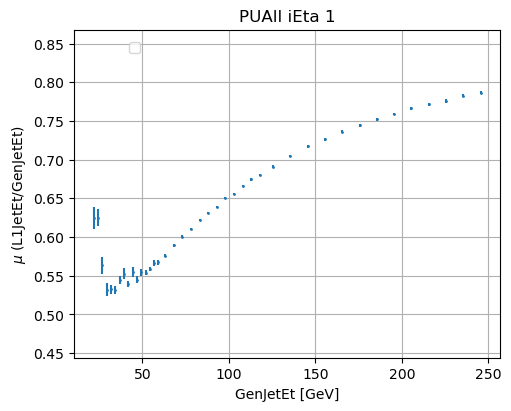

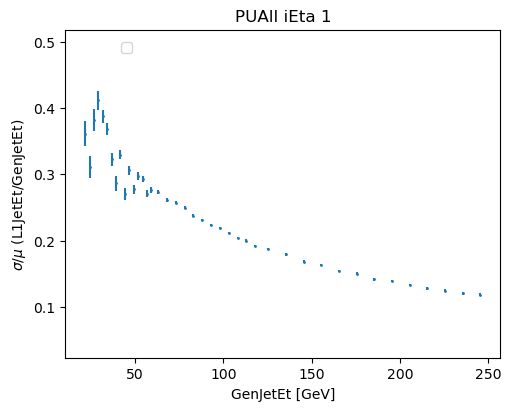

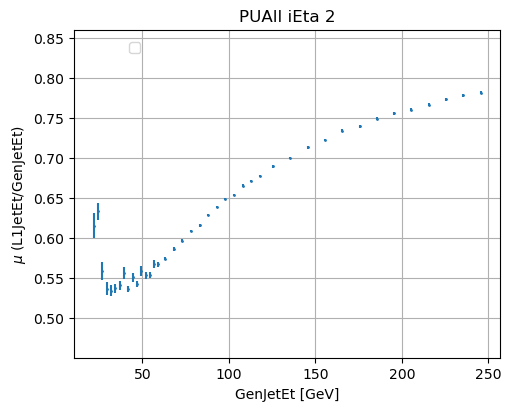

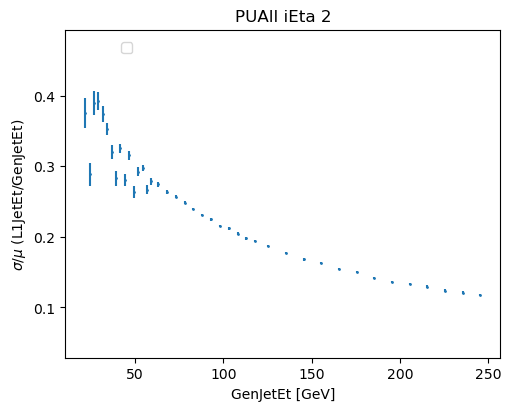

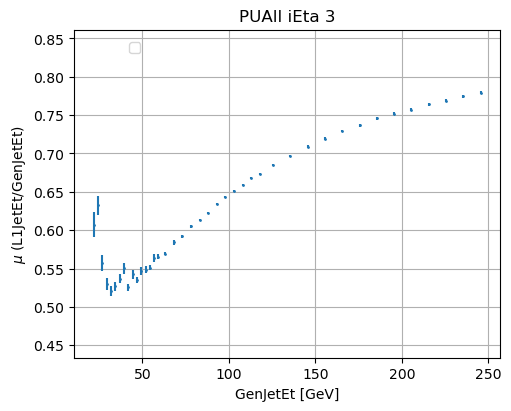

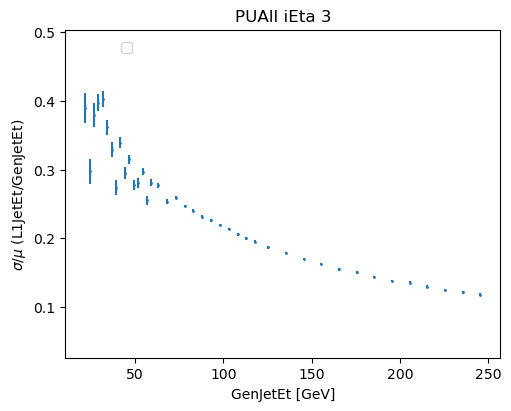

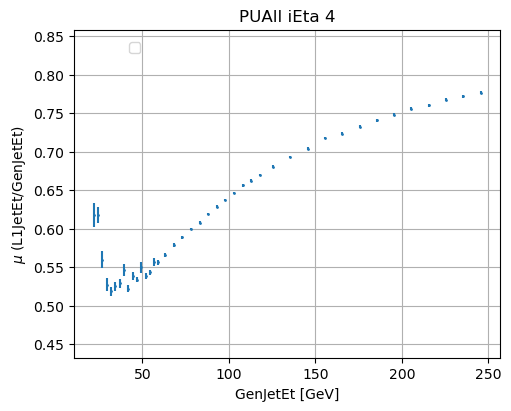

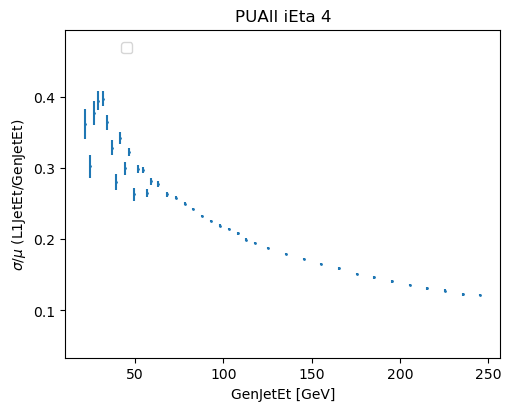

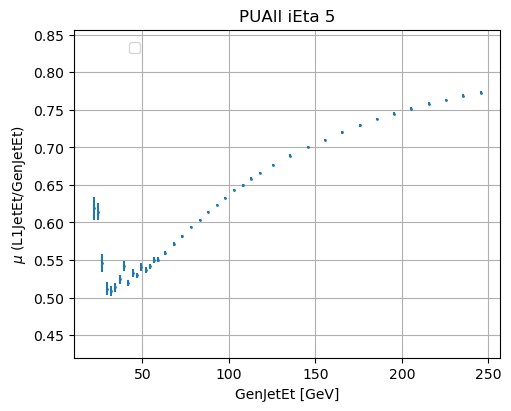

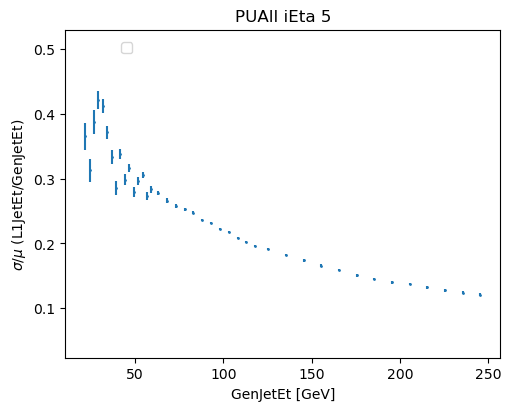

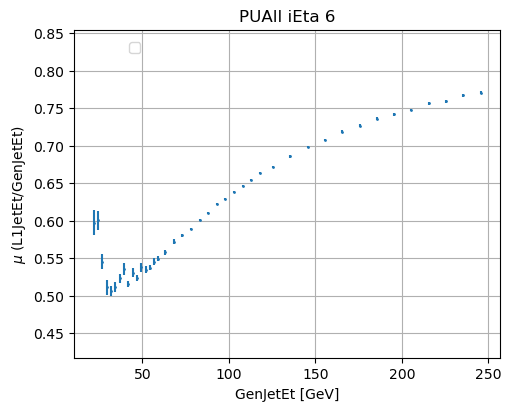

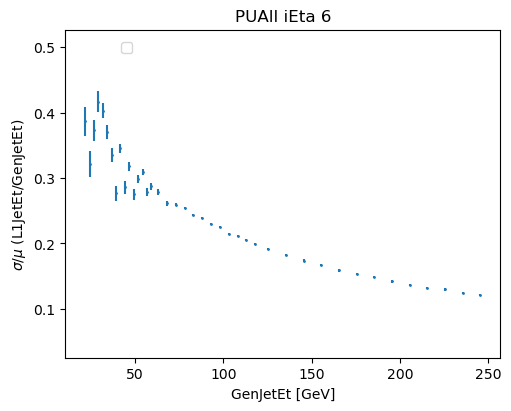

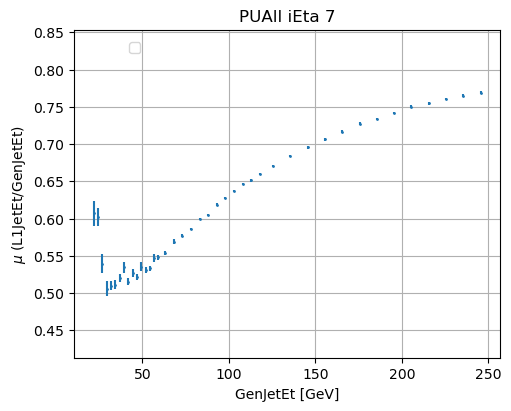

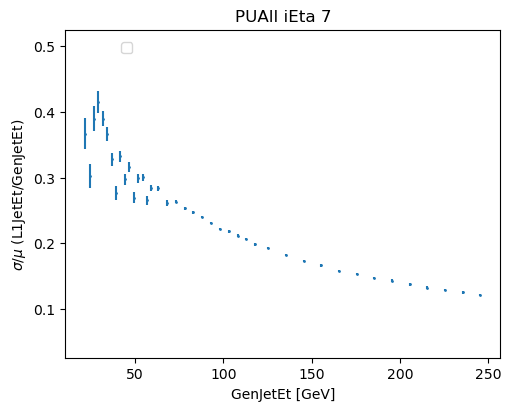

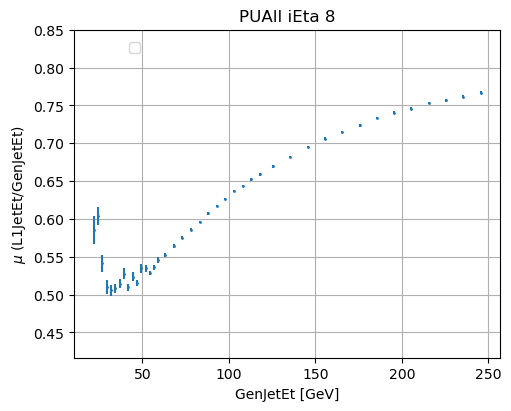

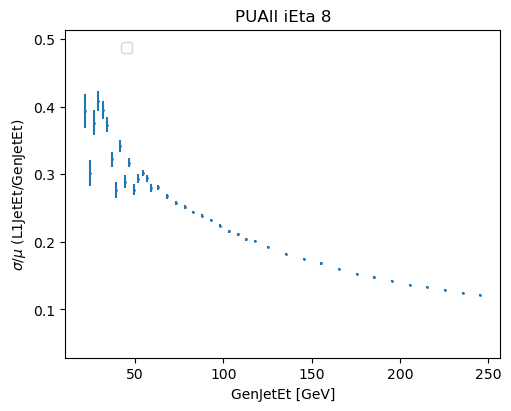

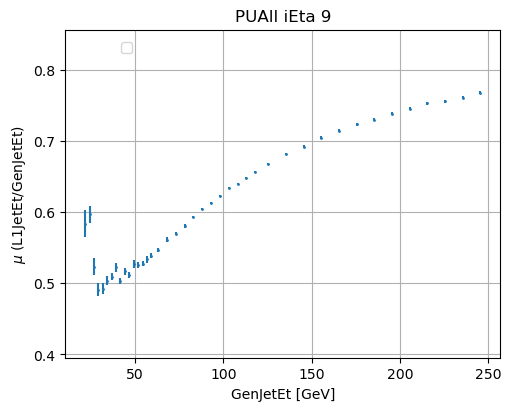

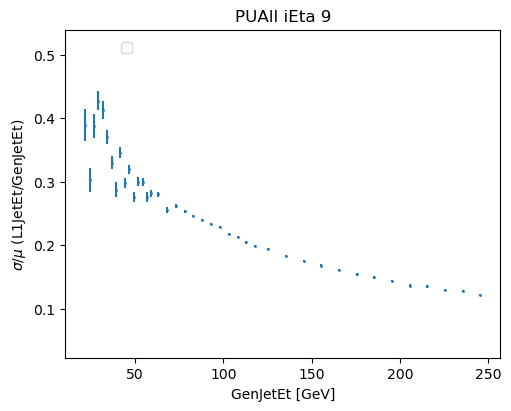

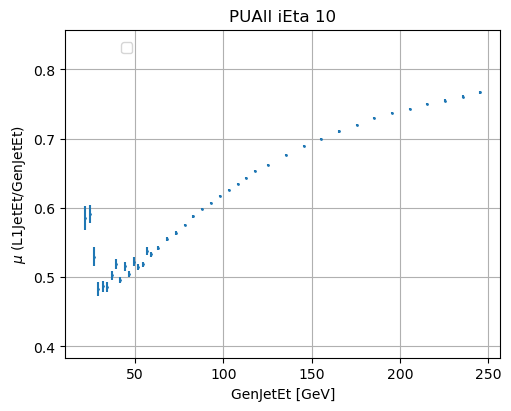

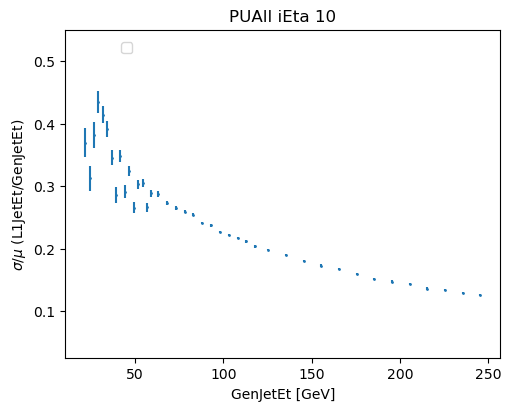

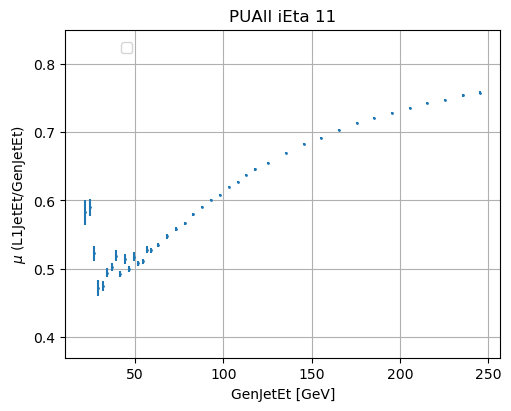

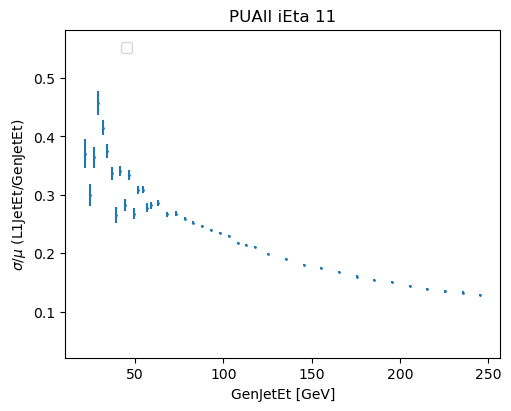

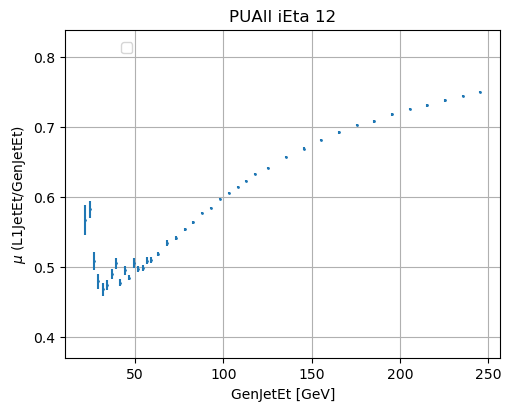

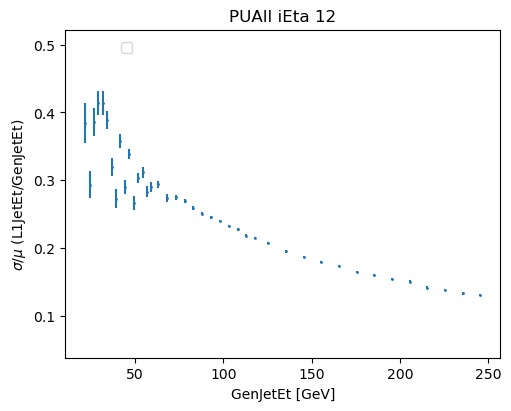

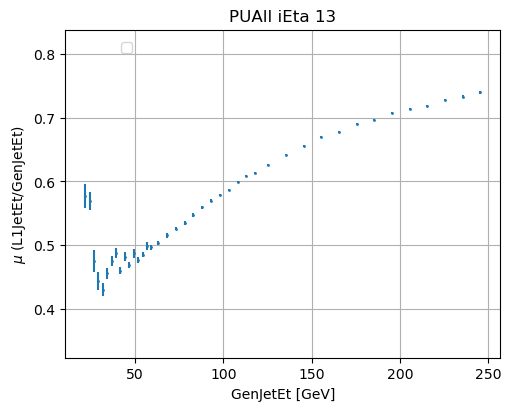

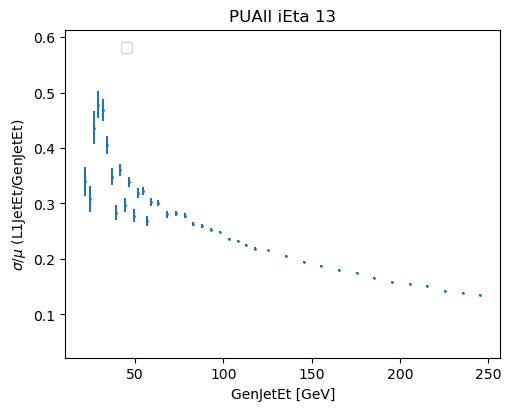

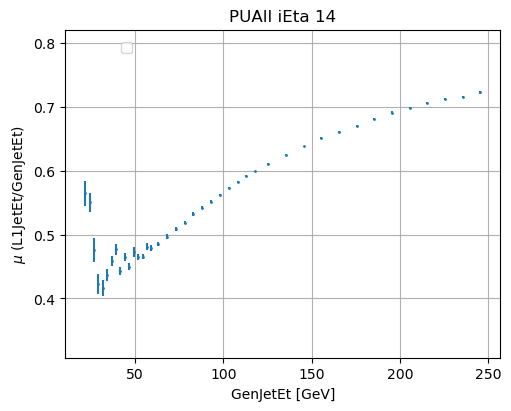

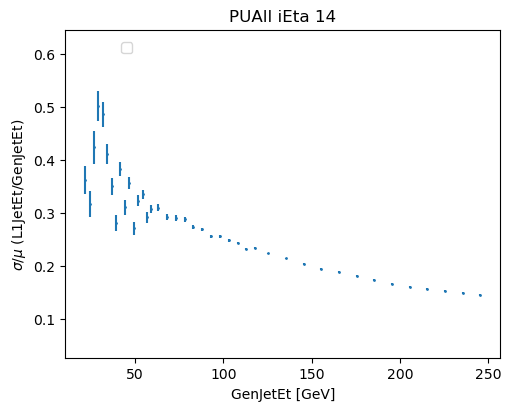

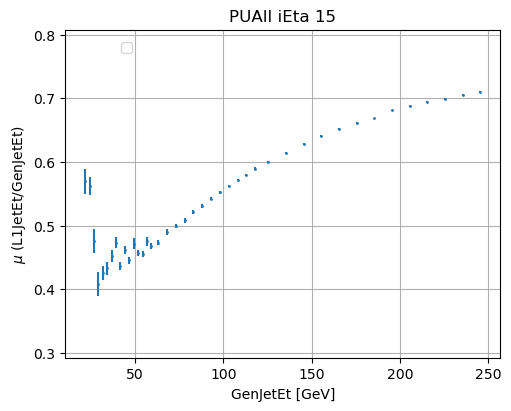

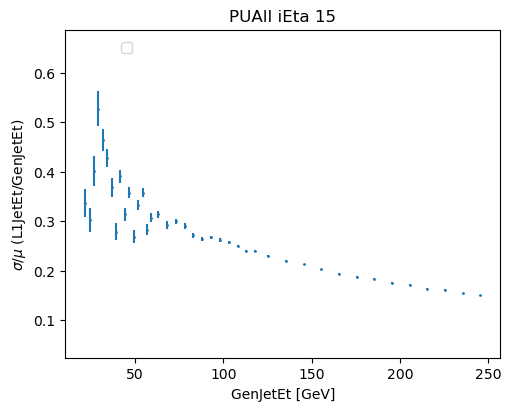

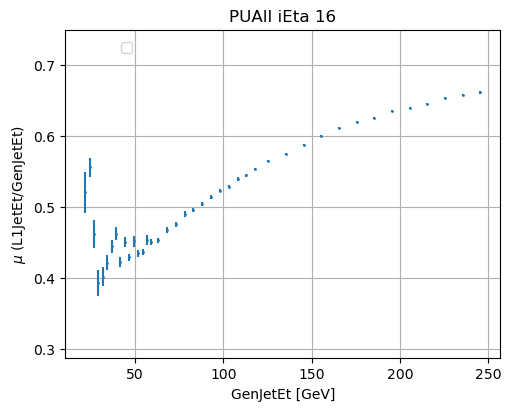

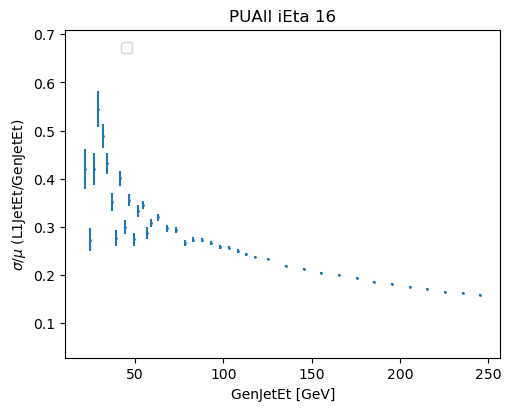

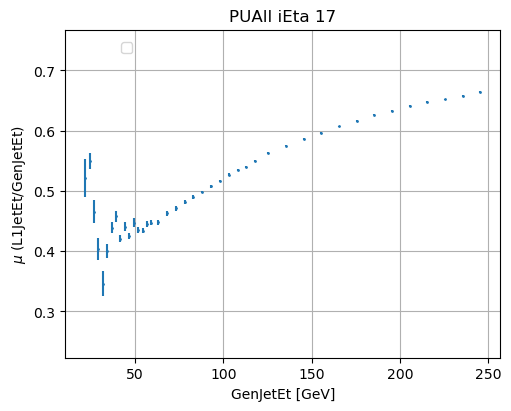

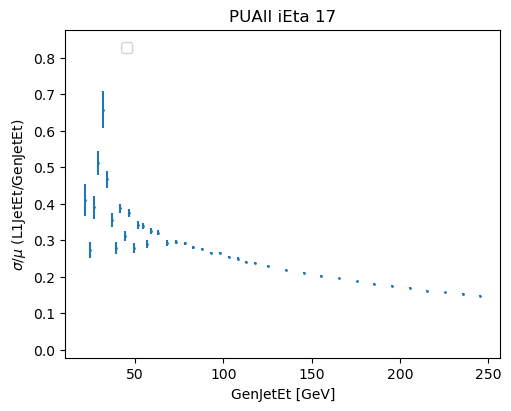

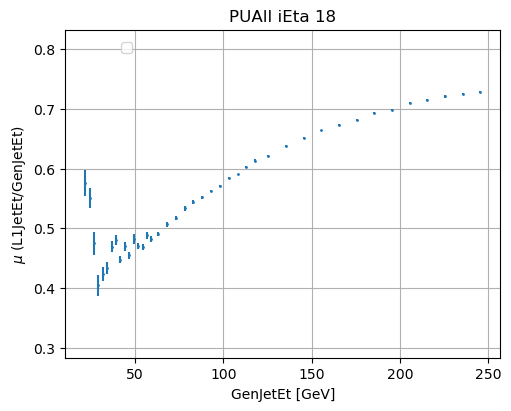

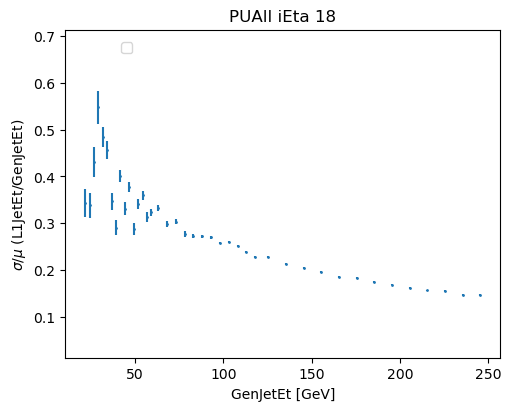

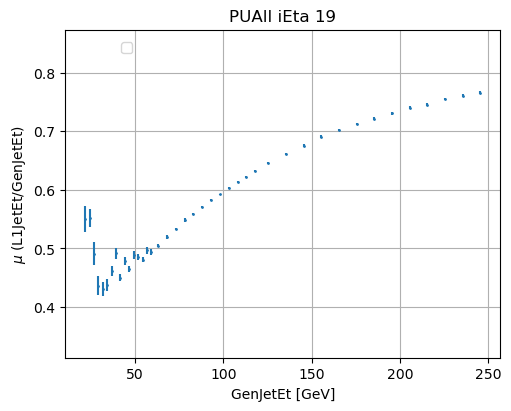

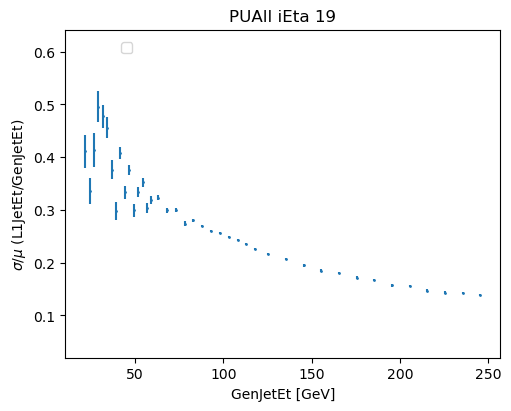

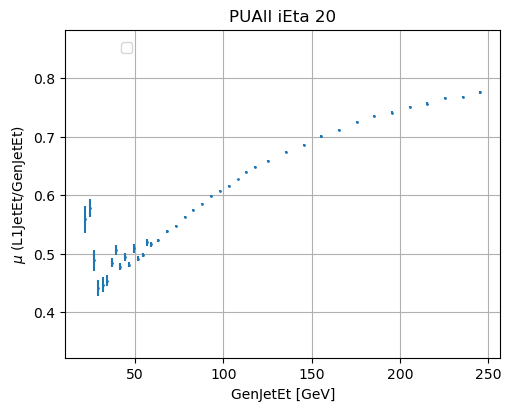

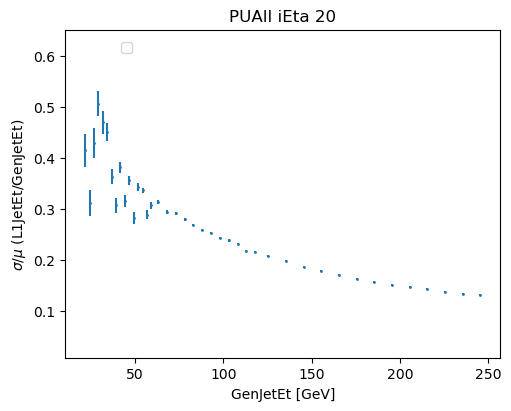

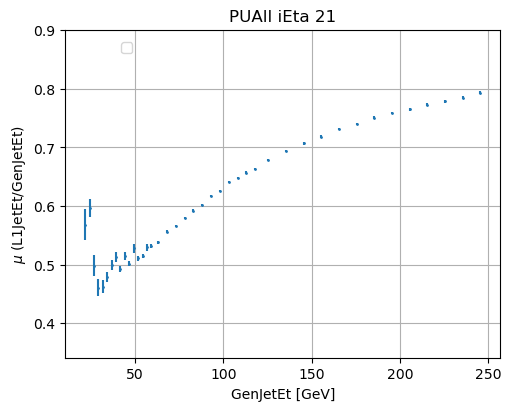

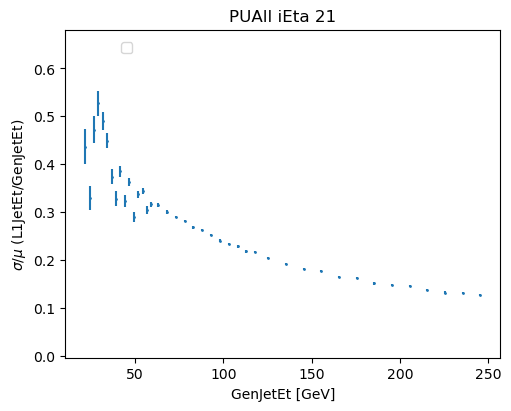

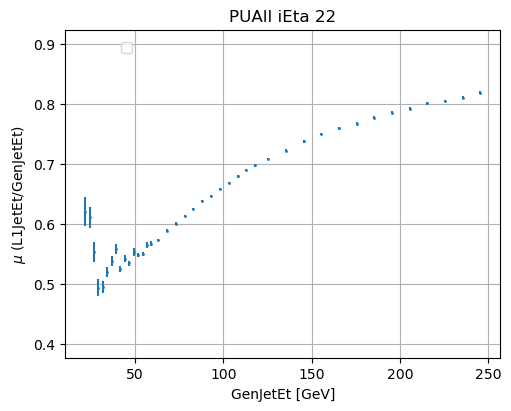

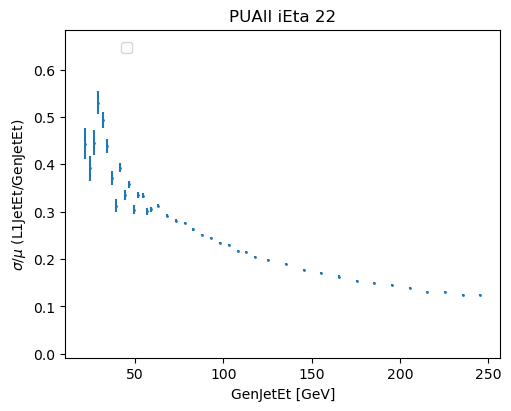

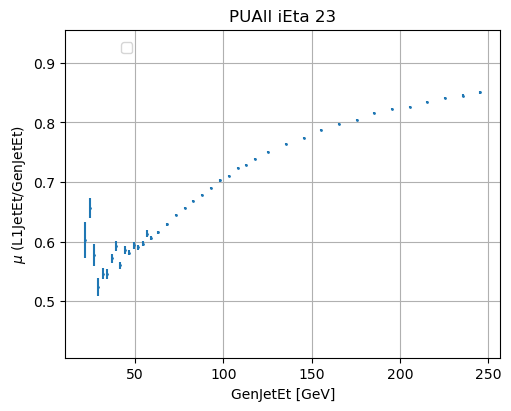

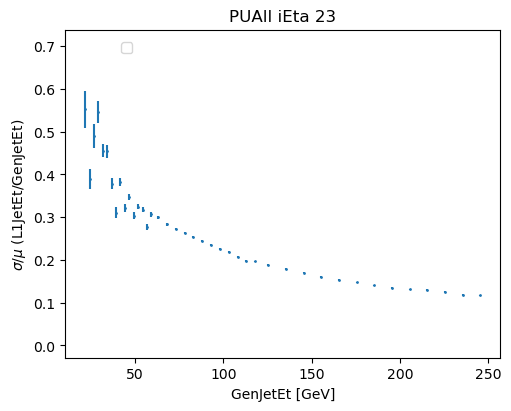

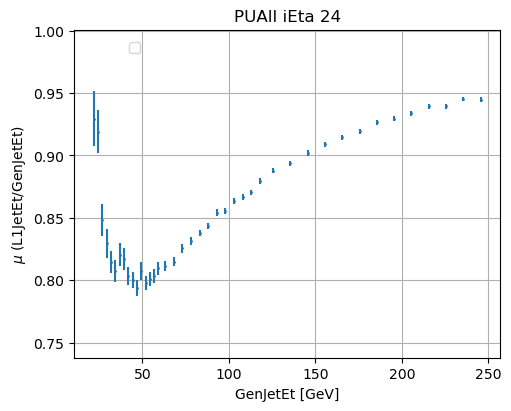

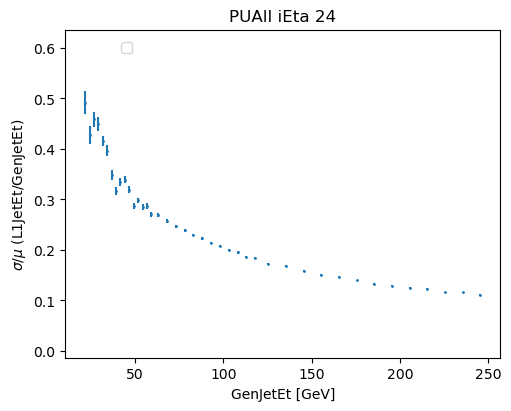

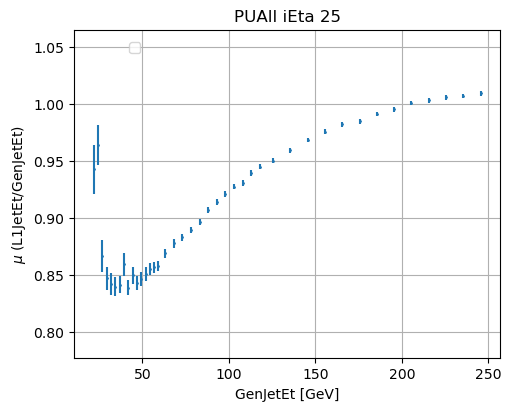

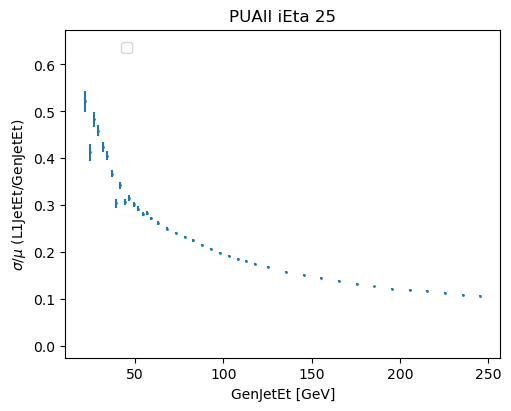

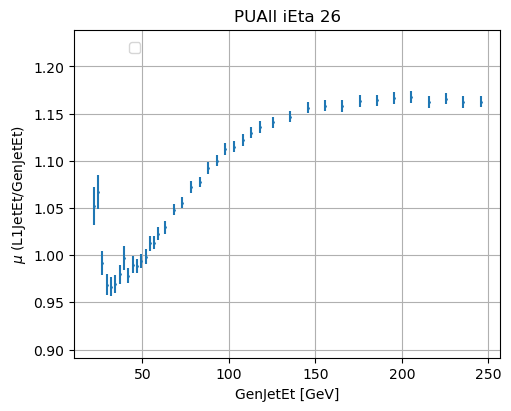

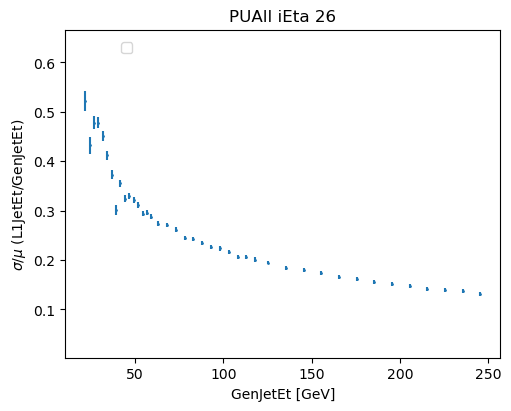

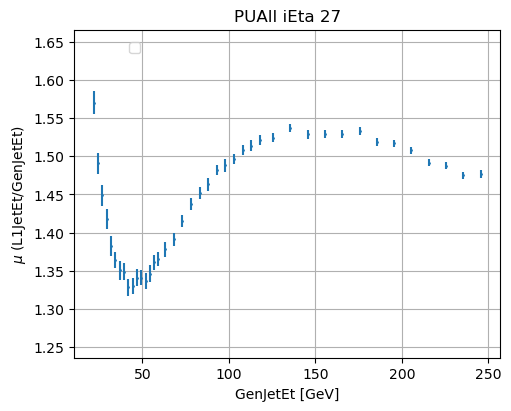

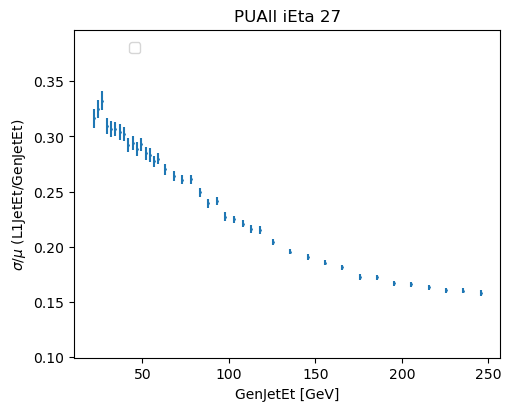

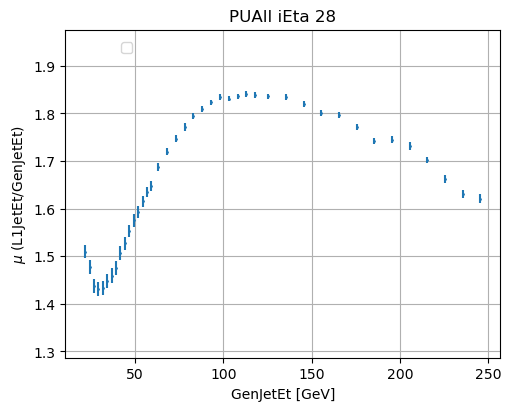

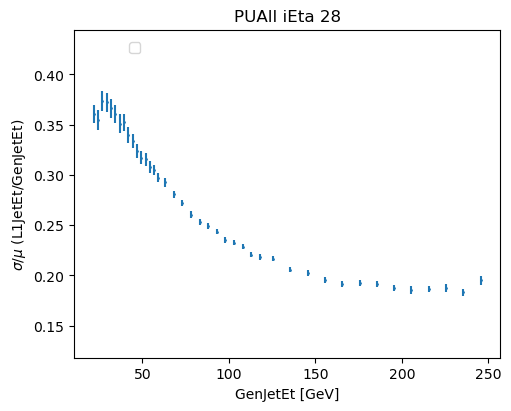

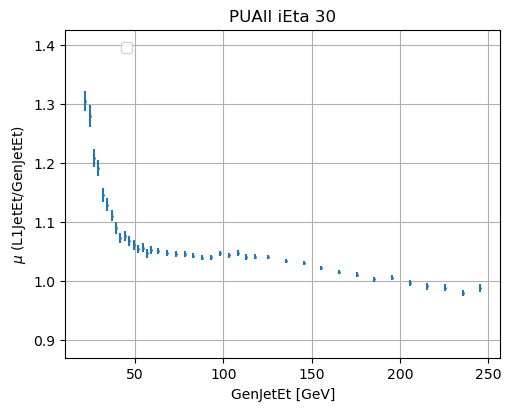

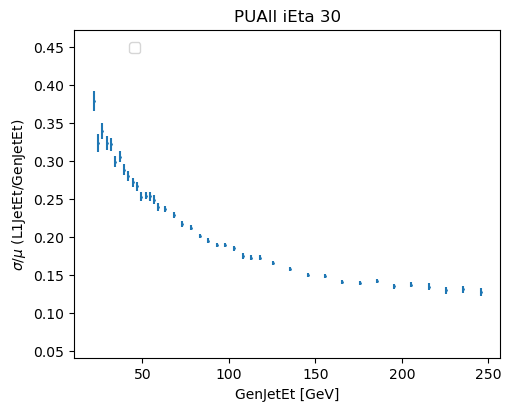

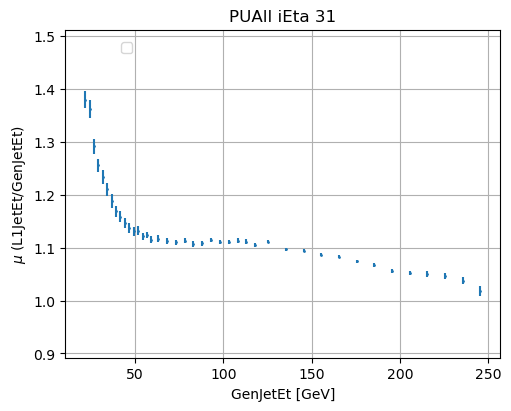

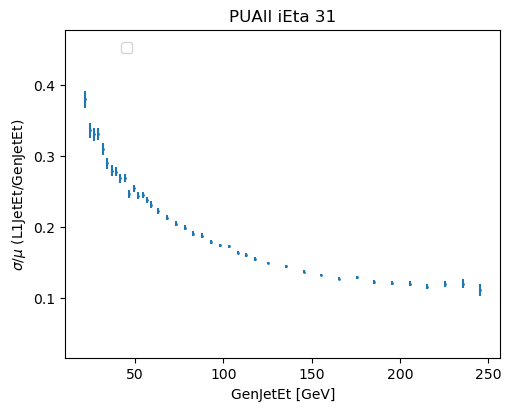

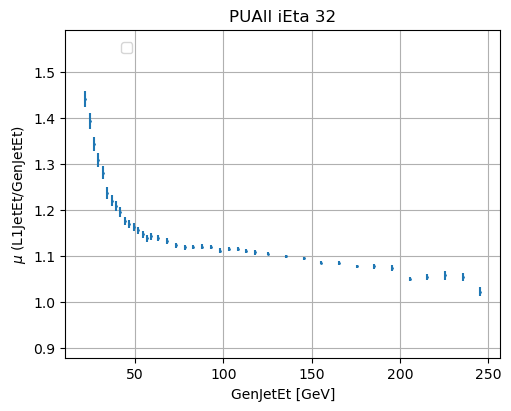

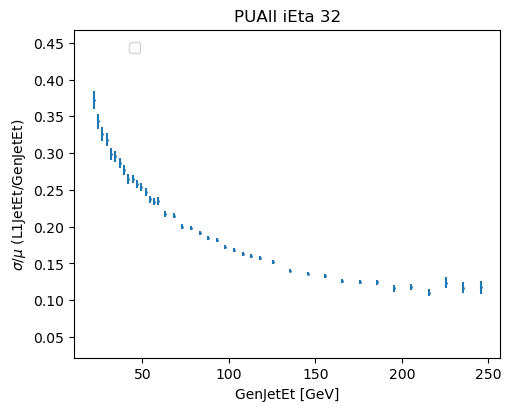

In [74]:
# L1Jet response vs RefJetPt

RefJetPtBins_forResolutionPlots = [
    #*np.arange(  0.5,  20.5, 4),
    *np.arange( 20.5,  60.5, 2.5),
    *np.arange( 60.5, 120.5, 5),
    *np.arange(120.5, 255.5, 10),    
]
print(f"RefJetPtBins_forResolutionPlots: {RefJetPtBins_forResolutionPlots}")

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetResponse_vs_Pt' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):             os.mkdir( sOutDir1D_toUse )    

for PU_category, PURange in PU_Cat_forResolutionPlots.items():
    PURangeMin = PURange[0]
    PURangeMax = PURange[1]
    
    for iEtaBin in iEtaBins: # 1 to 41 iEtaBins
        
        JES = OD()
        JER = OD()
        for iPtBin in range(len(RefJetPtBins_forResolutionPlots) - 1):
            PtRangeMin = RefJetPtBins_forResolutionPlots[iPtBin]
            PtRangeMax = RefJetPtBins_forResolutionPlots[iPtBin + 1]
            PtMean = (PtRangeMin + PtRangeMax)/2
 
            data_toUse_ = data_all[
                (data_all[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                (data_all[sRefJetEt]               >= PtRangeMin) &
                (data_all[sRefJetEt]               <  PtRangeMax) & 
                (data_all[snVtx]                   >= PURangeMin) &
                (data_all[snVtx]                   <  PURangeMax)
            ]#.copy()
            data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
        
            h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
            h.fill(data_toUse_[sL1JetResponse])
            
            x_    = h.axes[0].centers
            y_    = h.values()
            yErr_ = np.sqrt(h.variances())
                        
            # index of bins with y>0
            idx_NonZeroY = np.nonzero(y_)
            
            # Give initial parameters for Gaussian function fit
            #pInitial = [y_.max(), 1, 0.3]
            pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
            
            #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
            popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
            poptErr    = np.sqrt(np.diag(pcov))
            print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")
            
            Mean_  = popt[1];    errMean_  = poptErr[1]
            Sigma_ = popt[2];    errSigma_ = poptErr[2]
            
            x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            
            
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            axs.set_xlabel(sL1JetResponse)
            axs.set_ylabel('Entries')
            axs.set_title('%s iEta %d pT [%.1f, %.1f]' % (PU_category, iEtaBin, PtRangeMin, PtRangeMax))
            axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
            axs.set_ylim(0, y_.max() * 1.4)
            axs.grid()
            
            errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
            JES[PtMean] = {'value': Mean_,          'error': errMean_}
            JER[PtMean] = {'value': Sigma_ / Mean_, 'error': errJER_}
                                   
            fig.savefig('%s/L1JetResponse_1D_%s_ieta_%d_Pt_%.1f.png' % (sOutDir1D_toUse, PU_category, iEtaBin, PtMean))
            plt.close(fig)
            
            
        # plot JES vs Pt
        JES_Ptwise    = [ JES[Pt]['value'] for Pt in JES.keys()]
        errJES_Ptwise = [ JES[Pt]['error'] for Pt in JES.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        axs.errorbar(list(JES.keys()), JES_Ptwise, yerr=errJES_Ptwise, fmt='o', markersize=1)
        axs.set_xlabel('%s [GeV]' % (sRefJetEt))
        axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Mean.png' % (sOutDir_toUse, PU_category, iEtaBin))        
        
        # plot JER vs iEta
        JER_Ptwise    = [ JER[Pt]['value'] for Pt in JER.keys()]
        errJER_Ptwise = [ JER[Pt]['error'] for Pt in JER.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        axs.errorbar(list(JER.keys()), JER_Ptwise, yerr=errJER_Ptwise, fmt='o', markersize=1)
        axs.set_xlabel('%s [GeV]' % (sRefJetEt))
        axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Resolution.png' % (sOutDir_toUse, PU_category, iEtaBin))
       

In [ ]:
nEntriesPerIEtaBin = [len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins]   
nEntriesPerIEtaBin_1 = { iEtaBin: len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins}   
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
axs.plot(iEtaBins, nEntriesPerIEtaBin)
axs.set_xlabel('iEta bins')
axs.set_ylabel('Entries')
axs.set_title('%s' % (sL1JetEt))
#axs.legend()
fig.savefig('%s/%s_nEntriesPerIEtaBin.png' % (sOutDir, sL1JetEt))
if printLevel >= 11:
    print("nEntriesPerIEtaBin: {}".format(nEntriesPerIEtaBin))
    print("nEntriesPerIEtaBin_1: {}".format(nEntriesPerIEtaBin_1))
    
#nEntriesPerIEtaBinPtBin = []


In [ ]:
#%%time

import pickle


sL1JetEt_forML_predict = "%s_predict" % (sL1JetEt_forML)
sL1JetEt_predict       = "%s_predict" % (sL1JetEt)
sSF                    = "SF"

IEta_Cat_forML = OD()
#IEta_Cat_forML['HB'] = [ 1, 16]
#IEta_Cat_forML['HE12a'] = [17, 26]
#IEta_Cat_forML['HE2b'] = [27, 28]
#IEta_Cat_forML['HF30to32'] = [30, 32]
#IEta_Cat_forML['HF33to36'] = [33, 36]
#IEta_Cat_forML['HF37to41'] = [37, 41]
#IEta_Cat['HBEF'] = [ 1, 41]
IEta_Cat_forML['HBEF'] = [ 1, 41]

Pt_Cat_forML = OD()
#Pt_Cat_forML['Ptlt60'] = [ 0, 60]
#Pt_Cat_forML['Ptgt60'] = [60, L1JetPtMax]
#Pt_Cat_forML['Ptlt25']   = [ 0, 25]
#Pt_Cat_forML['Pt25to35'] = [25, 35]
#Pt_Cat_forML['Pt35to60'] = [35, 60]
#Pt_Cat_forML['Pt60to90'] = [60, 90]
#Pt_Cat_forML['Ptgt90']   = [90, L1JetPtMax]
Pt_Cat_forML['PtAll'] = [0, L1JetPtMax]

if printLevel >= 11:
    print("train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))
    
varsOfInterest = train_vars.copy()
varsOfInterest.extend([target_var, sL1JetEt, sRefJetEt])
if printLevel >= 0:
    print("Going for BDT training: varsOfInterest: {}\n".format(varsOfInterest))
    print("After train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))

# ML training ----------------------------------------------------------------------
def train_MLModel_wHyperopt(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
    
    hyperparameter_space = { 
        #'n_estimators': hp.choice('n_estimators', np.arange(500, 2001, 100, dtype=int)),
        'n_estimators': hp.choice('n_estimators', np.arange(700, 701, 100, dtype=int)),
        #'learning_rate':hp.quniform('learning_rate', 0.01, 0.2, 0.01),
        'learning_rate':hp.quniform('learning_rate', 0.05, 0.055, 0.01),
        'early_stopping_rounds': 10
    }    
    max_evals = 1 # 30
    
    def ML_score(params):
        model = XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False       
        )
        score = mean_squared_error(y_valid, model.predict(X_valid), squared=False)
        if printLevel >= 3:
            print("score: valid {}, train {}. params: {}".format(
                score,
                mean_squared_error(y_train, model.predict(X_train), squared=False),
                params))
        return {'loss': score, 'status': STATUS_OK, 'ML_model': model}
            
    
    def getBestMLModel(trials):
        # https://stackoverflow.com/questions/54273199/how-to-save-the-best-hyperopt-optimized-keras-models-and-its-weights
        valid_trial_list = [trial for trial in trials  if STATUS_OK == trial['result']['status']]
        losses = [float(trial['result']['loss']) for trial in valid_trial_list]
        index_having_minimum_loss = np.argmin(losses)
        best_trial_obj = valid_trial_list[index_having_minimum_loss]
        return best_trial_obj['result']['ML_model']
        
        
        
    # ref: 
    # https://sites.google.com/view/raybellwaves/blog/using-xgboost-and-hyperopt-in-a-kaggle-comp
    # https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
    trials = Trials()
    best_params = fmin(
        fn=ML_score,
        space=hyperparameter_space, 
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    print("best_params: {}".format(best_params))
    print("space_eval(hyperparameter_space, best_params): {}".format(space_eval(hyperparameter_space, best_params)))
    
    return getBestMLModel(trials)
# ----------------------------------------------------------------------------        
    
    
    
    
    
BDTModel_dict = OD([])
data_SFs = None
for iEta_category, iEtaBinRange in IEta_Cat_forML.items():
    iEtaBins_i = range(iEtaBinRange[0], iEtaBinRange[-1]+1)

    BDTModel_dict[iEta_category] = OD([])
    for Pt_category, PtRange in Pt_Cat_forML.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        data_all_iEtaBins = data_all[
            (data_all[sL1JetTowerIEtaAbs] >= iEtaBinRange[0]) & 
            (data_all[sL1JetTowerIEtaAbs] <= iEtaBinRange[-1]) &
            (data_all[sL1JetEt] >= PtRangeMin) &
            (data_all[sL1JetEt] <  PtRangeMax)
        ][varsOfInterest]
        if printLevel >= 0:
            print("\niEta_category {}, iEtaBinRange {}, Pt_category {}, PtRange {}, data_all_iEtaBins.describe(): \n{}".format(
                iEta_category, iEtaBinRange, Pt_category, PtRange, data_all_iEtaBins.describe()))


        X = data_all_iEtaBins[train_vars]
        y = data_all_iEtaBins[target_var]

        xgb_rg = train_MLModel_wHyperopt(X, y)


        BDTModel_dict[iEta_category][Pt_category] = xgb_rg
        data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax)
        data_SFs_i[sL1JetEt_forML_predict] = xgb_rg.predict(data_SFs_i[train_vars])
        data_SFs_i[sL1JetEt_predict]       = transform_back_JetEt_fromML( data_SFs_i[sL1JetEt_forML_predict] )
        data_SFs_i[sSF]                    = data_SFs_i[sL1JetEt_predict] / data_SFs_i[sL1JetEt]
        if printLevel >= 11:
            print("iEtaBins_i: {}".format(iEtaBins_i))
            print("data_SFs_i: {}".format(data_SFs_i.describe()))

        if data_SFs is None:
            data_SFs = data_SFs_i
        else:
            data_SFs = pd.concat([data_SFs, data_SFs_i])  
            
        # save
        sTrain_vars_ = '_'.join()
        sBDTModel_fileName = '../data/BDTModel_%s_vs_%s__%s_%s.pkl' % ('_'.join(train_vars), '_'.join(target_var), iEta_category, Pt_category)
        pickle.dump(BDTModel_dict[iEta_category][Pt_category], open(sBDTModel_fileName, "wb"))

    
    
#print("Hello1")    
#print("\n\ndata_SFs: \n{}".format(data_SFs.to_string()))
data_SFs.to_csv(sOpFileName_SFs, index=False)
print("Wrote {}".format(sOpFileName_SFs))

In [ ]:
# Change nVertex to evaluate SF here ----------------
nVtx_forSF = 48
# ---------------------------------------------------

data_SFs = None
for iEta_category, iEtaBinRange in IEta_Cat_forML.items():
    iEtaBins_i = range(iEtaBinRange[0], iEtaBinRange[-1]+1)
    
    for Pt_category, PtRange in Pt_Cat_forML.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]

        xgb_rg = BDTModel_dict[iEta_category][Pt_category]
        
        if snVtx in train_vars:
            data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax, nVtx=nVtx_forSF)
        else:
            data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax)
            
        data_SFs_i[sL1JetEt_forML_predict] = xgb_rg.predict(data_SFs_i[train_vars])
        data_SFs_i[sL1JetEt_predict]       = transform_back_JetEt_fromML( data_SFs_i[sL1JetEt_forML_predict] )
        data_SFs_i[sSF]                    = data_SFs_i[sL1JetEt_predict] / data_SFs_i[sL1JetEt]
        if printLevel >= 11:
            print("iEtaBins_i: {}".format(iEtaBins_i))
            print("data_SFs_i: {}".format(data_SFs_i.describe()))

        if data_SFs is None:
            data_SFs = data_SFs_i
        else:
            data_SFs = pd.concat([data_SFs, data_SFs_i])    

    
if snVtx in train_vars:
    sOpFileName_SFs = sOpFileName_SFs.replace('.csv', '_forPU%d.csv' %(nVtx_forSF))
    
#print("Hello1")    
#print("\n\ndata_SFs: \n{}".format(data_SFs.to_string()))
data_SFs.to_csv(sOpFileName_SFs, index=False)
print("Wrote {}".format(sOpFileName_SFs))        
        

In [ ]:
sL1JetEt_calib = '%s_calib' % (sL1JetEt)
data_copy1     = data_all[[sL1JetTowerIEtaAbs, sL1JetEt, sGenJetEt]].copy()
data_SFs_copy1 = data_SFs[[sL1JetTowerIEtaAbs, sL1JetEt, sSF]].copy()
data_SFs_copy1 = data_SFs_copy1.set_index([sL1JetTowerIEtaAbs, sL1JetEt])
SFs_dict       = data_SFs_copy1.to_dict()[sSF]

def calibrateJet(Et_0, iEta):
    Et = round(Et_0)
    if Et < calibSF_L1JetPtRange[0]: Et = round(calibSF_L1JetPtRange[0])
    if Et > calibSF_L1JetPtRange[1]: Et = round(calibSF_L1JetPtRange[1])
    #print(f"iEta {iEta}, Et {Et}")
    sf = SFs_dict[(iEta, Et)] if Et >= 1 else SF_forZeroPt
    return Et_0 * sf

data_copy1[sL1JetEt_calib] = data_copy1.apply(lambda row: calibrateJet(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)
#data_copy1[sL1JetEt_calib] = np.vectorize(calibrateJet)(data_copy1[sL1JetEt], data_copy1[sL1JetTowerIEtaAbs])
if printLevel >= 10:
    print("data_copy1: {}".format(data_copy1))

In [ ]:
sOutDir1 = None
if snVtx in train_vars:
    sOutDir1 = '%s/wSF_AtPU%d' %(sOutDir,nVtx_forSF) 
else:
    sOutDir1 = '%s/wSF_woTargetingSpecificPU' %(sOutDir) 

if not os.path.exists(sOutDir1): 
    os.makedirs(sOutDir1)


# SF vs Et plots ----
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_SFs_iEtaBin = data_SFs[
            (data_SFs[sL1JetTowerIEtaAbs] == iEtaBin) & 
            (data_SFs[sL1JetEt] >=  calibSF_L1JetPtRange[0])
        ].copy()
        axs.plot(
            data_SFs_iEtaBin[sL1JetEt],
            data_SFs_iEtaBin[sSF],
            label='iEta %d' % (iEtaBin)
        )
    axs.set_xlabel('L1JetEt [GeV]')
    axs.set_ylabel('Scale factor')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
        
    fig.savefig('%s/SF_vs_Et_%s_ieta_%d_to_%d.png' % (sOutDir1, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
 

In [ ]:
# Resolution plots 
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_copy1_iEtaBin = data_copy1[data_copy1[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s: after JEC' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d.png' % (sOutDir1, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
print("\n\nDone.")

In [ ]:

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sRefJetEt] >= pt_range[0]) & 
            (data_copy1[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()
        
    fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d_inPtCat.png' % (sOutDir1, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
    
print("\n\nDone.")

In [ ]:
'''
sL1JetEt_forResolutionPlots = sL1JetEt
sL1JetResponse = 'L1JetEt/%s' % (sRefJetEt)


sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/L1JetResponse_vs_iEta' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):             os.mkdir( sOutDir1D_toUse )    



for PU_category, PURange in PU_Cat_forResolutionPlots.items():
    PURangeMin = PURange[0]
    PURangeMax = PURange[1]

    for Pt_category, PtRange in Pt_Cat_forResolutionPlots.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        JES = OD()
        JER = OD()
        for iEtaBin in iEtaBins:
            # data_copy1[sL1JetEt_calib]
            data_toUse_ = data_all[
                (data_all[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                (data_all[sRefJetEt]               >= PtRangeMin) &
                (data_all[sRefJetEt]               <  PtRangeMax) & 
                (data_all[snVtx]                   >= PURangeMin) &
                (data_all[snVtx]                   <  PURangeMax)
            ]#.copy()
            data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
            print(f"PU: {PURange}, Pt: {PtRange}, iEta: {iEtaBin}")
            
            h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
            h.fill(data_toUse_[sL1JetResponse])
            
            x_    = h.axes[0].centers
            y_    = h.values()
            yErr_ = np.sqrt(h.variances())
                        
            # index of bins with y>0
            idx_NonZeroY = np.nonzero(y_)
            
            # Give initial parameters for Gaussian function fit
            #pInitial = [y_.max(), 1, 0.3]
            pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
            
            #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
            popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
            poptErr    = np.sqrt(np.diag(pcov))
            print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")
            
            Mean_  = popt[1];    errMean_  = poptErr[1]
            Sigma_ = popt[2];    errSigma_ = poptErr[2]
            
            x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            
            
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            axs.set_xlabel(sL1JetResponse)
            axs.set_ylabel('Entries')
            axs.set_title('%s %s iEta %s' % (PU_category, Pt_category, iEtaBin))
            axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
            axs.set_ylim(0, y_.max() * 1.4)
            axs.grid()
            
            errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
            JES[iEtaBin] = {'value': Mean_,          'error': errMean_}
            JER[iEtaBin] = {'value': Sigma_ / Mean_, 'error': errJER_}
                                   
            fig.savefig('%s/L1JetResponse_1D_%s_%s_ieta_%d.png' % (sOutDir1D_toUse, PU_category, Pt_category, iEtaBin))
            
                        
            
                    
            
        # plot JES vs iEta
        JES_iEtawise    = [ JES[iEtaBin]['value'] for iEtaBin in JES.keys()]
        errJES_iEtawise = [ JES[iEtaBin]['error'] for iEtaBin in JES.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JES_iEtawise)
        axs.errorbar(list(JES.keys()), JES_iEtawise, yerr=errJES_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Mean.png' % (sOutDir_toUse, PU_category, Pt_category))
        
        
        # plot JER vs iEta
        JER_iEtawise    = [ JER[iEtaBin]['value'] for iEtaBin in JER.keys()]
        errJER_iEtawise = [ JER[iEtaBin]['error'] for iEtaBin in JER.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JER_iEtawise)
        axs.errorbar(list(JER.keys()), JER_iEtawise, yerr=errJER_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Resolution.png' % (sOutDir_toUse, PU_category, Pt_category))  
'''        